In [ ]:
#SEC3 #hyperparameter tunning #n_trials 30
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin
import tqdm as notebook_tqdm
import warnings

# 경고 무시
warnings.filterwarnings("ignore", category=UserWarning)

# 재현성을 위한 랜덤 시드 설정
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# 데이터 로딩 및 전처리
df = pd.read_excel('v4_BMED_data.xlsx', sheet_name='Opt')
columns = ['V', 'E', 'Ci', 'CF_LA', 'CA_LA', 'CF_K', 'CA_K', 'CB_K', 'VF', 'VA', 'VB', 'T']
df = df[df[columns].gt(0).all(axis=1)]

X_data = df[['CA_LA', 'V', 'VA', 'E', 'VF', 'CF_K', 'CF_LA', 'Ci', 'VB', 'T', 'CA_K', 'CB_K']].values
Y_data = df[['SEC']].values

sc = StandardScaler()

def split_data(random_state):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=random_state)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, Y_train, Y_test

# Custom Model
class CustomModel(nn.Module):
    def __init__(self, hidden_layers=2, hidden_neurons=80, dropout_prob = 0.5):
        super().__init__()
        layers = []
        input_dim = X_data.shape[1]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_neurons))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            input_dim = hidden_neurons
        layers.append(nn.Linear(hidden_neurons, 1))
        self.hidden = nn.Sequential(*layers)

    def forward(self, x):
        return self.hidden(x)

# TorchRegressor for sklearn compatibility
class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layers=2, hidden_neurons=32, learning_rate=0.001, num_epochs=1000, batch_size=64, weight_decay=1e-5, patience=50):
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.patience = patience
        self.model = CustomModel(hidden_layers=self.hidden_layers, hidden_neurons=self.hidden_neurons)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

    def fit(self, X, y):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        best_val_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(self.num_epochs):
            self.model.train()
            for X_batch, y_batch in dataloader:
                Y_pred = self.model(X_batch)
                loss = self.criterion(Y_pred, y_batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # Validation check
            self.model.eval()
            with torch.no_grad():
                val_loss = self.criterion(self.model(X_tensor), y_tensor)
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.FloatTensor(X)
        with torch.no_grad():
            Y_pred = self.model(X_tensor)
        return Y_pred.numpy()

# Optuna objective function
def objective(trial):
    # 하이퍼파라미터 검색 공간
    hidden_layers = trial.suggest_int('hidden_layers', 1, 10)
    hidden_neurons = trial.suggest_int('hidden_neurons', 8, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    num_epochs = trial.suggest_int('num_epochs', 500, 3000)
    batch_size = trial.suggest_int('batch_size', 32, 128)
    weight_decay = trial.suggest_float('weight_decay', 1e-7, 1e-3, log=True)
    patience = trial.suggest_int('patience', 10, 100)

    # 데이터 분할
    X_train, X_test, Y_train, Y_test = split_data(random_state)

    # K-Fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    r2_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]

        # 모델 학습
        model = TorchRegressor(
            hidden_layers=hidden_layers,
            hidden_neurons=hidden_neurons,
            learning_rate=learning_rate,
            num_epochs=num_epochs,
            batch_size=batch_size,
            weight_decay=weight_decay,
            patience=patience
        )
        model.fit(X_train_fold, Y_train_fold)
        y_pred_val = model.predict(X_val_fold)

        # R² Score 계산
        r2_val = r2_score(Y_val_fold, y_pred_val)

        if r2_val < 0:
            raise optuna.exceptions.TrialPruned()

        r2_scores.append(r2_val)

    # K-Fold 평균 R2 Score를 반환
    return np.mean(r2_scores)

# 여러 random_state에 대해 Optuna 실행
results = []

for random_state in range(101):  # 다양한 random_state에 대해 반복
    print(f"Running Optuna for random_state: {random_state}")
    
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=20, interval_steps=5)
    
    # Optuna study 실행
    study = optuna.create_study(direction="maximize", pruner=pruner)
    
    # 최대 30번의 trial을 수행하지만, 성공적인 trial이 없으면 다음 random_state로 넘어감
    study.optimize(objective, n_trials=40)

    # 최적의 하이퍼파라미터와 성능 저장
    try:
        if study.best_trial:
            best_params = study.best_params
            best_r2 = study.best_value
            results.append({"random_state": random_state, "best_params": best_params, "best_r2": best_r2})
    except ValueError:
        print(f"No successful trials for random_state {random_state}, skipping.")

# 결과 요약
if results:
    results_df = pd.DataFrame(results)
    # 최적의 random_state와 해당 결과 출력
    best_result = results_df.loc[results_df['best_r2'].idxmax()]
    print("Best random_state:", best_result['random_state'])
    print("Best R2 Score:", best_result['best_r2'])
    print("Best Hyperparameters:", best_result['best_params'])
    # 결과 저장
    results_df.to_csv("SEC3_optuna_results_random_states.csv", index=False)
else:
    print("No successful trials found for any random_state.")

# 모델 재학습 및 성능 평가 (최적 하이퍼파라미터 사용)
if results:
    best_random_state = int(best_result['random_state'])
    best_params = best_result['best_params']

    X_train, X_test, Y_train, Y_test = split_data(best_random_state)

    model = TorchRegressor(
        hidden_layers=best_params['hidden_layers'],
        hidden_neurons=best_params['hidden_neurons'],
        learning_rate=best_params['learning_rate'],
        num_epochs=best_params['num_epochs'],
        batch_size=best_params['batch_size'],
        weight_decay=best_params['weight_decay'],
        patience=best_params['patience']
    )

    # 모델 학습
    model.fit(X_train, Y_train)

    # 예측
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # R² 점수 계산
    r2_test = r2_score(Y_test, y_pred_test)
    r2_train = r2_score(Y_train, y_pred_train)

    # 결과 출력
    print(f"Random State: {best_random_state}")
    print(f"Best Parameters: {best_params}")
    print(f"Train R²: {r2_train}")
    print(f"Test R²: {r2_test}")

    # 모델 저장(Optional)
    torch.save(model, "best_SEC3_model.pt")

[I 2024-12-18 17:38:04,940] A new study created in memory with name: no-name-c8192092-aafa-4339-b5d1-a6fb956bc1e9


Running Optuna for random_state: 0


[I 2024-12-18 17:38:05,618] Trial 0 pruned. 


Early stopping at epoch 40


[I 2024-12-18 17:38:25,461] Trial 1 finished with value: 0.30066880590295664 and parameters: {'hidden_layers': 1, 'hidden_neurons': 65, 'learning_rate': 0.0003851023200086913, 'num_epochs': 858, 'batch_size': 75, 'weight_decay': 3.6263991830098897e-07, 'patience': 99}. Best is trial 1 with value: 0.30066880590295664.


Early stopping at epoch 1127
Early stopping at epoch 604
Early stopping at epoch 1146
Early stopping at epoch 676


[I 2024-12-18 17:39:00,093] Trial 2 finished with value: 0.3066959713501478 and parameters: {'hidden_layers': 4, 'hidden_neurons': 59, 'learning_rate': 0.00013640718200078948, 'num_epochs': 2007, 'batch_size': 100, 'weight_decay': 2.990822677519697e-06, 'patience': 72}. Best is trial 2 with value: 0.3066959713501478.


Early stopping at epoch 605


[I 2024-12-18 17:39:16,255] Trial 3 pruned. 


Early stopping at epoch 269
Early stopping at epoch 297
Early stopping at epoch 323
Early stopping at epoch 395


[I 2024-12-18 17:39:30,380] Trial 4 finished with value: 0.4112121028823162 and parameters: {'hidden_layers': 4, 'hidden_neurons': 108, 'learning_rate': 0.000766450584649185, 'num_epochs': 2109, 'batch_size': 75, 'weight_decay': 3.42366125838334e-07, 'patience': 41}. Best is trial 4 with value: 0.4112121028823162.


Early stopping at epoch 361
Early stopping at epoch 282
Early stopping at epoch 175
Early stopping at epoch 163
Early stopping at epoch 261


[I 2024-12-18 17:39:38,867] Trial 5 finished with value: 0.25889751193164756 and parameters: {'hidden_layers': 5, 'hidden_neurons': 28, 'learning_rate': 0.0014729263309442922, 'num_epochs': 1474, 'batch_size': 88, 'weight_decay': 2.1413920459951026e-06, 'patience': 28}. Best is trial 4 with value: 0.4112121028823162.


Early stopping at epoch 168
Early stopping at epoch 142
Early stopping at epoch 199


[I 2024-12-18 17:39:43,394] Trial 6 pruned. 


Early stopping at epoch 152


[I 2024-12-18 17:39:56,868] Trial 7 pruned. 
[I 2024-12-18 17:40:01,825] Trial 8 pruned. 


Early stopping at epoch 326


[I 2024-12-18 17:40:25,093] Trial 9 pruned. 


Early stopping at epoch 50
Early stopping at epoch 59
Early stopping at epoch 72


[I 2024-12-18 17:40:27,720] Trial 10 pruned. 


Early stopping at epoch 46
Early stopping at epoch 16
Early stopping at epoch 839
Early stopping at epoch 1217
Early stopping at epoch 1654
Early stopping at epoch 623


[I 2024-12-18 17:41:23,612] Trial 11 finished with value: 0.38213220714176266 and parameters: {'hidden_layers': 3, 'hidden_neurons': 102, 'learning_rate': 0.0001320372380708511, 'num_epochs': 2534, 'batch_size': 42, 'weight_decay': 4.998753704092375e-05, 'patience': 69}. Best is trial 4 with value: 0.4112121028823162.


Early stopping at epoch 1486
Early stopping at epoch 688
Early stopping at epoch 1026
Early stopping at epoch 1428
Early stopping at epoch 1322


[I 2024-12-18 17:42:27,710] Trial 12 finished with value: 0.3770325520072791 and parameters: {'hidden_layers': 3, 'hidden_neurons': 106, 'learning_rate': 0.00014637884916824873, 'num_epochs': 2421, 'batch_size': 36, 'weight_decay': 5.69725622833214e-05, 'patience': 61}. Best is trial 4 with value: 0.4112121028823162.


Early stopping at epoch 1112


[I 2024-12-18 17:44:04,432] Trial 13 pruned. 


Early stopping at epoch 1973
Early stopping at epoch 472
Early stopping at epoch 462
Early stopping at epoch 317
Early stopping at epoch 323


[I 2024-12-18 17:44:22,748] Trial 14 finished with value: 0.4255604565997325 and parameters: {'hidden_layers': 3, 'hidden_neurons': 94, 'learning_rate': 0.001248748199602049, 'num_epochs': 2571, 'batch_size': 53, 'weight_decay': 4.175498945228029e-05, 'patience': 54}. Best is trial 14 with value: 0.4255604565997325.


Early stopping at epoch 379


[I 2024-12-18 17:44:25,030] Trial 15 pruned. 


Early stopping at epoch 146
Early stopping at epoch 510
Early stopping at epoch 454
Early stopping at epoch 423
Early stopping at epoch 450


[I 2024-12-18 17:44:47,230] Trial 16 finished with value: 0.404833879784767 and parameters: {'hidden_layers': 3, 'hidden_neurons': 84, 'learning_rate': 0.0013627071054907397, 'num_epochs': 2969, 'batch_size': 53, 'weight_decay': 1.9163629955522303e-05, 'patience': 54}. Best is trial 14 with value: 0.4255604565997325.


Early stopping at epoch 586
Early stopping at epoch 157
Early stopping at epoch 136
Early stopping at epoch 112
Early stopping at epoch 160


[I 2024-12-18 17:44:54,669] Trial 17 finished with value: 0.31670271442353876 and parameters: {'hidden_layers': 6, 'hidden_neurons': 91, 'learning_rate': 0.004062312171071905, 'num_epochs': 1596, 'batch_size': 63, 'weight_decay': 0.00021977700711827344, 'patience': 23}. Best is trial 14 with value: 0.4255604565997325.


Early stopping at epoch 97
Early stopping at epoch 431
Early stopping at epoch 273
Early stopping at epoch 240
Early stopping at epoch 186


[I 2024-12-18 17:45:11,975] Trial 18 finished with value: 0.3979963594410534 and parameters: {'hidden_layers': 4, 'hidden_neurons': 116, 'learning_rate': 0.0009421396071035568, 'num_epochs': 2268, 'batch_size': 47, 'weight_decay': 2.351267030693618e-05, 'patience': 42}. Best is trial 14 with value: 0.4255604565997325.


Early stopping at epoch 406
Early stopping at epoch 453
Early stopping at epoch 353
Early stopping at epoch 528
Early stopping at epoch 594


[I 2024-12-18 17:45:24,828] Trial 19 finished with value: 0.45017451017290633 and parameters: {'hidden_layers': 2, 'hidden_neurons': 127, 'learning_rate': 0.004311764414321532, 'num_epochs': 2719, 'batch_size': 112, 'weight_decay': 9.954539312403923e-07, 'patience': 56}. Best is trial 19 with value: 0.45017451017290633.


Early stopping at epoch 317
Early stopping at epoch 320
Early stopping at epoch 372
Early stopping at epoch 316
Early stopping at epoch 288


[I 2024-12-18 17:45:33,774] Trial 20 finished with value: 0.4119342977437713 and parameters: {'hidden_layers': 2, 'hidden_neurons': 121, 'learning_rate': 0.009309288335558578, 'num_epochs': 2665, 'batch_size': 115, 'weight_decay': 0.00011010619019494601, 'patience': 56}. Best is trial 19 with value: 0.45017451017290633.


Early stopping at epoch 277
Early stopping at epoch 254
Early stopping at epoch 297
Early stopping at epoch 268
Early stopping at epoch 244


[I 2024-12-18 17:45:42,121] Trial 21 finished with value: 0.4103821811300071 and parameters: {'hidden_layers': 2, 'hidden_neurons': 127, 'learning_rate': 0.009466755735884026, 'num_epochs': 2706, 'batch_size': 116, 'weight_decay': 0.0007944077830172268, 'patience': 57}. Best is trial 19 with value: 0.45017451017290633.


Early stopping at epoch 325
Early stopping at epoch 418
Early stopping at epoch 392
Early stopping at epoch 497
Early stopping at epoch 510


[I 2024-12-18 17:45:55,832] Trial 22 finished with value: 0.4675203348737643 and parameters: {'hidden_layers': 2, 'hidden_neurons': 117, 'learning_rate': 0.0035155872983011127, 'num_epochs': 2744, 'batch_size': 113, 'weight_decay': 0.00013001112476835884, 'patience': 53}. Best is trial 22 with value: 0.4675203348737643.


Early stopping at epoch 375
Early stopping at epoch 2029


[I 2024-12-18 17:46:09,331] Trial 23 pruned. 


Early stopping at epoch 2100
Early stopping at epoch 353
Early stopping at epoch 382
Early stopping at epoch 398
Early stopping at epoch 392


[I 2024-12-18 17:46:20,647] Trial 24 finished with value: 0.4475397107779354 and parameters: {'hidden_layers': 2, 'hidden_neurons': 95, 'learning_rate': 0.004527831019572998, 'num_epochs': 2541, 'batch_size': 113, 'weight_decay': 1.9676221520195568e-05, 'patience': 49}. Best is trial 22 with value: 0.4675203348737643.


Early stopping at epoch 369
Early stopping at epoch 500
Early stopping at epoch 506
Early stopping at epoch 408
Early stopping at epoch 451


[I 2024-12-18 17:46:34,184] Trial 25 finished with value: 0.50994149743474 and parameters: {'hidden_layers': 2, 'hidden_neurons': 74, 'learning_rate': 0.004640943635546681, 'num_epochs': 2316, 'batch_size': 109, 'weight_decay': 1.3040425643377366e-06, 'patience': 49}. Best is trial 25 with value: 0.50994149743474.


Early stopping at epoch 553
Early stopping at epoch 1351
Early stopping at epoch 2064


[I 2024-12-18 17:46:57,234] Trial 26 pruned. 


Early stopping at epoch 1996
Early stopping at epoch 299
Early stopping at epoch 251
Early stopping at epoch 274
Early stopping at epoch 215


[I 2024-12-18 17:47:04,982] Trial 27 finished with value: 0.39701601529843034 and parameters: {'hidden_layers': 2, 'hidden_neurons': 71, 'learning_rate': 0.004652401762405148, 'num_epochs': 2829, 'batch_size': 87, 'weight_decay': 1.196382792975278e-07, 'patience': 22}. Best is trial 25 with value: 0.50994149743474.


Early stopping at epoch 315
Early stopping at epoch 219
Early stopping at epoch 143
Early stopping at epoch 386
Early stopping at epoch 194


[I 2024-12-18 17:47:11,683] Trial 28 finished with value: 0.321877791240781 and parameters: {'hidden_layers': 3, 'hidden_neurons': 74, 'learning_rate': 0.0022052588932590226, 'num_epochs': 2999, 'batch_size': 121, 'weight_decay': 8.78166550237911e-07, 'patience': 37}. Best is trial 25 with value: 0.50994149743474.


Early stopping at epoch 119
Early stopping at epoch 1024


[I 2024-12-18 17:47:20,229] Trial 29 pruned. 


Early stopping at epoch 1044
Early stopping at epoch 149
Early stopping at epoch 235
Early stopping at epoch 204
Early stopping at epoch 274


[I 2024-12-18 17:47:29,156] Trial 30 finished with value: 0.2786980907034168 and parameters: {'hidden_layers': 5, 'hidden_neurons': 85, 'learning_rate': 0.00671912941864096, 'num_epochs': 2737, 'batch_size': 108, 'weight_decay': 1.6846818077008534e-06, 'patience': 77}. Best is trial 25 with value: 0.50994149743474.


Early stopping at epoch 161
Early stopping at epoch 480
Early stopping at epoch 457
Early stopping at epoch 648
Early stopping at epoch 426


[I 2024-12-18 17:47:44,288] Trial 31 finished with value: 0.37913080956728085 and parameters: {'hidden_layers': 2, 'hidden_neurons': 95, 'learning_rate': 0.002635933985559755, 'num_epochs': 2505, 'batch_size': 114, 'weight_decay': 1.3001587531658261e-05, 'patience': 51}. Best is trial 25 with value: 0.50994149743474.


Early stopping at epoch 625
Early stopping at epoch 232
Early stopping at epoch 532
Early stopping at epoch 406
Early stopping at epoch 409


[I 2024-12-18 17:47:56,428] Trial 32 finished with value: 0.3887693634864742 and parameters: {'hidden_layers': 2, 'hidden_neurons': 123, 'learning_rate': 0.004587777197166648, 'num_epochs': 2579, 'batch_size': 120, 'weight_decay': 4.425683825071068e-06, 'patience': 50}. Best is trial 25 with value: 0.50994149743474.


Early stopping at epoch 414
Early stopping at epoch 2182


[I 2024-12-18 17:48:34,593] Trial 33 pruned. 


Early stopping at epoch 633
Early stopping at epoch 468
Early stopping at epoch 673
Early stopping at epoch 259


[I 2024-12-18 17:48:53,734] Trial 34 finished with value: 0.4615773684828737 and parameters: {'hidden_layers': 3, 'hidden_neurons': 117, 'learning_rate': 0.002020679986293033, 'num_epochs': 2065, 'batch_size': 95, 'weight_decay': 6.723550468021469e-07, 'patience': 67}. Best is trial 25 with value: 0.50994149743474.


Early stopping at epoch 700
Early stopping at epoch 361
Early stopping at epoch 264
Early stopping at epoch 416
Early stopping at epoch 385


[I 2024-12-18 17:49:11,379] Trial 35 finished with value: 0.4396494650522184 and parameters: {'hidden_layers': 4, 'hidden_neurons': 118, 'learning_rate': 0.002215026534816767, 'num_epochs': 1972, 'batch_size': 92, 'weight_decay': 6.916012939287511e-07, 'patience': 65}. Best is trial 25 with value: 0.50994149743474.


Early stopping at epoch 503
Early stopping at epoch 819
Early stopping at epoch 964
Early stopping at epoch 887
Early stopping at epoch 598


[I 2024-12-18 17:49:41,644] Trial 36 finished with value: 0.4060615060458474 and parameters: {'hidden_layers': 3, 'hidden_neurons': 112, 'learning_rate': 0.000507849327348424, 'num_epochs': 2070, 'batch_size': 95, 'weight_decay': 2.5728484572883504e-07, 'patience': 88}. Best is trial 25 with value: 0.50994149743474.


Early stopping at epoch 956
Early stopping at epoch 1208


[I 2024-12-18 17:50:13,884] Trial 37 finished with value: 0.30132971650516494 and parameters: {'hidden_layers': 1, 'hidden_neurons': 25, 'learning_rate': 0.0002934880830536714, 'num_epochs': 1703, 'batch_size': 102, 'weight_decay': 1.8826771278111886e-06, 'patience': 73}. Best is trial 25 with value: 0.50994149743474.


Early stopping at epoch 379
Early stopping at epoch 224
Early stopping at epoch 205
Early stopping at epoch 165


[I 2024-12-18 17:50:23,234] Trial 38 finished with value: 0.38881282944583645 and parameters: {'hidden_layers': 4, 'hidden_neurons': 124, 'learning_rate': 0.006419648473430594, 'num_epochs': 1248, 'batch_size': 86, 'weight_decay': 3.056182146563022e-06, 'patience': 69}. Best is trial 25 with value: 0.50994149743474.


Early stopping at epoch 156
Early stopping at epoch 715
Early stopping at epoch 419
Early stopping at epoch 362
Early stopping at epoch 403


[I 2024-12-18 17:50:37,678] Trial 39 finished with value: 0.3815887257010739 and parameters: {'hidden_layers': 3, 'hidden_neurons': 77, 'learning_rate': 0.001913350986804451, 'num_epochs': 1888, 'batch_size': 110, 'weight_decay': 5.838856433944862e-07, 'patience': 58}. Best is trial 25 with value: 0.50994149743474.
[I 2024-12-18 17:50:37,680] A new study created in memory with name: no-name-82a3d9bc-dd9f-4a0d-8bdc-26baf8e9264d


Early stopping at epoch 391
Running Optuna for random_state: 1
Early stopping at epoch 640
Early stopping at epoch 428
Early stopping at epoch 339
Early stopping at epoch 406


[I 2024-12-18 17:51:06,031] Trial 0 pruned. 


Early stopping at epoch 438
Early stopping at epoch 825


[I 2024-12-18 17:52:37,156] Trial 1 pruned. 


Early stopping at epoch 1082
Early stopping at epoch 720
Early stopping at epoch 1041
Early stopping at epoch 818
Early stopping at epoch 633


[I 2024-12-18 17:53:07,971] Trial 2 finished with value: 0.3501801832300078 and parameters: {'hidden_layers': 2, 'hidden_neurons': 100, 'learning_rate': 0.0006888348688836477, 'num_epochs': 1628, 'batch_size': 45, 'weight_decay': 0.00011152544433706043, 'patience': 40}. Best is trial 2 with value: 0.3501801832300078.


Early stopping at epoch 806
Early stopping at epoch 178
Early stopping at epoch 181
Early stopping at epoch 163
Early stopping at epoch 152


[I 2024-12-18 17:53:15,201] Trial 3 finished with value: 0.20691273269414304 and parameters: {'hidden_layers': 7, 'hidden_neurons': 103, 'learning_rate': 0.006333678642948702, 'num_epochs': 604, 'batch_size': 128, 'weight_decay': 0.0001559826763894312, 'patience': 48}. Best is trial 2 with value: 0.3501801832300078.


Early stopping at epoch 163
Early stopping at epoch 586
Early stopping at epoch 246
Early stopping at epoch 455


[I 2024-12-18 17:53:37,561] Trial 4 pruned. 


Early stopping at epoch 440


[I 2024-12-18 17:53:47,717] Trial 5 pruned. 
[I 2024-12-18 17:53:57,356] Trial 6 pruned. 


Early stopping at epoch 693
Early stopping at epoch 398
Early stopping at epoch 843
Early stopping at epoch 316
Early stopping at epoch 334


[I 2024-12-18 17:54:34,460] Trial 7 finished with value: 0.2522542784537588 and parameters: {'hidden_layers': 9, 'hidden_neurons': 109, 'learning_rate': 0.002270256510273988, 'num_epochs': 1927, 'batch_size': 112, 'weight_decay': 1.891257805165267e-07, 'patience': 92}. Best is trial 2 with value: 0.3501801832300078.


Early stopping at epoch 448
Early stopping at epoch 898
Early stopping at epoch 741
Early stopping at epoch 591
Early stopping at epoch 461


[I 2024-12-18 17:55:27,887] Trial 8 finished with value: 0.1574022089619233 and parameters: {'hidden_layers': 9, 'hidden_neurons': 84, 'learning_rate': 0.00014908992777849767, 'num_epochs': 2706, 'batch_size': 77, 'weight_decay': 0.0002900262895528378, 'patience': 78}. Best is trial 2 with value: 0.3501801832300078.


Early stopping at epoch 808
Early stopping at epoch 286
Early stopping at epoch 219
Early stopping at epoch 295
Early stopping at epoch 174


[I 2024-12-18 17:55:42,201] Trial 9 finished with value: 0.279294010204295 and parameters: {'hidden_layers': 4, 'hidden_neurons': 97, 'learning_rate': 0.0003395086254996483, 'num_epochs': 1516, 'batch_size': 106, 'weight_decay': 3.035811916042675e-05, 'patience': 45}. Best is trial 2 with value: 0.3501801832300078.


Early stopping at epoch 724
Early stopping at epoch 433
Early stopping at epoch 499
Early stopping at epoch 475
Early stopping at epoch 554


[I 2024-12-18 17:55:56,341] Trial 10 finished with value: 0.3992381275241321 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 0.0009872171881875641, 'num_epochs': 1193, 'batch_size': 72, 'weight_decay': 2.400335276195399e-06, 'patience': 26}. Best is trial 10 with value: 0.3992381275241321.


Early stopping at epoch 546
Early stopping at epoch 918
Early stopping at epoch 650


[I 2024-12-18 17:56:08,777] Trial 11 pruned. 


Early stopping at epoch 1145
Early stopping at epoch 538
Early stopping at epoch 798
Early stopping at epoch 730
Early stopping at epoch 345


[I 2024-12-18 17:56:25,006] Trial 12 finished with value: 0.33814307945693917 and parameters: {'hidden_layers': 2, 'hidden_neurons': 66, 'learning_rate': 0.0006618482450030084, 'num_epochs': 1489, 'batch_size': 65, 'weight_decay': 2.7498603907685878e-06, 'patience': 26}. Best is trial 10 with value: 0.3992381275241321.


Early stopping at epoch 424
Early stopping at epoch 719
Early stopping at epoch 795
Early stopping at epoch 731
Early stopping at epoch 624


[I 2024-12-18 17:57:00,530] Trial 13 finished with value: 0.22570318799590866 and parameters: {'hidden_layers': 5, 'hidden_neurons': 126, 'learning_rate': 4.121240149166802e-05, 'num_epochs': 1087, 'batch_size': 91, 'weight_decay': 4.100152983020413e-06, 'patience': 32}. Best is trial 10 with value: 0.3992381275241321.


Early stopping at epoch 591
Early stopping at epoch 117
Early stopping at epoch 150
Early stopping at epoch 62
Early stopping at epoch 56


[I 2024-12-18 17:57:03,880] Trial 14 finished with value: 0.2755211921106152 and parameters: {'hidden_layers': 3, 'hidden_neurons': 71, 'learning_rate': 0.002020786251675944, 'num_epochs': 1817, 'batch_size': 62, 'weight_decay': 1.0688050686332401e-06, 'patience': 10}. Best is trial 10 with value: 0.3992381275241321.


Early stopping at epoch 78


[I 2024-12-18 17:57:23,919] Trial 15 pruned. 


Early stopping at epoch 162
Early stopping at epoch 218
Early stopping at epoch 157
Early stopping at epoch 150


[I 2024-12-18 17:57:30,058] Trial 16 finished with value: 0.28583949206050363 and parameters: {'hidden_layers': 3, 'hidden_neurons': 55, 'learning_rate': 0.009334163855903879, 'num_epochs': 1505, 'batch_size': 90, 'weight_decay': 8.079870380518342e-06, 'patience': 41}. Best is trial 10 with value: 0.3992381275241321.


Early stopping at epoch 181
Early stopping at epoch 140
Early stopping at epoch 219


[I 2024-12-18 17:57:37,046] Trial 17 pruned. 


Early stopping at epoch 184
Early stopping at epoch 438
Early stopping at epoch 431
Early stopping at epoch 284
Early stopping at epoch 339


[I 2024-12-18 17:58:00,171] Trial 18 finished with value: 0.3445650283739572 and parameters: {'hidden_layers': 3, 'hidden_neurons': 118, 'learning_rate': 0.003180284784970427, 'num_epochs': 2088, 'batch_size': 33, 'weight_decay': 7.580245629525809e-05, 'patience': 63}. Best is trial 10 with value: 0.3992381275241321.


Early stopping at epoch 382
Early stopping at epoch 1028
Early stopping at epoch 852
Early stopping at epoch 1095
Early stopping at epoch 856


[I 2024-12-18 17:58:28,775] Trial 19 finished with value: 0.36877297823285127 and parameters: {'hidden_layers': 2, 'hidden_neurons': 90, 'learning_rate': 0.0005418558690456387, 'num_epochs': 2432, 'batch_size': 91, 'weight_decay': 1.1264761177152849e-05, 'patience': 37}. Best is trial 10 with value: 0.3992381275241321.


Early stopping at epoch 1160
Early stopping at epoch 1983


[I 2024-12-18 17:59:21,358] Trial 20 pruned. 


Early stopping at epoch 712
Early stopping at epoch 563
Early stopping at epoch 710
Early stopping at epoch 546


[I 2024-12-18 17:59:40,130] Trial 21 finished with value: 0.4109501951584722 and parameters: {'hidden_layers': 2, 'hidden_neurons': 87, 'learning_rate': 0.0010897618377436107, 'num_epochs': 2950, 'batch_size': 102, 'weight_decay': 6.270700972490657e-07, 'patience': 38}. Best is trial 21 with value: 0.4109501951584722.


Early stopping at epoch 686
Early stopping at epoch 485
Early stopping at epoch 197
Early stopping at epoch 482
Early stopping at epoch 629


[I 2024-12-18 17:59:52,344] Trial 22 finished with value: 0.4173651272013954 and parameters: {'hidden_layers': 2, 'hidden_neurons': 86, 'learning_rate': 0.0012946653154369892, 'num_epochs': 2981, 'batch_size': 102, 'weight_decay': 4.976413458976776e-07, 'patience': 27}. Best is trial 22 with value: 0.4173651272013954.


Early stopping at epoch 443
Early stopping at epoch 819
Early stopping at epoch 410
Early stopping at epoch 1196
Early stopping at epoch 184


[I 2024-12-18 18:00:05,695] Trial 23 finished with value: 0.31190027982004365 and parameters: {'hidden_layers': 1, 'hidden_neurons': 75, 'learning_rate': 0.001394932567397598, 'num_epochs': 2853, 'batch_size': 104, 'weight_decay': 4.938346989842221e-07, 'patience': 25}. Best is trial 22 with value: 0.4173651272013954.


Early stopping at epoch 550


[I 2024-12-18 18:00:06,244] Trial 24 pruned. 


Early stopping at epoch 58
Early stopping at epoch 1577
Early stopping at epoch 710
Early stopping at epoch 1499
Early stopping at epoch 1979


[I 2024-12-18 18:00:46,730] Trial 25 finished with value: 0.3477397179996701 and parameters: {'hidden_layers': 2, 'hidden_neurons': 86, 'learning_rate': 0.00020668821518446425, 'num_epochs': 2696, 'batch_size': 100, 'weight_decay': 3.920499401879387e-07, 'patience': 50}. Best is trial 22 with value: 0.4173651272013954.


Early stopping at epoch 1425
Early stopping at epoch 152
Early stopping at epoch 206
Early stopping at epoch 121
Early stopping at epoch 133


[I 2024-12-18 18:00:52,048] Trial 26 finished with value: 0.29188944758235497 and parameters: {'hidden_layers': 3, 'hidden_neurons': 116, 'learning_rate': 0.004195777344883184, 'num_epochs': 809, 'batch_size': 82, 'weight_decay': 1.5436561600244534e-06, 'patience': 25}. Best is trial 22 with value: 0.4173651272013954.


Early stopping at epoch 122
Early stopping at epoch 261
Early stopping at epoch 239
Early stopping at epoch 345
Early stopping at epoch 442


[I 2024-12-18 18:00:59,045] Trial 27 finished with value: 0.34414956550002457 and parameters: {'hidden_layers': 1, 'hidden_neurons': 61, 'learning_rate': 0.00198965287015579, 'num_epochs': 2999, 'batch_size': 114, 'weight_decay': 3.564837677627845e-06, 'patience': 21}. Best is trial 22 with value: 0.4173651272013954.


Early stopping at epoch 451
Early stopping at epoch 332
Early stopping at epoch 401
Early stopping at epoch 196


[I 2024-12-18 18:01:09,452] Trial 28 pruned. 


Early stopping at epoch 197
Early stopping at epoch 411
Early stopping at epoch 374
Early stopping at epoch 533
Early stopping at epoch 554


[I 2024-12-18 18:01:23,480] Trial 29 finished with value: 0.42145467881616855 and parameters: {'hidden_layers': 2, 'hidden_neurons': 104, 'learning_rate': 0.004016686901448195, 'num_epochs': 1281, 'batch_size': 83, 'weight_decay': 2.4543713039680484e-07, 'patience': 65}. Best is trial 29 with value: 0.42145467881616855.


Early stopping at epoch 507
Early stopping at epoch 419
Early stopping at epoch 321
Early stopping at epoch 412
Early stopping at epoch 195


[I 2024-12-18 18:01:38,980] Trial 30 finished with value: 0.3492893234466838 and parameters: {'hidden_layers': 4, 'hidden_neurons': 105, 'learning_rate': 0.004270699769119747, 'num_epochs': 2060, 'batch_size': 82, 'weight_decay': 2.545383775967579e-07, 'patience': 65}. Best is trial 29 with value: 0.42145467881616855.


Early stopping at epoch 610
Early stopping at epoch 695
Early stopping at epoch 796
Early stopping at epoch 797
Early stopping at epoch 736


[I 2024-12-18 18:02:01,815] Trial 31 finished with value: 0.4390839392156515 and parameters: {'hidden_layers': 2, 'hidden_neurons': 119, 'learning_rate': 0.0011261125200377798, 'num_epochs': 1248, 'batch_size': 73, 'weight_decay': 1.1216046632122161e-06, 'patience': 56}. Best is trial 31 with value: 0.4390839392156515.


Early stopping at epoch 835
Early stopping at epoch 630
Early stopping at epoch 627
Early stopping at epoch 411
Early stopping at epoch 360


[I 2024-12-18 18:02:18,329] Trial 32 finished with value: 0.3707753065774803 and parameters: {'hidden_layers': 3, 'hidden_neurons': 118, 'learning_rate': 0.0030912962466465173, 'num_epochs': 875, 'batch_size': 96, 'weight_decay': 1.1902683059410379e-07, 'patience': 69}. Best is trial 31 with value: 0.4390839392156515.


Early stopping at epoch 292
Early stopping at epoch 280
Early stopping at epoch 564
Early stopping at epoch 454
Early stopping at epoch 486


[I 2024-12-18 18:02:30,429] Trial 33 finished with value: 0.37929806317915393 and parameters: {'hidden_layers': 2, 'hidden_neurons': 95, 'learning_rate': 0.005830947197958591, 'num_epochs': 1336, 'batch_size': 110, 'weight_decay': 9.983244393524354e-07, 'patience': 57}. Best is trial 31 with value: 0.4390839392156515.


Early stopping at epoch 394


[I 2024-12-18 18:03:07,442] Trial 34 finished with value: 0.372687497798114 and parameters: {'hidden_layers': 1, 'hidden_neurons': 108, 'learning_rate': 0.0014607490237518773, 'num_epochs': 1727, 'batch_size': 85, 'weight_decay': 4.0818291212341415e-07, 'patience': 100}. Best is trial 31 with value: 0.4390839392156515.


Early stopping at epoch 361
Early stopping at epoch 535
Early stopping at epoch 440
Early stopping at epoch 410


[I 2024-12-18 18:03:19,795] Trial 35 finished with value: 0.2158948713868753 and parameters: {'hidden_layers': 2, 'hidden_neurons': 82, 'learning_rate': 0.007494681317044522, 'num_epochs': 1319, 'batch_size': 120, 'weight_decay': 9.362273791097388e-07, 'patience': 69}. Best is trial 31 with value: 0.4390839392156515.


Early stopping at epoch 403
Early stopping at epoch 386
Early stopping at epoch 465
Early stopping at epoch 494
Early stopping at epoch 327


[I 2024-12-18 18:03:34,274] Trial 36 finished with value: 0.3608194700379127 and parameters: {'hidden_layers': 3, 'hidden_neurons': 102, 'learning_rate': 0.002648336839699842, 'num_epochs': 2843, 'batch_size': 71, 'weight_decay': 2.925746163264474e-07, 'patience': 50}. Best is trial 31 with value: 0.4390839392156515.


Early stopping at epoch 306
Early stopping at epoch 232
Early stopping at epoch 329
Early stopping at epoch 259
Early stopping at epoch 323


[I 2024-12-18 18:03:51,187] Trial 37 finished with value: 0.3272660937573118 and parameters: {'hidden_layers': 6, 'hidden_neurons': 112, 'learning_rate': 0.0014353398483657482, 'num_epochs': 786, 'batch_size': 96, 'weight_decay': 0.0009797081869558967, 'patience': 43}. Best is trial 31 with value: 0.4390839392156515.


Early stopping at epoch 273
Early stopping at epoch 695
Early stopping at epoch 1122


[I 2024-12-18 18:04:07,040] Trial 38 pruned. 


Early stopping at epoch 910
Early stopping at epoch 428
Early stopping at epoch 262
Early stopping at epoch 438
Early stopping at epoch 669


[I 2024-12-18 18:04:38,339] Trial 39 finished with value: 0.20033823786180358 and parameters: {'hidden_layers': 8, 'hidden_neurons': 99, 'learning_rate': 0.00040605965804944643, 'num_epochs': 1368, 'batch_size': 77, 'weight_decay': 8.160147810043691e-07, 'patience': 58}. Best is trial 31 with value: 0.4390839392156515.
[I 2024-12-18 18:04:38,341] A new study created in memory with name: no-name-153a2699-fe2e-41df-a50d-b5dfbda8fce2


Early stopping at epoch 541
Running Optuna for random_state: 2


[I 2024-12-18 18:04:39,414] Trial 0 pruned. 


Early stopping at epoch 66


[I 2024-12-18 18:04:44,762] Trial 1 pruned. 


Early stopping at epoch 793


[I 2024-12-18 18:04:55,505] Trial 2 pruned. 


Early stopping at epoch 197
Early stopping at epoch 268
Early stopping at epoch 199
Early stopping at epoch 181


[I 2024-12-18 18:05:05,886] Trial 3 finished with value: 0.1245566597598656 and parameters: {'hidden_layers': 5, 'hidden_neurons': 88, 'learning_rate': 0.003775569978216289, 'num_epochs': 1444, 'batch_size': 113, 'weight_decay': 4.111215445344415e-07, 'patience': 44}. Best is trial 3 with value: 0.1245566597598656.


Early stopping at epoch 202
Early stopping at epoch 228
Early stopping at epoch 294
Early stopping at epoch 186
Early stopping at epoch 601


[I 2024-12-18 18:05:21,261] Trial 4 finished with value: 0.11111344475089724 and parameters: {'hidden_layers': 6, 'hidden_neurons': 32, 'learning_rate': 0.006702493794098962, 'num_epochs': 1905, 'batch_size': 65, 'weight_decay': 0.0003705527277777656, 'patience': 89}. Best is trial 3 with value: 0.1245566597598656.


Early stopping at epoch 356


[I 2024-12-18 18:05:38,214] Trial 5 pruned. 


Early stopping at epoch 684
Early stopping at epoch 868
Early stopping at epoch 530


[I 2024-12-18 18:06:01,513] Trial 6 pruned. 


Early stopping at epoch 774
Early stopping at epoch 48
Early stopping at epoch 55


[I 2024-12-18 18:06:04,841] Trial 7 pruned. 


Early stopping at epoch 61
Early stopping at epoch 345
Early stopping at epoch 612
Early stopping at epoch 993


[I 2024-12-18 18:06:35,596] Trial 8 pruned. 


Early stopping at epoch 693


[I 2024-12-18 18:06:48,613] Trial 9 pruned. 


Early stopping at epoch 785


[I 2024-12-18 18:06:52,778] Trial 10 pruned. 


Early stopping at epoch 363
Early stopping at epoch 598


[I 2024-12-18 18:07:04,768] Trial 11 pruned. 


Early stopping at epoch 418
Early stopping at epoch 428
Early stopping at epoch 394


[I 2024-12-18 18:07:13,597] Trial 12 pruned. 


Early stopping at epoch 406
Early stopping at epoch 158
Early stopping at epoch 275
Early stopping at epoch 145
Early stopping at epoch 141


[I 2024-12-18 18:07:28,939] Trial 13 finished with value: 0.11258625669645812 and parameters: {'hidden_layers': 7, 'hidden_neurons': 52, 'learning_rate': 0.009322997289512594, 'num_epochs': 1698, 'batch_size': 55, 'weight_decay': 1.6515805352337286e-06, 'patience': 74}. Best is trial 3 with value: 0.1245566597598656.


Early stopping at epoch 251


[I 2024-12-18 18:07:42,728] Trial 14 pruned. 


Early stopping at epoch 638
Early stopping at epoch 240
Early stopping at epoch 287


[I 2024-12-18 18:07:49,202] Trial 15 pruned. 


Early stopping at epoch 276
Early stopping at epoch 193
Early stopping at epoch 182
Early stopping at epoch 154
Early stopping at epoch 117


[I 2024-12-18 18:08:02,432] Trial 16 finished with value: 0.15391533596683793 and parameters: {'hidden_layers': 7, 'hidden_neurons': 63, 'learning_rate': 0.008213059765698742, 'num_epochs': 1718, 'batch_size': 52, 'weight_decay': 4.5241727737318085e-07, 'patience': 55}. Best is trial 16 with value: 0.15391533596683793.


Early stopping at epoch 142
Early stopping at epoch 322
Early stopping at epoch 637
Early stopping at epoch 391
Early stopping at epoch 151


[I 2024-12-18 18:08:27,833] Trial 17 finished with value: 0.10892969811390112 and parameters: {'hidden_layers': 7, 'hidden_neurons': 68, 'learning_rate': 0.00037795766438253884, 'num_epochs': 978, 'batch_size': 104, 'weight_decay': 3.9875010191439254e-07, 'patience': 54}. Best is trial 16 with value: 0.15391533596683793.


Early stopping at epoch 210
Early stopping at epoch 149
Early stopping at epoch 157
Early stopping at epoch 129
Early stopping at epoch 338


[I 2024-12-18 18:08:37,539] Trial 18 finished with value: 0.1598733795715726 and parameters: {'hidden_layers': 4, 'hidden_neurons': 105, 'learning_rate': 0.002350882226495336, 'num_epochs': 2977, 'batch_size': 81, 'weight_decay': 3.187443229098082e-06, 'patience': 28}. Best is trial 18 with value: 0.1598733795715726.


Early stopping at epoch 189


[I 2024-12-18 18:08:38,789] Trial 19 pruned. 


Early stopping at epoch 84


[I 2024-12-18 18:08:43,540] Trial 20 pruned. 


Early stopping at epoch 770


[I 2024-12-18 18:08:45,283] Trial 21 pruned. 


Early stopping at epoch 227
Early stopping at epoch 134
Early stopping at epoch 183
Early stopping at epoch 179
Early stopping at epoch 258


[I 2024-12-18 18:08:55,017] Trial 22 finished with value: 0.14151484255716057 and parameters: {'hidden_layers': 5, 'hidden_neurons': 67, 'learning_rate': 0.009030756846098572, 'num_epochs': 1846, 'batch_size': 101, 'weight_decay': 2.4392752383024495e-06, 'patience': 60}. Best is trial 18 with value: 0.1598733795715726.


Early stopping at epoch 142
Early stopping at epoch 203
Early stopping at epoch 223


[I 2024-12-18 18:08:59,841] Trial 23 pruned. 


Early stopping at epoch 222
Early stopping at epoch 202
Early stopping at epoch 261


[I 2024-12-18 18:09:06,905] Trial 24 pruned. 


Early stopping at epoch 218
Early stopping at epoch 166
Early stopping at epoch 143
Early stopping at epoch 157
Early stopping at epoch 177


[I 2024-12-18 18:09:18,689] Trial 25 finished with value: 0.09302649379053496 and parameters: {'hidden_layers': 8, 'hidden_neurons': 81, 'learning_rate': 0.0022183911046814945, 'num_epochs': 1858, 'batch_size': 83, 'weight_decay': 7.665350583111735e-07, 'patience': 30}. Best is trial 18 with value: 0.1598733795715726.


Early stopping at epoch 173
Early stopping at epoch 286
Early stopping at epoch 222
Early stopping at epoch 128


[I 2024-12-18 18:09:28,173] Trial 26 pruned. 


Early stopping at epoch 201
Early stopping at epoch 593
Early stopping at epoch 473


[I 2024-12-18 18:09:46,330] Trial 27 pruned. 


Early stopping at epoch 502
Early stopping at epoch 75
Early stopping at epoch 116


[I 2024-12-18 18:09:49,931] Trial 28 pruned. 


Early stopping at epoch 122
Early stopping at epoch 59


[I 2024-12-18 18:09:52,532] Trial 29 pruned. 


Early stopping at epoch 81


[I 2024-12-18 18:09:56,703] Trial 30 pruned. 


Early stopping at epoch 347


[I 2024-12-18 18:09:59,473] Trial 31 pruned. 


Early stopping at epoch 253
Early stopping at epoch 203
Early stopping at epoch 227
Early stopping at epoch 247
Early stopping at epoch 87


[I 2024-12-18 18:10:09,611] Trial 32 finished with value: 0.17246355417321096 and parameters: {'hidden_layers': 5, 'hidden_neurons': 102, 'learning_rate': 0.0032945245110128974, 'num_epochs': 1033, 'batch_size': 121, 'weight_decay': 7.656345155354389e-07, 'patience': 41}. Best is trial 32 with value: 0.17246355417321096.


Early stopping at epoch 255
Early stopping at epoch 304
Early stopping at epoch 349
Early stopping at epoch 183


[I 2024-12-18 18:10:22,621] Trial 33 pruned. 


Early stopping at epoch 183


[I 2024-12-18 18:10:24,660] Trial 34 pruned. 


Early stopping at epoch 218


[I 2024-12-18 18:10:25,648] Trial 35 pruned. 


Early stopping at epoch 151
Early stopping at epoch 134
Early stopping at epoch 144
Early stopping at epoch 97
Early stopping at epoch 100


[I 2024-12-18 18:10:32,209] Trial 36 finished with value: 0.18577422895668771 and parameters: {'hidden_layers': 5, 'hidden_neurons': 127, 'learning_rate': 0.007258973674840288, 'num_epochs': 1545, 'batch_size': 119, 'weight_decay': 5.585887066455628e-06, 'patience': 41}. Best is trial 36 with value: 0.18577422895668771.


Early stopping at epoch 149
Early stopping at epoch 138
Early stopping at epoch 109
Early stopping at epoch 107


[I 2024-12-18 18:10:37,717] Trial 37 pruned. 


Early stopping at epoch 99


[I 2024-12-18 18:10:42,177] Trial 38 pruned. 


Early stopping at epoch 419


[I 2024-12-18 18:10:45,332] Trial 39 pruned. 
[I 2024-12-18 18:10:45,333] A new study created in memory with name: no-name-273b56b0-2fe5-4bf6-a79e-1c44cb9155b2


Early stopping at epoch 299
Running Optuna for random_state: 3
Early stopping at epoch 524
Early stopping at epoch 706
Early stopping at epoch 386
Early stopping at epoch 816


[I 2024-12-18 18:11:08,469] Trial 0 finished with value: 0.38065154616056096 and parameters: {'hidden_layers': 2, 'hidden_neurons': 57, 'learning_rate': 0.004491346935706701, 'num_epochs': 1895, 'batch_size': 44, 'weight_decay': 1.1563163016618832e-06, 'patience': 87}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 612


[I 2024-12-18 18:11:24,525] Trial 1 finished with value: 0.1144419589478359 and parameters: {'hidden_layers': 1, 'hidden_neurons': 93, 'learning_rate': 8.360210462308933e-05, 'num_epochs': 700, 'batch_size': 118, 'weight_decay': 8.277182533984267e-07, 'patience': 87}. Best is trial 0 with value: 0.38065154616056096.
[I 2024-12-18 18:11:25,477] Trial 2 pruned. 


Early stopping at epoch 75


[I 2024-12-18 18:11:39,090] Trial 3 pruned. 


Early stopping at epoch 1177
Early stopping at epoch 186
Early stopping at epoch 193
Early stopping at epoch 224
Early stopping at epoch 174


[I 2024-12-18 18:11:46,185] Trial 4 finished with value: 0.3138295606463596 and parameters: {'hidden_layers': 2, 'hidden_neurons': 45, 'learning_rate': 0.009935142437092932, 'num_epochs': 2226, 'batch_size': 51, 'weight_decay': 0.0006606344830328376, 'patience': 25}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 178


[I 2024-12-18 18:11:50,168] Trial 5 pruned. 


Early stopping at epoch 410
Early stopping at epoch 659
Early stopping at epoch 570
Early stopping at epoch 635
Early stopping at epoch 603


[I 2024-12-18 18:12:12,829] Trial 6 finished with value: 0.34067482386228115 and parameters: {'hidden_layers': 2, 'hidden_neurons': 102, 'learning_rate': 0.0008787105713022583, 'num_epochs': 1629, 'batch_size': 57, 'weight_decay': 4.386867563758687e-05, 'patience': 29}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 441


[I 2024-12-18 18:12:16,891] Trial 7 pruned. 


Early stopping at epoch 428


[I 2024-12-18 18:12:21,177] Trial 8 pruned. 


Early stopping at epoch 418


[I 2024-12-18 18:12:31,958] Trial 9 pruned. 


Early stopping at epoch 412
Early stopping at epoch 929
Early stopping at epoch 344
Early stopping at epoch 655


[I 2024-12-18 18:13:18,281] Trial 10 finished with value: 0.33659387965231813 and parameters: {'hidden_layers': 4, 'hidden_neurons': 128, 'learning_rate': 0.000526097735691081, 'num_epochs': 2995, 'batch_size': 34, 'weight_decay': 1.25314801849252e-07, 'patience': 70}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 661
Early stopping at epoch 761
Early stopping at epoch 702
Early stopping at epoch 582
Early stopping at epoch 515


[I 2024-12-18 18:13:47,600] Trial 11 finished with value: 0.35041293985184846 and parameters: {'hidden_layers': 3, 'hidden_neurons': 63, 'learning_rate': 0.0008267230388818798, 'num_epochs': 1557, 'batch_size': 55, 'weight_decay': 5.747840909407991e-06, 'patience': 48}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 556
Early stopping at epoch 409
Early stopping at epoch 358
Early stopping at epoch 405
Early stopping at epoch 405


[I 2024-12-18 18:14:09,452] Trial 12 finished with value: 0.27300646036417126 and parameters: {'hidden_layers': 4, 'hidden_neurons': 61, 'learning_rate': 0.0013275218528755245, 'num_epochs': 1624, 'batch_size': 53, 'weight_decay': 6.007355778780947e-06, 'patience': 47}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 416
Early stopping at epoch 906
Early stopping at epoch 1169
Early stopping at epoch 1212
Early stopping at epoch 1163


[I 2024-12-18 18:15:12,183] Trial 13 finished with value: 0.3114266711131509 and parameters: {'hidden_layers': 3, 'hidden_neurons': 60, 'learning_rate': 0.00033640102046761345, 'num_epochs': 1301, 'batch_size': 37, 'weight_decay': 3.6638182485425463e-06, 'patience': 72}. Best is trial 0 with value: 0.38065154616056096.
[I 2024-12-18 18:15:36,409] Trial 14 pruned. 


Early stopping at epoch 1741
Early stopping at epoch 382
Early stopping at epoch 703
Early stopping at epoch 450
Early stopping at epoch 407


[I 2024-12-18 18:15:59,659] Trial 15 finished with value: 0.28422795828668557 and parameters: {'hidden_layers': 4, 'hidden_neurons': 52, 'learning_rate': 0.000173689921778228, 'num_epochs': 1308, 'batch_size': 44, 'weight_decay': 2.006775585524054e-05, 'patience': 41}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 344
Early stopping at epoch 715
Early stopping at epoch 661
Early stopping at epoch 786
Early stopping at epoch 779


[I 2024-12-18 18:16:23,739] Trial 16 finished with value: 0.3191095904599266 and parameters: {'hidden_layers': 3, 'hidden_neurons': 70, 'learning_rate': 0.0008379667513250186, 'num_epochs': 1778, 'batch_size': 66, 'weight_decay': 1.3760035087529596e-07, 'patience': 63}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 721
Early stopping at epoch 169
Early stopping at epoch 184
Early stopping at epoch 180
Early stopping at epoch 104


[I 2024-12-18 18:16:32,797] Trial 17 finished with value: 0.30097027507305507 and parameters: {'hidden_layers': 6, 'hidden_neurons': 109, 'learning_rate': 0.004205344813726836, 'num_epochs': 2484, 'batch_size': 68, 'weight_decay': 1.782452135505312e-06, 'patience': 36}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 127
Early stopping at epoch 499
Early stopping at epoch 342
Early stopping at epoch 376
Early stopping at epoch 430


[I 2024-12-18 18:16:52,764] Trial 18 finished with value: 0.3702284160895718 and parameters: {'hidden_layers': 3, 'hidden_neurons': 47, 'learning_rate': 0.0017394011247035372, 'num_epochs': 1926, 'batch_size': 43, 'weight_decay': 1.2785235713933305e-05, 'patience': 55}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 579


[I 2024-12-18 18:16:56,279] Trial 19 pruned. 


Early stopping at epoch 460
Early stopping at epoch 154
Early stopping at epoch 416
Early stopping at epoch 516
Early stopping at epoch 367


[I 2024-12-18 18:17:06,950] Trial 20 finished with value: 0.2895115247864247 and parameters: {'hidden_layers': 1, 'hidden_neurons': 11, 'learning_rate': 0.009451967994252965, 'num_epochs': 2561, 'batch_size': 41, 'weight_decay': 0.00013665489121788847, 'patience': 58}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 256
Early stopping at epoch 1086
Early stopping at epoch 476
Early stopping at epoch 467
Early stopping at epoch 634


[I 2024-12-18 18:17:38,439] Trial 21 finished with value: 0.34279252938259186 and parameters: {'hidden_layers': 3, 'hidden_neurons': 79, 'learning_rate': 0.0009638558534377387, 'num_epochs': 1519, 'batch_size': 47, 'weight_decay': 9.694397761002064e-06, 'patience': 53}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 669
Early stopping at epoch 190
Early stopping at epoch 580
Early stopping at epoch 561
Early stopping at epoch 301


[I 2024-12-18 18:18:11,551] Trial 22 finished with value: 0.2602435179259567 and parameters: {'hidden_layers': 5, 'hidden_neurons': 57, 'learning_rate': 0.00040062041945866943, 'num_epochs': 1913, 'batch_size': 34, 'weight_decay': 1.4870855173755151e-06, 'patience': 40}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 512


[I 2024-12-18 18:18:16,773] Trial 23 pruned. 


Early stopping at epoch 636
Early stopping at epoch 960
Early stopping at epoch 870


[I 2024-12-18 18:18:52,493] Trial 24 finished with value: 0.30745775852523777 and parameters: {'hidden_layers': 2, 'hidden_neurons': 65, 'learning_rate': 0.0001744555177645705, 'num_epochs': 1443, 'batch_size': 87, 'weight_decay': 3.826618726178029e-05, 'patience': 50}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 496
Early stopping at epoch 617
Early stopping at epoch 699
Early stopping at epoch 258


[I 2024-12-18 18:19:23,314] Trial 25 finished with value: 0.3597129058867071 and parameters: {'hidden_layers': 4, 'hidden_neurons': 85, 'learning_rate': 0.002323113056454874, 'num_epochs': 1842, 'batch_size': 47, 'weight_decay': 0.0001057954791702055, 'patience': 59}. Best is trial 0 with value: 0.38065154616056096.


Early stopping at epoch 515
Early stopping at epoch 709
Early stopping at epoch 712
Early stopping at epoch 373
Early stopping at epoch 498


[I 2024-12-18 18:19:58,265] Trial 26 finished with value: 0.41745080355757863 and parameters: {'hidden_layers': 4, 'hidden_neurons': 88, 'learning_rate': 0.0022940974292745705, 'num_epochs': 1843, 'batch_size': 44, 'weight_decay': 8.775710219861874e-05, 'patience': 99}. Best is trial 26 with value: 0.41745080355757863.


Early stopping at epoch 666
Early stopping at epoch 279
Early stopping at epoch 264
Early stopping at epoch 260
Early stopping at epoch 357


[I 2024-12-18 18:20:15,574] Trial 27 finished with value: 0.32484259511312763 and parameters: {'hidden_layers': 5, 'hidden_neurons': 114, 'learning_rate': 0.005743804179999091, 'num_epochs': 504, 'batch_size': 71, 'weight_decay': 7.977465907415e-05, 'patience': 100}. Best is trial 26 with value: 0.41745080355757863.


Early stopping at epoch 733
Early stopping at epoch 312
Early stopping at epoch 582
Early stopping at epoch 672


[I 2024-12-18 18:21:33,864] Trial 28 finished with value: 0.31341485265108043 and parameters: {'hidden_layers': 10, 'hidden_neurons': 91, 'learning_rate': 0.0012927934927349412, 'num_epochs': 2114, 'batch_size': 32, 'weight_decay': 3.066697335235457e-07, 'patience': 93}. Best is trial 26 with value: 0.41745080355757863.


Early stopping at epoch 362


[I 2024-12-18 18:22:30,287] Trial 29 finished with value: 0.2870498007029574 and parameters: {'hidden_layers': 1, 'hidden_neurons': 96, 'learning_rate': 3.1375600847784894e-05, 'num_epochs': 2023, 'batch_size': 42, 'weight_decay': 1.3161835005259418e-05, 'patience': 84}. Best is trial 26 with value: 0.41745080355757863.


Early stopping at epoch 1710
Early stopping at epoch 2074
Early stopping at epoch 2243


[I 2024-12-18 18:23:27,579] Trial 30 finished with value: 0.241257172424449 and parameters: {'hidden_layers': 2, 'hidden_neurons': 52, 'learning_rate': 0.0005634963043664941, 'num_epochs': 2328, 'batch_size': 86, 'weight_decay': 1.2333390825594826e-06, 'patience': 79}. Best is trial 26 with value: 0.41745080355757863.


Early stopping at epoch 1981
Early stopping at epoch 639
Early stopping at epoch 661
Early stopping at epoch 542
Early stopping at epoch 579


[I 2024-12-18 18:23:58,066] Trial 31 finished with value: 0.37285076873486844 and parameters: {'hidden_layers': 4, 'hidden_neurons': 87, 'learning_rate': 0.002397081265507808, 'num_epochs': 1761, 'batch_size': 48, 'weight_decay': 0.0001069829018134617, 'patience': 91}. Best is trial 26 with value: 0.41745080355757863.


Early stopping at epoch 566
Early stopping at epoch 607
Early stopping at epoch 578
Early stopping at epoch 449
Early stopping at epoch 566


[I 2024-12-18 18:24:29,414] Trial 32 finished with value: 0.3499857592485892 and parameters: {'hidden_layers': 5, 'hidden_neurons': 72, 'learning_rate': 0.00291740193378523, 'num_epochs': 1748, 'batch_size': 50, 'weight_decay': 0.00018650171505952415, 'patience': 92}. Best is trial 26 with value: 0.41745080355757863.


Early stopping at epoch 516
Early stopping at epoch 319
Early stopping at epoch 315
Early stopping at epoch 267
Early stopping at epoch 260


[I 2024-12-18 18:24:47,178] Trial 33 finished with value: 0.30844544887533243 and parameters: {'hidden_layers': 4, 'hidden_neurons': 92, 'learning_rate': 0.005887658099401693, 'num_epochs': 1781, 'batch_size': 40, 'weight_decay': 2.680129277364843e-05, 'patience': 95}. Best is trial 26 with value: 0.41745080355757863.


Early stopping at epoch 214
Early stopping at epoch 1105
Early stopping at epoch 839
Early stopping at epoch 706
Early stopping at epoch 843


[I 2024-12-18 18:25:22,552] Trial 34 finished with value: 0.3902978527104029 and parameters: {'hidden_layers': 3, 'hidden_neurons': 81, 'learning_rate': 0.0014265178007801971, 'num_epochs': 2235, 'batch_size': 49, 'weight_decay': 0.0009386768598768083, 'patience': 86}. Best is trial 26 with value: 0.41745080355757863.


Early stopping at epoch 641
Early stopping at epoch 273
Early stopping at epoch 333
Early stopping at epoch 289
Early stopping at epoch 188


[I 2024-12-18 18:25:38,721] Trial 35 finished with value: 0.25336039871422217 and parameters: {'hidden_layers': 6, 'hidden_neurons': 83, 'learning_rate': 0.007061590886991782, 'num_epochs': 2711, 'batch_size': 58, 'weight_decay': 0.00046772717834595414, 'patience': 86}. Best is trial 26 with value: 0.41745080355757863.


Early stopping at epoch 159
Early stopping at epoch 806
Early stopping at epoch 657
Early stopping at epoch 670
Early stopping at epoch 961


[I 2024-12-18 18:26:03,403] Trial 36 finished with value: 0.42697344690214684 and parameters: {'hidden_layers': 2, 'hidden_neurons': 103, 'learning_rate': 0.0014861196100849126, 'num_epochs': 2376, 'batch_size': 73, 'weight_decay': 0.0009203242231733606, 'patience': 79}. Best is trial 36 with value: 0.42697344690214684.


Early stopping at epoch 1390


[I 2024-12-18 18:27:06,602] Trial 37 finished with value: 0.3942017249948503 and parameters: {'hidden_layers': 2, 'hidden_neurons': 104, 'learning_rate': 0.00022625648954193014, 'num_epochs': 2274, 'batch_size': 84, 'weight_decay': 0.0008532487175193934, 'patience': 77}. Best is trial 36 with value: 0.42697344690214684.
[I 2024-12-18 18:28:14,848] Trial 38 finished with value: 0.3581684639424051 and parameters: {'hidden_layers': 2, 'hidden_neurons': 105, 'learning_rate': 0.00017721885882164307, 'num_epochs': 2315, 'batch_size': 85, 'weight_decay': 0.0007464923772239856, 'patience': 78}. Best is trial 36 with value: 0.42697344690214684.
[I 2024-12-18 18:29:08,936] Trial 39 pruned. 
[I 2024-12-18 18:29:08,938] A new study created in memory with name: no-name-a83e21c9-5139-4107-aca4-487609bfc7b8


Running Optuna for random_state: 4


[I 2024-12-18 18:29:11,313] Trial 0 pruned. 


Early stopping at epoch 177


[I 2024-12-18 18:29:15,082] Trial 1 pruned. 
[I 2024-12-18 18:29:22,213] Trial 2 pruned. 


Early stopping at epoch 481


[I 2024-12-18 18:29:26,848] Trial 3 pruned. 


Early stopping at epoch 567
Early stopping at epoch 886


[I 2024-12-18 18:29:35,941] Trial 4 pruned. 


Early stopping at epoch 706


[I 2024-12-18 18:29:51,174] Trial 5 pruned. 


Early stopping at epoch 636
Early stopping at epoch 334


[I 2024-12-18 18:30:01,152] Trial 6 pruned. 


Early stopping at epoch 169
Early stopping at epoch 2096


[I 2024-12-18 18:30:22,542] Trial 7 pruned. 


Early stopping at epoch 1322
Early stopping at epoch 432


[I 2024-12-18 18:30:32,839] Trial 8 pruned. 


Early stopping at epoch 371


[I 2024-12-18 18:30:43,371] Trial 9 pruned. 


Early stopping at epoch 120


[I 2024-12-18 18:30:47,055] Trial 10 pruned. 


Early stopping at epoch 73


[I 2024-12-18 18:30:52,940] Trial 11 pruned. 
[I 2024-12-18 18:30:58,971] Trial 12 pruned. 
[I 2024-12-18 18:31:04,841] Trial 13 pruned. 
[I 2024-12-18 18:31:08,859] Trial 14 pruned. 


Early stopping at epoch 460


[I 2024-12-18 18:31:09,584] Trial 15 pruned. 


Early stopping at epoch 37


[I 2024-12-18 18:31:23,092] Trial 16 pruned. 


Early stopping at epoch 853
Early stopping at epoch 97


[I 2024-12-18 18:31:24,494] Trial 17 pruned. 


Early stopping at epoch 124
Early stopping at epoch 591


[I 2024-12-18 18:31:44,061] Trial 18 pruned. 


Early stopping at epoch 507
Early stopping at epoch 520


[I 2024-12-18 18:31:54,908] Trial 19 pruned. 


Early stopping at epoch 326


[I 2024-12-18 18:31:57,485] Trial 20 pruned. 


Early stopping at epoch 179


[I 2024-12-18 18:32:03,079] Trial 21 pruned. 


Early stopping at epoch 374


[I 2024-12-18 18:32:12,972] Trial 22 pruned. 


Early stopping at epoch 700


[I 2024-12-18 18:32:25,888] Trial 23 pruned. 


Early stopping at epoch 874
Early stopping at epoch 609


[I 2024-12-18 18:32:40,785] Trial 24 pruned. 


Early stopping at epoch 684


[I 2024-12-18 18:32:52,809] Trial 25 pruned. 


Early stopping at epoch 1360


[I 2024-12-18 18:32:54,150] Trial 26 pruned. 


Early stopping at epoch 127
Early stopping at epoch 573


[I 2024-12-18 18:33:03,049] Trial 27 pruned. 


Early stopping at epoch 608


[I 2024-12-18 18:33:05,564] Trial 28 pruned. 


Early stopping at epoch 430


[I 2024-12-18 18:33:07,335] Trial 29 pruned. 


Early stopping at epoch 183


[I 2024-12-18 18:33:12,787] Trial 30 pruned. 


Early stopping at epoch 463


[I 2024-12-18 18:33:19,561] Trial 31 pruned. 


Early stopping at epoch 41


[I 2024-12-18 18:33:20,612] Trial 32 pruned. 


Early stopping at epoch 67
Early stopping at epoch 237


[I 2024-12-18 18:33:23,967] Trial 33 pruned. 


Early stopping at epoch 303


[I 2024-12-18 18:33:30,770] Trial 34 pruned. 


Early stopping at epoch 1026


[I 2024-12-18 18:33:44,577] Trial 35 pruned. 


Early stopping at epoch 967


[I 2024-12-18 18:34:10,819] Trial 36 pruned. 


Early stopping at epoch 2271


[I 2024-12-18 18:34:13,814] Trial 37 pruned. 


Early stopping at epoch 246
Early stopping at epoch 568


[I 2024-12-18 18:34:23,053] Trial 38 pruned. 


Early stopping at epoch 359


[I 2024-12-18 18:34:34,999] Trial 39 pruned. 
[I 2024-12-18 18:34:35,000] A new study created in memory with name: no-name-e2c835d5-f4f5-4fd7-9f69-4152baf6a6cc


Early stopping at epoch 1054
No successful trials for random_state 4, skipping.
Running Optuna for random_state: 5


[I 2024-12-18 18:34:41,732] Trial 0 pruned. 


Early stopping at epoch 908


[I 2024-12-18 18:34:59,736] Trial 1 pruned. 


Early stopping at epoch 831


[I 2024-12-18 18:35:00,384] Trial 2 pruned. 


Early stopping at epoch 106
Early stopping at epoch 89


[I 2024-12-18 18:35:01,390] Trial 3 pruned. 


Early stopping at epoch 93
Early stopping at epoch 212


[I 2024-12-18 18:35:08,082] Trial 4 pruned. 


Early stopping at epoch 468
Early stopping at epoch 717


[I 2024-12-18 18:35:27,866] Trial 5 pruned. 


Early stopping at epoch 1022
Early stopping at epoch 518


[I 2024-12-18 18:35:41,073] Trial 6 pruned. 


Early stopping at epoch 422
Early stopping at epoch 127


[I 2024-12-18 18:35:42,834] Trial 7 pruned. 


Early stopping at epoch 74


[I 2024-12-18 18:35:52,497] Trial 8 pruned. 


Early stopping at epoch 479
Early stopping at epoch 832


[I 2024-12-18 18:36:03,842] Trial 9 pruned. 


Early stopping at epoch 501


[I 2024-12-18 18:36:08,028] Trial 10 pruned. 
[I 2024-12-18 18:36:17,862] Trial 11 pruned. 


Early stopping at epoch 1373


[I 2024-12-18 18:36:44,989] Trial 12 pruned. 


Early stopping at epoch 1589


[I 2024-12-18 18:37:10,511] Trial 13 pruned. 
[I 2024-12-18 18:37:13,320] Trial 14 pruned. 
[I 2024-12-18 18:37:25,720] Trial 15 pruned. 


Early stopping at epoch 553


[I 2024-12-18 18:37:34,745] Trial 16 pruned. 


Early stopping at epoch 328


[I 2024-12-18 18:37:55,560] Trial 17 pruned. 
[I 2024-12-18 18:38:04,180] Trial 18 pruned. 
[I 2024-12-18 18:38:24,758] Trial 19 pruned. 


Early stopping at epoch 1008


[I 2024-12-18 18:38:51,878] Trial 20 pruned. 


Early stopping at epoch 1214
Early stopping at epoch 154


[I 2024-12-18 18:38:53,697] Trial 21 pruned. 


Early stopping at epoch 178
Early stopping at epoch 157


[I 2024-12-18 18:38:55,817] Trial 22 pruned. 


Early stopping at epoch 252
Early stopping at epoch 299


[I 2024-12-18 18:39:00,168] Trial 23 pruned. 


Early stopping at epoch 262


[I 2024-12-18 18:39:16,022] Trial 24 pruned. 


Early stopping at epoch 45
Early stopping at epoch 17
Early stopping at epoch 56
Early stopping at epoch 39


[I 2024-12-18 18:39:17,914] Trial 25 finished with value: 0.1684666032117044 and parameters: {'hidden_layers': 5, 'hidden_neurons': 19, 'learning_rate': 0.009266928708750314, 'num_epochs': 1855, 'batch_size': 106, 'weight_decay': 0.0009061915232847905, 'patience': 11}. Best is trial 25 with value: 0.1684666032117044.


Early stopping at epoch 39


[I 2024-12-18 18:39:22,667] Trial 26 pruned. 


Early stopping at epoch 455


[I 2024-12-18 18:39:41,178] Trial 27 pruned. 


Early stopping at epoch 1658


[I 2024-12-18 18:39:48,769] Trial 28 pruned. 
[I 2024-12-18 18:39:49,474] Trial 29 pruned. 


Early stopping at epoch 63
Early stopping at epoch 171
Early stopping at epoch 197
Early stopping at epoch 133
Early stopping at epoch 218


[I 2024-12-18 18:39:58,776] Trial 30 finished with value: 0.16682293170147217 and parameters: {'hidden_layers': 5, 'hidden_neurons': 58, 'learning_rate': 0.00786528862951635, 'num_epochs': 1530, 'batch_size': 64, 'weight_decay': 7.525163404848787e-05, 'patience': 46}. Best is trial 25 with value: 0.1684666032117044.


Early stopping at epoch 183
Early stopping at epoch 254
Early stopping at epoch 258
Early stopping at epoch 142
Early stopping at epoch 315


[I 2024-12-18 18:40:09,517] Trial 31 finished with value: 0.3375994704633619 and parameters: {'hidden_layers': 5, 'hidden_neurons': 61, 'learning_rate': 0.007512140995038117, 'num_epochs': 1262, 'batch_size': 64, 'weight_decay': 0.00012483845254704956, 'patience': 46}. Best is trial 31 with value: 0.3375994704633619.


Early stopping at epoch 123
Early stopping at epoch 189


[I 2024-12-18 18:40:13,170] Trial 32 pruned. 


Early stopping at epoch 169
Early stopping at epoch 124


[I 2024-12-18 18:40:16,275] Trial 33 pruned. 


Early stopping at epoch 91
Early stopping at epoch 136
Early stopping at epoch 174
Early stopping at epoch 170
Early stopping at epoch 428


[I 2024-12-18 18:40:29,004] Trial 34 finished with value: 0.2293269428690293 and parameters: {'hidden_layers': 6, 'hidden_neurons': 51, 'learning_rate': 0.005417060758384809, 'num_epochs': 1661, 'batch_size': 77, 'weight_decay': 0.00020800323867990522, 'patience': 53}. Best is trial 31 with value: 0.3375994704633619.


Early stopping at epoch 268
Early stopping at epoch 203


[I 2024-12-18 18:40:34,996] Trial 35 pruned. 


Early stopping at epoch 279
Early stopping at epoch 224


[I 2024-12-18 18:40:40,542] Trial 36 pruned. 


Early stopping at epoch 226
Early stopping at epoch 365
Early stopping at epoch 340
Early stopping at epoch 471
Early stopping at epoch 398


[I 2024-12-18 18:41:02,502] Trial 37 pruned. 


Early stopping at epoch 420
Early stopping at epoch 546


[I 2024-12-18 18:41:12,565] Trial 38 pruned. 


Early stopping at epoch 222
Early stopping at epoch 158
Early stopping at epoch 192
Early stopping at epoch 154
Early stopping at epoch 259


[I 2024-12-18 18:41:28,920] Trial 39 finished with value: 0.2354372915509349 and parameters: {'hidden_layers': 10, 'hidden_neurons': 101, 'learning_rate': 0.006481055436082994, 'num_epochs': 2295, 'batch_size': 87, 'weight_decay': 0.0004817207597921972, 'patience': 63}. Best is trial 31 with value: 0.3375994704633619.
[I 2024-12-18 18:41:28,922] A new study created in memory with name: no-name-3b2e2bc3-0a9a-4800-aab7-21bf9d0041d4


Early stopping at epoch 138
Running Optuna for random_state: 6
Early stopping at epoch 170
Early stopping at epoch 124
Early stopping at epoch 89
Early stopping at epoch 78


[I 2024-12-18 18:41:39,410] Trial 0 finished with value: 0.3183029698514011 and parameters: {'hidden_layers': 7, 'hidden_neurons': 118, 'learning_rate': 0.0018724802468483067, 'num_epochs': 1629, 'batch_size': 53, 'weight_decay': 0.00020642985147642712, 'patience': 21}. Best is trial 0 with value: 0.3183029698514011.


Early stopping at epoch 69


[I 2024-12-18 18:41:40,857] Trial 1 pruned. 


Early stopping at epoch 78
Early stopping at epoch 789


[I 2024-12-18 18:41:55,788] Trial 2 finished with value: 0.2865079138017843 and parameters: {'hidden_layers': 2, 'hidden_neurons': 17, 'learning_rate': 0.0006265632348335892, 'num_epochs': 854, 'batch_size': 125, 'weight_decay': 1.9465880605843932e-05, 'patience': 60}. Best is trial 0 with value: 0.3183029698514011.


Early stopping at epoch 121
Early stopping at epoch 113


[I 2024-12-18 18:42:01,291] Trial 3 pruned. 


Early stopping at epoch 71


[I 2024-12-18 18:42:05,458] Trial 4 pruned. 


Early stopping at epoch 235


[I 2024-12-18 18:42:10,503] Trial 5 pruned. 


Early stopping at epoch 416
Early stopping at epoch 964
Early stopping at epoch 1023
Early stopping at epoch 530
Early stopping at epoch 552


[I 2024-12-18 18:42:28,099] Trial 6 pruned. 


Early stopping at epoch 1057
Early stopping at epoch 370
Early stopping at epoch 507
Early stopping at epoch 231
Early stopping at epoch 244


[I 2024-12-18 18:42:55,009] Trial 7 finished with value: 0.23221462305413562 and parameters: {'hidden_layers': 7, 'hidden_neurons': 125, 'learning_rate': 0.00019943255373284165, 'num_epochs': 1959, 'batch_size': 108, 'weight_decay': 4.192071205538896e-05, 'patience': 58}. Best is trial 0 with value: 0.3183029698514011.


Early stopping at epoch 499


[I 2024-12-18 18:43:42,806] Trial 8 finished with value: 0.3548367951528145 and parameters: {'hidden_layers': 1, 'hidden_neurons': 97, 'learning_rate': 0.00013529572047132093, 'num_epochs': 2137, 'batch_size': 74, 'weight_decay': 5.056091765060693e-05, 'patience': 40}. Best is trial 8 with value: 0.3548367951528145.


Early stopping at epoch 375
Early stopping at epoch 301
Early stopping at epoch 155
Early stopping at epoch 237


[I 2024-12-18 18:43:53,634] Trial 9 finished with value: 0.3098696220171008 and parameters: {'hidden_layers': 5, 'hidden_neurons': 54, 'learning_rate': 0.0013592509565453063, 'num_epochs': 2241, 'batch_size': 88, 'weight_decay': 0.00019783082165704687, 'patience': 30}. Best is trial 8 with value: 0.3548367951528145.


Early stopping at epoch 104


[I 2024-12-18 18:45:18,246] Trial 10 finished with value: 0.2895719586323854 and parameters: {'hidden_layers': 3, 'hidden_neurons': 87, 'learning_rate': 2.0656794522337072e-05, 'num_epochs': 2532, 'batch_size': 65, 'weight_decay': 0.0009589452623524056, 'patience': 97}. Best is trial 8 with value: 0.3548367951528145.


Early stopping at epoch 163
Early stopping at epoch 497
Early stopping at epoch 262
Early stopping at epoch 351


[I 2024-12-18 18:45:35,336] Trial 11 finished with value: 0.26765169887113344 and parameters: {'hidden_layers': 4, 'hidden_neurons': 99, 'learning_rate': 0.00031473166584934295, 'num_epochs': 1538, 'batch_size': 60, 'weight_decay': 0.00037197519713264373, 'patience': 42}. Best is trial 8 with value: 0.3548367951528145.


Early stopping at epoch 400


[I 2024-12-18 18:45:43,091] Trial 12 pruned. 
[I 2024-12-18 18:45:47,131] Trial 13 pruned. 


Early stopping at epoch 293
Early stopping at epoch 459


[I 2024-12-18 18:45:52,336] Trial 14 pruned. 


Early stopping at epoch 778


[I 2024-12-18 18:46:28,119] Trial 15 pruned. 


Early stopping at epoch 1905


[I 2024-12-18 18:46:30,961] Trial 16 pruned. 


Early stopping at epoch 186
Early stopping at epoch 706
Early stopping at epoch 486
Early stopping at epoch 500
Early stopping at epoch 492


[I 2024-12-18 18:46:57,425] Trial 17 finished with value: 0.3081686747655403 and parameters: {'hidden_layers': 3, 'hidden_neurons': 63, 'learning_rate': 0.0004556079925092515, 'num_epochs': 1293, 'batch_size': 50, 'weight_decay': 7.3630660616022145e-06, 'patience': 33}. Best is trial 8 with value: 0.3548367951528145.


Early stopping at epoch 703
Early stopping at epoch 271
Early stopping at epoch 270
Early stopping at epoch 404
Early stopping at epoch 151


[I 2024-12-18 18:47:21,139] Trial 18 finished with value: 0.3837589041181778 and parameters: {'hidden_layers': 5, 'hidden_neurons': 114, 'learning_rate': 0.00242695348253931, 'num_epochs': 1811, 'batch_size': 33, 'weight_decay': 5.448178085143934e-05, 'patience': 51}. Best is trial 18 with value: 0.3837589041181778.


Early stopping at epoch 259
Early stopping at epoch 570
Early stopping at epoch 373
Early stopping at epoch 620
Early stopping at epoch 446


[I 2024-12-18 18:47:36,770] Trial 19 finished with value: 0.442453333747296 and parameters: {'hidden_layers': 2, 'hidden_neurons': 89, 'learning_rate': 0.003960778985732981, 'num_epochs': 2560, 'batch_size': 99, 'weight_decay': 8.919021651970287e-07, 'patience': 72}. Best is trial 19 with value: 0.442453333747296.


Early stopping at epoch 666
Early stopping at epoch 466
Early stopping at epoch 585
Early stopping at epoch 423
Early stopping at epoch 902


[I 2024-12-18 18:47:59,499] Trial 20 finished with value: 0.367641475271053 and parameters: {'hidden_layers': 4, 'hidden_neurons': 68, 'learning_rate': 0.005322530772945108, 'num_epochs': 2712, 'batch_size': 97, 'weight_decay': 1.5613955391986451e-06, 'patience': 84}. Best is trial 19 with value: 0.442453333747296.


Early stopping at epoch 462
Early stopping at epoch 422
Early stopping at epoch 519
Early stopping at epoch 505
Early stopping at epoch 569


[I 2024-12-18 18:48:19,470] Trial 21 finished with value: 0.3346860671123114 and parameters: {'hidden_layers': 4, 'hidden_neurons': 68, 'learning_rate': 0.0044928648595045344, 'num_epochs': 2661, 'batch_size': 97, 'weight_decay': 1.4236998174435303e-06, 'patience': 83}. Best is trial 19 with value: 0.442453333747296.


Early stopping at epoch 432
Early stopping at epoch 446
Early stopping at epoch 490
Early stopping at epoch 496
Early stopping at epoch 523


[I 2024-12-18 18:48:39,261] Trial 22 finished with value: 0.40495238359790237 and parameters: {'hidden_layers': 3, 'hidden_neurons': 86, 'learning_rate': 0.004625362319240704, 'num_epochs': 2978, 'batch_size': 107, 'weight_decay': 1.5708729539130402e-07, 'patience': 93}. Best is trial 19 with value: 0.442453333747296.


Early stopping at epoch 834
Early stopping at epoch 706
Early stopping at epoch 723
Early stopping at epoch 775
Early stopping at epoch 523


[I 2024-12-18 18:49:00,577] Trial 23 finished with value: 0.4142883951676467 and parameters: {'hidden_layers': 2, 'hidden_neurons': 87, 'learning_rate': 0.004408327659565917, 'num_epochs': 2966, 'batch_size': 111, 'weight_decay': 2.976633429797665e-07, 'patience': 100}. Best is trial 19 with value: 0.442453333747296.


Early stopping at epoch 895
Early stopping at epoch 662
Early stopping at epoch 569
Early stopping at epoch 885
Early stopping at epoch 671


[I 2024-12-18 18:49:21,534] Trial 24 finished with value: 0.4246937804416805 and parameters: {'hidden_layers': 2, 'hidden_neurons': 85, 'learning_rate': 0.003862355641819121, 'num_epochs': 2932, 'batch_size': 112, 'weight_decay': 1.1100804895252846e-07, 'patience': 98}. Best is trial 19 with value: 0.442453333747296.


Early stopping at epoch 800
Early stopping at epoch 1389
Early stopping at epoch 1560
Early stopping at epoch 1701
Early stopping at epoch 1530


[I 2024-12-18 18:50:02,676] Trial 25 finished with value: 0.4223909135862103 and parameters: {'hidden_layers': 2, 'hidden_neurons': 81, 'learning_rate': 0.001188908184351561, 'num_epochs': 2394, 'batch_size': 116, 'weight_decay': 3.957260737744638e-07, 'patience': 100}. Best is trial 19 with value: 0.442453333747296.


Early stopping at epoch 1257
Early stopping at epoch 1887
Early stopping at epoch 1931
Early stopping at epoch 2418
Early stopping at epoch 1784


[I 2024-12-18 18:50:38,655] Trial 26 pruned. 


Early stopping at epoch 1349
Early stopping at epoch 926
Early stopping at epoch 1020
Early stopping at epoch 730
Early stopping at epoch 827


[I 2024-12-18 18:51:03,289] Trial 27 finished with value: 0.37645286196935024 and parameters: {'hidden_layers': 2, 'hidden_neurons': 76, 'learning_rate': 0.0015965142319108333, 'num_epochs': 2303, 'batch_size': 118, 'weight_decay': 1.224856870399919e-07, 'patience': 70}. Best is trial 19 with value: 0.442453333747296.


Early stopping at epoch 835
Early stopping at epoch 841
Early stopping at epoch 672
Early stopping at epoch 692
Early stopping at epoch 982


[I 2024-12-18 18:51:32,664] Trial 28 finished with value: 0.31344563466811703 and parameters: {'hidden_layers': 3, 'hidden_neurons': 75, 'learning_rate': 0.0007537413403061758, 'num_epochs': 2564, 'batch_size': 116, 'weight_decay': 5.336250620912671e-07, 'patience': 90}. Best is trial 19 with value: 0.442453333747296.


Early stopping at epoch 1165
Early stopping at epoch 2257
Early stopping at epoch 2702


[I 2024-12-18 18:52:16,153] Trial 29 pruned. 


Early stopping at epoch 2331
Early stopping at epoch 618
Early stopping at epoch 708
Early stopping at epoch 540
Early stopping at epoch 912


[I 2024-12-18 18:52:36,097] Trial 30 finished with value: 0.439068827122556 and parameters: {'hidden_layers': 2, 'hidden_neurons': 95, 'learning_rate': 0.002793462475158062, 'num_epochs': 2826, 'batch_size': 114, 'weight_decay': 1.0325908280988856e-07, 'patience': 68}. Best is trial 19 with value: 0.442453333747296.


Early stopping at epoch 568
Early stopping at epoch 579
Early stopping at epoch 421
Early stopping at epoch 779
Early stopping at epoch 907


[I 2024-12-18 18:52:55,196] Trial 31 finished with value: 0.45777289814419764 and parameters: {'hidden_layers': 2, 'hidden_neurons': 92, 'learning_rate': 0.0032092326270538184, 'num_epochs': 2843, 'batch_size': 113, 'weight_decay': 1.1535272511881863e-07, 'patience': 66}. Best is trial 31 with value: 0.45777289814419764.


Early stopping at epoch 534
Early stopping at epoch 410
Early stopping at epoch 355
Early stopping at epoch 423
Early stopping at epoch 507


[I 2024-12-18 18:53:11,975] Trial 32 finished with value: 0.41846854332026473 and parameters: {'hidden_layers': 3, 'hidden_neurons': 92, 'learning_rate': 0.003104784277170862, 'num_epochs': 2823, 'batch_size': 104, 'weight_decay': 1.0406638431209639e-07, 'patience': 65}. Best is trial 31 with value: 0.45777289814419764.


Early stopping at epoch 624
Early stopping at epoch 317
Early stopping at epoch 316
Early stopping at epoch 119
Early stopping at epoch 576


[I 2024-12-18 18:53:20,952] Trial 33 finished with value: 0.2571501420398521 and parameters: {'hidden_layers': 2, 'hidden_neurons': 108, 'learning_rate': 0.007741908146448453, 'num_epochs': 2555, 'batch_size': 123, 'weight_decay': 2.1236238369663586e-07, 'patience': 68}. Best is trial 31 with value: 0.45777289814419764.


Early stopping at epoch 174
Early stopping at epoch 1395


[I 2024-12-18 18:53:32,681] Trial 34 pruned. 


Early stopping at epoch 1294
Early stopping at epoch 278
Early stopping at epoch 527
Early stopping at epoch 562
Early stopping at epoch 268


[I 2024-12-18 18:53:44,201] Trial 35 finished with value: 0.29254034729617434 and parameters: {'hidden_layers': 2, 'hidden_neurons': 10, 'learning_rate': 0.002847599508698565, 'num_epochs': 2629, 'batch_size': 112, 'weight_decay': 2.9310074470390596e-06, 'patience': 54}. Best is trial 31 with value: 0.45777289814419764.


Early stopping at epoch 708
Early stopping at epoch 283
Early stopping at epoch 293
Early stopping at epoch 291
Early stopping at epoch 346


[I 2024-12-18 18:53:55,643] Trial 36 finished with value: 0.21128552682275883 and parameters: {'hidden_layers': 3, 'hidden_neurons': 119, 'learning_rate': 0.006159354360008204, 'num_epochs': 2998, 'batch_size': 122, 'weight_decay': 6.83987570241016e-07, 'patience': 76}. Best is trial 31 with value: 0.45777289814419764.


Early stopping at epoch 351
Early stopping at epoch 1755
Early stopping at epoch 2086
Early stopping at epoch 1852
Early stopping at epoch 2058


[I 2024-12-18 18:54:39,329] Trial 37 pruned. 


Early stopping at epoch 2443
Early stopping at epoch 1711
Early stopping at epoch 1798
Early stopping at epoch 1298
Early stopping at epoch 1507


[I 2024-12-18 18:55:10,316] Trial 38 finished with value: 0.44022495726492206 and parameters: {'hidden_layers': 2, 'hidden_neurons': 103, 'learning_rate': 0.000474242986326658, 'num_epochs': 2491, 'batch_size': 128, 'weight_decay': 1.0777010143162269e-07, 'patience': 72}. Best is trial 31 with value: 0.45777289814419764.


Early stopping at epoch 1314
Early stopping at epoch 596
Early stopping at epoch 608


[I 2024-12-18 18:55:27,928] Trial 39 pruned. 
[I 2024-12-18 18:55:27,930] A new study created in memory with name: no-name-9bcebdbe-25a6-41b4-82b4-c3428670b1bf


Early stopping at epoch 276
Running Optuna for random_state: 7


[I 2024-12-18 18:55:52,420] Trial 0 pruned. 


Early stopping at epoch 1560
Early stopping at epoch 223


[I 2024-12-18 18:55:55,415] Trial 1 pruned. 


Early stopping at epoch 193


[I 2024-12-18 18:56:18,238] Trial 2 pruned. 


Early stopping at epoch 163


[I 2024-12-18 18:56:22,865] Trial 3 pruned. 


Early stopping at epoch 172
Early stopping at epoch 62
Early stopping at epoch 31


[I 2024-12-18 18:56:24,831] Trial 4 pruned. 


Early stopping at epoch 48


[I 2024-12-18 18:56:31,560] Trial 5 pruned. 


Early stopping at epoch 319


[I 2024-12-18 18:56:37,103] Trial 6 pruned. 


Early stopping at epoch 684


[I 2024-12-18 18:56:48,457] Trial 7 pruned. 


Early stopping at epoch 291


[I 2024-12-18 18:56:52,775] Trial 8 pruned. 


Early stopping at epoch 242


[I 2024-12-18 18:57:26,730] Trial 9 pruned. 


Early stopping at epoch 303


[I 2024-12-18 18:57:43,475] Trial 10 pruned. 


Early stopping at epoch 221


[I 2024-12-18 18:57:46,414] Trial 11 pruned. 


Early stopping at epoch 373
Early stopping at epoch 325
Early stopping at epoch 306
Early stopping at epoch 378
Early stopping at epoch 368


[I 2024-12-18 18:58:02,248] Trial 12 finished with value: 0.12443891711609438 and parameters: {'hidden_layers': 6, 'hidden_neurons': 35, 'learning_rate': 0.0008318208880846225, 'num_epochs': 2891, 'batch_size': 104, 'weight_decay': 0.0003612954508249327, 'patience': 45}. Best is trial 12 with value: 0.12443891711609438.


Early stopping at epoch 362
Early stopping at epoch 324
Early stopping at epoch 345
Early stopping at epoch 767


[I 2024-12-18 18:58:18,791] Trial 13 pruned. 


Early stopping at epoch 320
Early stopping at epoch 397


[I 2024-12-18 18:58:35,221] Trial 14 pruned. 


Early stopping at epoch 556


[I 2024-12-18 18:58:38,069] Trial 15 pruned. 


Early stopping at epoch 253
Early stopping at epoch 316
Early stopping at epoch 180
Early stopping at epoch 253
Early stopping at epoch 348


[I 2024-12-18 18:58:51,396] Trial 16 finished with value: 0.14784225976861484 and parameters: {'hidden_layers': 6, 'hidden_neurons': 41, 'learning_rate': 0.009881745800015869, 'num_epochs': 2988, 'batch_size': 91, 'weight_decay': 7.3648826084024025e-06, 'patience': 84}. Best is trial 16 with value: 0.14784225976861484.


Early stopping at epoch 254
Early stopping at epoch 329
Early stopping at epoch 145
Early stopping at epoch 422
Early stopping at epoch 312


[I 2024-12-18 18:59:06,562] Trial 17 finished with value: 0.12597221071571285 and parameters: {'hidden_layers': 6, 'hidden_neurons': 33, 'learning_rate': 0.008027844408610997, 'num_epochs': 2915, 'batch_size': 92, 'weight_decay': 5.81661937086186e-06, 'patience': 82}. Best is trial 16 with value: 0.14784225976861484.


Early stopping at epoch 399
Early stopping at epoch 352


[I 2024-12-18 18:59:11,791] Trial 18 pruned. 


Early stopping at epoch 324
Early stopping at epoch 178


[I 2024-12-18 18:59:16,006] Trial 19 pruned. 


Early stopping at epoch 196
Early stopping at epoch 475


[I 2024-12-18 18:59:24,679] Trial 20 pruned. 


Early stopping at epoch 477
Early stopping at epoch 389
Early stopping at epoch 318
Early stopping at epoch 255
Early stopping at epoch 318


[I 2024-12-18 18:59:38,595] Trial 21 finished with value: 0.10302362408549551 and parameters: {'hidden_layers': 6, 'hidden_neurons': 34, 'learning_rate': 0.0049630417892760435, 'num_epochs': 2957, 'batch_size': 97, 'weight_decay': 2.6001636232588566e-06, 'patience': 54}. Best is trial 16 with value: 0.14784225976861484.


Early stopping at epoch 192
Early stopping at epoch 471
Early stopping at epoch 534
Early stopping at epoch 634
Early stopping at epoch 965


[I 2024-12-18 19:00:08,923] Trial 22 finished with value: 0.05299939492428327 and parameters: {'hidden_layers': 7, 'hidden_neurons': 21, 'learning_rate': 0.0005681313841146895, 'num_epochs': 2739, 'batch_size': 82, 'weight_decay': 6.217166155040772e-06, 'patience': 76}. Best is trial 16 with value: 0.14784225976861484.


Early stopping at epoch 421
Early stopping at epoch 884


[I 2024-12-18 19:00:26,655] Trial 23 pruned. 


Early stopping at epoch 1000
Early stopping at epoch 416
Early stopping at epoch 428


[I 2024-12-18 19:00:33,970] Trial 24 pruned. 


Early stopping at epoch 366
Early stopping at epoch 177


[I 2024-12-18 19:00:38,366] Trial 25 pruned. 


Early stopping at epoch 242
Early stopping at epoch 508


[I 2024-12-18 19:00:48,639] Trial 26 pruned. 


Early stopping at epoch 626
Early stopping at epoch 256


[I 2024-12-18 19:00:55,929] Trial 27 pruned. 


Early stopping at epoch 351
Early stopping at epoch 873


[I 2024-12-18 19:01:07,672] Trial 28 pruned. 


Early stopping at epoch 165
Early stopping at epoch 548


[I 2024-12-18 19:01:14,158] Trial 29 pruned. 


Early stopping at epoch 430


[I 2024-12-18 19:01:21,769] Trial 30 pruned. 


Early stopping at epoch 621
Early stopping at epoch 145


[I 2024-12-18 19:01:26,095] Trial 31 pruned. 


Early stopping at epoch 327
Early stopping at epoch 318
Early stopping at epoch 338
Early stopping at epoch 252
Early stopping at epoch 153


[I 2024-12-18 19:01:36,845] Trial 32 finished with value: 0.08269306863680097 and parameters: {'hidden_layers': 5, 'hidden_neurons': 38, 'learning_rate': 0.007206564647515048, 'num_epochs': 2629, 'batch_size': 101, 'weight_decay': 4.582332556903985e-06, 'patience': 46}. Best is trial 16 with value: 0.14784225976861484.


Early stopping at epoch 154
Early stopping at epoch 298


[I 2024-12-18 19:01:40,783] Trial 33 pruned. 


Early stopping at epoch 272
Early stopping at epoch 386


[I 2024-12-18 19:01:50,078] Trial 34 pruned. 


Early stopping at epoch 576
Early stopping at epoch 322
Early stopping at epoch 341


[I 2024-12-18 19:01:58,785] Trial 35 pruned. 


Early stopping at epoch 230
Early stopping at epoch 204
Early stopping at epoch 111
Early stopping at epoch 205
Early stopping at epoch 88


[I 2024-12-18 19:02:04,917] Trial 36 finished with value: 0.08508445828496455 and parameters: {'hidden_layers': 5, 'hidden_neurons': 36, 'learning_rate': 0.004474344933967163, 'num_epochs': 3000, 'batch_size': 109, 'weight_decay': 1.3783118043760177e-06, 'patience': 40}. Best is trial 16 with value: 0.14784225976861484.


Early stopping at epoch 106
Early stopping at epoch 633


[I 2024-12-18 19:02:12,704] Trial 37 pruned. 


Early stopping at epoch 320
Early stopping at epoch 152


[I 2024-12-18 19:02:15,590] Trial 38 pruned. 


Early stopping at epoch 130
Early stopping at epoch 378


[I 2024-12-18 19:02:25,136] Trial 39 pruned. 
[I 2024-12-18 19:02:25,137] A new study created in memory with name: no-name-b4bedf70-0f94-48eb-ba44-cefbbe9a2680


Early stopping at epoch 518
Running Optuna for random_state: 8
Early stopping at epoch 163


[I 2024-12-18 19:02:29,500] Trial 0 pruned. 


Early stopping at epoch 185
Early stopping at epoch 1320
Early stopping at epoch 1369
Early stopping at epoch 2247
Early stopping at epoch 1349


[I 2024-12-18 19:03:10,425] Trial 1 finished with value: 0.46323580874380677 and parameters: {'hidden_layers': 1, 'hidden_neurons': 24, 'learning_rate': 0.0007093169959697403, 'num_epochs': 2250, 'batch_size': 52, 'weight_decay': 1.7705398693547504e-05, 'patience': 55}. Best is trial 1 with value: 0.46323580874380677.


Early stopping at epoch 1295
Early stopping at epoch 240
Early stopping at epoch 403
Early stopping at epoch 391
Early stopping at epoch 463


[I 2024-12-18 19:03:29,233] Trial 2 finished with value: 0.10839015646013091 and parameters: {'hidden_layers': 8, 'hidden_neurons': 16, 'learning_rate': 0.0009777456943179863, 'num_epochs': 2143, 'batch_size': 94, 'weight_decay': 0.00013644246005478538, 'patience': 56}. Best is trial 1 with value: 0.46323580874380677.


Early stopping at epoch 459


[I 2024-12-18 19:03:32,772] Trial 3 pruned. 


Early stopping at epoch 341


[I 2024-12-18 19:03:53,552] Trial 4 finished with value: 0.5870839990990857 and parameters: {'hidden_layers': 2, 'hidden_neurons': 99, 'learning_rate': 0.000532156663628337, 'num_epochs': 730, 'batch_size': 92, 'weight_decay': 3.283568651344577e-05, 'patience': 81}. Best is trial 4 with value: 0.5870839990990857.
[I 2024-12-18 19:03:55,467] Trial 5 pruned. 


Early stopping at epoch 170
Early stopping at epoch 259
Early stopping at epoch 204
Early stopping at epoch 164
Early stopping at epoch 165


[I 2024-12-18 19:04:09,672] Trial 6 finished with value: 0.2555146845309242 and parameters: {'hidden_layers': 10, 'hidden_neurons': 76, 'learning_rate': 0.0006832428426307877, 'num_epochs': 1039, 'batch_size': 89, 'weight_decay': 7.357979651114657e-05, 'patience': 46}. Best is trial 4 with value: 0.5870839990990857.


Early stopping at epoch 187
Early stopping at epoch 145
Early stopping at epoch 128
Early stopping at epoch 90
Early stopping at epoch 103


[I 2024-12-18 19:04:26,918] Trial 7 finished with value: 0.23396203681240166 and parameters: {'hidden_layers': 10, 'hidden_neurons': 109, 'learning_rate': 0.00020985844244170398, 'num_epochs': 2956, 'batch_size': 34, 'weight_decay': 3.0767831270820904e-06, 'patience': 11}. Best is trial 4 with value: 0.5870839990990857.


Early stopping at epoch 121
Early stopping at epoch 879
Early stopping at epoch 1207
Early stopping at epoch 1542


[I 2024-12-18 19:05:28,576] Trial 8 pruned. 


Early stopping at epoch 1215


[I 2024-12-18 19:05:35,060] Trial 9 pruned. 


Early stopping at epoch 459


[I 2024-12-18 19:05:39,611] Trial 10 pruned. 


Early stopping at epoch 1912


[I 2024-12-18 19:06:40,540] Trial 11 finished with value: 0.5721448962628798 and parameters: {'hidden_layers': 1, 'hidden_neurons': 98, 'learning_rate': 0.00014213129290493854, 'num_epochs': 2339, 'batch_size': 60, 'weight_decay': 1.8321850033465253e-05, 'patience': 81}. Best is trial 4 with value: 0.5870839990990857.


Early stopping at epoch 420
Early stopping at epoch 356
Early stopping at epoch 443
Early stopping at epoch 516


[I 2024-12-18 19:06:58,298] Trial 12 finished with value: 0.5495140825908289 and parameters: {'hidden_layers': 4, 'hidden_neurons': 96, 'learning_rate': 0.006212827144874503, 'num_epochs': 542, 'batch_size': 65, 'weight_decay': 6.055323452256136e-07, 'patience': 84}. Best is trial 4 with value: 0.5870839990990857.


Early stopping at epoch 375
Early stopping at epoch 868
Early stopping at epoch 976
Early stopping at epoch 1214
Early stopping at epoch 1114


[I 2024-12-18 19:07:34,688] Trial 13 finished with value: 0.506093292334578 and parameters: {'hidden_layers': 3, 'hidden_neurons': 95, 'learning_rate': 8.77516042465257e-05, 'num_epochs': 2391, 'batch_size': 109, 'weight_decay': 2.433764923816945e-05, 'patience': 78}. Best is trial 4 with value: 0.5870839990990857.


Early stopping at epoch 873
Early stopping at epoch 722
Early stopping at epoch 1176
Early stopping at epoch 1076
Early stopping at epoch 1071


[I 2024-12-18 19:08:19,240] Trial 14 finished with value: 0.45428656774991527 and parameters: {'hidden_layers': 5, 'hidden_neurons': 55, 'learning_rate': 0.00012937810392320105, 'num_epochs': 1656, 'batch_size': 73, 'weight_decay': 0.0009391819408947445, 'patience': 96}. Best is trial 4 with value: 0.5870839990990857.


Early stopping at epoch 762


[I 2024-12-18 19:09:30,157] Trial 15 finished with value: 0.5958768302597376 and parameters: {'hidden_layers': 1, 'hidden_neurons': 118, 'learning_rate': 0.0003616582916869954, 'num_epochs': 2536, 'batch_size': 53, 'weight_decay': 1.8060925754186742e-06, 'patience': 69}. Best is trial 15 with value: 0.5958768302597376.


Early stopping at epoch 312
Early stopping at epoch 415
Early stopping at epoch 319
Early stopping at epoch 462


[I 2024-12-18 19:10:01,228] Trial 16 finished with value: 0.5236433046526345 and parameters: {'hidden_layers': 6, 'hidden_neurons': 124, 'learning_rate': 0.0005035289864221916, 'num_epochs': 1903, 'batch_size': 42, 'weight_decay': 1.0737360971872294e-06, 'patience': 67}. Best is trial 15 with value: 0.5958768302597376.


Early stopping at epoch 405
Early stopping at epoch 409
Early stopping at epoch 527
Early stopping at epoch 397
Early stopping at epoch 535


[I 2024-12-18 19:10:18,557] Trial 17 finished with value: 0.5962346680020961 and parameters: {'hidden_layers': 3, 'hidden_neurons': 110, 'learning_rate': 0.00680802211410713, 'num_epochs': 1236, 'batch_size': 80, 'weight_decay': 1.3800112820046338e-07, 'patience': 65}. Best is trial 17 with value: 0.5962346680020961.


Early stopping at epoch 460
Early stopping at epoch 369
Early stopping at epoch 373
Early stopping at epoch 443
Early stopping at epoch 263


[I 2024-12-18 19:10:32,260] Trial 18 finished with value: 0.5883421453437616 and parameters: {'hidden_layers': 3, 'hidden_neurons': 115, 'learning_rate': 0.008089560814257327, 'num_epochs': 1425, 'batch_size': 78, 'weight_decay': 1.0543082436367687e-07, 'patience': 64}. Best is trial 17 with value: 0.5962346680020961.


Early stopping at epoch 397
Early stopping at epoch 177
Early stopping at epoch 89
Early stopping at epoch 130
Early stopping at epoch 144


[I 2024-12-18 19:10:43,868] Trial 19 finished with value: 0.45735993056638125 and parameters: {'hidden_layers': 6, 'hidden_neurons': 84, 'learning_rate': 0.0026142841212013984, 'num_epochs': 2662, 'batch_size': 52, 'weight_decay': 1.3231260368077935e-07, 'patience': 27}. Best is trial 17 with value: 0.5962346680020961.


Early stopping at epoch 206


[I 2024-12-18 19:10:52,874] Trial 20 pruned. 


Early stopping at epoch 306
Early stopping at epoch 356
Early stopping at epoch 337
Early stopping at epoch 388


[I 2024-12-18 19:11:06,155] Trial 21 finished with value: 0.5777526802262835 and parameters: {'hidden_layers': 3, 'hidden_neurons': 115, 'learning_rate': 0.008464006722200544, 'num_epochs': 1438, 'batch_size': 80, 'weight_decay': 1.1725255054144737e-07, 'patience': 67}. Best is trial 17 with value: 0.5962346680020961.


Early stopping at epoch 344
Early stopping at epoch 544
Early stopping at epoch 504
Early stopping at epoch 522
Early stopping at epoch 613


[I 2024-12-18 19:11:21,915] Trial 22 finished with value: 0.555496968689828 and parameters: {'hidden_layers': 2, 'hidden_neurons': 111, 'learning_rate': 0.005482930579795492, 'num_epochs': 1686, 'batch_size': 78, 'weight_decay': 2.5843675562782464e-07, 'patience': 72}. Best is trial 17 with value: 0.5962346680020961.


Early stopping at epoch 511
Early stopping at epoch 147
Early stopping at epoch 289
Early stopping at epoch 371
Early stopping at epoch 221


[I 2024-12-18 19:11:35,524] Trial 23 finished with value: 0.5564183884224734 and parameters: {'hidden_layers': 3, 'hidden_neurons': 117, 'learning_rate': 0.00999584929302924, 'num_epochs': 1366, 'batch_size': 53, 'weight_decay': 1.8927571349172624e-06, 'patience': 61}. Best is trial 17 with value: 0.5962346680020961.


Early stopping at epoch 330


[I 2024-12-18 19:11:48,145] Trial 24 pruned. 


Early stopping at epoch 328
Early stopping at epoch 287
Early stopping at epoch 259
Early stopping at epoch 247


[I 2024-12-18 19:11:59,706] Trial 25 finished with value: 0.518031672319098 and parameters: {'hidden_layers': 4, 'hidden_neurons': 86, 'learning_rate': 0.001254574681653585, 'num_epochs': 1860, 'batch_size': 105, 'weight_decay': 1.789397363703632e-07, 'patience': 50}. Best is trial 17 with value: 0.5962346680020961.


Early stopping at epoch 220
Early stopping at epoch 415
Early stopping at epoch 264
Early stopping at epoch 358
Early stopping at epoch 704


[I 2024-12-18 19:12:33,165] Trial 26 finished with value: 0.5531484132102712 and parameters: {'hidden_layers': 5, 'hidden_neurons': 128, 'learning_rate': 0.0019180719647084708, 'num_epochs': 2571, 'batch_size': 59, 'weight_decay': 1.0227501603044535e-07, 'patience': 73}. Best is trial 17 with value: 0.5962346680020961.


Early stopping at epoch 776
Early stopping at epoch 502
Early stopping at epoch 701
Early stopping at epoch 556
Early stopping at epoch 445


[I 2024-12-18 19:12:55,798] Trial 27 finished with value: 0.6156999857065578 and parameters: {'hidden_layers': 2, 'hidden_neurons': 120, 'learning_rate': 0.004849746336150196, 'num_epochs': 1625, 'batch_size': 42, 'weight_decay': 7.755553495952614e-07, 'patience': 64}. Best is trial 27 with value: 0.6156999857065578.


Early stopping at epoch 704
Early stopping at epoch 1091
Early stopping at epoch 828
Early stopping at epoch 555
Early stopping at epoch 852


[I 2024-12-18 19:13:32,805] Trial 28 finished with value: 0.5571719724599338 and parameters: {'hidden_layers': 2, 'hidden_neurons': 119, 'learning_rate': 0.003966101332219554, 'num_epochs': 2052, 'batch_size': 32, 'weight_decay': 8.30901508331683e-07, 'patience': 90}. Best is trial 27 with value: 0.6156999857065578.


Early stopping at epoch 513
Early stopping at epoch 1248
Early stopping at epoch 1448


[I 2024-12-18 19:13:55,106] Trial 29 pruned. 


Early stopping at epoch 1214
Early stopping at epoch 882
Early stopping at epoch 929
Early stopping at epoch 971
Early stopping at epoch 790


[I 2024-12-18 19:15:26,556] Trial 30 pruned. 


Early stopping at epoch 744
Early stopping at epoch 228
Early stopping at epoch 413
Early stopping at epoch 293
Early stopping at epoch 343


[I 2024-12-18 19:15:42,273] Trial 31 finished with value: 0.5499114077010959 and parameters: {'hidden_layers': 3, 'hidden_neurons': 120, 'learning_rate': 0.007163839396305343, 'num_epochs': 1735, 'batch_size': 45, 'weight_decay': 3.7940064662040577e-07, 'patience': 64}. Best is trial 27 with value: 0.6156999857065578.


Early stopping at epoch 409
Early stopping at epoch 626
Early stopping at epoch 640
Early stopping at epoch 573
Early stopping at epoch 737


[I 2024-12-18 19:16:02,629] Trial 32 finished with value: 0.6100892943873666 and parameters: {'hidden_layers': 2, 'hidden_neurons': 106, 'learning_rate': 0.0045262926371366355, 'num_epochs': 936, 'batch_size': 74, 'weight_decay': 2.3066359367338983e-07, 'patience': 76}. Best is trial 27 with value: 0.6156999857065578.


Early stopping at epoch 902


[I 2024-12-18 19:16:14,906] Trial 33 pruned. 


Early stopping at epoch 749
Early stopping at epoch 563
Early stopping at epoch 690
Early stopping at epoch 204


[I 2024-12-18 19:16:35,248] Trial 34 finished with value: 0.5743349708030031 and parameters: {'hidden_layers': 2, 'hidden_neurons': 27, 'learning_rate': 0.0020765031452086476, 'num_epochs': 1112, 'batch_size': 47, 'weight_decay': 2.2439541642857677e-07, 'patience': 55}. Best is trial 27 with value: 0.6156999857065578.


Early stopping at epoch 713
Early stopping at epoch 1036
Early stopping at epoch 1427
Early stopping at epoch 898
Early stopping at epoch 2108


[I 2024-12-18 19:17:27,785] Trial 35 finished with value: 0.5949401340925775 and parameters: {'hidden_layers': 2, 'hidden_neurons': 91, 'learning_rate': 0.0011591673089302638, 'num_epochs': 2165, 'batch_size': 59, 'weight_decay': 1.920582576226407e-06, 'patience': 75}. Best is trial 27 with value: 0.6156999857065578.


Early stopping at epoch 1450


[I 2024-12-18 19:17:45,536] Trial 36 finished with value: 0.5569347500074614 and parameters: {'hidden_layers': 1, 'hidden_neurons': 101, 'learning_rate': 0.0036364326713207453, 'num_epochs': 788, 'batch_size': 85, 'weight_decay': 1.2491309341798435e-06, 'patience': 60}. Best is trial 27 with value: 0.6156999857065578.


Early stopping at epoch 433
Early stopping at epoch 412


[I 2024-12-18 19:18:06,675] Trial 37 finished with value: 0.5068707307595207 and parameters: {'hidden_layers': 4, 'hidden_neurons': 122, 'learning_rate': 0.00040988270673597224, 'num_epochs': 509, 'batch_size': 73, 'weight_decay': 5.605556488251891e-07, 'patience': 90}. Best is trial 27 with value: 0.6156999857065578.


Early stopping at epoch 1074


[I 2024-12-18 19:18:42,279] Trial 38 finished with value: 0.5525314974717928 and parameters: {'hidden_layers': 2, 'hidden_neurons': 113, 'learning_rate': 0.000745598329214289, 'num_epochs': 1264, 'batch_size': 98, 'weight_decay': 3.528173216837675e-06, 'patience': 69}. Best is trial 27 with value: 0.6156999857065578.


Early stopping at epoch 1876
Early stopping at epoch 1940


[I 2024-12-18 19:19:16,335] Trial 39 pruned. 
[I 2024-12-18 19:19:16,337] A new study created in memory with name: no-name-a7725934-92e9-41dd-afe7-d0c6389eba38


Early stopping at epoch 2260
Running Optuna for random_state: 9
Early stopping at epoch 65
Early stopping at epoch 156
Early stopping at epoch 166


[I 2024-12-18 19:19:25,224] Trial 0 pruned. 


Early stopping at epoch 236
Early stopping at epoch 400
Early stopping at epoch 185
Early stopping at epoch 293


[I 2024-12-18 19:19:39,243] Trial 1 pruned. 


Early stopping at epoch 295


[I 2024-12-18 19:19:50,410] Trial 2 pruned. 


Early stopping at epoch 915
Early stopping at epoch 2448
Early stopping at epoch 1796
Early stopping at epoch 2352


[I 2024-12-18 19:20:39,111] Trial 3 pruned. 


Early stopping at epoch 73
Early stopping at epoch 111
Early stopping at epoch 90


[I 2024-12-18 19:20:43,234] Trial 4 pruned. 


Early stopping at epoch 205


[I 2024-12-18 19:20:48,670] Trial 5 pruned. 


Early stopping at epoch 482


[I 2024-12-18 19:20:54,658] Trial 6 pruned. 


Early stopping at epoch 652


[I 2024-12-18 19:20:56,195] Trial 7 pruned. 


Early stopping at epoch 125


[I 2024-12-18 19:21:03,699] Trial 8 pruned. 


Early stopping at epoch 469


[I 2024-12-18 19:21:27,188] Trial 9 pruned. 


Early stopping at epoch 70
Early stopping at epoch 113
Early stopping at epoch 120


[I 2024-12-18 19:21:29,432] Trial 10 pruned. 


Early stopping at epoch 109


[I 2024-12-18 19:21:31,715] Trial 11 pruned. 


Early stopping at epoch 189


[I 2024-12-18 19:21:37,019] Trial 12 pruned. 


Early stopping at epoch 390
Early stopping at epoch 87
Early stopping at epoch 205
Early stopping at epoch 159


[I 2024-12-18 19:21:44,806] Trial 13 pruned. 


Early stopping at epoch 153


[I 2024-12-18 19:21:49,248] Trial 14 pruned. 


Early stopping at epoch 316


[I 2024-12-18 19:22:09,590] Trial 15 pruned. 


Early stopping at epoch 147
Early stopping at epoch 187
Early stopping at epoch 95


[I 2024-12-18 19:22:18,579] Trial 16 pruned. 


Early stopping at epoch 165
Early stopping at epoch 385
Early stopping at epoch 404
Early stopping at epoch 439


[I 2024-12-18 19:22:37,992] Trial 17 pruned. 


Early stopping at epoch 350


[I 2024-12-18 19:22:43,455] Trial 18 pruned. 


Early stopping at epoch 453
Early stopping at epoch 74
Early stopping at epoch 72
Early stopping at epoch 175


[I 2024-12-18 19:22:46,280] Trial 19 pruned. 


Early stopping at epoch 160


[I 2024-12-18 19:22:49,462] Trial 20 pruned. 


Early stopping at epoch 190


[I 2024-12-18 19:23:18,180] Trial 21 pruned. 
[I 2024-12-18 19:23:36,137] Trial 22 pruned. 


Early stopping at epoch 1308


[I 2024-12-18 19:23:42,170] Trial 23 pruned. 


Early stopping at epoch 475


[I 2024-12-18 19:23:47,404] Trial 24 pruned. 


Early stopping at epoch 425
Early stopping at epoch 1137
Early stopping at epoch 430
Early stopping at epoch 563


[I 2024-12-18 19:24:22,628] Trial 25 pruned. 


Early stopping at epoch 293


[I 2024-12-18 19:25:15,029] Trial 26 pruned. 
[I 2024-12-18 19:25:17,636] Trial 27 pruned. 


Early stopping at epoch 262


[I 2024-12-18 19:25:23,980] Trial 28 pruned. 


Early stopping at epoch 461


[I 2024-12-18 19:25:39,980] Trial 29 pruned. 


Early stopping at epoch 2634
Early stopping at epoch 488
Early stopping at epoch 743
Early stopping at epoch 775


[I 2024-12-18 19:26:29,342] Trial 30 pruned. 


Early stopping at epoch 743


[I 2024-12-18 19:26:44,358] Trial 31 pruned. 
[I 2024-12-18 19:27:06,538] Trial 32 pruned. 
[I 2024-12-18 19:28:02,006] Trial 33 pruned. 


Early stopping at epoch 372
Early stopping at epoch 817
Early stopping at epoch 1041


[I 2024-12-18 19:28:28,322] Trial 34 pruned. 


Early stopping at epoch 801


[I 2024-12-18 19:28:46,944] Trial 35 pruned. 


Early stopping at epoch 2720
Early stopping at epoch 548
Early stopping at epoch 351
Early stopping at epoch 565


[I 2024-12-18 19:29:08,892] Trial 36 pruned. 


Early stopping at epoch 507


[I 2024-12-18 19:29:18,812] Trial 37 pruned. 


Early stopping at epoch 185
Early stopping at epoch 315
Early stopping at epoch 346


[I 2024-12-18 19:29:37,494] Trial 38 pruned. 


Early stopping at epoch 481
Early stopping at epoch 1406
Early stopping at epoch 1358


[I 2024-12-18 19:30:20,187] Trial 39 pruned. 
[I 2024-12-18 19:30:20,189] A new study created in memory with name: no-name-cb661111-3e1c-40d4-a2cd-f649fce670bd


Early stopping at epoch 1275
No successful trials for random_state 9, skipping.
Running Optuna for random_state: 10
Early stopping at epoch 289


[I 2024-12-18 19:30:28,743] Trial 0 pruned. 


Early stopping at epoch 249


[I 2024-12-18 19:30:39,025] Trial 1 pruned. 
[I 2024-12-18 19:30:43,602] Trial 2 pruned. 


Early stopping at epoch 651


[I 2024-12-18 19:30:46,154] Trial 3 pruned. 


Early stopping at epoch 265
Early stopping at epoch 186


[I 2024-12-18 19:30:49,132] Trial 4 pruned. 


Early stopping at epoch 117


[I 2024-12-18 19:31:06,697] Trial 5 pruned. 


Early stopping at epoch 1529
Early stopping at epoch 432


[I 2024-12-18 19:31:17,217] Trial 6 pruned. 


Early stopping at epoch 807
Early stopping at epoch 179
Early stopping at epoch 124
Early stopping at epoch 331
Early stopping at epoch 133


[I 2024-12-18 19:31:36,231] Trial 7 finished with value: 0.15726082352131593 and parameters: {'hidden_layers': 6, 'hidden_neurons': 112, 'learning_rate': 0.00042044659577718707, 'num_epochs': 2795, 'batch_size': 38, 'weight_decay': 3.437857672919615e-05, 'patience': 29}. Best is trial 7 with value: 0.15726082352131593.


Early stopping at epoch 174
Early stopping at epoch 161


[I 2024-12-18 19:31:39,990] Trial 8 pruned. 


Early stopping at epoch 171
Early stopping at epoch 240
Early stopping at epoch 251
Early stopping at epoch 355
Early stopping at epoch 171


[I 2024-12-18 19:31:58,963] Trial 9 finished with value: 0.11484362410011006 and parameters: {'hidden_layers': 10, 'hidden_neurons': 96, 'learning_rate': 0.00038642926509226686, 'num_epochs': 2018, 'batch_size': 77, 'weight_decay': 0.0009860645752837465, 'patience': 28}. Best is trial 7 with value: 0.15726082352131593.


Early stopping at epoch 207


[I 2024-12-18 19:32:00,014] Trial 10 pruned. 


Early stopping at epoch 95
Early stopping at epoch 626


[I 2024-12-18 19:32:28,037] Trial 11 pruned. 


Early stopping at epoch 1010
Early stopping at epoch 206


[I 2024-12-18 19:32:39,619] Trial 12 pruned. 


Early stopping at epoch 182
Early stopping at epoch 320
Early stopping at epoch 390
Early stopping at epoch 350
Early stopping at epoch 327


[I 2024-12-18 19:32:54,334] Trial 13 finished with value: 0.18979665361977702 and parameters: {'hidden_layers': 4, 'hidden_neurons': 57, 'learning_rate': 0.0013812881521127116, 'num_epochs': 2676, 'batch_size': 74, 'weight_decay': 2.0718388271280868e-06, 'patience': 38}. Best is trial 13 with value: 0.18979665361977702.


Early stopping at epoch 360


[I 2024-12-18 19:32:57,834] Trial 14 pruned. 


Early stopping at epoch 330


[I 2024-12-18 19:33:02,554] Trial 15 pruned. 


Early stopping at epoch 1000


[I 2024-12-18 19:33:03,883] Trial 16 pruned. 


Early stopping at epoch 156
Early stopping at epoch 408


[I 2024-12-18 19:33:16,323] Trial 17 pruned. 


Early stopping at epoch 391
Early stopping at epoch 1174
Early stopping at epoch 830
Early stopping at epoch 699
Early stopping at epoch 666


[I 2024-12-18 19:34:08,676] Trial 18 finished with value: 0.19430411721029026 and parameters: {'hidden_layers': 3, 'hidden_neurons': 108, 'learning_rate': 3.263595101970042e-05, 'num_epochs': 2703, 'batch_size': 32, 'weight_decay': 5.467087558666801e-06, 'patience': 23}. Best is trial 18 with value: 0.19430411721029026.


Early stopping at epoch 899


[I 2024-12-18 19:34:16,535] Trial 19 pruned. 
[I 2024-12-18 19:34:42,530] Trial 20 pruned. 


Early stopping at epoch 1888
Early stopping at epoch 415
Early stopping at epoch 264
Early stopping at epoch 322
Early stopping at epoch 294


[I 2024-12-18 19:35:05,827] Trial 21 finished with value: 0.1819193957991424 and parameters: {'hidden_layers': 5, 'hidden_neurons': 112, 'learning_rate': 0.0007135999493698012, 'num_epochs': 2809, 'batch_size': 47, 'weight_decay': 1.3827245583991315e-06, 'patience': 43}. Best is trial 18 with value: 0.19430411721029026.


Early stopping at epoch 322
Early stopping at epoch 373
Early stopping at epoch 341
Early stopping at epoch 358
Early stopping at epoch 449


[I 2024-12-18 19:35:24,335] Trial 22 finished with value: 0.23397726423887094 and parameters: {'hidden_layers': 3, 'hidden_neurons': 104, 'learning_rate': 0.0009304644450661898, 'num_epochs': 2493, 'batch_size': 50, 'weight_decay': 7.479641459962677e-07, 'patience': 44}. Best is trial 22 with value: 0.23397726423887094.


Early stopping at epoch 305


[I 2024-12-18 19:35:38,639] Trial 23 pruned. 


Early stopping at epoch 1492


[I 2024-12-18 19:35:48,514] Trial 24 pruned. 


Early stopping at epoch 1732


[I 2024-12-18 19:36:06,332] Trial 25 pruned. 


Early stopping at epoch 298
Early stopping at epoch 274
Early stopping at epoch 190
Early stopping at epoch 385


[I 2024-12-18 19:36:25,454] Trial 26 pruned. 


Early stopping at epoch 262


[I 2024-12-18 19:36:28,666] Trial 27 pruned. 


Early stopping at epoch 344


[I 2024-12-18 19:36:29,997] Trial 28 pruned. 


Early stopping at epoch 133


[I 2024-12-18 19:36:33,492] Trial 29 pruned. 


Early stopping at epoch 494


[I 2024-12-18 19:36:40,134] Trial 30 pruned. 


Early stopping at epoch 439


[I 2024-12-18 19:36:49,562] Trial 31 pruned. 


Early stopping at epoch 225
Early stopping at epoch 406
Early stopping at epoch 360


[I 2024-12-18 19:37:01,415] Trial 32 pruned. 


Early stopping at epoch 253


[I 2024-12-18 19:37:04,755] Trial 33 pruned. 


Early stopping at epoch 215


[I 2024-12-18 19:37:12,060] Trial 34 pruned. 


Early stopping at epoch 581


[I 2024-12-18 19:37:18,111] Trial 35 pruned. 


Early stopping at epoch 1327
Early stopping at epoch 622
Early stopping at epoch 562
Early stopping at epoch 600
Early stopping at epoch 681


[I 2024-12-18 19:37:55,623] Trial 36 finished with value: 0.30447354969255136 and parameters: {'hidden_layers': 4, 'hidden_neurons': 100, 'learning_rate': 0.0020384266851740003, 'num_epochs': 2870, 'batch_size': 45, 'weight_decay': 6.711111186100429e-07, 'patience': 98}. Best is trial 36 with value: 0.30447354969255136.


Early stopping at epoch 689
Early stopping at epoch 305
Early stopping at epoch 308
Early stopping at epoch 561
Early stopping at epoch 617


[I 2024-12-18 19:38:28,498] Trial 37 finished with value: 0.2246764229734442 and parameters: {'hidden_layers': 4, 'hidden_neurons': 92, 'learning_rate': 0.00460630697385874, 'num_epochs': 2142, 'batch_size': 32, 'weight_decay': 6.890614223548406e-07, 'patience': 99}. Best is trial 36 with value: 0.30447354969255136.


Early stopping at epoch 395


[I 2024-12-18 19:38:31,955] Trial 38 pruned. 


Early stopping at epoch 269
Early stopping at epoch 510
Early stopping at epoch 394
Early stopping at epoch 660
Early stopping at epoch 546


[I 2024-12-18 19:38:56,551] Trial 39 finished with value: 0.33111369862869855 and parameters: {'hidden_layers': 2, 'hidden_neurons': 92, 'learning_rate': 0.004868726320857554, 'num_epochs': 2416, 'batch_size': 37, 'weight_decay': 1.144809048975077e-07, 'patience': 83}. Best is trial 39 with value: 0.33111369862869855.
[I 2024-12-18 19:38:56,553] A new study created in memory with name: no-name-3acd856c-19e4-4d1e-9af9-5bcb1b93c798


Early stopping at epoch 459
Running Optuna for random_state: 11


[I 2024-12-18 19:39:07,182] Trial 0 pruned. 


Early stopping at epoch 77
Early stopping at epoch 126


[I 2024-12-18 19:39:10,524] Trial 1 pruned. 


Early stopping at epoch 108


[I 2024-12-18 19:39:22,483] Trial 2 pruned. 


Early stopping at epoch 1997
Early stopping at epoch 298
Early stopping at epoch 262


[I 2024-12-18 19:39:35,183] Trial 3 pruned. 


Early stopping at epoch 199


[I 2024-12-18 19:39:45,991] Trial 4 pruned. 
[I 2024-12-18 19:40:07,856] Trial 5 pruned. 
[I 2024-12-18 19:40:35,435] Trial 6 pruned. 
[I 2024-12-18 19:41:12,336] Trial 7 pruned. 


Early stopping at epoch 1345


[I 2024-12-18 19:41:50,727] Trial 8 pruned. 
[I 2024-12-18 19:41:53,576] Trial 9 pruned. 


Early stopping at epoch 321


[I 2024-12-18 19:41:54,844] Trial 10 pruned. 


Early stopping at epoch 65
Early stopping at epoch 379
Early stopping at epoch 163


[I 2024-12-18 19:42:02,111] Trial 11 pruned. 


Early stopping at epoch 435
Early stopping at epoch 141
Early stopping at epoch 194


[I 2024-12-18 19:42:06,270] Trial 12 pruned. 


Early stopping at epoch 127
Early stopping at epoch 135


[I 2024-12-18 19:42:08,587] Trial 13 pruned. 


Early stopping at epoch 52
Early stopping at epoch 236
Early stopping at epoch 289


[I 2024-12-18 19:42:17,409] Trial 14 pruned. 


Early stopping at epoch 326


[I 2024-12-18 19:42:46,484] Trial 15 pruned. 


Early stopping at epoch 498
Early stopping at epoch 247


[I 2024-12-18 19:43:00,589] Trial 16 pruned. 


Early stopping at epoch 439
Early stopping at epoch 96


[I 2024-12-18 19:43:03,885] Trial 17 pruned. 


Early stopping at epoch 142


[I 2024-12-18 19:43:42,614] Trial 18 pruned. 


Early stopping at epoch 783
Early stopping at epoch 378


[I 2024-12-18 19:43:54,025] Trial 19 pruned. 


Early stopping at epoch 486


[I 2024-12-18 19:44:00,696] Trial 20 pruned. 


Early stopping at epoch 1196


[I 2024-12-18 19:44:14,861] Trial 21 pruned. 


Early stopping at epoch 1496


[I 2024-12-18 19:44:30,050] Trial 22 pruned. 


Early stopping at epoch 1130


[I 2024-12-18 19:44:39,984] Trial 23 pruned. 


Early stopping at epoch 678
Early stopping at epoch 612
Early stopping at epoch 492


[I 2024-12-18 19:44:51,723] Trial 24 pruned. 


Early stopping at epoch 363


[I 2024-12-18 19:45:25,497] Trial 25 pruned. 


Early stopping at epoch 165
Early stopping at epoch 129


[I 2024-12-18 19:45:29,643] Trial 26 pruned. 


Early stopping at epoch 159
Early stopping at epoch 515


[I 2024-12-18 19:45:49,420] Trial 27 pruned. 
[I 2024-12-18 19:46:23,364] Trial 28 pruned. 


Early stopping at epoch 1456
Early stopping at epoch 376
Early stopping at epoch 340


[I 2024-12-18 19:46:33,619] Trial 29 pruned. 


Early stopping at epoch 365


[I 2024-12-18 19:46:58,968] Trial 30 pruned. 


Early stopping at epoch 255
Early stopping at epoch 314
Early stopping at epoch 269
Early stopping at epoch 297


[I 2024-12-18 19:47:18,654] Trial 31 finished with value: 0.18467981686553428 and parameters: {'hidden_layers': 4, 'hidden_neurons': 88, 'learning_rate': 0.004252370588806263, 'num_epochs': 2571, 'batch_size': 39, 'weight_decay': 3.1976290611708595e-07, 'patience': 75}. Best is trial 31 with value: 0.18467981686553428.


Early stopping at epoch 252
Early stopping at epoch 477
Early stopping at epoch 299
Early stopping at epoch 408


[I 2024-12-18 19:47:39,761] Trial 32 pruned. 


Early stopping at epoch 309
Early stopping at epoch 695
Early stopping at epoch 807
Early stopping at epoch 729
Early stopping at epoch 805


[I 2024-12-18 19:48:09,349] Trial 33 finished with value: 0.1715232640223471 and parameters: {'hidden_layers': 2, 'hidden_neurons': 115, 'learning_rate': 0.0017472323045978598, 'num_epochs': 2457, 'batch_size': 44, 'weight_decay': 1.724297146821041e-07, 'patience': 76}. Best is trial 31 with value: 0.18467981686553428.


Early stopping at epoch 729
Early stopping at epoch 762
Early stopping at epoch 733
Early stopping at epoch 709
Early stopping at epoch 664


[I 2024-12-18 19:48:42,878] Trial 34 finished with value: 0.16210506113411166 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 0.002211486682096884, 'num_epochs': 2510, 'batch_size': 32, 'weight_decay': 1.4556043536406776e-07, 'patience': 77}. Best is trial 31 with value: 0.18467981686553428.


Early stopping at epoch 570
Early stopping at epoch 727
Early stopping at epoch 703
Early stopping at epoch 580
Early stopping at epoch 1130


[I 2024-12-18 19:49:22,522] Trial 35 pruned. 


Early stopping at epoch 896
Early stopping at epoch 730
Early stopping at epoch 758
Early stopping at epoch 1051
Early stopping at epoch 583


[I 2024-12-18 19:49:51,928] Trial 36 finished with value: 0.2058569376728753 and parameters: {'hidden_layers': 2, 'hidden_neurons': 110, 'learning_rate': 0.002617019311038246, 'num_epochs': 2466, 'batch_size': 44, 'weight_decay': 1.0205371059093573e-07, 'patience': 88}. Best is trial 36 with value: 0.2058569376728753.


Early stopping at epoch 613
Early stopping at epoch 547
Early stopping at epoch 772
Early stopping at epoch 1061
Early stopping at epoch 586


[I 2024-12-18 19:50:20,288] Trial 37 finished with value: 0.30971594336852704 and parameters: {'hidden_layers': 2, 'hidden_neurons': 108, 'learning_rate': 0.0023960515048247082, 'num_epochs': 2456, 'batch_size': 42, 'weight_decay': 3.653520959040408e-07, 'patience': 91}. Best is trial 37 with value: 0.30971594336852704.


Early stopping at epoch 635


[I 2024-12-18 19:50:30,777] Trial 38 pruned. 


Early stopping at epoch 1830


[I 2024-12-18 19:50:40,510] Trial 39 pruned. 
[I 2024-12-18 19:50:40,512] A new study created in memory with name: no-name-72921f3b-7516-4995-963e-e47368bc1307


Early stopping at epoch 1245
Running Optuna for random_state: 12


[I 2024-12-18 19:50:54,017] Trial 0 pruned. 


Early stopping at epoch 901


[I 2024-12-18 19:50:59,633] Trial 1 pruned. 
[I 2024-12-18 19:51:04,664] Trial 2 pruned. 


Early stopping at epoch 191
Early stopping at epoch 94
Early stopping at epoch 94
Early stopping at epoch 131


[I 2024-12-18 19:51:09,050] Trial 3 pruned. 


Early stopping at epoch 122
Early stopping at epoch 149
Early stopping at epoch 218
Early stopping at epoch 150
Early stopping at epoch 219


[I 2024-12-18 19:51:27,310] Trial 4 pruned. 


Early stopping at epoch 243


[I 2024-12-18 19:51:32,765] Trial 5 pruned. 


Early stopping at epoch 632
Early stopping at epoch 58


[I 2024-12-18 19:51:35,269] Trial 6 pruned. 


Early stopping at epoch 45


[I 2024-12-18 19:52:10,987] Trial 7 pruned. 


Early stopping at epoch 259
Early stopping at epoch 315
Early stopping at epoch 348
Early stopping at epoch 275


[I 2024-12-18 19:52:33,835] Trial 8 pruned. 


Early stopping at epoch 419


[I 2024-12-18 19:52:34,262] Trial 9 pruned. 


Early stopping at epoch 33
Early stopping at epoch 2172
Early stopping at epoch 1705
Early stopping at epoch 2038
Early stopping at epoch 1990


[I 2024-12-18 19:53:37,697] Trial 10 pruned. 
[I 2024-12-18 19:53:47,390] Trial 11 pruned. 


Early stopping at epoch 900


[I 2024-12-18 19:54:05,965] Trial 12 pruned. 


Early stopping at epoch 676
Early stopping at epoch 453


[I 2024-12-18 19:54:17,070] Trial 13 pruned. 


Early stopping at epoch 451


[I 2024-12-18 19:54:52,461] Trial 14 pruned. 


Early stopping at epoch 555


[I 2024-12-18 19:55:05,276] Trial 15 pruned. 


Early stopping at epoch 293


[I 2024-12-18 19:55:22,128] Trial 16 pruned. 


Early stopping at epoch 405
Early stopping at epoch 537
Early stopping at epoch 541
Early stopping at epoch 623


[I 2024-12-18 19:55:40,438] Trial 17 pruned. 


Early stopping at epoch 134
Early stopping at epoch 116
Early stopping at epoch 108
Early stopping at epoch 250


[I 2024-12-18 19:55:53,978] Trial 18 pruned. 


Early stopping at epoch 208


[I 2024-12-18 19:56:12,978] Trial 19 pruned. 
[I 2024-12-18 19:56:55,856] Trial 20 pruned. 


Early stopping at epoch 946


[I 2024-12-18 19:56:59,434] Trial 21 pruned. 
[I 2024-12-18 19:57:03,622] Trial 22 pruned. 
[I 2024-12-18 19:57:12,583] Trial 23 pruned. 


Early stopping at epoch 233
Early stopping at epoch 425
Early stopping at epoch 162
Early stopping at epoch 377


[I 2024-12-18 19:57:25,898] Trial 24 pruned. 


Early stopping at epoch 303


[I 2024-12-18 19:57:37,159] Trial 25 pruned. 


Early stopping at epoch 916


[I 2024-12-18 19:57:53,306] Trial 26 pruned. 


Early stopping at epoch 465
Early stopping at epoch 1000
Early stopping at epoch 904
Early stopping at epoch 794
Early stopping at epoch 817


[I 2024-12-18 19:58:30,817] Trial 27 pruned. 


Early stopping at epoch 579
Early stopping at epoch 335
Early stopping at epoch 159
Early stopping at epoch 335
Early stopping at epoch 233


[I 2024-12-18 19:58:49,175] Trial 28 pruned. 


Early stopping at epoch 196
Early stopping at epoch 495
Early stopping at epoch 493
Early stopping at epoch 460


[I 2024-12-18 19:59:00,289] Trial 29 pruned. 


Early stopping at epoch 500


[I 2024-12-18 19:59:06,627] Trial 30 pruned. 
[I 2024-12-18 19:59:07,447] Trial 31 pruned. 


Early stopping at epoch 113
Early stopping at epoch 230
Early stopping at epoch 205
Early stopping at epoch 160
Early stopping at epoch 149


[I 2024-12-18 19:59:13,712] Trial 32 pruned. 


Early stopping at epoch 133
Early stopping at epoch 108
Early stopping at epoch 130
Early stopping at epoch 111
Early stopping at epoch 129


[I 2024-12-18 19:59:20,800] Trial 33 pruned. 


Early stopping at epoch 125


[I 2024-12-18 19:59:30,605] Trial 34 pruned. 


Early stopping at epoch 94


[I 2024-12-18 19:59:32,512] Trial 35 pruned. 


Early stopping at epoch 115


[I 2024-12-18 19:59:33,152] Trial 36 pruned. 


Early stopping at epoch 99
Early stopping at epoch 477
Early stopping at epoch 396
Early stopping at epoch 433
Early stopping at epoch 371


[I 2024-12-18 20:00:06,843] Trial 37 pruned. 


Early stopping at epoch 631
Early stopping at epoch 99
Early stopping at epoch 191
Early stopping at epoch 73
Early stopping at epoch 75


[I 2024-12-18 20:00:15,676] Trial 38 pruned. 


Early stopping at epoch 249
Early stopping at epoch 543
Early stopping at epoch 611
Early stopping at epoch 597
Early stopping at epoch 443


[I 2024-12-18 20:00:55,995] Trial 39 pruned. 
[I 2024-12-18 20:00:55,997] A new study created in memory with name: no-name-92c7c163-4a8b-4cdd-8869-9de3471c404b


Early stopping at epoch 563
No successful trials for random_state 12, skipping.
Running Optuna for random_state: 13
Early stopping at epoch 79
Early stopping at epoch 72
Early stopping at epoch 78
Early stopping at epoch 36


[I 2024-12-18 20:00:57,876] Trial 0 finished with value: 0.20850870778354524 and parameters: {'hidden_layers': 2, 'hidden_neurons': 8, 'learning_rate': 0.0047475813069792405, 'num_epochs': 2635, 'batch_size': 76, 'weight_decay': 5.7030428987462647e-05, 'patience': 11}. Best is trial 0 with value: 0.20850870778354524.


Early stopping at epoch 92


[I 2024-12-18 20:01:00,142] Trial 1 pruned. 


Early stopping at epoch 122
Early stopping at epoch 1094
Early stopping at epoch 971
Early stopping at epoch 1564
Early stopping at epoch 1198


[I 2024-12-18 20:01:31,984] Trial 2 finished with value: 0.31545895268680174 and parameters: {'hidden_layers': 2, 'hidden_neurons': 82, 'learning_rate': 0.00013528252071613156, 'num_epochs': 2238, 'batch_size': 123, 'weight_decay': 0.0003171138869446222, 'patience': 54}. Best is trial 2 with value: 0.31545895268680174.


Early stopping at epoch 820


[I 2024-12-18 20:02:07,325] Trial 3 pruned. 


Early stopping at epoch 1279


[I 2024-12-18 20:02:26,916] Trial 4 pruned. 


Early stopping at epoch 291
Early stopping at epoch 254
Early stopping at epoch 256
Early stopping at epoch 347


[I 2024-12-18 20:02:46,724] Trial 5 finished with value: 0.4076820772757884 and parameters: {'hidden_layers': 5, 'hidden_neurons': 112, 'learning_rate': 0.00086654200664905, 'num_epochs': 2619, 'batch_size': 42, 'weight_decay': 2.8062114066873325e-06, 'patience': 47}. Best is trial 5 with value: 0.4076820772757884.


Early stopping at epoch 310
Early stopping at epoch 312
Early stopping at epoch 231
Early stopping at epoch 307
Early stopping at epoch 467


[I 2024-12-18 20:03:10,240] Trial 6 finished with value: 0.25783856618953055 and parameters: {'hidden_layers': 6, 'hidden_neurons': 78, 'learning_rate': 0.00015090762603612605, 'num_epochs': 2279, 'batch_size': 56, 'weight_decay': 2.332870529473094e-06, 'patience': 30}. Best is trial 5 with value: 0.4076820772757884.


Early stopping at epoch 245


[I 2024-12-18 20:03:22,057] Trial 7 pruned. 


Early stopping at epoch 816


[I 2024-12-18 20:03:35,888] Trial 8 pruned. 
[I 2024-12-18 20:03:36,577] Trial 9 pruned. 


Early stopping at epoch 60


[I 2024-12-18 20:03:40,471] Trial 10 pruned. 


Early stopping at epoch 412


[I 2024-12-18 20:03:42,675] Trial 11 pruned. 


Early stopping at epoch 458
Early stopping at epoch 537
Early stopping at epoch 498
Early stopping at epoch 599
Early stopping at epoch 744


[I 2024-12-18 20:04:06,581] Trial 12 finished with value: 0.20345420953899068 and parameters: {'hidden_layers': 4, 'hidden_neurons': 60, 'learning_rate': 6.549347436721901e-05, 'num_epochs': 1873, 'batch_size': 104, 'weight_decay': 6.095721999385487e-06, 'patience': 34}. Best is trial 5 with value: 0.4076820772757884.


Early stopping at epoch 602
Early stopping at epoch 617
Early stopping at epoch 720
Early stopping at epoch 704
Early stopping at epoch 446


[I 2024-12-18 20:04:56,939] Trial 13 finished with value: 0.47026933617440125 and parameters: {'hidden_layers': 5, 'hidden_neurons': 108, 'learning_rate': 0.0009334448663528222, 'num_epochs': 2516, 'batch_size': 36, 'weight_decay': 2.237423240085713e-07, 'patience': 97}. Best is trial 13 with value: 0.47026933617440125.


Early stopping at epoch 431
Early stopping at epoch 1459
Early stopping at epoch 676
Early stopping at epoch 424
Early stopping at epoch 390


[I 2024-12-18 20:06:01,492] Trial 14 finished with value: 0.4396235871015518 and parameters: {'hidden_layers': 5, 'hidden_neurons': 110, 'learning_rate': 0.0010142612365264833, 'num_epochs': 2559, 'batch_size': 34, 'weight_decay': 1.6809067790184978e-07, 'patience': 99}. Best is trial 13 with value: 0.47026933617440125.


Early stopping at epoch 802
Early stopping at epoch 655
Early stopping at epoch 755
Early stopping at epoch 378
Early stopping at epoch 909


[I 2024-12-18 20:07:16,686] Trial 15 finished with value: 0.46125232832102314 and parameters: {'hidden_layers': 7, 'hidden_neurons': 126, 'learning_rate': 0.0010870722646439221, 'num_epochs': 1642, 'batch_size': 32, 'weight_decay': 2.1009645452427926e-07, 'patience': 99}. Best is trial 13 with value: 0.47026933617440125.


Early stopping at epoch 431
Early stopping at epoch 240
Early stopping at epoch 160
Early stopping at epoch 163
Early stopping at epoch 190


[I 2024-12-18 20:07:34,383] Trial 16 finished with value: 0.32524391303941147 and parameters: {'hidden_layers': 7, 'hidden_neurons': 126, 'learning_rate': 0.007575098798194817, 'num_epochs': 1510, 'batch_size': 47, 'weight_decay': 4.3267450234305924e-07, 'patience': 97}. Best is trial 13 with value: 0.47026933617440125.


Early stopping at epoch 183


[I 2024-12-18 20:07:38,719] Trial 17 pruned. 


Early stopping at epoch 250


[I 2024-12-18 20:07:52,494] Trial 18 pruned. 


Early stopping at epoch 616
Early stopping at epoch 162
Early stopping at epoch 229
Early stopping at epoch 175
Early stopping at epoch 153


[I 2024-12-18 20:08:00,991] Trial 19 finished with value: 0.40802193520140734 and parameters: {'hidden_layers': 4, 'hidden_neurons': 128, 'learning_rate': 0.00956926524112369, 'num_epochs': 1768, 'batch_size': 66, 'weight_decay': 6.935758696942174e-07, 'patience': 72}. Best is trial 13 with value: 0.47026933617440125.


Early stopping at epoch 150


[I 2024-12-18 20:08:06,636] Trial 20 pruned. 


Early stopping at epoch 383
Early stopping at epoch 641
Early stopping at epoch 1144
Early stopping at epoch 568
Early stopping at epoch 546


[I 2024-12-18 20:09:01,512] Trial 21 finished with value: 0.4886350675346806 and parameters: {'hidden_layers': 5, 'hidden_neurons': 116, 'learning_rate': 0.0015096259105263437, 'num_epochs': 2640, 'batch_size': 42, 'weight_decay': 2.1264082191441833e-07, 'patience': 100}. Best is trial 21 with value: 0.4886350675346806.


Early stopping at epoch 982


[I 2024-12-18 20:09:08,982] Trial 22 pruned. 


Early stopping at epoch 506
Early stopping at epoch 397
Early stopping at epoch 493
Early stopping at epoch 466
Early stopping at epoch 592


[I 2024-12-18 20:09:45,971] Trial 23 finished with value: 0.39293094668374456 and parameters: {'hidden_layers': 6, 'hidden_neurons': 104, 'learning_rate': 0.0006507971406078902, 'num_epochs': 2503, 'batch_size': 50, 'weight_decay': 9.794684377950108e-07, 'patience': 88}. Best is trial 21 with value: 0.4886350675346806.


Early stopping at epoch 379


[I 2024-12-18 20:09:54,254] Trial 24 pruned. 


Early stopping at epoch 688
Early stopping at epoch 308
Early stopping at epoch 263
Early stopping at epoch 436
Early stopping at epoch 328


[I 2024-12-18 20:10:26,052] Trial 25 finished with value: 0.3882507136157995 and parameters: {'hidden_layers': 7, 'hidden_neurons': 97, 'learning_rate': 0.001853631097211791, 'num_epochs': 532, 'batch_size': 54, 'weight_decay': 2.321150526603992e-07, 'patience': 66}. Best is trial 21 with value: 0.4886350675346806.


Early stopping at epoch 495
Early stopping at epoch 985
Early stopping at epoch 339
Early stopping at epoch 874
Early stopping at epoch 570


[I 2024-12-18 20:11:22,161] Trial 26 finished with value: 0.45160226306362483 and parameters: {'hidden_layers': 5, 'hidden_neurons': 116, 'learning_rate': 0.001340794547456054, 'num_epochs': 1566, 'batch_size': 39, 'weight_decay': 9.290745075614308e-07, 'patience': 93}. Best is trial 21 with value: 0.4886350675346806.


Early stopping at epoch 423


[I 2024-12-18 20:11:30,061] Trial 27 pruned. 


Early stopping at epoch 307


[I 2024-12-18 20:11:41,330] Trial 28 pruned. 


Early stopping at epoch 1029
Early stopping at epoch 379
Early stopping at epoch 693
Early stopping at epoch 470
Early stopping at epoch 594


[I 2024-12-18 20:12:00,989] Trial 29 finished with value: 0.4242509179760387 and parameters: {'hidden_layers': 3, 'hidden_neurons': 45, 'learning_rate': 0.002481103552697451, 'num_epochs': 1165, 'batch_size': 75, 'weight_decay': 6.462930280048615e-07, 'patience': 82}. Best is trial 21 with value: 0.4886350675346806.


Early stopping at epoch 832
Early stopping at epoch 639
Early stopping at epoch 559
Early stopping at epoch 504
Early stopping at epoch 285


[I 2024-12-18 20:12:27,716] Trial 30 finished with value: 0.5102787981532864 and parameters: {'hidden_layers': 4, 'hidden_neurons': 120, 'learning_rate': 0.004187800563955968, 'num_epochs': 2367, 'batch_size': 50, 'weight_decay': 1.1771252071094102e-06, 'patience': 87}. Best is trial 30 with value: 0.5102787981532864.


Early stopping at epoch 192
Early stopping at epoch 379
Early stopping at epoch 336
Early stopping at epoch 225
Early stopping at epoch 423


[I 2024-12-18 20:12:49,525] Trial 31 finished with value: 0.4662874148609836 and parameters: {'hidden_layers': 4, 'hidden_neurons': 119, 'learning_rate': 0.00458713567203204, 'num_epochs': 2400, 'batch_size': 48, 'weight_decay': 2.998142054510277e-07, 'patience': 88}. Best is trial 30 with value: 0.5102787981532864.


Early stopping at epoch 408
Early stopping at epoch 380
Early stopping at epoch 450
Early stopping at epoch 215
Early stopping at epoch 499


[I 2024-12-18 20:13:12,170] Trial 32 finished with value: 0.46520711107501744 and parameters: {'hidden_layers': 4, 'hidden_neurons': 118, 'learning_rate': 0.00489248597261042, 'num_epochs': 2753, 'batch_size': 49, 'weight_decay': 1.3501858267572437e-06, 'patience': 89}. Best is trial 30 with value: 0.5102787981532864.


Early stopping at epoch 332
Early stopping at epoch 440
Early stopping at epoch 443
Early stopping at epoch 296
Early stopping at epoch 512


[I 2024-12-18 20:13:28,974] Trial 33 finished with value: 0.5086757237940729 and parameters: {'hidden_layers': 2, 'hidden_neurons': 93, 'learning_rate': 0.0039699473457178785, 'num_epochs': 2395, 'batch_size': 44, 'weight_decay': 4.258052623038608e-07, 'patience': 87}. Best is trial 30 with value: 0.5102787981532864.


Early stopping at epoch 507
Early stopping at epoch 1543
Early stopping at epoch 1510
Early stopping at epoch 1860


[I 2024-12-18 20:13:56,584] Trial 34 pruned. 


Early stopping at epoch 1311


[I 2024-12-18 20:14:01,122] Trial 35 pruned. 


Early stopping at epoch 469
Early stopping at epoch 171
Early stopping at epoch 343
Early stopping at epoch 278
Early stopping at epoch 321


[I 2024-12-18 20:14:16,234] Trial 36 finished with value: 0.42125869038164776 and parameters: {'hidden_layers': 2, 'hidden_neurons': 91, 'learning_rate': 0.006966682083212878, 'num_epochs': 2659, 'batch_size': 41, 'weight_decay': 1.5827249387831857e-06, 'patience': 65}. Best is trial 30 with value: 0.5102787981532864.


Early stopping at epoch 459


[I 2024-12-18 20:14:21,646] Trial 37 pruned. 


Early stopping at epoch 723
Early stopping at epoch 2393


[I 2024-12-18 20:15:37,831] Trial 38 pruned. 
[I 2024-12-18 20:15:44,321] Trial 39 pruned. 
[I 2024-12-18 20:15:44,323] A new study created in memory with name: no-name-58fa07d6-787c-4712-8e8b-d4961d8cdc56


Early stopping at epoch 427
Running Optuna for random_state: 14


[I 2024-12-18 20:15:53,803] Trial 0 pruned. 


Early stopping at epoch 838


[I 2024-12-18 20:16:00,657] Trial 1 pruned. 
[I 2024-12-18 20:16:00,940] Trial 2 pruned. 


Early stopping at epoch 21
Early stopping at epoch 692
Early stopping at epoch 453
Early stopping at epoch 751
Early stopping at epoch 815


[I 2024-12-18 20:16:48,892] Trial 3 finished with value: 0.24779266583067927 and parameters: {'hidden_layers': 7, 'hidden_neurons': 91, 'learning_rate': 0.00012506554338797995, 'num_epochs': 2399, 'batch_size': 103, 'weight_decay': 7.771578736343823e-07, 'patience': 85}. Best is trial 3 with value: 0.24779266583067927.


Early stopping at epoch 944


[I 2024-12-18 20:17:30,800] Trial 4 pruned. 


Early stopping at epoch 1439


[I 2024-12-18 20:17:54,535] Trial 5 pruned. 


Early stopping at epoch 686
Early stopping at epoch 349
Early stopping at epoch 559
Early stopping at epoch 563


[I 2024-12-18 20:18:29,407] Trial 6 finished with value: 0.22029500585467848 and parameters: {'hidden_layers': 8, 'hidden_neurons': 78, 'learning_rate': 0.0015439732179160456, 'num_epochs': 2271, 'batch_size': 77, 'weight_decay': 3.035316423889092e-05, 'patience': 78}. Best is trial 3 with value: 0.24779266583067927.


Early stopping at epoch 376


[I 2024-12-18 20:18:32,391] Trial 7 pruned. 
[I 2024-12-18 20:18:32,874] Trial 8 pruned. 


Early stopping at epoch 46


[I 2024-12-18 20:18:35,947] Trial 9 pruned. 


Early stopping at epoch 232
Early stopping at epoch 1049
Early stopping at epoch 1791
Early stopping at epoch 1783
Early stopping at epoch 2163


[I 2024-12-18 20:19:29,054] Trial 10 finished with value: 0.22782704717594063 and parameters: {'hidden_layers': 5, 'hidden_neurons': 109, 'learning_rate': 0.00011694589497037628, 'num_epochs': 2986, 'batch_size': 127, 'weight_decay': 1.2372807345343445e-07, 'patience': 98}. Best is trial 3 with value: 0.24779266583067927.


Early stopping at epoch 1170
Early stopping at epoch 796
Early stopping at epoch 2183
Early stopping at epoch 1655
Early stopping at epoch 1849


[I 2024-12-18 20:20:17,953] Trial 11 finished with value: 0.17062912580772296 and parameters: {'hidden_layers': 5, 'hidden_neurons': 111, 'learning_rate': 0.00012183163318529271, 'num_epochs': 2963, 'batch_size': 125, 'weight_decay': 1.0776646025941578e-07, 'patience': 98}. Best is trial 3 with value: 0.24779266583067927.


Early stopping at epoch 1719
Early stopping at epoch 1175
Early stopping at epoch 1931
Early stopping at epoch 1336
Early stopping at epoch 853


[I 2024-12-18 20:21:17,690] Trial 12 finished with value: 0.25408841338096433 and parameters: {'hidden_layers': 5, 'hidden_neurons': 102, 'learning_rate': 6.269578869495742e-05, 'num_epochs': 2994, 'batch_size': 97, 'weight_decay': 1.0815673344313375e-07, 'patience': 99}. Best is trial 12 with value: 0.25408841338096433.


Early stopping at epoch 944


[I 2024-12-18 20:22:48,613] Trial 13 finished with value: 0.236565778691653 and parameters: {'hidden_layers': 3, 'hidden_neurons': 105, 'learning_rate': 1.3041757163777458e-05, 'num_epochs': 2523, 'batch_size': 94, 'weight_decay': 1.6170900950569908e-06, 'patience': 89}. Best is trial 12 with value: 0.25408841338096433.


Early stopping at epoch 766
Early stopping at epoch 573
Early stopping at epoch 823
Early stopping at epoch 697


[I 2024-12-18 20:23:24,376] Trial 14 finished with value: 0.1926716780641704 and parameters: {'hidden_layers': 6, 'hidden_neurons': 87, 'learning_rate': 5.214468943821197e-05, 'num_epochs': 2572, 'batch_size': 94, 'weight_decay': 3.182858817115997e-06, 'patience': 44}. Best is trial 12 with value: 0.25408841338096433.


Early stopping at epoch 477
Early stopping at epoch 1353
Early stopping at epoch 1168
Early stopping at epoch 1263
Early stopping at epoch 1288


[I 2024-12-18 20:24:13,739] Trial 15 finished with value: 0.2760482289312659 and parameters: {'hidden_layers': 4, 'hidden_neurons': 57, 'learning_rate': 0.0004061134084464795, 'num_epochs': 1662, 'batch_size': 98, 'weight_decay': 2.607956986816254e-07, 'patience': 86}. Best is trial 15 with value: 0.2760482289312659.


Early stopping at epoch 1102
Early stopping at epoch 1401
Early stopping at epoch 1242
Early stopping at epoch 1465
Early stopping at epoch 923


[I 2024-12-18 20:25:04,386] Trial 16 finished with value: 0.35049293783860397 and parameters: {'hidden_layers': 3, 'hidden_neurons': 43, 'learning_rate': 0.0003882331879959295, 'num_epochs': 1477, 'batch_size': 56, 'weight_decay': 3.5352539518699336e-07, 'patience': 100}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 1239
Early stopping at epoch 522
Early stopping at epoch 484
Early stopping at epoch 636
Early stopping at epoch 1139


[I 2024-12-18 20:25:39,606] Trial 17 finished with value: 0.2637394511128462 and parameters: {'hidden_layers': 3, 'hidden_neurons': 55, 'learning_rate': 0.00043695694053438595, 'num_epochs': 1517, 'batch_size': 54, 'weight_decay': 3.4296938841573686e-07, 'patience': 52}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 1044


[I 2024-12-18 20:25:56,515] Trial 18 pruned. 


Early stopping at epoch 386
Early stopping at epoch 534
Early stopping at epoch 405
Early stopping at epoch 509


[I 2024-12-18 20:26:18,254] Trial 19 finished with value: 0.24448433865272096 and parameters: {'hidden_layers': 4, 'hidden_neurons': 44, 'learning_rate': 0.00023886396622090306, 'num_epochs': 1474, 'batch_size': 58, 'weight_decay': 3.4488784237115175e-07, 'patience': 59}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 483
Early stopping at epoch 1142
Early stopping at epoch 828
Early stopping at epoch 806
Early stopping at epoch 869


[I 2024-12-18 20:26:57,380] Trial 20 finished with value: 0.31372238827438875 and parameters: {'hidden_layers': 2, 'hidden_neurons': 60, 'learning_rate': 0.0006393395920871012, 'num_epochs': 1795, 'batch_size': 34, 'weight_decay': 5.092647942153054e-06, 'patience': 36}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 737
Early stopping at epoch 1134
Early stopping at epoch 831
Early stopping at epoch 955
Early stopping at epoch 711


[I 2024-12-18 20:27:38,369] Trial 21 finished with value: 0.25814739029037526 and parameters: {'hidden_layers': 2, 'hidden_neurons': 63, 'learning_rate': 0.0006613773032249385, 'num_epochs': 1783, 'batch_size': 32, 'weight_decay': 4.183564060557414e-06, 'patience': 37}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 1071
Early stopping at epoch 620
Early stopping at epoch 401
Early stopping at epoch 317


[I 2024-12-18 20:27:51,900] Trial 22 pruned. 


Early stopping at epoch 435
Early stopping at epoch 485
Early stopping at epoch 1004
Early stopping at epoch 401
Early stopping at epoch 412


[I 2024-12-18 20:28:17,686] Trial 23 finished with value: 0.30701909516133374 and parameters: {'hidden_layers': 4, 'hidden_neurons': 35, 'learning_rate': 0.0002896678583545444, 'num_epochs': 1679, 'batch_size': 42, 'weight_decay': 1.595316402900673e-05, 'patience': 46}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 455
Early stopping at epoch 535
Early stopping at epoch 383
Early stopping at epoch 513
Early stopping at epoch 462


[I 2024-12-18 20:28:34,337] Trial 24 finished with value: 0.28835246425007527 and parameters: {'hidden_layers': 2, 'hidden_neurons': 32, 'learning_rate': 0.0002450246010592859, 'num_epochs': 1293, 'batch_size': 43, 'weight_decay': 1.3103337532165471e-05, 'patience': 24}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 588


[I 2024-12-18 20:28:37,072] Trial 25 pruned. 


Early stopping at epoch 197
Early stopping at epoch 576


[I 2024-12-18 20:28:45,868] Trial 26 pruned. 


Early stopping at epoch 815
Early stopping at epoch 344


[I 2024-12-18 20:28:51,422] Trial 27 pruned. 


Early stopping at epoch 665
Early stopping at epoch 599
Early stopping at epoch 793
Early stopping at epoch 743
Early stopping at epoch 710


[I 2024-12-18 20:29:19,366] Trial 28 finished with value: 0.3189225310937308 and parameters: {'hidden_layers': 2, 'hidden_neurons': 68, 'learning_rate': 0.00018451271709407456, 'num_epochs': 999, 'batch_size': 59, 'weight_decay': 5.468629343801158e-05, 'patience': 44}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 935


[I 2024-12-18 20:29:54,162] Trial 29 finished with value: 0.2837248778449192 and parameters: {'hidden_layers': 2, 'hidden_neurons': 68, 'learning_rate': 0.00018060383656302758, 'num_epochs': 1000, 'batch_size': 60, 'weight_decay': 5.176703006263159e-05, 'patience': 66}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 950
Early stopping at epoch 669


[I 2024-12-18 20:30:00,001] Trial 30 pruned. 


Early stopping at epoch 741
Early stopping at epoch 843
Early stopping at epoch 696


[I 2024-12-18 20:31:00,225] Trial 31 finished with value: 0.29771249575708425 and parameters: {'hidden_layers': 4, 'hidden_neurons': 34, 'learning_rate': 0.00017565225357853812, 'num_epochs': 1378, 'batch_size': 35, 'weight_decay': 5.752227195819155e-06, 'patience': 61}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 903
Early stopping at epoch 715
Early stopping at epoch 756
Early stopping at epoch 541


[I 2024-12-18 20:31:39,074] Trial 32 finished with value: 0.24555069625122217 and parameters: {'hidden_layers': 3, 'hidden_neurons': 49, 'learning_rate': 0.0003197398120971764, 'num_epochs': 764, 'batch_size': 38, 'weight_decay': 0.00036458111299615497, 'patience': 53}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 754
Early stopping at epoch 484
Early stopping at epoch 408
Early stopping at epoch 408
Early stopping at epoch 441


[I 2024-12-18 20:31:54,689] Trial 33 finished with value: 0.24925082869385626 and parameters: {'hidden_layers': 2, 'hidden_neurons': 8, 'learning_rate': 0.0006416449229789449, 'num_epochs': 1110, 'batch_size': 46, 'weight_decay': 5.119196033563396e-05, 'patience': 50}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 724
Early stopping at epoch 464
Early stopping at epoch 236
Early stopping at epoch 235
Early stopping at epoch 276


[I 2024-12-18 20:32:09,129] Trial 34 finished with value: 0.25042742481697483 and parameters: {'hidden_layers': 4, 'hidden_neurons': 39, 'learning_rate': 0.0003203824339866944, 'num_epochs': 1647, 'batch_size': 56, 'weight_decay': 1.5029102063036189e-05, 'patience': 31}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 262


[I 2024-12-18 20:32:18,312] Trial 35 pruned. 


Early stopping at epoch 1010
Early stopping at epoch 1182
Early stopping at epoch 1140


[I 2024-12-18 20:33:12,493] Trial 36 finished with value: 0.3006591517009986 and parameters: {'hidden_layers': 3, 'hidden_neurons': 61, 'learning_rate': 0.00017066362645952544, 'num_epochs': 1215, 'batch_size': 50, 'weight_decay': 1.4576981660309285e-06, 'patience': 63}. Best is trial 16 with value: 0.35049293783860397.


Early stopping at epoch 1736
Early stopping at epoch 1857
Early stopping at epoch 1652


[I 2024-12-18 20:34:35,553] Trial 37 finished with value: 0.28510484524891605 and parameters: {'hidden_layers': 2, 'hidden_neurons': 88, 'learning_rate': 3.82524497284568e-05, 'num_epochs': 1884, 'batch_size': 41, 'weight_decay': 0.0003167425999025324, 'patience': 48}. Best is trial 16 with value: 0.35049293783860397.
[I 2024-12-18 20:34:55,083] Trial 38 pruned. 


Early stopping at epoch 914
Early stopping at epoch 1042
Early stopping at epoch 775


[I 2024-12-18 20:35:21,402] Trial 39 pruned. 
[I 2024-12-18 20:35:21,404] A new study created in memory with name: no-name-59923f39-7b88-4a42-a32b-9dbaff481584


Early stopping at epoch 1082
Running Optuna for random_state: 15
Early stopping at epoch 232


[I 2024-12-18 20:35:24,829] Trial 0 pruned. 


Early stopping at epoch 85
Early stopping at epoch 245


[I 2024-12-18 20:35:29,729] Trial 1 pruned. 


Early stopping at epoch 220
Early stopping at epoch 105
Early stopping at epoch 95
Early stopping at epoch 124
Early stopping at epoch 99


[I 2024-12-18 20:35:34,893] Trial 2 finished with value: 0.2901822634905618 and parameters: {'hidden_layers': 5, 'hidden_neurons': 128, 'learning_rate': 0.003916260942174969, 'num_epochs': 2561, 'batch_size': 108, 'weight_decay': 9.652905856847268e-07, 'patience': 22}. Best is trial 2 with value: 0.2901822634905618.


Early stopping at epoch 123


[I 2024-12-18 20:36:44,733] Trial 3 finished with value: 0.2929214746022425 and parameters: {'hidden_layers': 1, 'hidden_neurons': 78, 'learning_rate': 3.251147771866204e-05, 'num_epochs': 2403, 'batch_size': 47, 'weight_decay': 0.0007504515798997961, 'patience': 23}. Best is trial 3 with value: 0.2929214746022425.
[I 2024-12-18 20:36:56,513] Trial 4 pruned. 


Early stopping at epoch 463


[I 2024-12-18 20:37:04,827] Trial 5 pruned. 


Early stopping at epoch 419
Early stopping at epoch 2063
Early stopping at epoch 1269
Early stopping at epoch 682
Early stopping at epoch 1279


[I 2024-12-18 20:37:57,149] Trial 6 finished with value: 0.27227608569837697 and parameters: {'hidden_layers': 3, 'hidden_neurons': 73, 'learning_rate': 0.00014353547687456225, 'num_epochs': 2304, 'batch_size': 91, 'weight_decay': 3.868314888942142e-05, 'patience': 68}. Best is trial 3 with value: 0.2929214746022425.


Early stopping at epoch 1302
Early stopping at epoch 354
Early stopping at epoch 406
Early stopping at epoch 483
Early stopping at epoch 352


[I 2024-12-18 20:38:13,622] Trial 7 finished with value: 0.35889345749018936 and parameters: {'hidden_layers': 3, 'hidden_neurons': 92, 'learning_rate': 0.0015502675838306933, 'num_epochs': 1125, 'batch_size': 79, 'weight_decay': 0.0004085155030326573, 'patience': 48}. Best is trial 7 with value: 0.35889345749018936.


Early stopping at epoch 400
Early stopping at epoch 398


[I 2024-12-18 20:38:24,740] Trial 8 pruned. 


Early stopping at epoch 321
Early stopping at epoch 590


[I 2024-12-18 20:38:35,547] Trial 9 pruned. 


Early stopping at epoch 343
Early stopping at epoch 456
Early stopping at epoch 465
Early stopping at epoch 489


[I 2024-12-18 20:38:49,123] Trial 10 finished with value: 0.2619198149010537 and parameters: {'hidden_layers': 4, 'hidden_neurons': 104, 'learning_rate': 0.0007072784194705342, 'num_epochs': 533, 'batch_size': 128, 'weight_decay': 0.00013160139559052381, 'patience': 42}. Best is trial 7 with value: 0.35889345749018936.
[I 2024-12-18 20:38:56,861] Trial 11 pruned. 


Early stopping at epoch 759
Early stopping at epoch 717
Early stopping at epoch 839
Early stopping at epoch 1019


[I 2024-12-18 20:39:33,312] Trial 12 finished with value: 0.28659716888855796 and parameters: {'hidden_layers': 3, 'hidden_neurons': 60, 'learning_rate': 5.648703501906053e-05, 'num_epochs': 2074, 'batch_size': 48, 'weight_decay': 0.0001920326917868318, 'patience': 36}. Best is trial 7 with value: 0.35889345749018936.


Early stopping at epoch 772


[I 2024-12-18 20:39:48,323] Trial 13 pruned. 


Early stopping at epoch 237
Early stopping at epoch 160
Early stopping at epoch 296
Early stopping at epoch 239


[I 2024-12-18 20:39:59,116] Trial 14 finished with value: 0.24255190323383805 and parameters: {'hidden_layers': 3, 'hidden_neurons': 58, 'learning_rate': 0.00034032425126270804, 'num_epochs': 2320, 'batch_size': 57, 'weight_decay': 6.394966175224642e-06, 'patience': 25}. Best is trial 7 with value: 0.35889345749018936.


Early stopping at epoch 288
Early stopping at epoch 44
Early stopping at epoch 37
Early stopping at epoch 43
Early stopping at epoch 105


[I 2024-12-18 20:40:04,935] Trial 15 finished with value: 0.2574367205500047 and parameters: {'hidden_layers': 5, 'hidden_neurons': 80, 'learning_rate': 0.0018552997847464793, 'num_epochs': 981, 'batch_size': 33, 'weight_decay': 4.408622754827015e-05, 'patience': 12}. Best is trial 7 with value: 0.35889345749018936.


Early stopping at epoch 125


[I 2024-12-18 20:40:51,231] Trial 16 finished with value: 0.3056070824883849 and parameters: {'hidden_layers': 1, 'hidden_neurons': 95, 'learning_rate': 8.803055353776143e-05, 'num_epochs': 1631, 'batch_size': 56, 'weight_decay': 0.0008651274081933853, 'patience': 28}. Best is trial 7 with value: 0.35889345749018936.
[I 2024-12-18 20:41:35,594] Trial 17 finished with value: 0.3401103185125337 and parameters: {'hidden_layers': 2, 'hidden_neurons': 98, 'learning_rate': 8.259388989650417e-05, 'num_epochs': 1516, 'batch_size': 66, 'weight_decay': 8.832956260027995e-05, 'patience': 51}. Best is trial 7 with value: 0.35889345749018936.


Early stopping at epoch 577
Early stopping at epoch 623
Early stopping at epoch 901
Early stopping at epoch 423


[I 2024-12-18 20:42:01,209] Trial 18 finished with value: 0.28661062496208267 and parameters: {'hidden_layers': 4, 'hidden_neurons': 108, 'learning_rate': 0.00046265433843897477, 'num_epochs': 1347, 'batch_size': 69, 'weight_decay': 9.230408313576458e-05, 'patience': 56}. Best is trial 7 with value: 0.35889345749018936.


Early stopping at epoch 412


[I 2024-12-18 20:42:18,136] Trial 19 finished with value: 0.4612905882359268 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 0.002489927666847928, 'num_epochs': 574, 'batch_size': 82, 'weight_decay': 1.7747006380882433e-05, 'patience': 86}. Best is trial 19 with value: 0.4612905882359268.


Early stopping at epoch 367
Early stopping at epoch 440
Early stopping at epoch 430


[I 2024-12-18 20:42:41,312] Trial 20 finished with value: 0.2623331349455169 and parameters: {'hidden_layers': 4, 'hidden_neurons': 128, 'learning_rate': 0.002939205684584422, 'num_epochs': 583, 'batch_size': 115, 'weight_decay': 2.1015015791105065e-06, 'patience': 100}. Best is trial 19 with value: 0.4612905882359268.


Early stopping at epoch 559
Early stopping at epoch 761


[I 2024-12-18 20:43:06,364] Trial 21 finished with value: 0.4733140946703265 and parameters: {'hidden_layers': 2, 'hidden_neurons': 115, 'learning_rate': 0.0019233945290594388, 'num_epochs': 885, 'batch_size': 81, 'weight_decay': 1.8724678257247637e-05, 'patience': 90}. Best is trial 21 with value: 0.4733140946703265.


Early stopping at epoch 862
Early stopping at epoch 843
Early stopping at epoch 842


[I 2024-12-18 20:43:28,690] Trial 22 finished with value: 0.5147150478594309 and parameters: {'hidden_layers': 2, 'hidden_neurons': 114, 'learning_rate': 0.0023301228751908655, 'num_epochs': 845, 'batch_size': 82, 'weight_decay': 1.5861362567534446e-05, 'patience': 88}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 598
Early stopping at epoch 605
Early stopping at epoch 585
Early stopping at epoch 670


[I 2024-12-18 20:43:48,409] Trial 23 finished with value: 0.45978082366444484 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 0.0026448067009794, 'num_epochs': 818, 'batch_size': 81, 'weight_decay': 1.6845728398395808e-05, 'patience': 88}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 564
Early stopping at epoch 426
Early stopping at epoch 348
Early stopping at epoch 320
Early stopping at epoch 476


[I 2024-12-18 20:44:00,004] Trial 24 finished with value: 0.3801444638417644 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 0.008115195703650378, 'num_epochs': 710, 'batch_size': 84, 'weight_decay': 1.5008292238415065e-05, 'patience': 86}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 480
Early stopping at epoch 262
Early stopping at epoch 430
Early stopping at epoch 218
Early stopping at epoch 221


[I 2024-12-18 20:44:14,495] Trial 25 finished with value: 0.28903933439936835 and parameters: {'hidden_layers': 6, 'hidden_neurons': 123, 'learning_rate': 0.004642869934323366, 'num_epochs': 991, 'batch_size': 107, 'weight_decay': 3.817836042073431e-06, 'patience': 90}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 175


[I 2024-12-18 20:44:32,758] Trial 26 finished with value: 0.30503947169831225 and parameters: {'hidden_layers': 2, 'hidden_neurons': 108, 'learning_rate': 0.0007094642838930317, 'num_epochs': 664, 'batch_size': 76, 'weight_decay': 2.123736134946779e-06, 'patience': 81}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 541
Early stopping at epoch 635
Early stopping at epoch 637
Early stopping at epoch 401


[I 2024-12-18 20:44:57,117] Trial 27 finished with value: 0.3970065601302569 and parameters: {'hidden_layers': 4, 'hidden_neurons': 118, 'learning_rate': 0.002258263277113044, 'num_epochs': 1063, 'batch_size': 88, 'weight_decay': 1.0747225498873091e-05, 'patience': 93}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 813


[I 2024-12-18 20:45:15,014] Trial 28 finished with value: 0.2986175053891274 and parameters: {'hidden_layers': 3, 'hidden_neurons': 106, 'learning_rate': 0.0008400684677825467, 'num_epochs': 505, 'batch_size': 107, 'weight_decay': 2.3752984808005183e-05, 'patience': 80}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 210


[I 2024-12-18 20:45:18,216] Trial 29 pruned. 


Early stopping at epoch 109
Early stopping at epoch 479


[I 2024-12-18 20:45:29,806] Trial 30 pruned. 


Early stopping at epoch 278
Early stopping at epoch 495
Early stopping at epoch 799
Early stopping at epoch 610
Early stopping at epoch 819


[I 2024-12-18 20:45:48,853] Trial 31 finished with value: 0.42810981670923987 and parameters: {'hidden_layers': 2, 'hidden_neurons': 117, 'learning_rate': 0.0030127141784363548, 'num_epochs': 901, 'batch_size': 84, 'weight_decay': 1.5316325342537992e-05, 'patience': 85}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 478
Early stopping at epoch 560


[I 2024-12-18 20:46:09,839] Trial 32 finished with value: 0.416184197343689 and parameters: {'hidden_layers': 2, 'hidden_neurons': 112, 'learning_rate': 0.0024612672690225265, 'num_epochs': 806, 'batch_size': 80, 'weight_decay': 7.728354146387911e-06, 'patience': 92}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 958


[I 2024-12-18 20:46:19,214] Trial 33 pruned. 


Early stopping at epoch 1096
Early stopping at epoch 426
Early stopping at epoch 741
Early stopping at epoch 457
Early stopping at epoch 486


[I 2024-12-18 20:46:44,951] Trial 34 finished with value: 0.24533365135419638 and parameters: {'hidden_layers': 5, 'hidden_neurons': 101, 'learning_rate': 0.003532465645183321, 'num_epochs': 1425, 'batch_size': 63, 'weight_decay': 1.5709340116091027e-05, 'patience': 96}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 459


[I 2024-12-18 20:46:59,681] Trial 35 finished with value: 0.28087636368212826 and parameters: {'hidden_layers': 1, 'hidden_neurons': 124, 'learning_rate': 0.0011952782372704363, 'num_epochs': 662, 'batch_size': 72, 'weight_decay': 2.9010704072354284e-05, 'patience': 77}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 330
Early stopping at epoch 385
Early stopping at epoch 222
Early stopping at epoch 229


[I 2024-12-18 20:47:11,420] Trial 36 pruned. 


Early stopping at epoch 274
Early stopping at epoch 583
Early stopping at epoch 932
Early stopping at epoch 897
Early stopping at epoch 634


[I 2024-12-18 20:47:33,457] Trial 37 finished with value: 0.45694549394465545 and parameters: {'hidden_layers': 2, 'hidden_neurons': 111, 'learning_rate': 0.0016766408925389625, 'num_epochs': 2944, 'batch_size': 92, 'weight_decay': 1.1492016979771848e-05, 'patience': 64}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 649
Early stopping at epoch 219
Early stopping at epoch 328
Early stopping at epoch 137
Early stopping at epoch 185


[I 2024-12-18 20:47:49,713] Trial 38 finished with value: 0.24349929960440136 and parameters: {'hidden_layers': 8, 'hidden_neurons': 121, 'learning_rate': 0.005808426657580171, 'num_epochs': 989, 'batch_size': 76, 'weight_decay': 6.104492217895263e-05, 'patience': 77}. Best is trial 22 with value: 0.5147150478594309.


Early stopping at epoch 227
Early stopping at epoch 1095


[I 2024-12-18 20:48:13,780] Trial 39 finished with value: 0.4825326898980187 and parameters: {'hidden_layers': 1, 'hidden_neurons': 38, 'learning_rate': 0.003919326068242239, 'num_epochs': 1128, 'batch_size': 95, 'weight_decay': 4.17335313868624e-06, 'patience': 83}. Best is trial 22 with value: 0.5147150478594309.
[I 2024-12-18 20:48:13,782] A new study created in memory with name: no-name-6657e75c-a34a-4a29-a064-9b88392652a2


Running Optuna for random_state: 16


[I 2024-12-18 20:48:16,647] Trial 0 pruned. 


Early stopping at epoch 237


[I 2024-12-18 20:49:01,711] Trial 1 finished with value: 0.3537880370536623 and parameters: {'hidden_layers': 1, 'hidden_neurons': 51, 'learning_rate': 5.559493346198087e-05, 'num_epochs': 1610, 'batch_size': 48, 'weight_decay': 1.3315538488848963e-06, 'patience': 71}. Best is trial 1 with value: 0.3537880370536623.


Early stopping at epoch 1356
Early stopping at epoch 1604


[I 2024-12-18 20:49:48,042] Trial 2 pruned. 


Early stopping at epoch 1299


[I 2024-12-18 20:49:48,943] Trial 3 pruned. 


Early stopping at epoch 53
Early stopping at epoch 247
Early stopping at epoch 310
Early stopping at epoch 268
Early stopping at epoch 213


[I 2024-12-18 20:50:08,257] Trial 4 finished with value: 0.3421106458883725 and parameters: {'hidden_layers': 6, 'hidden_neurons': 94, 'learning_rate': 0.003178484648383291, 'num_epochs': 2306, 'batch_size': 50, 'weight_decay': 9.64058192885117e-06, 'patience': 75}. Best is trial 1 with value: 0.3537880370536623.


Early stopping at epoch 198
Early stopping at epoch 312
Early stopping at epoch 158
Early stopping at epoch 123
Early stopping at epoch 320


[I 2024-12-18 20:50:15,836] Trial 5 finished with value: 0.35381261886760795 and parameters: {'hidden_layers': 3, 'hidden_neurons': 45, 'learning_rate': 0.0010251707723847002, 'num_epochs': 1534, 'batch_size': 85, 'weight_decay': 0.00018385783181183265, 'patience': 21}. Best is trial 5 with value: 0.35381261886760795.


Early stopping at epoch 201
Early stopping at epoch 555
Early stopping at epoch 370
Early stopping at epoch 537
Early stopping at epoch 483


[I 2024-12-18 20:50:39,794] Trial 6 finished with value: 0.32054374653150697 and parameters: {'hidden_layers': 5, 'hidden_neurons': 80, 'learning_rate': 0.002678018893421739, 'num_epochs': 2462, 'batch_size': 72, 'weight_decay': 9.106497325482534e-05, 'patience': 95}. Best is trial 5 with value: 0.35381261886760795.


Early stopping at epoch 451


[I 2024-12-18 20:50:54,470] Trial 7 pruned. 


Early stopping at epoch 78
Early stopping at epoch 57
Early stopping at epoch 93
Early stopping at epoch 74


[I 2024-12-18 20:51:04,123] Trial 8 finished with value: 0.2672567829004694 and parameters: {'hidden_layers': 10, 'hidden_neurons': 101, 'learning_rate': 0.004329006432069873, 'num_epochs': 992, 'batch_size': 48, 'weight_decay': 3.4192850436717596e-05, 'patience': 23}. Best is trial 5 with value: 0.35381261886760795.


Early stopping at epoch 77
Early stopping at epoch 1289
Early stopping at epoch 1889
Early stopping at epoch 1857
Early stopping at epoch 1573


[I 2024-12-18 20:52:05,267] Trial 9 finished with value: 0.3746812589238256 and parameters: {'hidden_layers': 4, 'hidden_neurons': 46, 'learning_rate': 7.882284656417157e-05, 'num_epochs': 2665, 'batch_size': 72, 'weight_decay': 9.434390108875569e-07, 'patience': 77}. Best is trial 9 with value: 0.3746812589238256.


Early stopping at epoch 1191


[I 2024-12-18 20:52:58,378] Trial 10 pruned. 
[I 2024-12-18 20:53:03,122] Trial 11 pruned. 


Early stopping at epoch 714
Early stopping at epoch 435
Early stopping at epoch 752
Early stopping at epoch 587
Early stopping at epoch 850


[I 2024-12-18 20:53:23,294] Trial 12 finished with value: 0.311393680530119 and parameters: {'hidden_layers': 3, 'hidden_neurons': 12, 'learning_rate': 0.0005433943776808683, 'num_epochs': 1869, 'batch_size': 85, 'weight_decay': 0.0003316377129461264, 'patience': 69}. Best is trial 9 with value: 0.3746812589238256.


Early stopping at epoch 701
Early stopping at epoch 388
Early stopping at epoch 460
Early stopping at epoch 497
Early stopping at epoch 530


[I 2024-12-18 20:53:50,371] Trial 13 finished with value: 0.3293309840119295 and parameters: {'hidden_layers': 3, 'hidden_neurons': 50, 'learning_rate': 0.0010061682146608293, 'num_epochs': 1227, 'batch_size': 33, 'weight_decay': 2.1900923178732596e-06, 'patience': 43}. Best is trial 9 with value: 0.3746812589238256.


Early stopping at epoch 562
Early stopping at epoch 786
Early stopping at epoch 1656
Early stopping at epoch 1243


[I 2024-12-18 20:54:32,232] Trial 14 finished with value: 0.43064761873678303 and parameters: {'hidden_layers': 2, 'hidden_neurons': 54, 'learning_rate': 0.000252265518701958, 'num_epochs': 2587, 'batch_size': 109, 'weight_decay': 0.0009808736938819909, 'patience': 85}. Best is trial 14 with value: 0.43064761873678303.


Early stopping at epoch 1175
Early stopping at epoch 2098
Early stopping at epoch 1393
Early stopping at epoch 2301


[I 2024-12-18 20:55:18,091] Trial 15 finished with value: 0.37841814976716664 and parameters: {'hidden_layers': 1, 'hidden_neurons': 63, 'learning_rate': 0.00021618845939138832, 'num_epochs': 2611, 'batch_size': 123, 'weight_decay': 0.0008692869979073978, 'patience': 83}. Best is trial 14 with value: 0.43064761873678303.


Early stopping at epoch 2300


[I 2024-12-18 20:55:50,510] Trial 16 finished with value: 0.3443960387409343 and parameters: {'hidden_layers': 1, 'hidden_neurons': 64, 'learning_rate': 0.0002499314980829823, 'num_epochs': 2094, 'batch_size': 125, 'weight_decay': 0.0007282840258649802, 'patience': 87}. Best is trial 14 with value: 0.43064761873678303.


Early stopping at epoch 333
Early stopping at epoch 327
Early stopping at epoch 397
Early stopping at epoch 261


[I 2024-12-18 20:56:00,044] Trial 17 finished with value: 0.2759040300696942 and parameters: {'hidden_layers': 2, 'hidden_neurons': 62, 'learning_rate': 0.009683495702847253, 'num_epochs': 2576, 'batch_size': 115, 'weight_decay': 0.0008948287614579555, 'patience': 62}. Best is trial 14 with value: 0.43064761873678303.


Early stopping at epoch 405
Early stopping at epoch 813


[I 2024-12-18 20:56:14,827] Trial 18 pruned. 


Early stopping at epoch 554


[I 2024-12-18 20:57:18,311] Trial 19 finished with value: 0.40654210114273104 and parameters: {'hidden_layers': 2, 'hidden_neurons': 114, 'learning_rate': 2.917886982335057e-05, 'num_epochs': 2102, 'batch_size': 99, 'weight_decay': 0.00016717483054851153, 'patience': 83}. Best is trial 14 with value: 0.43064761873678303.


Early stopping at epoch 911
Early stopping at epoch 1245
Early stopping at epoch 974
Early stopping at epoch 860


[I 2024-12-18 20:58:11,730] Trial 20 finished with value: 0.28850354453656485 and parameters: {'hidden_layers': 5, 'hidden_neurons': 123, 'learning_rate': 2.6545265526617936e-05, 'num_epochs': 2095, 'batch_size': 101, 'weight_decay': 0.00013989716928485587, 'patience': 62}. Best is trial 14 with value: 0.43064761873678303.


Early stopping at epoch 1031
Early stopping at epoch 1670
Early stopping at epoch 1107
Early stopping at epoch 1146


[I 2024-12-18 20:58:56,018] Trial 21 finished with value: 0.42646109862546844 and parameters: {'hidden_layers': 2, 'hidden_neurons': 111, 'learning_rate': 0.00039711795598496117, 'num_epochs': 2335, 'batch_size': 117, 'weight_decay': 0.00036795159428819487, 'patience': 84}. Best is trial 14 with value: 0.43064761873678303.


Early stopping at epoch 1280
Early stopping at epoch 1553
Early stopping at epoch 1981
Early stopping at epoch 1445
Early stopping at epoch 1217


[I 2024-12-18 20:59:40,001] Trial 22 finished with value: 0.4492259327539836 and parameters: {'hidden_layers': 2, 'hidden_neurons': 121, 'learning_rate': 0.00048365066388324977, 'num_epochs': 2117, 'batch_size': 113, 'weight_decay': 0.0003019105932853581, 'patience': 82}. Best is trial 22 with value: 0.4492259327539836.


Early stopping at epoch 938
Early stopping at epoch 1832
Early stopping at epoch 1698
Early stopping at epoch 2197
Early stopping at epoch 2001


[I 2024-12-18 21:00:29,875] Trial 23 finished with value: 0.4249693229971966 and parameters: {'hidden_layers': 2, 'hidden_neurons': 117, 'learning_rate': 0.0004626436301984052, 'num_epochs': 2422, 'batch_size': 117, 'weight_decay': 0.0003295807806433231, 'patience': 94}. Best is trial 22 with value: 0.4492259327539836.


Early stopping at epoch 899
Early stopping at epoch 465
Early stopping at epoch 605
Early stopping at epoch 423
Early stopping at epoch 353


[I 2024-12-18 21:00:51,815] Trial 24 finished with value: 0.3174255734412582 and parameters: {'hidden_layers': 4, 'hidden_neurons': 109, 'learning_rate': 0.0016341000679712591, 'num_epochs': 1921, 'batch_size': 112, 'weight_decay': 2.3377985426844125e-05, 'patience': 79}. Best is trial 22 with value: 0.4492259327539836.


Early stopping at epoch 648
Early stopping at epoch 1511
Early stopping at epoch 1817
Early stopping at epoch 1517
Early stopping at epoch 1537


[I 2024-12-18 21:01:38,828] Trial 25 finished with value: 0.40919132393455226 and parameters: {'hidden_layers': 2, 'hidden_neurons': 107, 'learning_rate': 0.0003936856957538197, 'num_epochs': 2257, 'batch_size': 105, 'weight_decay': 0.0005671103336691905, 'patience': 64}. Best is trial 22 with value: 0.4492259327539836.


Early stopping at epoch 1554


[I 2024-12-18 21:02:26,648] Trial 26 finished with value: 0.390866847211922 and parameters: {'hidden_layers': 2, 'hidden_neurons': 86, 'learning_rate': 0.0001530935433057998, 'num_epochs': 2448, 'batch_size': 127, 'weight_decay': 0.00037780121146872126, 'patience': 100}. Best is trial 22 with value: 0.4492259327539836.


Early stopping at epoch 777
Early stopping at epoch 1074
Early stopping at epoch 772
Early stopping at epoch 1029


[I 2024-12-18 21:03:02,194] Trial 27 finished with value: 0.2786971282489456 and parameters: {'hidden_layers': 4, 'hidden_neurons': 78, 'learning_rate': 0.0004953557110897463, 'num_epochs': 2785, 'batch_size': 93, 'weight_decay': 1.9131566238418777e-05, 'patience': 91}. Best is trial 22 with value: 0.4492259327539836.


Early stopping at epoch 711
Early stopping at epoch 683
Early stopping at epoch 604
Early stopping at epoch 827
Early stopping at epoch 684


[I 2024-12-18 21:03:27,868] Trial 28 finished with value: 0.3673613222491596 and parameters: {'hidden_layers': 3, 'hidden_neurons': 119, 'learning_rate': 0.00012125135735949563, 'num_epochs': 2066, 'batch_size': 115, 'weight_decay': 8.202454730500015e-05, 'patience': 70}. Best is trial 22 with value: 0.4492259327539836.


Early stopping at epoch 626
Early stopping at epoch 1158
Early stopping at epoch 1400
Early stopping at epoch 1145
Early stopping at epoch 1164


[I 2024-12-18 21:04:03,395] Trial 29 finished with value: 0.2565888963364973 and parameters: {'hidden_layers': 5, 'hidden_neurons': 97, 'learning_rate': 0.0002943395635937769, 'num_epochs': 2268, 'batch_size': 127, 'weight_decay': 0.00021189669931974785, 'patience': 84}. Best is trial 22 with value: 0.4492259327539836.


Early stopping at epoch 607
Early stopping at epoch 161
Early stopping at epoch 168
Early stopping at epoch 171
Early stopping at epoch 146


[I 2024-12-18 21:04:15,856] Trial 30 finished with value: 0.2537183627968592 and parameters: {'hidden_layers': 7, 'hidden_neurons': 127, 'learning_rate': 0.0006920700363401735, 'num_epochs': 1696, 'batch_size': 120, 'weight_decay': 0.0005466240035554043, 'patience': 39}. Best is trial 22 with value: 0.4492259327539836.


Early stopping at epoch 263
Early stopping at epoch 1561
Early stopping at epoch 1996


[I 2024-12-18 21:05:11,208] Trial 31 finished with value: 0.45828290139524086 and parameters: {'hidden_layers': 2, 'hidden_neurons': 117, 'learning_rate': 0.0003821327800899083, 'num_epochs': 2380, 'batch_size': 119, 'weight_decay': 0.0002847046192054902, 'patience': 94}. Best is trial 31 with value: 0.45828290139524086.


Early stopping at epoch 1105


[I 2024-12-18 21:05:21,888] Trial 32 pruned. 


Early stopping at epoch 714
Early stopping at epoch 1072
Early stopping at epoch 842
Early stopping at epoch 810


[I 2024-12-18 21:05:44,488] Trial 33 finished with value: 0.3927834551142951 and parameters: {'hidden_layers': 2, 'hidden_neurons': 114, 'learning_rate': 0.0017776586652347832, 'num_epochs': 2526, 'batch_size': 119, 'weight_decay': 1.0779586132413229e-07, 'patience': 80}. Best is trial 31 with value: 0.45828290139524086.


Early stopping at epoch 506
Early stopping at epoch 1908


[I 2024-12-18 21:06:24,597] Trial 34 finished with value: 0.4056107877724835 and parameters: {'hidden_layers': 1, 'hidden_neurons': 57, 'learning_rate': 0.00013511791856474667, 'num_epochs': 1927, 'batch_size': 112, 'weight_decay': 0.00022860355080305843, 'patience': 73}. Best is trial 31 with value: 0.45828290139524086.


Early stopping at epoch 1479
Early stopping at epoch 1302
Early stopping at epoch 1364


[I 2024-12-18 21:07:18,903] Trial 35 finished with value: 0.36829207008192827 and parameters: {'hidden_layers': 3, 'hidden_neurons': 90, 'learning_rate': 5.0200249764070646e-05, 'num_epochs': 2192, 'batch_size': 102, 'weight_decay': 0.0009657622946432565, 'patience': 96}. Best is trial 31 with value: 0.45828290139524086.


Early stopping at epoch 1427
Early stopping at epoch 820
Early stopping at epoch 417
Early stopping at epoch 774
Early stopping at epoch 403


[I 2024-12-18 21:07:34,788] Trial 36 finished with value: 0.4021650810685215 and parameters: {'hidden_layers': 2, 'hidden_neurons': 36, 'learning_rate': 0.001324164858857536, 'num_epochs': 2709, 'batch_size': 122, 'weight_decay': 0.0004710339169716788, 'patience': 87}. Best is trial 31 with value: 0.45828290139524086.


Early stopping at epoch 515


[I 2024-12-18 21:07:44,850] Trial 37 pruned. 


Early stopping at epoch 850
Early stopping at epoch 1255
Early stopping at epoch 381
Early stopping at epoch 427


[I 2024-12-18 21:08:31,594] Trial 38 finished with value: 0.30151135327557244 and parameters: {'hidden_layers': 7, 'hidden_neurons': 102, 'learning_rate': 0.00010783748462120613, 'num_epochs': 1539, 'batch_size': 79, 'weight_decay': 5.011817814595154e-05, 'patience': 68}. Best is trial 31 with value: 0.45828290139524086.


Early stopping at epoch 753
Early stopping at epoch 1025
Early stopping at epoch 884
Early stopping at epoch 875
Early stopping at epoch 808


[I 2024-12-18 21:09:04,071] Trial 39 finished with value: 0.2811532500608867 and parameters: {'hidden_layers': 3, 'hidden_neurons': 120, 'learning_rate': 0.0003124364055609385, 'num_epochs': 1681, 'batch_size': 62, 'weight_decay': 0.00023379625867915512, 'patience': 75}. Best is trial 31 with value: 0.45828290139524086.
[I 2024-12-18 21:09:04,073] A new study created in memory with name: no-name-cbff554f-7ea6-4584-87c5-1b230927beb9


Early stopping at epoch 785
Running Optuna for random_state: 17


[I 2024-12-18 21:09:19,278] Trial 0 pruned. 


Early stopping at epoch 1205
Early stopping at epoch 164
Early stopping at epoch 125
Early stopping at epoch 102


[I 2024-12-18 21:09:30,478] Trial 1 pruned. 


Early stopping at epoch 139
Early stopping at epoch 440
Early stopping at epoch 306
Early stopping at epoch 430
Early stopping at epoch 190


[I 2024-12-18 21:09:47,445] Trial 2 finished with value: 0.281114477300152 and parameters: {'hidden_layers': 5, 'hidden_neurons': 54, 'learning_rate': 0.005790232414220103, 'num_epochs': 2168, 'batch_size': 120, 'weight_decay': 1.8551976432094385e-07, 'patience': 90}. Best is trial 2 with value: 0.281114477300152.


Early stopping at epoch 437
Early stopping at epoch 529
Early stopping at epoch 330
Early stopping at epoch 481


[I 2024-12-18 21:10:08,965] Trial 3 pruned. 


Early stopping at epoch 392
Early stopping at epoch 592
Early stopping at epoch 322
Early stopping at epoch 219
Early stopping at epoch 261


[I 2024-12-18 21:10:19,329] Trial 4 finished with value: 0.3012908430528817 and parameters: {'hidden_layers': 3, 'hidden_neurons': 46, 'learning_rate': 0.0010051306402957176, 'num_epochs': 879, 'batch_size': 118, 'weight_decay': 2.3485807722831256e-05, 'patience': 51}. Best is trial 4 with value: 0.3012908430528817.


Early stopping at epoch 233
Early stopping at epoch 698


[I 2024-12-18 21:11:02,528] Trial 5 finished with value: 0.2109088326495631 and parameters: {'hidden_layers': 5, 'hidden_neurons': 84, 'learning_rate': 4.344842227397938e-05, 'num_epochs': 992, 'batch_size': 85, 'weight_decay': 8.700669108332439e-07, 'patience': 80}. Best is trial 4 with value: 0.3012908430528817.


Early stopping at epoch 913
Early stopping at epoch 244
Early stopping at epoch 251
Early stopping at epoch 370
Early stopping at epoch 226


[I 2024-12-18 21:11:24,532] Trial 6 finished with value: 0.20788335941612068 and parameters: {'hidden_layers': 7, 'hidden_neurons': 66, 'learning_rate': 0.0009324279739775328, 'num_epochs': 2052, 'batch_size': 49, 'weight_decay': 8.780340879684348e-05, 'patience': 37}. Best is trial 4 with value: 0.3012908430528817.


Early stopping at epoch 257


[I 2024-12-18 21:11:31,582] Trial 7 pruned. 


Early stopping at epoch 168
Early stopping at epoch 149
Early stopping at epoch 147
Early stopping at epoch 298


[I 2024-12-18 21:11:38,182] Trial 8 finished with value: 0.35223613457946484 and parameters: {'hidden_layers': 3, 'hidden_neurons': 96, 'learning_rate': 0.002584903785688731, 'num_epochs': 602, 'batch_size': 94, 'weight_decay': 9.435853829743344e-05, 'patience': 28}. Best is trial 8 with value: 0.35223613457946484.


Early stopping at epoch 228
Early stopping at epoch 50
Early stopping at epoch 53
Early stopping at epoch 32
Early stopping at epoch 36
Early stopping at epoch 18


[I 2024-12-18 21:11:40,411] Trial 9 finished with value: 0.19565136588299759 and parameters: {'hidden_layers': 3, 'hidden_neurons': 128, 'learning_rate': 0.008072606689845347, 'num_epochs': 2444, 'batch_size': 41, 'weight_decay': 2.182811609170738e-06, 'patience': 10}. Best is trial 8 with value: 0.35223613457946484.
[I 2024-12-18 21:12:02,541] Trial 10 finished with value: 0.22391710262724107 and parameters: {'hidden_layers': 1, 'hidden_neurons': 13, 'learning_rate': 0.00016434501216439198, 'num_epochs': 1104, 'batch_size': 103, 'weight_decay': 0.00035429530951706196, 'patience': 69}. Best is trial 8 with value: 0.35223613457946484.


Early stopping at epoch 313
Early stopping at epoch 358
Early stopping at epoch 255
Early stopping at epoch 407


[I 2024-12-18 21:12:10,807] Trial 11 finished with value: 0.3385278570296048 and parameters: {'hidden_layers': 3, 'hidden_neurons': 85, 'learning_rate': 0.0017626740038795233, 'num_epochs': 515, 'batch_size': 126, 'weight_decay': 1.6098532461921235e-05, 'patience': 32}. Best is trial 8 with value: 0.35223613457946484.


Early stopping at epoch 349
Early stopping at epoch 209
Early stopping at epoch 316
Early stopping at epoch 194
Early stopping at epoch 190


[I 2024-12-18 21:12:19,133] Trial 12 finished with value: 0.3280537666422415 and parameters: {'hidden_layers': 3, 'hidden_neurons': 88, 'learning_rate': 0.0027371300839192656, 'num_epochs': 539, 'batch_size': 104, 'weight_decay': 0.0007783095591907221, 'patience': 30}. Best is trial 8 with value: 0.35223613457946484.


Early stopping at epoch 248
Early stopping at epoch 182
Early stopping at epoch 244
Early stopping at epoch 172
Early stopping at epoch 166


[I 2024-12-18 21:12:24,699] Trial 13 finished with value: 0.29461764554603787 and parameters: {'hidden_layers': 4, 'hidden_neurons': 104, 'learning_rate': 0.0027746423263337954, 'num_epochs': 524, 'batch_size': 126, 'weight_decay': 8.195787100613416e-06, 'patience': 28}. Best is trial 8 with value: 0.35223613457946484.


Early stopping at epoch 193
Early stopping at epoch 181
Early stopping at epoch 486
Early stopping at epoch 281
Early stopping at epoch 248


[I 2024-12-18 21:12:41,538] Trial 14 finished with value: 0.19726913519553124 and parameters: {'hidden_layers': 7, 'hidden_neurons': 77, 'learning_rate': 0.0005063575932626358, 'num_epochs': 1274, 'batch_size': 103, 'weight_decay': 1.2762715569089728e-05, 'patience': 40}. Best is trial 8 with value: 0.35223613457946484.


Early stopping at epoch 216
Early stopping at epoch 451
Early stopping at epoch 540
Early stopping at epoch 680


[I 2024-12-18 21:12:59,665] Trial 15 finished with value: 0.47798536828942495 and parameters: {'hidden_layers': 2, 'hidden_neurons': 102, 'learning_rate': 0.002772244321786855, 'num_epochs': 760, 'batch_size': 66, 'weight_decay': 7.815669658243473e-05, 'patience': 61}. Best is trial 15 with value: 0.47798536828942495.


Early stopping at epoch 598


[I 2024-12-18 21:13:29,901] Trial 16 finished with value: 0.3351583521181448 and parameters: {'hidden_layers': 1, 'hidden_neurons': 106, 'learning_rate': 0.00012380313251199044, 'num_epochs': 1336, 'batch_size': 64, 'weight_decay': 0.00012295172572610516, 'patience': 62}. Best is trial 15 with value: 0.47798536828942495.


Early stopping at epoch 404
Early stopping at epoch 519
Early stopping at epoch 638


[I 2024-12-18 21:13:47,449] Trial 17 finished with value: 0.4508531873203686 and parameters: {'hidden_layers': 2, 'hidden_neurons': 125, 'learning_rate': 0.004517626559413772, 'num_epochs': 816, 'batch_size': 67, 'weight_decay': 0.0009227982776567629, 'patience': 72}. Best is trial 15 with value: 0.47798536828942495.


Early stopping at epoch 523
Early stopping at epoch 638
Early stopping at epoch 460
Early stopping at epoch 342
Early stopping at epoch 681


[I 2024-12-18 21:14:03,617] Trial 18 finished with value: 0.4480691941268987 and parameters: {'hidden_layers': 2, 'hidden_neurons': 125, 'learning_rate': 0.006129222975094549, 'num_epochs': 842, 'batch_size': 66, 'weight_decay': 0.0007675824063210788, 'patience': 100}. Best is trial 15 with value: 0.47798536828942495.


Early stopping at epoch 520
Early stopping at epoch 402
Early stopping at epoch 585
Early stopping at epoch 387
Early stopping at epoch 599


[I 2024-12-18 21:14:40,128] Trial 19 finished with value: 0.28896219729777367 and parameters: {'hidden_layers': 6, 'hidden_neurons': 114, 'learning_rate': 0.0005514810064332333, 'num_epochs': 2894, 'batch_size': 58, 'weight_decay': 0.0003131804355155663, 'patience': 74}. Best is trial 15 with value: 0.47798536828942495.


Early stopping at epoch 339
Early stopping at epoch 507
Early stopping at epoch 509
Early stopping at epoch 455
Early stopping at epoch 347


[I 2024-12-18 21:14:54,510] Trial 20 finished with value: 0.4944701998374891 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 0.003989327536680021, 'num_epochs': 1345, 'batch_size': 75, 'weight_decay': 4.8076206352017225e-05, 'patience': 65}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 537
Early stopping at epoch 557
Early stopping at epoch 523
Early stopping at epoch 493
Early stopping at epoch 594


[I 2024-12-18 21:15:11,919] Trial 21 finished with value: 0.4682505704974312 and parameters: {'hidden_layers': 2, 'hidden_neurons': 119, 'learning_rate': 0.004515618947597143, 'num_epochs': 1311, 'batch_size': 69, 'weight_decay': 4.38712458024268e-05, 'patience': 64}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 600
Early stopping at epoch 338
Early stopping at epoch 312
Early stopping at epoch 346
Early stopping at epoch 388


[I 2024-12-18 21:15:21,389] Trial 22 finished with value: 0.4587941816837976 and parameters: {'hidden_layers': 2, 'hidden_neurons': 113, 'learning_rate': 0.008498299807774326, 'num_epochs': 1372, 'batch_size': 73, 'weight_decay': 3.835129394615116e-05, 'patience': 61}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 202
Early stopping at epoch 482
Early stopping at epoch 365
Early stopping at epoch 352
Early stopping at epoch 619


[I 2024-12-18 21:15:53,390] Trial 23 finished with value: 0.3644151550377108 and parameters: {'hidden_layers': 4, 'hidden_neurons': 116, 'learning_rate': 0.003422166565471975, 'num_epochs': 1767, 'batch_size': 34, 'weight_decay': 6.033777101306297e-06, 'patience': 82}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 341
Early stopping at epoch 261
Early stopping at epoch 192
Early stopping at epoch 248
Early stopping at epoch 306


[I 2024-12-18 21:16:03,499] Trial 24 finished with value: 0.35886611756819614 and parameters: {'hidden_layers': 2, 'hidden_neurons': 66, 'learning_rate': 0.009653543689536595, 'num_epochs': 1228, 'batch_size': 56, 'weight_decay': 4.610395805564002e-05, 'patience': 65}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 326
Early stopping at epoch 269
Early stopping at epoch 449
Early stopping at epoch 477
Early stopping at epoch 449


[I 2024-12-18 21:16:20,141] Trial 25 finished with value: 0.3518671666021819 and parameters: {'hidden_layers': 4, 'hidden_neurons': 92, 'learning_rate': 0.0016383704087243993, 'num_epochs': 1489, 'batch_size': 75, 'weight_decay': 0.0003069185039058149, 'patience': 51}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 233


[I 2024-12-18 21:16:36,913] Trial 26 pruned. 


Early stopping at epoch 337
Early stopping at epoch 352
Early stopping at epoch 351
Early stopping at epoch 448


[I 2024-12-18 21:16:50,889] Trial 27 finished with value: 0.3395811499638251 and parameters: {'hidden_layers': 2, 'hidden_neurons': 76, 'learning_rate': 0.0042184135678074676, 'num_epochs': 1050, 'batch_size': 59, 'weight_decay': 0.00019455173743620816, 'patience': 54}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 396
Early stopping at epoch 292
Early stopping at epoch 200
Early stopping at epoch 166
Early stopping at epoch 354


[I 2024-12-18 21:17:08,444] Trial 28 finished with value: 0.35692472382065005 and parameters: {'hidden_layers': 4, 'hidden_neurons': 109, 'learning_rate': 0.002294771384354947, 'num_epochs': 718, 'batch_size': 50, 'weight_decay': 3.674822734498041e-06, 'patience': 45}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 457
Early stopping at epoch 985


[I 2024-12-18 21:18:10,743] Trial 29 finished with value: 0.2604175594948054 and parameters: {'hidden_layers': 6, 'hidden_neurons': 121, 'learning_rate': 3.1398233101780296e-05, 'num_epochs': 1152, 'batch_size': 78, 'weight_decay': 2.1792951313926892e-05, 'patience': 90}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 819
Early stopping at epoch 1039


[I 2024-12-18 21:18:40,175] Trial 30 finished with value: 0.3460807065371679 and parameters: {'hidden_layers': 1, 'hidden_neurons': 23, 'learning_rate': 0.00031750005912282986, 'num_epochs': 1475, 'batch_size': 83, 'weight_decay': 3.128390612531276e-05, 'patience': 67}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 422
Early stopping at epoch 233
Early stopping at epoch 382
Early stopping at epoch 475


[I 2024-12-18 21:18:52,336] Trial 31 finished with value: 0.45918383311532623 and parameters: {'hidden_layers': 2, 'hidden_neurons': 112, 'learning_rate': 0.006630371849305566, 'num_epochs': 1406, 'batch_size': 70, 'weight_decay': 6.38763490702758e-05, 'patience': 59}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 535
Early stopping at epoch 373
Early stopping at epoch 512
Early stopping at epoch 436
Early stopping at epoch 501


[I 2024-12-18 21:19:05,529] Trial 32 finished with value: 0.4077957542922346 and parameters: {'hidden_layers': 2, 'hidden_neurons': 97, 'learning_rate': 0.005300658290283211, 'num_epochs': 1904, 'batch_size': 69, 'weight_decay': 5.5956814710417284e-05, 'patience': 59}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 438
Early stopping at epoch 369
Early stopping at epoch 400
Early stopping at epoch 504
Early stopping at epoch 559


[I 2024-12-18 21:19:28,599] Trial 33 finished with value: 0.36331823934820956 and parameters: {'hidden_layers': 3, 'hidden_neurons': 120, 'learning_rate': 0.0013367984671040951, 'num_epochs': 1560, 'batch_size': 61, 'weight_decay': 0.00019379765502650236, 'patience': 75}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 558
Early stopping at epoch 134
Early stopping at epoch 150
Early stopping at epoch 131
Early stopping at epoch 176


[I 2024-12-18 21:19:41,846] Trial 34 finished with value: 0.2577351478897636 and parameters: {'hidden_layers': 10, 'hidden_neurons': 107, 'learning_rate': 0.006084940478496608, 'num_epochs': 954, 'batch_size': 72, 'weight_decay': 5.4628598183864285e-05, 'patience': 48}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 160
Early stopping at epoch 514
Early stopping at epoch 317
Early stopping at epoch 575
Early stopping at epoch 446


[I 2024-12-18 21:19:58,818] Trial 35 finished with value: 0.4147331699270005 and parameters: {'hidden_layers': 2, 'hidden_neurons': 111, 'learning_rate': 0.0038715004582636305, 'num_epochs': 2267, 'batch_size': 53, 'weight_decay': 1.9057106890492423e-05, 'patience': 56}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 506
Early stopping at epoch 158
Early stopping at epoch 223
Early stopping at epoch 198
Early stopping at epoch 209


[I 2024-12-18 21:20:07,905] Trial 36 finished with value: 0.2939425863569068 and parameters: {'hidden_layers': 5, 'hidden_neurons': 54, 'learning_rate': 0.009974055253871447, 'num_epochs': 1647, 'batch_size': 81, 'weight_decay': 9.62393054147439e-06, 'patience': 64}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 247


[I 2024-12-18 21:20:13,759] Trial 37 pruned. 


Early stopping at epoch 516
Early stopping at epoch 442
Early stopping at epoch 214
Early stopping at epoch 399


[I 2024-12-18 21:20:58,593] Trial 38 finished with value: 0.343686225216332 and parameters: {'hidden_layers': 8, 'hidden_neurons': 119, 'learning_rate': 0.0011713105919176716, 'num_epochs': 705, 'batch_size': 46, 'weight_decay': 1.1382754310128327e-07, 'patience': 86}. Best is trial 20 with value: 0.4944701998374891.


Early stopping at epoch 630
Early stopping at epoch 294
Early stopping at epoch 207
Early stopping at epoch 215
Early stopping at epoch 406


[I 2024-12-18 21:21:11,430] Trial 39 finished with value: 0.3357091550739568 and parameters: {'hidden_layers': 4, 'hidden_neurons': 94, 'learning_rate': 0.0019142857945531925, 'num_epochs': 1155, 'batch_size': 79, 'weight_decay': 2.93089349322055e-05, 'patience': 43}. Best is trial 20 with value: 0.4944701998374891.
[I 2024-12-18 21:21:11,431] A new study created in memory with name: no-name-3b1751ef-bd8b-41df-988f-07a031e56760


Early stopping at epoch 291
Running Optuna for random_state: 18
Early stopping at epoch 1633


[I 2024-12-18 21:21:27,586] Trial 0 pruned. 


Early stopping at epoch 1148
Early stopping at epoch 416


[I 2024-12-18 21:21:49,049] Trial 1 pruned. 


Early stopping at epoch 1233


[I 2024-12-18 21:22:03,596] Trial 2 pruned. 


Early stopping at epoch 903
Early stopping at epoch 569


[I 2024-12-18 21:22:15,300] Trial 3 pruned. 


Early stopping at epoch 470


[I 2024-12-18 21:22:28,281] Trial 4 pruned. 
[I 2024-12-18 21:23:02,788] Trial 5 pruned. 


Early stopping at epoch 2169


[I 2024-12-18 21:23:10,205] Trial 6 pruned. 


Early stopping at epoch 1680


[I 2024-12-18 21:23:13,168] Trial 7 pruned. 


Early stopping at epoch 923


[I 2024-12-18 21:23:28,689] Trial 8 pruned. 


Early stopping at epoch 714
Early stopping at epoch 78


[I 2024-12-18 21:23:29,999] Trial 9 pruned. 


Early stopping at epoch 84


[I 2024-12-18 21:24:01,926] Trial 10 pruned. 


Early stopping at epoch 1606
Early stopping at epoch 403


[I 2024-12-18 21:24:17,784] Trial 11 pruned. 


Early stopping at epoch 623


[I 2024-12-18 21:24:34,134] Trial 12 pruned. 


Early stopping at epoch 1000
Early stopping at epoch 435


[I 2024-12-18 21:24:45,828] Trial 13 pruned. 


Early stopping at epoch 484


[I 2024-12-18 21:24:56,932] Trial 14 pruned. 


Early stopping at epoch 586


[I 2024-12-18 21:25:15,493] Trial 15 pruned. 


Early stopping at epoch 1049


[I 2024-12-18 21:25:30,600] Trial 16 pruned. 


Early stopping at epoch 1092


[I 2024-12-18 21:25:46,293] Trial 17 pruned. 


Early stopping at epoch 309


[I 2024-12-18 21:25:56,435] Trial 18 pruned. 


Early stopping at epoch 430
Early stopping at epoch 414


[I 2024-12-18 21:26:02,687] Trial 19 pruned. 


Early stopping at epoch 497
Early stopping at epoch 319


[I 2024-12-18 21:26:11,746] Trial 20 pruned. 


Early stopping at epoch 333
Early stopping at epoch 723


[I 2024-12-18 21:26:25,194] Trial 21 pruned. 


Early stopping at epoch 1118
Early stopping at epoch 249
Early stopping at epoch 149


[I 2024-12-18 21:26:29,772] Trial 22 pruned. 


Early stopping at epoch 292
Early stopping at epoch 389


[I 2024-12-18 21:26:38,452] Trial 23 pruned. 


Early stopping at epoch 371
Early stopping at epoch 1581


[I 2024-12-18 21:27:00,971] Trial 24 pruned. 


Early stopping at epoch 1451


[I 2024-12-18 21:27:10,935] Trial 25 pruned. 


Early stopping at epoch 713


[I 2024-12-18 21:27:23,663] Trial 26 pruned. 


Early stopping at epoch 798
Early stopping at epoch 422


[I 2024-12-18 21:27:41,145] Trial 27 pruned. 


Early stopping at epoch 729


[I 2024-12-18 21:27:51,038] Trial 28 pruned. 


Early stopping at epoch 1159


[I 2024-12-18 21:28:20,186] Trial 29 pruned. 


Early stopping at epoch 729


[I 2024-12-18 21:28:34,726] Trial 30 pruned. 


Early stopping at epoch 342


[I 2024-12-18 21:28:44,712] Trial 31 pruned. 


Early stopping at epoch 347
Early stopping at epoch 404


[I 2024-12-18 21:28:52,517] Trial 32 pruned. 


Early stopping at epoch 338


[I 2024-12-18 21:29:12,442] Trial 33 pruned. 


Early stopping at epoch 1675


[I 2024-12-18 21:29:23,579] Trial 34 pruned. 
[I 2024-12-18 21:29:24,606] Trial 35 pruned. 


Early stopping at epoch 50
Early stopping at epoch 484


[I 2024-12-18 21:29:33,008] Trial 36 pruned. 


Early stopping at epoch 580
Early stopping at epoch 1023


[I 2024-12-18 21:29:53,422] Trial 37 pruned. 


Early stopping at epoch 1060


[I 2024-12-18 21:30:10,724] Trial 38 pruned. 


Early stopping at epoch 1175


[I 2024-12-18 21:30:17,635] Trial 39 pruned. 
[I 2024-12-18 21:30:17,636] A new study created in memory with name: no-name-7ae622ac-f63e-476c-92c6-6b5e982605b6


Early stopping at epoch 1568
No successful trials for random_state 18, skipping.
Running Optuna for random_state: 19
Early stopping at epoch 702


[I 2024-12-18 21:30:32,831] Trial 0 pruned. 


Early stopping at epoch 1314
Early stopping at epoch 161
Early stopping at epoch 362
Early stopping at epoch 396
Early stopping at epoch 275


[I 2024-12-18 21:30:45,432] Trial 1 finished with value: 0.2009584841283738 and parameters: {'hidden_layers': 4, 'hidden_neurons': 116, 'learning_rate': 0.00298376908479435, 'num_epochs': 1930, 'batch_size': 73, 'weight_decay': 0.00011622489393524589, 'patience': 50}. Best is trial 1 with value: 0.2009584841283738.


Early stopping at epoch 201
Early stopping at epoch 181


[I 2024-12-18 21:30:52,801] Trial 2 pruned. 


Early stopping at epoch 300


[I 2024-12-18 21:30:58,443] Trial 3 pruned. 


Early stopping at epoch 1183


[I 2024-12-18 21:31:34,347] Trial 4 pruned. 


Early stopping at epoch 1270
Early stopping at epoch 542


[I 2024-12-18 21:31:53,152] Trial 5 pruned. 


Early stopping at epoch 587


[I 2024-12-18 21:31:53,699] Trial 6 pruned. 


Early stopping at epoch 52


[I 2024-12-18 21:31:55,645] Trial 7 pruned. 


Early stopping at epoch 169
Early stopping at epoch 173


[I 2024-12-18 21:31:56,903] Trial 8 pruned. 


Early stopping at epoch 128
Early stopping at epoch 156


[I 2024-12-18 21:32:10,779] Trial 9 pruned. 


Early stopping at epoch 295
Early stopping at epoch 663


[I 2024-12-18 21:32:22,972] Trial 10 pruned. 


Early stopping at epoch 664
Early stopping at epoch 1224


[I 2024-12-18 21:32:39,413] Trial 11 pruned. 


Early stopping at epoch 976
Early stopping at epoch 492


[I 2024-12-18 21:32:49,840] Trial 12 pruned. 


Early stopping at epoch 691


[I 2024-12-18 21:33:07,318] Trial 13 pruned. 


Early stopping at epoch 690


[I 2024-12-18 21:33:14,736] Trial 14 pruned. 


Early stopping at epoch 1633
Early stopping at epoch 886


[I 2024-12-18 21:33:28,793] Trial 15 pruned. 


Early stopping at epoch 1211
Early stopping at epoch 563


[I 2024-12-18 21:33:41,872] Trial 16 pruned. 


Early stopping at epoch 484


[I 2024-12-18 21:33:47,337] Trial 17 pruned. 


Early stopping at epoch 872
Early stopping at epoch 556


[I 2024-12-18 21:34:07,630] Trial 18 pruned. 


Early stopping at epoch 645
Early stopping at epoch 77


[I 2024-12-18 21:34:09,308] Trial 19 pruned. 


Early stopping at epoch 42


[I 2024-12-18 21:34:15,992] Trial 20 pruned. 


Early stopping at epoch 893
Early stopping at epoch 230
Early stopping at epoch 328


[I 2024-12-18 21:34:36,632] Trial 21 pruned. 


Early stopping at epoch 695
Early stopping at epoch 178


[I 2024-12-18 21:34:41,614] Trial 22 pruned. 


Early stopping at epoch 198
Early stopping at epoch 105


[I 2024-12-18 21:34:45,299] Trial 23 pruned. 


Early stopping at epoch 140
Early stopping at epoch 455
Early stopping at epoch 472


[I 2024-12-18 21:35:10,332] Trial 24 pruned. 


Early stopping at epoch 879


[I 2024-12-18 21:35:13,691] Trial 25 pruned. 


Early stopping at epoch 513
Early stopping at epoch 310


[I 2024-12-18 21:35:20,431] Trial 26 pruned. 


Early stopping at epoch 220


[I 2024-12-18 21:35:28,995] Trial 27 pruned. 
[I 2024-12-18 21:35:35,696] Trial 28 pruned. 


Early stopping at epoch 325


[I 2024-12-18 21:35:42,340] Trial 29 pruned. 
[I 2024-12-18 21:35:46,911] Trial 30 pruned. 


Early stopping at epoch 462


[I 2024-12-18 21:35:50,775] Trial 31 pruned. 
[I 2024-12-18 21:35:54,678] Trial 32 pruned. 
[I 2024-12-18 21:36:03,929] Trial 33 pruned. 


Early stopping at epoch 901


[I 2024-12-18 21:36:09,110] Trial 34 pruned. 


Early stopping at epoch 269


[I 2024-12-18 21:36:16,216] Trial 35 pruned. 


Early stopping at epoch 376
Early stopping at epoch 426


[I 2024-12-18 21:36:25,970] Trial 36 pruned. 


Early stopping at epoch 687


[I 2024-12-18 21:36:34,792] Trial 37 pruned. 


Early stopping at epoch 736
Early stopping at epoch 608
Early stopping at epoch 754
Early stopping at epoch 765
Early stopping at epoch 1186


[I 2024-12-18 21:37:06,533] Trial 38 finished with value: 0.324321733321146 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 0.0023752496288380704, 'num_epochs': 1741, 'batch_size': 58, 'weight_decay': 1.1311422025898996e-06, 'patience': 100}. Best is trial 38 with value: 0.324321733321146.


Early stopping at epoch 700


[I 2024-12-18 21:37:16,950] Trial 39 pruned. 
[I 2024-12-18 21:37:16,952] A new study created in memory with name: no-name-d45bc3c4-bc20-41e3-80dd-7630df239adf


Running Optuna for random_state: 20


[I 2024-12-18 21:37:25,337] Trial 0 pruned. 


Early stopping at epoch 546


[I 2024-12-18 21:37:27,045] Trial 1 pruned. 


Early stopping at epoch 224
Early stopping at epoch 283
Early stopping at epoch 192
Early stopping at epoch 251
Early stopping at epoch 276


[I 2024-12-18 21:38:01,043] Trial 2 finished with value: 0.290631286035277 and parameters: {'hidden_layers': 10, 'hidden_neurons': 89, 'learning_rate': 0.0017311084154143016, 'num_epochs': 1935, 'batch_size': 57, 'weight_decay': 4.710952881757598e-05, 'patience': 56}. Best is trial 2 with value: 0.290631286035277.


Early stopping at epoch 480


[I 2024-12-18 21:38:30,574] Trial 3 pruned. 
[I 2024-12-18 21:38:35,001] Trial 4 pruned. 


Early stopping at epoch 280


[I 2024-12-18 21:38:51,801] Trial 5 pruned. 


Early stopping at epoch 965
Early stopping at epoch 469
Early stopping at epoch 694
Early stopping at epoch 639


[I 2024-12-18 21:39:19,680] Trial 6 finished with value: 0.2887495760331766 and parameters: {'hidden_layers': 3, 'hidden_neurons': 69, 'learning_rate': 0.00033248608953598274, 'num_epochs': 1246, 'batch_size': 100, 'weight_decay': 0.00022974171865084074, 'patience': 70}. Best is trial 2 with value: 0.290631286035277.


Early stopping at epoch 834


[I 2024-12-18 21:39:28,896] Trial 7 pruned. 
[I 2024-12-18 21:39:37,887] Trial 8 pruned. 


Early stopping at epoch 631


[I 2024-12-18 21:39:44,062] Trial 9 pruned. 


Early stopping at epoch 414


[I 2024-12-18 21:39:49,857] Trial 10 pruned. 


Early stopping at epoch 378
Early stopping at epoch 726
Early stopping at epoch 507
Early stopping at epoch 517
Early stopping at epoch 715


[I 2024-12-18 21:40:04,663] Trial 11 finished with value: 0.3393825713734329 and parameters: {'hidden_layers': 3, 'hidden_neurons': 60, 'learning_rate': 0.002931265162106508, 'num_epochs': 1547, 'batch_size': 124, 'weight_decay': 0.00019098019982150726, 'patience': 78}. Best is trial 11 with value: 0.3393825713734329.


Early stopping at epoch 719


[I 2024-12-18 21:40:06,488] Trial 12 pruned. 


Early stopping at epoch 233


[I 2024-12-18 21:40:10,458] Trial 13 pruned. 


Early stopping at epoch 252
Early stopping at epoch 508
Early stopping at epoch 243
Early stopping at epoch 461
Early stopping at epoch 393


[I 2024-12-18 21:40:30,194] Trial 14 finished with value: 0.35351139675482346 and parameters: {'hidden_layers': 3, 'hidden_neurons': 76, 'learning_rate': 0.00310821754145449, 'num_epochs': 1795, 'batch_size': 52, 'weight_decay': 0.0008070787705927247, 'patience': 79}. Best is trial 14 with value: 0.35351139675482346.


Early stopping at epoch 489
Early stopping at epoch 374
Early stopping at epoch 336
Early stopping at epoch 205
Early stopping at epoch 278


[I 2024-12-18 21:40:41,928] Trial 15 finished with value: 0.3168449381078777 and parameters: {'hidden_layers': 3, 'hidden_neurons': 40, 'learning_rate': 0.008922263267180548, 'num_epochs': 1424, 'batch_size': 46, 'weight_decay': 0.0008216134286911529, 'patience': 78}. Best is trial 14 with value: 0.35351139675482346.


Early stopping at epoch 190


[I 2024-12-18 21:40:53,095] Trial 16 pruned. 


Early stopping at epoch 399
Early stopping at epoch 568
Early stopping at epoch 491


[I 2024-12-18 21:41:11,509] Trial 17 finished with value: 0.32225651634729824 and parameters: {'hidden_layers': 3, 'hidden_neurons': 53, 'learning_rate': 0.004133804767818443, 'num_epochs': 588, 'batch_size': 76, 'weight_decay': 0.0003462421424818715, 'patience': 94}. Best is trial 14 with value: 0.35351139675482346.


Early stopping at epoch 528
Early stopping at epoch 341
Early stopping at epoch 274
Early stopping at epoch 605
Early stopping at epoch 291


[I 2024-12-18 21:41:33,191] Trial 18 finished with value: 0.28806222257393604 and parameters: {'hidden_layers': 4, 'hidden_neurons': 104, 'learning_rate': 0.0006248587697545504, 'num_epochs': 1156, 'batch_size': 45, 'weight_decay': 4.720756704155922e-05, 'patience': 47}. Best is trial 14 with value: 0.35351139675482346.


Early stopping at epoch 332
Early stopping at epoch 734


[I 2024-12-18 21:41:39,755] Trial 19 pruned. 


Early stopping at epoch 429


[I 2024-12-18 21:41:55,454] Trial 20 pruned. 
[I 2024-12-18 21:41:59,457] Trial 21 pruned. 
[I 2024-12-18 21:42:05,536] Trial 22 pruned. 


Early stopping at epoch 580


[I 2024-12-18 21:42:16,020] Trial 23 pruned. 
[I 2024-12-18 21:42:25,857] Trial 24 pruned. 


Early stopping at epoch 217
Early stopping at epoch 226
Early stopping at epoch 309
Early stopping at epoch 378


[I 2024-12-18 21:42:37,974] Trial 25 finished with value: 0.2801475778458154 and parameters: {'hidden_layers': 4, 'hidden_neurons': 72, 'learning_rate': 0.008382321305915619, 'num_epochs': 2820, 'batch_size': 107, 'weight_decay': 6.788852052671398e-06, 'patience': 88}. Best is trial 14 with value: 0.35351139675482346.


Early stopping at epoch 266


[I 2024-12-18 21:42:55,908] Trial 26 pruned. 


Early stopping at epoch 1225
Early stopping at epoch 871


[I 2024-12-18 21:43:04,538] Trial 27 pruned. 


Early stopping at epoch 1068
Early stopping at epoch 330
Early stopping at epoch 518
Early stopping at epoch 287
Early stopping at epoch 455


[I 2024-12-18 21:43:28,275] Trial 28 finished with value: 0.3117297346817526 and parameters: {'hidden_layers': 5, 'hidden_neurons': 61, 'learning_rate': 0.00034809879599457226, 'num_epochs': 2142, 'batch_size': 88, 'weight_decay': 2.5383084361472656e-05, 'patience': 51}. Best is trial 14 with value: 0.35351139675482346.


Early stopping at epoch 825


[I 2024-12-18 21:43:30,876] Trial 29 pruned. 


Early stopping at epoch 300


[I 2024-12-18 21:43:38,645] Trial 30 pruned. 


Early stopping at epoch 490
Early stopping at epoch 337
Early stopping at epoch 465
Early stopping at epoch 267


[I 2024-12-18 21:43:55,101] Trial 31 finished with value: 0.2760555184418688 and parameters: {'hidden_layers': 3, 'hidden_neurons': 41, 'learning_rate': 0.008987487719196812, 'num_epochs': 1417, 'batch_size': 42, 'weight_decay': 0.0008917880147502363, 'patience': 77}. Best is trial 14 with value: 0.35351139675482346.


Early stopping at epoch 382
Early stopping at epoch 291
Early stopping at epoch 156


[I 2024-12-18 21:44:01,462] Trial 32 pruned. 


Early stopping at epoch 314
Early stopping at epoch 547


[I 2024-12-18 21:44:11,039] Trial 33 pruned. 


Early stopping at epoch 532
Early stopping at epoch 573
Early stopping at epoch 561
Early stopping at epoch 565
Early stopping at epoch 720


[I 2024-12-18 21:44:38,586] Trial 34 finished with value: 0.32301873435938333 and parameters: {'hidden_layers': 3, 'hidden_neurons': 45, 'learning_rate': 0.001682956571358659, 'num_epochs': 1331, 'batch_size': 60, 'weight_decay': 0.0006111423375198195, 'patience': 80}. Best is trial 14 with value: 0.35351139675482346.


Early stopping at epoch 807
Early stopping at epoch 1097
Early stopping at epoch 290
Early stopping at epoch 597
Early stopping at epoch 776


[I 2024-12-18 21:45:05,920] Trial 35 finished with value: 0.27998783788909387 and parameters: {'hidden_layers': 5, 'hidden_neurons': 65, 'learning_rate': 0.001578900433115635, 'num_epochs': 1142, 'batch_size': 63, 'weight_decay': 7.057322553415262e-05, 'patience': 96}. Best is trial 14 with value: 0.35351139675482346.


Early stopping at epoch 355
Early stopping at epoch 328
Early stopping at epoch 368
Early stopping at epoch 147
Early stopping at epoch 300


[I 2024-12-18 21:45:18,156] Trial 36 pruned. 


Early stopping at epoch 564
Early stopping at epoch 715


[I 2024-12-18 21:45:26,800] Trial 37 pruned. 


Early stopping at epoch 506


[I 2024-12-18 21:45:46,632] Trial 38 pruned. 


Early stopping at epoch 674
Early stopping at epoch 440
Early stopping at epoch 508
Early stopping at epoch 815


[I 2024-12-18 21:46:06,889] Trial 39 finished with value: 0.3507479895222277 and parameters: {'hidden_layers': 3, 'hidden_neurons': 69, 'learning_rate': 0.0019223876487559992, 'num_epochs': 1301, 'batch_size': 63, 'weight_decay': 4.5047392341657416e-07, 'patience': 67}. Best is trial 14 with value: 0.35351139675482346.
[I 2024-12-18 21:46:06,890] A new study created in memory with name: no-name-ba3466ec-6473-4999-ac43-80a755cdcd13


Early stopping at epoch 410
Running Optuna for random_state: 21
Early stopping at epoch 447
Early stopping at epoch 434
Early stopping at epoch 344


[I 2024-12-18 21:46:26,223] Trial 0 pruned. 


Early stopping at epoch 275
Early stopping at epoch 416
Early stopping at epoch 400
Early stopping at epoch 373
Early stopping at epoch 427


[I 2024-12-18 21:46:43,892] Trial 1 finished with value: 0.3528799067983801 and parameters: {'hidden_layers': 4, 'hidden_neurons': 108, 'learning_rate': 0.0009057181513478611, 'num_epochs': 1072, 'batch_size': 102, 'weight_decay': 0.0006479319927309471, 'patience': 63}. Best is trial 1 with value: 0.3528799067983801.


Early stopping at epoch 343
Early stopping at epoch 294
Early stopping at epoch 350
Early stopping at epoch 245
Early stopping at epoch 221


[I 2024-12-18 21:47:11,576] Trial 2 finished with value: 0.318454265068366 and parameters: {'hidden_layers': 6, 'hidden_neurons': 99, 'learning_rate': 0.0002468321118642767, 'num_epochs': 834, 'batch_size': 41, 'weight_decay': 2.789165295628434e-07, 'patience': 62}. Best is trial 1 with value: 0.3528799067983801.


Early stopping at epoch 342
Early stopping at epoch 548
Early stopping at epoch 369
Early stopping at epoch 480


[I 2024-12-18 21:47:33,007] Trial 3 pruned. 


Early stopping at epoch 427


[I 2024-12-18 21:47:35,897] Trial 4 pruned. 


Early stopping at epoch 496


[I 2024-12-18 21:47:38,258] Trial 5 pruned. 


Early stopping at epoch 128
Early stopping at epoch 315
Early stopping at epoch 457
Early stopping at epoch 197
Early stopping at epoch 167


[I 2024-12-18 21:47:48,547] Trial 6 finished with value: 0.33236409626021646 and parameters: {'hidden_layers': 3, 'hidden_neurons': 63, 'learning_rate': 0.00047575479892169735, 'num_epochs': 1658, 'batch_size': 119, 'weight_decay': 8.557633000035774e-05, 'patience': 38}. Best is trial 1 with value: 0.3528799067983801.


Early stopping at epoch 283
Early stopping at epoch 345
Early stopping at epoch 621
Early stopping at epoch 501
Early stopping at epoch 448


[I 2024-12-18 21:48:13,152] Trial 7 finished with value: 0.3020200736431783 and parameters: {'hidden_layers': 4, 'hidden_neurons': 102, 'learning_rate': 0.0011310237929698975, 'num_epochs': 1755, 'batch_size': 61, 'weight_decay': 0.0006405316903726484, 'patience': 76}. Best is trial 1 with value: 0.3528799067983801.


Early stopping at epoch 357
Early stopping at epoch 1079


[I 2024-12-18 21:48:38,219] Trial 8 pruned. 


Early stopping at epoch 763
Early stopping at epoch 616
Early stopping at epoch 601
Early stopping at epoch 523


[I 2024-12-18 21:49:20,117] Trial 9 pruned. 


Early stopping at epoch 581


[I 2024-12-18 21:50:24,734] Trial 10 finished with value: 0.19521423875301808 and parameters: {'hidden_layers': 1, 'hidden_neurons': 124, 'learning_rate': 1.4951382811042461e-05, 'num_epochs': 2842, 'batch_size': 101, 'weight_decay': 2.2910817787217904e-05, 'patience': 99}. Best is trial 1 with value: 0.3528799067983801.
[I 2024-12-18 21:50:27,997] Trial 11 pruned. 


Early stopping at epoch 837
Early stopping at epoch 90
Early stopping at epoch 96
Early stopping at epoch 156
Early stopping at epoch 95


[I 2024-12-18 21:50:36,524] Trial 12 finished with value: 0.24386196942006833 and parameters: {'hidden_layers': 10, 'hidden_neurons': 85, 'learning_rate': 0.001491332236100663, 'num_epochs': 2299, 'batch_size': 108, 'weight_decay': 0.00010721264829493785, 'patience': 22}. Best is trial 1 with value: 0.3528799067983801.


Early stopping at epoch 65
Early stopping at epoch 417
Early stopping at epoch 428
Early stopping at epoch 370
Early stopping at epoch 519


[I 2024-12-18 21:50:50,825] Trial 13 finished with value: 0.3951251168381251 and parameters: {'hidden_layers': 3, 'hidden_neurons': 46, 'learning_rate': 0.003626929779843679, 'num_epochs': 531, 'batch_size': 113, 'weight_decay': 0.00015564441138124328, 'patience': 51}. Best is trial 13 with value: 0.3951251168381251.


Early stopping at epoch 352
Early stopping at epoch 234
Early stopping at epoch 243
Early stopping at epoch 234
Early stopping at epoch 276


[I 2024-12-18 21:51:02,309] Trial 14 finished with value: 0.32968041576900875 and parameters: {'hidden_layers': 6, 'hidden_neurons': 45, 'learning_rate': 0.006313484731055098, 'num_epochs': 673, 'batch_size': 107, 'weight_decay': 0.00023478281830090732, 'patience': 54}. Best is trial 13 with value: 0.3951251168381251.


Early stopping at epoch 178


[I 2024-12-18 21:51:04,561] Trial 15 pruned. 


Early stopping at epoch 345
Early stopping at epoch 234


[I 2024-12-18 21:51:11,498] Trial 16 pruned. 


Early stopping at epoch 380
Early stopping at epoch 192
Early stopping at epoch 197
Early stopping at epoch 274
Early stopping at epoch 139


[I 2024-12-18 21:51:24,837] Trial 17 finished with value: 0.33305484925345724 and parameters: {'hidden_layers': 7, 'hidden_neurons': 108, 'learning_rate': 0.009668621526495972, 'num_epochs': 514, 'batch_size': 111, 'weight_decay': 3.490684757268432e-05, 'patience': 87}. Best is trial 13 with value: 0.3951251168381251.


Early stopping at epoch 222
Early stopping at epoch 1179
Early stopping at epoch 546
Early stopping at epoch 860
Early stopping at epoch 667


[I 2024-12-18 21:51:44,851] Trial 18 pruned. 


Early stopping at epoch 790
Early stopping at epoch 231
Early stopping at epoch 248
Early stopping at epoch 196
Early stopping at epoch 166


[I 2024-12-18 21:51:52,675] Trial 19 finished with value: 0.3839547236856277 and parameters: {'hidden_layers': 3, 'hidden_neurons': 76, 'learning_rate': 0.002570877675524649, 'num_epochs': 953, 'batch_size': 82, 'weight_decay': 0.00016639318451991845, 'patience': 29}. Best is trial 13 with value: 0.3951251168381251.


Early stopping at epoch 247
Early stopping at epoch 270
Early stopping at epoch 173
Early stopping at epoch 339
Early stopping at epoch 362


[I 2024-12-18 21:52:03,336] Trial 20 finished with value: 0.4253484148909221 and parameters: {'hidden_layers': 2, 'hidden_neurons': 54, 'learning_rate': 0.0028217801297033113, 'num_epochs': 2188, 'batch_size': 58, 'weight_decay': 0.00013133155214185458, 'patience': 25}. Best is trial 20 with value: 0.4253484148909221.


Early stopping at epoch 292
Early stopping at epoch 294
Early stopping at epoch 179


[I 2024-12-18 21:52:09,109] Trial 21 pruned. 


Early stopping at epoch 270
Early stopping at epoch 101
Early stopping at epoch 96


[I 2024-12-18 21:52:11,426] Trial 22 pruned. 


Early stopping at epoch 112
Early stopping at epoch 1182
Early stopping at epoch 1313


[I 2024-12-18 21:52:27,875] Trial 23 pruned. 


Early stopping at epoch 1385
Early stopping at epoch 134
Early stopping at epoch 158


[I 2024-12-18 21:52:32,059] Trial 24 pruned. 


Early stopping at epoch 235
Early stopping at epoch 291
Early stopping at epoch 202
Early stopping at epoch 191
Early stopping at epoch 332


[I 2024-12-18 21:52:43,416] Trial 25 finished with value: 0.41705675848860924 and parameters: {'hidden_layers': 3, 'hidden_neurons': 51, 'learning_rate': 0.004105843362886424, 'num_epochs': 1953, 'batch_size': 57, 'weight_decay': 7.267720689955377e-05, 'patience': 43}. Best is trial 20 with value: 0.4253484148909221.


Early stopping at epoch 216
Early stopping at epoch 257
Early stopping at epoch 333


[I 2024-12-18 21:52:49,871] Trial 26 pruned. 


Early stopping at epoch 296
Early stopping at epoch 592
Early stopping at epoch 372
Early stopping at epoch 350
Early stopping at epoch 550


[I 2024-12-18 21:53:09,165] Trial 27 finished with value: 0.29865811047274826 and parameters: {'hidden_layers': 5, 'hidden_neurons': 27, 'learning_rate': 0.0007153701715590946, 'num_epochs': 2436, 'batch_size': 63, 'weight_decay': 5.9164393688820284e-05, 'patience': 53}. Best is trial 20 with value: 0.4253484148909221.


Early stopping at epoch 520
Early stopping at epoch 429
Early stopping at epoch 407
Early stopping at epoch 332
Early stopping at epoch 379


[I 2024-12-18 21:53:24,336] Trial 28 finished with value: 0.345355699744071 and parameters: {'hidden_layers': 3, 'hidden_neurons': 44, 'learning_rate': 0.00175818138876401, 'num_epochs': 1925, 'batch_size': 48, 'weight_decay': 2.2900711445563422e-05, 'patience': 46}. Best is trial 20 with value: 0.4253484148909221.


Early stopping at epoch 292
Early stopping at epoch 1424


[I 2024-12-18 21:55:27,538] Trial 29 finished with value: 0.21709672744103853 and parameters: {'hidden_layers': 4, 'hidden_neurons': 56, 'learning_rate': 1.1672752137291862e-05, 'num_epochs': 2026, 'batch_size': 32, 'weight_decay': 6.332234714572458e-05, 'patience': 34}. Best is trial 20 with value: 0.4253484148909221.
[I 2024-12-18 21:56:49,030] Trial 30 finished with value: 0.355472919476982 and parameters: {'hidden_layers': 1, 'hidden_neurons': 35, 'learning_rate': 3.467089362487986e-05, 'num_epochs': 2998, 'batch_size': 59, 'weight_decay': 5.346069223968945e-06, 'patience': 18}. Best is trial 20 with value: 0.4253484148909221.


Early stopping at epoch 178
Early stopping at epoch 230
Early stopping at epoch 180
Early stopping at epoch 250


[I 2024-12-18 21:56:56,648] Trial 31 finished with value: 0.3867417137942047 and parameters: {'hidden_layers': 3, 'hidden_neurons': 63, 'learning_rate': 0.003474317821729801, 'num_epochs': 1516, 'batch_size': 77, 'weight_decay': 0.0002617556992940419, 'patience': 30}. Best is trial 20 with value: 0.4253484148909221.


Early stopping at epoch 178
Early stopping at epoch 161
Early stopping at epoch 164
Early stopping at epoch 231
Early stopping at epoch 168


[I 2024-12-18 21:57:03,546] Trial 32 finished with value: 0.4277834388956495 and parameters: {'hidden_layers': 3, 'hidden_neurons': 62, 'learning_rate': 0.0036518694738556156, 'num_epochs': 1524, 'batch_size': 70, 'weight_decay': 0.00034805802288650567, 'patience': 26}. Best is trial 32 with value: 0.4277834388956495.


Early stopping at epoch 232
Early stopping at epoch 49
Early stopping at epoch 30
Early stopping at epoch 78
Early stopping at epoch 62


[I 2024-12-18 21:57:05,459] Trial 33 finished with value: 0.3094173107096826 and parameters: {'hidden_layers': 4, 'hidden_neurons': 43, 'learning_rate': 0.008084831706120293, 'num_epochs': 1897, 'batch_size': 69, 'weight_decay': 0.0004991981224835304, 'patience': 10}. Best is trial 32 with value: 0.4277834388956495.


Early stopping at epoch 28
Early stopping at epoch 1570
Early stopping at epoch 1479


[I 2024-12-18 21:57:43,577] Trial 34 pruned. 


Early stopping at epoch 2097
Early stopping at epoch 202
Early stopping at epoch 162
Early stopping at epoch 161
Early stopping at epoch 322


[I 2024-12-18 21:57:56,146] Trial 35 finished with value: 0.3817676875393244 and parameters: {'hidden_layers': 4, 'hidden_neurons': 71, 'learning_rate': 0.004884780601028745, 'num_epochs': 1577, 'batch_size': 58, 'weight_decay': 0.0001882898260572763, 'patience': 59}. Best is trial 32 with value: 0.4277834388956495.


Early stopping at epoch 318
Early stopping at epoch 174
Early stopping at epoch 128
Early stopping at epoch 89
Early stopping at epoch 117


[I 2024-12-18 21:58:02,777] Trial 36 finished with value: 0.161515737385412 and parameters: {'hidden_layers': 6, 'hidden_neurons': 48, 'learning_rate': 0.0005368873000725431, 'num_epochs': 1852, 'batch_size': 67, 'weight_decay': 4.833307718053675e-07, 'patience': 15}. Best is trial 32 with value: 0.4277834388956495.


Early stopping at epoch 151
Early stopping at epoch 353
Early stopping at epoch 338


[I 2024-12-18 21:58:14,291] Trial 37 pruned. 


Early stopping at epoch 366
Early stopping at epoch 259
Early stopping at epoch 336


[I 2024-12-18 21:58:18,813] Trial 38 pruned. 


Early stopping at epoch 295
Early stopping at epoch 321
Early stopping at epoch 345
Early stopping at epoch 236
Early stopping at epoch 273


[I 2024-12-18 21:58:30,705] Trial 39 finished with value: 0.3113559815617363 and parameters: {'hidden_layers': 5, 'hidden_neurons': 56, 'learning_rate': 0.0035262844182252047, 'num_epochs': 764, 'batch_size': 87, 'weight_decay': 3.959874534113288e-05, 'patience': 68}. Best is trial 32 with value: 0.4277834388956495.
[I 2024-12-18 21:58:30,706] A new study created in memory with name: no-name-6230c6cc-b137-4f07-82e5-a1bdab060d8c


Early stopping at epoch 258
Running Optuna for random_state: 22
Early stopping at epoch 297
Early stopping at epoch 161


[I 2024-12-18 21:58:39,758] Trial 0 pruned. 


Early stopping at epoch 221
Early stopping at epoch 876
Early stopping at epoch 744
Early stopping at epoch 706
Early stopping at epoch 831


[I 2024-12-18 21:59:00,199] Trial 1 finished with value: 0.2836216561898991 and parameters: {'hidden_layers': 2, 'hidden_neurons': 85, 'learning_rate': 0.00017326128849408202, 'num_epochs': 2906, 'batch_size': 120, 'weight_decay': 1.8301766552628566e-07, 'patience': 49}. Best is trial 1 with value: 0.2836216561898991.


Early stopping at epoch 758
Early stopping at epoch 372
Early stopping at epoch 505
Early stopping at epoch 384
Early stopping at epoch 310


[I 2024-12-18 21:59:17,538] Trial 2 finished with value: 0.2912312086853833 and parameters: {'hidden_layers': 5, 'hidden_neurons': 74, 'learning_rate': 0.0018024537276017784, 'num_epochs': 2118, 'batch_size': 111, 'weight_decay': 1.6781605857618097e-06, 'patience': 65}. Best is trial 2 with value: 0.2912312086853833.


Early stopping at epoch 463


[I 2024-12-18 22:00:16,001] Trial 3 pruned. 


Early stopping at epoch 1838


[I 2024-12-18 22:00:18,619] Trial 4 pruned. 


Early stopping at epoch 218
Early stopping at epoch 497
Early stopping at epoch 469
Early stopping at epoch 819
Early stopping at epoch 805


[I 2024-12-18 22:01:27,016] Trial 5 finished with value: 0.1886814063409079 and parameters: {'hidden_layers': 7, 'hidden_neurons': 123, 'learning_rate': 4.297824584230299e-05, 'num_epochs': 1429, 'batch_size': 37, 'weight_decay': 3.620620998415634e-07, 'patience': 58}. Best is trial 2 with value: 0.2912312086853833.


Early stopping at epoch 642
Early stopping at epoch 457
Early stopping at epoch 616
Early stopping at epoch 248
Early stopping at epoch 540


[I 2024-12-18 22:01:45,117] Trial 6 finished with value: 0.23614664597238297 and parameters: {'hidden_layers': 5, 'hidden_neurons': 29, 'learning_rate': 0.0013245956067980812, 'num_epochs': 2820, 'batch_size': 98, 'weight_decay': 5.708592811241827e-07, 'patience': 72}. Best is trial 2 with value: 0.2912312086853833.


Early stopping at epoch 444
Early stopping at epoch 2171
Early stopping at epoch 1852
Early stopping at epoch 2117


[I 2024-12-18 22:04:48,912] Trial 7 finished with value: 0.14726952742436925 and parameters: {'hidden_layers': 7, 'hidden_neurons': 110, 'learning_rate': 1.0481305910479768e-05, 'num_epochs': 2385, 'batch_size': 55, 'weight_decay': 1.3199786067747342e-06, 'patience': 92}. Best is trial 2 with value: 0.2912312086853833.


Early stopping at epoch 1990
Early stopping at epoch 403
Early stopping at epoch 250


[I 2024-12-18 22:04:55,645] Trial 8 pruned. 


Early stopping at epoch 386
Early stopping at epoch 390
Early stopping at epoch 466
Early stopping at epoch 186
Early stopping at epoch 262


[I 2024-12-18 22:05:08,091] Trial 9 finished with value: 0.27339650485142464 and parameters: {'hidden_layers': 4, 'hidden_neurons': 48, 'learning_rate': 0.0007813675162453683, 'num_epochs': 1691, 'batch_size': 88, 'weight_decay': 2.3617818033738037e-07, 'patience': 42}. Best is trial 2 with value: 0.2912312086853833.


Early stopping at epoch 323


[I 2024-12-18 22:05:09,375] Trial 10 pruned. 


Early stopping at epoch 278


[I 2024-12-18 22:05:36,561] Trial 11 pruned. 


Early stopping at epoch 1212
Early stopping at epoch 1246
Early stopping at epoch 1184
Early stopping at epoch 1278


[I 2024-12-18 22:06:01,511] Trial 12 finished with value: 0.3069550982310917 and parameters: {'hidden_layers': 3, 'hidden_neurons': 95, 'learning_rate': 0.00011091499439787481, 'num_epochs': 2152, 'batch_size': 126, 'weight_decay': 0.0008894175814499977, 'patience': 69}. Best is trial 12 with value: 0.3069550982310917.


Early stopping at epoch 700
Early stopping at epoch 689
Early stopping at epoch 520
Early stopping at epoch 672
Early stopping at epoch 834


[I 2024-12-18 22:06:32,990] Trial 13 finished with value: 0.22920119114570542 and parameters: {'hidden_layers': 5, 'hidden_neurons': 95, 'learning_rate': 7.430308641447246e-05, 'num_epochs': 2042, 'batch_size': 93, 'weight_decay': 0.0009286431814866858, 'patience': 70}. Best is trial 12 with value: 0.3069550982310917.


Early stopping at epoch 540
Early stopping at epoch 746
Early stopping at epoch 693
Early stopping at epoch 973
Early stopping at epoch 921


[I 2024-12-18 22:07:02,775] Trial 14 finished with value: 0.30146922484779354 and parameters: {'hidden_layers': 3, 'hidden_neurons': 62, 'learning_rate': 0.0007071676401926166, 'num_epochs': 1977, 'batch_size': 72, 'weight_decay': 4.113071917186414e-05, 'patience': 70}. Best is trial 12 with value: 0.3069550982310917.


Early stopping at epoch 935
Early stopping at epoch 667
Early stopping at epoch 1130
Early stopping at epoch 1119
Early stopping at epoch 552


[I 2024-12-18 22:07:27,076] Trial 15 finished with value: 0.21659326718555932 and parameters: {'hidden_layers': 3, 'hidden_neurons': 15, 'learning_rate': 0.0005236306065090782, 'num_epochs': 1207, 'batch_size': 74, 'weight_decay': 0.0006141587860306329, 'patience': 80}. Best is trial 12 with value: 0.3069550982310917.


Early stopping at epoch 614
Early stopping at epoch 1751
Early stopping at epoch 1594
Early stopping at epoch 1576


[I 2024-12-18 22:08:25,143] Trial 16 finished with value: 0.2849080273802312 and parameters: {'hidden_layers': 3, 'hidden_neurons': 61, 'learning_rate': 0.00010069965977333084, 'num_epochs': 1931, 'batch_size': 65, 'weight_decay': 2.4756304428536065e-05, 'patience': 99}. Best is trial 12 with value: 0.3069550982310917.
[I 2024-12-18 22:08:34,132] Trial 17 pruned. 


Early stopping at epoch 1575
Early stopping at epoch 1216
Early stopping at epoch 875
Early stopping at epoch 1172
Early stopping at epoch 1260


[I 2024-12-18 22:09:18,287] Trial 18 finished with value: 0.199038195001121 and parameters: {'hidden_layers': 4, 'hidden_neurons': 112, 'learning_rate': 2.186019838139872e-05, 'num_epochs': 2528, 'batch_size': 83, 'weight_decay': 4.4383750602308856e-05, 'patience': 31}. Best is trial 12 with value: 0.3069550982310917.


Early stopping at epoch 1098
Early stopping at epoch 362
Early stopping at epoch 362
Early stopping at epoch 487
Early stopping at epoch 382


[I 2024-12-18 22:09:46,974] Trial 19 finished with value: 0.14471947014571324 and parameters: {'hidden_layers': 6, 'hidden_neurons': 107, 'learning_rate': 9.487783451887571e-05, 'num_epochs': 1155, 'batch_size': 61, 'weight_decay': 1.1113044172233739e-05, 'patience': 64}. Best is trial 12 with value: 0.3069550982310917.


Early stopping at epoch 485
Early stopping at epoch 938
Early stopping at epoch 524
Early stopping at epoch 742
Early stopping at epoch 795


[I 2024-12-18 22:10:08,953] Trial 20 finished with value: 0.3042994116349777 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 0.0002809508061381299, 'num_epochs': 2208, 'batch_size': 100, 'weight_decay': 0.00026561095926434385, 'patience': 39}. Best is trial 12 with value: 0.3069550982310917.


Early stopping at epoch 887
Early stopping at epoch 2151


[I 2024-12-18 22:10:38,974] Trial 21 pruned. 


Early stopping at epoch 444
Early stopping at epoch 450


[I 2024-12-18 22:10:44,930] Trial 22 pruned. 


Early stopping at epoch 562
Early stopping at epoch 469
Early stopping at epoch 239
Early stopping at epoch 412
Early stopping at epoch 391


[I 2024-12-18 22:11:04,612] Trial 23 finished with value: 0.28685857418715555 and parameters: {'hidden_layers': 4, 'hidden_neurons': 56, 'learning_rate': 0.0010048662562567976, 'num_epochs': 1877, 'batch_size': 105, 'weight_decay': 0.0005007988226636652, 'patience': 64}. Best is trial 12 with value: 0.3069550982310917.


Early stopping at epoch 911
Early stopping at epoch 1105
Early stopping at epoch 978
Early stopping at epoch 1032
Early stopping at epoch 909


[I 2024-12-18 22:11:39,105] Trial 24 finished with value: 0.3045823067246297 and parameters: {'hidden_layers': 3, 'hidden_neurons': 81, 'learning_rate': 5.9646748890896586e-05, 'num_epochs': 1583, 'batch_size': 78, 'weight_decay': 5.439688574975749e-05, 'patience': 44}. Best is trial 12 with value: 0.3069550982310917.


Early stopping at epoch 863
Early stopping at epoch 1091
Early stopping at epoch 1065
Early stopping at epoch 1046
Early stopping at epoch 1162


[I 2024-12-18 22:12:08,510] Trial 25 finished with value: 0.259460603063364 and parameters: {'hidden_layers': 2, 'hidden_neurons': 85, 'learning_rate': 5.445897616900698e-05, 'num_epochs': 1644, 'batch_size': 90, 'weight_decay': 0.0002565783733465348, 'patience': 10}. Best is trial 12 with value: 0.3069550982310917.


Early stopping at epoch 1024
Early stopping at epoch 354
Early stopping at epoch 428


[I 2024-12-18 22:12:19,852] Trial 26 pruned. 


Early stopping at epoch 462


[I 2024-12-18 22:13:25,367] Trial 27 finished with value: 0.2611767639723405 and parameters: {'hidden_layers': 2, 'hidden_neurons': 102, 'learning_rate': 1.8593736249390098e-05, 'num_epochs': 2262, 'batch_size': 81, 'weight_decay': 0.0009364799762130465, 'patience': 36}. Best is trial 12 with value: 0.3069550982310917.
[I 2024-12-18 22:13:28,393] Trial 28 pruned. 


Early stopping at epoch 181
Early stopping at epoch 186
Early stopping at epoch 427
Early stopping at epoch 284
Early stopping at epoch 266


[I 2024-12-18 22:13:43,401] Trial 29 finished with value: 0.1501520171061378 and parameters: {'hidden_layers': 6, 'hidden_neurons': 88, 'learning_rate': 0.000273201164019021, 'num_epochs': 2329, 'batch_size': 115, 'weight_decay': 0.00032007639365682044, 'patience': 47}. Best is trial 12 with value: 0.3069550982310917.


Early stopping at epoch 220
Early stopping at epoch 513
Early stopping at epoch 597
Early stopping at epoch 522
Early stopping at epoch 545


[I 2024-12-18 22:14:03,360] Trial 30 finished with value: 0.2672397408019784 and parameters: {'hidden_layers': 3, 'hidden_neurons': 93, 'learning_rate': 6.552106305735583e-05, 'num_epochs': 1638, 'batch_size': 94, 'weight_decay': 9.219518191255556e-05, 'patience': 24}. Best is trial 12 with value: 0.3069550982310917.


Early stopping at epoch 674
Early stopping at epoch 486
Early stopping at epoch 263
Early stopping at epoch 742
Early stopping at epoch 664


[I 2024-12-18 22:14:19,887] Trial 31 finished with value: 0.33116402851163595 and parameters: {'hidden_layers': 3, 'hidden_neurons': 65, 'learning_rate': 0.0023101149661615764, 'num_epochs': 1966, 'batch_size': 73, 'weight_decay': 4.651492055340279e-05, 'patience': 57}. Best is trial 31 with value: 0.33116402851163595.


Early stopping at epoch 374


[I 2024-12-18 22:14:24,036] Trial 32 pruned. 


Early stopping at epoch 900
Early stopping at epoch 1386


[I 2024-12-18 22:14:56,749] Trial 33 pruned. 


Early stopping at epoch 227
Early stopping at epoch 159
Early stopping at epoch 403
Early stopping at epoch 283


[I 2024-12-18 22:15:08,399] Trial 34 finished with value: 0.34348025358319584 and parameters: {'hidden_layers': 4, 'hidden_neurons': 80, 'learning_rate': 0.007861304919319667, 'num_epochs': 2472, 'batch_size': 86, 'weight_decay': 0.00015640242580604145, 'patience': 46}. Best is trial 34 with value: 0.34348025358319584.


Early stopping at epoch 307
Early stopping at epoch 207
Early stopping at epoch 274


[I 2024-12-18 22:15:17,053] Trial 35 pruned. 


Early stopping at epoch 267
Early stopping at epoch 302
Early stopping at epoch 296
Early stopping at epoch 337
Early stopping at epoch 242


[I 2024-12-18 22:15:33,785] Trial 36 finished with value: 0.3190594301823553 and parameters: {'hidden_layers': 5, 'hidden_neurons': 67, 'learning_rate': 0.00518446545086973, 'num_epochs': 2749, 'batch_size': 52, 'weight_decay': 6.0607387785384895e-06, 'patience': 56}. Best is trial 34 with value: 0.34348025358319584.


Early stopping at epoch 168
Early stopping at epoch 225
Early stopping at epoch 239
Early stopping at epoch 290
Early stopping at epoch 266


[I 2024-12-18 22:15:49,033] Trial 37 finished with value: 0.2608756008387211 and parameters: {'hidden_layers': 5, 'hidden_neurons': 65, 'learning_rate': 0.005467279476115455, 'num_epochs': 2639, 'batch_size': 50, 'weight_decay': 6.077733818056571e-06, 'patience': 55}. Best is trial 34 with value: 0.34348025358319584.


Early stopping at epoch 226
Early stopping at epoch 464
Early stopping at epoch 368


[I 2024-12-18 22:16:05,436] Trial 38 pruned. 


Early stopping at epoch 213
Early stopping at epoch 292
Early stopping at epoch 205
Early stopping at epoch 520
Early stopping at epoch 326


[I 2024-12-18 22:16:26,008] Trial 39 finished with value: 0.28350431091476963 and parameters: {'hidden_layers': 5, 'hidden_neurons': 73, 'learning_rate': 0.005668287495530561, 'num_epochs': 2724, 'batch_size': 57, 'weight_decay': 1.967106962407039e-06, 'patience': 81}. Best is trial 34 with value: 0.34348025358319584.
[I 2024-12-18 22:16:26,010] A new study created in memory with name: no-name-45e4e7c9-948c-43b1-9502-82f696272ab3


Early stopping at epoch 268
Running Optuna for random_state: 23


[I 2024-12-18 22:16:39,878] Trial 0 pruned. 


Early stopping at epoch 683
Early stopping at epoch 120


[I 2024-12-18 22:16:47,766] Trial 1 pruned. 


Early stopping at epoch 134
Early stopping at epoch 153
Early stopping at epoch 58
Early stopping at epoch 116


[I 2024-12-18 22:16:51,955] Trial 2 pruned. 


Early stopping at epoch 236
Early stopping at epoch 1928
Early stopping at epoch 1915
Early stopping at epoch 2239


[I 2024-12-18 22:18:15,737] Trial 3 pruned. 


Early stopping at epoch 2027


[I 2024-12-18 22:19:04,712] Trial 4 pruned. 


Early stopping at epoch 466
Early stopping at epoch 290
Early stopping at epoch 223
Early stopping at epoch 330


[I 2024-12-18 22:19:44,260] Trial 5 finished with value: 0.2572724489565987 and parameters: {'hidden_layers': 9, 'hidden_neurons': 78, 'learning_rate': 0.0008690516327094558, 'num_epochs': 1123, 'batch_size': 39, 'weight_decay': 0.00045214040316912685, 'patience': 55}. Best is trial 5 with value: 0.2572724489565987.


Early stopping at epoch 317
Early stopping at epoch 447
Early stopping at epoch 601
Early stopping at epoch 562


[I 2024-12-18 22:20:12,006] Trial 6 pruned. 


Early stopping at epoch 447
Early stopping at epoch 895
Early stopping at epoch 899
Early stopping at epoch 859
Early stopping at epoch 827


[I 2024-12-18 22:20:37,663] Trial 7 finished with value: 0.46728270194260757 and parameters: {'hidden_layers': 2, 'hidden_neurons': 120, 'learning_rate': 0.0020534742997989266, 'num_epochs': 967, 'batch_size': 107, 'weight_decay': 2.067381732041975e-05, 'patience': 87}. Best is trial 7 with value: 0.46728270194260757.


Early stopping at epoch 647


[I 2024-12-18 22:20:56,180] Trial 8 pruned. 


Early stopping at epoch 148
Early stopping at epoch 161
Early stopping at epoch 162


[I 2024-12-18 22:21:02,027] Trial 9 pruned. 


Early stopping at epoch 69


[I 2024-12-18 22:21:04,119] Trial 10 pruned. 


Early stopping at epoch 437
Early stopping at epoch 595
Early stopping at epoch 683
Early stopping at epoch 1073


[I 2024-12-18 22:21:29,863] Trial 11 pruned. 


Early stopping at epoch 1099
Early stopping at epoch 270
Early stopping at epoch 310
Early stopping at epoch 338


[I 2024-12-18 22:22:00,282] Trial 12 pruned. 


Early stopping at epoch 318
Early stopping at epoch 467
Early stopping at epoch 326
Early stopping at epoch 468


[I 2024-12-18 22:22:15,275] Trial 13 pruned. 


Early stopping at epoch 765
Early stopping at epoch 758
Early stopping at epoch 467
Early stopping at epoch 560


[I 2024-12-18 22:22:39,946] Trial 14 pruned. 


Early stopping at epoch 430


[I 2024-12-18 22:22:41,888] Trial 15 pruned. 


Early stopping at epoch 211
Early stopping at epoch 57
Early stopping at epoch 20
Early stopping at epoch 87


[I 2024-12-18 22:22:46,873] Trial 16 pruned. 


Early stopping at epoch 59
Early stopping at epoch 1149


[I 2024-12-18 22:23:24,054] Trial 17 finished with value: 0.30573379643690257 and parameters: {'hidden_layers': 2, 'hidden_neurons': 45, 'learning_rate': 0.00036182377111755034, 'num_epochs': 1445, 'batch_size': 85, 'weight_decay': 6.469589358794428e-06, 'patience': 76}. Best is trial 7 with value: 0.46728270194260757.
[I 2024-12-18 22:23:51,533] Trial 18 pruned. 
[I 2024-12-18 22:24:08,788] Trial 19 finished with value: 0.3075647773938238 and parameters: {'hidden_layers': 4, 'hidden_neurons': 39, 'learning_rate': 0.00040111234695138545, 'num_epochs': 760, 'batch_size': 127, 'weight_decay': 3.5736983154972433e-07, 'patience': 85}. Best is trial 7 with value: 0.46728270194260757.


Early stopping at epoch 448


[I 2024-12-18 22:24:12,008] Trial 20 pruned. 


Early stopping at epoch 735
Early stopping at epoch 737
Early stopping at epoch 778


[I 2024-12-18 22:24:31,829] Trial 21 finished with value: 0.32483811644254357 and parameters: {'hidden_layers': 2, 'hidden_neurons': 40, 'learning_rate': 0.00040022866231920987, 'num_epochs': 827, 'batch_size': 113, 'weight_decay': 4.3507564298944753e-07, 'patience': 79}. Best is trial 7 with value: 0.46728270194260757.


Early stopping at epoch 669


[I 2024-12-18 22:24:35,354] Trial 22 pruned. 


Early stopping at epoch 591


[I 2024-12-18 22:24:51,304] Trial 23 finished with value: 0.3149002177906261 and parameters: {'hidden_layers': 2, 'hidden_neurons': 46, 'learning_rate': 0.0004249468875572713, 'num_epochs': 588, 'batch_size': 114, 'weight_decay': 4.769162268793377e-07, 'patience': 65}. Best is trial 7 with value: 0.46728270194260757.
[I 2024-12-18 22:24:54,522] Trial 24 pruned. 
[I 2024-12-18 22:25:15,223] Trial 25 finished with value: 0.29900213471943654 and parameters: {'hidden_layers': 1, 'hidden_neurons': 67, 'learning_rate': 0.0006225587311947755, 'num_epochs': 1031, 'batch_size': 112, 'weight_decay': 1.982450605148058e-06, 'patience': 65}. Best is trial 7 with value: 0.46728270194260757.
[I 2024-12-18 22:25:17,552] Trial 26 pruned. 


Early stopping at epoch 255


[I 2024-12-18 22:25:52,847] Trial 27 pruned. 


Early stopping at epoch 1467


[I 2024-12-18 22:26:04,368] Trial 28 pruned. 


Early stopping at epoch 360
Early stopping at epoch 1234
Early stopping at epoch 1417
Early stopping at epoch 1179


[I 2024-12-18 22:26:49,570] Trial 29 pruned. 


Early stopping at epoch 981


[I 2024-12-18 22:27:11,332] Trial 30 finished with value: 0.27431119689784955 and parameters: {'hidden_layers': 1, 'hidden_neurons': 52, 'learning_rate': 0.0007274554383664792, 'num_epochs': 1031, 'batch_size': 77, 'weight_decay': 1.640352896234729e-05, 'patience': 73}. Best is trial 7 with value: 0.46728270194260757.
[I 2024-12-18 22:27:26,948] Trial 31 finished with value: 0.3459634945487645 and parameters: {'hidden_layers': 2, 'hidden_neurons': 38, 'learning_rate': 0.0004594411088881493, 'num_epochs': 826, 'batch_size': 127, 'weight_decay': 3.479521658858163e-07, 'patience': 89}. Best is trial 7 with value: 0.46728270194260757.


Early stopping at epoch 628


[I 2024-12-18 22:27:48,103] Trial 32 finished with value: 0.29172034206420816 and parameters: {'hidden_layers': 2, 'hidden_neurons': 32, 'learning_rate': 0.0005267094735832337, 'num_epochs': 895, 'batch_size': 121, 'weight_decay': 2.8446213865332124e-07, 'patience': 100}. Best is trial 7 with value: 0.46728270194260757.
[I 2024-12-18 22:28:02,602] Trial 33 finished with value: 0.2713355728736904 and parameters: {'hidden_layers': 3, 'hidden_neurons': 44, 'learning_rate': 0.0009961340682508979, 'num_epochs': 646, 'batch_size': 128, 'weight_decay': 6.464536925514263e-07, 'patience': 90}. Best is trial 7 with value: 0.46728270194260757.


Early stopping at epoch 765


[I 2024-12-18 22:28:22,932] Trial 34 finished with value: 0.32160749095956026 and parameters: {'hidden_layers': 2, 'hidden_neurons': 59, 'learning_rate': 0.0003701245812841277, 'num_epochs': 802, 'batch_size': 117, 'weight_decay': 5.606218937359891e-06, 'patience': 80}. Best is trial 7 with value: 0.46728270194260757.


Early stopping at epoch 762


[I 2024-12-18 22:28:46,470] Trial 35 finished with value: 0.25361827531506764 and parameters: {'hidden_layers': 1, 'hidden_neurons': 61, 'learning_rate': 0.00016018578283736145, 'num_epochs': 1184, 'batch_size': 121, 'weight_decay': 5.9140198191236466e-05, 'patience': 95}. Best is trial 7 with value: 0.46728270194260757.
[I 2024-12-18 22:28:51,004] Trial 36 pruned. 


Early stopping at epoch 516


[I 2024-12-18 22:29:11,153] Trial 37 pruned. 


Early stopping at epoch 769
Early stopping at epoch 621
Early stopping at epoch 495


[I 2024-12-18 22:29:24,860] Trial 38 pruned. 


Early stopping at epoch 665


[I 2024-12-18 22:30:04,360] Trial 39 finished with value: 0.30813355596625663 and parameters: {'hidden_layers': 1, 'hidden_neurons': 61, 'learning_rate': 9.769523211374614e-05, 'num_epochs': 2586, 'batch_size': 124, 'weight_decay': 0.00010648634278862699, 'patience': 39}. Best is trial 7 with value: 0.46728270194260757.
[I 2024-12-18 22:30:04,362] A new study created in memory with name: no-name-3afa6308-7331-419b-bdb7-3e4468121751


Running Optuna for random_state: 24


[I 2024-12-18 22:30:37,016] Trial 0 pruned. 


Early stopping at epoch 451
Early stopping at epoch 514


[I 2024-12-18 22:30:51,793] Trial 1 pruned. 


Early stopping at epoch 533
Early stopping at epoch 907
Early stopping at epoch 726


[I 2024-12-18 22:31:12,827] Trial 2 pruned. 


Early stopping at epoch 1040
Early stopping at epoch 179
Early stopping at epoch 250


[I 2024-12-18 22:31:19,432] Trial 3 pruned. 


Early stopping at epoch 178


[I 2024-12-18 22:31:26,675] Trial 4 pruned. 


Early stopping at epoch 919
Early stopping at epoch 1390
Early stopping at epoch 1399


[I 2024-12-18 22:32:01,805] Trial 5 pruned. 


Early stopping at epoch 1116


[I 2024-12-18 22:32:11,219] Trial 6 pruned. 


Early stopping at epoch 1238
Early stopping at epoch 163


[I 2024-12-18 22:32:14,169] Trial 7 pruned. 


Early stopping at epoch 109
Early stopping at epoch 391
Early stopping at epoch 288


[I 2024-12-18 22:32:24,148] Trial 8 pruned. 


Early stopping at epoch 235
Early stopping at epoch 1471
Early stopping at epoch 1524


[I 2024-12-18 22:32:40,550] Trial 9 pruned. 


Early stopping at epoch 899


[I 2024-12-18 22:32:43,500] Trial 10 pruned. 


Early stopping at epoch 102
Early stopping at epoch 676
Early stopping at epoch 773


[I 2024-12-18 22:32:58,742] Trial 11 pruned. 


Early stopping at epoch 707
Early stopping at epoch 822
Early stopping at epoch 464


[I 2024-12-18 22:33:34,343] Trial 12 pruned. 


Early stopping at epoch 339


[I 2024-12-18 22:33:53,041] Trial 13 pruned. 


Early stopping at epoch 346


[I 2024-12-18 22:34:06,789] Trial 14 pruned. 


Early stopping at epoch 1104
Early stopping at epoch 816
Early stopping at epoch 458


[I 2024-12-18 22:34:27,182] Trial 15 pruned. 


Early stopping at epoch 751


[I 2024-12-18 22:34:40,991] Trial 16 pruned. 


Early stopping at epoch 583
Early stopping at epoch 304


[I 2024-12-18 22:34:53,325] Trial 17 pruned. 


Early stopping at epoch 528
Early stopping at epoch 1671
Early stopping at epoch 1321


[I 2024-12-18 22:35:33,556] Trial 18 pruned. 


Early stopping at epoch 1357


[I 2024-12-18 22:35:53,399] Trial 19 finished with value: 0.1382243669963067 and parameters: {'hidden_layers': 1, 'hidden_neurons': 78, 'learning_rate': 0.0005430055930038385, 'num_epochs': 896, 'batch_size': 108, 'weight_decay': 0.00013496734789216578, 'patience': 87}. Best is trial 19 with value: 0.1382243669963067.
[I 2024-12-18 22:36:03,913] Trial 20 pruned. 
[I 2024-12-18 22:36:18,488] Trial 21 pruned. 


Early stopping at epoch 1115


[I 2024-12-18 22:36:44,105] Trial 22 pruned. 


Early stopping at epoch 685
Early stopping at epoch 473
Early stopping at epoch 263
Early stopping at epoch 299


[I 2024-12-18 22:37:06,632] Trial 23 pruned. 


Early stopping at epoch 394
Early stopping at epoch 274
Early stopping at epoch 242


[I 2024-12-18 22:37:16,816] Trial 24 pruned. 


Early stopping at epoch 394
Early stopping at epoch 595


[I 2024-12-18 22:37:43,210] Trial 25 pruned. 


Early stopping at epoch 561
Early stopping at epoch 225
Early stopping at epoch 283


[I 2024-12-18 22:37:54,997] Trial 26 pruned. 


Early stopping at epoch 355
Early stopping at epoch 318
Early stopping at epoch 326


[I 2024-12-18 22:38:03,250] Trial 27 pruned. 


Early stopping at epoch 248


[I 2024-12-18 22:38:06,757] Trial 28 pruned. 
[I 2024-12-18 22:38:32,180] Trial 29 pruned. 


Early stopping at epoch 527
Early stopping at epoch 503


[I 2024-12-18 22:38:51,519] Trial 30 pruned. 


Early stopping at epoch 495
Early stopping at epoch 561
Early stopping at epoch 468


[I 2024-12-18 22:39:02,499] Trial 31 pruned. 


Early stopping at epoch 502
Early stopping at epoch 407
Early stopping at epoch 346


[I 2024-12-18 22:39:25,719] Trial 32 finished with value: 0.13618808423649115 and parameters: {'hidden_layers': 2, 'hidden_neurons': 108, 'learning_rate': 0.00020366175158630564, 'num_epochs': 1073, 'batch_size': 113, 'weight_decay': 7.391939483924471e-05, 'patience': 43}. Best is trial 19 with value: 0.1382243669963067.


Early stopping at epoch 915
Early stopping at epoch 1013
Early stopping at epoch 512


[I 2024-12-18 22:39:45,404] Trial 33 pruned. 


Early stopping at epoch 797


[I 2024-12-18 22:40:25,051] Trial 34 finished with value: 0.17286867617053223 and parameters: {'hidden_layers': 1, 'hidden_neurons': 124, 'learning_rate': 9.35685003324121e-05, 'num_epochs': 1861, 'batch_size': 123, 'weight_decay': 5.870760680474833e-05, 'patience': 29}. Best is trial 34 with value: 0.17286867617053223.
[I 2024-12-18 22:41:08,132] Trial 35 finished with value: 0.17987643210030702 and parameters: {'hidden_layers': 1, 'hidden_neurons': 127, 'learning_rate': 9.788028518807073e-05, 'num_epochs': 2024, 'batch_size': 123, 'weight_decay': 6.953375861403822e-05, 'patience': 24}. Best is trial 35 with value: 0.17987643210030702.
[I 2024-12-18 22:41:53,459] Trial 36 finished with value: 0.1806672948198544 and parameters: {'hidden_layers': 1, 'hidden_neurons': 125, 'learning_rate': 8.486288032625075e-05, 'num_epochs': 1963, 'batch_size': 121, 'weight_decay': 5.818585259438025e-05, 'patience': 29}. Best is trial 36 with value: 0.1806672948198544.
[I 2024-12-18 22:42:37,216] Trial 

Running Optuna for random_state: 25


[I 2024-12-18 22:43:18,776] Trial 0 pruned. 


Early stopping at epoch 391
Early stopping at epoch 382
Early stopping at epoch 446
Early stopping at epoch 275
Early stopping at epoch 161


[I 2024-12-18 22:43:40,288] Trial 1 finished with value: 0.23366280046898033 and parameters: {'hidden_layers': 8, 'hidden_neurons': 98, 'learning_rate': 0.003029654460275363, 'num_epochs': 2777, 'batch_size': 69, 'weight_decay': 2.4050962114123378e-05, 'patience': 68}. Best is trial 1 with value: 0.23366280046898033.


Early stopping at epoch 227


[I 2024-12-18 22:43:45,209] Trial 2 pruned. 


Early stopping at epoch 341
Early stopping at epoch 531
Early stopping at epoch 586
Early stopping at epoch 344
Early stopping at epoch 334


[I 2024-12-18 22:44:17,930] Trial 3 finished with value: 0.24610036187584208 and parameters: {'hidden_layers': 10, 'hidden_neurons': 73, 'learning_rate': 0.0025586446961919926, 'num_epochs': 631, 'batch_size': 83, 'weight_decay': 0.00019075171203243192, 'patience': 95}. Best is trial 3 with value: 0.24610036187584208.


Early stopping at epoch 402
Early stopping at epoch 905
Early stopping at epoch 1077
Early stopping at epoch 822


[I 2024-12-18 22:44:45,207] Trial 4 pruned. 


Early stopping at epoch 653
Early stopping at epoch 280
Early stopping at epoch 187
Early stopping at epoch 139


[I 2024-12-18 22:45:03,360] Trial 5 pruned. 


Early stopping at epoch 214
Early stopping at epoch 286
Early stopping at epoch 502
Early stopping at epoch 464


[I 2024-12-18 22:45:19,034] Trial 6 pruned. 


Early stopping at epoch 443


[I 2024-12-18 22:45:31,238] Trial 7 pruned. 
[I 2024-12-18 22:45:43,581] Trial 8 pruned. 


Early stopping at epoch 671
Early stopping at epoch 386
Early stopping at epoch 523


[I 2024-12-18 22:46:27,379] Trial 9 pruned. 


Early stopping at epoch 486


[I 2024-12-18 22:46:27,689] Trial 10 pruned. 


Early stopping at epoch 18
Early stopping at epoch 542
Early stopping at epoch 350
Early stopping at epoch 806
Early stopping at epoch 390


[I 2024-12-18 22:47:01,030] Trial 11 finished with value: 0.28877701504292846 and parameters: {'hidden_layers': 7, 'hidden_neurons': 77, 'learning_rate': 0.0028241946260504453, 'num_epochs': 2721, 'batch_size': 69, 'weight_decay': 0.0006732903008591001, 'patience': 75}. Best is trial 11 with value: 0.28877701504292846.


Early stopping at epoch 669
Early stopping at epoch 817
Early stopping at epoch 747


[I 2024-12-18 22:47:27,865] Trial 12 pruned. 


Early stopping at epoch 463
Early stopping at epoch 334
Early stopping at epoch 654
Early stopping at epoch 536


[I 2024-12-18 22:47:53,499] Trial 13 pruned. 


Early stopping at epoch 396
Early stopping at epoch 649
Early stopping at epoch 541
Early stopping at epoch 622
Early stopping at epoch 485


[I 2024-12-18 22:48:28,125] Trial 14 finished with value: 0.2119988193324634 and parameters: {'hidden_layers': 7, 'hidden_neurons': 72, 'learning_rate': 0.0007773541849656816, 'num_epochs': 2919, 'batch_size': 98, 'weight_decay': 0.0004381235016899965, 'patience': 99}. Best is trial 11 with value: 0.28877701504292846.


Early stopping at epoch 663
Early stopping at epoch 1511
Early stopping at epoch 1433


[I 2024-12-18 22:48:47,193] Trial 15 pruned. 


Early stopping at epoch 1435


[I 2024-12-18 22:48:49,389] Trial 16 pruned. 


Early stopping at epoch 106
Early stopping at epoch 237
Early stopping at epoch 192
Early stopping at epoch 228
Early stopping at epoch 518


[I 2024-12-18 22:49:18,971] Trial 17 finished with value: 0.25829241161712063 and parameters: {'hidden_layers': 6, 'hidden_neurons': 81, 'learning_rate': 0.0021632336578858713, 'num_epochs': 1602, 'batch_size': 35, 'weight_decay': 1.375972268833687e-07, 'patience': 62}. Best is trial 11 with value: 0.28877701504292846.


Early stopping at epoch 426
Early stopping at epoch 355
Early stopping at epoch 251
Early stopping at epoch 467


[I 2024-12-18 22:49:45,144] Trial 18 pruned. 


Early stopping at epoch 396
Early stopping at epoch 756
Early stopping at epoch 721
Early stopping at epoch 524


[I 2024-12-18 22:50:23,769] Trial 19 pruned. 


Early stopping at epoch 995


[I 2024-12-18 22:50:28,523] Trial 20 pruned. 


Early stopping at epoch 392
Early stopping at epoch 427
Early stopping at epoch 419
Early stopping at epoch 664


[I 2024-12-18 22:50:52,494] Trial 21 pruned. 


Early stopping at epoch 264
Early stopping at epoch 199
Early stopping at epoch 155
Early stopping at epoch 201
Early stopping at epoch 164


[I 2024-12-18 22:51:04,214] Trial 22 finished with value: 0.19423690637964205 and parameters: {'hidden_layers': 9, 'hidden_neurons': 79, 'learning_rate': 0.005068506855418003, 'num_epochs': 2114, 'batch_size': 90, 'weight_decay': 7.810333723307853e-06, 'patience': 58}. Best is trial 11 with value: 0.28877701504292846.


Early stopping at epoch 152


[I 2024-12-18 22:51:09,021] Trial 23 pruned. 


Early stopping at epoch 371
Early stopping at epoch 1142
Early stopping at epoch 562
Early stopping at epoch 543


[I 2024-12-18 22:51:31,222] Trial 24 pruned. 


Early stopping at epoch 403


[I 2024-12-18 22:51:38,642] Trial 25 pruned. 


Early stopping at epoch 503


[I 2024-12-18 22:51:41,338] Trial 26 pruned. 


Early stopping at epoch 177
Early stopping at epoch 324
Early stopping at epoch 301
Early stopping at epoch 190
Early stopping at epoch 329


[I 2024-12-18 22:51:58,220] Trial 27 finished with value: 0.16581521471148322 and parameters: {'hidden_layers': 5, 'hidden_neurons': 64, 'learning_rate': 0.006092347930842649, 'num_epochs': 1847, 'batch_size': 61, 'weight_decay': 0.00025165328976080683, 'patience': 64}. Best is trial 11 with value: 0.28877701504292846.


Early stopping at epoch 255
Early stopping at epoch 789
Early stopping at epoch 453
Early stopping at epoch 261
Early stopping at epoch 337


[I 2024-12-18 22:52:26,817] Trial 28 finished with value: 0.2146378107998826 and parameters: {'hidden_layers': 8, 'hidden_neurons': 81, 'learning_rate': 0.0012863644616994815, 'num_epochs': 1204, 'batch_size': 73, 'weight_decay': 1.543584189491759e-05, 'patience': 73}. Best is trial 11 with value: 0.28877701504292846.


Early stopping at epoch 368
Early stopping at epoch 337
Early stopping at epoch 439


[I 2024-12-18 22:52:41,035] Trial 29 pruned. 


Early stopping at epoch 544


[I 2024-12-18 22:52:57,313] Trial 30 pruned. 


Early stopping at epoch 1060
Early stopping at epoch 323
Early stopping at epoch 275
Early stopping at epoch 315


[I 2024-12-18 22:53:13,019] Trial 31 pruned. 


Early stopping at epoch 200
Early stopping at epoch 345
Early stopping at epoch 201
Early stopping at epoch 189


[I 2024-12-18 22:53:27,597] Trial 32 pruned. 


Early stopping at epoch 237
Early stopping at epoch 491
Early stopping at epoch 185
Early stopping at epoch 330


[I 2024-12-18 22:53:43,791] Trial 33 pruned. 


Early stopping at epoch 284
Early stopping at epoch 644
Early stopping at epoch 397
Early stopping at epoch 241


[I 2024-12-18 22:54:00,892] Trial 34 pruned. 


Early stopping at epoch 255
Early stopping at epoch 288
Early stopping at epoch 237
Early stopping at epoch 234
Early stopping at epoch 318


[I 2024-12-18 22:54:22,631] Trial 35 finished with value: 0.1966204143208526 and parameters: {'hidden_layers': 9, 'hidden_neurons': 70, 'learning_rate': 0.0017748437495601547, 'num_epochs': 783, 'batch_size': 53, 'weight_decay': 0.0005105550836312669, 'patience': 45}. Best is trial 11 with value: 0.28877701504292846.


Early stopping at epoch 157
Early stopping at epoch 84
Early stopping at epoch 173
Early stopping at epoch 194


[I 2024-12-18 22:54:31,716] Trial 36 pruned. 


Early stopping at epoch 169


[I 2024-12-18 22:54:36,565] Trial 37 pruned. 


Early stopping at epoch 278
Early stopping at epoch 423
Early stopping at epoch 314
Early stopping at epoch 428


[I 2024-12-18 22:54:50,061] Trial 38 pruned. 


Early stopping at epoch 353


[I 2024-12-18 22:55:15,615] Trial 39 pruned. 
[I 2024-12-18 22:55:15,617] A new study created in memory with name: no-name-767ea402-7128-414e-9095-08039d021a26


Early stopping at epoch 2026
Running Optuna for random_state: 26
Early stopping at epoch 169


[I 2024-12-18 22:55:18,426] Trial 0 pruned. 


Early stopping at epoch 121
Early stopping at epoch 1113


[I 2024-12-18 22:55:26,188] Trial 1 pruned. 


Early stopping at epoch 693
Early stopping at epoch 519
Early stopping at epoch 270
Early stopping at epoch 458
Early stopping at epoch 269


[I 2024-12-18 22:55:47,101] Trial 2 finished with value: 0.3596353975966813 and parameters: {'hidden_layers': 4, 'hidden_neurons': 31, 'learning_rate': 0.0010254009320108761, 'num_epochs': 1838, 'batch_size': 39, 'weight_decay': 5.83369753237861e-06, 'patience': 58}. Best is trial 2 with value: 0.3596353975966813.


Early stopping at epoch 339
Early stopping at epoch 430
Early stopping at epoch 672
Early stopping at epoch 1083


[I 2024-12-18 22:56:10,983] Trial 3 finished with value: 0.3994645085201257 and parameters: {'hidden_layers': 2, 'hidden_neurons': 15, 'learning_rate': 0.0005179557171775192, 'num_epochs': 1299, 'batch_size': 50, 'weight_decay': 6.524696092446034e-05, 'patience': 49}. Best is trial 3 with value: 0.3994645085201257.


Early stopping at epoch 601


[I 2024-12-18 22:56:15,369] Trial 4 pruned. 


Early stopping at epoch 278


[I 2024-12-18 22:56:22,917] Trial 5 pruned. 


Early stopping at epoch 599


[I 2024-12-18 22:56:43,333] Trial 6 pruned. 


Early stopping at epoch 1780
Early stopping at epoch 1626
Early stopping at epoch 1759
Early stopping at epoch 1060


[I 2024-12-18 22:58:08,135] Trial 7 finished with value: 0.36044524779788345 and parameters: {'hidden_layers': 4, 'hidden_neurons': 61, 'learning_rate': 3.862964419824473e-05, 'num_epochs': 1964, 'batch_size': 46, 'weight_decay': 0.0009908096525836772, 'patience': 81}. Best is trial 3 with value: 0.3994645085201257.


Early stopping at epoch 1806
Early stopping at epoch 670


[I 2024-12-18 22:58:42,906] Trial 8 pruned. 


Early stopping at epoch 689
Early stopping at epoch 181
Early stopping at epoch 113


[I 2024-12-18 22:58:46,738] Trial 9 pruned. 


Early stopping at epoch 130


[I 2024-12-18 22:59:06,203] Trial 10 pruned. 
[I 2024-12-18 23:01:20,999] Trial 11 finished with value: 0.2389591108524864 and parameters: {'hidden_layers': 3, 'hidden_neurons': 70, 'learning_rate': 1.0645622807382622e-05, 'num_epochs': 2912, 'batch_size': 56, 'weight_decay': 0.0009808313881645928, 'patience': 82}. Best is trial 3 with value: 0.3994645085201257.


Early stopping at epoch 686
Early stopping at epoch 767
Early stopping at epoch 648
Early stopping at epoch 457


[I 2024-12-18 23:01:56,038] Trial 12 finished with value: 0.40668612889729977 and parameters: {'hidden_layers': 3, 'hidden_neurons': 90, 'learning_rate': 0.00023605560215234593, 'num_epochs': 1669, 'batch_size': 34, 'weight_decay': 0.0008290238169833982, 'patience': 46}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 389
Early stopping at epoch 1169
Early stopping at epoch 1422
Early stopping at epoch 584
Early stopping at epoch 547


[I 2024-12-18 23:02:30,913] Trial 13 finished with value: 0.27761959786892304 and parameters: {'hidden_layers': 2, 'hidden_neurons': 8, 'learning_rate': 0.00023872462489626998, 'num_epochs': 1478, 'batch_size': 33, 'weight_decay': 5.7062732005000746e-05, 'patience': 43}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 853
Early stopping at epoch 355
Early stopping at epoch 422


[I 2024-12-18 23:02:40,317] Trial 14 pruned. 


Early stopping at epoch 270
Early stopping at epoch 354
Early stopping at epoch 247
Early stopping at epoch 280
Early stopping at epoch 245


[I 2024-12-18 23:02:56,607] Trial 15 finished with value: 0.32710726698892306 and parameters: {'hidden_layers': 6, 'hidden_neurons': 92, 'learning_rate': 0.0005750969190658536, 'num_epochs': 1511, 'batch_size': 68, 'weight_decay': 4.690245464223271e-05, 'patience': 42}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 297


[I 2024-12-18 23:03:28,591] Trial 16 finished with value: 0.37057365163883965 and parameters: {'hidden_layers': 2, 'hidden_neurons': 58, 'learning_rate': 0.00011579793310409283, 'num_epochs': 1156, 'batch_size': 98, 'weight_decay': 0.000560885801542308, 'patience': 73}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 340
Early stopping at epoch 205


[I 2024-12-18 23:03:42,485] Trial 17 pruned. 


Early stopping at epoch 279
Early stopping at epoch 710
Early stopping at epoch 868


[I 2024-12-18 23:03:59,071] Trial 18 pruned. 


Early stopping at epoch 545
Early stopping at epoch 564
Early stopping at epoch 472


[I 2024-12-18 23:04:10,603] Trial 19 pruned. 


Early stopping at epoch 576


[I 2024-12-18 23:04:18,654] Trial 20 pruned. 


Early stopping at epoch 1081


[I 2024-12-18 23:04:53,315] Trial 21 finished with value: 0.34582968621473026 and parameters: {'hidden_layers': 2, 'hidden_neurons': 56, 'learning_rate': 0.00010934572473292349, 'num_epochs': 1285, 'batch_size': 97, 'weight_decay': 0.0004691287500364952, 'patience': 72}. Best is trial 12 with value: 0.40668612889729977.
[I 2024-12-18 23:05:15,703] Trial 22 pruned. 
[I 2024-12-18 23:05:29,077] Trial 23 pruned. 
[I 2024-12-18 23:06:00,842] Trial 24 finished with value: 0.348924663434598 and parameters: {'hidden_layers': 3, 'hidden_neurons': 76, 'learning_rate': 7.619530296075356e-05, 'num_epochs': 939, 'batch_size': 115, 'weight_decay': 0.00028157762677823877, 'patience': 93}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 519
Early stopping at epoch 554
Early stopping at epoch 356
Early stopping at epoch 493


[I 2024-12-18 23:06:23,303] Trial 25 finished with value: 0.32809264403918686 and parameters: {'hidden_layers': 5, 'hidden_neurons': 61, 'learning_rate': 0.00025570012978145304, 'num_epochs': 1939, 'batch_size': 106, 'weight_decay': 0.0009457330848650457, 'patience': 62}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 505


[I 2024-12-18 23:06:29,691] Trial 26 pruned. 
[I 2024-12-18 23:06:38,292] Trial 27 pruned. 


Early stopping at epoch 367
Early stopping at epoch 171
Early stopping at epoch 205
Early stopping at epoch 102


[I 2024-12-18 23:06:52,846] Trial 28 finished with value: 0.36829841376788003 and parameters: {'hidden_layers': 4, 'hidden_neurons': 50, 'learning_rate': 0.0007520303143825123, 'num_epochs': 1633, 'batch_size': 39, 'weight_decay': 7.071116085618068e-05, 'patience': 30}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 220
Early stopping at epoch 437
Early stopping at epoch 308
Early stopping at epoch 320
Early stopping at epoch 494


[I 2024-12-18 23:07:11,864] Trial 29 finished with value: 0.32960794392536874 and parameters: {'hidden_layers': 3, 'hidden_neurons': 33, 'learning_rate': 0.0003351307753100343, 'num_epochs': 1286, 'batch_size': 55, 'weight_decay': 2.036557562428249e-06, 'patience': 45}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 667
Early stopping at epoch 484
Early stopping at epoch 375
Early stopping at epoch 331
Early stopping at epoch 725


[I 2024-12-18 23:07:41,130] Trial 30 finished with value: 0.3270983415856737 and parameters: {'hidden_layers': 6, 'hidden_neurons': 96, 'learning_rate': 0.00012958691553268488, 'num_epochs': 2126, 'batch_size': 102, 'weight_decay': 0.0002353089319338773, 'patience': 66}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 589
Early stopping at epoch 189
Early stopping at epoch 246
Early stopping at epoch 154
Early stopping at epoch 113


[I 2024-12-18 23:07:53,392] Trial 31 finished with value: 0.34539399026415785 and parameters: {'hidden_layers': 4, 'hidden_neurons': 48, 'learning_rate': 0.0007984290376338711, 'num_epochs': 1641, 'batch_size': 39, 'weight_decay': 7.314770553325137e-05, 'patience': 30}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 259
Early stopping at epoch 268
Early stopping at epoch 320
Early stopping at epoch 196
Early stopping at epoch 277


[I 2024-12-18 23:08:08,556] Trial 32 finished with value: 0.26122236024058365 and parameters: {'hidden_layers': 5, 'hidden_neurons': 48, 'learning_rate': 0.00021670207176174158, 'num_epochs': 1827, 'batch_size': 48, 'weight_decay': 0.0005569301166636668, 'patience': 25}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 205
Early stopping at epoch 515
Early stopping at epoch 548


[I 2024-12-18 23:08:30,611] Trial 33 pruned. 


Early stopping at epoch 577
Early stopping at epoch 911


[I 2024-12-18 23:08:46,686] Trial 34 pruned. 


Early stopping at epoch 490
Early stopping at epoch 304
Early stopping at epoch 499
Early stopping at epoch 320


[I 2024-12-18 23:09:00,020] Trial 35 finished with value: 0.3497489675216593 and parameters: {'hidden_layers': 3, 'hidden_neurons': 18, 'learning_rate': 0.0014316370577781455, 'num_epochs': 1336, 'batch_size': 84, 'weight_decay': 2.8861103757176294e-06, 'patience': 55}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 543
Early stopping at epoch 679
Early stopping at epoch 704
Early stopping at epoch 591
Early stopping at epoch 682


[I 2024-12-18 23:09:29,698] Trial 36 finished with value: 0.3103727891594916 and parameters: {'hidden_layers': 2, 'hidden_neurons': 41, 'learning_rate': 7.140995197890946e-05, 'num_epochs': 2094, 'batch_size': 38, 'weight_decay': 2.9714473011936484e-05, 'patience': 11}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 705


[I 2024-12-18 23:09:30,999] Trial 37 pruned. 


Early stopping at epoch 71
Early stopping at epoch 512
Early stopping at epoch 692
Early stopping at epoch 500
Early stopping at epoch 363


[I 2024-12-18 23:09:55,544] Trial 38 finished with value: 0.32140057350279333 and parameters: {'hidden_layers': 4, 'hidden_neurons': 66, 'learning_rate': 0.00021610467036696574, 'num_epochs': 1930, 'batch_size': 62, 'weight_decay': 0.00013943357189995557, 'patience': 55}. Best is trial 12 with value: 0.40668612889729977.


Early stopping at epoch 836
Early stopping at epoch 401
Early stopping at epoch 334


[I 2024-12-18 23:10:08,378] Trial 39 pruned. 
[I 2024-12-18 23:10:08,380] A new study created in memory with name: no-name-b985bee2-2bad-485f-9eaf-fb787228d35e


Early stopping at epoch 211
Running Optuna for random_state: 27
Early stopping at epoch 65
Early stopping at epoch 135
Early stopping at epoch 117
Early stopping at epoch 110


[I 2024-12-18 23:10:19,091] Trial 0 finished with value: 0.2855328603795921 and parameters: {'hidden_layers': 8, 'hidden_neurons': 102, 'learning_rate': 0.005468198919386937, 'num_epochs': 1862, 'batch_size': 46, 'weight_decay': 1.7367651807809537e-05, 'patience': 29}. Best is trial 0 with value: 0.2855328603795921.


Early stopping at epoch 91


[I 2024-12-18 23:10:29,557] Trial 1 pruned. 


Early stopping at epoch 137
Early stopping at epoch 153


[I 2024-12-18 23:10:35,110] Trial 2 pruned. 


Early stopping at epoch 201


[I 2024-12-18 23:10:41,438] Trial 3 pruned. 


Early stopping at epoch 390
Early stopping at epoch 301
Early stopping at epoch 337


[I 2024-12-18 23:10:49,360] Trial 4 pruned. 


Early stopping at epoch 343


[I 2024-12-18 23:11:06,695] Trial 5 pruned. 


Early stopping at epoch 978


[I 2024-12-18 23:11:20,988] Trial 6 pruned. 


Early stopping at epoch 461
Early stopping at epoch 875


[I 2024-12-18 23:11:51,623] Trial 7 pruned. 


Early stopping at epoch 779


[I 2024-12-18 23:11:57,110] Trial 8 pruned. 


Early stopping at epoch 297
Early stopping at epoch 1234
Early stopping at epoch 1138
Early stopping at epoch 1864
Early stopping at epoch 1431


[I 2024-12-18 23:13:00,932] Trial 9 finished with value: 0.3459605021973245 and parameters: {'hidden_layers': 3, 'hidden_neurons': 95, 'learning_rate': 4.77139608060118e-05, 'num_epochs': 2356, 'batch_size': 55, 'weight_decay': 1.6511267434810553e-06, 'patience': 68}. Best is trial 9 with value: 0.3459605021973245.


Early stopping at epoch 870
Early stopping at epoch 186
Early stopping at epoch 166
Early stopping at epoch 168
Early stopping at epoch 262


[I 2024-12-18 23:13:06,713] Trial 10 finished with value: 0.29157787870719587 and parameters: {'hidden_layers': 1, 'hidden_neurons': 8, 'learning_rate': 0.0014135673131594733, 'num_epochs': 2256, 'batch_size': 38, 'weight_decay': 3.353570302317926e-05, 'patience': 10}. Best is trial 9 with value: 0.3459605021973245.


Early stopping at epoch 139
Early stopping at epoch 180
Early stopping at epoch 298
Early stopping at epoch 179
Early stopping at epoch 105


[I 2024-12-18 23:13:12,861] Trial 11 finished with value: 0.34983201124877333 and parameters: {'hidden_layers': 1, 'hidden_neurons': 14, 'learning_rate': 0.0013741811398131404, 'num_epochs': 2235, 'batch_size': 33, 'weight_decay': 3.6563468566394e-05, 'patience': 10}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 212
Early stopping at epoch 471
Early stopping at epoch 723
Early stopping at epoch 492
Early stopping at epoch 605


[I 2024-12-18 23:13:42,798] Trial 12 pruned. 


Early stopping at epoch 440


[I 2024-12-18 23:14:37,001] Trial 13 finished with value: 0.3425840830814469 and parameters: {'hidden_layers': 1, 'hidden_neurons': 126, 'learning_rate': 5.0252918596948554e-05, 'num_epochs': 1934, 'batch_size': 50, 'weight_decay': 7.16318638014394e-05, 'patience': 11}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 305
Early stopping at epoch 413
Early stopping at epoch 700
Early stopping at epoch 581


[I 2024-12-18 23:14:58,462] Trial 14 finished with value: 0.16281596795758774 and parameters: {'hidden_layers': 4, 'hidden_neurons': 9, 'learning_rate': 0.0011162777155715935, 'num_epochs': 2612, 'batch_size': 50, 'weight_decay': 1.1225295769892764e-05, 'patience': 66}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 556
Early stopping at epoch 686
Early stopping at epoch 705
Early stopping at epoch 581
Early stopping at epoch 550


[I 2024-12-18 23:15:31,268] Trial 15 finished with value: 0.21255641530593178 and parameters: {'hidden_layers': 3, 'hidden_neurons': 34, 'learning_rate': 6.706472733143714e-05, 'num_epochs': 2072, 'batch_size': 33, 'weight_decay': 0.0009531960820700278, 'patience': 24}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 624


[I 2024-12-18 23:15:35,307] Trial 16 pruned. 


Early stopping at epoch 295
Early stopping at epoch 1752


[I 2024-12-18 23:16:58,605] Trial 17 pruned. 


Early stopping at epoch 1033
Early stopping at epoch 1204
Early stopping at epoch 1295


[I 2024-12-18 23:17:34,453] Trial 18 pruned. 


Early stopping at epoch 1207


[I 2024-12-18 23:17:37,408] Trial 19 pruned. 


Early stopping at epoch 234
Early stopping at epoch 104
Early stopping at epoch 97
Early stopping at epoch 142
Early stopping at epoch 138


[I 2024-12-18 23:17:42,635] Trial 20 pruned. 


Early stopping at epoch 285


[I 2024-12-18 23:18:35,391] Trial 21 finished with value: 0.32158176217153667 and parameters: {'hidden_layers': 1, 'hidden_neurons': 128, 'learning_rate': 4.388517877721478e-05, 'num_epochs': 1865, 'batch_size': 52, 'weight_decay': 4.9931553534871876e-05, 'patience': 10}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 1007
Early stopping at epoch 1145
Early stopping at epoch 738
Early stopping at epoch 1019


[I 2024-12-18 23:19:25,383] Trial 22 finished with value: 0.33875323552259246 and parameters: {'hidden_layers': 3, 'hidden_neurons': 127, 'learning_rate': 2.900120472059829e-05, 'num_epochs': 2072, 'batch_size': 42, 'weight_decay': 9.651465197608211e-05, 'patience': 21}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 1214


[I 2024-12-18 23:19:37,639] Trial 23 finished with value: 0.2725036622833107 and parameters: {'hidden_layers': 1, 'hidden_neurons': 114, 'learning_rate': 0.00010173253591462623, 'num_epochs': 544, 'batch_size': 84, 'weight_decay': 1.4918940495884497e-05, 'patience': 18}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 1723
Early stopping at epoch 1762


[I 2024-12-18 23:20:31,726] Trial 24 finished with value: 0.3129406159671849 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 3.708611368836781e-05, 'num_epochs': 1769, 'batch_size': 62, 'weight_decay': 4.340129870294873e-06, 'patience': 32}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 622
Early stopping at epoch 569
Early stopping at epoch 368
Early stopping at epoch 586


[I 2024-12-18 23:20:57,559] Trial 25 pruned. 


Early stopping at epoch 1042
Early stopping at epoch 1100
Early stopping at epoch 1177
Early stopping at epoch 780
Early stopping at epoch 1213


[I 2024-12-18 23:21:34,285] Trial 26 pruned. 


Early stopping at epoch 826
Early stopping at epoch 1868
Early stopping at epoch 1947
Early stopping at epoch 2167
Early stopping at epoch 1789


[I 2024-12-18 23:23:30,865] Trial 27 finished with value: 0.3161617422314259 and parameters: {'hidden_layers': 3, 'hidden_neurons': 88, 'learning_rate': 2.415191673914631e-05, 'num_epochs': 2431, 'batch_size': 37, 'weight_decay': 6.60642609229924e-05, 'patience': 77}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 2186


[I 2024-12-18 23:23:52,058] Trial 28 finished with value: 0.24950133868973828 and parameters: {'hidden_layers': 1, 'hidden_neurons': 68, 'learning_rate': 8.103405589323294e-05, 'num_epochs': 1401, 'batch_size': 128, 'weight_decay': 7.636532165029269e-06, 'patience': 38}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 116
Early stopping at epoch 71
Early stopping at epoch 161
Early stopping at epoch 265


[I 2024-12-18 23:24:01,049] Trial 29 pruned. 


Early stopping at epoch 147
Early stopping at epoch 57
Early stopping at epoch 90
Early stopping at epoch 28
Early stopping at epoch 57


[I 2024-12-18 23:24:05,762] Trial 30 finished with value: 0.31184882498932776 and parameters: {'hidden_layers': 8, 'hidden_neurons': 120, 'learning_rate': 0.009713663022778552, 'num_epochs': 1702, 'batch_size': 69, 'weight_decay': 0.0007637353599340784, 'patience': 15}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 70
Early stopping at epoch 764
Early stopping at epoch 1058
Early stopping at epoch 761
Early stopping at epoch 765


[I 2024-12-18 23:24:50,395] Trial 31 finished with value: 0.336019801983114 and parameters: {'hidden_layers': 3, 'hidden_neurons': 127, 'learning_rate': 3.299002676010501e-05, 'num_epochs': 2008, 'batch_size': 44, 'weight_decay': 9.265467508310096e-05, 'patience': 23}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 1065


[I 2024-12-18 23:26:27,182] Trial 32 finished with value: 0.28281607351160865 and parameters: {'hidden_layers': 2, 'hidden_neurons': 102, 'learning_rate': 1.34912859632306e-05, 'num_epochs': 2116, 'batch_size': 39, 'weight_decay': 0.0001201691863473793, 'patience': 19}. Best is trial 11 with value: 0.34983201124877333.
[I 2024-12-18 23:26:31,442] Trial 33 pruned. 


Early stopping at epoch 239
Early stopping at epoch 2163
Early stopping at epoch 1745
Early stopping at epoch 2413


[I 2024-12-18 23:28:44,768] Trial 34 finished with value: 0.3389397415158973 and parameters: {'hidden_layers': 3, 'hidden_neurons': 110, 'learning_rate': 1.0586103596516272e-05, 'num_epochs': 2661, 'batch_size': 32, 'weight_decay': 0.00020979242618765313, 'patience': 28}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 2119
Early stopping at epoch 1756
Early stopping at epoch 1859


[I 2024-12-18 23:30:00,453] Trial 35 pruned. 


Early stopping at epoch 1680
Early stopping at epoch 2342
Early stopping at epoch 2471


[I 2024-12-18 23:30:59,296] Trial 36 pruned. 
[I 2024-12-18 23:32:29,516] Trial 37 finished with value: 0.2912005015146667 and parameters: {'hidden_layers': 2, 'hidden_neurons': 88, 'learning_rate': 1.8304262897836682e-05, 'num_epochs': 2417, 'batch_size': 50, 'weight_decay': 1.665182909043792e-05, 'patience': 48}. Best is trial 11 with value: 0.34983201124877333.


Early stopping at epoch 840
Early stopping at epoch 913


[I 2024-12-18 23:33:03,330] Trial 38 pruned. 


Early stopping at epoch 522
Early stopping at epoch 227
Early stopping at epoch 238
Early stopping at epoch 569
Early stopping at epoch 326


[I 2024-12-18 23:33:16,845] Trial 39 pruned. 
[I 2024-12-18 23:33:16,847] A new study created in memory with name: no-name-1134c20c-856b-4c7b-9ca9-6d86770cc739


Early stopping at epoch 672
Running Optuna for random_state: 28


[I 2024-12-18 23:33:17,903] Trial 0 pruned. 


Early stopping at epoch 143
Early stopping at epoch 78
Early stopping at epoch 116
Early stopping at epoch 65
Early stopping at epoch 119


[I 2024-12-18 23:33:23,666] Trial 1 finished with value: 0.26022795419973194 and parameters: {'hidden_layers': 7, 'hidden_neurons': 121, 'learning_rate': 0.009054889022894603, 'num_epochs': 2720, 'batch_size': 93, 'weight_decay': 4.8581253960561464e-05, 'patience': 29}. Best is trial 1 with value: 0.26022795419973194.


Early stopping at epoch 84


[I 2024-12-18 23:33:37,449] Trial 2 pruned. 


Early stopping at epoch 834


[I 2024-12-18 23:33:42,930] Trial 3 pruned. 
[I 2024-12-18 23:33:50,325] Trial 4 pruned. 
[I 2024-12-18 23:33:58,656] Trial 5 pruned. 


Early stopping at epoch 460
Early stopping at epoch 700
Early stopping at epoch 597
Early stopping at epoch 688
Early stopping at epoch 907


[I 2024-12-18 23:34:38,751] Trial 6 finished with value: 0.09001820189671117 and parameters: {'hidden_layers': 10, 'hidden_neurons': 44, 'learning_rate': 0.000646638681287198, 'num_epochs': 1189, 'batch_size': 72, 'weight_decay': 0.0006492762370749716, 'patience': 86}. Best is trial 1 with value: 0.26022795419973194.


Early stopping at epoch 301
Early stopping at epoch 572
Early stopping at epoch 302
Early stopping at epoch 343
Early stopping at epoch 366


[I 2024-12-18 23:35:12,726] Trial 7 finished with value: 0.1842468536278972 and parameters: {'hidden_layers': 8, 'hidden_neurons': 102, 'learning_rate': 0.0007598491904684593, 'num_epochs': 2045, 'batch_size': 75, 'weight_decay': 2.9740414358399338e-05, 'patience': 79}. Best is trial 1 with value: 0.26022795419973194.


Early stopping at epoch 772


[I 2024-12-18 23:35:17,111] Trial 8 pruned. 


Early stopping at epoch 364


[I 2024-12-18 23:35:22,704] Trial 9 pruned. 


Early stopping at epoch 52
Early stopping at epoch 67
Early stopping at epoch 91
Early stopping at epoch 121


[I 2024-12-18 23:35:26,017] Trial 10 finished with value: 0.2557994812946884 and parameters: {'hidden_layers': 3, 'hidden_neurons': 123, 'learning_rate': 0.00900055124718227, 'num_epochs': 2954, 'batch_size': 89, 'weight_decay': 9.727055817570755e-05, 'patience': 15}. Best is trial 1 with value: 0.26022795419973194.


Early stopping at epoch 97


[I 2024-12-18 23:35:26,617] Trial 11 pruned. 


Early stopping at epoch 63
Early stopping at epoch 204
Early stopping at epoch 102
Early stopping at epoch 221
Early stopping at epoch 231


[I 2024-12-18 23:35:32,668] Trial 12 finished with value: 0.2559154971216562 and parameters: {'hidden_layers': 2, 'hidden_neurons': 112, 'learning_rate': 0.00953369551314102, 'num_epochs': 2930, 'batch_size': 86, 'weight_decay': 1.3060417735924364e-07, 'patience': 26}. Best is trial 1 with value: 0.26022795419973194.


Early stopping at epoch 228
Early stopping at epoch 1035
Early stopping at epoch 1028
Early stopping at epoch 1216


[I 2024-12-18 23:35:51,618] Trial 13 pruned. 


Early stopping at epoch 917
Early stopping at epoch 766
Early stopping at epoch 623
Early stopping at epoch 410
Early stopping at epoch 376


[I 2024-12-18 23:36:41,860] Trial 14 finished with value: 0.19222989022777856 and parameters: {'hidden_layers': 6, 'hidden_neurons': 68, 'learning_rate': 0.0001731705957435435, 'num_epochs': 2439, 'batch_size': 32, 'weight_decay': 1.0176178181482387e-07, 'patience': 67}. Best is trial 1 with value: 0.26022795419973194.


Early stopping at epoch 539
Early stopping at epoch 102
Early stopping at epoch 100
Early stopping at epoch 123
Early stopping at epoch 77


[I 2024-12-18 23:36:46,204] Trial 15 finished with value: 0.16971384299230738 and parameters: {'hidden_layers': 3, 'hidden_neurons': 112, 'learning_rate': 0.009781737145918382, 'num_epochs': 2668, 'batch_size': 104, 'weight_decay': 3.3874583834984443e-06, 'patience': 30}. Best is trial 1 with value: 0.26022795419973194.


Early stopping at epoch 138


[I 2024-12-18 23:36:47,369] Trial 16 pruned. 


Early stopping at epoch 76
Early stopping at epoch 300
Early stopping at epoch 291
Early stopping at epoch 331
Early stopping at epoch 193


[I 2024-12-18 23:37:00,781] Trial 17 finished with value: 0.20357867454432563 and parameters: {'hidden_layers': 5, 'hidden_neurons': 68, 'learning_rate': 0.0003342177859661841, 'num_epochs': 1735, 'batch_size': 86, 'weight_decay': 3.9617083768442475e-06, 'patience': 36}. Best is trial 1 with value: 0.26022795419973194.


Early stopping at epoch 287
Early stopping at epoch 668
Early stopping at epoch 937
Early stopping at epoch 843
Early stopping at epoch 757


[I 2024-12-18 23:37:26,441] Trial 18 finished with value: 0.32569241000861016 and parameters: {'hidden_layers': 2, 'hidden_neurons': 115, 'learning_rate': 0.001042124237412586, 'num_epochs': 2240, 'batch_size': 65, 'weight_decay': 0.0002244469066503467, 'patience': 59}. Best is trial 18 with value: 0.32569241000861016.


Early stopping at epoch 1023
Early stopping at epoch 469
Early stopping at epoch 229
Early stopping at epoch 338
Early stopping at epoch 274


[I 2024-12-18 23:37:48,879] Trial 19 finished with value: 0.12934118142440348 and parameters: {'hidden_layers': 8, 'hidden_neurons': 47, 'learning_rate': 0.0007538295818753146, 'num_epochs': 2177, 'batch_size': 62, 'weight_decay': 0.00023701326211230392, 'patience': 66}. Best is trial 18 with value: 0.32569241000861016.


Early stopping at epoch 358
Early stopping at epoch 939
Early stopping at epoch 1156
Early stopping at epoch 652
Early stopping at epoch 782


[I 2024-12-18 23:38:51,177] Trial 20 finished with value: 0.18495147996946457 and parameters: {'hidden_layers': 4, 'hidden_neurons': 94, 'learning_rate': 0.00034848669173403313, 'num_epochs': 1954, 'batch_size': 32, 'weight_decay': 0.0002846698597792364, 'patience': 97}. Best is trial 18 with value: 0.32569241000861016.


Early stopping at epoch 863
Early stopping at epoch 502
Early stopping at epoch 476
Early stopping at epoch 681
Early stopping at epoch 454


[I 2024-12-18 23:39:06,488] Trial 21 finished with value: 0.3371299892990759 and parameters: {'hidden_layers': 2, 'hidden_neurons': 114, 'learning_rate': 0.004007062911754794, 'num_epochs': 2675, 'batch_size': 83, 'weight_decay': 3.703917566067728e-05, 'patience': 49}. Best is trial 21 with value: 0.3371299892990759.


Early stopping at epoch 490
Early stopping at epoch 648
Early stopping at epoch 587
Early stopping at epoch 547
Early stopping at epoch 660


[I 2024-12-18 23:39:25,400] Trial 22 finished with value: 0.35259846434039405 and parameters: {'hidden_layers': 2, 'hidden_neurons': 117, 'learning_rate': 0.004617111070974286, 'num_epochs': 2525, 'batch_size': 80, 'weight_decay': 3.949800820852733e-05, 'patience': 62}. Best is trial 22 with value: 0.35259846434039405.


Early stopping at epoch 640
Early stopping at epoch 968
Early stopping at epoch 680
Early stopping at epoch 882
Early stopping at epoch 1082


[I 2024-12-18 23:39:53,609] Trial 23 finished with value: 0.36424530726520044 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 0.0014229449741663203, 'num_epochs': 2314, 'batch_size': 62, 'weight_decay': 2.789819247996927e-05, 'patience': 65}. Best is trial 23 with value: 0.36424530726520044.


Early stopping at epoch 1043
Early stopping at epoch 1113
Early stopping at epoch 751
Early stopping at epoch 668
Early stopping at epoch 774


[I 2024-12-18 23:40:15,780] Trial 24 finished with value: 0.3692109273336479 and parameters: {'hidden_layers': 2, 'hidden_neurons': 78, 'learning_rate': 0.003548448459268237, 'num_epochs': 2448, 'batch_size': 79, 'weight_decay': 8.37632693493236e-06, 'patience': 72}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 496
Early stopping at epoch 1649
Early stopping at epoch 2153
Early stopping at epoch 2186


[I 2024-12-18 23:40:46,800] Trial 25 pruned. 


Early stopping at epoch 1474
Early stopping at epoch 282
Early stopping at epoch 261
Early stopping at epoch 262
Early stopping at epoch 267


[I 2024-12-18 23:40:59,240] Trial 26 finished with value: 0.23569971199576317 and parameters: {'hidden_layers': 4, 'hidden_neurons': 74, 'learning_rate': 0.004516908979566191, 'num_epochs': 2417, 'batch_size': 58, 'weight_decay': 7.584531253752644e-06, 'patience': 62}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 183
Early stopping at epoch 802
Early stopping at epoch 1380
Early stopping at epoch 1010


[I 2024-12-18 23:41:39,897] Trial 27 finished with value: 0.28816239260721377 and parameters: {'hidden_layers': 2, 'hidden_neurons': 58, 'learning_rate': 0.0014438200538726689, 'num_epochs': 1493, 'batch_size': 46, 'weight_decay': 2.441570515956194e-05, 'patience': 75}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 866
Early stopping at epoch 465
Early stopping at epoch 335
Early stopping at epoch 630
Early stopping at epoch 341


[I 2024-12-18 23:41:56,437] Trial 28 finished with value: 0.24001863972054718 and parameters: {'hidden_layers': 3, 'hidden_neurons': 96, 'learning_rate': 0.0028454612304541827, 'num_epochs': 1940, 'batch_size': 81, 'weight_decay': 1.4937464119172864e-06, 'patience': 78}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 528
Early stopping at epoch 318
Early stopping at epoch 392
Early stopping at epoch 343
Early stopping at epoch 308


[I 2024-12-18 23:42:17,557] Trial 29 finished with value: 0.25102835192792733 and parameters: {'hidden_layers': 5, 'hidden_neurons': 82, 'learning_rate': 0.006150026826395149, 'num_epochs': 2246, 'batch_size': 42, 'weight_decay': 6.268590527569825e-06, 'patience': 68}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 262
Early stopping at epoch 2034
Early stopping at epoch 2498


[I 2024-12-18 23:43:15,484] Trial 30 finished with value: 0.2870978273049702 and parameters: {'hidden_layers': 1, 'hidden_neurons': 99, 'learning_rate': 0.0005212518469276284, 'num_epochs': 2826, 'batch_size': 116, 'weight_decay': 2.1402776093739363e-05, 'patience': 100}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 395
Early stopping at epoch 289
Early stopping at epoch 394
Early stopping at epoch 415


[I 2024-12-18 23:43:27,110] Trial 31 finished with value: 0.30749256855603047 and parameters: {'hidden_layers': 2, 'hidden_neurons': 117, 'learning_rate': 0.003632258610586835, 'num_epochs': 2589, 'batch_size': 80, 'weight_decay': 4.087439045507981e-05, 'patience': 50}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 455
Early stopping at epoch 510
Early stopping at epoch 506
Early stopping at epoch 511
Early stopping at epoch 217


[I 2024-12-18 23:43:40,034] Trial 32 finished with value: 0.3305075237538094 and parameters: {'hidden_layers': 2, 'hidden_neurons': 108, 'learning_rate': 0.005970994475975693, 'num_epochs': 2422, 'batch_size': 70, 'weight_decay': 4.881695704844368e-05, 'patience': 46}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 415
Early stopping at epoch 500
Early stopping at epoch 407
Early stopping at epoch 537
Early stopping at epoch 479


[I 2024-12-18 23:43:57,808] Trial 33 finished with value: 0.15864229226705967 and parameters: {'hidden_layers': 3, 'hidden_neurons': 122, 'learning_rate': 0.0013970024427959306, 'num_epochs': 2786, 'batch_size': 98, 'weight_decay': 1.3364372251523244e-05, 'patience': 61}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 588
Early stopping at epoch 347
Early stopping at epoch 288
Early stopping at epoch 312
Early stopping at epoch 426


[I 2024-12-18 23:44:12,735] Trial 34 finished with value: 0.3556337288759327 and parameters: {'hidden_layers': 4, 'hidden_neurons': 118, 'learning_rate': 0.002915833072653345, 'num_epochs': 2534, 'batch_size': 96, 'weight_decay': 0.00010906060248816971, 'patience': 55}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 471
Early stopping at epoch 322
Early stopping at epoch 372
Early stopping at epoch 379
Early stopping at epoch 311


[I 2024-12-18 23:44:27,848] Trial 35 finished with value: 0.26040524373492363 and parameters: {'hidden_layers': 4, 'hidden_neurons': 128, 'learning_rate': 0.005985825785614051, 'num_epochs': 2099, 'batch_size': 95, 'weight_decay': 0.00012210167298029834, 'patience': 82}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 388
Early stopping at epoch 182
Early stopping at epoch 397
Early stopping at epoch 282
Early stopping at epoch 234


[I 2024-12-18 23:44:44,235] Trial 36 finished with value: 0.24713601654805534 and parameters: {'hidden_layers': 4, 'hidden_neurons': 119, 'learning_rate': 0.0029640369053579056, 'num_epochs': 2334, 'batch_size': 59, 'weight_decay': 0.0003525864421255753, 'patience': 55}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 322
Early stopping at epoch 1354
Early stopping at epoch 1925
Early stopping at epoch 1853


[I 2024-12-18 23:45:17,633] Trial 37 pruned. 


Early stopping at epoch 2180
Early stopping at epoch 723
Early stopping at epoch 458
Early stopping at epoch 542
Early stopping at epoch 632


[I 2024-12-18 23:45:37,350] Trial 38 finished with value: 0.21737165937450653 and parameters: {'hidden_layers': 3, 'hidden_neurons': 91, 'learning_rate': 0.00015507682985147224, 'num_epochs': 1835, 'batch_size': 115, 'weight_decay': 1.4520202786658838e-06, 'patience': 64}. Best is trial 24 with value: 0.3692109273336479.


Early stopping at epoch 439
Early stopping at epoch 739
Early stopping at epoch 722
Early stopping at epoch 566
Early stopping at epoch 575


[I 2024-12-18 23:46:09,014] Trial 39 finished with value: 0.2385657564760575 and parameters: {'hidden_layers': 5, 'hidden_neurons': 100, 'learning_rate': 0.0019689398710210043, 'num_epochs': 2801, 'batch_size': 100, 'weight_decay': 0.00016077759013310357, 'patience': 91}. Best is trial 24 with value: 0.3692109273336479.
[I 2024-12-18 23:46:09,016] A new study created in memory with name: no-name-7d9df8dc-3019-452b-ad74-1d1d564169cd


Early stopping at epoch 618
Running Optuna for random_state: 29
Early stopping at epoch 513


[I 2024-12-18 23:46:21,480] Trial 0 pruned. 


Early stopping at epoch 411
Early stopping at epoch 466


[I 2024-12-18 23:46:26,043] Trial 1 pruned. 


Early stopping at epoch 449
Early stopping at epoch 453
Early stopping at epoch 404
Early stopping at epoch 321


[I 2024-12-18 23:46:41,092] Trial 2 pruned. 


Early stopping at epoch 310
Early stopping at epoch 1408


[I 2024-12-18 23:46:54,793] Trial 3 pruned. 


Early stopping at epoch 760
Early stopping at epoch 977
Early stopping at epoch 899


[I 2024-12-18 23:48:20,905] Trial 4 pruned. 
[I 2024-12-18 23:48:29,702] Trial 5 pruned. 


Early stopping at epoch 69
Early stopping at epoch 122
Early stopping at epoch 76


[I 2024-12-18 23:48:35,520] Trial 6 pruned. 


Early stopping at epoch 79


[I 2024-12-18 23:48:46,755] Trial 7 pruned. 
[I 2024-12-18 23:48:52,959] Trial 8 pruned. 


Early stopping at epoch 507
Early stopping at epoch 251
Early stopping at epoch 393
Early stopping at epoch 367


[I 2024-12-18 23:49:06,362] Trial 9 pruned. 


Early stopping at epoch 251


[I 2024-12-18 23:49:26,032] Trial 10 pruned. 


Early stopping at epoch 415
Early stopping at epoch 337


[I 2024-12-18 23:49:32,913] Trial 11 pruned. 


Early stopping at epoch 662
Early stopping at epoch 280


[I 2024-12-18 23:49:37,756] Trial 12 pruned. 


Early stopping at epoch 253
Early stopping at epoch 620


[I 2024-12-18 23:49:44,649] Trial 13 pruned. 


Early stopping at epoch 361
Early stopping at epoch 629


[I 2024-12-18 23:50:09,430] Trial 14 pruned. 


Early stopping at epoch 751
Early stopping at epoch 417
Early stopping at epoch 604
Early stopping at epoch 659


[I 2024-12-18 23:50:26,623] Trial 15 pruned. 


Early stopping at epoch 547
Early stopping at epoch 135


[I 2024-12-18 23:50:34,817] Trial 16 pruned. 


Early stopping at epoch 214
Early stopping at epoch 578
Early stopping at epoch 492
Early stopping at epoch 724


[I 2024-12-18 23:50:47,356] Trial 17 pruned. 


Early stopping at epoch 419
Early stopping at epoch 184


[I 2024-12-18 23:50:52,428] Trial 18 pruned. 


Early stopping at epoch 406
Early stopping at epoch 436


[I 2024-12-18 23:50:58,431] Trial 19 pruned. 


Early stopping at epoch 320
Early stopping at epoch 204


[I 2024-12-18 23:51:04,850] Trial 20 pruned. 


Early stopping at epoch 131
Early stopping at epoch 299


[I 2024-12-18 23:51:11,324] Trial 21 pruned. 


Early stopping at epoch 312
Early stopping at epoch 389


[I 2024-12-18 23:51:18,466] Trial 22 pruned. 


Early stopping at epoch 182
Early stopping at epoch 596


[I 2024-12-18 23:51:34,409] Trial 23 pruned. 


Early stopping at epoch 442
Early stopping at epoch 627
Early stopping at epoch 634
Early stopping at epoch 860


[I 2024-12-18 23:52:02,997] Trial 24 pruned. 


Early stopping at epoch 637
Early stopping at epoch 509
Early stopping at epoch 440
Early stopping at epoch 708


[I 2024-12-18 23:52:23,151] Trial 25 pruned. 


Early stopping at epoch 982
Early stopping at epoch 368
Early stopping at epoch 450
Early stopping at epoch 402
Early stopping at epoch 586


[I 2024-12-18 23:52:35,477] Trial 26 finished with value: 0.2858365702131131 and parameters: {'hidden_layers': 2, 'hidden_neurons': 8, 'learning_rate': 0.0013952589700139421, 'num_epochs': 2878, 'batch_size': 113, 'weight_decay': 2.8057287406495534e-05, 'patience': 72}. Best is trial 26 with value: 0.2858365702131131.


Early stopping at epoch 630
Early stopping at epoch 386
Early stopping at epoch 387
Early stopping at epoch 365


[I 2024-12-18 23:52:44,143] Trial 27 pruned. 


Early stopping at epoch 570


[I 2024-12-18 23:53:18,013] Trial 28 pruned. 


Early stopping at epoch 919


[I 2024-12-18 23:53:31,340] Trial 29 pruned. 


Early stopping at epoch 1265
Early stopping at epoch 1082


[I 2024-12-18 23:53:40,176] Trial 30 pruned. 


Early stopping at epoch 986
Early stopping at epoch 1382


[I 2024-12-18 23:54:00,285] Trial 31 pruned. 
[I 2024-12-18 23:54:03,730] Trial 32 pruned. 


Early stopping at epoch 442


[I 2024-12-18 23:54:08,642] Trial 33 pruned. 


Early stopping at epoch 383
Early stopping at epoch 973


[I 2024-12-18 23:54:19,923] Trial 34 pruned. 


Early stopping at epoch 1039
Early stopping at epoch 271


[I 2024-12-18 23:54:22,752] Trial 35 pruned. 


Early stopping at epoch 179
Early stopping at epoch 592
Early stopping at epoch 255
Early stopping at epoch 491


[I 2024-12-18 23:54:42,372] Trial 36 pruned. 


Early stopping at epoch 485
Early stopping at epoch 649
Early stopping at epoch 492
Early stopping at epoch 396


[I 2024-12-18 23:55:01,357] Trial 37 pruned. 


Early stopping at epoch 654


[I 2024-12-18 23:55:09,256] Trial 38 pruned. 


Early stopping at epoch 278
Early stopping at epoch 246
Early stopping at epoch 222


[I 2024-12-18 23:55:22,935] Trial 39 pruned. 
[I 2024-12-18 23:55:22,937] A new study created in memory with name: no-name-f0fa2853-e06e-4ad5-bf47-61c1479fc3cb


Early stopping at epoch 307
Running Optuna for random_state: 30


[I 2024-12-18 23:55:30,618] Trial 0 pruned. 


Early stopping at epoch 513
Early stopping at epoch 104
Early stopping at epoch 122
Early stopping at epoch 130
Early stopping at epoch 168


[I 2024-12-18 23:55:36,840] Trial 1 finished with value: 0.5386790317163149 and parameters: {'hidden_layers': 3, 'hidden_neurons': 86, 'learning_rate': 0.0034435504876251777, 'num_epochs': 2833, 'batch_size': 46, 'weight_decay': 1.3722913032395701e-05, 'patience': 21}. Best is trial 1 with value: 0.5386790317163149.


Early stopping at epoch 112


[I 2024-12-18 23:55:43,201] Trial 2 pruned. 


Early stopping at epoch 494


[I 2024-12-18 23:56:23,556] Trial 3 pruned. 


Early stopping at epoch 268
Early stopping at epoch 332
Early stopping at epoch 147
Early stopping at epoch 152


[I 2024-12-18 23:56:38,774] Trial 4 finished with value: 0.48135402136864247 and parameters: {'hidden_layers': 7, 'hidden_neurons': 105, 'learning_rate': 0.005191744927643686, 'num_epochs': 1702, 'batch_size': 79, 'weight_decay': 9.365910070335411e-07, 'patience': 48}. Best is trial 1 with value: 0.5386790317163149.


Early stopping at epoch 233
Early stopping at epoch 265
Early stopping at epoch 295
Early stopping at epoch 154
Early stopping at epoch 179


[I 2024-12-18 23:56:52,612] Trial 5 finished with value: 0.4884058488378223 and parameters: {'hidden_layers': 5, 'hidden_neurons': 82, 'learning_rate': 0.006425179979008252, 'num_epochs': 1377, 'batch_size': 59, 'weight_decay': 0.00039361184103846964, 'patience': 55}. Best is trial 1 with value: 0.5386790317163149.


Early stopping at epoch 189
Early stopping at epoch 344
Early stopping at epoch 412
Early stopping at epoch 395
Early stopping at epoch 632


[I 2024-12-18 23:57:25,848] Trial 6 finished with value: 0.45025385083078395 and parameters: {'hidden_layers': 8, 'hidden_neurons': 51, 'learning_rate': 0.0059223887656382574, 'num_epochs': 1702, 'batch_size': 51, 'weight_decay': 3.2212114509222147e-06, 'patience': 93}. Best is trial 1 with value: 0.5386790317163149.


Early stopping at epoch 339
Early stopping at epoch 1091
Early stopping at epoch 1354
Early stopping at epoch 877
Early stopping at epoch 969


[I 2024-12-18 23:57:52,847] Trial 7 finished with value: 0.4887069848093484 and parameters: {'hidden_layers': 2, 'hidden_neurons': 92, 'learning_rate': 0.001216461851452096, 'num_epochs': 2829, 'batch_size': 100, 'weight_decay': 4.279503967158166e-05, 'patience': 53}. Best is trial 1 with value: 0.5386790317163149.


Early stopping at epoch 535


[I 2024-12-18 23:58:35,533] Trial 8 finished with value: 0.5470302919547303 and parameters: {'hidden_layers': 1, 'hidden_neurons': 115, 'learning_rate': 0.00031959959851001374, 'num_epochs': 1928, 'batch_size': 93, 'weight_decay': 0.00013795100747735896, 'patience': 67}. Best is trial 8 with value: 0.5470302919547303.


Early stopping at epoch 979
Early stopping at epoch 994
Early stopping at epoch 465
Early stopping at epoch 733


[I 2024-12-18 23:59:18,124] Trial 9 finished with value: 0.38211833976817167 and parameters: {'hidden_layers': 5, 'hidden_neurons': 59, 'learning_rate': 9.271317745228276e-05, 'num_epochs': 1950, 'batch_size': 47, 'weight_decay': 0.00013613780146241845, 'patience': 60}. Best is trial 8 with value: 0.5470302919547303.


Early stopping at epoch 544
Early stopping at epoch 861
Early stopping at epoch 859
Early stopping at epoch 844
Early stopping at epoch 1150


[I 2024-12-18 23:59:32,637] Trial 10 finished with value: 0.5031143313347444 and parameters: {'hidden_layers': 1, 'hidden_neurons': 24, 'learning_rate': 0.0006026533567642878, 'num_epochs': 2309, 'batch_size': 125, 'weight_decay': 0.0009218755228037205, 'patience': 31}. Best is trial 8 with value: 0.5470302919547303.


Early stopping at epoch 1142
Early stopping at epoch 77
Early stopping at epoch 109
Early stopping at epoch 91
Early stopping at epoch 96


[I 2024-12-18 23:59:39,087] Trial 11 finished with value: 0.5573850511859391 and parameters: {'hidden_layers': 3, 'hidden_neurons': 124, 'learning_rate': 0.0014089004232439224, 'num_epochs': 2978, 'batch_size': 33, 'weight_decay': 1.4794031153348211e-05, 'patience': 14}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 148


[I 2024-12-19 00:00:10,588] Trial 12 pruned. 


Early stopping at epoch 305
Early stopping at epoch 241
Early stopping at epoch 285
Early stopping at epoch 486


[I 2024-12-19 00:00:31,330] Trial 13 finished with value: 0.531906735843816 and parameters: {'hidden_layers': 3, 'hidden_neurons': 127, 'learning_rate': 0.000337295741952495, 'num_epochs': 510, 'batch_size': 33, 'weight_decay': 8.302196231949035e-06, 'patience': 35}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 299
Early stopping at epoch 1095
Early stopping at epoch 409
Early stopping at epoch 292
Early stopping at epoch 320


[I 2024-12-19 00:00:50,564] Trial 14 finished with value: 0.5485397213797343 and parameters: {'hidden_layers': 3, 'hidden_neurons': 111, 'learning_rate': 0.0017389791401390367, 'num_epochs': 2651, 'batch_size': 100, 'weight_decay': 0.00019618694811526422, 'patience': 76}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 504
Early stopping at epoch 581
Early stopping at epoch 377
Early stopping at epoch 647
Early stopping at epoch 560


[I 2024-12-19 00:01:10,677] Trial 15 finished with value: 0.5518032652314803 and parameters: {'hidden_layers': 3, 'hidden_neurons': 110, 'learning_rate': 0.0019284174206388555, 'num_epochs': 2885, 'batch_size': 118, 'weight_decay': 1.00046502681887e-05, 'patience': 84}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 644
Early stopping at epoch 581
Early stopping at epoch 441
Early stopping at epoch 414
Early stopping at epoch 484


[I 2024-12-19 00:01:25,458] Trial 16 finished with value: 0.18853596296348765 and parameters: {'hidden_layers': 6, 'hidden_neurons': 12, 'learning_rate': 0.002075475429190963, 'num_epochs': 2997, 'batch_size': 124, 'weight_decay': 6.950880347842971e-06, 'patience': 88}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 692
Early stopping at epoch 135
Early stopping at epoch 178
Early stopping at epoch 265
Early stopping at epoch 232


[I 2024-12-19 00:01:33,852] Trial 17 finished with value: 0.5098684654893324 and parameters: {'hidden_layers': 4, 'hidden_neurons': 71, 'learning_rate': 0.002782705730795788, 'num_epochs': 2555, 'batch_size': 63, 'weight_decay': 8.21261341633572e-07, 'patience': 41}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 161
Early stopping at epoch 69
Early stopping at epoch 56
Early stopping at epoch 61
Early stopping at epoch 84


[I 2024-12-19 00:01:36,941] Trial 18 finished with value: 0.33676746561651855 and parameters: {'hidden_layers': 4, 'hidden_neurons': 117, 'learning_rate': 0.0007056682539678908, 'num_epochs': 2996, 'batch_size': 111, 'weight_decay': 1.6632616062279125e-05, 'patience': 10}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 63
Early stopping at epoch 325
Early stopping at epoch 335
Early stopping at epoch 304
Early stopping at epoch 373


[I 2024-12-19 00:01:54,316] Trial 19 finished with value: 0.5476109366487665 and parameters: {'hidden_layers': 2, 'hidden_neurons': 99, 'learning_rate': 0.009779700978549938, 'num_epochs': 2599, 'batch_size': 32, 'weight_decay': 1.397320358337629e-07, 'patience': 87}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 452


[I 2024-12-19 00:01:57,649] Trial 20 pruned. 


Early stopping at epoch 264
Early stopping at epoch 865
Early stopping at epoch 829
Early stopping at epoch 537
Early stopping at epoch 686


[I 2024-12-19 00:02:23,923] Trial 21 finished with value: 0.5068960277147184 and parameters: {'hidden_layers': 3, 'hidden_neurons': 112, 'learning_rate': 0.0016345662682835018, 'num_epochs': 2603, 'batch_size': 112, 'weight_decay': 5.760065327288322e-05, 'patience': 80}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 908
Early stopping at epoch 1167
Early stopping at epoch 850
Early stopping at epoch 1154
Early stopping at epoch 944


[I 2024-12-19 00:02:50,583] Trial 22 finished with value: 0.5323774407500438 and parameters: {'hidden_layers': 2, 'hidden_neurons': 114, 'learning_rate': 0.0015863746865922815, 'num_epochs': 2717, 'batch_size': 100, 'weight_decay': 0.0002322133706521246, 'patience': 66}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 688
Early stopping at epoch 496
Early stopping at epoch 628
Early stopping at epoch 477
Early stopping at epoch 706


[I 2024-12-19 00:03:11,678] Trial 23 finished with value: 0.5295985489215111 and parameters: {'hidden_layers': 3, 'hidden_neurons': 99, 'learning_rate': 0.0005826253927151725, 'num_epochs': 2473, 'batch_size': 91, 'weight_decay': 2.261418571052831e-05, 'patience': 78}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 802
Early stopping at epoch 463
Early stopping at epoch 206
Early stopping at epoch 388
Early stopping at epoch 406


[I 2024-12-19 00:03:26,346] Trial 24 finished with value: 0.47824361658245296 and parameters: {'hidden_layers': 4, 'hidden_neurons': 72, 'learning_rate': 0.0035650945596566444, 'num_epochs': 2995, 'batch_size': 118, 'weight_decay': 0.0008532345213129687, 'patience': 85}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 361
Early stopping at epoch 1968
Early stopping at epoch 1358
Early stopping at epoch 1746
Early stopping at epoch 1016


[I 2024-12-19 00:04:19,727] Trial 25 finished with value: 0.4847446738932609 and parameters: {'hidden_layers': 2, 'hidden_neurons': 121, 'learning_rate': 0.001042350065669374, 'num_epochs': 2802, 'batch_size': 90, 'weight_decay': 7.0135331434894e-05, 'patience': 96}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 2588
Early stopping at epoch 339
Early stopping at epoch 226
Early stopping at epoch 368
Early stopping at epoch 510


[I 2024-12-19 00:04:37,306] Trial 26 finished with value: 0.4960708835761497 and parameters: {'hidden_layers': 5, 'hidden_neurons': 108, 'learning_rate': 0.0023329148939935126, 'num_epochs': 2171, 'batch_size': 107, 'weight_decay': 0.0003455259119212926, 'patience': 65}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 251
Early stopping at epoch 452
Early stopping at epoch 464
Early stopping at epoch 367
Early stopping at epoch 540


[I 2024-12-19 00:04:52,683] Trial 27 finished with value: 0.48874364719271524 and parameters: {'hidden_layers': 3, 'hidden_neurons': 95, 'learning_rate': 0.0004252937794115989, 'num_epochs': 2677, 'batch_size': 121, 'weight_decay': 6.576235376196478e-06, 'patience': 73}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 327
Early stopping at epoch 283
Early stopping at epoch 302
Early stopping at epoch 260
Early stopping at epoch 219


[I 2024-12-19 00:04:58,821] Trial 28 finished with value: 0.48628383227573196 and parameters: {'hidden_layers': 4, 'hidden_neurons': 35, 'learning_rate': 0.009571774622600459, 'num_epochs': 2446, 'batch_size': 128, 'weight_decay': 1.8478350901857102e-06, 'patience': 46}. Best is trial 11 with value: 0.5573850511859391.


Early stopping at epoch 106


[I 2024-12-19 00:05:05,875] Trial 29 pruned. 


Early stopping at epoch 405
Early stopping at epoch 1984
Early stopping at epoch 2736
Early stopping at epoch 2688
Early stopping at epoch 2318


[I 2024-12-19 00:06:16,796] Trial 30 finished with value: 0.5748135310687367 and parameters: {'hidden_layers': 2, 'hidden_neurons': 89, 'learning_rate': 0.00019253614149596145, 'num_epochs': 2838, 'batch_size': 67, 'weight_decay': 4.174721140065618e-07, 'patience': 79}. Best is trial 30 with value: 0.5748135310687367.


Early stopping at epoch 2776
Early stopping at epoch 1750
Early stopping at epoch 2687
Early stopping at epoch 2506
Early stopping at epoch 2162


[I 2024-12-19 00:07:22,377] Trial 31 finished with value: 0.603199918356046 and parameters: {'hidden_layers': 2, 'hidden_neurons': 89, 'learning_rate': 0.0001805100324849223, 'num_epochs': 2789, 'batch_size': 71, 'weight_decay': 7.78668792694035e-07, 'patience': 80}. Best is trial 31 with value: 0.603199918356046.


Early stopping at epoch 2146
Early stopping at epoch 1684
Early stopping at epoch 2538
Early stopping at epoch 2451


[I 2024-12-19 00:08:35,739] Trial 32 finished with value: 0.6146910200810562 and parameters: {'hidden_layers': 2, 'hidden_neurons': 88, 'learning_rate': 0.0001824632530666208, 'num_epochs': 2855, 'batch_size': 70, 'weight_decay': 3.3861596677426676e-07, 'patience': 93}. Best is trial 32 with value: 0.6146910200810562.
[I 2024-12-19 00:09:38,021] Trial 33 finished with value: 0.5310858313501742 and parameters: {'hidden_layers': 1, 'hidden_neurons': 88, 'learning_rate': 0.00017156607929167794, 'num_epochs': 2791, 'batch_size': 72, 'weight_decay': 2.932731923664889e-07, 'patience': 94}. Best is trial 32 with value: 0.6146910200810562.
[I 2024-12-19 00:10:57,956] Trial 34 finished with value: 0.4959207249345739 and parameters: {'hidden_layers': 2, 'hidden_neurons': 59, 'learning_rate': 3.58187033216369e-05, 'num_epochs': 2882, 'batch_size': 66, 'weight_decay': 5.386689521118726e-07, 'patience': 99}. Best is trial 32 with value: 0.6146910200810562.


Early stopping at epoch 1466
Early stopping at epoch 2437
Early stopping at epoch 2275


[I 2024-12-19 00:12:12,353] Trial 35 finished with value: 0.554999261800412 and parameters: {'hidden_layers': 2, 'hidden_neurons': 80, 'learning_rate': 0.0001015301773783938, 'num_epochs': 2449, 'batch_size': 55, 'weight_decay': 3.6586960501666726e-07, 'patience': 90}. Best is trial 32 with value: 0.6146910200810562.


Early stopping at epoch 1368


[I 2024-12-19 00:12:18,146] Trial 36 pruned. 
[I 2024-12-19 00:13:33,604] Trial 37 finished with value: 0.4390301303384379 and parameters: {'hidden_layers': 2, 'hidden_neurons': 65, 'learning_rate': 2.317515707914037e-05, 'num_epochs': 2747, 'batch_size': 73, 'weight_decay': 1.253892976837817e-06, 'patience': 70}. Best is trial 32 with value: 0.6146910200810562.
[I 2024-12-19 00:14:07,297] Trial 38 finished with value: 0.5597516805502967 and parameters: {'hidden_layers': 1, 'hidden_neurons': 102, 'learning_rate': 0.00023080348178149926, 'num_epochs': 1522, 'batch_size': 75, 'weight_decay': 5.372049871851947e-07, 'patience': 82}. Best is trial 32 with value: 0.6146910200810562.
[I 2024-12-19 00:14:39,842] Trial 39 finished with value: 0.5518029933970101 and parameters: {'hidden_layers': 1, 'hidden_neurons': 83, 'learning_rate': 0.0002330565450989494, 'num_epochs': 1499, 'batch_size': 76, 'weight_decay': 6.758357563358757e-07, 'patience': 81}. Best is trial 32 with value: 0.6146910200810

Running Optuna for random_state: 31
Early stopping at epoch 1057
Early stopping at epoch 1010
Early stopping at epoch 908


[I 2024-12-19 00:15:08,796] Trial 0 pruned. 


Early stopping at epoch 881


[I 2024-12-19 00:15:12,071] Trial 1 pruned. 


Early stopping at epoch 619
Early stopping at epoch 111
Early stopping at epoch 115
Early stopping at epoch 116


[I 2024-12-19 00:15:19,514] Trial 2 pruned. 


Early stopping at epoch 92
Early stopping at epoch 1107
Early stopping at epoch 978
Early stopping at epoch 910


[I 2024-12-19 00:16:36,750] Trial 3 pruned. 


Early stopping at epoch 1039
Early stopping at epoch 251
Early stopping at epoch 321
Early stopping at epoch 222


[I 2024-12-19 00:16:49,314] Trial 4 pruned. 


Early stopping at epoch 139
Early stopping at epoch 329
Early stopping at epoch 211
Early stopping at epoch 196


[I 2024-12-19 00:16:56,571] Trial 5 pruned. 


Early stopping at epoch 170
Early stopping at epoch 122
Early stopping at epoch 139
Early stopping at epoch 104


[I 2024-12-19 00:17:00,523] Trial 6 pruned. 


Early stopping at epoch 149
Early stopping at epoch 422
Early stopping at epoch 503
Early stopping at epoch 455
Early stopping at epoch 333


[I 2024-12-19 00:17:09,717] Trial 7 finished with value: 0.3097997454160544 and parameters: {'hidden_layers': 1, 'hidden_neurons': 11, 'learning_rate': 0.0008800332974537028, 'num_epochs': 2244, 'batch_size': 93, 'weight_decay': 0.0005628748072417822, 'patience': 18}. Best is trial 7 with value: 0.3097997454160544.


Early stopping at epoch 468


[I 2024-12-19 00:17:14,500] Trial 8 pruned. 
[I 2024-12-19 00:17:39,433] Trial 9 pruned. 


Early stopping at epoch 2502


[I 2024-12-19 00:17:42,488] Trial 10 pruned. 


Early stopping at epoch 269
Early stopping at epoch 2011


[I 2024-12-19 00:18:41,145] Trial 11 finished with value: 0.33297207294913667 and parameters: {'hidden_layers': 1, 'hidden_neurons': 44, 'learning_rate': 0.0001694381776985064, 'num_epochs': 2969, 'batch_size': 69, 'weight_decay': 0.0008124355993201376, 'patience': 37}. Best is trial 11 with value: 0.33297207294913667.


Early stopping at epoch 1862


[I 2024-12-19 00:19:29,078] Trial 12 finished with value: 0.32883276178039755 and parameters: {'hidden_layers': 1, 'hidden_neurons': 40, 'learning_rate': 0.00020345803314669026, 'num_epochs': 2306, 'batch_size': 71, 'weight_decay': 0.0007110674368348458, 'patience': 38}. Best is trial 11 with value: 0.33297207294913667.


Early stopping at epoch 2970
Early stopping at epoch 2450


[I 2024-12-19 00:20:31,082] Trial 13 finished with value: 0.2895391466932102 and parameters: {'hidden_layers': 1, 'hidden_neurons': 40, 'learning_rate': 0.00015265419656501763, 'num_epochs': 2973, 'batch_size': 66, 'weight_decay': 0.0009068236734546302, 'patience': 40}. Best is trial 11 with value: 0.33297207294913667.
[I 2024-12-19 00:20:44,642] Trial 14 pruned. 
[I 2024-12-19 00:20:55,508] Trial 15 pruned. 


Early stopping at epoch 624
Early stopping at epoch 819


[I 2024-12-19 00:21:17,482] Trial 16 pruned. 


Early stopping at epoch 555
Early stopping at epoch 1073
Early stopping at epoch 1136
Early stopping at epoch 1065


[I 2024-12-19 00:21:46,454] Trial 17 pruned. 


Early stopping at epoch 803


[I 2024-12-19 00:21:49,990] Trial 18 pruned. 


Early stopping at epoch 242
Early stopping at epoch 815
Early stopping at epoch 585
Early stopping at epoch 806


[I 2024-12-19 00:22:09,328] Trial 19 pruned. 


Early stopping at epoch 456
Early stopping at epoch 1223
Early stopping at epoch 821
Early stopping at epoch 599


[I 2024-12-19 00:22:39,823] Trial 20 pruned. 


Early stopping at epoch 640
Early stopping at epoch 704
Early stopping at epoch 1129
Early stopping at epoch 603


[I 2024-12-19 00:22:52,963] Trial 21 pruned. 


Early stopping at epoch 593
Early stopping at epoch 1365


[I 2024-12-19 00:23:36,509] Trial 22 finished with value: 0.3417462118549687 and parameters: {'hidden_layers': 1, 'hidden_neurons': 34, 'learning_rate': 0.00019393787718527316, 'num_epochs': 2179, 'batch_size': 73, 'weight_decay': 0.0004909837236921593, 'patience': 28}. Best is trial 22 with value: 0.3417462118549687.


Early stopping at epoch 1023
Early stopping at epoch 860
Early stopping at epoch 1070
Early stopping at epoch 716


[I 2024-12-19 00:24:02,561] Trial 23 finished with value: 0.3140031131972081 and parameters: {'hidden_layers': 2, 'hidden_neurons': 34, 'learning_rate': 0.00016793293127710158, 'num_epochs': 1781, 'batch_size': 74, 'weight_decay': 0.0009644942438052542, 'patience': 28}. Best is trial 22 with value: 0.3417462118549687.


Early stopping at epoch 1086
Early stopping at epoch 1727
Early stopping at epoch 1143
Early stopping at epoch 2009


[I 2024-12-19 00:24:59,888] Trial 24 finished with value: 0.2882212621033367 and parameters: {'hidden_layers': 1, 'hidden_neurons': 70, 'learning_rate': 0.0002564544646582331, 'num_epochs': 2073, 'batch_size': 59, 'weight_decay': 1.614799079314958e-05, 'patience': 48}. Best is trial 22 with value: 0.3417462118549687.


Early stopping at epoch 1351
Early stopping at epoch 1993
Early stopping at epoch 1256


[I 2024-12-19 00:25:40,178] Trial 25 pruned. 


Early stopping at epoch 1612


[I 2024-12-19 00:25:57,653] Trial 26 pruned. 


Early stopping at epoch 2199


[I 2024-12-19 00:27:00,027] Trial 27 finished with value: 0.3517190795675978 and parameters: {'hidden_layers': 1, 'hidden_neurons': 57, 'learning_rate': 0.00011893602494850122, 'num_epochs': 2686, 'batch_size': 70, 'weight_decay': 0.0002472279130425365, 'patience': 98}. Best is trial 27 with value: 0.3517190795675978.


Early stopping at epoch 1131
Early stopping at epoch 977
Early stopping at epoch 621


[I 2024-12-19 00:28:16,773] Trial 28 pruned. 


Early stopping at epoch 755


[I 2024-12-19 00:30:21,253] Trial 29 finished with value: 0.290483811819387 and parameters: {'hidden_layers': 2, 'hidden_neurons': 76, 'learning_rate': 1.9076999880470143e-05, 'num_epochs': 2806, 'batch_size': 48, 'weight_decay': 8.64146933402583e-05, 'patience': 84}. Best is trial 27 with value: 0.3517190795675978.


Early stopping at epoch 2172


[I 2024-12-19 00:31:38,722] Trial 30 finished with value: 0.32144518134575284 and parameters: {'hidden_layers': 2, 'hidden_neurons': 57, 'learning_rate': 6.724246205584068e-05, 'num_epochs': 2804, 'batch_size': 62, 'weight_decay': 0.00022539676618397422, 'patience': 99}. Best is trial 27 with value: 0.3517190795675978.
[I 2024-12-19 00:32:29,234] Trial 31 finished with value: 0.2691225412592483 and parameters: {'hidden_layers': 1, 'hidden_neurons': 37, 'learning_rate': 0.00021263808766013446, 'num_epochs': 2418, 'batch_size': 70, 'weight_decay': 0.0005094571527701324, 'patience': 43}. Best is trial 27 with value: 0.3517190795675978.
[I 2024-12-19 00:33:25,249] Trial 32 finished with value: 0.33605209989733476 and parameters: {'hidden_layers': 1, 'hidden_neurons': 25, 'learning_rate': 0.00012192718454657573, 'num_epochs': 2651, 'batch_size': 74, 'weight_decay': 0.0004899350656296827, 'patience': 40}. Best is trial 27 with value: 0.3517190795675978.


Early stopping at epoch 924
Early stopping at epoch 678
Early stopping at epoch 843


[I 2024-12-19 00:33:46,868] Trial 33 pruned. 


Early stopping at epoch 1020


[I 2024-12-19 00:34:01,796] Trial 34 pruned. 
[I 2024-12-19 00:34:36,936] Trial 35 pruned. 


Early stopping at epoch 564
Early stopping at epoch 492
Early stopping at epoch 523
Early stopping at epoch 556


[I 2024-12-19 00:34:54,850] Trial 36 finished with value: 0.25509594647738065 and parameters: {'hidden_layers': 2, 'hidden_neurons': 52, 'learning_rate': 0.00013725838256646074, 'num_epochs': 1897, 'batch_size': 59, 'weight_decay': 2.1854523225356546e-05, 'patience': 15}. Best is trial 27 with value: 0.3517190795675978.


Early stopping at epoch 454
Early stopping at epoch 305
Early stopping at epoch 331
Early stopping at epoch 308


[I 2024-12-19 00:35:06,719] Trial 37 pruned. 


Early stopping at epoch 240
Early stopping at epoch 1810
Early stopping at epoch 1835
Early stopping at epoch 1495


[I 2024-12-19 00:35:54,600] Trial 38 pruned. 


Early stopping at epoch 1348
Early stopping at epoch 2295
Early stopping at epoch 2102
Early stopping at epoch 2041


[I 2024-12-19 00:36:37,595] Trial 39 pruned. 
[I 2024-12-19 00:36:37,597] A new study created in memory with name: no-name-4cc535fd-ebaf-487a-aac5-b253baead361


Early stopping at epoch 2104
Running Optuna for random_state: 32
Early stopping at epoch 301
Early stopping at epoch 248
Early stopping at epoch 277
Early stopping at epoch 191


[I 2024-12-19 00:36:51,125] Trial 0 finished with value: 0.2795637750876959 and parameters: {'hidden_layers': 5, 'hidden_neurons': 59, 'learning_rate': 0.002197439372991125, 'num_epochs': 2282, 'batch_size': 109, 'weight_decay': 2.0324160959002187e-07, 'patience': 41}. Best is trial 0 with value: 0.2795637750876959.


Early stopping at epoch 326
Early stopping at epoch 1224
Early stopping at epoch 1091
Early stopping at epoch 873
Early stopping at epoch 893


[I 2024-12-19 00:37:25,596] Trial 1 finished with value: 0.3114734379173532 and parameters: {'hidden_layers': 3, 'hidden_neurons': 28, 'learning_rate': 0.00013533572038750287, 'num_epochs': 2771, 'batch_size': 82, 'weight_decay': 7.453277771495775e-07, 'patience': 70}. Best is trial 1 with value: 0.3114734379173532.


Early stopping at epoch 1287


[I 2024-12-19 00:38:05,249] Trial 2 finished with value: 0.3222801563611265 and parameters: {'hidden_layers': 1, 'hidden_neurons': 83, 'learning_rate': 4.846722914355139e-05, 'num_epochs': 1825, 'batch_size': 81, 'weight_decay': 8.198798234199172e-07, 'patience': 69}. Best is trial 2 with value: 0.3222801563611265.


Early stopping at epoch 1022
Early stopping at epoch 655
Early stopping at epoch 1136


[I 2024-12-19 00:38:25,356] Trial 3 pruned. 


Early stopping at epoch 782
Early stopping at epoch 265
Early stopping at epoch 300
Early stopping at epoch 251
Early stopping at epoch 304


[I 2024-12-19 00:38:41,350] Trial 4 finished with value: 0.2783358330472455 and parameters: {'hidden_layers': 4, 'hidden_neurons': 102, 'learning_rate': 0.00010618969009492307, 'num_epochs': 697, 'batch_size': 52, 'weight_decay': 1.455007741979423e-06, 'patience': 21}. Best is trial 2 with value: 0.3222801563611265.


Early stopping at epoch 261


[I 2024-12-19 00:39:10,423] Trial 5 finished with value: 0.3440681834873305 and parameters: {'hidden_layers': 2, 'hidden_neurons': 81, 'learning_rate': 0.00014925842969336668, 'num_epochs': 980, 'batch_size': 82, 'weight_decay': 1.0295400920699136e-07, 'patience': 42}. Best is trial 5 with value: 0.3440681834873305.
[I 2024-12-19 00:39:25,225] Trial 6 pruned. 
[I 2024-12-19 00:39:32,517] Trial 7 pruned. 


Early stopping at epoch 904
Early stopping at epoch 1240
Early stopping at epoch 736
Early stopping at epoch 1055
Early stopping at epoch 1142


[I 2024-12-19 00:40:39,559] Trial 8 finished with value: 0.25526429328306816 and parameters: {'hidden_layers': 5, 'hidden_neurons': 57, 'learning_rate': 6.221618929296386e-05, 'num_epochs': 2366, 'batch_size': 55, 'weight_decay': 1.2099081685773673e-06, 'patience': 96}. Best is trial 5 with value: 0.3440681834873305.


Early stopping at epoch 1017
Early stopping at epoch 860
Early stopping at epoch 532
Early stopping at epoch 799
Early stopping at epoch 790


[I 2024-12-19 00:41:32,157] Trial 9 finished with value: 0.16832872227400503 and parameters: {'hidden_layers': 8, 'hidden_neurons': 65, 'learning_rate': 0.00014587185142284152, 'num_epochs': 2277, 'batch_size': 75, 'weight_decay': 4.1359984273848383e-07, 'patience': 78}. Best is trial 5 with value: 0.3440681834873305.


Early stopping at epoch 774


[I 2024-12-19 00:41:32,569] Trial 10 pruned. 


Early stopping at epoch 32


[I 2024-12-19 00:41:39,320] Trial 11 pruned. 
[I 2024-12-19 00:41:43,937] Trial 12 pruned. 


Early stopping at epoch 258


[I 2024-12-19 00:42:54,043] Trial 13 finished with value: 0.2628966728631155 and parameters: {'hidden_layers': 3, 'hidden_neurons': 44, 'learning_rate': 2.8688656649950723e-05, 'num_epochs': 1383, 'batch_size': 32, 'weight_decay': 5.680476602442962e-06, 'patience': 77}. Best is trial 5 with value: 0.3440681834873305.
[I 2024-12-19 00:43:35,190] Trial 14 pruned. 
[I 2024-12-19 00:43:41,935] Trial 15 pruned. 


Early stopping at epoch 308
Early stopping at epoch 544
Early stopping at epoch 322


[I 2024-12-19 00:43:53,404] Trial 16 pruned. 


Early stopping at epoch 413


[I 2024-12-19 00:44:23,984] Trial 17 finished with value: 0.16170023626877178 and parameters: {'hidden_layers': 2, 'hidden_neurons': 40, 'learning_rate': 4.2937108192505227e-05, 'num_epochs': 1165, 'batch_size': 67, 'weight_decay': 4.957328890078991e-07, 'patience': 49}. Best is trial 5 with value: 0.3440681834873305.


Early stopping at epoch 1342
Early stopping at epoch 907
Early stopping at epoch 2221
Early stopping at epoch 1187


[I 2024-12-19 00:45:07,477] Trial 18 finished with value: 0.34924037701163946 and parameters: {'hidden_layers': 2, 'hidden_neurons': 114, 'learning_rate': 0.00025740892135864204, 'num_epochs': 2958, 'batch_size': 121, 'weight_decay': 3.380319270920908e-06, 'patience': 85}. Best is trial 18 with value: 0.34924037701163946.


Early stopping at epoch 1704
Early stopping at epoch 652
Early stopping at epoch 597
Early stopping at epoch 650
Early stopping at epoch 998


[I 2024-12-19 00:45:27,936] Trial 19 finished with value: 0.26663819779923925 and parameters: {'hidden_layers': 4, 'hidden_neurons': 127, 'learning_rate': 0.0010363349274842184, 'num_epochs': 2529, 'batch_size': 127, 'weight_decay': 5.463287933809909e-05, 'patience': 81}. Best is trial 18 with value: 0.34924037701163946.


Early stopping at epoch 511
Early stopping at epoch 349
Early stopping at epoch 432
Early stopping at epoch 699
Early stopping at epoch 308


[I 2024-12-19 00:45:52,398] Trial 20 finished with value: 0.2502123871170526 and parameters: {'hidden_layers': 6, 'hidden_neurons': 112, 'learning_rate': 0.00023518725349618545, 'num_epochs': 2882, 'batch_size': 116, 'weight_decay': 2.907128465694812e-06, 'patience': 89}. Best is trial 18 with value: 0.34924037701163946.


Early stopping at epoch 646
Early stopping at epoch 2430
Early stopping at epoch 2459
Early stopping at epoch 1785


[I 2024-12-19 00:47:00,931] Trial 21 finished with value: 0.3648574859943823 and parameters: {'hidden_layers': 2, 'hidden_neurons': 93, 'learning_rate': 0.0002506204084212916, 'num_epochs': 2649, 'batch_size': 98, 'weight_decay': 3.473560803219485e-06, 'patience': 90}. Best is trial 21 with value: 0.3648574859943823.


Early stopping at epoch 2518
Early stopping at epoch 1017


[I 2024-12-19 00:48:07,666] Trial 22 finished with value: 0.35956005668538726 and parameters: {'hidden_layers': 2, 'hidden_neurons': 96, 'learning_rate': 0.00021501631412318057, 'num_epochs': 2676, 'batch_size': 103, 'weight_decay': 2.3452398272733676e-05, 'patience': 88}. Best is trial 21 with value: 0.3648574859943823.


Early stopping at epoch 505
Early stopping at epoch 788
Early stopping at epoch 1369
Early stopping at epoch 453


[I 2024-12-19 00:48:36,301] Trial 23 finished with value: 0.25773551233609887 and parameters: {'hidden_layers': 4, 'hidden_neurons': 97, 'learning_rate': 0.00026410158603226854, 'num_epochs': 2993, 'batch_size': 114, 'weight_decay': 3.1549155854999166e-05, 'patience': 86}. Best is trial 21 with value: 0.3648574859943823.


Early stopping at epoch 569
Early stopping at epoch 1376
Early stopping at epoch 1519
Early stopping at epoch 1458
Early stopping at epoch 1517


[I 2024-12-19 00:49:22,506] Trial 24 finished with value: 0.3637607896463585 and parameters: {'hidden_layers': 2, 'hidden_neurons': 117, 'learning_rate': 0.0005135672145043276, 'num_epochs': 2609, 'batch_size': 99, 'weight_decay': 5.536598658334599e-06, 'patience': 99}. Best is trial 21 with value: 0.3648574859943823.


Early stopping at epoch 1934
Early stopping at epoch 1266
Early stopping at epoch 896
Early stopping at epoch 740
Early stopping at epoch 1231


[I 2024-12-19 00:49:57,733] Trial 25 finished with value: 0.27118638902708203 and parameters: {'hidden_layers': 3, 'hidden_neurons': 121, 'learning_rate': 0.000572753988097499, 'num_epochs': 2644, 'batch_size': 96, 'weight_decay': 0.00013208267762174919, 'patience': 100}. Best is trial 21 with value: 0.3648574859943823.


Early stopping at epoch 529
Early stopping at epoch 1038
Early stopping at epoch 837
Early stopping at epoch 1210
Early stopping at epoch 1201


[I 2024-12-19 00:50:30,636] Trial 26 finished with value: 0.3398259077915974 and parameters: {'hidden_layers': 2, 'hidden_neurons': 105, 'learning_rate': 0.001094044785966086, 'num_epochs': 2560, 'batch_size': 102, 'weight_decay': 1.0107877321080884e-05, 'patience': 90}. Best is trial 21 with value: 0.3648574859943823.


Early stopping at epoch 1382
Early stopping at epoch 814
Early stopping at epoch 387
Early stopping at epoch 490


[I 2024-12-19 00:50:50,658] Trial 27 pruned. 


Early stopping at epoch 705
Early stopping at epoch 1038
Early stopping at epoch 1354
Early stopping at epoch 1421


[I 2024-12-19 00:51:23,814] Trial 28 pruned. 


Early stopping at epoch 1074
Early stopping at epoch 328
Early stopping at epoch 547
Early stopping at epoch 474


[I 2024-12-19 00:51:45,091] Trial 29 pruned. 


Early stopping at epoch 398
Early stopping at epoch 366
Early stopping at epoch 451
Early stopping at epoch 310


[I 2024-12-19 00:52:11,609] Trial 30 pruned. 


Early stopping at epoch 434
Early stopping at epoch 1385
Early stopping at epoch 1656
Early stopping at epoch 1289
Early stopping at epoch 1438


[I 2024-12-19 00:52:50,271] Trial 31 finished with value: 0.3599695088578411 and parameters: {'hidden_layers': 2, 'hidden_neurons': 118, 'learning_rate': 0.00021360016592175432, 'num_epochs': 2984, 'batch_size': 121, 'weight_decay': 3.250966777990194e-06, 'patience': 85}. Best is trial 21 with value: 0.3648574859943823.


Early stopping at epoch 769
Early stopping at epoch 2013
Early stopping at epoch 968
Early stopping at epoch 1885
Early stopping at epoch 1715


[I 2024-12-19 00:53:35,637] Trial 32 finished with value: 0.37651825146311096 and parameters: {'hidden_layers': 2, 'hidden_neurons': 122, 'learning_rate': 0.00018541798192074784, 'num_epochs': 2790, 'batch_size': 120, 'weight_decay': 5.681157803687503e-06, 'patience': 93}. Best is trial 32 with value: 0.37651825146311096.


Early stopping at epoch 1237


[I 2024-12-19 00:54:34,964] Trial 33 finished with value: 0.36865217197133593 and parameters: {'hidden_layers': 1, 'hidden_neurons': 121, 'learning_rate': 0.00016389269923797425, 'num_epochs': 2855, 'batch_size': 121, 'weight_decay': 4.888579078505579e-06, 'patience': 94}. Best is trial 32 with value: 0.37651825146311096.
[I 2024-12-19 00:55:37,169] Trial 34 finished with value: 0.3490705777635289 and parameters: {'hidden_layers': 1, 'hidden_neurons': 123, 'learning_rate': 0.00010240196759614043, 'num_epochs': 2777, 'batch_size': 120, 'weight_decay': 5.766425409327918e-06, 'patience': 94}. Best is trial 32 with value: 0.37651825146311096.
[I 2024-12-19 00:56:27,874] Trial 35 pruned. 


Early stopping at epoch 551
Early stopping at epoch 890
Early stopping at epoch 514
Early stopping at epoch 531


[I 2024-12-19 00:56:49,879] Trial 36 finished with value: 0.2614438922812985 and parameters: {'hidden_layers': 3, 'hidden_neurons': 106, 'learning_rate': 0.0008002468637940747, 'num_epochs': 2478, 'batch_size': 95, 'weight_decay': 1.914405185008699e-06, 'patience': 72}. Best is trial 32 with value: 0.37651825146311096.


Early stopping at epoch 532


[I 2024-12-19 00:57:50,199] Trial 37 finished with value: 0.33247711297178195 and parameters: {'hidden_layers': 1, 'hidden_neurons': 120, 'learning_rate': 0.00014856403121674242, 'num_epochs': 2605, 'batch_size': 115, 'weight_decay': 1.1262357060894284e-05, 'patience': 94}. Best is trial 32 with value: 0.37651825146311096.
[I 2024-12-19 00:58:49,559] Trial 38 finished with value: 0.3435760660747299 and parameters: {'hidden_layers': 1, 'hidden_neurons': 88, 'learning_rate': 7.075841524701306e-05, 'num_epochs': 2797, 'batch_size': 86, 'weight_decay': 4.657493191784495e-06, 'patience': 81}. Best is trial 32 with value: 0.37651825146311096.


Early stopping at epoch 1063
Early stopping at epoch 1492
Early stopping at epoch 1019


[I 2024-12-19 00:59:11,838] Trial 39 pruned. 
[I 2024-12-19 00:59:11,840] A new study created in memory with name: no-name-68719837-c9af-43cf-9d35-3eea5d132c51


Early stopping at epoch 795
Running Optuna for random_state: 33


[I 2024-12-19 00:59:23,850] Trial 0 pruned. 


Early stopping at epoch 2231
Early stopping at epoch 1057


[I 2024-12-19 00:59:50,050] Trial 1 pruned. 


Early stopping at epoch 872
Early stopping at epoch 359
Early stopping at epoch 522
Early stopping at epoch 470
Early stopping at epoch 235


[I 2024-12-19 01:00:03,979] Trial 2 finished with value: 0.365244095248056 and parameters: {'hidden_layers': 3, 'hidden_neurons': 51, 'learning_rate': 0.005742962271441993, 'num_epochs': 2147, 'batch_size': 74, 'weight_decay': 2.3591393080877992e-05, 'patience': 87}. Best is trial 2 with value: 0.365244095248056.


Early stopping at epoch 399
Early stopping at epoch 625
Early stopping at epoch 736
Early stopping at epoch 537
Early stopping at epoch 608


[I 2024-12-19 01:00:30,515] Trial 3 finished with value: 0.16579098303696457 and parameters: {'hidden_layers': 4, 'hidden_neurons': 97, 'learning_rate': 8.222906321507788e-05, 'num_epochs': 2354, 'batch_size': 123, 'weight_decay': 3.084009748934485e-05, 'patience': 68}. Best is trial 2 with value: 0.365244095248056.


Early stopping at epoch 636
Early stopping at epoch 269
Early stopping at epoch 117


[I 2024-12-19 01:00:36,581] Trial 4 pruned. 


Early stopping at epoch 193
Early stopping at epoch 57
Early stopping at epoch 111
Early stopping at epoch 39
Early stopping at epoch 97


[I 2024-12-19 01:00:38,988] Trial 5 finished with value: 0.3608198401365527 and parameters: {'hidden_layers': 3, 'hidden_neurons': 41, 'learning_rate': 0.00807510794869915, 'num_epochs': 1563, 'batch_size': 95, 'weight_decay': 5.299788431066139e-06, 'patience': 11}. Best is trial 2 with value: 0.365244095248056.


Early stopping at epoch 42
Early stopping at epoch 176
Early stopping at epoch 214
Early stopping at epoch 161
Early stopping at epoch 163


[I 2024-12-19 01:00:53,433] Trial 6 finished with value: 0.334756254344111 and parameters: {'hidden_layers': 9, 'hidden_neurons': 75, 'learning_rate': 0.005544275320005324, 'num_epochs': 2226, 'batch_size': 75, 'weight_decay': 3.930155725640512e-06, 'patience': 63}. Best is trial 2 with value: 0.365244095248056.


Early stopping at epoch 201
Early stopping at epoch 1053
Early stopping at epoch 898
Early stopping at epoch 945
Early stopping at epoch 1003


[I 2024-12-19 01:01:55,974] Trial 7 finished with value: 0.297622971239316 and parameters: {'hidden_layers': 6, 'hidden_neurons': 47, 'learning_rate': 0.0001658586630484307, 'num_epochs': 1446, 'batch_size': 54, 'weight_decay': 0.000932996073804977, 'patience': 100}. Best is trial 2 with value: 0.365244095248056.


Early stopping at epoch 811
Early stopping at epoch 373
Early stopping at epoch 603


[I 2024-12-19 01:02:17,856] Trial 8 pruned. 


Early stopping at epoch 618


[I 2024-12-19 01:02:20,652] Trial 9 pruned. 


Early stopping at epoch 652
Early stopping at epoch 727


[I 2024-12-19 01:03:08,580] Trial 10 finished with value: 0.3725006428951395 and parameters: {'hidden_layers': 3, 'hidden_neurons': 125, 'learning_rate': 0.0005132788759072647, 'num_epochs': 775, 'batch_size': 34, 'weight_decay': 4.394569240667118e-05, 'patience': 89}. Best is trial 10 with value: 0.3725006428951395.
[I 2024-12-19 01:03:44,620] Trial 11 finished with value: 0.37118525702914545 and parameters: {'hidden_layers': 3, 'hidden_neurons': 118, 'learning_rate': 0.0005235334400358643, 'num_epochs': 585, 'batch_size': 35, 'weight_decay': 4.3297714723025313e-05, 'patience': 88}. Best is trial 10 with value: 0.3725006428951395.
[I 2024-12-19 01:04:19,708] Trial 12 finished with value: 0.3796449807237122 and parameters: {'hidden_layers': 3, 'hidden_neurons': 128, 'learning_rate': 0.000520964175107941, 'num_epochs': 569, 'batch_size': 32, 'weight_decay': 0.0001360800060708152, 'patience': 98}. Best is trial 12 with value: 0.3796449807237122.


Early stopping at epoch 557
Early stopping at epoch 912


[I 2024-12-19 01:05:11,485] Trial 13 finished with value: 0.36473210236667813 and parameters: {'hidden_layers': 2, 'hidden_neurons': 126, 'learning_rate': 0.0007386829954634967, 'num_epochs': 1074, 'batch_size': 38, 'weight_decay': 0.00036948100867499904, 'patience': 100}. Best is trial 12 with value: 0.3796449807237122.


Early stopping at epoch 842
Early stopping at epoch 845
Early stopping at epoch 798


[I 2024-12-19 01:06:19,801] Trial 14 finished with value: 0.29962633809491135 and parameters: {'hidden_layers': 5, 'hidden_neurons': 90, 'learning_rate': 0.00020668221874253426, 'num_epochs': 995, 'batch_size': 33, 'weight_decay': 0.0001318069093088024, 'patience': 79}. Best is trial 12 with value: 0.3796449807237122.


Early stopping at epoch 344
Early stopping at epoch 282
Early stopping at epoch 219
Early stopping at epoch 422


[I 2024-12-19 01:06:36,496] Trial 15 finished with value: 0.2866101802120175 and parameters: {'hidden_layers': 4, 'hidden_neurons': 115, 'learning_rate': 0.001074470202547685, 'num_epochs': 950, 'batch_size': 61, 'weight_decay': 0.00011609928356262489, 'patience': 45}. Best is trial 12 with value: 0.3796449807237122.


Early stopping at epoch 322
Early stopping at epoch 512


[I 2024-12-19 01:07:04,183] Trial 16 pruned. 


Early stopping at epoch 357


[I 2024-12-19 01:08:01,877] Trial 17 finished with value: 0.3547705334929149 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 0.00010489617331875368, 'num_epochs': 1857, 'batch_size': 95, 'weight_decay': 0.0004796801364076567, 'patience': 94}. Best is trial 12 with value: 0.3796449807237122.


Early stopping at epoch 1655
Early stopping at epoch 1649
Early stopping at epoch 2290
Early stopping at epoch 2316


[I 2024-12-19 01:10:00,219] Trial 18 finished with value: 0.3426657140743231 and parameters: {'hidden_layers': 4, 'hidden_neurons': 107, 'learning_rate': 1.33282097075163e-05, 'num_epochs': 2964, 'batch_size': 45, 'weight_decay': 7.724358779593956e-05, 'patience': 54}. Best is trial 12 with value: 0.3796449807237122.


Early stopping at epoch 2044
Early stopping at epoch 211
Early stopping at epoch 363
Early stopping at epoch 694
Early stopping at epoch 206


[I 2024-12-19 01:10:33,213] Trial 19 finished with value: 0.4128302116297998 and parameters: {'hidden_layers': 6, 'hidden_neurons': 85, 'learning_rate': 0.0027474197176529016, 'num_epochs': 836, 'batch_size': 32, 'weight_decay': 2.3821612747739774e-06, 'patience': 77}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 226
Early stopping at epoch 438
Early stopping at epoch 417
Early stopping at epoch 921
Early stopping at epoch 193


[I 2024-12-19 01:11:05,036] Trial 20 finished with value: 0.39027470695403715 and parameters: {'hidden_layers': 7, 'hidden_neurons': 92, 'learning_rate': 0.002416966211230602, 'num_epochs': 1229, 'batch_size': 62, 'weight_decay': 1.954268727974856e-06, 'patience': 77}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 506
Early stopping at epoch 347
Early stopping at epoch 337


[I 2024-12-19 01:11:20,355] Trial 21 pruned. 


Early stopping at epoch 478
Early stopping at epoch 414
Early stopping at epoch 191
Early stopping at epoch 401
Early stopping at epoch 344


[I 2024-12-19 01:11:45,433] Trial 22 finished with value: 0.3524853364947693 and parameters: {'hidden_layers': 6, 'hidden_neurons': 83, 'learning_rate': 0.0024536872440767926, 'num_epochs': 823, 'batch_size': 43, 'weight_decay': 1.9409818164477707e-06, 'patience': 55}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 206
Early stopping at epoch 229
Early stopping at epoch 178
Early stopping at epoch 370
Early stopping at epoch 312


[I 2024-12-19 01:12:08,833] Trial 23 finished with value: 0.3635782248110909 and parameters: {'hidden_layers': 7, 'hidden_neurons': 66, 'learning_rate': 0.0035679196496078533, 'num_epochs': 1250, 'batch_size': 56, 'weight_decay': 8.676946913684915e-07, 'patience': 74}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 279
Early stopping at epoch 245
Early stopping at epoch 411
Early stopping at epoch 530
Early stopping at epoch 285


[I 2024-12-19 01:12:36,506] Trial 24 finished with value: 0.35060211219933934 and parameters: {'hidden_layers': 8, 'hidden_neurons': 107, 'learning_rate': 0.0016142882079589027, 'num_epochs': 686, 'batch_size': 89, 'weight_decay': 7.104170387265245e-06, 'patience': 82}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 314
Early stopping at epoch 589
Early stopping at epoch 331
Early stopping at epoch 1152
Early stopping at epoch 359


[I 2024-12-19 01:13:22,838] Trial 25 finished with value: 0.33959703971058103 and parameters: {'hidden_layers': 6, 'hidden_neurons': 98, 'learning_rate': 0.0008104429231763769, 'num_epochs': 1840, 'batch_size': 44, 'weight_decay': 4.0923609142932403e-07, 'patience': 94}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 464
Early stopping at epoch 339
Early stopping at epoch 327


[I 2024-12-19 01:13:34,395] Trial 26 pruned. 


Early stopping at epoch 153
Early stopping at epoch 340
Early stopping at epoch 359
Early stopping at epoch 303
Early stopping at epoch 204


[I 2024-12-19 01:13:51,357] Trial 27 finished with value: 0.3996154819769748 and parameters: {'hidden_layers': 5, 'hidden_neurons': 62, 'learning_rate': 0.0038602799787369226, 'num_epochs': 1206, 'batch_size': 65, 'weight_decay': 3.0931267339794915e-06, 'patience': 48}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 424
Early stopping at epoch 224
Early stopping at epoch 198
Early stopping at epoch 350
Early stopping at epoch 209


[I 2024-12-19 01:14:03,121] Trial 28 finished with value: 0.3327910023246481 and parameters: {'hidden_layers': 5, 'hidden_neurons': 61, 'learning_rate': 0.0042352557360230475, 'num_epochs': 1298, 'batch_size': 68, 'weight_decay': 2.886629758615569e-06, 'patience': 43}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 165


[I 2024-12-19 01:14:05,813] Trial 29 pruned. 


Early stopping at epoch 300
Early stopping at epoch 231
Early stopping at epoch 179
Early stopping at epoch 180
Early stopping at epoch 212


[I 2024-12-19 01:14:26,502] Trial 30 finished with value: 0.2988193910904112 and parameters: {'hidden_layers': 9, 'hidden_neurons': 78, 'learning_rate': 0.0019596924113047354, 'num_epochs': 1136, 'batch_size': 54, 'weight_decay': 2.039043602377359e-07, 'patience': 34}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 206
Early stopping at epoch 258
Early stopping at epoch 268
Early stopping at epoch 245
Early stopping at epoch 241


[I 2024-12-19 01:14:48,116] Trial 31 finished with value: 0.33371137659067385 and parameters: {'hidden_layers': 6, 'hidden_neurons': 56, 'learning_rate': 0.0042102299630696, 'num_epochs': 711, 'batch_size': 39, 'weight_decay': 2.5673935418525475e-06, 'patience': 73}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 224
Early stopping at epoch 454
Early stopping at epoch 877
Early stopping at epoch 282
Early stopping at epoch 591


[I 2024-12-19 01:15:26,248] Trial 32 finished with value: 0.3584827845697685 and parameters: {'hidden_layers': 5, 'hidden_neurons': 70, 'learning_rate': 0.00046806778372394725, 'num_epochs': 1003, 'batch_size': 48, 'weight_decay': 9.303739810682833e-07, 'patience': 58}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 663


[I 2024-12-19 01:15:32,346] Trial 33 pruned. 


Early stopping at epoch 231
Early stopping at epoch 143
Early stopping at epoch 279
Early stopping at epoch 183


[I 2024-12-19 01:15:44,877] Trial 34 finished with value: 0.3675397281543443 and parameters: {'hidden_layers': 4, 'hidden_neurons': 93, 'learning_rate': 0.008968607421435435, 'num_epochs': 876, 'batch_size': 42, 'weight_decay': 6.288451620844118e-07, 'patience': 70}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 175
Early stopping at epoch 371
Early stopping at epoch 565
Early stopping at epoch 749
Early stopping at epoch 503


[I 2024-12-19 01:16:05,775] Trial 35 finished with value: 0.33859555341775843 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 0.005327289008250475, 'num_epochs': 1640, 'batch_size': 51, 'weight_decay': 1.6152028665157317e-06, 'patience': 84}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 412
Early stopping at epoch 217
Early stopping at epoch 149
Early stopping at epoch 378
Early stopping at epoch 134


[I 2024-12-19 01:16:27,070] Trial 36 finished with value: 0.40231497885620493 and parameters: {'hidden_layers': 6, 'hidden_neurons': 84, 'learning_rate': 0.002725361844046595, 'num_epochs': 2000, 'batch_size': 32, 'weight_decay': 4.949954888532394e-06, 'patience': 50}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 174
Early stopping at epoch 216
Early stopping at epoch 262
Early stopping at epoch 143
Early stopping at epoch 274


[I 2024-12-19 01:16:37,533] Trial 37 finished with value: 0.28435285888456996 and parameters: {'hidden_layers': 8, 'hidden_neurons': 83, 'learning_rate': 0.003080091057264369, 'num_epochs': 2012, 'batch_size': 124, 'weight_decay': 2.0099335692670298e-05, 'patience': 51}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 216
Early stopping at epoch 187
Early stopping at epoch 179
Early stopping at epoch 149
Early stopping at epoch 207


[I 2024-12-19 01:16:48,359] Trial 38 finished with value: 0.3777888009791191 and parameters: {'hidden_layers': 6, 'hidden_neurons': 70, 'learning_rate': 0.0058266444795036084, 'num_epochs': 2619, 'batch_size': 112, 'weight_decay': 5.128026934076517e-06, 'patience': 40}. Best is trial 19 with value: 0.4128302116297998.


Early stopping at epoch 240
Early stopping at epoch 146
Early stopping at epoch 87


[I 2024-12-19 01:16:51,111] Trial 39 pruned. 
[I 2024-12-19 01:16:51,113] A new study created in memory with name: no-name-572487ea-0459-4b47-9f79-7d743c53a67d


Early stopping at epoch 69
Running Optuna for random_state: 34
Early stopping at epoch 283
Early stopping at epoch 270
Early stopping at epoch 648
Early stopping at epoch 493


[I 2024-12-19 01:17:18,592] Trial 0 finished with value: 0.5349240101789154 and parameters: {'hidden_layers': 7, 'hidden_neurons': 98, 'learning_rate': 0.0025968446174429636, 'num_epochs': 1507, 'batch_size': 100, 'weight_decay': 1.5068429932446794e-07, 'patience': 64}. Best is trial 0 with value: 0.5349240101789154.


Early stopping at epoch 336
Early stopping at epoch 688
Early stopping at epoch 816
Early stopping at epoch 387
Early stopping at epoch 533


[I 2024-12-19 01:17:36,264] Trial 1 finished with value: 0.619067698399609 and parameters: {'hidden_layers': 2, 'hidden_neurons': 75, 'learning_rate': 0.00824789807751485, 'num_epochs': 2513, 'batch_size': 83, 'weight_decay': 0.0005097569507171558, 'patience': 71}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 520
Early stopping at epoch 634
Early stopping at epoch 821
Early stopping at epoch 392
Early stopping at epoch 500


[I 2024-12-19 01:18:10,495] Trial 2 finished with value: 0.34098539269964373 and parameters: {'hidden_layers': 5, 'hidden_neurons': 125, 'learning_rate': 0.00011135476914091344, 'num_epochs': 891, 'batch_size': 114, 'weight_decay': 1.321043785013357e-06, 'patience': 87}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 718
Early stopping at epoch 515
Early stopping at epoch 1856
Early stopping at epoch 765
Early stopping at epoch 924


[I 2024-12-19 01:18:35,961] Trial 3 finished with value: 0.38488250733865276 and parameters: {'hidden_layers': 2, 'hidden_neurons': 34, 'learning_rate': 0.0002637986693272463, 'num_epochs': 2438, 'batch_size': 118, 'weight_decay': 1.437143289048829e-07, 'patience': 68}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 700
Early stopping at epoch 1684


[I 2024-12-19 01:19:30,104] Trial 4 finished with value: 0.42721879185529366 and parameters: {'hidden_layers': 1, 'hidden_neurons': 65, 'learning_rate': 0.00014941704990307304, 'num_epochs': 2109, 'batch_size': 60, 'weight_decay': 9.827104909127126e-07, 'patience': 59}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 1736


[I 2024-12-19 01:19:49,511] Trial 5 finished with value: 0.3056303613568303 and parameters: {'hidden_layers': 2, 'hidden_neurons': 23, 'learning_rate': 0.0002154793515722692, 'num_epochs': 750, 'batch_size': 108, 'weight_decay': 2.4891834901664594e-05, 'patience': 95}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 962
Early stopping at epoch 834
Early stopping at epoch 764


[I 2024-12-19 01:20:22,393] Trial 6 finished with value: 0.5045311157168123 and parameters: {'hidden_layers': 2, 'hidden_neurons': 107, 'learning_rate': 0.00026390954206083616, 'num_epochs': 1351, 'batch_size': 97, 'weight_decay': 5.448544872839037e-05, 'patience': 58}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 40


[I 2024-12-19 01:20:23,216] Trial 7 pruned. 


Early stopping at epoch 38


[I 2024-12-19 01:21:43,264] Trial 8 finished with value: 0.4029466015642146 and parameters: {'hidden_layers': 1, 'hidden_neurons': 66, 'learning_rate': 2.406962719080343e-05, 'num_epochs': 2844, 'batch_size': 45, 'weight_decay': 5.254850553127769e-06, 'patience': 70}. Best is trial 1 with value: 0.619067698399609.
[I 2024-12-19 01:21:45,666] Trial 9 pruned. 


Early stopping at epoch 266
Early stopping at epoch 169
Early stopping at epoch 63
Early stopping at epoch 111
Early stopping at epoch 114


[I 2024-12-19 01:21:58,142] Trial 10 finished with value: 0.3391846500823581 and parameters: {'hidden_layers': 10, 'hidden_neurons': 91, 'learning_rate': 0.005194881171661047, 'num_epochs': 2892, 'batch_size': 73, 'weight_decay': 0.0007753430315975045, 'patience': 42}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 229
Early stopping at epoch 331
Early stopping at epoch 528
Early stopping at epoch 416
Early stopping at epoch 560


[I 2024-12-19 01:22:30,347] Trial 11 finished with value: 0.4042126997854867 and parameters: {'hidden_layers': 8, 'hidden_neurons': 90, 'learning_rate': 0.0019157767447159696, 'num_epochs': 2002, 'batch_size': 87, 'weight_decay': 0.0005940114233794206, 'patience': 81}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 273
Early stopping at epoch 134
Early stopping at epoch 193
Early stopping at epoch 216
Early stopping at epoch 193


[I 2024-12-19 01:22:38,725] Trial 12 finished with value: 0.44275407425743235 and parameters: {'hidden_layers': 4, 'hidden_neurons': 88, 'learning_rate': 0.0025780108302826173, 'num_epochs': 1270, 'batch_size': 75, 'weight_decay': 1.590558600071282e-07, 'patience': 24}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 136
Early stopping at epoch 373
Early stopping at epoch 181
Early stopping at epoch 161
Early stopping at epoch 121


[I 2024-12-19 01:22:52,325] Trial 13 finished with value: 0.15480286736617416 and parameters: {'hidden_layers': 8, 'hidden_neurons': 52, 'learning_rate': 0.0012835490570023288, 'num_epochs': 2297, 'batch_size': 83, 'weight_decay': 0.0002099471742767961, 'patience': 39}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 160
Early stopping at epoch 254
Early stopping at epoch 181
Early stopping at epoch 172
Early stopping at epoch 197


[I 2024-12-19 01:23:04,947] Trial 14 pruned. 


Early stopping at epoch 176
Early stopping at epoch 329
Early stopping at epoch 740
Early stopping at epoch 563
Early stopping at epoch 500


[I 2024-12-19 01:23:46,261] Trial 15 finished with value: 0.49881116317397495 and parameters: {'hidden_layers': 8, 'hidden_neurons': 78, 'learning_rate': 0.00376559328027773, 'num_epochs': 2580, 'batch_size': 92, 'weight_decay': 5.241033988225653e-07, 'patience': 100}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 726


[I 2024-12-19 01:23:49,728] Trial 16 pruned. 


Early stopping at epoch 353


[I 2024-12-19 01:24:15,674] Trial 17 pruned. 


Early stopping at epoch 227
Early stopping at epoch 150
Early stopping at epoch 159
Early stopping at epoch 229


[I 2024-12-19 01:24:24,937] Trial 18 finished with value: 0.4479277267094438 and parameters: {'hidden_layers': 4, 'hidden_neurons': 125, 'learning_rate': 0.005311822602681058, 'num_epochs': 1524, 'batch_size': 68, 'weight_decay': 3.480317928310868e-07, 'patience': 33}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 195
Early stopping at epoch 204
Early stopping at epoch 631
Early stopping at epoch 636
Early stopping at epoch 379


[I 2024-12-19 01:24:39,257] Trial 19 finished with value: 0.4153084670923013 and parameters: {'hidden_layers': 3, 'hidden_neurons': 48, 'learning_rate': 0.0006444794788075654, 'num_epochs': 2171, 'batch_size': 100, 'weight_decay': 1.3157815589112373e-05, 'patience': 49}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 260
Early stopping at epoch 432
Early stopping at epoch 368


[I 2024-12-19 01:25:08,190] Trial 20 finished with value: 0.4638318218097406 and parameters: {'hidden_layers': 7, 'hidden_neurons': 79, 'learning_rate': 0.0015043306747490445, 'num_epochs': 506, 'batch_size': 87, 'weight_decay': 3.3358915329572094e-06, 'patience': 77}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 1185


[I 2024-12-19 01:25:47,459] Trial 21 finished with value: 0.4118076208366731 and parameters: {'hidden_layers': 2, 'hidden_neurons': 110, 'learning_rate': 5.206744566559013e-05, 'num_epochs': 1325, 'batch_size': 97, 'weight_decay': 6.979343268431221e-05, 'patience': 56}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 508
Early stopping at epoch 741
Early stopping at epoch 715
Early stopping at epoch 976


[I 2024-12-19 01:26:14,689] Trial 22 finished with value: 0.49389133196946 and parameters: {'hidden_layers': 3, 'hidden_neurons': 106, 'learning_rate': 0.00040544240270152664, 'num_epochs': 1801, 'batch_size': 95, 'weight_decay': 0.00039455394390339437, 'patience': 61}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 652
Early stopping at epoch 256
Early stopping at epoch 313
Early stopping at epoch 355
Early stopping at epoch 314


[I 2024-12-19 01:26:30,443] Trial 23 finished with value: 0.5837999602084271 and parameters: {'hidden_layers': 5, 'hidden_neurons': 98, 'learning_rate': 0.0039296718408729035, 'num_epochs': 1371, 'batch_size': 80, 'weight_decay': 6.029595099015093e-05, 'patience': 49}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 297


[I 2024-12-19 01:26:32,401] Trial 24 pruned. 


Early stopping at epoch 259
Early stopping at epoch 188
Early stopping at epoch 112
Early stopping at epoch 79
Early stopping at epoch 127


[I 2024-12-19 01:26:41,962] Trial 25 finished with value: 0.456960650760284 and parameters: {'hidden_layers': 7, 'hidden_neurons': 96, 'learning_rate': 0.005538876179909696, 'num_epochs': 1569, 'batch_size': 66, 'weight_decay': 0.0001165524486378798, 'patience': 31}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 210
Early stopping at epoch 155
Early stopping at epoch 164
Early stopping at epoch 147
Early stopping at epoch 182


[I 2024-12-19 01:26:54,598] Trial 26 pruned. 


Early stopping at epoch 141
Early stopping at epoch 256
Early stopping at epoch 430
Early stopping at epoch 347
Early stopping at epoch 447


[I 2024-12-19 01:27:21,825] Trial 27 finished with value: 0.5128897017559014 and parameters: {'hidden_layers': 6, 'hidden_neurons': 99, 'learning_rate': 0.0025185231343797204, 'num_epochs': 1743, 'batch_size': 51, 'weight_decay': 6.306603027784477e-06, 'patience': 67}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 246
Early stopping at epoch 265
Early stopping at epoch 505
Early stopping at epoch 451
Early stopping at epoch 243


[I 2024-12-19 01:27:40,011] Trial 28 finished with value: 0.48304641001977366 and parameters: {'hidden_layers': 5, 'hidden_neurons': 117, 'learning_rate': 0.0012019638388961953, 'num_epochs': 1004, 'batch_size': 89, 'weight_decay': 0.0008581267657703554, 'patience': 54}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 250
Early stopping at epoch 348
Early stopping at epoch 399
Early stopping at epoch 539
Early stopping at epoch 407


[I 2024-12-19 01:27:55,983] Trial 29 finished with value: 0.5597822528440459 and parameters: {'hidden_layers': 3, 'hidden_neurons': 120, 'learning_rate': 0.0059048869617883215, 'num_epochs': 1448, 'batch_size': 109, 'weight_decay': 1.2738545338467097e-06, 'patience': 85}. Best is trial 1 with value: 0.619067698399609.


Early stopping at epoch 380
Early stopping at epoch 501
Early stopping at epoch 549
Early stopping at epoch 455
Early stopping at epoch 476


[I 2024-12-19 01:28:10,583] Trial 30 finished with value: 0.6288807090436804 and parameters: {'hidden_layers': 3, 'hidden_neurons': 118, 'learning_rate': 0.0064405799975421315, 'num_epochs': 1398, 'batch_size': 127, 'weight_decay': 1.2543417462009743e-06, 'patience': 88}. Best is trial 30 with value: 0.6288807090436804.


Early stopping at epoch 735
Early stopping at epoch 553
Early stopping at epoch 734
Early stopping at epoch 424
Early stopping at epoch 678


[I 2024-12-19 01:28:26,418] Trial 31 finished with value: 0.6238471845077657 and parameters: {'hidden_layers': 3, 'hidden_neurons': 128, 'learning_rate': 0.004584764413727832, 'num_epochs': 1330, 'batch_size': 127, 'weight_decay': 1.8418216245451197e-06, 'patience': 87}. Best is trial 30 with value: 0.6288807090436804.


Early stopping at epoch 661
Early stopping at epoch 668
Early stopping at epoch 799
Early stopping at epoch 654
Early stopping at epoch 623


[I 2024-12-19 01:28:43,439] Trial 32 finished with value: 0.5975651558259997 and parameters: {'hidden_layers': 3, 'hidden_neurons': 118, 'learning_rate': 0.0036765673045203494, 'num_epochs': 1141, 'batch_size': 127, 'weight_decay': 1.959658867708007e-06, 'patience': 93}. Best is trial 30 with value: 0.6288807090436804.


Early stopping at epoch 576
Early stopping at epoch 706
Early stopping at epoch 537
Early stopping at epoch 799
Early stopping at epoch 365


[I 2024-12-19 01:28:58,811] Trial 33 finished with value: 0.6182110833333441 and parameters: {'hidden_layers': 3, 'hidden_neurons': 118, 'learning_rate': 0.006692480176467123, 'num_epochs': 1169, 'batch_size': 128, 'weight_decay': 2.1219888191289997e-06, 'patience': 92}. Best is trial 30 with value: 0.6288807090436804.


Early stopping at epoch 442
Early stopping at epoch 818
Early stopping at epoch 704
Early stopping at epoch 826
Early stopping at epoch 351


[I 2024-12-19 01:29:15,125] Trial 34 finished with value: 0.47177510352051727 and parameters: {'hidden_layers': 1, 'hidden_neurons': 127, 'learning_rate': 0.006326840449236811, 'num_epochs': 883, 'batch_size': 121, 'weight_decay': 6.307833659184725e-07, 'patience': 100}. Best is trial 30 with value: 0.6288807090436804.


Early stopping at epoch 756
Early stopping at epoch 1128


[I 2024-12-19 01:29:51,772] Trial 35 finished with value: 0.6549744609566359 and parameters: {'hidden_layers': 2, 'hidden_neurons': 115, 'learning_rate': 0.0019456516150765009, 'num_epochs': 1211, 'batch_size': 112, 'weight_decay': 2.036890473405268e-06, 'patience': 90}. Best is trial 35 with value: 0.6549744609566359.


Early stopping at epoch 885


[I 2024-12-19 01:30:19,695] Trial 36 finished with value: 0.5887609896535121 and parameters: {'hidden_layers': 2, 'hidden_neurons': 125, 'learning_rate': 0.00209978058678057, 'num_epochs': 927, 'batch_size': 110, 'weight_decay': 2.462743572263525e-07, 'patience': 84}. Best is trial 35 with value: 0.6549744609566359.


Early stopping at epoch 878


[I 2024-12-19 01:30:55,966] Trial 37 finished with value: 0.38500780819373437 and parameters: {'hidden_layers': 1, 'hidden_neurons': 113, 'learning_rate': 0.0001102590947316304, 'num_epochs': 1621, 'batch_size': 121, 'weight_decay': 5.723363426759637e-07, 'patience': 77}. Best is trial 35 with value: 0.6549744609566359.


Early stopping at epoch 546
Early stopping at epoch 635
Early stopping at epoch 684
Early stopping at epoch 464


[I 2024-12-19 01:31:16,587] Trial 38 finished with value: 0.46871696943181257 and parameters: {'hidden_layers': 4, 'hidden_neurons': 56, 'learning_rate': 0.0009615707026341073, 'num_epochs': 702, 'batch_size': 114, 'weight_decay': 9.605170964201996e-07, 'patience': 76}. Best is trial 35 with value: 0.6549744609566359.


Early stopping at epoch 344
Early stopping at epoch 718
Early stopping at epoch 1086
Early stopping at epoch 963


[I 2024-12-19 01:31:51,376] Trial 39 finished with value: 0.4925705380728626 and parameters: {'hidden_layers': 2, 'hidden_neurons': 39, 'learning_rate': 0.0003868169002967593, 'num_epochs': 1863, 'batch_size': 105, 'weight_decay': 5.823688399682251e-06, 'patience': 89}. Best is trial 35 with value: 0.6549744609566359.
[I 2024-12-19 01:31:51,378] A new study created in memory with name: no-name-3acfb34e-a671-4548-919b-fa11645718df


Early stopping at epoch 1842
Running Optuna for random_state: 35


[I 2024-12-19 01:31:52,059] Trial 0 pruned. 


Early stopping at epoch 51
Early stopping at epoch 674
Early stopping at epoch 462


[I 2024-12-19 01:32:30,399] Trial 1 pruned. 


Early stopping at epoch 868


[I 2024-12-19 01:32:32,576] Trial 2 pruned. 


Early stopping at epoch 126


[I 2024-12-19 01:32:43,756] Trial 3 pruned. 


Early stopping at epoch 1140


[I 2024-12-19 01:32:49,550] Trial 4 pruned. 


Early stopping at epoch 567
Early stopping at epoch 116
Early stopping at epoch 203


[I 2024-12-19 01:32:59,936] Trial 5 pruned. 


Early stopping at epoch 124


[I 2024-12-19 01:33:06,454] Trial 6 pruned. 
[I 2024-12-19 01:33:10,563] Trial 7 pruned. 


Early stopping at epoch 443
Early stopping at epoch 227
Early stopping at epoch 208
Early stopping at epoch 159
Early stopping at epoch 299


[I 2024-12-19 01:33:28,529] Trial 8 finished with value: 0.2961647142778526 and parameters: {'hidden_layers': 7, 'hidden_neurons': 70, 'learning_rate': 0.0061988569408341875, 'num_epochs': 2849, 'batch_size': 59, 'weight_decay': 5.7131735866806765e-05, 'patience': 61}. Best is trial 8 with value: 0.2961647142778526.


Early stopping at epoch 229


[I 2024-12-19 01:34:06,660] Trial 9 pruned. 


Early stopping at epoch 125
Early stopping at epoch 151
Early stopping at epoch 194
Early stopping at epoch 186


[I 2024-12-19 01:34:19,550] Trial 10 finished with value: 0.2364848797797868 and parameters: {'hidden_layers': 4, 'hidden_neurons': 119, 'learning_rate': 0.00842569369412526, 'num_epochs': 2989, 'batch_size': 34, 'weight_decay': 0.000613267171930802, 'patience': 70}. Best is trial 8 with value: 0.2961647142778526.


Early stopping at epoch 158
Early stopping at epoch 176


[I 2024-12-19 01:34:24,474] Trial 11 pruned. 


Early stopping at epoch 128
Early stopping at epoch 117
Early stopping at epoch 252
Early stopping at epoch 157
Early stopping at epoch 118


[I 2024-12-19 01:34:35,907] Trial 12 finished with value: 0.20264692184270702 and parameters: {'hidden_layers': 4, 'hidden_neurons': 123, 'learning_rate': 0.008583882302063285, 'num_epochs': 2964, 'batch_size': 34, 'weight_decay': 0.00013027064236558364, 'patience': 68}. Best is trial 8 with value: 0.2961647142778526.


Early stopping at epoch 110
Early stopping at epoch 317
Early stopping at epoch 326


[I 2024-12-19 01:34:45,710] Trial 13 pruned. 


Early stopping at epoch 352


[I 2024-12-19 01:35:54,410] Trial 14 pruned. 


Early stopping at epoch 513
Early stopping at epoch 689
Early stopping at epoch 546
Early stopping at epoch 804


[I 2024-12-19 01:36:15,260] Trial 15 finished with value: 0.2699354722571221 and parameters: {'hidden_layers': 3, 'hidden_neurons': 101, 'learning_rate': 0.0006001562614131049, 'num_epochs': 2014, 'batch_size': 92, 'weight_decay': 2.5826318370278328e-05, 'patience': 80}. Best is trial 8 with value: 0.2961647142778526.


Early stopping at epoch 538
Early stopping at epoch 1379
Early stopping at epoch 1817
Early stopping at epoch 1576
Early stopping at epoch 1148


[I 2024-12-19 01:36:54,892] Trial 16 finished with value: 0.3649279495051824 and parameters: {'hidden_layers': 2, 'hidden_neurons': 96, 'learning_rate': 0.0006243943807793021, 'num_epochs': 2031, 'batch_size': 90, 'weight_decay': 1.1691890324773687e-05, 'patience': 83}. Best is trial 16 with value: 0.3649279495051824.


Early stopping at epoch 1172
Early stopping at epoch 728
Early stopping at epoch 635
Early stopping at epoch 619
Early stopping at epoch 478


[I 2024-12-19 01:37:33,819] Trial 17 finished with value: 0.1993238749852009 and parameters: {'hidden_layers': 6, 'hidden_neurons': 76, 'learning_rate': 7.402616523971799e-05, 'num_epochs': 1508, 'batch_size': 92, 'weight_decay': 5.124319730927313e-06, 'patience': 58}. Best is trial 16 with value: 0.3649279495051824.


Early stopping at epoch 924
Early stopping at epoch 1097


[I 2024-12-19 01:37:44,313] Trial 18 pruned. 


Early stopping at epoch 1255
Early stopping at epoch 889
Early stopping at epoch 612


[I 2024-12-19 01:38:05,317] Trial 19 pruned. 


Early stopping at epoch 693
Early stopping at epoch 1515
Early stopping at epoch 1934
Early stopping at epoch 1845
Early stopping at epoch 1664


[I 2024-12-19 01:38:50,390] Trial 20 finished with value: 0.35663586155879184 and parameters: {'hidden_layers': 2, 'hidden_neurons': 56, 'learning_rate': 0.000673397420340411, 'num_epochs': 2174, 'batch_size': 67, 'weight_decay': 2.85580264594312e-06, 'patience': 77}. Best is trial 16 with value: 0.3649279495051824.


Early stopping at epoch 1452
Early stopping at epoch 1625


[I 2024-12-19 01:39:45,368] Trial 21 finished with value: 0.429738383809602 and parameters: {'hidden_layers': 2, 'hidden_neurons': 45, 'learning_rate': 0.0005974153381891825, 'num_epochs': 2140, 'batch_size': 65, 'weight_decay': 1.522169260837661e-06, 'patience': 80}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 1840
Early stopping at epoch 2129


[I 2024-12-19 01:40:40,029] Trial 22 finished with value: 0.3855004323005205 and parameters: {'hidden_layers': 2, 'hidden_neurons': 41, 'learning_rate': 0.0006043160952859464, 'num_epochs': 2144, 'batch_size': 71, 'weight_decay': 1.3239732720462992e-06, 'patience': 90}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 1813
Early stopping at epoch 1694


[I 2024-12-19 01:41:25,815] Trial 23 finished with value: 0.2998433675519229 and parameters: {'hidden_layers': 2, 'hidden_neurons': 40, 'learning_rate': 0.0004264604566854366, 'num_epochs': 1702, 'batch_size': 86, 'weight_decay': 1.1291841520124535e-06, 'patience': 91}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 692
Early stopping at epoch 1282


[I 2024-12-19 01:42:16,631] Trial 24 finished with value: 0.28090037143043023 and parameters: {'hidden_layers': 3, 'hidden_neurons': 25, 'learning_rate': 0.00018198718090287714, 'num_epochs': 2057, 'batch_size': 69, 'weight_decay': 9.33568210205213e-07, 'patience': 93}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 1978
Early stopping at epoch 950
Early stopping at epoch 1293
Early stopping at epoch 1349
Early stopping at epoch 1226


[I 2024-12-19 01:42:55,273] Trial 25 finished with value: 0.32199085230499935 and parameters: {'hidden_layers': 3, 'hidden_neurons': 37, 'learning_rate': 0.0008845477582135786, 'num_epochs': 1857, 'batch_size': 101, 'weight_decay': 1.0643439831923427e-05, 'patience': 84}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 1288
Early stopping at epoch 2269


[I 2024-12-19 01:43:15,224] Trial 26 pruned. 
[I 2024-12-19 01:43:54,025] Trial 27 finished with value: 0.3389637321333458 and parameters: {'hidden_layers': 2, 'hidden_neurons': 21, 'learning_rate': 0.00043215099885197917, 'num_epochs': 1537, 'batch_size': 72, 'weight_decay': 1.0816386148223322e-07, 'patience': 95}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 1681
Early stopping at epoch 1373
Early stopping at epoch 420
Early stopping at epoch 1210


[I 2024-12-19 01:44:34,097] Trial 28 finished with value: 0.276255668328676 and parameters: {'hidden_layers': 3, 'hidden_neurons': 59, 'learning_rate': 0.0002694969018880081, 'num_epochs': 2648, 'batch_size': 85, 'weight_decay': 1.3729523312411276e-05, 'patience': 72}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 1268


[I 2024-12-19 01:44:52,330] Trial 29 pruned. 


Early stopping at epoch 817


[I 2024-12-19 01:45:34,595] Trial 30 finished with value: 0.2588102906997995 and parameters: {'hidden_layers': 2, 'hidden_neurons': 16, 'learning_rate': 0.00021794524997815166, 'num_epochs': 1598, 'batch_size': 50, 'weight_decay': 3.7424709539084506e-06, 'patience': 93}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 1580
Early stopping at epoch 1320
Early stopping at epoch 1297
Early stopping at epoch 1828
Early stopping at epoch 1281


[I 2024-12-19 01:46:16,191] Trial 31 finished with value: 0.34877582520765715 and parameters: {'hidden_layers': 2, 'hidden_neurons': 58, 'learning_rate': 0.000821313887127746, 'num_epochs': 2098, 'batch_size': 69, 'weight_decay': 2.7683476813709563e-06, 'patience': 76}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 1595
Early stopping at epoch 1668
Early stopping at epoch 1406
Early stopping at epoch 475
Early stopping at epoch 1147


[I 2024-12-19 01:46:50,466] Trial 32 finished with value: 0.3169206436528576 and parameters: {'hidden_layers': 3, 'hidden_neurons': 33, 'learning_rate': 0.000607164582870561, 'num_epochs': 1891, 'batch_size': 65, 'weight_decay': 1.0405422421186083e-06, 'patience': 82}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 858
Early stopping at epoch 798
Early stopping at epoch 1063
Early stopping at epoch 1294
Early stopping at epoch 895


[I 2024-12-19 01:47:28,415] Trial 33 finished with value: 0.37406892292141236 and parameters: {'hidden_layers': 2, 'hidden_neurons': 52, 'learning_rate': 0.0015611722747768482, 'num_epochs': 2245, 'batch_size': 54, 'weight_decay': 7.396553862751562e-07, 'patience': 98}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 1094


[I 2024-12-19 01:47:53,925] Trial 34 pruned. 


Early stopping at epoch 579
Early stopping at epoch 633
Early stopping at epoch 415
Early stopping at epoch 695


[I 2024-12-19 01:48:22,063] Trial 35 finished with value: 0.2736683599676922 and parameters: {'hidden_layers': 4, 'hidden_neurons': 44, 'learning_rate': 0.0012050535159518565, 'num_epochs': 1911, 'batch_size': 55, 'weight_decay': 5.267339690298751e-07, 'patience': 90}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 585
Early stopping at epoch 76
Early stopping at epoch 132
Early stopping at epoch 77
Early stopping at epoch 156


[I 2024-12-19 01:48:26,682] Trial 36 finished with value: 0.27374766914694215 and parameters: {'hidden_layers': 3, 'hidden_neurons': 29, 'learning_rate': 0.002419039392961492, 'num_epochs': 2432, 'batch_size': 43, 'weight_decay': 2.144109974802657e-07, 'patience': 15}. Best is trial 21 with value: 0.429738383809602.


Early stopping at epoch 107
Early stopping at epoch 1238
Early stopping at epoch 1112


[I 2024-12-19 01:49:04,821] Trial 37 finished with value: 0.3843941888455492 and parameters: {'hidden_layers': 2, 'hidden_neurons': 75, 'learning_rate': 0.001231878032496382, 'num_epochs': 1430, 'batch_size': 77, 'weight_decay': 1.4705647855587694e-06, 'patience': 96}. Best is trial 21 with value: 0.429738383809602.
[I 2024-12-19 01:49:16,729] Trial 38 pruned. 


Early stopping at epoch 373
Early stopping at epoch 332
Early stopping at epoch 507
Early stopping at epoch 372


[I 2024-12-19 01:49:41,197] Trial 39 finished with value: 0.2780273781024811 and parameters: {'hidden_layers': 6, 'hidden_neurons': 54, 'learning_rate': 0.0018022876054946744, 'num_epochs': 840, 'batch_size': 75, 'weight_decay': 6.714581469787695e-07, 'patience': 88}. Best is trial 21 with value: 0.429738383809602.
[I 2024-12-19 01:49:41,199] A new study created in memory with name: no-name-d32c020c-cdc2-480f-a12a-9553d76a7ad4


Early stopping at epoch 732
Running Optuna for random_state: 36
Early stopping at epoch 583
Early stopping at epoch 372
Early stopping at epoch 691
Early stopping at epoch 667


[I 2024-12-19 01:50:12,496] Trial 0 pruned. 


Early stopping at epoch 314


[I 2024-12-19 01:50:23,868] Trial 1 pruned. 


Early stopping at epoch 29
Early stopping at epoch 94


[I 2024-12-19 01:50:25,715] Trial 2 pruned. 


Early stopping at epoch 31
Early stopping at epoch 630
Early stopping at epoch 744
Early stopping at epoch 830
Early stopping at epoch 674


[I 2024-12-19 01:51:00,902] Trial 3 finished with value: 0.45448985832512373 and parameters: {'hidden_layers': 5, 'hidden_neurons': 124, 'learning_rate': 0.0031036969426571476, 'num_epochs': 2014, 'batch_size': 67, 'weight_decay': 0.00017103107921504344, 'patience': 83}. Best is trial 3 with value: 0.45448985832512373.


Early stopping at epoch 568
Early stopping at epoch 554


[I 2024-12-19 01:51:42,962] Trial 4 pruned. 


Early stopping at epoch 497
Early stopping at epoch 758
Early stopping at epoch 962
Early stopping at epoch 721
Early stopping at epoch 606


[I 2024-12-19 01:52:21,826] Trial 5 pruned. 


Early stopping at epoch 404
Early stopping at epoch 281
Early stopping at epoch 276
Early stopping at epoch 257
Early stopping at epoch 274


[I 2024-12-19 01:52:34,132] Trial 6 pruned. 


Early stopping at epoch 248
Early stopping at epoch 1335
Early stopping at epoch 1080
Early stopping at epoch 1025
Early stopping at epoch 635


[I 2024-12-19 01:53:02,948] Trial 7 pruned. 


Early stopping at epoch 1056
Early stopping at epoch 469
Early stopping at epoch 634
Early stopping at epoch 469
Early stopping at epoch 645


[I 2024-12-19 01:53:19,592] Trial 8 finished with value: 0.46913360138153415 and parameters: {'hidden_layers': 3, 'hidden_neurons': 77, 'learning_rate': 0.00048238746628801983, 'num_epochs': 1453, 'batch_size': 91, 'weight_decay': 1.803728817135221e-06, 'patience': 67}. Best is trial 8 with value: 0.46913360138153415.


Early stopping at epoch 288
Early stopping at epoch 201
Early stopping at epoch 267
Early stopping at epoch 267
Early stopping at epoch 287


[I 2024-12-19 01:53:28,125] Trial 9 pruned. 


Early stopping at epoch 174


[I 2024-12-19 01:54:25,129] Trial 10 finished with value: 0.25070801584018154 and parameters: {'hidden_layers': 1, 'hidden_neurons': 92, 'learning_rate': 2.1033471356234433e-05, 'num_epochs': 2700, 'batch_size': 93, 'weight_decay': 1.0065440776979915e-07, 'patience': 48}. Best is trial 8 with value: 0.46913360138153415.


Early stopping at epoch 322
Early stopping at epoch 511
Early stopping at epoch 579
Early stopping at epoch 382


[I 2024-12-19 01:54:38,829] Trial 11 finished with value: 0.4786511251243904 and parameters: {'hidden_layers': 2, 'hidden_neurons': 122, 'learning_rate': 0.007609524110129468, 'num_epochs': 1234, 'batch_size': 73, 'weight_decay': 0.00025386311372304856, 'patience': 63}. Best is trial 11 with value: 0.4786511251243904.


Early stopping at epoch 430
Early stopping at epoch 784


[I 2024-12-19 01:54:46,423] Trial 12 pruned. 


Early stopping at epoch 899
Early stopping at epoch 268
Early stopping at epoch 284
Early stopping at epoch 304
Early stopping at epoch 404


[I 2024-12-19 01:55:06,213] Trial 13 finished with value: 0.475051189724265 and parameters: {'hidden_layers': 3, 'hidden_neurons': 105, 'learning_rate': 0.0008174849260546587, 'num_epochs': 1148, 'batch_size': 32, 'weight_decay': 0.0008825648398422817, 'patience': 38}. Best is trial 11 with value: 0.4786511251243904.


Early stopping at epoch 349
Early stopping at epoch 199
Early stopping at epoch 205
Early stopping at epoch 264
Early stopping at epoch 344


[I 2024-12-19 01:55:20,989] Trial 14 finished with value: 0.44330128156238857 and parameters: {'hidden_layers': 3, 'hidden_neurons': 105, 'learning_rate': 0.0013749107169026215, 'num_epochs': 1058, 'batch_size': 32, 'weight_decay': 0.0005683993387763766, 'patience': 34}. Best is trial 11 with value: 0.4786511251243904.


Early stopping at epoch 152
Early stopping at epoch 223
Early stopping at epoch 286
Early stopping at epoch 249
Early stopping at epoch 338


[I 2024-12-19 01:55:33,586] Trial 15 finished with value: 0.47992037733506343 and parameters: {'hidden_layers': 2, 'hidden_neurons': 107, 'learning_rate': 0.006877207854273384, 'num_epochs': 1034, 'batch_size': 35, 'weight_decay': 0.0008735719340474267, 'patience': 36}. Best is trial 15 with value: 0.47992037733506343.


Early stopping at epoch 179
Early stopping at epoch 401
Early stopping at epoch 332
Early stopping at epoch 320
Early stopping at epoch 513


[I 2024-12-19 01:55:45,933] Trial 16 finished with value: 0.49521494088430523 and parameters: {'hidden_layers': 2, 'hidden_neurons': 110, 'learning_rate': 0.007839238425157179, 'num_epochs': 1773, 'batch_size': 64, 'weight_decay': 0.000130496948397837, 'patience': 54}. Best is trial 16 with value: 0.49521494088430523.


Early stopping at epoch 519
Early stopping at epoch 194
Early stopping at epoch 253
Early stopping at epoch 331
Early stopping at epoch 305


[I 2024-12-19 01:55:55,387] Trial 17 finished with value: 0.4765443249055104 and parameters: {'hidden_layers': 2, 'hidden_neurons': 106, 'learning_rate': 0.0032780742728165573, 'num_epochs': 1810, 'batch_size': 60, 'weight_decay': 6.276166086896649e-05, 'patience': 32}. Best is trial 16 with value: 0.49521494088430523.


Early stopping at epoch 123
Early stopping at epoch 744
Early stopping at epoch 1075
Early stopping at epoch 805


[I 2024-12-19 01:56:14,772] Trial 18 pruned. 


Early stopping at epoch 836
Early stopping at epoch 137
Early stopping at epoch 160
Early stopping at epoch 196
Early stopping at epoch 209


[I 2024-12-19 01:56:21,170] Trial 19 finished with value: 0.4396447199502244 and parameters: {'hidden_layers': 2, 'hidden_neurons': 113, 'learning_rate': 0.009821304707752356, 'num_epochs': 2401, 'batch_size': 59, 'weight_decay': 3.365597775168197e-05, 'patience': 39}. Best is trial 16 with value: 0.49521494088430523.


Early stopping at epoch 96


[I 2024-12-19 01:56:23,026] Trial 20 pruned. 


Early stopping at epoch 74
Early stopping at epoch 394
Early stopping at epoch 395
Early stopping at epoch 327
Early stopping at epoch 280


[I 2024-12-19 01:56:34,866] Trial 21 finished with value: 0.46834037298165326 and parameters: {'hidden_layers': 2, 'hidden_neurons': 120, 'learning_rate': 0.009775138294150313, 'num_epochs': 942, 'batch_size': 76, 'weight_decay': 0.0002621992478513948, 'patience': 60}. Best is trial 16 with value: 0.49521494088430523.


Early stopping at epoch 593
Early stopping at epoch 201
Early stopping at epoch 389
Early stopping at epoch 391
Early stopping at epoch 468


[I 2024-12-19 01:56:51,140] Trial 22 finished with value: 0.4707104604682334 and parameters: {'hidden_layers': 4, 'hidden_neurons': 113, 'learning_rate': 0.00485470596359767, 'num_epochs': 1309, 'batch_size': 68, 'weight_decay': 0.0008807669497519084, 'patience': 58}. Best is trial 16 with value: 0.49521494088430523.


Early stopping at epoch 365
Early stopping at epoch 883
Early stopping at epoch 729
Early stopping at epoch 733


[I 2024-12-19 01:57:15,723] Trial 23 finished with value: 0.5232158706473888 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 0.002826201139530982, 'num_epochs': 899, 'batch_size': 82, 'weight_decay': 7.642567677836802e-05, 'patience': 75}. Best is trial 23 with value: 0.5232158706473888.


Early stopping at epoch 844
Early stopping at epoch 462
Early stopping at epoch 699
Early stopping at epoch 624
Early stopping at epoch 522


[I 2024-12-19 01:57:38,119] Trial 24 finished with value: 0.43812337675589835 and parameters: {'hidden_layers': 3, 'hidden_neurons': 81, 'learning_rate': 0.0023627566736466694, 'num_epochs': 872, 'batch_size': 83, 'weight_decay': 7.667270178895086e-05, 'patience': 76}. Best is trial 23 with value: 0.5232158706473888.


Early stopping at epoch 830


[I 2024-12-19 01:58:14,068] Trial 25 finished with value: 0.3231866157607035 and parameters: {'hidden_layers': 1, 'hidden_neurons': 99, 'learning_rate': 0.0011641777066539625, 'num_epochs': 1604, 'batch_size': 107, 'weight_decay': 2.0218582188497337e-05, 'patience': 100}. Best is trial 23 with value: 0.5232158706473888.


Early stopping at epoch 404
Early stopping at epoch 394
Early stopping at epoch 371
Early stopping at epoch 533


[I 2024-12-19 01:58:28,247] Trial 26 finished with value: 0.45442780707648184 and parameters: {'hidden_layers': 2, 'hidden_neurons': 114, 'learning_rate': 0.00520135275970989, 'num_epochs': 933, 'batch_size': 83, 'weight_decay': 0.00010544937405776951, 'patience': 52}. Best is trial 23 with value: 0.5232158706473888.


Early stopping at epoch 690
Early stopping at epoch 154
Early stopping at epoch 279
Early stopping at epoch 284
Early stopping at epoch 476


[I 2024-12-19 01:58:40,799] Trial 27 finished with value: 0.42037108641396975 and parameters: {'hidden_layers': 4, 'hidden_neurons': 87, 'learning_rate': 0.002768842716120342, 'num_epochs': 1945, 'batch_size': 66, 'weight_decay': 3.834729745303002e-05, 'patience': 42}. Best is trial 23 with value: 0.5232158706473888.


Early stopping at epoch 275
Early stopping at epoch 236
Early stopping at epoch 183
Early stopping at epoch 305
Early stopping at epoch 207


[I 2024-12-19 01:58:53,442] Trial 28 finished with value: 0.39426738188153976 and parameters: {'hidden_layers': 3, 'hidden_neurons': 69, 'learning_rate': 0.00030854740030226903, 'num_epochs': 1658, 'batch_size': 41, 'weight_decay': 0.0004234823781033315, 'patience': 28}. Best is trial 23 with value: 0.5232158706473888.


Early stopping at epoch 150
Early stopping at epoch 243
Early stopping at epoch 481
Early stopping at epoch 628
Early stopping at epoch 502


[I 2024-12-19 01:59:18,510] Trial 29 finished with value: 0.4535002585505775 and parameters: {'hidden_layers': 6, 'hidden_neurons': 102, 'learning_rate': 0.0019596898428008947, 'num_epochs': 1400, 'batch_size': 111, 'weight_decay': 1.7218077819951238e-05, 'patience': 74}. Best is trial 23 with value: 0.5232158706473888.


Early stopping at epoch 348


[I 2024-12-19 01:59:40,072] Trial 30 finished with value: 0.5236269846458141 and parameters: {'hidden_layers': 1, 'hidden_neurons': 115, 'learning_rate': 0.00095527800044234, 'num_epochs': 756, 'batch_size': 54, 'weight_decay': 0.00014985936962698762, 'patience': 43}. Best is trial 30 with value: 0.5236269846458141.
[I 2024-12-19 02:00:04,703] Trial 31 finished with value: 0.463574962287925 and parameters: {'hidden_layers': 1, 'hidden_neurons': 115, 'learning_rate': 0.0009212911935847473, 'num_epochs': 864, 'batch_size': 52, 'weight_decay': 0.0001837638876896035, 'patience': 43}. Best is trial 30 with value: 0.5236269846458141.


Early stopping at epoch 546
Early stopping at epoch 498
Early stopping at epoch 232
Early stopping at epoch 391


[I 2024-12-19 02:00:21,463] Trial 32 finished with value: 0.5205869596439385 and parameters: {'hidden_layers': 2, 'hidden_neurons': 109, 'learning_rate': 0.006205920287376925, 'num_epochs': 711, 'batch_size': 55, 'weight_decay': 0.00011836433345189725, 'patience': 55}. Best is trial 30 with value: 0.5236269846458141.


Early stopping at epoch 427


[I 2024-12-19 02:00:30,004] Trial 33 pruned. 


Early stopping at epoch 482
Early stopping at epoch 406
Early stopping at epoch 488


[I 2024-12-19 02:00:44,359] Trial 34 finished with value: 0.4564821241654108 and parameters: {'hidden_layers': 2, 'hidden_neurons': 118, 'learning_rate': 0.002028405229497354, 'num_epochs': 500, 'batch_size': 63, 'weight_decay': 0.00012000218644281708, 'patience': 46}. Best is trial 30 with value: 0.5236269846458141.


Early stopping at epoch 250
Early stopping at epoch 304
Early stopping at epoch 301
Early stopping at epoch 617


[I 2024-12-19 02:01:11,105] Trial 35 finished with value: 0.5026787758186432 and parameters: {'hidden_layers': 8, 'hidden_neurons': 98, 'learning_rate': 0.0033349321482684545, 'num_epochs': 759, 'batch_size': 71, 'weight_decay': 5.7699725548781236e-05, 'patience': 70}. Best is trial 30 with value: 0.5236269846458141.


Early stopping at epoch 370
Early stopping at epoch 692


[I 2024-12-19 02:02:05,346] Trial 36 finished with value: 0.41753102405776527 and parameters: {'hidden_layers': 9, 'hidden_neurons': 98, 'learning_rate': 0.0013863595100003189, 'num_epochs': 723, 'batch_size': 73, 'weight_decay': 1.1491472043288562e-05, 'patience': 81}. Best is trial 30 with value: 0.5236269846458141.


Early stopping at epoch 659
Early stopping at epoch 228
Early stopping at epoch 362
Early stopping at epoch 575
Early stopping at epoch 261


[I 2024-12-19 02:02:40,506] Trial 37 pruned. 


Early stopping at epoch 265
Early stopping at epoch 579
Early stopping at epoch 400
Early stopping at epoch 244
Early stopping at epoch 360


[I 2024-12-19 02:03:10,200] Trial 38 finished with value: 0.3919580308150441 and parameters: {'hidden_layers': 9, 'hidden_neurons': 74, 'learning_rate': 0.0033624254188355874, 'num_epochs': 631, 'batch_size': 77, 'weight_decay': 2.5658606082580036e-05, 'patience': 70}. Best is trial 30 with value: 0.5236269846458141.


Early stopping at epoch 380
Early stopping at epoch 499
Early stopping at epoch 719
Early stopping at epoch 456
Early stopping at epoch 362


[I 2024-12-19 02:03:41,401] Trial 39 pruned. 
[I 2024-12-19 02:03:41,403] A new study created in memory with name: no-name-7ede2641-a9d2-48c1-802a-84f5fd01425e


Early stopping at epoch 423
Running Optuna for random_state: 37
Early stopping at epoch 1181
Early stopping at epoch 1420
Early stopping at epoch 1229
Early stopping at epoch 978


[I 2024-12-19 02:05:08,425] Trial 0 finished with value: 0.34568539289662614 and parameters: {'hidden_layers': 4, 'hidden_neurons': 121, 'learning_rate': 1.6257729414797866e-05, 'num_epochs': 1870, 'batch_size': 40, 'weight_decay': 6.2910198702175145e-06, 'patience': 43}. Best is trial 0 with value: 0.34568539289662614.


Early stopping at epoch 991


[I 2024-12-19 02:05:16,679] Trial 1 pruned. 


Early stopping at epoch 579


[I 2024-12-19 02:05:20,066] Trial 2 pruned. 


Early stopping at epoch 312


[I 2024-12-19 02:05:51,456] Trial 3 finished with value: 0.27784421341526466 and parameters: {'hidden_layers': 3, 'hidden_neurons': 120, 'learning_rate': 2.4235513344406392e-05, 'num_epochs': 841, 'batch_size': 97, 'weight_decay': 1.000569545566433e-07, 'patience': 90}. Best is trial 0 with value: 0.34568539289662614.
[I 2024-12-19 02:05:55,476] Trial 4 pruned. 


Early stopping at epoch 385


[I 2024-12-19 02:05:56,559] Trial 5 pruned. 


Early stopping at epoch 58


[I 2024-12-19 02:05:58,403] Trial 6 pruned. 


Early stopping at epoch 176


[I 2024-12-19 02:06:12,441] Trial 7 pruned. 


Early stopping at epoch 922


[I 2024-12-19 02:06:34,259] Trial 8 pruned. 


Early stopping at epoch 1557
Early stopping at epoch 187
Early stopping at epoch 363
Early stopping at epoch 198
Early stopping at epoch 239


[I 2024-12-19 02:06:47,466] Trial 9 finished with value: 0.3486896212837626 and parameters: {'hidden_layers': 6, 'hidden_neurons': 75, 'learning_rate': 0.0050407946902374925, 'num_epochs': 2005, 'batch_size': 115, 'weight_decay': 9.902286370190941e-07, 'patience': 46}. Best is trial 9 with value: 0.3486896212837626.


Early stopping at epoch 171
Early stopping at epoch 379
Early stopping at epoch 352
Early stopping at epoch 148
Early stopping at epoch 307


[I 2024-12-19 02:06:52,802] Trial 10 pruned. 


Early stopping at epoch 324
Early stopping at epoch 159
Early stopping at epoch 181
Early stopping at epoch 348
Early stopping at epoch 224


[I 2024-12-19 02:07:11,242] Trial 11 pruned. 


Early stopping at epoch 256


[I 2024-12-19 02:07:20,901] Trial 12 pruned. 


Early stopping at epoch 779
Early stopping at epoch 217
Early stopping at epoch 226
Early stopping at epoch 135
Early stopping at epoch 87


[I 2024-12-19 02:07:32,269] Trial 13 finished with value: 0.2834795787855867 and parameters: {'hidden_layers': 5, 'hidden_neurons': 70, 'learning_rate': 0.0024198930677574474, 'num_epochs': 1347, 'batch_size': 59, 'weight_decay': 3.121272948275947e-06, 'patience': 37}. Best is trial 9 with value: 0.3486896212837626.


Early stopping at epoch 180
Early stopping at epoch 1872


[I 2024-12-19 02:09:16,637] Trial 14 finished with value: 0.33942997058251423 and parameters: {'hidden_layers': 2, 'hidden_neurons': 107, 'learning_rate': 6.593607920505414e-05, 'num_epochs': 2197, 'batch_size': 32, 'weight_decay': 4.655131828929953e-07, 'patience': 60}. Best is trial 9 with value: 0.3486896212837626.
[I 2024-12-19 02:09:31,818] Trial 15 pruned. 
[I 2024-12-19 02:09:34,479] Trial 16 pruned. 


Early stopping at epoch 382
Early stopping at epoch 426
Early stopping at epoch 687
Early stopping at epoch 532
Early stopping at epoch 418


[I 2024-12-19 02:09:46,770] Trial 17 finished with value: 0.41381409367581845 and parameters: {'hidden_layers': 3, 'hidden_neurons': 78, 'learning_rate': 0.002278611897523467, 'num_epochs': 1097, 'batch_size': 128, 'weight_decay': 3.2809117193662186e-07, 'patience': 65}. Best is trial 17 with value: 0.41381409367581845.


Early stopping at epoch 434


[I 2024-12-19 02:09:50,427] Trial 18 pruned. 


Early stopping at epoch 330


[I 2024-12-19 02:10:02,998] Trial 19 pruned. 


Early stopping at epoch 572
Early stopping at epoch 527
Early stopping at epoch 744
Early stopping at epoch 396


[I 2024-12-19 02:10:22,263] Trial 20 finished with value: 0.44797008651031256 and parameters: {'hidden_layers': 3, 'hidden_neurons': 66, 'learning_rate': 0.0027656794068491343, 'num_epochs': 1077, 'batch_size': 115, 'weight_decay': 9.606070897736066e-07, 'patience': 86}. Best is trial 20 with value: 0.44797008651031256.


Early stopping at epoch 553
Early stopping at epoch 700
Early stopping at epoch 817
Early stopping at epoch 827
Early stopping at epoch 556


[I 2024-12-19 02:10:38,979] Trial 21 pruned. 


Early stopping at epoch 522
Early stopping at epoch 603
Early stopping at epoch 541
Early stopping at epoch 728
Early stopping at epoch 613


[I 2024-12-19 02:10:55,538] Trial 22 finished with value: 0.4704909515350434 and parameters: {'hidden_layers': 2, 'hidden_neurons': 80, 'learning_rate': 0.004116484841129455, 'num_epochs': 1533, 'batch_size': 116, 'weight_decay': 2.147956242022906e-07, 'patience': 85}. Best is trial 22 with value: 0.4704909515350434.


Early stopping at epoch 468
Early stopping at epoch 549
Early stopping at epoch 932
Early stopping at epoch 717


[I 2024-12-19 02:11:20,430] Trial 23 finished with value: 0.41302519274512245 and parameters: {'hidden_layers': 2, 'hidden_neurons': 99, 'learning_rate': 0.0016433670598307879, 'num_epochs': 1105, 'batch_size': 99, 'weight_decay': 2.212418201634483e-07, 'patience': 86}. Best is trial 22 with value: 0.4704909515350434.


Early stopping at epoch 784
Early stopping at epoch 589
Early stopping at epoch 1361
Early stopping at epoch 1006
Early stopping at epoch 1027


[I 2024-12-19 02:11:48,085] Trial 24 finished with value: 0.34491687392302683 and parameters: {'hidden_layers': 2, 'hidden_neurons': 83, 'learning_rate': 0.00044214094226692236, 'num_epochs': 1551, 'batch_size': 118, 'weight_decay': 3.9381795481368495e-07, 'patience': 68}. Best is trial 22 with value: 0.4704909515350434.


Early stopping at epoch 749
Early stopping at epoch 804
Early stopping at epoch 438


[I 2024-12-19 02:12:12,976] Trial 25 pruned. 


Early stopping at epoch 1188
Early stopping at epoch 1072
Early stopping at epoch 824
Early stopping at epoch 1068


[I 2024-12-19 02:12:36,000] Trial 26 pruned. 


Early stopping at epoch 1230
Early stopping at epoch 408
Early stopping at epoch 416
Early stopping at epoch 553


[I 2024-12-19 02:12:47,507] Trial 27 pruned. 


Early stopping at epoch 558
Early stopping at epoch 930
Early stopping at epoch 1157
Early stopping at epoch 746


[I 2024-12-19 02:13:16,380] Trial 28 pruned. 


Early stopping at epoch 653
Early stopping at epoch 297
Early stopping at epoch 358
Early stopping at epoch 897
Early stopping at epoch 252


[I 2024-12-19 02:13:36,911] Trial 29 finished with value: 0.3909431489558767 and parameters: {'hidden_layers': 4, 'hidden_neurons': 92, 'learning_rate': 0.0033289964728153336, 'num_epochs': 987, 'batch_size': 103, 'weight_decay': 5.912584435240222e-06, 'patience': 81}. Best is trial 22 with value: 0.4704909515350434.


Early stopping at epoch 480
Early stopping at epoch 487
Early stopping at epoch 414
Early stopping at epoch 444
Early stopping at epoch 408


[I 2024-12-19 02:13:59,477] Trial 30 finished with value: 0.3520288434770005 and parameters: {'hidden_layers': 5, 'hidden_neurons': 109, 'learning_rate': 0.000751276454465247, 'num_epochs': 726, 'batch_size': 92, 'weight_decay': 7.714172817524575e-07, 'patience': 55}. Best is trial 22 with value: 0.4704909515350434.


Early stopping at epoch 451
Early stopping at epoch 567
Early stopping at epoch 1041
Early stopping at epoch 895


[I 2024-12-19 02:14:26,102] Trial 31 finished with value: 0.43917962792965726 and parameters: {'hidden_layers': 2, 'hidden_neurons': 99, 'learning_rate': 0.0021178556271541213, 'num_epochs': 1188, 'batch_size': 100, 'weight_decay': 2.1425925635600804e-07, 'patience': 86}. Best is trial 22 with value: 0.4704909515350434.


Early stopping at epoch 794
Early stopping at epoch 802
Early stopping at epoch 1076
Early stopping at epoch 473
Early stopping at epoch 1119


[I 2024-12-19 02:14:51,513] Trial 32 finished with value: 0.425116553486707 and parameters: {'hidden_layers': 2, 'hidden_neurons': 70, 'learning_rate': 0.0016907704980004736, 'num_epochs': 1637, 'batch_size': 120, 'weight_decay': 3.905384540600611e-07, 'patience': 75}. Best is trial 22 with value: 0.4704909515350434.


Early stopping at epoch 1031
Early stopping at epoch 1079
Early stopping at epoch 969
Early stopping at epoch 949
Early stopping at epoch 1203


[I 2024-12-19 02:15:19,510] Trial 33 pruned. 


Early stopping at epoch 1080


[I 2024-12-19 02:15:54,281] Trial 34 pruned. 


Early stopping at epoch 828
Early stopping at epoch 828
Early stopping at epoch 857


[I 2024-12-19 02:16:20,350] Trial 35 pruned. 


Early stopping at epoch 510
Early stopping at epoch 1241
Early stopping at epoch 1182
Early stopping at epoch 796


[I 2024-12-19 02:16:40,251] Trial 36 pruned. 


Early stopping at epoch 1286
Early stopping at epoch 483
Early stopping at epoch 579
Early stopping at epoch 993


[I 2024-12-19 02:17:07,869] Trial 37 finished with value: 0.41082981981689126 and parameters: {'hidden_layers': 3, 'hidden_neurons': 98, 'learning_rate': 0.0010836668874297467, 'num_epochs': 1217, 'batch_size': 87, 'weight_decay': 1.0381228961838162e-07, 'patience': 95}. Best is trial 22 with value: 0.4704909515350434.


Early stopping at epoch 361
Early stopping at epoch 657
Early stopping at epoch 210
Early stopping at epoch 339
Early stopping at epoch 552


[I 2024-12-19 02:17:25,303] Trial 38 finished with value: 0.3660720618547324 and parameters: {'hidden_layers': 4, 'hidden_neurons': 59, 'learning_rate': 0.0038908123421779834, 'num_epochs': 2398, 'batch_size': 121, 'weight_decay': 1.964410053785726e-07, 'patience': 88}. Best is trial 22 with value: 0.4704909515350434.


Early stopping at epoch 435
Early stopping at epoch 823


[I 2024-12-19 02:17:49,706] Trial 39 pruned. 
[I 2024-12-19 02:17:49,708] A new study created in memory with name: no-name-a89384e8-c7cc-436b-9f01-93a6e90a5b85


Running Optuna for random_state: 38
Early stopping at epoch 171


[I 2024-12-19 02:17:53,751] Trial 0 pruned. 


Early stopping at epoch 157


[I 2024-12-19 02:17:59,310] Trial 1 pruned. 


Early stopping at epoch 550
Early stopping at epoch 614
Early stopping at epoch 647
Early stopping at epoch 903


[I 2024-12-19 02:18:31,449] Trial 2 finished with value: 0.3491376515285469 and parameters: {'hidden_layers': 2, 'hidden_neurons': 124, 'learning_rate': 0.0009418056668785952, 'num_epochs': 927, 'batch_size': 40, 'weight_decay': 1.5123986694245723e-07, 'patience': 55}. Best is trial 2 with value: 0.3491376515285469.


Early stopping at epoch 672


[I 2024-12-19 02:18:39,432] Trial 3 pruned. 


Early stopping at epoch 759


[I 2024-12-19 02:18:59,608] Trial 4 pruned. 
[I 2024-12-19 02:19:09,671] Trial 5 pruned. 
[I 2024-12-19 02:19:41,135] Trial 6 pruned. 
[I 2024-12-19 02:19:59,862] Trial 7 pruned. 
[I 2024-12-19 02:20:27,118] Trial 8 finished with value: 0.2748263837978458 and parameters: {'hidden_layers': 2, 'hidden_neurons': 60, 'learning_rate': 5.754412177302235e-05, 'num_epochs': 712, 'batch_size': 47, 'weight_decay': 0.0008432742865911745, 'patience': 94}. Best is trial 2 with value: 0.3491376515285469.
[I 2024-12-19 02:20:28,334] Trial 9 pruned. 


Early stopping at epoch 70


[I 2024-12-19 02:20:31,937] Trial 10 pruned. 


Early stopping at epoch 705


[I 2024-12-19 02:21:09,425] Trial 11 finished with value: 0.2843129338768603 and parameters: {'hidden_layers': 1, 'hidden_neurons': 55, 'learning_rate': 0.0002741324566773473, 'num_epochs': 1078, 'batch_size': 34, 'weight_decay': 1.7860488876177405e-07, 'patience': 12}. Best is trial 2 with value: 0.3491376515285469.


Early stopping at epoch 46
Early stopping at epoch 52
Early stopping at epoch 60
Early stopping at epoch 40


[I 2024-12-19 02:21:12,323] Trial 12 finished with value: 0.2837591692080254 and parameters: {'hidden_layers': 3, 'hidden_neurons': 41, 'learning_rate': 0.0019431122703383636, 'num_epochs': 1173, 'batch_size': 34, 'weight_decay': 1.363709222447532e-07, 'patience': 10}. Best is trial 2 with value: 0.3491376515285469.


Early stopping at epoch 53
Early stopping at epoch 767


[I 2024-12-19 02:21:25,465] Trial 13 pruned. 


Early stopping at epoch 548


[I 2024-12-19 02:21:45,780] Trial 14 finished with value: 0.33641194170413796 and parameters: {'hidden_layers': 1, 'hidden_neurons': 41, 'learning_rate': 0.000297003464296921, 'num_epochs': 937, 'batch_size': 63, 'weight_decay': 4.353351293377033e-07, 'patience': 11}. Best is trial 2 with value: 0.3491376515285469.


Early stopping at epoch 207


[I 2024-12-19 02:21:48,263] Trial 15 pruned. 


Early stopping at epoch 114
Early stopping at epoch 735


[I 2024-12-19 02:22:23,807] Trial 16 finished with value: 0.3206841176325117 and parameters: {'hidden_layers': 2, 'hidden_neurons': 123, 'learning_rate': 0.0005911352128962751, 'num_epochs': 934, 'batch_size': 58, 'weight_decay': 6.41909920877815e-06, 'patience': 59}. Best is trial 2 with value: 0.3491376515285469.
[I 2024-12-19 02:22:31,168] Trial 17 pruned. 


Early stopping at epoch 1252


[I 2024-12-19 02:22:34,489] Trial 18 pruned. 


Early stopping at epoch 436
Early stopping at epoch 559
Early stopping at epoch 421
Early stopping at epoch 758


[I 2024-12-19 02:22:55,800] Trial 19 finished with value: 0.26538074101407566 and parameters: {'hidden_layers': 2, 'hidden_neurons': 111, 'learning_rate': 0.00041462335925285693, 'num_epochs': 876, 'batch_size': 75, 'weight_decay': 3.260596963714285e-07, 'patience': 22}. Best is trial 2 with value: 0.3491376515285469.


Early stopping at epoch 145
Early stopping at epoch 164
Early stopping at epoch 438
Early stopping at epoch 163


[I 2024-12-19 02:23:06,159] Trial 20 finished with value: 0.2533070300781569 and parameters: {'hidden_layers': 3, 'hidden_neurons': 75, 'learning_rate': 0.001411520228696491, 'num_epochs': 1252, 'batch_size': 61, 'weight_decay': 1.7208712799547726e-06, 'patience': 34}. Best is trial 2 with value: 0.3491376515285469.


Early stopping at epoch 172
Early stopping at epoch 725
Early stopping at epoch 737


[I 2024-12-19 02:23:38,286] Trial 21 finished with value: 0.3013850374518333 and parameters: {'hidden_layers': 2, 'hidden_neurons': 126, 'learning_rate': 0.0006751660722025777, 'num_epochs': 818, 'batch_size': 56, 'weight_decay': 8.17668639470725e-06, 'patience': 57}. Best is trial 2 with value: 0.3491376515285469.


Early stopping at epoch 817


[I 2024-12-19 02:24:14,256] Trial 22 finished with value: 0.3314199194510466 and parameters: {'hidden_layers': 2, 'hidden_neurons': 115, 'learning_rate': 0.00016764901072407473, 'num_epochs': 903, 'batch_size': 42, 'weight_decay': 8.892516443518703e-06, 'patience': 75}. Best is trial 2 with value: 0.3491376515285469.


Early stopping at epoch 955


[I 2024-12-19 02:24:37,181] Trial 23 pruned. 


Early stopping at epoch 1082


[I 2024-12-19 02:24:57,361] Trial 24 finished with value: 0.3029789100395897 and parameters: {'hidden_layers': 1, 'hidden_neurons': 92, 'learning_rate': 9.767126471588142e-05, 'num_epochs': 734, 'batch_size': 42, 'weight_decay': 1.61380865752396e-05, 'patience': 81}. Best is trial 2 with value: 0.3491376515285469.


Early stopping at epoch 335
Early stopping at epoch 422
Early stopping at epoch 283
Early stopping at epoch 306


[I 2024-12-19 02:25:09,511] Trial 25 finished with value: 0.32216710701628415 and parameters: {'hidden_layers': 3, 'hidden_neurons': 114, 'learning_rate': 0.003434796892056307, 'num_epochs': 933, 'batch_size': 70, 'weight_decay': 3.7427922124774265e-07, 'patience': 68}. Best is trial 2 with value: 0.3491376515285469.


Early stopping at epoch 508
Early stopping at epoch 1001


[I 2024-12-19 02:25:28,029] Trial 26 pruned. 


Early stopping at epoch 854
Early stopping at epoch 207
Early stopping at epoch 391
Early stopping at epoch 350
Early stopping at epoch 310


[I 2024-12-19 02:25:38,445] Trial 27 finished with value: 0.3321332068243596 and parameters: {'hidden_layers': 2, 'hidden_neurons': 48, 'learning_rate': 0.008915444783262423, 'num_epochs': 517, 'batch_size': 42, 'weight_decay': 1.032647012752836e-06, 'patience': 47}. Best is trial 2 with value: 0.3491376515285469.


Early stopping at epoch 208


[I 2024-12-19 02:25:45,126] Trial 28 pruned. 


Early stopping at epoch 240
Early stopping at epoch 119
Early stopping at epoch 85
Early stopping at epoch 141


[I 2024-12-19 02:25:57,322] Trial 29 finished with value: 0.15198263259974093 and parameters: {'hidden_layers': 7, 'hidden_neurons': 48, 'learning_rate': 0.001032022614670937, 'num_epochs': 675, 'batch_size': 60, 'weight_decay': 3.3315087064753993e-07, 'patience': 37}. Best is trial 2 with value: 0.3491376515285469.


Early stopping at epoch 184
Early stopping at epoch 56


[I 2024-12-19 02:25:58,654] Trial 30 pruned. 


Early stopping at epoch 50


[I 2024-12-19 02:26:31,221] Trial 31 finished with value: 0.3262753710343831 and parameters: {'hidden_layers': 2, 'hidden_neurons': 104, 'learning_rate': 0.00044288107613947456, 'num_epochs': 834, 'batch_size': 48, 'weight_decay': 4.319202779759659e-06, 'patience': 61}. Best is trial 2 with value: 0.3491376515285469.
[I 2024-12-19 02:26:54,247] Trial 32 finished with value: 0.3286398195447825 and parameters: {'hidden_layers': 2, 'hidden_neurons': 63, 'learning_rate': 0.0002450693495406716, 'num_epochs': 610, 'batch_size': 42, 'weight_decay': 1.634453135988018e-05, 'patience': 72}. Best is trial 2 with value: 0.3491376515285469.
[I 2024-12-19 02:27:11,544] Trial 33 finished with value: 0.18868955777766802 and parameters: {'hidden_layers': 3, 'hidden_neurons': 49, 'learning_rate': 8.089553580761266e-05, 'num_epochs': 515, 'batch_size': 102, 'weight_decay': 5.536331424901943e-05, 'patience': 50}. Best is trial 2 with value: 0.3491376515285469.
[I 2024-12-19 02:27:57,369] Trial 34 finished

Early stopping at epoch 182


[I 2024-12-19 02:29:37,279] Trial 36 pruned. 


Early stopping at epoch 225


[I 2024-12-19 02:29:49,542] Trial 37 pruned. 


Early stopping at epoch 531


[I 2024-12-19 02:30:02,770] Trial 38 pruned. 


Early stopping at epoch 751


[I 2024-12-19 02:30:07,849] Trial 39 pruned. 
[I 2024-12-19 02:30:07,850] A new study created in memory with name: no-name-47a750b5-782a-42f7-aaeb-c625ed053a7b


Early stopping at epoch 1149
Running Optuna for random_state: 39
Early stopping at epoch 423
Early stopping at epoch 436
Early stopping at epoch 565
Early stopping at epoch 665


[I 2024-12-19 02:30:55,404] Trial 0 finished with value: 0.3047453000270514 and parameters: {'hidden_layers': 6, 'hidden_neurons': 82, 'learning_rate': 0.0005989949588404396, 'num_epochs': 1220, 'batch_size': 35, 'weight_decay': 7.461475120209499e-07, 'patience': 68}. Best is trial 0 with value: 0.3047453000270514.


Early stopping at epoch 417
Early stopping at epoch 393
Early stopping at epoch 253


[I 2024-12-19 02:31:10,723] Trial 1 pruned. 


Early stopping at epoch 130


[I 2024-12-19 02:31:14,383] Trial 2 pruned. 


Early stopping at epoch 851


[I 2024-12-19 02:31:19,575] Trial 3 pruned. 


Early stopping at epoch 595
Early stopping at epoch 538
Early stopping at epoch 746


[I 2024-12-19 02:32:06,812] Trial 4 finished with value: 0.1823060004095295 and parameters: {'hidden_layers': 8, 'hidden_neurons': 102, 'learning_rate': 9.6934388822134e-05, 'num_epochs': 798, 'batch_size': 70, 'weight_decay': 3.5818436966685174e-07, 'patience': 58}. Best is trial 0 with value: 0.3047453000270514.


Early stopping at epoch 522
Early stopping at epoch 621
Early stopping at epoch 245
Early stopping at epoch 543


[I 2024-12-19 02:32:35,677] Trial 5 pruned. 


Early stopping at epoch 257
Early stopping at epoch 667
Early stopping at epoch 908
Early stopping at epoch 1221
Early stopping at epoch 560


[I 2024-12-19 02:33:22,722] Trial 6 pruned. 


Early stopping at epoch 731
Early stopping at epoch 728
Early stopping at epoch 618
Early stopping at epoch 794
Early stopping at epoch 839


[I 2024-12-19 02:33:55,251] Trial 7 finished with value: 0.3895443898157996 and parameters: {'hidden_layers': 2, 'hidden_neurons': 63, 'learning_rate': 0.0008747553891652555, 'num_epochs': 2437, 'batch_size': 34, 'weight_decay': 5.195876630243006e-06, 'patience': 32}. Best is trial 7 with value: 0.3895443898157996.


Early stopping at epoch 470
Early stopping at epoch 1585


[I 2024-12-19 02:34:53,714] Trial 8 pruned. 


Early stopping at epoch 1161
Early stopping at epoch 211
Early stopping at epoch 257
Early stopping at epoch 239


[I 2024-12-19 02:35:11,671] Trial 9 pruned. 


Early stopping at epoch 293
Early stopping at epoch 443
Early stopping at epoch 385
Early stopping at epoch 335
Early stopping at epoch 479


[I 2024-12-19 02:35:26,502] Trial 10 pruned. 


Early stopping at epoch 466
Early stopping at epoch 33
Early stopping at epoch 115
Early stopping at epoch 100
Early stopping at epoch 46


[I 2024-12-19 02:35:34,548] Trial 11 pruned. 


Early stopping at epoch 114


[I 2024-12-19 02:35:40,482] Trial 12 pruned. 


Early stopping at epoch 721
Early stopping at epoch 552
Early stopping at epoch 1002
Early stopping at epoch 977


[I 2024-12-19 02:36:29,268] Trial 13 finished with value: 0.3282067239182533 and parameters: {'hidden_layers': 3, 'hidden_neurons': 73, 'learning_rate': 0.000581749879329103, 'num_epochs': 2155, 'batch_size': 32, 'weight_decay': 1.1234461329603973e-06, 'patience': 77}. Best is trial 7 with value: 0.3895443898157996.


Early stopping at epoch 804
Early stopping at epoch 684
Early stopping at epoch 567
Early stopping at epoch 975
Early stopping at epoch 441


[I 2024-12-19 02:36:46,187] Trial 14 pruned. 


Early stopping at epoch 1450
Early stopping at epoch 959


[I 2024-12-19 02:36:55,792] Trial 15 pruned. 


Early stopping at epoch 602
Early stopping at epoch 294
Early stopping at epoch 420
Early stopping at epoch 235
Early stopping at epoch 229


[I 2024-12-19 02:37:12,598] Trial 16 finished with value: 0.2850893688725352 and parameters: {'hidden_layers': 4, 'hidden_neurons': 70, 'learning_rate': 0.0004171953535121881, 'num_epochs': 2120, 'batch_size': 46, 'weight_decay': 2.540378947259807e-05, 'patience': 26}. Best is trial 7 with value: 0.3895443898157996.


Early stopping at epoch 255
Early stopping at epoch 1677
Early stopping at epoch 1574
Early stopping at epoch 1924
Early stopping at epoch 1598


[I 2024-12-19 02:38:00,600] Trial 17 finished with value: 0.2928976285592077 and parameters: {'hidden_layers': 2, 'hidden_neurons': 71, 'learning_rate': 4.352444991098171e-05, 'num_epochs': 2574, 'batch_size': 94, 'weight_decay': 1.039129581942589e-06, 'patience': 10}. Best is trial 7 with value: 0.3895443898157996.


Early stopping at epoch 1383
Early stopping at epoch 651
Early stopping at epoch 655
Early stopping at epoch 516
Early stopping at epoch 404


[I 2024-12-19 02:38:31,235] Trial 18 finished with value: 0.28373434611113196 and parameters: {'hidden_layers': 3, 'hidden_neurons': 38, 'learning_rate': 0.0008313580889589419, 'num_epochs': 1937, 'batch_size': 32, 'weight_decay': 7.0611688689250536e-06, 'patience': 47}. Best is trial 7 with value: 0.3895443898157996.


Early stopping at epoch 788
Early stopping at epoch 328
Early stopping at epoch 250
Early stopping at epoch 555


[I 2024-12-19 02:38:46,622] Trial 19 pruned. 


Early stopping at epoch 377
Early stopping at epoch 1314
Early stopping at epoch 658
Early stopping at epoch 800
Early stopping at epoch 822


[I 2024-12-19 02:39:20,802] Trial 20 finished with value: 0.39065253725424925 and parameters: {'hidden_layers': 2, 'hidden_neurons': 102, 'learning_rate': 0.00018594395299458788, 'num_epochs': 2370, 'batch_size': 44, 'weight_decay': 7.92605702868588e-05, 'patience': 29}. Best is trial 20 with value: 0.39065253725424925.


Early stopping at epoch 1019
Early stopping at epoch 605
Early stopping at epoch 504
Early stopping at epoch 776
Early stopping at epoch 500


[I 2024-12-19 02:39:48,720] Trial 21 finished with value: 0.3601733910570629 and parameters: {'hidden_layers': 2, 'hidden_neurons': 107, 'learning_rate': 0.00024342034633536273, 'num_epochs': 2418, 'batch_size': 40, 'weight_decay': 0.00010949135079196924, 'patience': 28}. Best is trial 20 with value: 0.39065253725424925.


Early stopping at epoch 510


[I 2024-12-19 02:40:04,399] Trial 22 pruned. 


Early stopping at epoch 990
Early stopping at epoch 1709
Early stopping at epoch 1379
Early stopping at epoch 1603


[I 2024-12-19 02:40:57,301] Trial 23 finished with value: 0.37730834391613055 and parameters: {'hidden_layers': 2, 'hidden_neurons': 105, 'learning_rate': 8.526061144715877e-05, 'num_epochs': 2373, 'batch_size': 53, 'weight_decay': 0.000575008960250457, 'patience': 35}. Best is trial 20 with value: 0.39065253725424925.


Early stopping at epoch 798
Early stopping at epoch 1756
Early stopping at epoch 1577
Early stopping at epoch 1466
Early stopping at epoch 1118


[I 2024-12-19 02:41:53,680] Trial 24 finished with value: 0.37920288990432427 and parameters: {'hidden_layers': 2, 'hidden_neurons': 101, 'learning_rate': 8.599410773765674e-05, 'num_epochs': 2321, 'batch_size': 52, 'weight_decay': 0.0006298472601944518, 'patience': 37}. Best is trial 20 with value: 0.39065253725424925.


Early stopping at epoch 1180
Early stopping at epoch 1287
Early stopping at epoch 1759
Early stopping at epoch 1494
Early stopping at epoch 1188


[I 2024-12-19 02:43:05,821] Trial 25 finished with value: 0.2466166246177023 and parameters: {'hidden_layers': 5, 'hidden_neurons': 82, 'learning_rate': 2.5237475292373803e-05, 'num_epochs': 1892, 'batch_size': 71, 'weight_decay': 0.000265526024990826, 'patience': 45}. Best is trial 20 with value: 0.39065253725424925.


Early stopping at epoch 1674


[I 2024-12-19 02:44:22,420] Trial 26 finished with value: 0.378724094952975 and parameters: {'hidden_layers': 1, 'hidden_neurons': 118, 'learning_rate': 0.00010747904258545311, 'num_epochs': 2679, 'batch_size': 50, 'weight_decay': 4.3763711963000485e-05, 'patience': 20}. Best is trial 20 with value: 0.39065253725424925.
[I 2024-12-19 02:45:48,897] Trial 27 finished with value: 0.1486157477851053 and parameters: {'hidden_layers': 2, 'hidden_neurons': 81, 'learning_rate': 1.0745638215187726e-05, 'num_epochs': 2971, 'batch_size': 65, 'weight_decay': 0.0008950071755312434, 'patience': 48}. Best is trial 20 with value: 0.39065253725424925.


Early stopping at epoch 582
Early stopping at epoch 752
Early stopping at epoch 787
Early stopping at epoch 750


[I 2024-12-19 02:46:30,291] Trial 28 finished with value: 0.3095951251943948 and parameters: {'hidden_layers': 4, 'hidden_neurons': 95, 'learning_rate': 4.9501767308496065e-05, 'num_epochs': 2338, 'batch_size': 42, 'weight_decay': 0.0002608054909502765, 'patience': 38}. Best is trial 20 with value: 0.39065253725424925.


Early stopping at epoch 623
Early stopping at epoch 147
Early stopping at epoch 115
Early stopping at epoch 86
Early stopping at epoch 211


[I 2024-12-19 02:46:45,937] Trial 29 finished with value: 0.23503924669741086 and parameters: {'hidden_layers': 7, 'hidden_neurons': 116, 'learning_rate': 0.0003594273238715436, 'num_epochs': 1964, 'batch_size': 37, 'weight_decay': 1.5289340962527952e-05, 'patience': 21}. Best is trial 20 with value: 0.39065253725424925.


Early stopping at epoch 89
Early stopping at epoch 318
Early stopping at epoch 231
Early stopping at epoch 438
Early stopping at epoch 319


[I 2024-12-19 02:47:03,811] Trial 30 finished with value: 0.2560876345541439 and parameters: {'hidden_layers': 5, 'hidden_neurons': 98, 'learning_rate': 0.00013504762854386337, 'num_epochs': 2299, 'batch_size': 77, 'weight_decay': 5.983868434593601e-05, 'patience': 34}. Best is trial 20 with value: 0.39065253725424925.


Early stopping at epoch 326


[I 2024-12-19 02:48:21,156] Trial 31 finished with value: 0.3836956942086982 and parameters: {'hidden_layers': 1, 'hidden_neurons': 128, 'learning_rate': 7.552650964946645e-05, 'num_epochs': 2674, 'batch_size': 49, 'weight_decay': 1.557480962542713e-05, 'patience': 21}. Best is trial 20 with value: 0.39065253725424925.
[I 2024-12-19 02:49:50,528] Trial 32 finished with value: 0.3997401308404328 and parameters: {'hidden_layers': 1, 'hidden_neurons': 128, 'learning_rate': 6.791199378957221e-05, 'num_epochs': 2633, 'batch_size': 38, 'weight_decay': 1.4804751240376909e-05, 'patience': 25}. Best is trial 32 with value: 0.3997401308404328.
[I 2024-12-19 02:51:24,481] Trial 33 finished with value: 0.37653065247755935 and parameters: {'hidden_layers': 1, 'hidden_neurons': 126, 'learning_rate': 3.18236462854183e-05, 'num_epochs': 2679, 'batch_size': 37, 'weight_decay': 1.3175557616688333e-05, 'patience': 11}. Best is trial 32 with value: 0.3997401308404328.
[I 2024-12-19 02:51:34,100] Trial 34 

Early stopping at epoch 1319
Early stopping at epoch 2338
Early stopping at epoch 2070


[I 2024-12-19 02:52:29,699] Trial 35 finished with value: 0.2841463871857875 and parameters: {'hidden_layers': 1, 'hidden_neurons': 111, 'learning_rate': 0.0002879786149043073, 'num_epochs': 2775, 'batch_size': 63, 'weight_decay': 5.833233068357763e-06, 'patience': 16}. Best is trial 32 with value: 0.3997401308404328.


Early stopping at epoch 2430
Early stopping at epoch 421
Early stopping at epoch 795
Early stopping at epoch 616
Early stopping at epoch 392


[I 2024-12-19 02:52:57,044] Trial 36 finished with value: 0.34376255248867427 and parameters: {'hidden_layers': 3, 'hidden_neurons': 128, 'learning_rate': 0.00011663346618832124, 'num_epochs': 2847, 'batch_size': 48, 'weight_decay': 2.0950705551466993e-05, 'patience': 31}. Best is trial 32 with value: 0.3997401308404328.


Early stopping at epoch 465


[I 2024-12-19 02:54:24,841] Trial 37 finished with value: 0.37954217296758574 and parameters: {'hidden_layers': 1, 'hidden_neurons': 112, 'learning_rate': 7.216248996613685e-05, 'num_epochs': 2519, 'batch_size': 32, 'weight_decay': 4.501498170133465e-06, 'patience': 41}. Best is trial 32 with value: 0.3997401308404328.


Early stopping at epoch 957
Early stopping at epoch 1144
Early stopping at epoch 1075


[I 2024-12-19 02:55:07,378] Trial 38 finished with value: 0.36195032193635546 and parameters: {'hidden_layers': 2, 'hidden_neurons': 45, 'learning_rate': 0.00014347207063744594, 'num_epochs': 2027, 'batch_size': 56, 'weight_decay': 1.0916536337054603e-05, 'patience': 51}. Best is trial 32 with value: 0.3997401308404328.


Early stopping at epoch 820


[I 2024-12-19 02:55:18,147] Trial 39 pruned. 
[I 2024-12-19 02:55:18,148] A new study created in memory with name: no-name-026ca909-5b9a-40ae-9bda-131a8e1037f3


Running Optuna for random_state: 40


[I 2024-12-19 02:55:26,193] Trial 0 pruned. 
[I 2024-12-19 02:55:49,115] Trial 1 pruned. 
[I 2024-12-19 02:56:06,606] Trial 2 finished with value: 0.20833416901515706 and parameters: {'hidden_layers': 2, 'hidden_neurons': 71, 'learning_rate': 6.906613735834076e-05, 'num_epochs': 610, 'batch_size': 70, 'weight_decay': 2.1010163016535875e-05, 'patience': 76}. Best is trial 2 with value: 0.20833416901515706.
[I 2024-12-19 02:57:33,851] Trial 3 finished with value: 0.2398326707719945 and parameters: {'hidden_layers': 1, 'hidden_neurons': 127, 'learning_rate': 1.3987628020774306e-05, 'num_epochs': 2989, 'batch_size': 47, 'weight_decay': 2.2401945719613963e-05, 'patience': 63}. Best is trial 3 with value: 0.2398326707719945.
[I 2024-12-19 02:57:39,479] Trial 4 pruned. 
[I 2024-12-19 02:57:44,415] Trial 5 pruned. 


Early stopping at epoch 311
Early stopping at epoch 275


[I 2024-12-19 02:57:58,469] Trial 6 pruned. 


Early stopping at epoch 130


[I 2024-12-19 02:58:07,142] Trial 7 pruned. 


Early stopping at epoch 432
Early stopping at epoch 562


[I 2024-12-19 02:58:18,818] Trial 8 pruned. 


Early stopping at epoch 802
Early stopping at epoch 241
Early stopping at epoch 245
Early stopping at epoch 222
Early stopping at epoch 278


[I 2024-12-19 02:58:27,090] Trial 9 finished with value: 0.2972236862200148 and parameters: {'hidden_layers': 2, 'hidden_neurons': 104, 'learning_rate': 0.0008778954354060342, 'num_epochs': 1310, 'batch_size': 82, 'weight_decay': 1.243376557049862e-05, 'patience': 12}. Best is trial 9 with value: 0.2972236862200148.


Early stopping at epoch 298


[I 2024-12-19 02:58:27,713] Trial 10 pruned. 


Early stopping at epoch 108


[I 2024-12-19 02:58:30,185] Trial 11 pruned. 


Early stopping at epoch 162


[I 2024-12-19 02:58:52,069] Trial 12 pruned. 
[I 2024-12-19 02:58:56,853] Trial 13 pruned. 


Early stopping at epoch 245
Early stopping at epoch 603
Early stopping at epoch 858


[I 2024-12-19 02:59:13,103] Trial 14 pruned. 


Early stopping at epoch 354
Early stopping at epoch 270
Early stopping at epoch 327


[I 2024-12-19 02:59:21,739] Trial 15 pruned. 


Early stopping at epoch 250


[I 2024-12-19 02:59:28,391] Trial 16 pruned. 


Early stopping at epoch 487
Early stopping at epoch 469
Early stopping at epoch 417
Early stopping at epoch 672
Early stopping at epoch 482


[I 2024-12-19 02:59:48,142] Trial 17 finished with value: 0.27736882962382026 and parameters: {'hidden_layers': 3, 'hidden_neurons': 74, 'learning_rate': 0.00013274698427519013, 'num_epochs': 2269, 'batch_size': 85, 'weight_decay': 1.1434246145257952e-07, 'patience': 26}. Best is trial 9 with value: 0.2972236862200148.


Early stopping at epoch 618
Early stopping at epoch 588
Early stopping at epoch 386
Early stopping at epoch 416
Early stopping at epoch 364


[I 2024-12-19 03:00:07,848] Trial 18 finished with value: 0.22564076995336482 and parameters: {'hidden_layers': 4, 'hidden_neurons': 71, 'learning_rate': 0.0001079170729182642, 'num_epochs': 2198, 'batch_size': 83, 'weight_decay': 1.5380125357004045e-07, 'patience': 26}. Best is trial 9 with value: 0.2972236862200148.


Early stopping at epoch 554
Early stopping at epoch 491
Early stopping at epoch 412


[I 2024-12-19 03:00:16,337] Trial 19 pruned. 


Early stopping at epoch 420
Early stopping at epoch 354
Early stopping at epoch 394
Early stopping at epoch 289
Early stopping at epoch 283


[I 2024-12-19 03:00:29,059] Trial 20 finished with value: 0.2554528737678078 and parameters: {'hidden_layers': 3, 'hidden_neurons': 80, 'learning_rate': 0.00013943799571368114, 'num_epochs': 1564, 'batch_size': 79, 'weight_decay': 1.6239423368174667e-06, 'patience': 11}. Best is trial 9 with value: 0.2972236862200148.


Early stopping at epoch 348
Early stopping at epoch 287
Early stopping at epoch 317
Early stopping at epoch 326


[I 2024-12-19 03:00:39,041] Trial 21 pruned. 


Early stopping at epoch 397
Early stopping at epoch 228
Early stopping at epoch 270
Early stopping at epoch 308
Early stopping at epoch 294


[I 2024-12-19 03:00:49,615] Trial 22 finished with value: 0.259092403685653 and parameters: {'hidden_layers': 3, 'hidden_neurons': 59, 'learning_rate': 0.00024292845604013247, 'num_epochs': 1194, 'batch_size': 85, 'weight_decay': 3.4651484801029474e-07, 'patience': 25}. Best is trial 9 with value: 0.2972236862200148.


Early stopping at epoch 311
Early stopping at epoch 200
Early stopping at epoch 145
Early stopping at epoch 117


[I 2024-12-19 03:00:56,969] Trial 23 pruned. 


Early stopping at epoch 180
Early stopping at epoch 272
Early stopping at epoch 306


[I 2024-12-19 03:01:02,879] Trial 24 pruned. 


Early stopping at epoch 191


[I 2024-12-19 03:01:05,309] Trial 25 pruned. 


Early stopping at epoch 404
Early stopping at epoch 405
Early stopping at epoch 435
Early stopping at epoch 331


[I 2024-12-19 03:01:19,666] Trial 26 pruned. 


Early stopping at epoch 295
Early stopping at epoch 542
Early stopping at epoch 344


[I 2024-12-19 03:01:28,133] Trial 27 pruned. 


Early stopping at epoch 395


[I 2024-12-19 03:01:30,126] Trial 28 pruned. 


Early stopping at epoch 419


[I 2024-12-19 03:02:09,635] Trial 29 pruned. 
[I 2024-12-19 03:02:27,291] Trial 30 pruned. 


Early stopping at epoch 305
Early stopping at epoch 393
Early stopping at epoch 326


[I 2024-12-19 03:02:37,920] Trial 31 pruned. 


Early stopping at epoch 383
Early stopping at epoch 223
Early stopping at epoch 319


[I 2024-12-19 03:02:44,806] Trial 32 pruned. 


Early stopping at epoch 267
Early stopping at epoch 934
Early stopping at epoch 1006


[I 2024-12-19 03:03:15,085] Trial 33 finished with value: 0.2836255182655304 and parameters: {'hidden_layers': 2, 'hidden_neurons': 76, 'learning_rate': 8.800349432007324e-05, 'num_epochs': 1089, 'batch_size': 87, 'weight_decay': 4.3613036071718567e-07, 'patience': 22}. Best is trial 9 with value: 0.2972236862200148.
[I 2024-12-19 03:03:45,236] Trial 34 finished with value: 0.25807096750503933 and parameters: {'hidden_layers': 2, 'hidden_neurons': 71, 'learning_rate': 5.033197712177003e-05, 'num_epochs': 1045, 'batch_size': 87, 'weight_decay': 3.779492106722838e-05, 'patience': 22}. Best is trial 9 with value: 0.2972236862200148.
[I 2024-12-19 03:04:15,028] Trial 35 finished with value: 0.1964824324362341 and parameters: {'hidden_layers': 1, 'hidden_neurons': 41, 'learning_rate': 7.562114309189147e-05, 'num_epochs': 1367, 'batch_size': 96, 'weight_decay': 4.797050077056282e-07, 'patience': 52}. Best is trial 9 with value: 0.2972236862200148.
[I 2024-12-19 03:04:19,630] Trial 36 pruned.

Running Optuna for random_state: 41


[I 2024-12-19 03:05:21,323] Trial 0 pruned. 


Early stopping at epoch 377
Early stopping at epoch 505
Early stopping at epoch 391
Early stopping at epoch 273
Early stopping at epoch 249


[I 2024-12-19 03:05:35,843] Trial 1 finished with value: 0.22734251953576184 and parameters: {'hidden_layers': 4, 'hidden_neurons': 39, 'learning_rate': 0.0003463285600767846, 'num_epochs': 2677, 'batch_size': 112, 'weight_decay': 0.0005106421706114311, 'patience': 51}. Best is trial 1 with value: 0.22734251953576184.


Early stopping at epoch 423


[I 2024-12-19 03:05:38,365] Trial 2 pruned. 
[I 2024-12-19 03:05:43,330] Trial 3 pruned. 
[I 2024-12-19 03:05:49,955] Trial 4 pruned. 


Early stopping at epoch 463
Early stopping at epoch 271
Early stopping at epoch 278
Early stopping at epoch 304


[I 2024-12-19 03:06:05,067] Trial 5 pruned. 


Early stopping at epoch 316


[I 2024-12-19 03:06:12,295] Trial 6 pruned. 


Early stopping at epoch 632
Early stopping at epoch 309
Early stopping at epoch 250
Early stopping at epoch 341
Early stopping at epoch 179


[I 2024-12-19 03:06:35,442] Trial 7 finished with value: 0.24914281455359238 and parameters: {'hidden_layers': 7, 'hidden_neurons': 59, 'learning_rate': 0.0015578985490660659, 'num_epochs': 808, 'batch_size': 55, 'weight_decay': 3.829134642714478e-05, 'patience': 42}. Best is trial 7 with value: 0.24914281455359238.


Early stopping at epoch 248


[I 2024-12-19 03:06:41,359] Trial 8 pruned. 


Early stopping at epoch 430


[I 2024-12-19 03:07:24,633] Trial 9 pruned. 


Early stopping at epoch 1973


[I 2024-12-19 03:07:25,814] Trial 10 pruned. 


Early stopping at epoch 58
Early stopping at epoch 123
Early stopping at epoch 229
Early stopping at epoch 269


[I 2024-12-19 03:07:33,874] Trial 11 pruned. 


Early stopping at epoch 144


[I 2024-12-19 03:07:37,995] Trial 12 pruned. 


Early stopping at epoch 440


[I 2024-12-19 03:07:58,082] Trial 13 pruned. 


Early stopping at epoch 394
Early stopping at epoch 354
Early stopping at epoch 436
Early stopping at epoch 301


[I 2024-12-19 03:08:17,648] Trial 14 finished with value: 0.2762625267350781 and parameters: {'hidden_layers': 4, 'hidden_neurons': 119, 'learning_rate': 0.00166346734780063, 'num_epochs': 2158, 'batch_size': 107, 'weight_decay': 3.656830366758934e-05, 'patience': 64}. Best is trial 14 with value: 0.2762625267350781.


Early stopping at epoch 499
Early stopping at epoch 725
Early stopping at epoch 499
Early stopping at epoch 680


[I 2024-12-19 03:08:37,904] Trial 15 pruned. 


Early stopping at epoch 635
Early stopping at epoch 145
Early stopping at epoch 116
Early stopping at epoch 98
Early stopping at epoch 143


[I 2024-12-19 03:08:48,521] Trial 16 finished with value: 0.15555509101069637 and parameters: {'hidden_layers': 5, 'hidden_neurons': 126, 'learning_rate': 0.009977144730876648, 'num_epochs': 1439, 'batch_size': 49, 'weight_decay': 3.0288781692267754e-05, 'patience': 65}. Best is trial 14 with value: 0.2762625267350781.


Early stopping at epoch 151
Early stopping at epoch 91
Early stopping at epoch 125
Early stopping at epoch 51
Early stopping at epoch 102


[I 2024-12-19 03:08:56,084] Trial 17 finished with value: 0.22158679263493894 and parameters: {'hidden_layers': 7, 'hidden_neurons': 79, 'learning_rate': 0.0013703850949048477, 'num_epochs': 2262, 'batch_size': 99, 'weight_decay': 2.4720889113615845e-06, 'patience': 11}. Best is trial 14 with value: 0.2762625267350781.


Early stopping at epoch 159
Early stopping at epoch 250
Early stopping at epoch 210
Early stopping at epoch 205
Early stopping at epoch 279


[I 2024-12-19 03:09:08,691] Trial 18 finished with value: 0.19674529378274794 and parameters: {'hidden_layers': 5, 'hidden_neurons': 108, 'learning_rate': 0.004354704027577448, 'num_epochs': 1159, 'batch_size': 73, 'weight_decay': 2.3781163003398748e-05, 'patience': 40}. Best is trial 14 with value: 0.2762625267350781.


Early stopping at epoch 164


[I 2024-12-19 03:09:11,996] Trial 19 pruned. 


Early stopping at epoch 474
Early stopping at epoch 540
Early stopping at epoch 466


[I 2024-12-19 03:09:53,348] Trial 20 pruned. 


Early stopping at epoch 608


[I 2024-12-19 03:09:58,306] Trial 21 pruned. 


Early stopping at epoch 650
Early stopping at epoch 361
Early stopping at epoch 441
Early stopping at epoch 385
Early stopping at epoch 516


[I 2024-12-19 03:10:13,361] Trial 22 finished with value: 0.2243059733361447 and parameters: {'hidden_layers': 3, 'hidden_neurons': 55, 'learning_rate': 0.000212395731572808, 'num_epochs': 2775, 'batch_size': 114, 'weight_decay': 5.943568482449883e-05, 'patience': 38}. Best is trial 14 with value: 0.2762625267350781.


Early stopping at epoch 404


[I 2024-12-19 03:10:21,332] Trial 23 pruned. 


Early stopping at epoch 823


[I 2024-12-19 03:10:23,196] Trial 24 pruned. 


Early stopping at epoch 198
Early stopping at epoch 491
Early stopping at epoch 764
Early stopping at epoch 644


[I 2024-12-19 03:10:38,787] Trial 25 pruned. 


Early stopping at epoch 538
Early stopping at epoch 614
Early stopping at epoch 836
Early stopping at epoch 645


[I 2024-12-19 03:10:53,257] Trial 26 pruned. 


Early stopping at epoch 344


[I 2024-12-19 03:10:56,410] Trial 27 pruned. 


Early stopping at epoch 267


[I 2024-12-19 03:11:00,403] Trial 28 pruned. 


Early stopping at epoch 392
Early stopping at epoch 344
Early stopping at epoch 443
Early stopping at epoch 516
Early stopping at epoch 460


[I 2024-12-19 03:11:18,852] Trial 29 finished with value: 0.2132893497566335 and parameters: {'hidden_layers': 4, 'hidden_neurons': 38, 'learning_rate': 0.001794658394239514, 'num_epochs': 2397, 'batch_size': 106, 'weight_decay': 6.35833785050983e-06, 'patience': 58}. Best is trial 14 with value: 0.2762625267350781.


Early stopping at epoch 467
Early stopping at epoch 424
Early stopping at epoch 441
Early stopping at epoch 587
Early stopping at epoch 747


[I 2024-12-19 03:11:34,152] Trial 30 finished with value: 0.3959605384779632 and parameters: {'hidden_layers': 2, 'hidden_neurons': 20, 'learning_rate': 0.006104030525509406, 'num_epochs': 1306, 'batch_size': 76, 'weight_decay': 1.5484051830715583e-06, 'patience': 73}. Best is trial 30 with value: 0.3959605384779632.


Early stopping at epoch 538


[I 2024-12-19 03:11:36,861] Trial 31 pruned. 


Early stopping at epoch 463


[I 2024-12-19 03:11:41,394] Trial 32 pruned. 


Early stopping at epoch 684


[I 2024-12-19 03:11:43,955] Trial 33 pruned. 


Early stopping at epoch 953
Early stopping at epoch 1040


[I 2024-12-19 03:12:26,061] Trial 34 finished with value: 0.31606572832900015 and parameters: {'hidden_layers': 2, 'hidden_neurons': 30, 'learning_rate': 0.00013617781377793246, 'num_epochs': 1255, 'batch_size': 56, 'weight_decay': 1.0583779043453777e-05, 'patience': 52}. Best is trial 30 with value: 0.3959605384779632.
[I 2024-12-19 03:12:54,748] Trial 35 finished with value: 0.28448888043271736 and parameters: {'hidden_layers': 1, 'hidden_neurons': 28, 'learning_rate': 0.0001486501715624315, 'num_epochs': 1005, 'batch_size': 56, 'weight_decay': 1.6023145118896655e-05, 'patience': 53}. Best is trial 30 with value: 0.3959605384779632.
[I 2024-12-19 03:13:22,720] Trial 36 finished with value: 0.2598711188174029 and parameters: {'hidden_layers': 1, 'hidden_neurons': 32, 'learning_rate': 0.00011272564860408657, 'num_epochs': 973, 'batch_size': 58, 'weight_decay': 1.2510110497232473e-05, 'patience': 90}. Best is trial 30 with value: 0.3959605384779632.


Early stopping at epoch 1250
Early stopping at epoch 897
Early stopping at epoch 1069


[I 2024-12-19 03:14:13,896] Trial 37 finished with value: 0.30759050201838456 and parameters: {'hidden_layers': 2, 'hidden_neurons': 45, 'learning_rate': 8.82176911617931e-05, 'num_epochs': 1258, 'batch_size': 39, 'weight_decay': 1.5250371884460304e-06, 'patience': 51}. Best is trial 30 with value: 0.3959605384779632.
[I 2024-12-19 03:14:48,644] Trial 38 pruned. 
[I 2024-12-19 03:15:31,338] Trial 39 finished with value: 0.26679273980392904 and parameters: {'hidden_layers': 1, 'hidden_neurons': 23, 'learning_rate': 9.632715106985331e-05, 'num_epochs': 1236, 'batch_size': 40, 'weight_decay': 1.4631095781336269e-06, 'patience': 51}. Best is trial 30 with value: 0.3959605384779632.
[I 2024-12-19 03:15:31,342] A new study created in memory with name: no-name-90aaf4b5-0ed1-4e88-962a-b69799b2fba3


Running Optuna for random_state: 42
Early stopping at epoch 292
Early stopping at epoch 600
Early stopping at epoch 236
Early stopping at epoch 440


[I 2024-12-19 03:15:59,021] Trial 0 finished with value: 0.33684487779078387 and parameters: {'hidden_layers': 9, 'hidden_neurons': 58, 'learning_rate': 0.0035613929555901548, 'num_epochs': 620, 'batch_size': 96, 'weight_decay': 1.4591201525224193e-05, 'patience': 94}. Best is trial 0 with value: 0.33684487779078387.


Early stopping at epoch 297
Early stopping at epoch 392


[I 2024-12-19 03:16:07,280] Trial 1 pruned. 


Early stopping at epoch 240
Early stopping at epoch 247
Early stopping at epoch 403
Early stopping at epoch 456
Early stopping at epoch 302


[I 2024-12-19 03:16:30,314] Trial 2 finished with value: 0.19213333956620385 and parameters: {'hidden_layers': 7, 'hidden_neurons': 55, 'learning_rate': 0.0002293001575165761, 'num_epochs': 2550, 'batch_size': 65, 'weight_decay': 0.0009590205422364341, 'patience': 44}. Best is trial 0 with value: 0.33684487779078387.


Early stopping at epoch 459


[I 2024-12-19 03:16:44,477] Trial 3 pruned. 


Early stopping at epoch 242
Early stopping at epoch 246
Early stopping at epoch 250
Early stopping at epoch 223


[I 2024-12-19 03:16:54,896] Trial 4 pruned. 


Early stopping at epoch 113
Early stopping at epoch 197


[I 2024-12-19 03:17:00,193] Trial 5 pruned. 


Early stopping at epoch 133


[I 2024-12-19 03:17:08,099] Trial 6 pruned. 
[I 2024-12-19 03:17:17,509] Trial 7 pruned. 


Early stopping at epoch 860
Early stopping at epoch 1401


[I 2024-12-19 03:17:37,332] Trial 8 pruned. 


Early stopping at epoch 1201
Early stopping at epoch 2054


[I 2024-12-19 03:18:38,010] Trial 9 pruned. 


Early stopping at epoch 103
Early stopping at epoch 317


[I 2024-12-19 03:18:46,399] Trial 10 pruned. 


Early stopping at epoch 160
Early stopping at epoch 462


[I 2024-12-19 03:19:10,273] Trial 11 pruned. 


Early stopping at epoch 604
Early stopping at epoch 234


[I 2024-12-19 03:19:15,880] Trial 12 pruned. 


Early stopping at epoch 167


[I 2024-12-19 03:19:16,533] Trial 13 pruned. 


Early stopping at epoch 32
Early stopping at epoch 404
Early stopping at epoch 839
Early stopping at epoch 718
Early stopping at epoch 616


[I 2024-12-19 03:20:01,060] Trial 14 finished with value: 0.36144819740069284 and parameters: {'hidden_layers': 6, 'hidden_neurons': 84, 'learning_rate': 0.0021307435393599803, 'num_epochs': 1408, 'batch_size': 55, 'weight_decay': 4.008680864453617e-06, 'patience': 84}. Best is trial 14 with value: 0.36144819740069284.


Early stopping at epoch 321
Early stopping at epoch 159
Early stopping at epoch 391
Early stopping at epoch 267
Early stopping at epoch 163


[I 2024-12-19 03:20:16,267] Trial 15 finished with value: 0.35311192218584597 and parameters: {'hidden_layers': 4, 'hidden_neurons': 92, 'learning_rate': 0.009125987735328071, 'num_epochs': 1313, 'batch_size': 42, 'weight_decay': 2.655321592471904e-06, 'patience': 84}. Best is trial 14 with value: 0.36144819740069284.


Early stopping at epoch 227
Early stopping at epoch 174
Early stopping at epoch 268
Early stopping at epoch 121
Early stopping at epoch 139


[I 2024-12-19 03:20:30,345] Trial 16 finished with value: 0.33513536381140474 and parameters: {'hidden_layers': 4, 'hidden_neurons': 97, 'learning_rate': 0.008451147538133566, 'num_epochs': 1342, 'batch_size': 32, 'weight_decay': 2.05241951026118e-06, 'patience': 79}. Best is trial 14 with value: 0.36144819740069284.


Early stopping at epoch 131
Early stopping at epoch 362
Early stopping at epoch 463
Early stopping at epoch 354
Early stopping at epoch 284


[I 2024-12-19 03:20:57,929] Trial 17 finished with value: 0.3968675824161402 and parameters: {'hidden_layers': 5, 'hidden_neurons': 126, 'learning_rate': 0.0018510681220117312, 'num_epochs': 1420, 'batch_size': 46, 'weight_decay': 6.263044518208011e-07, 'patience': 64}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 308
Early stopping at epoch 399
Early stopping at epoch 585
Early stopping at epoch 366
Early stopping at epoch 272


[I 2024-12-19 03:21:29,757] Trial 18 finished with value: 0.37288146889169965 and parameters: {'hidden_layers': 6, 'hidden_neurons': 122, 'learning_rate': 0.0015281290532071304, 'num_epochs': 1581, 'batch_size': 55, 'weight_decay': 3.5574844612547567e-07, 'patience': 63}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 237
Early stopping at epoch 489
Early stopping at epoch 591
Early stopping at epoch 370


[I 2024-12-19 03:21:56,071] Trial 19 pruned. 


Early stopping at epoch 343
Early stopping at epoch 678
Early stopping at epoch 654
Early stopping at epoch 625
Early stopping at epoch 453


[I 2024-12-19 03:22:25,972] Trial 20 finished with value: 0.34811685877146054 and parameters: {'hidden_layers': 3, 'hidden_neurons': 124, 'learning_rate': 0.0009604210793030871, 'num_epochs': 959, 'batch_size': 59, 'weight_decay': 4.59430403250071e-07, 'patience': 66}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 543
Early stopping at epoch 461
Early stopping at epoch 370
Early stopping at epoch 193
Early stopping at epoch 626


[I 2024-12-19 03:22:59,861] Trial 21 finished with value: 0.2853901904583792 and parameters: {'hidden_layers': 6, 'hidden_neurons': 113, 'learning_rate': 0.0019359550846413027, 'num_epochs': 1559, 'batch_size': 43, 'weight_decay': 7.547973858914401e-07, 'patience': 72}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 367
Early stopping at epoch 198
Early stopping at epoch 365


[I 2024-12-19 03:23:15,299] Trial 22 pruned. 


Early stopping at epoch 336
Early stopping at epoch 643
Early stopping at epoch 455
Early stopping at epoch 303
Early stopping at epoch 188


[I 2024-12-19 03:23:39,549] Trial 23 finished with value: 0.37351143160582684 and parameters: {'hidden_layers': 6, 'hidden_neurons': 119, 'learning_rate': 0.004925119319307584, 'num_epochs': 1216, 'batch_size': 78, 'weight_decay': 1.1172306320705483e-07, 'patience': 87}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 282
Early stopping at epoch 245
Early stopping at epoch 329
Early stopping at epoch 355
Early stopping at epoch 258


[I 2024-12-19 03:23:54,989] Trial 24 finished with value: 0.35887560662516627 and parameters: {'hidden_layers': 5, 'hidden_neurons': 127, 'learning_rate': 0.004990864370786812, 'num_epochs': 1130, 'batch_size': 79, 'weight_decay': 1.0489774027214913e-07, 'patience': 64}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 128


[I 2024-12-19 03:24:00,455] Trial 25 pruned. 


Early stopping at epoch 1138
Early stopping at epoch 569
Early stopping at epoch 818
Early stopping at epoch 675


[I 2024-12-19 03:24:33,776] Trial 26 pruned. 


Early stopping at epoch 619
Early stopping at epoch 217
Early stopping at epoch 104
Early stopping at epoch 278
Early stopping at epoch 352


[I 2024-12-19 03:24:41,702] Trial 27 finished with value: 0.2830613363319499 and parameters: {'hidden_layers': 4, 'hidden_neurons': 119, 'learning_rate': 0.0012928789112151193, 'num_epochs': 1568, 'batch_size': 128, 'weight_decay': 2.4108749585151165e-07, 'patience': 37}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 282
Early stopping at epoch 268
Early stopping at epoch 485
Early stopping at epoch 232


[I 2024-12-19 03:25:01,738] Trial 28 pruned. 


Early stopping at epoch 404
Early stopping at epoch 252
Early stopping at epoch 407
Early stopping at epoch 228
Early stopping at epoch 196


[I 2024-12-19 03:25:38,696] Trial 29 finished with value: 0.30643442624957873 and parameters: {'hidden_layers': 8, 'hidden_neurons': 128, 'learning_rate': 0.0031947057899529346, 'num_epochs': 812, 'batch_size': 41, 'weight_decay': 1.6796295987972253e-07, 'patience': 92}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 295
Early stopping at epoch 495
Early stopping at epoch 389
Early stopping at epoch 250
Early stopping at epoch 344


[I 2024-12-19 03:25:56,478] Trial 30 finished with value: 0.37662002636222225 and parameters: {'hidden_layers': 5, 'hidden_neurons': 93, 'learning_rate': 0.00549521299343886, 'num_epochs': 1883, 'batch_size': 84, 'weight_decay': 6.985399117322214e-07, 'patience': 70}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 277
Early stopping at epoch 501
Early stopping at epoch 739
Early stopping at epoch 294
Early stopping at epoch 233


[I 2024-12-19 03:26:19,553] Trial 31 finished with value: 0.3674939820850082 and parameters: {'hidden_layers': 5, 'hidden_neurons': 94, 'learning_rate': 0.005265292095819498, 'num_epochs': 2152, 'batch_size': 86, 'weight_decay': 6.773817627531472e-07, 'patience': 77}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 351
Early stopping at epoch 328
Early stopping at epoch 513
Early stopping at epoch 595


[I 2024-12-19 03:26:34,725] Trial 32 pruned. 


Early stopping at epoch 518
Early stopping at epoch 144
Early stopping at epoch 331
Early stopping at epoch 136
Early stopping at epoch 119


[I 2024-12-19 03:26:45,394] Trial 33 finished with value: 0.2711554774951191 and parameters: {'hidden_layers': 6, 'hidden_neurons': 107, 'learning_rate': 0.005991001619943462, 'num_epochs': 1604, 'batch_size': 76, 'weight_decay': 3.567863890541524e-07, 'patience': 50}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 172
Early stopping at epoch 304
Early stopping at epoch 434
Early stopping at epoch 475
Early stopping at epoch 253


[I 2024-12-19 03:27:03,123] Trial 34 finished with value: 0.3286786500678468 and parameters: {'hidden_layers': 5, 'hidden_neurons': 77, 'learning_rate': 0.002574031929381995, 'num_epochs': 1924, 'batch_size': 106, 'weight_decay': 5.644945595807883e-06, 'patience': 61}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 344
Early stopping at epoch 599
Early stopping at epoch 535
Early stopping at epoch 619


[I 2024-12-19 03:27:25,304] Trial 35 pruned. 


Early stopping at epoch 682
Early stopping at epoch 281
Early stopping at epoch 452
Early stopping at epoch 338
Early stopping at epoch 200


[I 2024-12-19 03:27:45,367] Trial 36 finished with value: 0.33876189905144516 and parameters: {'hidden_layers': 7, 'hidden_neurons': 89, 'learning_rate': 0.0038330622966691406, 'num_epochs': 1499, 'batch_size': 62, 'weight_decay': 1.586548890107794e-07, 'patience': 70}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 338
Early stopping at epoch 347
Early stopping at epoch 509
Early stopping at epoch 242


[I 2024-12-19 03:27:59,522] Trial 37 pruned. 


Early stopping at epoch 295
Early stopping at epoch 578
Early stopping at epoch 461
Early stopping at epoch 436
Early stopping at epoch 384


[I 2024-12-19 03:28:21,601] Trial 38 finished with value: 0.35946726338559376 and parameters: {'hidden_layers': 5, 'hidden_neurons': 74, 'learning_rate': 0.0027005142333942104, 'num_epochs': 823, 'batch_size': 83, 'weight_decay': 1.8697807342613557e-07, 'patience': 76}. Best is trial 17 with value: 0.3968675824161402.


Early stopping at epoch 346
Early stopping at epoch 234


[I 2024-12-19 03:28:29,187] Trial 39 pruned. 
[I 2024-12-19 03:28:29,189] A new study created in memory with name: no-name-7a492b6a-94ee-470b-9df7-18b19724c571


Early stopping at epoch 316
Running Optuna for random_state: 43


[I 2024-12-19 03:29:00,409] Trial 0 pruned. 


Early stopping at epoch 185
Early stopping at epoch 122
Early stopping at epoch 196
Early stopping at epoch 173


[I 2024-12-19 03:29:20,111] Trial 1 finished with value: 0.22549024979964769 and parameters: {'hidden_layers': 10, 'hidden_neurons': 83, 'learning_rate': 0.00033012631974939594, 'num_epochs': 2120, 'batch_size': 44, 'weight_decay': 8.105986589092023e-07, 'patience': 25}. Best is trial 1 with value: 0.22549024979964769.


Early stopping at epoch 151
Early stopping at epoch 735
Early stopping at epoch 872
Early stopping at epoch 772
Early stopping at epoch 871


[I 2024-12-19 03:29:49,747] Trial 2 finished with value: 0.397858654473272 and parameters: {'hidden_layers': 3, 'hidden_neurons': 101, 'learning_rate': 0.00048483673585816346, 'num_epochs': 2798, 'batch_size': 89, 'weight_decay': 2.10085696827586e-06, 'patience': 69}. Best is trial 2 with value: 0.397858654473272.


Early stopping at epoch 723


[I 2024-12-19 03:30:32,720] Trial 3 finished with value: 0.4604840633647731 and parameters: {'hidden_layers': 1, 'hidden_neurons': 68, 'learning_rate': 0.00015671086798454132, 'num_epochs': 1497, 'batch_size': 61, 'weight_decay': 3.983344374981673e-07, 'patience': 79}. Best is trial 3 with value: 0.4604840633647731.


Early stopping at epoch 245
Early stopping at epoch 360


[I 2024-12-19 03:30:38,948] Trial 4 pruned. 


Early stopping at epoch 189


[I 2024-12-19 03:30:53,549] Trial 5 pruned. 


Early stopping at epoch 1155
Early stopping at epoch 479
Early stopping at epoch 638
Early stopping at epoch 357
Early stopping at epoch 812


[I 2024-12-19 03:31:29,565] Trial 6 finished with value: 0.36662999164735205 and parameters: {'hidden_layers': 5, 'hidden_neurons': 67, 'learning_rate': 7.602139430128953e-05, 'num_epochs': 2985, 'batch_size': 49, 'weight_decay': 2.3416347998751452e-05, 'patience': 30}. Best is trial 3 with value: 0.4604840633647731.


Early stopping at epoch 375
Early stopping at epoch 487


[I 2024-12-19 03:31:42,349] Trial 7 pruned. 


Early stopping at epoch 373


[I 2024-12-19 03:32:29,126] Trial 8 pruned. 


Early stopping at epoch 202
Early stopping at epoch 161
Early stopping at epoch 139
Early stopping at epoch 186


[I 2024-12-19 03:32:35,174] Trial 9 finished with value: 0.4068537935092441 and parameters: {'hidden_layers': 3, 'hidden_neurons': 55, 'learning_rate': 0.0006433436997087819, 'num_epochs': 851, 'batch_size': 111, 'weight_decay': 1.6571523497392147e-07, 'patience': 26}. Best is trial 3 with value: 0.4604840633647731.


Early stopping at epoch 181
Early stopping at epoch 1122
Early stopping at epoch 816
Early stopping at epoch 1003


[I 2024-12-19 03:32:51,973] Trial 10 pruned. 


Early stopping at epoch 708


[I 2024-12-19 03:33:02,428] Trial 11 pruned. 


Early stopping at epoch 297
Early stopping at epoch 366
Early stopping at epoch 380
Early stopping at epoch 538


[I 2024-12-19 03:33:24,836] Trial 12 finished with value: 0.42177263334456566 and parameters: {'hidden_layers': 3, 'hidden_neurons': 49, 'learning_rate': 0.0018320127189118346, 'num_epochs': 1189, 'batch_size': 34, 'weight_decay': 3.7136231343088146e-07, 'patience': 45}. Best is trial 3 with value: 0.4604840633647731.


Early stopping at epoch 358
Early stopping at epoch 252
Early stopping at epoch 303
Early stopping at epoch 352
Early stopping at epoch 373


[I 2024-12-19 03:33:44,266] Trial 13 finished with value: 0.4632250147385396 and parameters: {'hidden_layers': 3, 'hidden_neurons': 39, 'learning_rate': 0.003027736788682436, 'num_epochs': 1261, 'batch_size': 33, 'weight_decay': 4.644632790291374e-06, 'patience': 49}. Best is trial 13 with value: 0.4632250147385396.


Early stopping at epoch 480
Early stopping at epoch 324
Early stopping at epoch 192
Early stopping at epoch 390
Early stopping at epoch 294


[I 2024-12-19 03:33:55,689] Trial 14 finished with value: 0.49517973003210364 and parameters: {'hidden_layers': 2, 'hidden_neurons': 35, 'learning_rate': 0.00805484289881382, 'num_epochs': 1918, 'batch_size': 54, 'weight_decay': 2.9044249857059808e-06, 'patience': 48}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 341
Early stopping at epoch 270
Early stopping at epoch 195
Early stopping at epoch 183
Early stopping at epoch 176


[I 2024-12-19 03:34:08,121] Trial 15 finished with value: 0.3426558389702061 and parameters: {'hidden_layers': 4, 'hidden_neurons': 32, 'learning_rate': 0.007389649859241889, 'num_epochs': 2024, 'batch_size': 32, 'weight_decay': 6.368445443840662e-06, 'patience': 50}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 156
Early stopping at epoch 314
Early stopping at epoch 492
Early stopping at epoch 258
Early stopping at epoch 216


[I 2024-12-19 03:34:17,897] Trial 16 finished with value: 0.37965198988428744 and parameters: {'hidden_layers': 2, 'hidden_neurons': 8, 'learning_rate': 0.003611313271550298, 'num_epochs': 1908, 'batch_size': 49, 'weight_decay': 4.736880782950533e-06, 'patience': 41}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 221
Early stopping at epoch 236
Early stopping at epoch 199
Early stopping at epoch 236
Early stopping at epoch 241


[I 2024-12-19 03:34:28,116] Trial 17 finished with value: 0.33658506706228003 and parameters: {'hidden_layers': 5, 'hidden_neurons': 38, 'learning_rate': 0.00947140251006985, 'num_epochs': 2343, 'batch_size': 78, 'weight_decay': 3.025063573357992e-06, 'patience': 59}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 247
Early stopping at epoch 151
Early stopping at epoch 274
Early stopping at epoch 179
Early stopping at epoch 132


[I 2024-12-19 03:34:37,733] Trial 18 finished with value: 0.351873630482748 and parameters: {'hidden_layers': 4, 'hidden_neurons': 22, 'learning_rate': 0.003114290544445582, 'num_epochs': 1223, 'batch_size': 42, 'weight_decay': 1.5179069020183877e-05, 'patience': 38}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 228
Early stopping at epoch 976
Early stopping at epoch 660
Early stopping at epoch 641


[I 2024-12-19 03:35:00,254] Trial 19 pruned. 


Early stopping at epoch 854


[I 2024-12-19 03:35:01,290] Trial 20 pruned. 


Early stopping at epoch 59


[I 2024-12-19 03:35:18,955] Trial 21 pruned. 
[I 2024-12-19 03:36:01,004] Trial 22 finished with value: 0.45283875455690425 and parameters: {'hidden_layers': 2, 'hidden_neurons': 61, 'learning_rate': 0.00015824965650981706, 'num_epochs': 1437, 'batch_size': 76, 'weight_decay': 1.208829243127368e-06, 'patience': 83}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 1011
Early stopping at epoch 741
Early stopping at epoch 953


[I 2024-12-19 03:36:38,054] Trial 23 finished with value: 0.4505775686991126 and parameters: {'hidden_layers': 2, 'hidden_neurons': 78, 'learning_rate': 0.0002153730508189991, 'num_epochs': 1419, 'batch_size': 58, 'weight_decay': 4.0358031636074207e-07, 'patience': 50}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 761
Early stopping at epoch 185
Early stopping at epoch 275
Early stopping at epoch 383
Early stopping at epoch 549


[I 2024-12-19 03:36:54,726] Trial 24 finished with value: 0.3886920948877131 and parameters: {'hidden_layers': 4, 'hidden_neurons': 40, 'learning_rate': 0.0010250721792818215, 'num_epochs': 1068, 'batch_size': 61, 'weight_decay': 2.9608315432990533e-06, 'patience': 65}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 303


[I 2024-12-19 03:37:32,206] Trial 25 finished with value: 0.4500614429992876 and parameters: {'hidden_layers': 1, 'hidden_neurons': 30, 'learning_rate': 0.00036182405914179824, 'num_epochs': 1710, 'batch_size': 73, 'weight_decay': 6.760543970517311e-06, 'patience': 79}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 248
Early stopping at epoch 239
Early stopping at epoch 144
Early stopping at epoch 313


[I 2024-12-19 03:37:43,994] Trial 26 finished with value: 0.43393867653806806 and parameters: {'hidden_layers': 3, 'hidden_neurons': 55, 'learning_rate': 0.006855596202322196, 'num_epochs': 2193, 'batch_size': 49, 'weight_decay': 1.1064003616953387e-06, 'patience': 38}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 249


[I 2024-12-19 03:38:41,523] Trial 27 finished with value: 0.4409038889806684 and parameters: {'hidden_layers': 2, 'hidden_neurons': 111, 'learning_rate': 3.9421808795118594e-05, 'num_epochs': 1903, 'batch_size': 83, 'weight_decay': 2.4224076369487316e-07, 'patience': 48}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 1206
Early stopping at epoch 1212
Early stopping at epoch 880


[I 2024-12-19 03:39:08,406] Trial 28 pruned. 


Early stopping at epoch 949


[I 2024-12-19 03:39:40,115] Trial 29 finished with value: 0.37977267853730656 and parameters: {'hidden_layers': 4, 'hidden_neurons': 30, 'learning_rate': 0.00018282282841665653, 'num_epochs': 923, 'batch_size': 68, 'weight_decay': 4.5936634957313184e-05, 'patience': 88}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 662
Early stopping at epoch 376
Early stopping at epoch 313
Early stopping at epoch 364
Early stopping at epoch 330


[I 2024-12-19 03:39:55,383] Trial 30 finished with value: 0.43646216435605556 and parameters: {'hidden_layers': 3, 'hidden_neurons': 46, 'learning_rate': 0.005275814703809347, 'num_epochs': 2493, 'batch_size': 55, 'weight_decay': 2.5736232960441783e-06, 'patience': 74}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 360


[I 2024-12-19 03:40:39,221] Trial 31 finished with value: 0.4475463796959934 and parameters: {'hidden_layers': 2, 'hidden_neurons': 61, 'learning_rate': 0.00014353078790121354, 'num_epochs': 1544, 'batch_size': 76, 'weight_decay': 1.206532940023248e-06, 'patience': 83}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 1268


[I 2024-12-19 03:41:20,715] Trial 32 finished with value: 0.4416914056143814 and parameters: {'hidden_layers': 2, 'hidden_neurons': 86, 'learning_rate': 0.00025451099707373196, 'num_epochs': 1398, 'batch_size': 84, 'weight_decay': 1.808435668240825e-06, 'patience': 96}. Best is trial 14 with value: 0.49517973003210364.
[I 2024-12-19 03:41:50,210] Trial 33 finished with value: 0.33555899118781884 and parameters: {'hidden_layers': 1, 'hidden_neurons': 74, 'learning_rate': 4.822150223564268e-05, 'num_epochs': 1027, 'batch_size': 45, 'weight_decay': 9.038800223341266e-07, 'patience': 88}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 1241
Early stopping at epoch 1093
Early stopping at epoch 1182
Early stopping at epoch 1307


[I 2024-12-19 03:42:28,869] Trial 34 finished with value: 0.4448378169229266 and parameters: {'hidden_layers': 3, 'hidden_neurons': 59, 'learning_rate': 0.0005065457788190745, 'num_epochs': 1803, 'batch_size': 62, 'weight_decay': 3.6548528230967587e-06, 'patience': 70}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 650


[I 2024-12-19 03:43:03,463] Trial 35 finished with value: 0.40860458867422994 and parameters: {'hidden_layers': 2, 'hidden_neurons': 34, 'learning_rate': 0.00011127760749967406, 'num_epochs': 1285, 'batch_size': 91, 'weight_decay': 2.581804829094528e-07, 'patience': 65}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 1073
Early stopping at epoch 982
Early stopping at epoch 912
Early stopping at epoch 924


[I 2024-12-19 03:43:59,088] Trial 36 finished with value: 0.3260401141111787 and parameters: {'hidden_layers': 6, 'hidden_neurons': 83, 'learning_rate': 4.9950182156448536e-05, 'num_epochs': 1586, 'batch_size': 96, 'weight_decay': 1.6371577465164364e-06, 'patience': 75}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 950
Early stopping at epoch 383
Early stopping at epoch 438
Early stopping at epoch 611
Early stopping at epoch 608


[I 2024-12-19 03:44:15,285] Trial 37 finished with value: 0.38563595704037634 and parameters: {'hidden_layers': 3, 'hidden_neurons': 24, 'learning_rate': 0.0003435368020014882, 'num_epochs': 2071, 'batch_size': 73, 'weight_decay': 9.155853503479082e-06, 'patience': 43}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 486
Early stopping at epoch 281
Early stopping at epoch 395
Early stopping at epoch 309
Early stopping at epoch 191


[I 2024-12-19 03:44:40,287] Trial 38 finished with value: 0.28326411786499434 and parameters: {'hidden_layers': 9, 'hidden_neurons': 71, 'learning_rate': 0.0009353728716161147, 'num_epochs': 1475, 'batch_size': 52, 'weight_decay': 7.524329460674235e-07, 'patience': 54}. Best is trial 14 with value: 0.49517973003210364.


Early stopping at epoch 184


[I 2024-12-19 03:45:34,162] Trial 39 finished with value: 0.4400400680217322 and parameters: {'hidden_layers': 1, 'hidden_neurons': 51, 'learning_rate': 0.00013145470655817097, 'num_epochs': 1931, 'batch_size': 46, 'weight_decay': 4.673352131289337e-06, 'patience': 34}. Best is trial 14 with value: 0.49517973003210364.
[I 2024-12-19 03:45:34,164] A new study created in memory with name: no-name-addd0822-2317-4dee-8d21-38339898c066


Running Optuna for random_state: 44


[I 2024-12-19 03:45:35,042] Trial 0 pruned. 


Early stopping at epoch 43
Early stopping at epoch 672


[I 2024-12-19 03:45:43,335] Trial 1 pruned. 


Early stopping at epoch 655


[I 2024-12-19 03:45:44,019] Trial 2 pruned. 


Early stopping at epoch 60


[I 2024-12-19 03:45:47,453] Trial 3 pruned. 


Early stopping at epoch 195
Early stopping at epoch 876


[I 2024-12-19 03:45:56,131] Trial 4 pruned. 


Early stopping at epoch 830


[I 2024-12-19 03:46:13,111] Trial 5 pruned. 
[I 2024-12-19 03:46:17,418] Trial 6 pruned. 
[I 2024-12-19 03:46:32,284] Trial 7 pruned. 


Early stopping at epoch 689


[I 2024-12-19 03:46:41,884] Trial 8 pruned. 
[I 2024-12-19 03:46:50,725] Trial 9 pruned. 


Early stopping at epoch 561


[I 2024-12-19 03:46:53,522] Trial 10 pruned. 


Early stopping at epoch 116


[I 2024-12-19 03:46:55,963] Trial 11 pruned. 


Early stopping at epoch 363


[I 2024-12-19 03:46:57,546] Trial 12 pruned. 


Early stopping at epoch 205


[I 2024-12-19 03:47:01,119] Trial 13 pruned. 


Early stopping at epoch 314


[I 2024-12-19 03:47:05,694] Trial 14 pruned. 


Early stopping at epoch 391
Early stopping at epoch 1454


[I 2024-12-19 03:47:21,482] Trial 15 pruned. 
[I 2024-12-19 03:47:40,384] Trial 16 pruned. 


Early stopping at epoch 991
Early stopping at epoch 356
Early stopping at epoch 649
Early stopping at epoch 624
Early stopping at epoch 400


[I 2024-12-19 03:47:58,673] Trial 17 finished with value: 0.26680469692225117 and parameters: {'hidden_layers': 3, 'hidden_neurons': 74, 'learning_rate': 0.0008886329263082581, 'num_epochs': 1373, 'batch_size': 96, 'weight_decay': 0.0003093612164888223, 'patience': 41}. Best is trial 17 with value: 0.26680469692225117.


Early stopping at epoch 488
Early stopping at epoch 194


[I 2024-12-19 03:48:02,740] Trial 18 pruned. 


Early stopping at epoch 212


[I 2024-12-19 03:48:04,314] Trial 19 pruned. 


Early stopping at epoch 139
Early stopping at epoch 185


[I 2024-12-19 03:48:06,879] Trial 20 pruned. 


Early stopping at epoch 333


[I 2024-12-19 03:48:10,341] Trial 21 pruned. 


Early stopping at epoch 483
Early stopping at epoch 211


[I 2024-12-19 03:48:14,272] Trial 22 pruned. 


Early stopping at epoch 289


[I 2024-12-19 03:48:18,919] Trial 23 pruned. 


Early stopping at epoch 567


[I 2024-12-19 03:48:21,221] Trial 24 pruned. 


Early stopping at epoch 297


[I 2024-12-19 03:48:49,353] Trial 25 pruned. 
[I 2024-12-19 03:48:51,261] Trial 26 pruned. 


Early stopping at epoch 191


[I 2024-12-19 03:48:57,826] Trial 27 pruned. 


Early stopping at epoch 490
Early stopping at epoch 385
Early stopping at epoch 248
Early stopping at epoch 236
Early stopping at epoch 207


[I 2024-12-19 03:49:10,831] Trial 28 finished with value: 0.16303102743357567 and parameters: {'hidden_layers': 4, 'hidden_neurons': 32, 'learning_rate': 0.005188581654778432, 'num_epochs': 880, 'batch_size': 53, 'weight_decay': 6.57076279305658e-07, 'patience': 49}. Best is trial 17 with value: 0.26680469692225117.


Early stopping at epoch 247


[I 2024-12-19 03:49:14,162] Trial 29 pruned. 


Early stopping at epoch 261


[I 2024-12-19 03:49:18,208] Trial 30 pruned. 


Early stopping at epoch 262


[I 2024-12-19 03:49:21,257] Trial 31 pruned. 


Early stopping at epoch 316


[I 2024-12-19 03:49:28,387] Trial 32 pruned. 


Early stopping at epoch 159


[I 2024-12-19 03:49:30,626] Trial 33 pruned. 


Early stopping at epoch 78


[I 2024-12-19 03:49:35,813] Trial 34 pruned. 


Early stopping at epoch 883
Early stopping at epoch 291


[I 2024-12-19 03:49:40,751] Trial 35 pruned. 


Early stopping at epoch 363


[I 2024-12-19 03:49:44,196] Trial 36 pruned. 


Early stopping at epoch 293


[I 2024-12-19 03:49:58,951] Trial 37 pruned. 
[I 2024-12-19 03:50:01,979] Trial 38 pruned. 


Early stopping at epoch 269


[I 2024-12-19 03:50:22,651] Trial 39 pruned. 
[I 2024-12-19 03:50:22,653] A new study created in memory with name: no-name-893552c7-afbf-4d7c-8535-534453d1dbe9


Running Optuna for random_state: 45
Early stopping at epoch 810
Early stopping at epoch 562
Early stopping at epoch 1121


[I 2024-12-19 03:50:42,558] Trial 0 pruned. 


Early stopping at epoch 655


[I 2024-12-19 03:50:50,823] Trial 1 pruned. 


Early stopping at epoch 696
Early stopping at epoch 562
Early stopping at epoch 642
Early stopping at epoch 878


[I 2024-12-19 03:51:19,544] Trial 2 pruned. 


Early stopping at epoch 398


[I 2024-12-19 03:51:22,304] Trial 3 pruned. 


Early stopping at epoch 222
Early stopping at epoch 215
Early stopping at epoch 222
Early stopping at epoch 213


[I 2024-12-19 03:51:30,873] Trial 4 pruned. 


Early stopping at epoch 160


[I 2024-12-19 03:51:48,267] Trial 5 pruned. 


Early stopping at epoch 1498


[I 2024-12-19 03:51:57,225] Trial 6 pruned. 


Early stopping at epoch 687
Early stopping at epoch 267
Early stopping at epoch 179
Early stopping at epoch 258


[I 2024-12-19 03:52:08,445] Trial 7 pruned. 


Early stopping at epoch 168


[I 2024-12-19 03:52:37,336] Trial 8 pruned. 


Early stopping at epoch 1907


[I 2024-12-19 03:53:35,131] Trial 9 finished with value: 0.2850446640597511 and parameters: {'hidden_layers': 1, 'hidden_neurons': 65, 'learning_rate': 0.00013515606739031015, 'num_epochs': 2845, 'batch_size': 81, 'weight_decay': 8.758286983355299e-07, 'patience': 15}. Best is trial 9 with value: 0.2850446640597511.
[I 2024-12-19 03:53:37,889] Trial 10 pruned. 
[I 2024-12-19 03:53:45,717] Trial 11 pruned. 


Early stopping at epoch 1410
Early stopping at epoch 941
Early stopping at epoch 1078
Early stopping at epoch 832


[I 2024-12-19 03:54:10,210] Trial 12 pruned. 


Early stopping at epoch 664
Early stopping at epoch 1789
Early stopping at epoch 2223
Early stopping at epoch 1862
Early stopping at epoch 1606


[I 2024-12-19 03:55:35,641] Trial 13 finished with value: 0.2528956208212631 and parameters: {'hidden_layers': 4, 'hidden_neurons': 82, 'learning_rate': 2.0231922615054342e-05, 'num_epochs': 2980, 'batch_size': 71, 'weight_decay': 3.2748671106965322e-06, 'patience': 64}. Best is trial 9 with value: 0.2850446640597511.


Early stopping at epoch 2367
Early stopping at epoch 1984
Early stopping at epoch 1201
Early stopping at epoch 1641


[I 2024-12-19 03:56:59,528] Trial 14 pruned. 


Early stopping at epoch 1291


[I 2024-12-19 03:58:05,480] Trial 15 finished with value: 0.3030255333010028 and parameters: {'hidden_layers': 1, 'hidden_neurons': 66, 'learning_rate': 3.2041383514545236e-05, 'num_epochs': 2992, 'batch_size': 71, 'weight_decay': 2.322017320063546e-06, 'patience': 71}. Best is trial 15 with value: 0.3030255333010028.
[I 2024-12-19 03:58:55,643] Trial 16 finished with value: 0.22066781154373433 and parameters: {'hidden_layers': 1, 'hidden_neurons': 60, 'learning_rate': 3.867897092877606e-05, 'num_epochs': 1780, 'batch_size': 53, 'weight_decay': 3.1983187418020885e-07, 'patience': 83}. Best is trial 15 with value: 0.3030255333010028.
[I 2024-12-19 03:59:13,483] Trial 17 finished with value: 0.32303600122789744 and parameters: {'hidden_layers': 2, 'hidden_neurons': 74, 'learning_rate': 0.00020840955510099463, 'num_epochs': 638, 'batch_size': 100, 'weight_decay': 2.609828264686909e-06, 'patience': 76}. Best is trial 17 with value: 0.32303600122789744.
[I 2024-12-19 03:59:33,363] Trial 18 

Early stopping at epoch 805


[I 2024-12-19 03:59:57,063] Trial 19 finished with value: 0.31487122211679736 and parameters: {'hidden_layers': 2, 'hidden_neurons': 104, 'learning_rate': 0.00023846837511888814, 'num_epochs': 852, 'batch_size': 121, 'weight_decay': 0.000146174544962798, 'patience': 99}. Best is trial 17 with value: 0.32303600122789744.


Early stopping at epoch 913


[I 2024-12-19 04:00:17,299] Trial 20 pruned. 


Early stopping at epoch 864


[I 2024-12-19 04:00:32,447] Trial 21 finished with value: 0.2844944816284018 and parameters: {'hidden_layers': 2, 'hidden_neurons': 77, 'learning_rate': 0.00027465174841266083, 'num_epochs': 549, 'batch_size': 115, 'weight_decay': 4.27694735172899e-05, 'patience': 78}. Best is trial 17 with value: 0.32303600122789744.
[I 2024-12-19 04:01:02,030] Trial 22 finished with value: 0.2810073049885847 and parameters: {'hidden_layers': 2, 'hidden_neurons': 93, 'learning_rate': 0.00025006087425424726, 'num_epochs': 996, 'batch_size': 105, 'weight_decay': 0.0009591000448837417, 'patience': 92}. Best is trial 17 with value: 0.32303600122789744.
[I 2024-12-19 04:01:43,175] Trial 23 finished with value: 0.34858817507935 and parameters: {'hidden_layers': 2, 'hidden_neurons': 127, 'learning_rate': 0.0001635886184784405, 'num_epochs': 1319, 'batch_size': 115, 'weight_decay': 1.6568842243846408e-05, 'patience': 74}. Best is trial 23 with value: 0.34858817507935.


Early stopping at epoch 758
Early stopping at epoch 1186
Early stopping at epoch 965


[I 2024-12-19 04:02:10,652] Trial 24 pruned. 


Early stopping at epoch 370


[I 2024-12-19 04:02:32,829] Trial 25 finished with value: 0.33957681364043263 and parameters: {'hidden_layers': 2, 'hidden_neurons': 117, 'learning_rate': 7.314324584216901e-05, 'num_epochs': 775, 'batch_size': 98, 'weight_decay': 1.930170400249103e-05, 'patience': 94}. Best is trial 23 with value: 0.34858817507935.
[I 2024-12-19 04:03:05,257] Trial 26 finished with value: 0.27875791090451907 and parameters: {'hidden_layers': 4, 'hidden_neurons': 116, 'learning_rate': 6.406183621220086e-05, 'num_epochs': 692, 'batch_size': 98, 'weight_decay': 2.217785366002723e-05, 'patience': 90}. Best is trial 23 with value: 0.34858817507935.
[I 2024-12-19 04:03:39,807] Trial 27 finished with value: 0.2916541920413687 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 6.786896753132013e-05, 'num_epochs': 1100, 'batch_size': 111, 'weight_decay': 1.5342775248139535e-05, 'patience': 60}. Best is trial 23 with value: 0.34858817507935.
[I 2024-12-19 04:03:46,956] Trial 28 pruned.

Early stopping at epoch 563


[I 2024-12-19 04:04:06,277] Trial 29 finished with value: 0.28839094887998556 and parameters: {'hidden_layers': 3, 'hidden_neurons': 110, 'learning_rate': 0.00016274323514108493, 'num_epochs': 506, 'batch_size': 106, 'weight_decay': 1.184499523609569e-05, 'patience': 52}. Best is trial 23 with value: 0.34858817507935.


Early stopping at epoch 162


[I 2024-12-19 04:04:11,178] Trial 30 pruned. 


Early stopping at epoch 105


[I 2024-12-19 04:04:29,442] Trial 31 finished with value: 0.2841804914106917 and parameters: {'hidden_layers': 2, 'hidden_neurons': 109, 'learning_rate': 0.00020681754074063113, 'num_epochs': 866, 'batch_size': 128, 'weight_decay': 6.725316686787866e-05, 'patience': 97}. Best is trial 23 with value: 0.34858817507935.
[I 2024-12-19 04:04:43,114] Trial 32 pruned. 
[I 2024-12-19 04:04:50,410] Trial 33 pruned. 


Early stopping at epoch 962


[I 2024-12-19 04:05:15,187] Trial 34 finished with value: 0.2892919055270534 and parameters: {'hidden_layers': 3, 'hidden_neurons': 105, 'learning_rate': 0.0001044737300300049, 'num_epochs': 697, 'batch_size': 110, 'weight_decay': 1.6187622554735533e-06, 'patience': 100}. Best is trial 23 with value: 0.34858817507935.
[I 2024-12-19 04:05:52,302] Trial 35 finished with value: 0.23308824457218275 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 4.5295186054202676e-05, 'num_epochs': 1226, 'batch_size': 118, 'weight_decay': 6.042076729763551e-05, 'patience': 92}. Best is trial 23 with value: 0.34858817507935.
[I 2024-12-19 04:06:05,076] Trial 36 pruned. 


Early stopping at epoch 582
Early stopping at epoch 667
Early stopping at epoch 714


[I 2024-12-19 04:06:28,323] Trial 37 pruned. 


Early stopping at epoch 506


[I 2024-12-19 04:06:32,508] Trial 38 pruned. 


Early stopping at epoch 332


[I 2024-12-19 04:06:46,142] Trial 39 pruned. 
[I 2024-12-19 04:06:46,145] A new study created in memory with name: no-name-6f520d3b-7342-407b-8260-e5c5e975379d


Running Optuna for random_state: 46


[I 2024-12-19 04:06:47,374] Trial 0 pruned. 


Early stopping at epoch 276


[I 2024-12-19 04:06:54,529] Trial 1 pruned. 
[I 2024-12-19 04:07:00,746] Trial 2 pruned. 
[I 2024-12-19 04:07:19,616] Trial 3 pruned. 
[I 2024-12-19 04:07:22,349] Trial 4 pruned. 


Early stopping at epoch 148


[I 2024-12-19 04:07:25,437] Trial 5 pruned. 


Early stopping at epoch 188


[I 2024-12-19 04:07:28,474] Trial 6 pruned. 


Early stopping at epoch 218


[I 2024-12-19 04:07:31,047] Trial 7 pruned. 


Early stopping at epoch 373
Early stopping at epoch 102
Early stopping at epoch 98
Early stopping at epoch 231
Early stopping at epoch 150


[I 2024-12-19 04:07:39,077] Trial 8 finished with value: 0.21488859866384566 and parameters: {'hidden_layers': 7, 'hidden_neurons': 75, 'learning_rate': 0.0025129807228986053, 'num_epochs': 2847, 'batch_size': 122, 'weight_decay': 1.7124075069956811e-06, 'patience': 40}. Best is trial 8 with value: 0.21488859866384566.


Early stopping at epoch 128


[I 2024-12-19 04:07:39,822] Trial 9 pruned. 


Early stopping at epoch 99


[I 2024-12-19 04:07:44,220] Trial 10 pruned. 


Early stopping at epoch 373


[I 2024-12-19 04:07:45,485] Trial 11 pruned. 


Early stopping at epoch 69


[I 2024-12-19 04:07:51,375] Trial 12 pruned. 


Early stopping at epoch 1378


[I 2024-12-19 04:07:56,335] Trial 13 pruned. 


Early stopping at epoch 576


[I 2024-12-19 04:08:00,169] Trial 14 pruned. 


Early stopping at epoch 240


[I 2024-12-19 04:08:01,638] Trial 15 pruned. 


Early stopping at epoch 116


[I 2024-12-19 04:08:02,815] Trial 16 pruned. 


Early stopping at epoch 173


[I 2024-12-19 04:08:15,073] Trial 17 pruned. 


Early stopping at epoch 642


[I 2024-12-19 04:08:21,486] Trial 18 pruned. 


Early stopping at epoch 541


[I 2024-12-19 04:08:23,988] Trial 19 pruned. 


Early stopping at epoch 237


[I 2024-12-19 04:08:26,321] Trial 20 pruned. 


Early stopping at epoch 112


[I 2024-12-19 04:08:32,590] Trial 21 pruned. 
[I 2024-12-19 04:08:35,725] Trial 22 pruned. 
[I 2024-12-19 04:08:45,169] Trial 23 pruned. 
[I 2024-12-19 04:08:51,756] Trial 24 pruned. 


Early stopping at epoch 1034


[I 2024-12-19 04:09:06,531] Trial 25 pruned. 
[I 2024-12-19 04:09:09,928] Trial 26 pruned. 


Early stopping at epoch 380


[I 2024-12-19 04:09:11,112] Trial 27 pruned. 


Early stopping at epoch 140


[I 2024-12-19 04:09:15,012] Trial 28 pruned. 


Early stopping at epoch 882


[I 2024-12-19 04:09:28,043] Trial 29 pruned. 
[I 2024-12-19 04:09:35,579] Trial 30 pruned. 


Early stopping at epoch 534


[I 2024-12-19 04:09:41,308] Trial 31 pruned. 
[I 2024-12-19 04:10:06,501] Trial 32 pruned. 
[I 2024-12-19 04:10:20,030] Trial 33 pruned. 


Early stopping at epoch 1023


[I 2024-12-19 04:10:35,827] Trial 34 pruned. 
[I 2024-12-19 04:10:42,460] Trial 35 pruned. 


Early stopping at epoch 838


[I 2024-12-19 04:10:45,209] Trial 36 pruned. 


Early stopping at epoch 135


[I 2024-12-19 04:10:46,519] Trial 37 pruned. 


Early stopping at epoch 247


[I 2024-12-19 04:11:03,920] Trial 38 pruned. 
[I 2024-12-19 04:11:07,629] Trial 39 pruned. 
[I 2024-12-19 04:11:07,630] A new study created in memory with name: no-name-0b74360f-37a6-48e3-9009-1278285ccaf8


Early stopping at epoch 294
Running Optuna for random_state: 47
Early stopping at epoch 622
Early stopping at epoch 605
Early stopping at epoch 543
Early stopping at epoch 498


[I 2024-12-19 04:11:54,559] Trial 0 pruned. 


Early stopping at epoch 705
Early stopping at epoch 369
Early stopping at epoch 298
Early stopping at epoch 331
Early stopping at epoch 346


[I 2024-12-19 04:12:05,418] Trial 1 pruned. 


Early stopping at epoch 372
Early stopping at epoch 619
Early stopping at epoch 1037
Early stopping at epoch 1183
Early stopping at epoch 530


[I 2024-12-19 04:13:20,487] Trial 2 pruned. 


Early stopping at epoch 463
Early stopping at epoch 279
Early stopping at epoch 474


[I 2024-12-19 04:13:30,722] Trial 3 pruned. 


Early stopping at epoch 173
Early stopping at epoch 757
Early stopping at epoch 1159
Early stopping at epoch 805


[I 2024-12-19 04:15:25,312] Trial 4 pruned. 


Early stopping at epoch 999
Early stopping at epoch 653


[I 2024-12-19 04:15:40,945] Trial 5 pruned. 


Early stopping at epoch 394
Early stopping at epoch 300
Early stopping at epoch 331
Early stopping at epoch 446
Early stopping at epoch 459


[I 2024-12-19 04:16:05,346] Trial 6 pruned. 


Early stopping at epoch 371
Early stopping at epoch 566
Early stopping at epoch 459
Early stopping at epoch 809
Early stopping at epoch 536


[I 2024-12-19 04:16:32,212] Trial 7 pruned. 


Early stopping at epoch 551
Early stopping at epoch 201
Early stopping at epoch 295
Early stopping at epoch 180
Early stopping at epoch 269


[I 2024-12-19 04:16:40,413] Trial 8 pruned. 


Early stopping at epoch 182
Early stopping at epoch 376
Early stopping at epoch 244
Early stopping at epoch 266
Early stopping at epoch 203


[I 2024-12-19 04:16:55,094] Trial 9 pruned. 


Early stopping at epoch 243


[I 2024-12-19 04:16:58,777] Trial 10 pruned. 


Early stopping at epoch 970
Early stopping at epoch 710
Early stopping at epoch 685
Early stopping at epoch 749


[I 2024-12-19 04:17:20,631] Trial 11 pruned. 


Early stopping at epoch 579


[I 2024-12-19 04:19:28,439] Trial 12 pruned. 


Early stopping at epoch 197
Early stopping at epoch 347


[I 2024-12-19 04:19:35,862] Trial 13 pruned. 


Early stopping at epoch 134
Early stopping at epoch 1533
Early stopping at epoch 1702
Early stopping at epoch 1080
Early stopping at epoch 1225


[I 2024-12-19 04:20:45,352] Trial 14 pruned. 


Early stopping at epoch 1256


[I 2024-12-19 04:20:48,169] Trial 15 pruned. 


Early stopping at epoch 372
Early stopping at epoch 1897
Early stopping at epoch 1907
Early stopping at epoch 2326
Early stopping at epoch 1643


[I 2024-12-19 04:21:40,774] Trial 16 pruned. 


Early stopping at epoch 1602
Early stopping at epoch 941
Early stopping at epoch 984
Early stopping at epoch 1212
Early stopping at epoch 682


[I 2024-12-19 04:22:39,919] Trial 17 pruned. 


Early stopping at epoch 913


[I 2024-12-19 04:22:40,539] Trial 18 pruned. 


Early stopping at epoch 45
Early stopping at epoch 405
Early stopping at epoch 213
Early stopping at epoch 506
Early stopping at epoch 231


[I 2024-12-19 04:23:00,300] Trial 19 pruned. 


Early stopping at epoch 356


[I 2024-12-19 04:23:17,429] Trial 20 pruned. 


Early stopping at epoch 546
Early stopping at epoch 617
Early stopping at epoch 817
Early stopping at epoch 1060
Early stopping at epoch 736


[I 2024-12-19 04:24:33,737] Trial 21 pruned. 


Early stopping at epoch 374
Early stopping at epoch 989
Early stopping at epoch 738
Early stopping at epoch 1095
Early stopping at epoch 1023


[I 2024-12-19 04:26:09,531] Trial 22 pruned. 


Early stopping at epoch 409
Early stopping at epoch 510
Early stopping at epoch 539
Early stopping at epoch 336
Early stopping at epoch 391


[I 2024-12-19 04:26:48,752] Trial 23 pruned. 


Early stopping at epoch 194
Early stopping at epoch 284
Early stopping at epoch 374
Early stopping at epoch 108
Early stopping at epoch 305


[I 2024-12-19 04:27:10,143] Trial 24 pruned. 


Early stopping at epoch 112
Early stopping at epoch 374
Early stopping at epoch 333
Early stopping at epoch 249
Early stopping at epoch 415


[I 2024-12-19 04:27:30,669] Trial 25 pruned. 


Early stopping at epoch 216
Early stopping at epoch 1369
Early stopping at epoch 1133
Early stopping at epoch 1373
Early stopping at epoch 1733


[I 2024-12-19 04:28:48,758] Trial 26 pruned. 


Early stopping at epoch 1354
Early stopping at epoch 353
Early stopping at epoch 392
Early stopping at epoch 423


[I 2024-12-19 04:29:08,019] Trial 27 pruned. 
[I 2024-12-19 04:29:44,490] Trial 28 pruned. 
[I 2024-12-19 04:29:47,165] Trial 29 pruned. 


Early stopping at epoch 199
Early stopping at epoch 265
Early stopping at epoch 359


[I 2024-12-19 04:30:12,526] Trial 30 pruned. 


Early stopping at epoch 270


[I 2024-12-19 04:30:15,181] Trial 31 pruned. 


Early stopping at epoch 202
Early stopping at epoch 398
Early stopping at epoch 304


[I 2024-12-19 04:30:30,477] Trial 32 pruned. 


Early stopping at epoch 462


[I 2024-12-19 04:30:32,818] Trial 33 pruned. 


Early stopping at epoch 171


[I 2024-12-19 04:30:39,938] Trial 34 pruned. 


Early stopping at epoch 565
Early stopping at epoch 145
Early stopping at epoch 339
Early stopping at epoch 136
Early stopping at epoch 135


[I 2024-12-19 04:30:49,787] Trial 35 pruned. 


Early stopping at epoch 151
Early stopping at epoch 671
Early stopping at epoch 678
Early stopping at epoch 396
Early stopping at epoch 471


[I 2024-12-19 04:31:31,275] Trial 36 pruned. 


Early stopping at epoch 183
Early stopping at epoch 1242
Early stopping at epoch 1194
Early stopping at epoch 580
Early stopping at epoch 477


[I 2024-12-19 04:32:18,075] Trial 37 pruned. 


Early stopping at epoch 805
Early stopping at epoch 133
Early stopping at epoch 118
Early stopping at epoch 154
Early stopping at epoch 114


[I 2024-12-19 04:32:23,584] Trial 38 pruned. 


Early stopping at epoch 126
Early stopping at epoch 216
Early stopping at epoch 414


[I 2024-12-19 04:32:31,225] Trial 39 pruned. 
[I 2024-12-19 04:32:31,226] A new study created in memory with name: no-name-9f4a9a9a-86c5-4f5d-abc3-a046af9e051d


Early stopping at epoch 394
No successful trials for random_state 47, skipping.
Running Optuna for random_state: 48


[I 2024-12-19 04:32:35,088] Trial 0 pruned. 


Early stopping at epoch 149
Early stopping at epoch 1881
Early stopping at epoch 1986


[I 2024-12-19 04:33:16,406] Trial 1 pruned. 


Early stopping at epoch 1383


[I 2024-12-19 04:33:21,626] Trial 2 pruned. 


Early stopping at epoch 287
Early stopping at epoch 1081
Early stopping at epoch 1347
Early stopping at epoch 1329
Early stopping at epoch 2040


[I 2024-12-19 04:33:54,675] Trial 3 pruned. 


Early stopping at epoch 1432
Early stopping at epoch 214
Early stopping at epoch 161


[I 2024-12-19 04:34:03,814] Trial 4 pruned. 


Early stopping at epoch 182


[I 2024-12-19 04:34:05,339] Trial 5 pruned. 


Early stopping at epoch 92


[I 2024-12-19 04:34:11,685] Trial 6 pruned. 


Early stopping at epoch 322
Early stopping at epoch 659
Early stopping at epoch 787


[I 2024-12-19 04:34:32,893] Trial 7 pruned. 


Early stopping at epoch 730


[I 2024-12-19 04:34:49,468] Trial 8 pruned. 


Early stopping at epoch 897
Early stopping at epoch 2002
Early stopping at epoch 1433
Early stopping at epoch 1769


[I 2024-12-19 04:35:52,420] Trial 9 pruned. 
[I 2024-12-19 04:35:58,055] Trial 10 pruned. 


Early stopping at epoch 963


[I 2024-12-19 04:37:24,006] Trial 11 pruned. 


Early stopping at epoch 2501
Early stopping at epoch 775
Early stopping at epoch 553


[I 2024-12-19 04:37:56,493] Trial 12 pruned. 


Early stopping at epoch 665
Early stopping at epoch 1330
Early stopping at epoch 1965


[I 2024-12-19 04:38:29,606] Trial 13 pruned. 


Early stopping at epoch 908


[I 2024-12-19 04:39:09,925] Trial 14 pruned. 


Early stopping at epoch 570


[I 2024-12-19 04:39:37,317] Trial 15 pruned. 


Early stopping at epoch 752
Early stopping at epoch 2295
Early stopping at epoch 2506


[I 2024-12-19 04:40:19,776] Trial 16 pruned. 


Early stopping at epoch 2050
Early stopping at epoch 394
Early stopping at epoch 372


[I 2024-12-19 04:40:36,228] Trial 17 pruned. 


Early stopping at epoch 236
Early stopping at epoch 783


[I 2024-12-19 04:41:18,107] Trial 18 pruned. 


Early stopping at epoch 1196
Early stopping at epoch 1126


[I 2024-12-19 04:42:00,271] Trial 19 pruned. 


Early stopping at epoch 651


[I 2024-12-19 04:42:11,255] Trial 20 pruned. 


Early stopping at epoch 637


[I 2024-12-19 04:42:13,633] Trial 21 pruned. 


Early stopping at epoch 122
Early stopping at epoch 84
Early stopping at epoch 122


[I 2024-12-19 04:42:17,987] Trial 22 pruned. 


Early stopping at epoch 71
Early stopping at epoch 306
Early stopping at epoch 196


[I 2024-12-19 04:42:29,055] Trial 23 pruned. 


Early stopping at epoch 179
Early stopping at epoch 338
Early stopping at epoch 208


[I 2024-12-19 04:42:42,233] Trial 24 pruned. 


Early stopping at epoch 169
Early stopping at epoch 909
Early stopping at epoch 789


[I 2024-12-19 04:43:05,626] Trial 25 pruned. 


Early stopping at epoch 1120


[I 2024-12-19 04:43:07,532] Trial 26 pruned. 


Early stopping at epoch 149
Early stopping at epoch 87
Early stopping at epoch 124


[I 2024-12-19 04:43:09,908] Trial 27 pruned. 


Early stopping at epoch 49
Early stopping at epoch 200
Early stopping at epoch 284


[I 2024-12-19 04:43:14,934] Trial 28 pruned. 


Early stopping at epoch 354
Early stopping at epoch 1555
Early stopping at epoch 922


[I 2024-12-19 04:44:18,201] Trial 29 pruned. 


Early stopping at epoch 1058
Early stopping at epoch 1440
Early stopping at epoch 1312
Early stopping at epoch 1721
Early stopping at epoch 1292


[I 2024-12-19 04:44:50,741] Trial 30 pruned. 


Early stopping at epoch 1255
Early stopping at epoch 443
Early stopping at epoch 468


[I 2024-12-19 04:44:56,489] Trial 31 pruned. 


Early stopping at epoch 499
Early stopping at epoch 1007
Early stopping at epoch 1727
Early stopping at epoch 1099
Early stopping at epoch 1691


[I 2024-12-19 04:45:26,514] Trial 32 pruned. 


Early stopping at epoch 1425
Early stopping at epoch 275
Early stopping at epoch 302


[I 2024-12-19 04:45:39,049] Trial 33 pruned. 


Early stopping at epoch 243
Early stopping at epoch 374
Early stopping at epoch 392


[I 2024-12-19 04:45:46,781] Trial 34 pruned. 


Early stopping at epoch 501


[I 2024-12-19 04:45:55,719] Trial 35 pruned. 


Early stopping at epoch 447
Early stopping at epoch 314
Early stopping at epoch 386


[I 2024-12-19 04:46:12,534] Trial 36 pruned. 


Early stopping at epoch 598
Early stopping at epoch 223
Early stopping at epoch 306


[I 2024-12-19 04:46:20,082] Trial 37 pruned. 


Early stopping at epoch 360


[I 2024-12-19 04:47:00,125] Trial 38 pruned. 


Early stopping at epoch 395
Early stopping at epoch 450


[I 2024-12-19 04:47:20,818] Trial 39 pruned. 
[I 2024-12-19 04:47:20,819] A new study created in memory with name: no-name-967457e7-6d57-49ac-a661-0bc90afcd67c


Early stopping at epoch 321
No successful trials for random_state 48, skipping.
Running Optuna for random_state: 49


[I 2024-12-19 04:47:25,829] Trial 0 pruned. 


Early stopping at epoch 880
Early stopping at epoch 564
Early stopping at epoch 626
Early stopping at epoch 609
Early stopping at epoch 585


[I 2024-12-19 04:47:53,161] Trial 1 finished with value: 0.2628610151193739 and parameters: {'hidden_layers': 2, 'hidden_neurons': 41, 'learning_rate': 9.084695100932766e-05, 'num_epochs': 2033, 'batch_size': 38, 'weight_decay': 1.0565054348819104e-06, 'patience': 13}. Best is trial 1 with value: 0.2628610151193739.


Early stopping at epoch 761
Early stopping at epoch 1066
Early stopping at epoch 1703
Early stopping at epoch 1551
Early stopping at epoch 842


[I 2024-12-19 04:49:09,408] Trial 2 finished with value: 0.2720030127972738 and parameters: {'hidden_layers': 4, 'hidden_neurons': 104, 'learning_rate': 2.9733139625459884e-05, 'num_epochs': 1841, 'batch_size': 43, 'weight_decay': 2.367802875061798e-06, 'patience': 74}. Best is trial 2 with value: 0.2720030127972738.


Early stopping at epoch 1418
Early stopping at epoch 232
Early stopping at epoch 169
Early stopping at epoch 254


[I 2024-12-19 04:49:26,476] Trial 3 pruned. 


Early stopping at epoch 255


[I 2024-12-19 04:49:30,853] Trial 4 pruned. 


Early stopping at epoch 433
Early stopping at epoch 494
Early stopping at epoch 539
Early stopping at epoch 675


[I 2024-12-19 04:49:53,180] Trial 5 pruned. 


Early stopping at epoch 536
Early stopping at epoch 491
Early stopping at epoch 505
Early stopping at epoch 510


[I 2024-12-19 04:50:16,575] Trial 6 pruned. 


Early stopping at epoch 497


[I 2024-12-19 04:50:21,504] Trial 7 pruned. 


Early stopping at epoch 875
Early stopping at epoch 427
Early stopping at epoch 494
Early stopping at epoch 1031


[I 2024-12-19 04:50:44,383] Trial 8 pruned. 


Early stopping at epoch 374


[I 2024-12-19 04:51:03,676] Trial 9 pruned. 
[I 2024-12-19 04:51:12,644] Trial 10 pruned. 


Early stopping at epoch 842
Early stopping at epoch 694
Early stopping at epoch 935
Early stopping at epoch 742


[I 2024-12-19 04:52:00,479] Trial 11 finished with value: 0.2369847060940856 and parameters: {'hidden_layers': 3, 'hidden_neurons': 49, 'learning_rate': 4.0549799253222776e-05, 'num_epochs': 1160, 'batch_size': 34, 'weight_decay': 3.812526994939785e-06, 'patience': 18}. Best is trial 2 with value: 0.2720030127972738.


Early stopping at epoch 829


[I 2024-12-19 04:52:07,702] Trial 12 pruned. 


Early stopping at epoch 659


[I 2024-12-19 04:52:14,485] Trial 13 pruned. 


Early stopping at epoch 803
Early stopping at epoch 655
Early stopping at epoch 738


[I 2024-12-19 04:53:06,016] Trial 14 pruned. 


Early stopping at epoch 497


[I 2024-12-19 04:53:20,719] Trial 15 pruned. 
[I 2024-12-19 04:53:56,331] Trial 16 finished with value: 0.20098687151579955 and parameters: {'hidden_layers': 5, 'hidden_neurons': 105, 'learning_rate': 3.3638857483330345e-05, 'num_epochs': 649, 'batch_size': 74, 'weight_decay': 3.5167364983924747e-07, 'patience': 48}. Best is trial 2 with value: 0.2720030127972738.


Early stopping at epoch 1366
Early stopping at epoch 934
Early stopping at epoch 1353
Early stopping at epoch 1008


[I 2024-12-19 04:54:46,548] Trial 17 finished with value: 0.27020518925552406 and parameters: {'hidden_layers': 3, 'hidden_neurons': 42, 'learning_rate': 0.00011723186023128721, 'num_epochs': 1520, 'batch_size': 43, 'weight_decay': 1.6387875275810867e-06, 'patience': 69}. Best is trial 2 with value: 0.2720030127972738.


Early stopping at epoch 1137
Early stopping at epoch 474


[I 2024-12-19 04:54:59,707] Trial 18 pruned. 


Early stopping at epoch 642


[I 2024-12-19 04:55:03,073] Trial 19 pruned. 


Early stopping at epoch 199
Early stopping at epoch 660
Early stopping at epoch 665
Early stopping at epoch 276


[I 2024-12-19 04:55:23,951] Trial 20 pruned. 


Early stopping at epoch 818
Early stopping at epoch 1043
Early stopping at epoch 1216
Early stopping at epoch 1297
Early stopping at epoch 979


[I 2024-12-19 04:56:10,228] Trial 21 finished with value: 0.2635093923499672 and parameters: {'hidden_layers': 2, 'hidden_neurons': 41, 'learning_rate': 0.00010681717866488575, 'num_epochs': 1561, 'batch_size': 40, 'weight_decay': 3.4323957711696243e-07, 'patience': 64}. Best is trial 2 with value: 0.2720030127972738.


Early stopping at epoch 802
Early stopping at epoch 1162
Early stopping at epoch 1061
Early stopping at epoch 955


[I 2024-12-19 04:57:05,644] Trial 22 finished with value: 0.23855223301279058 and parameters: {'hidden_layers': 3, 'hidden_neurons': 63, 'learning_rate': 0.00011950159929178999, 'num_epochs': 1550, 'batch_size': 51, 'weight_decay': 4.868737241860819e-07, 'patience': 67}. Best is trial 2 with value: 0.2720030127972738.


Early stopping at epoch 1003


[I 2024-12-19 04:57:12,442] Trial 23 pruned. 
[I 2024-12-19 04:57:28,980] Trial 24 pruned. 
[I 2024-12-19 04:57:43,810] Trial 25 pruned. 


Early stopping at epoch 1975
Early stopping at epoch 600
Early stopping at epoch 753


[I 2024-12-19 04:58:55,305] Trial 26 pruned. 


Early stopping at epoch 516
Early stopping at epoch 837


[I 2024-12-19 04:59:21,762] Trial 27 pruned. 
[I 2024-12-19 04:59:25,204] Trial 28 pruned. 
[I 2024-12-19 04:59:34,540] Trial 29 pruned. 


Early stopping at epoch 1631


[I 2024-12-19 04:59:39,168] Trial 30 pruned. 


Early stopping at epoch 466
Early stopping at epoch 1604
Early stopping at epoch 1964
Early stopping at epoch 1409
Early stopping at epoch 946


[I 2024-12-19 05:00:46,342] Trial 31 finished with value: 0.2561296787656419 and parameters: {'hidden_layers': 2, 'hidden_neurons': 42, 'learning_rate': 0.00011057418812527377, 'num_epochs': 1991, 'batch_size': 39, 'weight_decay': 9.474601397908103e-07, 'patience': 72}. Best is trial 2 with value: 0.2720030127972738.


Early stopping at epoch 1480
Early stopping at epoch 1716


[I 2024-12-19 05:01:57,053] Trial 32 finished with value: 0.3035065843592538 and parameters: {'hidden_layers': 1, 'hidden_neurons': 44, 'learning_rate': 7.294161844079271e-05, 'num_epochs': 2091, 'batch_size': 39, 'weight_decay': 1.0205468608408758e-06, 'patience': 26}. Best is trial 32 with value: 0.3035065843592538.


Early stopping at epoch 1917


[I 2024-12-19 05:02:12,767] Trial 33 pruned. 
[I 2024-12-19 05:02:59,298] Trial 34 finished with value: 0.29334812865377796 and parameters: {'hidden_layers': 1, 'hidden_neurons': 49, 'learning_rate': 4.75323920772382e-05, 'num_epochs': 1620, 'batch_size': 49, 'weight_decay': 8.677601054030041e-07, 'patience': 28}. Best is trial 32 with value: 0.3035065843592538.
[I 2024-12-19 05:03:47,499] Trial 35 finished with value: 0.299021179012579 and parameters: {'hidden_layers': 1, 'hidden_neurons': 47, 'learning_rate': 4.771724123653188e-05, 'num_epochs': 1683, 'batch_size': 49, 'weight_decay': 1.0118843811193283e-06, 'patience': 25}. Best is trial 32 with value: 0.3035065843592538.
[I 2024-12-19 05:03:57,088] Trial 36 pruned. 
[I 2024-12-19 05:04:07,976] Trial 37 pruned. 


Early stopping at epoch 623


[I 2024-12-19 05:04:24,919] Trial 38 pruned. 


Early stopping at epoch 499


[I 2024-12-19 05:04:27,512] Trial 39 pruned. 
[I 2024-12-19 05:04:27,513] A new study created in memory with name: no-name-2fa69978-c8d6-4081-b6c7-dc43a61fb2d3


Early stopping at epoch 500
Running Optuna for random_state: 50
Early stopping at epoch 39
Early stopping at epoch 36
Early stopping at epoch 87


[I 2024-12-19 05:04:30,290] Trial 0 pruned. 


Early stopping at epoch 34


[I 2024-12-19 05:04:44,030] Trial 1 pruned. 
[I 2024-12-19 05:06:11,985] Trial 2 finished with value: 0.2802464625796541 and parameters: {'hidden_layers': 1, 'hidden_neurons': 102, 'learning_rate': 1.2175815472316778e-05, 'num_epochs': 2482, 'batch_size': 35, 'weight_decay': 6.643976101385403e-07, 'patience': 41}. Best is trial 2 with value: 0.2802464625796541.


Early stopping at epoch 504
Early stopping at epoch 388


[I 2024-12-19 05:06:24,826] Trial 3 pruned. 


Early stopping at epoch 409
Early stopping at epoch 987


[I 2024-12-19 05:07:14,005] Trial 4 pruned. 


Early stopping at epoch 687
Early stopping at epoch 136
Early stopping at epoch 77
Early stopping at epoch 73
Early stopping at epoch 117


[I 2024-12-19 05:07:28,817] Trial 5 finished with value: 0.3083994978282933 and parameters: {'hidden_layers': 9, 'hidden_neurons': 83, 'learning_rate': 0.007709893282913965, 'num_epochs': 1953, 'batch_size': 32, 'weight_decay': 1.4310256449858889e-07, 'patience': 38}. Best is trial 5 with value: 0.3083994978282933.


Early stopping at epoch 98
Early stopping at epoch 692


[I 2024-12-19 05:07:36,034] Trial 6 pruned. 


Early stopping at epoch 916
Early stopping at epoch 295
Early stopping at epoch 307


[I 2024-12-19 05:07:42,813] Trial 7 pruned. 


Early stopping at epoch 126
Early stopping at epoch 239
Early stopping at epoch 349


[I 2024-12-19 05:07:48,772] Trial 8 pruned. 


Early stopping at epoch 231


[I 2024-12-19 05:08:00,337] Trial 9 pruned. 


Early stopping at epoch 623


[I 2024-12-19 05:08:01,287] Trial 10 pruned. 


Early stopping at epoch 64
Early stopping at epoch 551
Early stopping at epoch 359


[I 2024-12-19 05:08:31,855] Trial 11 pruned. 


Early stopping at epoch 744


[I 2024-12-19 05:09:20,043] Trial 12 pruned. 


Early stopping at epoch 148
Early stopping at epoch 130


[I 2024-12-19 05:09:28,888] Trial 13 pruned. 


Early stopping at epoch 176
Early stopping at epoch 540
Early stopping at epoch 442
Early stopping at epoch 449
Early stopping at epoch 495


[I 2024-12-19 05:10:08,916] Trial 14 finished with value: 0.2931892610104811 and parameters: {'hidden_layers': 7, 'hidden_neurons': 95, 'learning_rate': 0.0003118262328547844, 'num_epochs': 2501, 'batch_size': 49, 'weight_decay': 2.373743766035681e-07, 'patience': 48}. Best is trial 5 with value: 0.3083994978282933.


Early stopping at epoch 242
Early stopping at epoch 302
Early stopping at epoch 702


[I 2024-12-19 05:10:32,172] Trial 15 pruned. 


Early stopping at epoch 302
Early stopping at epoch 266
Early stopping at epoch 353
Early stopping at epoch 420
Early stopping at epoch 307


[I 2024-12-19 05:10:52,929] Trial 16 finished with value: 0.23925265664160866 and parameters: {'hidden_layers': 7, 'hidden_neurons': 92, 'learning_rate': 0.0025160648985009114, 'num_epochs': 1639, 'batch_size': 67, 'weight_decay': 2.516542960854148e-07, 'patience': 63}. Best is trial 5 with value: 0.3083994978282933.


Early stopping at epoch 384
Early stopping at epoch 603
Early stopping at epoch 732


[I 2024-12-19 05:11:06,658] Trial 17 pruned. 


Early stopping at epoch 488
Early stopping at epoch 425
Early stopping at epoch 718
Early stopping at epoch 396


[I 2024-12-19 05:11:34,161] Trial 18 pruned. 


Early stopping at epoch 390
Early stopping at epoch 234
Early stopping at epoch 278


[I 2024-12-19 05:11:53,271] Trial 19 pruned. 


Early stopping at epoch 172
Early stopping at epoch 417
Early stopping at epoch 494
Early stopping at epoch 319
Early stopping at epoch 369


[I 2024-12-19 05:12:20,842] Trial 20 finished with value: 0.28840724069174195 and parameters: {'hidden_layers': 7, 'hidden_neurons': 112, 'learning_rate': 0.0004133423552710149, 'num_epochs': 2944, 'batch_size': 70, 'weight_decay': 0.0007601950369613242, 'patience': 48}. Best is trial 5 with value: 0.3083994978282933.


Early stopping at epoch 386
Early stopping at epoch 290
Early stopping at epoch 492
Early stopping at epoch 364
Early stopping at epoch 328


[I 2024-12-19 05:12:48,185] Trial 21 finished with value: 0.3085916489385854 and parameters: {'hidden_layers': 7, 'hidden_neurons': 112, 'learning_rate': 0.0004770466031438734, 'num_epochs': 2949, 'batch_size': 71, 'weight_decay': 0.0008830900196606162, 'patience': 48}. Best is trial 21 with value: 0.3085916489385854.


Early stopping at epoch 408
Early stopping at epoch 330
Early stopping at epoch 223


[I 2024-12-19 05:13:08,868] Trial 22 pruned. 


Early stopping at epoch 285
Early stopping at epoch 423
Early stopping at epoch 423
Early stopping at epoch 416
Early stopping at epoch 442


[I 2024-12-19 05:13:33,654] Trial 23 finished with value: 0.2674314541877686 and parameters: {'hidden_layers': 5, 'hidden_neurons': 102, 'learning_rate': 7.05220523998176e-05, 'num_epochs': 2140, 'batch_size': 75, 'weight_decay': 0.00018206856804202975, 'patience': 33}. Best is trial 21 with value: 0.3085916489385854.


Early stopping at epoch 577
Early stopping at epoch 201
Early stopping at epoch 207
Early stopping at epoch 211
Early stopping at epoch 154


[I 2024-12-19 05:13:47,039] Trial 24 finished with value: 0.2726054024079497 and parameters: {'hidden_layers': 7, 'hidden_neurons': 92, 'learning_rate': 0.00026102979716144213, 'num_epochs': 2442, 'batch_size': 80, 'weight_decay': 2.419950141257752e-07, 'patience': 23}. Best is trial 21 with value: 0.3085916489385854.


Early stopping at epoch 169
Early stopping at epoch 421
Early stopping at epoch 410


[I 2024-12-19 05:14:08,543] Trial 25 pruned. 


Early stopping at epoch 324
Early stopping at epoch 146
Early stopping at epoch 170
Early stopping at epoch 112
Early stopping at epoch 181


[I 2024-12-19 05:14:21,694] Trial 26 finished with value: 0.32834731180478344 and parameters: {'hidden_layers': 6, 'hidden_neurons': 108, 'learning_rate': 0.00360965315993228, 'num_epochs': 2937, 'batch_size': 59, 'weight_decay': 2.0739412084704748e-05, 'patience': 35}. Best is trial 26 with value: 0.32834731180478344.


Early stopping at epoch 165
Early stopping at epoch 62
Early stopping at epoch 106
Early stopping at epoch 82
Early stopping at epoch 153


[I 2024-12-19 05:14:29,268] Trial 27 finished with value: 0.31895495958319786 and parameters: {'hidden_layers': 6, 'hidden_neurons': 126, 'learning_rate': 0.004131124725462948, 'num_epochs': 640, 'batch_size': 59, 'weight_decay': 2.2362350241316605e-05, 'patience': 21}. Best is trial 26 with value: 0.32834731180478344.


Early stopping at epoch 104
Early stopping at epoch 39
Early stopping at epoch 51
Early stopping at epoch 25
Early stopping at epoch 34


[I 2024-12-19 05:14:31,195] Trial 28 finished with value: 0.3176527316201999 and parameters: {'hidden_layers': 4, 'hidden_neurons': 127, 'learning_rate': 0.00398486990576241, 'num_epochs': 649, 'batch_size': 61, 'weight_decay': 2.248050811893609e-05, 'patience': 11}. Best is trial 26 with value: 0.32834731180478344.


Early stopping at epoch 40
Early stopping at epoch 45
Early stopping at epoch 50


[I 2024-12-19 05:14:33,003] Trial 29 pruned. 


Early stopping at epoch 78
Early stopping at epoch 101
Early stopping at epoch 103


[I 2024-12-19 05:14:36,426] Trial 30 pruned. 


Early stopping at epoch 90
Early stopping at epoch 55
Early stopping at epoch 77


[I 2024-12-19 05:14:38,451] Trial 31 pruned. 


Early stopping at epoch 74
Early stopping at epoch 119
Early stopping at epoch 88
Early stopping at epoch 99
Early stopping at epoch 131


[I 2024-12-19 05:14:43,492] Trial 32 finished with value: 0.32374944814318907 and parameters: {'hidden_layers': 5, 'hidden_neurons': 128, 'learning_rate': 0.004295740398661394, 'num_epochs': 1049, 'batch_size': 67, 'weight_decay': 4.8081671094724555e-06, 'patience': 20}. Best is trial 26 with value: 0.32834731180478344.


Early stopping at epoch 94
Early stopping at epoch 102
Early stopping at epoch 127


[I 2024-12-19 05:14:46,801] Trial 33 pruned. 


Early stopping at epoch 80
Early stopping at epoch 221
Early stopping at epoch 216


[I 2024-12-19 05:14:51,722] Trial 34 pruned. 


Early stopping at epoch 166
Early stopping at epoch 103


[I 2024-12-19 05:14:54,553] Trial 35 pruned. 


Early stopping at epoch 111
Early stopping at epoch 346
Early stopping at epoch 157


[I 2024-12-19 05:14:59,694] Trial 36 pruned. 


Early stopping at epoch 338
Early stopping at epoch 538
Early stopping at epoch 615


[I 2024-12-19 05:15:17,138] Trial 37 pruned. 


Early stopping at epoch 644
Early stopping at epoch 60
Early stopping at epoch 75
Early stopping at epoch 72


[I 2024-12-19 05:15:20,632] Trial 38 pruned. 


Early stopping at epoch 69
Early stopping at epoch 192
Early stopping at epoch 242


[I 2024-12-19 05:15:30,578] Trial 39 pruned. 
[I 2024-12-19 05:15:30,580] A new study created in memory with name: no-name-4ee14e69-94a5-418f-887c-118f345c1783


Early stopping at epoch 244
Running Optuna for random_state: 51
Early stopping at epoch 123
Early stopping at epoch 242


[I 2024-12-19 05:15:37,248] Trial 0 pruned. 


Early stopping at epoch 331


[I 2024-12-19 05:16:06,190] Trial 1 finished with value: 0.28584541714234124 and parameters: {'hidden_layers': 2, 'hidden_neurons': 95, 'learning_rate': 8.832374333236966e-05, 'num_epochs': 946, 'batch_size': 109, 'weight_decay': 0.0005472510437488913, 'patience': 99}. Best is trial 1 with value: 0.28584541714234124.


Early stopping at epoch 229
Early stopping at epoch 484
Early stopping at epoch 337
Early stopping at epoch 403


[I 2024-12-19 05:16:21,144] Trial 2 finished with value: 0.19568609030551662 and parameters: {'hidden_layers': 3, 'hidden_neurons': 99, 'learning_rate': 0.00114781627454585, 'num_epochs': 1841, 'batch_size': 85, 'weight_decay': 1.8057167901793424e-05, 'patience': 38}. Best is trial 1 with value: 0.28584541714234124.


Early stopping at epoch 440
Early stopping at epoch 749
Early stopping at epoch 568


[I 2024-12-19 05:16:30,235] Trial 3 pruned. 


Early stopping at epoch 592
Early stopping at epoch 343
Early stopping at epoch 416
Early stopping at epoch 591


[I 2024-12-19 05:16:46,551] Trial 4 pruned. 


Early stopping at epoch 342


[I 2024-12-19 05:16:50,207] Trial 5 pruned. 


Early stopping at epoch 270
Early stopping at epoch 1311
Early stopping at epoch 1242


[I 2024-12-19 05:17:25,114] Trial 6 finished with value: 0.25697380262909447 and parameters: {'hidden_layers': 3, 'hidden_neurons': 52, 'learning_rate': 6.679801832602735e-05, 'num_epochs': 1472, 'batch_size': 125, 'weight_decay': 0.00029818379349362534, 'patience': 26}. Best is trial 1 with value: 0.28584541714234124.


Early stopping at epoch 136
Early stopping at epoch 346
Early stopping at epoch 280


[I 2024-12-19 05:17:54,695] Trial 7 pruned. 


Early stopping at epoch 265
Early stopping at epoch 211
Early stopping at epoch 239
Early stopping at epoch 204


[I 2024-12-19 05:18:06,663] Trial 8 pruned. 


Early stopping at epoch 148
Early stopping at epoch 315
Early stopping at epoch 233


[I 2024-12-19 05:18:35,601] Trial 9 pruned. 


Early stopping at epoch 367


[I 2024-12-19 05:18:40,849] Trial 10 pruned. 
[I 2024-12-19 05:19:12,041] Trial 11 finished with value: 0.2562592019218676 and parameters: {'hidden_layers': 3, 'hidden_neurons': 66, 'learning_rate': 5.78609442161036e-05, 'num_epochs': 1277, 'batch_size': 128, 'weight_decay': 0.0009922474048248608, 'patience': 63}. Best is trial 1 with value: 0.28584541714234124.
[I 2024-12-19 05:19:15,934] Trial 12 pruned. 


Early stopping at epoch 435


[I 2024-12-19 05:19:29,645] Trial 13 pruned. 
[I 2024-12-19 05:19:59,796] Trial 14 finished with value: 0.26893104077845253 and parameters: {'hidden_layers': 2, 'hidden_neurons': 102, 'learning_rate': 0.00016219703829908866, 'num_epochs': 926, 'batch_size': 114, 'weight_decay': 0.00017574138217479163, 'patience': 60}. Best is trial 1 with value: 0.28584541714234124.
[I 2024-12-19 05:20:20,154] Trial 15 finished with value: 0.2859894133400303 and parameters: {'hidden_layers': 1, 'hidden_neurons': 107, 'learning_rate': 0.00018967336121079954, 'num_epochs': 863, 'batch_size': 97, 'weight_decay': 0.00010423828189517085, 'patience': 84}. Best is trial 15 with value: 0.2859894133400303.
[I 2024-12-19 05:20:38,985] Trial 16 finished with value: 0.29087965150061235 and parameters: {'hidden_layers': 1, 'hidden_neurons': 110, 'learning_rate': 0.00020667876169732787, 'num_epochs': 796, 'batch_size': 95, 'weight_decay': 8.879540541205606e-05, 'patience': 87}. Best is trial 16 with value: 0.2908796

Early stopping at epoch 794
Early stopping at epoch 656
Early stopping at epoch 832


[I 2024-12-19 05:21:18,120] Trial 18 pruned. 


Early stopping at epoch 390
Early stopping at epoch 310
Early stopping at epoch 373
Early stopping at epoch 595


[I 2024-12-19 05:21:49,159] Trial 19 pruned. 


Early stopping at epoch 522


[I 2024-12-19 05:21:55,977] Trial 20 pruned. 
[I 2024-12-19 05:22:19,147] Trial 21 finished with value: 0.293017908025197 and parameters: {'hidden_layers': 2, 'hidden_neurons': 102, 'learning_rate': 0.00012871226118612704, 'num_epochs': 821, 'batch_size': 100, 'weight_decay': 0.0004929605820433437, 'patience': 92}. Best is trial 21 with value: 0.293017908025197.
[I 2024-12-19 05:22:43,792] Trial 22 finished with value: 0.26275668122716533 and parameters: {'hidden_layers': 1, 'hidden_neurons': 106, 'learning_rate': 0.00017256909275506057, 'num_epochs': 1163, 'batch_size': 91, 'weight_decay': 0.0001579484112466893, 'patience': 89}. Best is trial 21 with value: 0.293017908025197.
[I 2024-12-19 05:23:03,716] Trial 23 finished with value: 0.28265953762243207 and parameters: {'hidden_layers': 2, 'hidden_neurons': 89, 'learning_rate': 0.00012581390431057806, 'num_epochs': 730, 'batch_size': 100, 'weight_decay': 8.220308481268315e-05, 'patience': 89}. Best is trial 21 with value: 0.29301790802

Early stopping at epoch 1327
Early stopping at epoch 1276


[I 2024-12-19 05:24:45,945] Trial 27 pruned. 
[I 2024-12-19 05:25:20,283] Trial 28 finished with value: 0.27112671882941874 and parameters: {'hidden_layers': 1, 'hidden_neurons': 116, 'learning_rate': 0.00011940324899421191, 'num_epochs': 1607, 'batch_size': 86, 'weight_decay': 0.0002637812707557178, 'patience': 77}. Best is trial 21 with value: 0.293017908025197.


Early stopping at epoch 397


[I 2024-12-19 05:25:38,809] Trial 29 finished with value: 0.30277151154025306 and parameters: {'hidden_layers': 3, 'hidden_neurons': 105, 'learning_rate': 0.0018030494469200942, 'num_epochs': 570, 'batch_size': 93, 'weight_decay': 8.583476484559904e-05, 'patience': 85}. Best is trial 29 with value: 0.30277151154025306.


Early stopping at epoch 563
Early stopping at epoch 392
Early stopping at epoch 411
Early stopping at epoch 446


[I 2024-12-19 05:25:50,124] Trial 30 pruned. 


Early stopping at epoch 433
Early stopping at epoch 556
Early stopping at epoch 585
Early stopping at epoch 717


[I 2024-12-19 05:26:06,123] Trial 31 pruned. 
[I 2024-12-19 05:26:20,204] Trial 32 pruned. 
[I 2024-12-19 05:26:41,049] Trial 33 finished with value: 0.2604398222271258 and parameters: {'hidden_layers': 2, 'hidden_neurons': 88, 'learning_rate': 0.0008520070537324393, 'num_epochs': 715, 'batch_size': 96, 'weight_decay': 8.127027842495036e-05, 'patience': 76}. Best is trial 29 with value: 0.30277151154025306.
[I 2024-12-19 05:27:00,531] Trial 34 finished with value: 0.2602982859281231 and parameters: {'hidden_layers': 1, 'hidden_neurons': 97, 'learning_rate': 0.00011272619810610229, 'num_epochs': 857, 'batch_size': 77, 'weight_decay': 1.2506685854764255e-05, 'patience': 85}. Best is trial 29 with value: 0.30277151154025306.
[I 2024-12-19 05:27:31,844] Trial 35 finished with value: 0.2700202983045655 and parameters: {'hidden_layers': 2, 'hidden_neurons': 95, 'learning_rate': 0.00016836247808557292, 'num_epochs': 1013, 'batch_size': 88, 'weight_decay': 2.627314691763819e-05, 'patience': 10

Early stopping at epoch 200
Early stopping at epoch 650


[I 2024-12-19 05:27:42,210] Trial 36 pruned. 


Early stopping at epoch 379
Early stopping at epoch 451
Early stopping at epoch 489


[I 2024-12-19 05:27:56,193] Trial 37 pruned. 


Early stopping at epoch 454


[I 2024-12-19 05:28:11,117] Trial 38 finished with value: 0.24613840392675312 and parameters: {'hidden_layers': 1, 'hidden_neurons': 24, 'learning_rate': 0.00039238875812815815, 'num_epochs': 694, 'batch_size': 118, 'weight_decay': 0.00013290828490752023, 'patience': 56}. Best is trial 29 with value: 0.30277151154025306.


Early stopping at epoch 705
Early stopping at epoch 737


[I 2024-12-19 05:28:32,554] Trial 39 pruned. 
[I 2024-12-19 05:28:32,556] A new study created in memory with name: no-name-da68a1d8-52a4-4edc-85ca-b648a3be49ed


Early stopping at epoch 589
Running Optuna for random_state: 52


[I 2024-12-19 05:28:38,635] Trial 0 pruned. 


Early stopping at epoch 122
Early stopping at epoch 177
Early stopping at epoch 138
Early stopping at epoch 128


[I 2024-12-19 05:28:45,678] Trial 1 finished with value: 0.3608579519259753 and parameters: {'hidden_layers': 5, 'hidden_neurons': 125, 'learning_rate': 0.0011172495092467685, 'num_epochs': 1363, 'batch_size': 76, 'weight_decay': 1.527464253646786e-07, 'patience': 14}. Best is trial 1 with value: 0.3608579519259753.


Early stopping at epoch 62
Early stopping at epoch 242
Early stopping at epoch 108
Early stopping at epoch 253
Early stopping at epoch 107


[I 2024-12-19 05:28:56,395] Trial 2 finished with value: 0.08472002049409691 and parameters: {'hidden_layers': 7, 'hidden_neurons': 43, 'learning_rate': 0.0009111387967214201, 'num_epochs': 1673, 'batch_size': 117, 'weight_decay': 3.1567149079323675e-06, 'patience': 41}. Best is trial 1 with value: 0.3608579519259753.


Early stopping at epoch 248
Early stopping at epoch 445


[I 2024-12-19 05:29:08,180] Trial 3 pruned. 


Early stopping at epoch 376


[I 2024-12-19 05:29:14,068] Trial 4 pruned. 


Early stopping at epoch 437
Early stopping at epoch 714
Early stopping at epoch 838
Early stopping at epoch 396


[I 2024-12-19 05:29:48,132] Trial 5 finished with value: 0.3214125515479431 and parameters: {'hidden_layers': 6, 'hidden_neurons': 93, 'learning_rate': 0.00032213320295252095, 'num_epochs': 1354, 'batch_size': 105, 'weight_decay': 6.03474255974764e-06, 'patience': 67}. Best is trial 1 with value: 0.3608579519259753.


Early stopping at epoch 352
Early stopping at epoch 803
Early stopping at epoch 1537
Early stopping at epoch 1093
Early stopping at epoch 970


[I 2024-12-19 05:31:06,475] Trial 6 finished with value: 0.20560535474012376 and parameters: {'hidden_layers': 4, 'hidden_neurons': 23, 'learning_rate': 5.7260606040068834e-05, 'num_epochs': 1941, 'batch_size': 35, 'weight_decay': 1.6288417152914094e-05, 'patience': 48}. Best is trial 1 with value: 0.3608579519259753.


Early stopping at epoch 1800
Early stopping at epoch 252
Early stopping at epoch 235
Early stopping at epoch 244
Early stopping at epoch 348


[I 2024-12-19 05:31:36,751] Trial 7 pruned. 


Early stopping at epoch 122
Early stopping at epoch 639
Early stopping at epoch 717
Early stopping at epoch 893
Early stopping at epoch 559


[I 2024-12-19 05:32:01,786] Trial 8 finished with value: 0.3897403333909152 and parameters: {'hidden_layers': 2, 'hidden_neurons': 33, 'learning_rate': 0.0002576076926468913, 'num_epochs': 1124, 'batch_size': 59, 'weight_decay': 1.3458528912149033e-06, 'patience': 50}. Best is trial 8 with value: 0.3897403333909152.


Early stopping at epoch 615
Early stopping at epoch 91
Early stopping at epoch 196
Early stopping at epoch 164
Early stopping at epoch 111


[I 2024-12-19 05:32:07,271] Trial 9 finished with value: 0.28019861892355086 and parameters: {'hidden_layers': 4, 'hidden_neurons': 22, 'learning_rate': 0.0018833898788527378, 'num_epochs': 607, 'batch_size': 85, 'weight_decay': 0.00033403639684805947, 'patience': 16}. Best is trial 8 with value: 0.3897403333909152.


Early stopping at epoch 134
Early stopping at epoch 265
Early stopping at epoch 273
Early stopping at epoch 325
Early stopping at epoch 292


[I 2024-12-19 05:32:20,581] Trial 10 finished with value: 0.4880502281867688 and parameters: {'hidden_layers': 2, 'hidden_neurons': 68, 'learning_rate': 0.007592771591537281, 'num_epochs': 2759, 'batch_size': 55, 'weight_decay': 8.884961212124475e-07, 'patience': 68}. Best is trial 10 with value: 0.4880502281867688.


Early stopping at epoch 491
Early stopping at epoch 311
Early stopping at epoch 288
Early stopping at epoch 211
Early stopping at epoch 293


[I 2024-12-19 05:32:31,750] Trial 11 finished with value: 0.42394199757271356 and parameters: {'hidden_layers': 2, 'hidden_neurons': 70, 'learning_rate': 0.009458275138027472, 'num_epochs': 2875, 'batch_size': 59, 'weight_decay': 9.256442087004235e-07, 'patience': 67}. Best is trial 10 with value: 0.4880502281867688.


Early stopping at epoch 283
Early stopping at epoch 217
Early stopping at epoch 293
Early stopping at epoch 172
Early stopping at epoch 181


[I 2024-12-19 05:32:42,603] Trial 12 finished with value: 0.426968017381763 and parameters: {'hidden_layers': 3, 'hidden_neurons': 74, 'learning_rate': 0.009842017893324763, 'num_epochs': 2984, 'batch_size': 50, 'weight_decay': 9.340874638861104e-07, 'patience': 71}. Best is trial 10 with value: 0.4880502281867688.


Early stopping at epoch 223
Early stopping at epoch 313
Early stopping at epoch 164
Early stopping at epoch 317
Early stopping at epoch 420


[I 2024-12-19 05:32:58,107] Trial 13 pruned. 


Early stopping at epoch 437
Early stopping at epoch 1371


[I 2024-12-19 05:33:09,482] Trial 14 pruned. 


Early stopping at epoch 1303
Early stopping at epoch 224
Early stopping at epoch 374
Early stopping at epoch 382
Early stopping at epoch 410


[I 2024-12-19 05:33:31,043] Trial 15 finished with value: 0.48759041080659704 and parameters: {'hidden_layers': 4, 'hidden_neurons': 94, 'learning_rate': 0.0033174384861969337, 'num_epochs': 2436, 'batch_size': 45, 'weight_decay': 2.0790572112613703e-06, 'patience': 80}. Best is trial 10 with value: 0.4880502281867688.


Early stopping at epoch 552
Early stopping at epoch 362
Early stopping at epoch 205
Early stopping at epoch 449
Early stopping at epoch 261


[I 2024-12-19 05:33:54,402] Trial 16 finished with value: 0.34766857751734154 and parameters: {'hidden_layers': 7, 'hidden_neurons': 101, 'learning_rate': 0.002993858829986046, 'num_epochs': 2364, 'batch_size': 96, 'weight_decay': 3.8800908727348905e-05, 'patience': 90}. Best is trial 10 with value: 0.4880502281867688.


Early stopping at epoch 620
Early stopping at epoch 400
Early stopping at epoch 312
Early stopping at epoch 227
Early stopping at epoch 359


[I 2024-12-19 05:34:15,238] Trial 17 finished with value: 0.3961996993085675 and parameters: {'hidden_layers': 5, 'hidden_neurons': 55, 'learning_rate': 0.0038923239051154353, 'num_epochs': 2158, 'batch_size': 42, 'weight_decay': 2.9994632659942908e-06, 'patience': 81}. Best is trial 10 with value: 0.4880502281867688.


Early stopping at epoch 527
Early stopping at epoch 902
Early stopping at epoch 1345
Early stopping at epoch 1746
Early stopping at epoch 1228


[I 2024-12-19 05:35:06,102] Trial 18 finished with value: 0.37985054500253435 and parameters: {'hidden_layers': 4, 'hidden_neurons': 102, 'learning_rate': 9.962106200493103e-05, 'num_epochs': 2513, 'batch_size': 67, 'weight_decay': 2.7867669076502085e-07, 'patience': 59}. Best is trial 10 with value: 0.4880502281867688.


Early stopping at epoch 746
Early stopping at epoch 636
Early stopping at epoch 787
Early stopping at epoch 857
Early stopping at epoch 976


[I 2024-12-19 05:35:48,270] Trial 19 finished with value: 0.4397047064006242 and parameters: {'hidden_layers': 3, 'hidden_neurons': 55, 'learning_rate': 0.0015926525644166098, 'num_epochs': 2681, 'batch_size': 51, 'weight_decay': 2.0031195251874708e-06, 'patience': 98}. Best is trial 10 with value: 0.4880502281867688.


Early stopping at epoch 1026
Early stopping at epoch 305
Early stopping at epoch 187
Early stopping at epoch 288
Early stopping at epoch 258


[I 2024-12-19 05:35:58,460] Trial 20 finished with value: 0.41940718175945724 and parameters: {'hidden_layers': 6, 'hidden_neurons': 84, 'learning_rate': 0.004913154830651174, 'num_epochs': 2114, 'batch_size': 127, 'weight_decay': 1.664552365471289e-05, 'patience': 59}. Best is trial 10 with value: 0.4880502281867688.


Early stopping at epoch 172
Early stopping at epoch 885
Early stopping at epoch 799
Early stopping at epoch 770
Early stopping at epoch 528


[I 2024-12-19 05:36:34,372] Trial 21 finished with value: 0.4673741108126677 and parameters: {'hidden_layers': 3, 'hidden_neurons': 56, 'learning_rate': 0.0016899167030222399, 'num_epochs': 2704, 'batch_size': 51, 'weight_decay': 2.217341415802361e-06, 'patience': 97}. Best is trial 10 with value: 0.4880502281867688.


Early stopping at epoch 677
Early stopping at epoch 562
Early stopping at epoch 622
Early stopping at epoch 472
Early stopping at epoch 430


[I 2024-12-19 05:37:03,470] Trial 22 finished with value: 0.4478183330525205 and parameters: {'hidden_layers': 3, 'hidden_neurons': 57, 'learning_rate': 0.0018410091544895264, 'num_epochs': 2680, 'batch_size': 42, 'weight_decay': 3.141103266290261e-06, 'patience': 82}. Best is trial 10 with value: 0.4880502281867688.


Early stopping at epoch 871
Early stopping at epoch 968


[I 2024-12-19 05:37:13,442] Trial 23 pruned. 


Early stopping at epoch 708
Early stopping at epoch 570
Early stopping at epoch 719
Early stopping at epoch 495
Early stopping at epoch 550


[I 2024-12-19 05:37:40,231] Trial 24 finished with value: 0.3680574737573804 and parameters: {'hidden_layers': 4, 'hidden_neurons': 61, 'learning_rate': 0.0008129937683108682, 'num_epochs': 2323, 'batch_size': 74, 'weight_decay': 1.5743968092519043e-06, 'patience': 77}. Best is trial 10 with value: 0.4880502281867688.


Early stopping at epoch 715
Early stopping at epoch 749
Early stopping at epoch 975
Early stopping at epoch 903
Early stopping at epoch 528


[I 2024-12-19 05:38:16,698] Trial 25 finished with value: 0.5266587511410312 and parameters: {'hidden_layers': 2, 'hidden_neurons': 94, 'learning_rate': 0.0023817746005605506, 'num_epochs': 1741, 'batch_size': 40, 'weight_decay': 5.6318013684368055e-06, 'patience': 91}. Best is trial 25 with value: 0.5266587511410312.


Early stopping at epoch 550
Early stopping at epoch 608
Early stopping at epoch 534
Early stopping at epoch 731
Early stopping at epoch 642


[I 2024-12-19 05:38:50,216] Trial 26 finished with value: 0.5358226596593709 and parameters: {'hidden_layers': 2, 'hidden_neurons': 92, 'learning_rate': 0.0029587475198159523, 'num_epochs': 1702, 'batch_size': 38, 'weight_decay': 8.077401167152289e-06, 'patience': 88}. Best is trial 26 with value: 0.5358226596593709.


Early stopping at epoch 819
Early stopping at epoch 452
Early stopping at epoch 532
Early stopping at epoch 635
Early stopping at epoch 462


[I 2024-12-19 05:39:16,072] Trial 27 finished with value: 0.5020528400816916 and parameters: {'hidden_layers': 2, 'hidden_neurons': 107, 'learning_rate': 0.006096517071530701, 'num_epochs': 1646, 'batch_size': 35, 'weight_decay': 9.247762275693328e-05, 'patience': 92}. Best is trial 26 with value: 0.5358226596593709.


Early stopping at epoch 423
Early stopping at epoch 1295


[I 2024-12-19 05:39:35,400] Trial 28 pruned. 


Early stopping at epoch 1346


[I 2024-12-19 05:40:28,741] Trial 29 finished with value: 0.44283974336274223 and parameters: {'hidden_layers': 1, 'hidden_neurons': 109, 'learning_rate': 0.000130568601602267, 'num_epochs': 1556, 'batch_size': 35, 'weight_decay': 8.097216647517464e-05, 'patience': 100}. Best is trial 26 with value: 0.5358226596593709.


Early stopping at epoch 1669
Early stopping at epoch 1143
Early stopping at epoch 1255
Early stopping at epoch 904


[I 2024-12-19 05:41:31,935] Trial 30 finished with value: 0.5058235230535295 and parameters: {'hidden_layers': 2, 'hidden_neurons': 92, 'learning_rate': 0.0004892447196908093, 'num_epochs': 1814, 'batch_size': 33, 'weight_decay': 0.0004117823107355032, 'patience': 94}. Best is trial 26 with value: 0.5358226596593709.


Early stopping at epoch 1055
Early stopping at epoch 1227
Early stopping at epoch 1004
Early stopping at epoch 1020


[I 2024-12-19 05:42:30,590] Trial 31 finished with value: 0.49746063230334264 and parameters: {'hidden_layers': 2, 'hidden_neurons': 127, 'learning_rate': 0.0005449722910051357, 'num_epochs': 1922, 'batch_size': 39, 'weight_decay': 0.0009464928391609652, 'patience': 91}. Best is trial 26 with value: 0.5358226596593709.


Early stopping at epoch 916
Early stopping at epoch 1005
Early stopping at epoch 880


[I 2024-12-19 05:43:22,665] Trial 32 finished with value: 0.5592485759687748 and parameters: {'hidden_layers': 2, 'hidden_neurons': 96, 'learning_rate': 0.001178395779288176, 'num_epochs': 1438, 'batch_size': 32, 'weight_decay': 0.0003990062882418363, 'patience': 93}. Best is trial 32 with value: 0.5592485759687748.
[I 2024-12-19 05:43:41,979] Trial 33 pruned. 


Early stopping at epoch 701
Early stopping at epoch 831
Early stopping at epoch 798
Early stopping at epoch 684


[I 2024-12-19 05:44:32,201] Trial 34 finished with value: 0.47125047660549957 and parameters: {'hidden_layers': 3, 'hidden_neurons': 120, 'learning_rate': 0.000556013165306924, 'num_epochs': 1845, 'batch_size': 40, 'weight_decay': 0.0006386515436824492, 'patience': 95}. Best is trial 32 with value: 0.5592485759687748.


Early stopping at epoch 1291
Early stopping at epoch 790
Early stopping at epoch 973
Early stopping at epoch 789
Early stopping at epoch 813


[I 2024-12-19 05:45:22,375] Trial 35 finished with value: 0.5132863359906583 and parameters: {'hidden_layers': 2, 'hidden_neurons': 89, 'learning_rate': 0.0012622811815688182, 'num_epochs': 1455, 'batch_size': 32, 'weight_decay': 5.7748112423606515e-06, 'patience': 76}. Best is trial 32 with value: 0.5592485759687748.


Early stopping at epoch 1321
Early stopping at epoch 345
Early stopping at epoch 179
Early stopping at epoch 290
Early stopping at epoch 635


[I 2024-12-19 05:46:04,611] Trial 36 pruned. 


Early stopping at epoch 697
Early stopping at epoch 472
Early stopping at epoch 298
Early stopping at epoch 282
Early stopping at epoch 714


[I 2024-12-19 05:46:45,449] Trial 37 finished with value: 0.37211475032024294 and parameters: {'hidden_layers': 5, 'hidden_neurons': 88, 'learning_rate': 0.0008307112261792412, 'num_epochs': 1509, 'batch_size': 38, 'weight_decay': 9.934338946863107e-06, 'patience': 85}. Best is trial 32 with value: 0.5592485759687748.


Early stopping at epoch 579


[I 2024-12-19 05:46:55,575] Trial 38 pruned. 


Early stopping at epoch 1131


[I 2024-12-19 05:47:27,524] Trial 39 finished with value: 0.2516742799246686 and parameters: {'hidden_layers': 2, 'hidden_neurons': 8, 'learning_rate': 0.00020105141743592263, 'num_epochs': 1255, 'batch_size': 107, 'weight_decay': 3.082809904477088e-05, 'patience': 79}. Best is trial 32 with value: 0.5592485759687748.
[I 2024-12-19 05:47:27,526] A new study created in memory with name: no-name-9ddf1b77-7a5c-4460-bd32-5822f6bd794e


Running Optuna for random_state: 53
Early stopping at epoch 756


[I 2024-12-19 05:47:42,037] Trial 0 pruned. 


Early stopping at epoch 281


[I 2024-12-19 05:48:00,481] Trial 1 pruned. 


Early stopping at epoch 1651
Early stopping at epoch 197


[I 2024-12-19 05:48:05,639] Trial 2 pruned. 


Early stopping at epoch 127
Early stopping at epoch 901
Early stopping at epoch 883
Early stopping at epoch 980
Early stopping at epoch 1194


[I 2024-12-19 05:48:33,322] Trial 3 finished with value: 0.35559812477061764 and parameters: {'hidden_layers': 2, 'hidden_neurons': 95, 'learning_rate': 9.34484020174697e-05, 'num_epochs': 2554, 'batch_size': 120, 'weight_decay': 5.879097085219602e-07, 'patience': 19}. Best is trial 3 with value: 0.35559812477061764.


Early stopping at epoch 919


[I 2024-12-19 05:48:33,671] Trial 4 pruned. 


Early stopping at epoch 24
Early stopping at epoch 297
Early stopping at epoch 257
Early stopping at epoch 260
Early stopping at epoch 219


[I 2024-12-19 05:48:55,736] Trial 5 pruned. 


Early stopping at epoch 276
Early stopping at epoch 685


[I 2024-12-19 05:49:12,483] Trial 6 pruned. 


Early stopping at epoch 535
Early stopping at epoch 887
Early stopping at epoch 954
Early stopping at epoch 1109
Early stopping at epoch 918


[I 2024-12-19 05:49:52,197] Trial 7 pruned. 


Early stopping at epoch 956


[I 2024-12-19 05:50:08,106] Trial 8 pruned. 


Early stopping at epoch 165


[I 2024-12-19 05:50:17,212] Trial 9 pruned. 


Early stopping at epoch 194


[I 2024-12-19 05:51:07,979] Trial 10 finished with value: 0.41390064611673444 and parameters: {'hidden_layers': 1, 'hidden_neurons': 121, 'learning_rate': 8.16572021059352e-05, 'num_epochs': 3000, 'batch_size': 128, 'weight_decay': 0.0007322309443088383, 'patience': 82}. Best is trial 10 with value: 0.41390064611673444.
[I 2024-12-19 05:51:59,165] Trial 11 finished with value: 0.3960014826462307 and parameters: {'hidden_layers': 1, 'hidden_neurons': 127, 'learning_rate': 7.869477924145846e-05, 'num_epochs': 2956, 'batch_size': 126, 'weight_decay': 0.0008058644387375967, 'patience': 89}. Best is trial 10 with value: 0.41390064611673444.


Early stopping at epoch 1269
Early stopping at epoch 2227
Early stopping at epoch 1108
Early stopping at epoch 1699


[I 2024-12-19 05:52:48,734] Trial 12 pruned. 


Early stopping at epoch 1059


[I 2024-12-19 05:53:36,798] Trial 13 finished with value: 0.3840589152573788 and parameters: {'hidden_layers': 1, 'hidden_neurons': 126, 'learning_rate': 8.369772390836866e-05, 'num_epochs': 2054, 'batch_size': 96, 'weight_decay': 0.000995458277760226, 'patience': 78}. Best is trial 10 with value: 0.41390064611673444.


Early stopping at epoch 594
Early stopping at epoch 513
Early stopping at epoch 457
Early stopping at epoch 348


[I 2024-12-19 05:53:59,340] Trial 14 pruned. 


Early stopping at epoch 303
Early stopping at epoch 1486
Early stopping at epoch 1346
Early stopping at epoch 1482


[I 2024-12-19 05:55:02,080] Trial 15 pruned. 


Early stopping at epoch 1303


[I 2024-12-19 05:55:50,293] Trial 16 finished with value: 0.40851154496518627 and parameters: {'hidden_layers': 1, 'hidden_neurons': 117, 'learning_rate': 0.00018270698118192806, 'num_epochs': 2813, 'batch_size': 127, 'weight_decay': 0.0001844581478575267, 'patience': 99}. Best is trial 10 with value: 0.41390064611673444.


Early stopping at epoch 1433
Early stopping at epoch 1717
Early stopping at epoch 1074
Early stopping at epoch 857


[I 2024-12-19 05:56:33,622] Trial 17 pruned. 


Early stopping at epoch 1010
Early stopping at epoch 559
Early stopping at epoch 478
Early stopping at epoch 406
Early stopping at epoch 698


[I 2024-12-19 05:56:57,892] Trial 18 finished with value: 0.28390660926977584 and parameters: {'hidden_layers': 5, 'hidden_neurons': 40, 'learning_rate': 0.000757608176389697, 'num_epochs': 2741, 'batch_size': 87, 'weight_decay': 0.00023303276456644768, 'patience': 68}. Best is trial 10 with value: 0.41390064611673444.


Early stopping at epoch 489


[I 2024-12-19 05:57:01,199] Trial 19 pruned. 
[I 2024-12-19 05:57:11,714] Trial 20 pruned. 
[I 2024-12-19 05:57:59,794] Trial 21 finished with value: 0.4197636111342823 and parameters: {'hidden_layers': 1, 'hidden_neurons': 128, 'learning_rate': 0.00015025747097287758, 'num_epochs': 2848, 'batch_size': 125, 'weight_decay': 0.00046794156987420174, 'patience': 90}. Best is trial 21 with value: 0.4197636111342823.


Early stopping at epoch 1723
Early stopping at epoch 1112
Early stopping at epoch 1427
Early stopping at epoch 1246


[I 2024-12-19 05:58:33,711] Trial 22 pruned. 


Early stopping at epoch 968
Early stopping at epoch 2007


[I 2024-12-19 05:59:28,328] Trial 23 finished with value: 0.36993540905904976 and parameters: {'hidden_layers': 1, 'hidden_neurons': 92, 'learning_rate': 0.00043514533459716406, 'num_epochs': 2540, 'batch_size': 118, 'weight_decay': 6.26820501172948e-05, 'patience': 94}. Best is trial 21 with value: 0.4197636111342823.


Early stopping at epoch 2189
Early stopping at epoch 887
Early stopping at epoch 1030
Early stopping at epoch 1150
Early stopping at epoch 1261


[I 2024-12-19 06:00:06,721] Trial 24 pruned. 


Early stopping at epoch 558


[I 2024-12-19 06:01:15,420] Trial 25 finished with value: 0.31074642390421126 and parameters: {'hidden_layers': 2, 'hidden_neurons': 119, 'learning_rate': 3.465260873446531e-05, 'num_epochs': 2159, 'batch_size': 122, 'weight_decay': 0.0003157863215188151, 'patience': 73}. Best is trial 21 with value: 0.4197636111342823.


Early stopping at epoch 588


[I 2024-12-19 06:01:34,885] Trial 26 pruned. 


Early stopping at epoch 840


[I 2024-12-19 06:02:14,215] Trial 27 finished with value: 0.4100797713368386 and parameters: {'hidden_layers': 1, 'hidden_neurons': 72, 'learning_rate': 0.00020555913984642187, 'num_epochs': 2425, 'batch_size': 128, 'weight_decay': 0.00013237320314403713, 'patience': 82}. Best is trial 21 with value: 0.4197636111342823.
[I 2024-12-19 06:03:27,691] Trial 28 finished with value: 0.33887148402395156 and parameters: {'hidden_layers': 2, 'hidden_neurons': 71, 'learning_rate': 1.9509993145306356e-05, 'num_epochs': 2405, 'batch_size': 65, 'weight_decay': 0.00012442561776053728, 'patience': 81}. Best is trial 21 with value: 0.4197636111342823.


Early stopping at epoch 1085
Early stopping at epoch 1588
Early stopping at epoch 1334
Early stopping at epoch 1295


[I 2024-12-19 06:04:10,832] Trial 29 pruned. 


Early stopping at epoch 919
Early stopping at epoch 226
Early stopping at epoch 549
Early stopping at epoch 431
Early stopping at epoch 800


[I 2024-12-19 06:04:34,576] Trial 30 finished with value: 0.3873722621041754 and parameters: {'hidden_layers': 5, 'hidden_neurons': 78, 'learning_rate': 0.0016562323890707356, 'num_epochs': 2673, 'batch_size': 101, 'weight_decay': 0.0005298457004055206, 'patience': 66}. Best is trial 21 with value: 0.4197636111342823.


Early stopping at epoch 341


[I 2024-12-19 06:04:55,174] Trial 31 pruned. 
[I 2024-12-19 06:05:42,803] Trial 32 finished with value: 0.3792227267320132 and parameters: {'hidden_layers': 1, 'hidden_neurons': 121, 'learning_rate': 0.00012860018256218418, 'num_epochs': 2649, 'batch_size': 128, 'weight_decay': 4.2502316436087796e-05, 'patience': 100}. Best is trial 21 with value: 0.4197636111342823.


Early stopping at epoch 698
Early stopping at epoch 911
Early stopping at epoch 1145
Early stopping at epoch 630


[I 2024-12-19 06:06:07,767] Trial 33 pruned. 


Early stopping at epoch 845


[I 2024-12-19 06:07:07,837] Trial 34 finished with value: 0.3349892104343521 and parameters: {'hidden_layers': 1, 'hidden_neurons': 46, 'learning_rate': 6.975246965957678e-05, 'num_epochs': 2849, 'batch_size': 122, 'weight_decay': 1.5295149424008548e-05, 'patience': 93}. Best is trial 21 with value: 0.4197636111342823.


Early stopping at epoch 1616
Early stopping at epoch 1616
Early stopping at epoch 636
Early stopping at epoch 1346


[I 2024-12-19 06:07:48,764] Trial 35 pruned. 


Early stopping at epoch 912
Early stopping at epoch 1088
Early stopping at epoch 945
Early stopping at epoch 831
Early stopping at epoch 605


[I 2024-12-19 06:08:21,654] Trial 36 pruned. 


Early stopping at epoch 813


[I 2024-12-19 06:09:31,104] Trial 37 finished with value: 0.3915351153581375 and parameters: {'hidden_layers': 1, 'hidden_neurons': 123, 'learning_rate': 2.322543093773037e-05, 'num_epochs': 2971, 'batch_size': 90, 'weight_decay': 0.00024136508232617683, 'patience': 45}. Best is trial 21 with value: 0.4197636111342823.


Early stopping at epoch 1123
Early stopping at epoch 651
Early stopping at epoch 534
Early stopping at epoch 593


[I 2024-12-19 06:09:54,636] Trial 38 pruned. 


Early stopping at epoch 872


[I 2024-12-19 06:10:18,107] Trial 39 pruned. 
[I 2024-12-19 06:10:18,109] A new study created in memory with name: no-name-de80728c-2f19-4c70-8176-88c9aef348d7


Running Optuna for random_state: 54
Early stopping at epoch 257
Early stopping at epoch 305
Early stopping at epoch 306
Early stopping at epoch 262


[I 2024-12-19 06:10:43,204] Trial 0 finished with value: 0.2403719616456068 and parameters: {'hidden_layers': 6, 'hidden_neurons': 100, 'learning_rate': 0.0008272216322712876, 'num_epochs': 741, 'batch_size': 49, 'weight_decay': 1.5189966818978851e-06, 'patience': 42}. Best is trial 0 with value: 0.2403719616456068.


Early stopping at epoch 307


[I 2024-12-19 06:11:06,219] Trial 1 pruned. 


Early stopping at epoch 2374


[I 2024-12-19 06:11:19,584] Trial 2 pruned. 


Early stopping at epoch 1222


[I 2024-12-19 06:11:35,111] Trial 3 pruned. 


Early stopping at epoch 938


[I 2024-12-19 06:11:46,815] Trial 4 pruned. 


Early stopping at epoch 611
Early stopping at epoch 1222
Early stopping at epoch 1237


[I 2024-12-19 06:12:47,747] Trial 5 finished with value: 0.28384219198368993 and parameters: {'hidden_layers': 4, 'hidden_neurons': 74, 'learning_rate': 4.644307068863805e-05, 'num_epochs': 1875, 'batch_size': 71, 'weight_decay': 1.850261189725854e-06, 'patience': 81}. Best is trial 5 with value: 0.28384219198368993.


Early stopping at epoch 1606


[I 2024-12-19 06:12:56,955] Trial 6 pruned. 


Early stopping at epoch 644


[I 2024-12-19 06:13:28,893] Trial 7 finished with value: 0.21483577476991544 and parameters: {'hidden_layers': 5, 'hidden_neurons': 127, 'learning_rate': 0.00022500618059776865, 'num_epochs': 565, 'batch_size': 88, 'weight_decay': 1.1396122221599084e-05, 'patience': 77}. Best is trial 5 with value: 0.28384219198368993.


Early stopping at epoch 380
Early stopping at epoch 351
Early stopping at epoch 514
Early stopping at epoch 542


[I 2024-12-19 06:13:41,722] Trial 8 pruned. 


Early stopping at epoch 394
Early stopping at epoch 1364


[I 2024-12-19 06:14:11,670] Trial 9 pruned. 


Early stopping at epoch 1071


[I 2024-12-19 06:14:16,820] Trial 10 pruned. 


Early stopping at epoch 248
Early stopping at epoch 197
Early stopping at epoch 163
Early stopping at epoch 261


[I 2024-12-19 06:14:40,274] Trial 11 finished with value: 0.2771307140692647 and parameters: {'hidden_layers': 8, 'hidden_neurons': 93, 'learning_rate': 0.0018762510842703505, 'num_epochs': 561, 'batch_size': 48, 'weight_decay': 1.7787827190514087e-06, 'patience': 36}. Best is trial 5 with value: 0.28384219198368993.


Early stopping at epoch 171
Early stopping at epoch 241
Early stopping at epoch 157
Early stopping at epoch 208
Early stopping at epoch 273


[I 2024-12-19 06:15:07,286] Trial 12 finished with value: 0.23758985533377625 and parameters: {'hidden_layers': 9, 'hidden_neurons': 89, 'learning_rate': 0.0016645970922686466, 'num_epochs': 1113, 'batch_size': 56, 'weight_decay': 1.6596723693018112e-06, 'patience': 46}. Best is trial 5 with value: 0.28384219198368993.


Early stopping at epoch 227
Early stopping at epoch 51
Early stopping at epoch 34


[I 2024-12-19 06:15:11,899] Trial 13 pruned. 


Early stopping at epoch 49
Early stopping at epoch 292
Early stopping at epoch 293
Early stopping at epoch 163
Early stopping at epoch 185


[I 2024-12-19 06:15:31,182] Trial 14 finished with value: 0.23515635944971666 and parameters: {'hidden_layers': 8, 'hidden_neurons': 71, 'learning_rate': 0.0011069875905066141, 'num_epochs': 2958, 'batch_size': 69, 'weight_decay': 3.34661985690434e-06, 'patience': 33}. Best is trial 5 with value: 0.28384219198368993.


Early stopping at epoch 238
Early stopping at epoch 943
Early stopping at epoch 1254
Early stopping at epoch 1086
Early stopping at epoch 1593


[I 2024-12-19 06:17:26,572] Trial 15 finished with value: 0.1489695427988179 and parameters: {'hidden_layers': 7, 'hidden_neurons': 74, 'learning_rate': 2.71040833230833e-05, 'num_epochs': 2127, 'batch_size': 47, 'weight_decay': 6.430760598548332e-07, 'patience': 57}. Best is trial 5 with value: 0.28384219198368993.


Early stopping at epoch 1181
Early stopping at epoch 339
Early stopping at epoch 277
Early stopping at epoch 284
Early stopping at epoch 269


[I 2024-12-19 06:17:38,145] Trial 16 finished with value: 0.395436962604618 and parameters: {'hidden_layers': 3, 'hidden_neurons': 103, 'learning_rate': 0.002360917284494688, 'num_epochs': 1726, 'batch_size': 83, 'weight_decay': 3.408288895968407e-05, 'patience': 53}. Best is trial 16 with value: 0.395436962604618.


Early stopping at epoch 227
Early stopping at epoch 531
Early stopping at epoch 605
Early stopping at epoch 671
Early stopping at epoch 723


[I 2024-12-19 06:18:04,172] Trial 17 finished with value: 0.31415557927717297 and parameters: {'hidden_layers': 3, 'hidden_neurons': 108, 'learning_rate': 0.0005706718641870545, 'num_epochs': 1658, 'batch_size': 85, 'weight_decay': 4.379818783240101e-05, 'patience': 58}. Best is trial 16 with value: 0.395436962604618.


Early stopping at epoch 662
Early stopping at epoch 522
Early stopping at epoch 509
Early stopping at epoch 477
Early stopping at epoch 660


[I 2024-12-19 06:18:25,063] Trial 18 finished with value: 0.3233920158925561 and parameters: {'hidden_layers': 3, 'hidden_neurons': 109, 'learning_rate': 0.0005622750057027663, 'num_epochs': 1543, 'batch_size': 86, 'weight_decay': 0.0009237820834432513, 'patience': 54}. Best is trial 16 with value: 0.395436962604618.


Early stopping at epoch 589
Early stopping at epoch 1093


[I 2024-12-19 06:18:35,336] Trial 19 pruned. 


Early stopping at epoch 1089
Early stopping at epoch 814
Early stopping at epoch 577
Early stopping at epoch 693
Early stopping at epoch 671


[I 2024-12-19 06:19:02,946] Trial 20 finished with value: 0.36204191109501377 and parameters: {'hidden_layers': 3, 'hidden_neurons': 112, 'learning_rate': 0.00048546454388663816, 'num_epochs': 1328, 'batch_size': 93, 'weight_decay': 0.000986912946969357, 'patience': 58}. Best is trial 16 with value: 0.395436962604618.


Early stopping at epoch 832
Early stopping at epoch 962
Early stopping at epoch 543
Early stopping at epoch 578
Early stopping at epoch 860


[I 2024-12-19 06:19:32,151] Trial 21 finished with value: 0.3662776441204648 and parameters: {'hidden_layers': 3, 'hidden_neurons': 116, 'learning_rate': 0.0004398013972985037, 'num_epochs': 1333, 'batch_size': 93, 'weight_decay': 0.0007817324668912332, 'patience': 53}. Best is trial 16 with value: 0.395436962604618.


Early stopping at epoch 646
Early stopping at epoch 816
Early stopping at epoch 562


[I 2024-12-19 06:20:04,577] Trial 22 finished with value: 0.2781372356785595 and parameters: {'hidden_layers': 3, 'hidden_neurons': 120, 'learning_rate': 0.00018056275817607723, 'num_epochs': 922, 'batch_size': 98, 'weight_decay': 0.0002597223163850283, 'patience': 60}. Best is trial 16 with value: 0.395436962604618.


Early stopping at epoch 1015


[I 2024-12-19 06:20:42,620] Trial 23 finished with value: 0.36417034419098177 and parameters: {'hidden_layers': 2, 'hidden_neurons': 101, 'learning_rate': 0.00044689810704035514, 'num_epochs': 1376, 'batch_size': 106, 'weight_decay': 0.000381946538917159, 'patience': 50}. Best is trial 16 with value: 0.395436962604618.


Early stopping at epoch 1010
Early stopping at epoch 131
Early stopping at epoch 157
Early stopping at epoch 163
Early stopping at epoch 181


[I 2024-12-19 06:20:48,753] Trial 24 finished with value: 0.3756598174016286 and parameters: {'hidden_layers': 2, 'hidden_neurons': 96, 'learning_rate': 0.009620976857328756, 'num_epochs': 1850, 'batch_size': 107, 'weight_decay': 0.00011321507830824504, 'patience': 28}. Best is trial 16 with value: 0.395436962604618.


Early stopping at epoch 235
Early stopping at epoch 186
Early stopping at epoch 180
Early stopping at epoch 183
Early stopping at epoch 206


[I 2024-12-19 06:20:52,639] Trial 25 finished with value: 0.3336412498235917 and parameters: {'hidden_layers': 2, 'hidden_neurons': 81, 'learning_rate': 0.0099490355242534, 'num_epochs': 1814, 'batch_size': 126, 'weight_decay': 9.707075957061297e-05, 'patience': 22}. Best is trial 16 with value: 0.395436962604618.


Early stopping at epoch 162
Early stopping at epoch 252
Early stopping at epoch 310
Early stopping at epoch 162
Early stopping at epoch 177


[I 2024-12-19 06:21:03,458] Trial 26 finished with value: 0.29366397116864595 and parameters: {'hidden_layers': 4, 'hidden_neurons': 98, 'learning_rate': 0.0033566333056742437, 'num_epochs': 2134, 'batch_size': 110, 'weight_decay': 3.318728268945639e-05, 'patience': 36}. Best is trial 16 with value: 0.395436962604618.


Early stopping at epoch 201
Early stopping at epoch 372


[I 2024-12-19 06:21:07,686] Trial 27 pruned. 


Early stopping at epoch 524
Early stopping at epoch 216
Early stopping at epoch 232
Early stopping at epoch 266
Early stopping at epoch 211


[I 2024-12-19 06:21:15,748] Trial 28 finished with value: 0.4072837918457976 and parameters: {'hidden_layers': 2, 'hidden_neurons': 118, 'learning_rate': 0.0029015746097645146, 'num_epochs': 1700, 'batch_size': 93, 'weight_decay': 0.0004258938614561919, 'patience': 18}. Best is trial 28 with value: 0.4072837918457976.


Early stopping at epoch 240
Early stopping at epoch 304
Early stopping at epoch 281
Early stopping at epoch 209
Early stopping at epoch 288


[I 2024-12-19 06:21:24,413] Trial 29 finished with value: 0.32564965255602507 and parameters: {'hidden_layers': 2, 'hidden_neurons': 103, 'learning_rate': 0.003338448321740924, 'num_epochs': 1728, 'batch_size': 113, 'weight_decay': 2.2074776402300773e-05, 'patience': 21}. Best is trial 28 with value: 0.4072837918457976.


Early stopping at epoch 271
Early stopping at epoch 480


[I 2024-12-19 06:21:29,140] Trial 30 pruned. 


Early stopping at epoch 525
Early stopping at epoch 488
Early stopping at epoch 350
Early stopping at epoch 312
Early stopping at epoch 398


[I 2024-12-19 06:21:41,467] Trial 31 finished with value: 0.3171021976909373 and parameters: {'hidden_layers': 2, 'hidden_neurons': 119, 'learning_rate': 0.0010636293449219206, 'num_epochs': 1986, 'batch_size': 92, 'weight_decay': 0.0004942734902881234, 'patience': 17}. Best is trial 28 with value: 0.4072837918457976.


Early stopping at epoch 355
Early stopping at epoch 130
Early stopping at epoch 242
Early stopping at epoch 179
Early stopping at epoch 133


[I 2024-12-19 06:21:49,888] Trial 32 finished with value: 0.36966096262604214 and parameters: {'hidden_layers': 3, 'hidden_neurons': 119, 'learning_rate': 0.005716290156900873, 'num_epochs': 813, 'batch_size': 102, 'weight_decay': 0.00017992056504975116, 'patience': 41}. Best is trial 28 with value: 0.4072837918457976.


Early stopping at epoch 328
Early stopping at epoch 221
Early stopping at epoch 164
Early stopping at epoch 244
Early stopping at epoch 141


[I 2024-12-19 06:21:59,317] Trial 33 finished with value: 0.3401723031025185 and parameters: {'hidden_layers': 4, 'hidden_neurons': 123, 'learning_rate': 0.005181807052451613, 'num_epochs': 893, 'batch_size': 103, 'weight_decay': 0.00018492965050532627, 'patience': 41}. Best is trial 28 with value: 0.4072837918457976.


Early stopping at epoch 137
Early stopping at epoch 178
Early stopping at epoch 183
Early stopping at epoch 106
Early stopping at epoch 241


[I 2024-12-19 06:22:10,244] Trial 34 finished with value: 0.3040128980559664 and parameters: {'hidden_layers': 6, 'hidden_neurons': 104, 'learning_rate': 0.0046407293712009525, 'num_epochs': 903, 'batch_size': 101, 'weight_decay': 6.6750440992471e-05, 'patience': 42}. Best is trial 28 with value: 0.4072837918457976.


Early stopping at epoch 148
Early stopping at epoch 154
Early stopping at epoch 92
Early stopping at epoch 323
Early stopping at epoch 242


[I 2024-12-19 06:22:17,919] Trial 35 finished with value: 0.2692247729948735 and parameters: {'hidden_layers': 2, 'hidden_neurons': 87, 'learning_rate': 0.002353857341186131, 'num_epochs': 1970, 'batch_size': 119, 'weight_decay': 0.00024073922837675822, 'patience': 30}. Best is trial 28 with value: 0.4072837918457976.


Early stopping at epoch 384
Early stopping at epoch 108
Early stopping at epoch 129
Early stopping at epoch 132
Early stopping at epoch 121


[I 2024-12-19 06:22:21,667] Trial 36 finished with value: 0.286467809975664 and parameters: {'hidden_layers': 4, 'hidden_neurons': 107, 'learning_rate': 0.007667050850200189, 'num_epochs': 1672, 'batch_size': 128, 'weight_decay': 0.0004858592079914962, 'patience': 27}. Best is trial 28 with value: 0.4072837918457976.


Early stopping at epoch 105
Early stopping at epoch 313
Early stopping at epoch 368
Early stopping at epoch 286
Early stopping at epoch 425


[I 2024-12-19 06:22:37,960] Trial 37 finished with value: 0.3341656798457423 and parameters: {'hidden_layers': 3, 'hidden_neurons': 97, 'learning_rate': 0.0012597794883543365, 'num_epochs': 2808, 'batch_size': 60, 'weight_decay': 0.00010917192915746619, 'patience': 39}. Best is trial 28 with value: 0.4072837918457976.


Early stopping at epoch 288
Early stopping at epoch 125
Early stopping at epoch 125
Early stopping at epoch 74
Early stopping at epoch 113


[I 2024-12-19 06:22:45,268] Trial 38 finished with value: 0.24858637434988626 and parameters: {'hidden_layers': 6, 'hidden_neurons': 118, 'learning_rate': 0.004136397036755725, 'num_epochs': 697, 'batch_size': 114, 'weight_decay': 8.453389015493562e-06, 'patience': 19}. Best is trial 28 with value: 0.4072837918457976.


Early stopping at epoch 92
Early stopping at epoch 151


[I 2024-12-19 06:22:47,242] Trial 39 pruned. 
[I 2024-12-19 06:22:47,244] A new study created in memory with name: no-name-b93e8c04-cfbd-4e83-8410-ba3119324f27


Early stopping at epoch 235
Running Optuna for random_state: 55


[I 2024-12-19 06:22:48,375] Trial 0 pruned. 


Early stopping at epoch 94
Early stopping at epoch 335
Early stopping at epoch 345
Early stopping at epoch 272


[I 2024-12-19 06:23:14,542] Trial 1 pruned. 


Early stopping at epoch 320
Early stopping at epoch 187
Early stopping at epoch 251
Early stopping at epoch 175


[I 2024-12-19 06:23:29,376] Trial 2 finished with value: 0.3898173066833873 and parameters: {'hidden_layers': 5, 'hidden_neurons': 87, 'learning_rate': 0.0029909010183906608, 'num_epochs': 1098, 'batch_size': 57, 'weight_decay': 7.667326994002034e-05, 'patience': 49}. Best is trial 2 with value: 0.3898173066833873.


Early stopping at epoch 158
Early stopping at epoch 1193
Early stopping at epoch 1555


[I 2024-12-19 06:24:21,624] Trial 3 pruned. 


Early stopping at epoch 1326
Early stopping at epoch 183
Early stopping at epoch 305
Early stopping at epoch 304


[I 2024-12-19 06:24:34,734] Trial 4 pruned. 


Early stopping at epoch 160


[I 2024-12-19 06:24:46,030] Trial 5 pruned. 


Early stopping at epoch 198
Early stopping at epoch 215
Early stopping at epoch 361


[I 2024-12-19 06:24:58,641] Trial 6 pruned. 


Early stopping at epoch 136


[I 2024-12-19 06:25:07,805] Trial 7 pruned. 


Early stopping at epoch 389
Early stopping at epoch 459
Early stopping at epoch 709


[I 2024-12-19 06:25:23,143] Trial 8 pruned. 


Early stopping at epoch 534
Early stopping at epoch 2105
Early stopping at epoch 1326
Early stopping at epoch 1592


[I 2024-12-19 06:27:06,295] Trial 9 pruned. 


Early stopping at epoch 1185
Early stopping at epoch 536
Early stopping at epoch 566


[I 2024-12-19 06:27:14,202] Trial 10 pruned. 


Early stopping at epoch 521


[I 2024-12-19 06:27:16,275] Trial 11 pruned. 


Early stopping at epoch 114
Early stopping at epoch 690
Early stopping at epoch 635


[I 2024-12-19 06:27:45,086] Trial 12 pruned. 


Early stopping at epoch 523
Early stopping at epoch 296
Early stopping at epoch 301
Early stopping at epoch 315


[I 2024-12-19 06:28:01,314] Trial 13 pruned. 


Early stopping at epoch 201
Early stopping at epoch 70
Early stopping at epoch 84
Early stopping at epoch 64


[I 2024-12-19 06:28:08,507] Trial 14 pruned. 


Early stopping at epoch 50


[I 2024-12-19 06:28:13,462] Trial 15 pruned. 


Early stopping at epoch 507
Early stopping at epoch 178
Early stopping at epoch 240
Early stopping at epoch 252


[I 2024-12-19 06:28:22,804] Trial 16 pruned. 


Early stopping at epoch 188
Early stopping at epoch 179
Early stopping at epoch 306
Early stopping at epoch 311
Early stopping at epoch 164


[I 2024-12-19 06:28:33,087] Trial 17 finished with value: 0.17597809475210216 and parameters: {'hidden_layers': 4, 'hidden_neurons': 9, 'learning_rate': 0.009370710246806845, 'num_epochs': 882, 'batch_size': 57, 'weight_decay': 0.00012751950884762643, 'patience': 69}. Best is trial 2 with value: 0.3898173066833873.


Early stopping at epoch 212
Early stopping at epoch 229
Early stopping at epoch 270
Early stopping at epoch 211


[I 2024-12-19 06:28:44,406] Trial 18 pruned. 


Early stopping at epoch 358
Early stopping at epoch 366
Early stopping at epoch 370
Early stopping at epoch 280


[I 2024-12-19 06:29:04,027] Trial 19 pruned. 


Early stopping at epoch 147
Early stopping at epoch 135
Early stopping at epoch 196
Early stopping at epoch 183


[I 2024-12-19 06:29:14,609] Trial 20 finished with value: 0.3950348930823408 and parameters: {'hidden_layers': 4, 'hidden_neurons': 114, 'learning_rate': 0.004552718748973464, 'num_epochs': 909, 'batch_size': 57, 'weight_decay': 4.0083453707413255e-05, 'patience': 47}. Best is trial 20 with value: 0.3950348930823408.


Early stopping at epoch 146
Early stopping at epoch 242
Early stopping at epoch 155
Early stopping at epoch 220
Early stopping at epoch 182


[I 2024-12-19 06:29:28,014] Trial 21 finished with value: 0.3995131145220826 and parameters: {'hidden_layers': 4, 'hidden_neurons': 112, 'learning_rate': 0.004031896196218454, 'num_epochs': 911, 'batch_size': 60, 'weight_decay': 3.222657772009055e-05, 'patience': 50}. Best is trial 21 with value: 0.3995131145220826.


Early stopping at epoch 283
Early stopping at epoch 255
Early stopping at epoch 201
Early stopping at epoch 234


[I 2024-12-19 06:29:39,530] Trial 22 pruned. 


Early stopping at epoch 436
Early stopping at epoch 106
Early stopping at epoch 111
Early stopping at epoch 107
Early stopping at epoch 178


[I 2024-12-19 06:29:46,714] Trial 23 finished with value: 0.3882971279946794 and parameters: {'hidden_layers': 5, 'hidden_neurons': 128, 'learning_rate': 0.0054025287785064375, 'num_epochs': 927, 'batch_size': 62, 'weight_decay': 1.923278843208161e-05, 'patience': 31}. Best is trial 21 with value: 0.3995131145220826.


Early stopping at epoch 142
Early stopping at epoch 506
Early stopping at epoch 742
Early stopping at epoch 564


[I 2024-12-19 06:30:08,279] Trial 24 pruned. 


Early stopping at epoch 845
Early stopping at epoch 377
Early stopping at epoch 364
Early stopping at epoch 319


[I 2024-12-19 06:30:32,051] Trial 25 pruned. 


Early stopping at epoch 410
Early stopping at epoch 170
Early stopping at epoch 284
Early stopping at epoch 201
Early stopping at epoch 214


[I 2024-12-19 06:30:46,270] Trial 26 finished with value: 0.35649097219513803 and parameters: {'hidden_layers': 6, 'hidden_neurons': 116, 'learning_rate': 0.004922497102648949, 'num_epochs': 1307, 'batch_size': 76, 'weight_decay': 5.468636628263734e-05, 'patience': 59}. Best is trial 21 with value: 0.3995131145220826.


Early stopping at epoch 203
Early stopping at epoch 1229


[I 2024-12-19 06:31:32,559] Trial 27 finished with value: 0.30329639749481646 and parameters: {'hidden_layers': 2, 'hidden_neurons': 93, 'learning_rate': 7.584971936301222e-05, 'num_epochs': 1545, 'batch_size': 87, 'weight_decay': 3.078854948568418e-05, 'patience': 37}. Best is trial 21 with value: 0.3995131145220826.


Early stopping at epoch 128
Early stopping at epoch 142
Early stopping at epoch 95


[I 2024-12-19 06:31:40,688] Trial 28 pruned. 


Early stopping at epoch 161
Early stopping at epoch 268
Early stopping at epoch 242
Early stopping at epoch 305


[I 2024-12-19 06:31:57,187] Trial 29 pruned. 


Early stopping at epoch 304
Early stopping at epoch 279
Early stopping at epoch 354
Early stopping at epoch 584


[I 2024-12-19 06:32:14,429] Trial 30 pruned. 


Early stopping at epoch 473
Early stopping at epoch 114
Early stopping at epoch 138
Early stopping at epoch 109
Early stopping at epoch 126


[I 2024-12-19 06:32:20,976] Trial 31 finished with value: 0.30431717004965286 and parameters: {'hidden_layers': 5, 'hidden_neurons': 124, 'learning_rate': 0.006268731168540808, 'num_epochs': 934, 'batch_size': 65, 'weight_decay': 1.984645087088362e-05, 'patience': 32}. Best is trial 21 with value: 0.3995131145220826.


Early stopping at epoch 86
Early stopping at epoch 212
Early stopping at epoch 246
Early stopping at epoch 391
Early stopping at epoch 393


[I 2024-12-19 06:32:35,115] Trial 32 finished with value: 0.44685417292691343 and parameters: {'hidden_layers': 4, 'hidden_neurons': 109, 'learning_rate': 0.0037097540652725764, 'num_epochs': 766, 'batch_size': 63, 'weight_decay': 4.301832398004229e-05, 'patience': 42}. Best is trial 32 with value: 0.44685417292691343.


Early stopping at epoch 391
Early stopping at epoch 140
Early stopping at epoch 370
Early stopping at epoch 322


[I 2024-12-19 06:32:49,168] Trial 33 pruned. 


Early stopping at epoch 415
Early stopping at epoch 213
Early stopping at epoch 216
Early stopping at epoch 431
Early stopping at epoch 209


[I 2024-12-19 06:33:00,936] Trial 34 finished with value: 0.44399069965929916 and parameters: {'hidden_layers': 4, 'hidden_neurons': 92, 'learning_rate': 0.002507845002555692, 'num_epochs': 1143, 'batch_size': 66, 'weight_decay': 7.727399919795496e-05, 'patience': 51}. Best is trial 32 with value: 0.44685417292691343.


Early stopping at epoch 278
Early stopping at epoch 267
Early stopping at epoch 367
Early stopping at epoch 329
Early stopping at epoch 430


[I 2024-12-19 06:33:16,888] Trial 35 finished with value: 0.40757463098913443 and parameters: {'hidden_layers': 4, 'hidden_neurons': 94, 'learning_rate': 0.002267727258810887, 'num_epochs': 652, 'batch_size': 65, 'weight_decay': 3.0808158047252406e-06, 'patience': 73}. Best is trial 32 with value: 0.44685417292691343.


Early stopping at epoch 448
Early stopping at epoch 612


[I 2024-12-19 06:33:35,009] Trial 36 pruned. 


Early stopping at epoch 554


[I 2024-12-19 06:33:42,273] Trial 37 pruned. 
[I 2024-12-19 06:34:08,117] Trial 38 pruned. 


Early stopping at epoch 808
Early stopping at epoch 980
Early stopping at epoch 845


[I 2024-12-19 06:34:33,437] Trial 39 pruned. 
[I 2024-12-19 06:34:33,439] A new study created in memory with name: no-name-5709e199-6c7e-4a99-b11f-f4fb07443f6e


Early stopping at epoch 438
Running Optuna for random_state: 56


[I 2024-12-19 06:34:41,138] Trial 0 pruned. 


Early stopping at epoch 773


[I 2024-12-19 06:34:57,927] Trial 1 pruned. 
[I 2024-12-19 06:35:00,065] Trial 2 pruned. 


Early stopping at epoch 108


[I 2024-12-19 06:35:11,178] Trial 3 pruned. 


Early stopping at epoch 723


[I 2024-12-19 06:35:19,801] Trial 4 pruned. 


Early stopping at epoch 699


[I 2024-12-19 06:35:29,706] Trial 5 pruned. 


Early stopping at epoch 902
Early stopping at epoch 620
Early stopping at epoch 665
Early stopping at epoch 707
Early stopping at epoch 633


[I 2024-12-19 06:35:53,846] Trial 6 finished with value: 0.46637271399661157 and parameters: {'hidden_layers': 2, 'hidden_neurons': 51, 'learning_rate': 0.0038228741029267396, 'num_epochs': 2505, 'batch_size': 42, 'weight_decay': 0.00021144884726510127, 'patience': 97}. Best is trial 6 with value: 0.46637271399661157.


Early stopping at epoch 742
Early stopping at epoch 487
Early stopping at epoch 512
Early stopping at epoch 703
Early stopping at epoch 666


[I 2024-12-19 06:36:15,336] Trial 7 finished with value: 0.4320061140108275 and parameters: {'hidden_layers': 3, 'hidden_neurons': 37, 'learning_rate': 0.0024967095142538545, 'num_epochs': 1718, 'batch_size': 69, 'weight_decay': 5.923536972865323e-06, 'patience': 98}. Best is trial 6 with value: 0.46637271399661157.


Early stopping at epoch 948


[I 2024-12-19 06:36:17,723] Trial 8 pruned. 


Early stopping at epoch 261


[I 2024-12-19 06:36:18,722] Trial 9 pruned. 


Early stopping at epoch 88
Early stopping at epoch 388
Early stopping at epoch 425
Early stopping at epoch 561
Early stopping at epoch 415


[I 2024-12-19 06:36:35,316] Trial 10 pruned. 


Early stopping at epoch 512
Early stopping at epoch 405
Early stopping at epoch 665
Early stopping at epoch 544
Early stopping at epoch 572


[I 2024-12-19 06:36:56,273] Trial 11 pruned. 


Early stopping at epoch 525
Early stopping at epoch 388
Early stopping at epoch 955
Early stopping at epoch 1100
Early stopping at epoch 598


[I 2024-12-19 06:37:26,913] Trial 12 finished with value: 0.301217938965587 and parameters: {'hidden_layers': 3, 'hidden_neurons': 35, 'learning_rate': 0.0017725527024449895, 'num_epochs': 2905, 'batch_size': 57, 'weight_decay': 5.964711189900149e-06, 'patience': 83}. Best is trial 6 with value: 0.46637271399661157.


Early stopping at epoch 554
Early stopping at epoch 545


[I 2024-12-19 06:38:03,599] Trial 13 finished with value: 0.43958937856215313 and parameters: {'hidden_layers': 3, 'hidden_neurons': 77, 'learning_rate': 0.000692685323877109, 'num_epochs': 629, 'batch_size': 32, 'weight_decay': 7.160515245614578e-07, 'patience': 84}. Best is trial 6 with value: 0.46637271399661157.


Early stopping at epoch 414


[I 2024-12-19 06:38:27,166] Trial 14 finished with value: 0.35685358665171296 and parameters: {'hidden_layers': 3, 'hidden_neurons': 81, 'learning_rate': 0.00041099588078943904, 'num_epochs': 507, 'batch_size': 45, 'weight_decay': 2.388921962188222e-07, 'patience': 82}. Best is trial 6 with value: 0.46637271399661157.
[I 2024-12-19 06:39:05,447] Trial 15 pruned. 


Early stopping at epoch 443


[I 2024-12-19 06:39:34,534] Trial 16 finished with value: 0.3161781360473512 and parameters: {'hidden_layers': 4, 'hidden_neurons': 60, 'learning_rate': 0.00014188222176140977, 'num_epochs': 566, 'batch_size': 51, 'weight_decay': 3.142142134636124e-05, 'patience': 66}. Best is trial 6 with value: 0.46637271399661157.


Early stopping at epoch 796
Early stopping at epoch 717
Early stopping at epoch 424
Early stopping at epoch 625


[I 2024-12-19 06:39:56,913] Trial 17 finished with value: 0.49160346546469 and parameters: {'hidden_layers': 2, 'hidden_neurons': 123, 'learning_rate': 0.004005780792740514, 'num_epochs': 2641, 'batch_size': 47, 'weight_decay': 1.076641629077765e-06, 'patience': 87}. Best is trial 17 with value: 0.49160346546469.


Early stopping at epoch 470


[I 2024-12-19 06:40:04,156] Trial 18 pruned. 


Early stopping at epoch 1546
Early stopping at epoch 755
Early stopping at epoch 438
Early stopping at epoch 352
Early stopping at epoch 458


[I 2024-12-19 06:40:23,119] Trial 19 finished with value: 0.5083310479215657 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 0.004157163363069621, 'num_epochs': 2670, 'batch_size': 50, 'weight_decay': 1.6047219668708154e-05, 'patience': 74}. Best is trial 19 with value: 0.5083310479215657.


Early stopping at epoch 456


[I 2024-12-19 06:40:25,781] Trial 20 pruned. 


Early stopping at epoch 302
Early stopping at epoch 436
Early stopping at epoch 530
Early stopping at epoch 229
Early stopping at epoch 529


[I 2024-12-19 06:40:43,401] Trial 21 finished with value: 0.415590410933537 and parameters: {'hidden_layers': 2, 'hidden_neurons': 109, 'learning_rate': 0.004611519846124412, 'num_epochs': 2661, 'batch_size': 51, 'weight_decay': 1.4600708294168456e-06, 'patience': 62}. Best is trial 19 with value: 0.5083310479215657.


Early stopping at epoch 507
Early stopping at epoch 433
Early stopping at epoch 484
Early stopping at epoch 448
Early stopping at epoch 220


[I 2024-12-19 06:40:58,157] Trial 22 finished with value: 0.4483168252233257 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 0.00954589490174855, 'num_epochs': 2420, 'batch_size': 47, 'weight_decay': 0.00010165641257210296, 'patience': 77}. Best is trial 19 with value: 0.5083310479215657.


Early stopping at epoch 298
Early stopping at epoch 643
Early stopping at epoch 386
Early stopping at epoch 346
Early stopping at epoch 458


[I 2024-12-19 06:41:26,560] Trial 23 finished with value: 0.3956940444164171 and parameters: {'hidden_layers': 4, 'hidden_neurons': 94, 'learning_rate': 0.003528484321513162, 'num_epochs': 2048, 'batch_size': 43, 'weight_decay': 4.131878359157679e-05, 'patience': 90}. Best is trial 19 with value: 0.5083310479215657.


Early stopping at epoch 570
Early stopping at epoch 829
Early stopping at epoch 845
Early stopping at epoch 952
Early stopping at epoch 1146


[I 2024-12-19 06:42:04,746] Trial 24 finished with value: 0.49554597118312804 and parameters: {'hidden_layers': 2, 'hidden_neurons': 112, 'learning_rate': 0.0011223803418947296, 'num_epochs': 2773, 'batch_size': 57, 'weight_decay': 4.322911525272151e-07, 'patience': 91}. Best is trial 19 with value: 0.5083310479215657.


Early stopping at epoch 1205
Early stopping at epoch 2647
Early stopping at epoch 2351
Early stopping at epoch 2633


[I 2024-12-19 06:43:19,208] Trial 25 pruned. 


Early stopping at epoch 546
Early stopping at epoch 726
Early stopping at epoch 650
Early stopping at epoch 847


[I 2024-12-19 06:43:39,098] Trial 26 finished with value: 0.5118399135161038 and parameters: {'hidden_layers': 2, 'hidden_neurons': 117, 'learning_rate': 0.0017961710768009086, 'num_epochs': 2777, 'batch_size': 76, 'weight_decay': 6.356408826422731e-07, 'patience': 61}. Best is trial 26 with value: 0.5118399135161038.


Early stopping at epoch 510


[I 2024-12-19 06:43:46,208] Trial 27 pruned. 


Early stopping at epoch 743
Early stopping at epoch 349
Early stopping at epoch 579
Early stopping at epoch 326
Early stopping at epoch 299


[I 2024-12-19 06:44:10,370] Trial 28 finished with value: 0.30484075956974754 and parameters: {'hidden_layers': 7, 'hidden_neurons': 103, 'learning_rate': 0.000754852970720432, 'num_epochs': 2308, 'batch_size': 64, 'weight_decay': 1.2090133397336547e-07, 'patience': 56}. Best is trial 26 with value: 0.5118399135161038.


Early stopping at epoch 314


[I 2024-12-19 06:44:15,620] Trial 29 pruned. 


Early stopping at epoch 519
Early stopping at epoch 340
Early stopping at epoch 352
Early stopping at epoch 391
Early stopping at epoch 322


[I 2024-12-19 06:44:31,093] Trial 30 finished with value: 0.396487593617445 and parameters: {'hidden_layers': 3, 'hidden_neurons': 101, 'learning_rate': 0.0015768208471797808, 'num_epochs': 2821, 'batch_size': 82, 'weight_decay': 1.0074035994594437e-07, 'patience': 63}. Best is trial 26 with value: 0.5118399135161038.


Early stopping at epoch 605
Early stopping at epoch 922
Early stopping at epoch 785
Early stopping at epoch 1049
Early stopping at epoch 494


[I 2024-12-19 06:44:58,009] Trial 31 finished with value: 0.5559228091864274 and parameters: {'hidden_layers': 2, 'hidden_neurons': 121, 'learning_rate': 0.002701638489502631, 'num_epochs': 2982, 'batch_size': 66, 'weight_decay': 9.643389789661766e-07, 'patience': 90}. Best is trial 31 with value: 0.5559228091864274.


Early stopping at epoch 887
Early stopping at epoch 1035
Early stopping at epoch 674
Early stopping at epoch 638
Early stopping at epoch 1077


[I 2024-12-19 06:45:24,200] Trial 32 finished with value: 0.515781437732623 and parameters: {'hidden_layers': 2, 'hidden_neurons': 117, 'learning_rate': 0.0024741520833479595, 'num_epochs': 2992, 'batch_size': 66, 'weight_decay': 4.4786505624646267e-07, 'patience': 93}. Best is trial 31 with value: 0.5559228091864274.


Early stopping at epoch 644
Early stopping at epoch 1473
Early stopping at epoch 1965
Early stopping at epoch 1764
Early stopping at epoch 2063


[I 2024-12-19 06:46:05,733] Trial 33 pruned. 


Early stopping at epoch 1741
Early stopping at epoch 578
Early stopping at epoch 328
Early stopping at epoch 361
Early stopping at epoch 530


[I 2024-12-19 06:46:22,151] Trial 34 finished with value: 0.44872235382452164 and parameters: {'hidden_layers': 3, 'hidden_neurons': 118, 'learning_rate': 0.0057590378209801, 'num_epochs': 2983, 'batch_size': 89, 'weight_decay': 2.63987159761039e-06, 'patience': 94}. Best is trial 31 with value: 0.5559228091864274.


Early stopping at epoch 303
Early stopping at epoch 805
Early stopping at epoch 665
Early stopping at epoch 653
Early stopping at epoch 1112


[I 2024-12-19 06:46:45,689] Trial 35 finished with value: 0.48842166793290714 and parameters: {'hidden_layers': 2, 'hidden_neurons': 107, 'learning_rate': 0.0025694356747785127, 'num_epochs': 2479, 'batch_size': 81, 'weight_decay': 1.0112870589130268e-06, 'patience': 69}. Best is trial 31 with value: 0.5559228091864274.


Early stopping at epoch 532
Early stopping at epoch 430
Early stopping at epoch 995
Early stopping at epoch 1120
Early stopping at epoch 606


[I 2024-12-19 06:47:10,295] Trial 36 pruned. 


Early stopping at epoch 1073
Early stopping at epoch 211
Early stopping at epoch 186
Early stopping at epoch 200
Early stopping at epoch 289


[I 2024-12-19 06:47:23,287] Trial 37 finished with value: 0.3055390755370618 and parameters: {'hidden_layers': 6, 'hidden_neurons': 104, 'learning_rate': 0.0017442215383097334, 'num_epochs': 2117, 'batch_size': 75, 'weight_decay': 1.0099178760974526e-05, 'patience': 29}. Best is trial 31 with value: 0.5559228091864274.


Early stopping at epoch 135
Early stopping at epoch 329
Early stopping at epoch 515
Early stopping at epoch 184
Early stopping at epoch 263


[I 2024-12-19 06:47:40,382] Trial 38 finished with value: 0.322024981844069 and parameters: {'hidden_layers': 4, 'hidden_neurons': 128, 'learning_rate': 0.005656893932935235, 'num_epochs': 2303, 'batch_size': 98, 'weight_decay': 5.323288107400256e-07, 'patience': 80}. Best is trial 31 with value: 0.5559228091864274.


Early stopping at epoch 451


[I 2024-12-19 06:48:00,103] Trial 39 pruned. 
[I 2024-12-19 06:48:00,105] A new study created in memory with name: no-name-94a1145e-4484-48ce-9c47-046812c60d3d


Early stopping at epoch 1445
Running Optuna for random_state: 57
Early stopping at epoch 361


[I 2024-12-19 06:48:08,805] Trial 0 pruned. 


Early stopping at epoch 382
Early stopping at epoch 1691
Early stopping at epoch 1169
Early stopping at epoch 2036
Early stopping at epoch 1254


[I 2024-12-19 06:49:41,950] Trial 1 finished with value: 0.26747157226603974 and parameters: {'hidden_layers': 4, 'hidden_neurons': 111, 'learning_rate': 3.423388620169079e-05, 'num_epochs': 2801, 'batch_size': 51, 'weight_decay': 5.005691553651377e-06, 'patience': 96}. Best is trial 1 with value: 0.26747157226603974.


Early stopping at epoch 1729
Early stopping at epoch 127


[I 2024-12-19 06:49:49,227] Trial 2 pruned. 


Early stopping at epoch 179


[I 2024-12-19 06:49:59,227] Trial 3 pruned. 
[I 2024-12-19 06:50:10,476] Trial 4 pruned. 


Early stopping at epoch 733
Early stopping at epoch 1081


[I 2024-12-19 06:50:44,576] Trial 5 finished with value: 0.32534474493289994 and parameters: {'hidden_layers': 2, 'hidden_neurons': 41, 'learning_rate': 0.00013369940186015212, 'num_epochs': 1258, 'batch_size': 92, 'weight_decay': 5.0329277579247916e-05, 'patience': 99}. Best is trial 5 with value: 0.32534474493289994.


Early stopping at epoch 338
Early stopping at epoch 438
Early stopping at epoch 643
Early stopping at epoch 200


[I 2024-12-19 06:51:07,578] Trial 6 finished with value: 0.2959677316745841 and parameters: {'hidden_layers': 4, 'hidden_neurons': 79, 'learning_rate': 0.000532783073360346, 'num_epochs': 934, 'batch_size': 60, 'weight_decay': 1.5451442261510617e-06, 'patience': 55}. Best is trial 5 with value: 0.32534474493289994.


Early stopping at epoch 289
Early stopping at epoch 860


[I 2024-12-19 06:51:29,790] Trial 7 pruned. 


Early stopping at epoch 806


[I 2024-12-19 06:51:41,867] Trial 8 pruned. 


Early stopping at epoch 1504
Early stopping at epoch 1172
Early stopping at epoch 836
Early stopping at epoch 1343


[I 2024-12-19 06:52:20,437] Trial 9 finished with value: 0.3111864795796263 and parameters: {'hidden_layers': 2, 'hidden_neurons': 96, 'learning_rate': 0.00026136256052834353, 'num_epochs': 1947, 'batch_size': 93, 'weight_decay': 2.1048130864228244e-06, 'patience': 37}. Best is trial 5 with value: 0.32534474493289994.


Early stopping at epoch 1660
Early stopping at epoch 1152


[I 2024-12-19 06:52:40,227] Trial 10 finished with value: 0.3137585157488207 and parameters: {'hidden_layers': 1, 'hidden_neurons': 9, 'learning_rate': 0.0014030588730630745, 'num_epochs': 1322, 'batch_size': 128, 'weight_decay': 0.0006644813668207684, 'patience': 99}. Best is trial 5 with value: 0.32534474493289994.
[I 2024-12-19 06:52:52,698] Trial 11 pruned. 


Early stopping at epoch 914
Early stopping at epoch 982
Early stopping at epoch 1071
Early stopping at epoch 1424


[I 2024-12-19 06:53:16,117] Trial 12 finished with value: 0.4198148561873675 and parameters: {'hidden_layers': 3, 'hidden_neurons': 29, 'learning_rate': 0.0011906710753389635, 'num_epochs': 1429, 'batch_size': 128, 'weight_decay': 0.0006932283644995335, 'patience': 82}. Best is trial 12 with value: 0.4198148561873675.


Early stopping at epoch 1338


[I 2024-12-19 06:53:35,671] Trial 13 pruned. 


Early stopping at epoch 1174


[I 2024-12-19 06:53:51,714] Trial 14 finished with value: 0.31633305842998805 and parameters: {'hidden_layers': 3, 'hidden_neurons': 33, 'learning_rate': 0.0007725325356849978, 'num_epochs': 506, 'batch_size': 76, 'weight_decay': 0.00010766143860151715, 'patience': 79}. Best is trial 12 with value: 0.4198148561873675.
[I 2024-12-19 06:53:56,311] Trial 15 pruned. 


Early stopping at epoch 443
Early stopping at epoch 236


[I 2024-12-19 06:54:01,972] Trial 16 pruned. 


Early stopping at epoch 201
Early stopping at epoch 472
Early stopping at epoch 215
Early stopping at epoch 647


[I 2024-12-19 06:54:15,018] Trial 17 pruned. 


Early stopping at epoch 396
Early stopping at epoch 496
Early stopping at epoch 311
Early stopping at epoch 382
Early stopping at epoch 492


[I 2024-12-19 06:54:32,566] Trial 18 finished with value: 0.2390420803793067 and parameters: {'hidden_layers': 5, 'hidden_neurons': 29, 'learning_rate': 0.0005690021697508704, 'num_epochs': 1144, 'batch_size': 102, 'weight_decay': 3.063932045665226e-05, 'patience': 68}. Best is trial 12 with value: 0.4198148561873675.


Early stopping at epoch 424


[I 2024-12-19 06:54:55,461] Trial 19 finished with value: 0.28275211300439135 and parameters: {'hidden_layers': 2, 'hidden_neurons': 60, 'learning_rate': 7.804021198463131e-05, 'num_epochs': 776, 'batch_size': 84, 'weight_decay': 3.947617582753076e-05, 'patience': 89}. Best is trial 12 with value: 0.4198148561873675.


Early stopping at epoch 735
Early stopping at epoch 882
Early stopping at epoch 715
Early stopping at epoch 736


[I 2024-12-19 06:55:33,226] Trial 20 finished with value: 0.43913702473225696 and parameters: {'hidden_layers': 2, 'hidden_neurons': 90, 'learning_rate': 0.0013237122895583672, 'num_epochs': 2560, 'batch_size': 35, 'weight_decay': 0.00026306109767676184, 'patience': 67}. Best is trial 20 with value: 0.43913702473225696.


Early stopping at epoch 664
Early stopping at epoch 716
Early stopping at epoch 910
Early stopping at epoch 467
Early stopping at epoch 867


[I 2024-12-19 06:56:10,347] Trial 21 finished with value: 0.44329105763735777 and parameters: {'hidden_layers': 2, 'hidden_neurons': 93, 'learning_rate': 0.0012844922078589743, 'num_epochs': 2740, 'batch_size': 35, 'weight_decay': 0.00025258533914388365, 'patience': 67}. Best is trial 21 with value: 0.44329105763735777.


Early stopping at epoch 844
Early stopping at epoch 934
Early stopping at epoch 793
Early stopping at epoch 475
Early stopping at epoch 695


[I 2024-12-19 06:56:43,782] Trial 22 finished with value: 0.41241628133489955 and parameters: {'hidden_layers': 2, 'hidden_neurons': 95, 'learning_rate': 0.0015007435026065563, 'num_epochs': 2920, 'batch_size': 32, 'weight_decay': 0.00029162364009385387, 'patience': 65}. Best is trial 21 with value: 0.44329105763735777.


Early stopping at epoch 448
Early stopping at epoch 245
Early stopping at epoch 590
Early stopping at epoch 298
Early stopping at epoch 614


[I 2024-12-19 06:57:06,657] Trial 23 finished with value: 0.35255476445398093 and parameters: {'hidden_layers': 3, 'hidden_neurons': 96, 'learning_rate': 0.002865754609195119, 'num_epochs': 2506, 'batch_size': 42, 'weight_decay': 0.000268567593097707, 'patience': 62}. Best is trial 21 with value: 0.44329105763735777.


Early stopping at epoch 465
Early stopping at epoch 661


[I 2024-12-19 06:57:20,635] Trial 24 pruned. 


Early stopping at epoch 389


[I 2024-12-19 06:58:09,701] Trial 25 pruned. 


Early stopping at epoch 326
Early stopping at epoch 463
Early stopping at epoch 450
Early stopping at epoch 405


[I 2024-12-19 06:58:34,366] Trial 26 finished with value: 0.3401431088033121 and parameters: {'hidden_layers': 4, 'hidden_neurons': 89, 'learning_rate': 0.0034594287657333167, 'num_epochs': 2992, 'batch_size': 44, 'weight_decay': 0.0009327622453154823, 'patience': 75}. Best is trial 21 with value: 0.44329105763735777.


Early stopping at epoch 426
Early stopping at epoch 927
Early stopping at epoch 1193
Early stopping at epoch 982
Early stopping at epoch 860


[I 2024-12-19 06:59:01,930] Trial 27 finished with value: 0.3886818536398914 and parameters: {'hidden_layers': 2, 'hidden_neurons': 70, 'learning_rate': 0.0012513856333159453, 'num_epochs': 2655, 'batch_size': 69, 'weight_decay': 1.3501337546064127e-05, 'patience': 60}. Best is trial 21 with value: 0.44329105763735777.


Early stopping at epoch 872
Early stopping at epoch 167
Early stopping at epoch 201
Early stopping at epoch 167
Early stopping at epoch 180


[I 2024-12-19 06:59:11,946] Trial 28 finished with value: 0.31346915148943055 and parameters: {'hidden_layers': 3, 'hidden_neurons': 102, 'learning_rate': 0.0022207240819963844, 'num_epochs': 1867, 'batch_size': 53, 'weight_decay': 0.00019618034392296005, 'patience': 25}. Best is trial 21 with value: 0.44329105763735777.


Early stopping at epoch 200
Early stopping at epoch 592
Early stopping at epoch 650
Early stopping at epoch 514


[I 2024-12-19 06:59:53,220] Trial 29 pruned. 


Early stopping at epoch 1354
Early stopping at epoch 171
Early stopping at epoch 135
Early stopping at epoch 106
Early stopping at epoch 191


[I 2024-12-19 07:00:08,510] Trial 30 finished with value: 0.27873091760496066 and parameters: {'hidden_layers': 5, 'hidden_neurons': 111, 'learning_rate': 0.005947424688815022, 'num_epochs': 2356, 'batch_size': 37, 'weight_decay': 0.00046641976985897565, 'patience': 45}. Best is trial 21 with value: 0.44329105763735777.


Early stopping at epoch 121
Early stopping at epoch 596
Early stopping at epoch 734
Early stopping at epoch 825
Early stopping at epoch 563


[I 2024-12-19 07:00:43,722] Trial 31 finished with value: 0.41496650351681386 and parameters: {'hidden_layers': 2, 'hidden_neurons': 90, 'learning_rate': 0.0015330542754432802, 'num_epochs': 2996, 'batch_size': 33, 'weight_decay': 0.00034399293181867723, 'patience': 67}. Best is trial 21 with value: 0.44329105763735777.


Early stopping at epoch 575
Early stopping at epoch 808
Early stopping at epoch 854
Early stopping at epoch 732
Early stopping at epoch 848


[I 2024-12-19 07:01:18,765] Trial 32 finished with value: 0.44659791213356215 and parameters: {'hidden_layers': 2, 'hidden_neurons': 86, 'learning_rate': 0.0010284204279842153, 'num_epochs': 2766, 'batch_size': 48, 'weight_decay': 0.0002006644827534408, 'patience': 74}. Best is trial 32 with value: 0.44659791213356215.


Early stopping at epoch 1124


[I 2024-12-19 07:01:50,075] Trial 33 pruned. 


Early stopping at epoch 909
Early stopping at epoch 1116
Early stopping at epoch 823
Early stopping at epoch 736


[I 2024-12-19 07:02:33,433] Trial 34 finished with value: 0.3066309448013502 and parameters: {'hidden_layers': 3, 'hidden_neurons': 87, 'learning_rate': 0.0004461853208998762, 'num_epochs': 2783, 'batch_size': 60, 'weight_decay': 7.827457259457184e-06, 'patience': 93}. Best is trial 32 with value: 0.44659791213356215.


Early stopping at epoch 965
Early stopping at epoch 499


[I 2024-12-19 07:02:43,736] Trial 35 pruned. 


Early stopping at epoch 356
Early stopping at epoch 270
Early stopping at epoch 493
Early stopping at epoch 537
Early stopping at epoch 257


[I 2024-12-19 07:03:03,345] Trial 36 finished with value: 0.3914655885719324 and parameters: {'hidden_layers': 2, 'hidden_neurons': 81, 'learning_rate': 0.004674436561099498, 'num_epochs': 2189, 'batch_size': 39, 'weight_decay': 4.6431213220875885e-07, 'patience': 51}. Best is trial 32 with value: 0.44659791213356215.


Early stopping at epoch 406
Early stopping at epoch 1075


[I 2024-12-19 07:03:21,081] Trial 37 pruned. 


Early stopping at epoch 1910
Early stopping at epoch 695
Early stopping at epoch 1630
Early stopping at epoch 1268


[I 2024-12-19 07:04:33,672] Trial 38 finished with value: 0.4583088924201267 and parameters: {'hidden_layers': 2, 'hidden_neurons': 103, 'learning_rate': 0.0006349132317111205, 'num_epochs': 1819, 'batch_size': 38, 'weight_decay': 2.4750277468661425e-05, 'patience': 83}. Best is trial 38 with value: 0.4583088924201267.


Early stopping at epoch 2086
Early stopping at epoch 2143
Early stopping at epoch 2109


[I 2024-12-19 07:06:21,719] Trial 39 finished with value: 0.38834290139112176 and parameters: {'hidden_layers': 2, 'hidden_neurons': 104, 'learning_rate': 0.00021469245349245425, 'num_epochs': 2367, 'batch_size': 37, 'weight_decay': 1.6397403621126985e-05, 'patience': 92}. Best is trial 38 with value: 0.4583088924201267.
[I 2024-12-19 07:06:21,721] A new study created in memory with name: no-name-3b14e89f-061f-42b3-9019-392dfaa84df3


Early stopping at epoch 2003
Running Optuna for random_state: 58
Early stopping at epoch 158
Early stopping at epoch 116
Early stopping at epoch 150
Early stopping at epoch 210


[I 2024-12-19 07:06:40,099] Trial 0 finished with value: 0.2088341485386911 and parameters: {'hidden_layers': 9, 'hidden_neurons': 119, 'learning_rate': 0.0076785835807247895, 'num_epochs': 1944, 'batch_size': 102, 'weight_decay': 0.0007894985730181268, 'patience': 65}. Best is trial 0 with value: 0.2088341485386911.


Early stopping at epoch 252
Early stopping at epoch 98
Early stopping at epoch 87
Early stopping at epoch 104
Early stopping at epoch 64


[I 2024-12-19 07:06:48,241] Trial 1 finished with value: 0.26664649588399714 and parameters: {'hidden_layers': 6, 'hidden_neurons': 67, 'learning_rate': 0.0023375720231183714, 'num_epochs': 2764, 'batch_size': 57, 'weight_decay': 0.00016687693278000698, 'patience': 19}. Best is trial 1 with value: 0.26664649588399714.


Early stopping at epoch 130


[I 2024-12-19 07:06:51,412] Trial 2 pruned. 


Early stopping at epoch 319
Early stopping at epoch 301


[I 2024-12-19 07:06:58,379] Trial 3 pruned. 


Early stopping at epoch 230
Early stopping at epoch 613
Early stopping at epoch 563
Early stopping at epoch 538
Early stopping at epoch 1413


[I 2024-12-19 07:07:37,344] Trial 4 finished with value: 0.16457916907062622 and parameters: {'hidden_layers': 7, 'hidden_neurons': 28, 'learning_rate': 0.0003751503629549814, 'num_epochs': 2996, 'batch_size': 99, 'weight_decay': 1.2572610263468105e-06, 'patience': 98}. Best is trial 1 with value: 0.26664649588399714.


Early stopping at epoch 648
Early stopping at epoch 427


[I 2024-12-19 07:07:57,467] Trial 5 pruned. 


Early stopping at epoch 589
Early stopping at epoch 343
Early stopping at epoch 338
Early stopping at epoch 536
Early stopping at epoch 237


[I 2024-12-19 07:08:23,951] Trial 6 finished with value: 0.29019355627276316 and parameters: {'hidden_layers': 7, 'hidden_neurons': 95, 'learning_rate': 0.002193811054652788, 'num_epochs': 2979, 'batch_size': 105, 'weight_decay': 6.057189479187134e-07, 'patience': 75}. Best is trial 6 with value: 0.29019355627276316.


Early stopping at epoch 356
Early stopping at epoch 174
Early stopping at epoch 282
Early stopping at epoch 192
Early stopping at epoch 156


[I 2024-12-19 07:08:34,653] Trial 7 finished with value: 0.2553585319175725 and parameters: {'hidden_layers': 4, 'hidden_neurons': 121, 'learning_rate': 0.006458791265761579, 'num_epochs': 981, 'batch_size': 116, 'weight_decay': 1.178257859766232e-05, 'patience': 61}. Best is trial 6 with value: 0.29019355627276316.


Early stopping at epoch 261


[I 2024-12-19 07:09:55,029] Trial 8 finished with value: 0.22671198489188252 and parameters: {'hidden_layers': 4, 'hidden_neurons': 51, 'learning_rate': 2.4125203048556833e-05, 'num_epochs': 1855, 'batch_size': 63, 'weight_decay': 7.697913654724639e-05, 'patience': 68}. Best is trial 6 with value: 0.29019355627276316.


Early stopping at epoch 254


[I 2024-12-19 07:10:37,963] Trial 9 finished with value: 0.210984070261586 and parameters: {'hidden_layers': 10, 'hidden_neurons': 102, 'learning_rate': 0.00021521613205605932, 'num_epochs': 507, 'batch_size': 67, 'weight_decay': 0.0009629974931752306, 'patience': 81}. Best is trial 6 with value: 0.29019355627276316.
[I 2024-12-19 07:11:08,668] Trial 10 finished with value: 0.3024379990483143 and parameters: {'hidden_layers': 1, 'hidden_neurons': 77, 'learning_rate': 0.00018160691002212684, 'num_epochs': 1304, 'batch_size': 121, 'weight_decay': 1.4760646077933062e-07, 'patience': 99}. Best is trial 10 with value: 0.3024379990483143.
[I 2024-12-19 07:11:30,589] Trial 11 finished with value: 0.2698231344810388 and parameters: {'hidden_layers': 1, 'hidden_neurons': 75, 'learning_rate': 9.563893586451327e-05, 'num_epochs': 1299, 'batch_size': 124, 'weight_decay': 1.366123313305128e-07, 'patience': 100}. Best is trial 10 with value: 0.3024379990483143.


Early stopping at epoch 628
Early stopping at epoch 322
Early stopping at epoch 770
Early stopping at epoch 674


[I 2024-12-19 07:12:10,881] Trial 12 finished with value: 0.15721749059589232 and parameters: {'hidden_layers': 8, 'hidden_neurons': 80, 'learning_rate': 0.0005205137780835465, 'num_epochs': 1344, 'batch_size': 105, 'weight_decay': 1.1367479656567936e-07, 'patience': 83}. Best is trial 10 with value: 0.3024379990483143.


Early stopping at epoch 773
Early stopping at epoch 1941
Early stopping at epoch 2088


[I 2024-12-19 07:13:00,112] Trial 13 finished with value: 0.343376963462019 and parameters: {'hidden_layers': 3, 'hidden_neurons': 53, 'learning_rate': 5.8491263499615397e-05, 'num_epochs': 2345, 'batch_size': 126, 'weight_decay': 8.551773010754779e-07, 'patience': 83}. Best is trial 13 with value: 0.343376963462019.
[I 2024-12-19 07:13:25,725] Trial 14 pruned. 


Early stopping at epoch 1262


[I 2024-12-19 07:14:01,425] Trial 15 finished with value: 0.3219188467495656 and parameters: {'hidden_layers': 3, 'hidden_neurons': 53, 'learning_rate': 9.779710720278983e-05, 'num_epochs': 1542, 'batch_size': 128, 'weight_decay': 2.989682347645876e-06, 'patience': 89}. Best is trial 13 with value: 0.343376963462019.


Early stopping at epoch 1570
Early stopping at epoch 2135
Early stopping at epoch 1513


[I 2024-12-19 07:15:04,944] Trial 16 finished with value: 0.2692962523149844 and parameters: {'hidden_layers': 3, 'hidden_neurons': 45, 'learning_rate': 6.0913364458192376e-05, 'num_epochs': 2383, 'batch_size': 86, 'weight_decay': 3.7302356157746815e-06, 'patience': 85}. Best is trial 13 with value: 0.343376963462019.


Early stopping at epoch 1538


[I 2024-12-19 07:15:11,041] Trial 17 pruned. 


Early stopping at epoch 1425
Early stopping at epoch 620
Early stopping at epoch 729
Early stopping at epoch 941


[I 2024-12-19 07:15:53,946] Trial 18 finished with value: 0.2605219934908902 and parameters: {'hidden_layers': 5, 'hidden_neurons': 61, 'learning_rate': 9.095205352858653e-05, 'num_epochs': 1645, 'batch_size': 89, 'weight_decay': 2.4411519601040743e-06, 'patience': 72}. Best is trial 13 with value: 0.343376963462019.


Early stopping at epoch 504


[I 2024-12-19 07:16:07,009] Trial 19 pruned. 


Early stopping at epoch 99
Early stopping at epoch 135
Early stopping at epoch 124
Early stopping at epoch 71


[I 2024-12-19 07:16:11,672] Trial 20 finished with value: 0.23640142043496953 and parameters: {'hidden_layers': 4, 'hidden_neurons': 58, 'learning_rate': 0.0007575287259766105, 'num_epochs': 2521, 'batch_size': 115, 'weight_decay': 1.4332447985083914e-05, 'patience': 20}. Best is trial 13 with value: 0.343376963462019.


Early stopping at epoch 107


[I 2024-12-19 07:16:29,524] Trial 21 finished with value: 0.35594468647936467 and parameters: {'hidden_layers': 1, 'hidden_neurons': 82, 'learning_rate': 0.00019015037940614153, 'num_epochs': 1085, 'batch_size': 128, 'weight_decay': 3.157519350895496e-07, 'patience': 93}. Best is trial 21 with value: 0.35594468647936467.
[I 2024-12-19 07:16:46,714] Trial 22 finished with value: 0.31815506385461084 and parameters: {'hidden_layers': 2, 'hidden_neurons': 42, 'learning_rate': 0.00015077930166495766, 'num_epochs': 898, 'batch_size': 127, 'weight_decay': 3.796682663506692e-07, 'patience': 92}. Best is trial 21 with value: 0.35594468647936467.
[I 2024-12-19 07:16:55,964] Trial 23 pruned. 
[I 2024-12-19 07:17:05,638] Trial 24 pruned. 


Early stopping at epoch 663
Early stopping at epoch 637
Early stopping at epoch 598


[I 2024-12-19 07:17:29,057] Trial 25 finished with value: 0.2871799790173445 and parameters: {'hidden_layers': 3, 'hidden_neurons': 38, 'learning_rate': 0.00027154601624356997, 'num_epochs': 807, 'batch_size': 112, 'weight_decay': 2.7480545423558145e-07, 'patience': 75}. Best is trial 21 with value: 0.35594468647936467.
[I 2024-12-19 07:17:32,872] Trial 26 pruned. 


Early stopping at epoch 445


[I 2024-12-19 07:18:00,301] Trial 27 finished with value: 0.2645147646354647 and parameters: {'hidden_layers': 4, 'hidden_neurons': 110, 'learning_rate': 0.00012620015689286424, 'num_epochs': 619, 'batch_size': 120, 'weight_decay': 7.874967728384418e-07, 'patience': 85}. Best is trial 21 with value: 0.35594468647936467.
[I 2024-12-19 07:19:01,124] Trial 28 finished with value: 0.3597947609170564 and parameters: {'hidden_layers': 2, 'hidden_neurons': 82, 'learning_rate': 4.325630662012254e-05, 'num_epochs': 2023, 'batch_size': 110, 'weight_decay': 2.3016337298714097e-05, 'patience': 94}. Best is trial 28 with value: 0.3597947609170564.
[I 2024-12-19 07:20:04,611] Trial 29 finished with value: 0.3576540120532021 and parameters: {'hidden_layers': 2, 'hidden_neurons': 87, 'learning_rate': 3.9565104674955056e-05, 'num_epochs': 2113, 'batch_size': 100, 'weight_decay': 3.644754195184782e-05, 'patience': 68}. Best is trial 28 with value: 0.3597947609170564.
[I 2024-12-19 07:20:16,962] Trial 30

Early stopping at epoch 1490
Early stopping at epoch 2151


[I 2024-12-19 07:24:00,891] Trial 35 finished with value: 0.38309060913022847 and parameters: {'hidden_layers': 2, 'hidden_neurons': 91, 'learning_rate': 5.747819646191153e-05, 'num_epochs': 2166, 'batch_size': 70, 'weight_decay': 0.00011136100770282516, 'patience': 40}. Best is trial 35 with value: 0.38309060913022847.


Early stopping at epoch 691
Early stopping at epoch 460
Early stopping at epoch 696
Early stopping at epoch 770


[I 2024-12-19 07:24:40,968] Trial 36 finished with value: 0.22784234319468935 and parameters: {'hidden_layers': 6, 'hidden_neurons': 93, 'learning_rate': 6.405029867585911e-05, 'num_epochs': 2529, 'batch_size': 75, 'weight_decay': 0.0004623887931525099, 'patience': 41}. Best is trial 35 with value: 0.38309060913022847.


Early stopping at epoch 450


[I 2024-12-19 07:25:36,233] Trial 37 finished with value: 0.2880115845574524 and parameters: {'hidden_layers': 1, 'hidden_neurons': 127, 'learning_rate': 2.9037596338319667e-05, 'num_epochs': 1858, 'batch_size': 51, 'weight_decay': 0.00010393114747914644, 'patience': 35}. Best is trial 35 with value: 0.38309060913022847.
[I 2024-12-19 07:26:16,213] Trial 38 pruned. 


Early stopping at epoch 1771


[I 2024-12-19 07:26:23,979] Trial 39 pruned. 
[I 2024-12-19 07:26:23,981] A new study created in memory with name: no-name-24ed9a20-7478-46bb-8062-7ea6ce31b050


Early stopping at epoch 988
Running Optuna for random_state: 59


[I 2024-12-19 07:26:33,586] Trial 0 pruned. 
[I 2024-12-19 07:26:57,386] Trial 1 pruned. 


Early stopping at epoch 891


[I 2024-12-19 07:28:17,417] Trial 2 finished with value: 0.26467484053049706 and parameters: {'hidden_layers': 2, 'hidden_neurons': 77, 'learning_rate': 2.0715675834551494e-05, 'num_epochs': 2669, 'batch_size': 80, 'weight_decay': 0.000319295788245174, 'patience': 10}. Best is trial 2 with value: 0.26467484053049706.


Early stopping at epoch 142


[I 2024-12-19 07:28:28,973] Trial 3 pruned. 


Early stopping at epoch 271
Early stopping at epoch 231
Early stopping at epoch 253
Early stopping at epoch 214
Early stopping at epoch 224


[I 2024-12-19 07:28:41,321] Trial 4 finished with value: 0.16900870811681606 and parameters: {'hidden_layers': 4, 'hidden_neurons': 115, 'learning_rate': 0.002635637727802571, 'num_epochs': 867, 'batch_size': 121, 'weight_decay': 3.211097540679166e-05, 'patience': 49}. Best is trial 2 with value: 0.26467484053049706.


Early stopping at epoch 303
Early stopping at epoch 391
Early stopping at epoch 189
Early stopping at epoch 301
Early stopping at epoch 482


[I 2024-12-19 07:29:04,752] Trial 5 finished with value: 0.27102135801875327 and parameters: {'hidden_layers': 5, 'hidden_neurons': 108, 'learning_rate': 0.0013969398181959162, 'num_epochs': 1340, 'batch_size': 42, 'weight_decay': 0.00013988314816542886, 'patience': 48}. Best is trial 5 with value: 0.27102135801875327.


Early stopping at epoch 221
Early stopping at epoch 239
Early stopping at epoch 204
Early stopping at epoch 320
Early stopping at epoch 295


[I 2024-12-19 07:29:16,857] Trial 6 finished with value: 0.1984643042792094 and parameters: {'hidden_layers': 4, 'hidden_neurons': 69, 'learning_rate': 0.0009037445501335423, 'num_epochs': 1301, 'batch_size': 109, 'weight_decay': 8.176488509093717e-05, 'patience': 37}. Best is trial 5 with value: 0.27102135801875327.


Early stopping at epoch 288
Early stopping at epoch 1082
Early stopping at epoch 881


[I 2024-12-19 07:29:45,973] Trial 7 pruned. 


Early stopping at epoch 1037
Early stopping at epoch 767
Early stopping at epoch 597


[I 2024-12-19 07:30:22,480] Trial 8 pruned. 


Early stopping at epoch 1436
Early stopping at epoch 1252
Early stopping at epoch 1267
Early stopping at epoch 1373


[I 2024-12-19 07:30:59,425] Trial 9 finished with value: 0.22090705492513743 and parameters: {'hidden_layers': 2, 'hidden_neurons': 18, 'learning_rate': 0.00014514408246391164, 'num_epochs': 2852, 'batch_size': 110, 'weight_decay': 2.7524088190686232e-06, 'patience': 55}. Best is trial 5 with value: 0.27102135801875327.


Early stopping at epoch 1635
Early stopping at epoch 100
Early stopping at epoch 114
Early stopping at epoch 77


[I 2024-12-19 07:31:04,521] Trial 10 pruned. 


Early stopping at epoch 60


[I 2024-12-19 07:31:18,365] Trial 11 pruned. 


Early stopping at epoch 128
Early stopping at epoch 142


[I 2024-12-19 07:31:22,876] Trial 12 pruned. 


Early stopping at epoch 243


[I 2024-12-19 07:31:35,328] Trial 13 pruned. 


Early stopping at epoch 168
Early stopping at epoch 218


[I 2024-12-19 07:31:48,140] Trial 14 pruned. 


Early stopping at epoch 263
Early stopping at epoch 524
Early stopping at epoch 303
Early stopping at epoch 461
Early stopping at epoch 463


[I 2024-12-19 07:32:04,844] Trial 15 finished with value: 0.2708808056182822 and parameters: {'hidden_layers': 3, 'hidden_neurons': 54, 'learning_rate': 0.0002980042353100799, 'num_epochs': 1771, 'batch_size': 92, 'weight_decay': 3.4483480651964907e-05, 'patience': 44}. Best is trial 5 with value: 0.27102135801875327.


Early stopping at epoch 639
Early stopping at epoch 310
Early stopping at epoch 324
Early stopping at epoch 401
Early stopping at epoch 253


[I 2024-12-19 07:32:19,402] Trial 16 finished with value: 0.19240853177013903 and parameters: {'hidden_layers': 5, 'hidden_neurons': 55, 'learning_rate': 0.00034249735005910023, 'num_epochs': 509, 'batch_size': 94, 'weight_decay': 1.9538572550887125e-05, 'patience': 40}. Best is trial 5 with value: 0.27102135801875327.


Early stopping at epoch 298
Early stopping at epoch 388
Early stopping at epoch 484


[I 2024-12-19 07:32:28,953] Trial 17 pruned. 


Early stopping at epoch 426
Early stopping at epoch 426
Early stopping at epoch 457
Early stopping at epoch 521
Early stopping at epoch 518


[I 2024-12-19 07:32:49,420] Trial 18 finished with value: 0.1339946248262291 and parameters: {'hidden_layers': 7, 'hidden_neurons': 128, 'learning_rate': 0.0005246657800825834, 'num_epochs': 1995, 'batch_size': 128, 'weight_decay': 7.916814582948034e-06, 'patience': 72}. Best is trial 5 with value: 0.27102135801875327.


Early stopping at epoch 408
Early stopping at epoch 621
Early stopping at epoch 529
Early stopping at epoch 586
Early stopping at epoch 627


[I 2024-12-19 07:33:20,941] Trial 19 finished with value: 0.21981932950064867 and parameters: {'hidden_layers': 4, 'hidden_neurons': 40, 'learning_rate': 0.00020277772094129116, 'num_epochs': 1093, 'batch_size': 53, 'weight_decay': 7.180051834115953e-07, 'patience': 59}. Best is trial 5 with value: 0.27102135801875327.


Early stopping at epoch 799


[I 2024-12-19 07:33:28,812] Trial 20 pruned. 


Early stopping at epoch 689
Early stopping at epoch 1529
Early stopping at epoch 2184
Early stopping at epoch 2068
Early stopping at epoch 1876


[I 2024-12-19 07:34:25,654] Trial 21 finished with value: 0.2744266136597948 and parameters: {'hidden_layers': 2, 'hidden_neurons': 75, 'learning_rate': 4.685939175062713e-05, 'num_epochs': 2693, 'batch_size': 76, 'weight_decay': 0.00021004140943271582, 'patience': 23}. Best is trial 21 with value: 0.2744266136597948.


Early stopping at epoch 1881
Early stopping at epoch 796
Early stopping at epoch 578
Early stopping at epoch 735
Early stopping at epoch 914


[I 2024-12-19 07:35:12,379] Trial 22 finished with value: 0.14683328968842763 and parameters: {'hidden_layers': 3, 'hidden_neurons': 93, 'learning_rate': 4.695594370437257e-05, 'num_epochs': 2057, 'batch_size': 41, 'weight_decay': 5.421109909100457e-05, 'patience': 22}. Best is trial 21 with value: 0.2744266136597948.


Early stopping at epoch 774


[I 2024-12-19 07:35:26,283] Trial 23 pruned. 


Early stopping at epoch 180


[I 2024-12-19 07:35:29,122] Trial 24 pruned. 


Early stopping at epoch 198


[I 2024-12-19 07:36:03,494] Trial 25 finished with value: 0.3141458740276752 and parameters: {'hidden_layers': 1, 'hidden_neurons': 45, 'learning_rate': 0.0002418036367514963, 'num_epochs': 1530, 'batch_size': 91, 'weight_decay': 0.00048615926939231787, 'patience': 42}. Best is trial 25 with value: 0.3141458740276752.
[I 2024-12-19 07:36:21,034] Trial 26 pruned. 


Early stopping at epoch 404
Early stopping at epoch 488
Early stopping at epoch 651
Early stopping at epoch 528


[I 2024-12-19 07:36:58,505] Trial 27 finished with value: 0.17064078069936692 and parameters: {'hidden_layers': 8, 'hidden_neurons': 62, 'learning_rate': 0.00019303645746192443, 'num_epochs': 1230, 'batch_size': 85, 'weight_decay': 0.0006516885972145688, 'patience': 53}. Best is trial 25 with value: 0.3141458740276752.


Early stopping at epoch 560
Early stopping at epoch 986


[I 2024-12-19 07:37:13,963] Trial 28 pruned. 


Early stopping at epoch 1065


[I 2024-12-19 07:37:18,438] Trial 29 pruned. 
[I 2024-12-19 07:37:25,128] Trial 30 pruned. 


Early stopping at epoch 814
Early stopping at epoch 1393
Early stopping at epoch 1018
Early stopping at epoch 751


[I 2024-12-19 07:37:53,797] Trial 31 finished with value: 0.26550196354042577 and parameters: {'hidden_layers': 2, 'hidden_neurons': 47, 'learning_rate': 0.00024448751771222535, 'num_epochs': 1838, 'batch_size': 92, 'weight_decay': 4.564367979543471e-05, 'patience': 42}. Best is trial 25 with value: 0.3141458740276752.


Early stopping at epoch 843
Early stopping at epoch 835
Early stopping at epoch 1350
Early stopping at epoch 680
Early stopping at epoch 683


[I 2024-12-19 07:38:29,139] Trial 32 finished with value: 0.16766397119220938 and parameters: {'hidden_layers': 4, 'hidden_neurons': 60, 'learning_rate': 7.116334749777675e-05, 'num_epochs': 2173, 'batch_size': 101, 'weight_decay': 0.0005203451941386994, 'patience': 51}. Best is trial 25 with value: 0.3141458740276752.


Early stopping at epoch 721
Early stopping at epoch 796
Early stopping at epoch 844


[I 2024-12-19 07:38:47,368] Trial 33 pruned. 


Early stopping at epoch 1062


[I 2024-12-19 07:39:03,659] Trial 34 pruned. 
[I 2024-12-19 07:39:41,881] Trial 35 finished with value: 0.26262135994040875 and parameters: {'hidden_layers': 1, 'hidden_neurons': 73, 'learning_rate': 0.00029308281649135316, 'num_epochs': 1678, 'batch_size': 100, 'weight_decay': 9.628092721017899e-05, 'patience': 68}. Best is trial 25 with value: 0.3141458740276752.


Early stopping at epoch 477
Early stopping at epoch 358
Early stopping at epoch 614
Early stopping at epoch 324


[I 2024-12-19 07:40:05,046] Trial 36 finished with value: 0.22971788601749318 and parameters: {'hidden_layers': 4, 'hidden_neurons': 116, 'learning_rate': 0.00010200186226292239, 'num_epochs': 1866, 'batch_size': 114, 'weight_decay': 3.1259583750893835e-05, 'patience': 35}. Best is trial 25 with value: 0.3141458740276752.


Early stopping at epoch 492
Early stopping at epoch 667
Early stopping at epoch 451


[I 2024-12-19 07:40:19,803] Trial 37 pruned. 


Early stopping at epoch 766
Early stopping at epoch 358
Early stopping at epoch 212
Early stopping at epoch 231
Early stopping at epoch 364


[I 2024-12-19 07:40:32,234] Trial 38 finished with value: 0.2702144704950958 and parameters: {'hidden_layers': 3, 'hidden_neurons': 86, 'learning_rate': 0.003964368980616551, 'num_epochs': 1025, 'batch_size': 79, 'weight_decay': 5.232436003264897e-06, 'patience': 49}. Best is trial 25 with value: 0.3141458740276752.


Early stopping at epoch 391
Early stopping at epoch 369
Early stopping at epoch 689
Early stopping at epoch 312
Early stopping at epoch 364


[I 2024-12-19 07:40:54,729] Trial 39 finished with value: 0.1092072527686809 and parameters: {'hidden_layers': 6, 'hidden_neurons': 61, 'learning_rate': 0.0001386051354705599, 'num_epochs': 1493, 'batch_size': 97, 'weight_decay': 4.094246560980973e-05, 'patience': 37}. Best is trial 25 with value: 0.3141458740276752.
[I 2024-12-19 07:40:54,730] A new study created in memory with name: no-name-939c5ea0-6dbf-49cc-acf4-4444c350ff3d


Early stopping at epoch 288
Running Optuna for random_state: 60
Early stopping at epoch 282
Early stopping at epoch 173
Early stopping at epoch 197
Early stopping at epoch 271


[I 2024-12-19 07:41:20,617] Trial 0 finished with value: 0.2585821104356933 and parameters: {'hidden_layers': 8, 'hidden_neurons': 66, 'learning_rate': 0.001042517157447134, 'num_epochs': 562, 'batch_size': 51, 'weight_decay': 0.00041040093637991225, 'patience': 34}. Best is trial 0 with value: 0.2585821104356933.


Early stopping at epoch 280
Early stopping at epoch 379
Early stopping at epoch 340
Early stopping at epoch 486
Early stopping at epoch 357


[I 2024-12-19 07:41:59,027] Trial 1 finished with value: 0.16848164942361588 and parameters: {'hidden_layers': 10, 'hidden_neurons': 125, 'learning_rate': 8.705249034851566e-05, 'num_epochs': 624, 'batch_size': 66, 'weight_decay': 2.7540589370535168e-05, 'patience': 30}. Best is trial 0 with value: 0.2585821104356933.


Early stopping at epoch 339


[I 2024-12-19 07:42:17,702] Trial 2 pruned. 


Early stopping at epoch 1056
Early stopping at epoch 820
Early stopping at epoch 831
Early stopping at epoch 886
Early stopping at epoch 800


[I 2024-12-19 07:42:53,960] Trial 3 finished with value: 0.28396664995570775 and parameters: {'hidden_layers': 4, 'hidden_neurons': 75, 'learning_rate': 0.0003981572741285062, 'num_epochs': 2086, 'batch_size': 65, 'weight_decay': 2.1929048616757443e-05, 'patience': 82}. Best is trial 3 with value: 0.28396664995570775.


Early stopping at epoch 712


[I 2024-12-19 07:43:17,476] Trial 4 pruned. 
[I 2024-12-19 07:43:26,421] Trial 5 pruned. 
[I 2024-12-19 07:43:32,872] Trial 6 pruned. 


Early stopping at epoch 443


[I 2024-12-19 07:43:34,804] Trial 7 pruned. 


Early stopping at epoch 102
Early stopping at epoch 615
Early stopping at epoch 624
Early stopping at epoch 677
Early stopping at epoch 421


[I 2024-12-19 07:44:00,350] Trial 8 pruned. 


Early stopping at epoch 452
Early stopping at epoch 148
Early stopping at epoch 95
Early stopping at epoch 104
Early stopping at epoch 77


[I 2024-12-19 07:44:08,012] Trial 9 finished with value: 0.14698836686395447 and parameters: {'hidden_layers': 6, 'hidden_neurons': 24, 'learning_rate': 0.0027754521973685146, 'num_epochs': 2724, 'batch_size': 59, 'weight_decay': 1.17323318612248e-07, 'patience': 28}. Best is trial 3 with value: 0.28396664995570775.


Early stopping at epoch 153


[I 2024-12-19 07:44:12,438] Trial 10 pruned. 


Early stopping at epoch 423
Early stopping at epoch 436
Early stopping at epoch 328
Early stopping at epoch 513


[I 2024-12-19 07:44:47,661] Trial 11 finished with value: 0.25794497765517843 and parameters: {'hidden_layers': 4, 'hidden_neurons': 62, 'learning_rate': 0.0007290543550860766, 'num_epochs': 1349, 'batch_size': 34, 'weight_decay': 0.0001273278322293249, 'patience': 46}. Best is trial 3 with value: 0.28396664995570775.


Early stopping at epoch 561
Early stopping at epoch 366
Early stopping at epoch 340
Early stopping at epoch 360
Early stopping at epoch 303


[I 2024-12-19 07:45:11,875] Trial 12 finished with value: 0.14703022739168475 and parameters: {'hidden_layers': 7, 'hidden_neurons': 87, 'learning_rate': 0.0011472838299311566, 'num_epochs': 952, 'batch_size': 92, 'weight_decay': 4.179994121241958e-06, 'patience': 48}. Best is trial 3 with value: 0.28396664995570775.


Early stopping at epoch 273
Early stopping at epoch 263
Early stopping at epoch 258
Early stopping at epoch 310
Early stopping at epoch 278


[I 2024-12-19 07:45:20,092] Trial 13 finished with value: 0.35143926455509195 and parameters: {'hidden_layers': 2, 'hidden_neurons': 47, 'learning_rate': 0.008500696624441424, 'num_epochs': 2107, 'batch_size': 83, 'weight_decay': 0.00010571901035045448, 'patience': 37}. Best is trial 13 with value: 0.35143926455509195.


Early stopping at epoch 252
Early stopping at epoch 294
Early stopping at epoch 363
Early stopping at epoch 386
Early stopping at epoch 386


[I 2024-12-19 07:45:30,749] Trial 14 finished with value: 0.31939134873793334 and parameters: {'hidden_layers': 2, 'hidden_neurons': 45, 'learning_rate': 0.006380550357515204, 'num_epochs': 2048, 'batch_size': 86, 'weight_decay': 9.485867216934996e-05, 'patience': 58}. Best is trial 13 with value: 0.35143926455509195.


Early stopping at epoch 390
Early stopping at epoch 761
Early stopping at epoch 719
Early stopping at epoch 589
Early stopping at epoch 978


[I 2024-12-19 07:45:48,405] Trial 15 pruned. 


Early stopping at epoch 829
Early stopping at epoch 121
Early stopping at epoch 126
Early stopping at epoch 59
Early stopping at epoch 172


[I 2024-12-19 07:45:52,042] Trial 16 pruned. 


Early stopping at epoch 168


[I 2024-12-19 07:45:53,873] Trial 17 pruned. 


Early stopping at epoch 215
Early stopping at epoch 848
Early stopping at epoch 1126
Early stopping at epoch 1214
Early stopping at epoch 1052


[I 2024-12-19 07:46:20,800] Trial 18 pruned. 


Early stopping at epoch 706
Early stopping at epoch 504
Early stopping at epoch 453
Early stopping at epoch 341
Early stopping at epoch 479


[I 2024-12-19 07:46:35,388] Trial 19 pruned. 


Early stopping at epoch 434


[I 2024-12-19 07:46:38,042] Trial 20 pruned. 


Early stopping at epoch 293
Early stopping at epoch 434
Early stopping at epoch 225
Early stopping at epoch 459
Early stopping at epoch 312


[I 2024-12-19 07:46:54,616] Trial 21 finished with value: 0.2467382108042135 and parameters: {'hidden_layers': 4, 'hidden_neurons': 77, 'learning_rate': 0.006183644324572587, 'num_epochs': 2160, 'batch_size': 74, 'weight_decay': 0.00016301359099402975, 'patience': 76}. Best is trial 13 with value: 0.35143926455509195.


Early stopping at epoch 391
Early stopping at epoch 955
Early stopping at epoch 571
Early stopping at epoch 1110
Early stopping at epoch 1005


[I 2024-12-19 07:47:29,753] Trial 22 finished with value: 0.27177330675798617 and parameters: {'hidden_layers': 3, 'hidden_neurons': 104, 'learning_rate': 0.0003647876247788701, 'num_epochs': 2369, 'batch_size': 86, 'weight_decay': 1.3820389460165211e-05, 'patience': 78}. Best is trial 13 with value: 0.35143926455509195.


Early stopping at epoch 837
Early stopping at epoch 1636
Early stopping at epoch 1567
Early stopping at epoch 1302
Early stopping at epoch 1313


[I 2024-12-19 07:48:09,492] Trial 23 pruned. 


Early stopping at epoch 1221
Early stopping at epoch 289
Early stopping at epoch 353
Early stopping at epoch 225
Early stopping at epoch 232


[I 2024-12-19 07:48:23,200] Trial 24 finished with value: 0.3492129480997929 and parameters: {'hidden_layers': 5, 'hidden_neurons': 74, 'learning_rate': 0.005986870952179211, 'num_epochs': 2581, 'batch_size': 84, 'weight_decay': 4.921826354868924e-05, 'patience': 60}. Best is trial 13 with value: 0.35143926455509195.


Early stopping at epoch 166
Early stopping at epoch 198
Early stopping at epoch 398
Early stopping at epoch 208
Early stopping at epoch 384


[I 2024-12-19 07:48:37,472] Trial 25 finished with value: 0.2573917323479026 and parameters: {'hidden_layers': 5, 'hidden_neurons': 43, 'learning_rate': 0.006040844620133992, 'num_epochs': 2539, 'batch_size': 83, 'weight_decay': 0.0002767495908598959, 'patience': 61}. Best is trial 13 with value: 0.35143926455509195.


Early stopping at epoch 366
Early stopping at epoch 309
Early stopping at epoch 605
Early stopping at epoch 516
Early stopping at epoch 513


[I 2024-12-19 07:48:53,146] Trial 26 finished with value: 0.31438105423874496 and parameters: {'hidden_layers': 2, 'hidden_neurons': 93, 'learning_rate': 0.002219883349018949, 'num_epochs': 2975, 'batch_size': 115, 'weight_decay': 5.1176704906282995e-05, 'patience': 48}. Best is trial 13 with value: 0.35143926455509195.


Early stopping at epoch 584
Early stopping at epoch 438
Early stopping at epoch 370
Early stopping at epoch 373
Early stopping at epoch 293


[I 2024-12-19 07:49:05,803] Trial 27 finished with value: 0.3310671184882842 and parameters: {'hidden_layers': 3, 'hidden_neurons': 34, 'learning_rate': 0.004886575267625133, 'num_epochs': 2682, 'batch_size': 97, 'weight_decay': 7.734006917153973e-05, 'patience': 60}. Best is trial 13 with value: 0.35143926455509195.


Early stopping at epoch 438
Early stopping at epoch 273
Early stopping at epoch 237
Early stopping at epoch 418
Early stopping at epoch 570


[I 2024-12-19 07:49:20,087] Trial 28 finished with value: 0.22782256147579388 and parameters: {'hidden_layers': 5, 'hidden_neurons': 29, 'learning_rate': 0.003966460391883651, 'num_epochs': 2723, 'batch_size': 99, 'weight_decay': 4.476007267359242e-05, 'patience': 72}. Best is trial 13 with value: 0.35143926455509195.


Early stopping at epoch 277


[I 2024-12-19 07:49:22,393] Trial 29 pruned. 


Early stopping at epoch 172
Early stopping at epoch 244
Early stopping at epoch 87
Early stopping at epoch 176
Early stopping at epoch 202


[I 2024-12-19 07:49:28,673] Trial 30 finished with value: 0.20481354019231207 and parameters: {'hidden_layers': 3, 'hidden_neurons': 21, 'learning_rate': 0.009784748621635772, 'num_epochs': 2282, 'batch_size': 109, 'weight_decay': 6.415236077280635e-06, 'patience': 44}. Best is trial 13 with value: 0.35143926455509195.


Early stopping at epoch 245
Early stopping at epoch 312
Early stopping at epoch 626
Early stopping at epoch 465
Early stopping at epoch 342


[I 2024-12-19 07:49:40,790] Trial 31 finished with value: 0.35481887220249286 and parameters: {'hidden_layers': 2, 'hidden_neurons': 38, 'learning_rate': 0.006332136152439233, 'num_epochs': 2851, 'batch_size': 97, 'weight_decay': 9.181267508704606e-05, 'patience': 58}. Best is trial 31 with value: 0.35481887220249286.


Early stopping at epoch 391
Early stopping at epoch 345
Early stopping at epoch 306
Early stopping at epoch 249
Early stopping at epoch 314


[I 2024-12-19 07:49:50,710] Trial 32 finished with value: 0.2737878280483339 and parameters: {'hidden_layers': 3, 'hidden_neurons': 36, 'learning_rate': 0.004595451138210157, 'num_epochs': 2852, 'batch_size': 97, 'weight_decay': 0.0002137250777342544, 'patience': 52}. Best is trial 31 with value: 0.35481887220249286.


Early stopping at epoch 264


[I 2024-12-19 07:49:57,429] Trial 33 pruned. 


Early stopping at epoch 1725
Early stopping at epoch 362
Early stopping at epoch 154
Early stopping at epoch 381
Early stopping at epoch 466


[I 2024-12-19 07:50:10,851] Trial 34 finished with value: 0.28674331130652597 and parameters: {'hidden_layers': 4, 'hidden_neurons': 58, 'learning_rate': 0.0013861367567440956, 'num_epochs': 2682, 'batch_size': 103, 'weight_decay': 0.00038701883547425, 'patience': 35}. Best is trial 31 with value: 0.35481887220249286.


Early stopping at epoch 281
Early stopping at epoch 555
Early stopping at epoch 700
Early stopping at epoch 364
Early stopping at epoch 325


[I 2024-12-19 07:50:24,174] Trial 35 finished with value: 0.3469416091941775 and parameters: {'hidden_layers': 2, 'hidden_neurons': 76, 'learning_rate': 0.005987855881796668, 'num_epochs': 2278, 'batch_size': 92, 'weight_decay': 6.811483543410097e-05, 'patience': 71}. Best is trial 31 with value: 0.35481887220249286.


Early stopping at epoch 335
Early stopping at epoch 218
Early stopping at epoch 288
Early stopping at epoch 272
Early stopping at epoch 175


[I 2024-12-19 07:50:36,736] Trial 36 finished with value: 0.2819641919688654 and parameters: {'hidden_layers': 6, 'hidden_neurons': 71, 'learning_rate': 0.007485576546226036, 'num_epochs': 2297, 'batch_size': 88, 'weight_decay': 2.1002469076323648e-05, 'patience': 71}. Best is trial 31 with value: 0.35481887220249286.


Early stopping at epoch 203
Early stopping at epoch 830
Early stopping at epoch 499
Early stopping at epoch 492
Early stopping at epoch 875


[I 2024-12-19 07:50:55,231] Trial 37 finished with value: 0.32167453161462267 and parameters: {'hidden_layers': 2, 'hidden_neurons': 99, 'learning_rate': 0.0006625149592719315, 'num_epochs': 2566, 'batch_size': 80, 'weight_decay': 0.00013829949612315193, 'patience': 27}. Best is trial 31 with value: 0.35481887220249286.


Early stopping at epoch 441
Early stopping at epoch 270
Early stopping at epoch 798
Early stopping at epoch 235
Early stopping at epoch 447


[I 2024-12-19 07:51:30,551] Trial 38 finished with value: 0.31587501545047036 and parameters: {'hidden_layers': 9, 'hidden_neurons': 75, 'learning_rate': 0.002994041304955008, 'num_epochs': 2416, 'batch_size': 74, 'weight_decay': 1.688891852930895e-05, 'patience': 86}. Best is trial 31 with value: 0.35481887220249286.


Early stopping at epoch 407
Early stopping at epoch 1844
Early stopping at epoch 1776


[I 2024-12-19 07:52:10,425] Trial 39 pruned. 
[I 2024-12-19 07:52:10,427] A new study created in memory with name: no-name-52d8c47f-9cc8-48f8-9b80-712a8fd8cb9e


Early stopping at epoch 1423
Running Optuna for random_state: 61


[I 2024-12-19 07:52:12,727] Trial 0 pruned. 


Early stopping at epoch 217
Early stopping at epoch 1230


[I 2024-12-19 07:52:37,875] Trial 1 pruned. 


Early stopping at epoch 399


[I 2024-12-19 07:52:42,388] Trial 2 pruned. 


Early stopping at epoch 321
Early stopping at epoch 249
Early stopping at epoch 440
Early stopping at epoch 391
Early stopping at epoch 273


[I 2024-12-19 07:53:05,690] Trial 3 pruned. 


Early stopping at epoch 448


[I 2024-12-19 07:54:04,966] Trial 4 finished with value: 0.2250298764371136 and parameters: {'hidden_layers': 4, 'hidden_neurons': 126, 'learning_rate': 5.7554418144732474e-05, 'num_epochs': 891, 'batch_size': 43, 'weight_decay': 6.241561195091131e-05, 'patience': 88}. Best is trial 4 with value: 0.2250298764371136.


Early stopping at epoch 554
Early stopping at epoch 738


[I 2024-12-19 07:54:24,478] Trial 5 pruned. 


Early stopping at epoch 517
Early stopping at epoch 389
Early stopping at epoch 530
Early stopping at epoch 468
Early stopping at epoch 420


[I 2024-12-19 07:55:09,916] Trial 6 pruned. 


Early stopping at epoch 791


[I 2024-12-19 07:55:38,038] Trial 7 pruned. 


Early stopping at epoch 691


[I 2024-12-19 07:56:01,626] Trial 8 pruned. 


Early stopping at epoch 567


[I 2024-12-19 07:56:08,865] Trial 9 pruned. 


Early stopping at epoch 323


[I 2024-12-19 07:57:58,579] Trial 10 finished with value: 0.2842930234905955 and parameters: {'hidden_layers': 1, 'hidden_neurons': 128, 'learning_rate': 1.916253202483682e-05, 'num_epochs': 2995, 'batch_size': 33, 'weight_decay': 1.1856631489772582e-07, 'patience': 63}. Best is trial 10 with value: 0.2842930234905955.
[I 2024-12-19 07:59:48,182] Trial 11 finished with value: 0.27443830685133974 and parameters: {'hidden_layers': 1, 'hidden_neurons': 124, 'learning_rate': 1.8774401928008e-05, 'num_epochs': 2997, 'batch_size': 33, 'weight_decay': 1.458052401811814e-07, 'patience': 58}. Best is trial 10 with value: 0.2842930234905955.
[I 2024-12-19 08:01:37,575] Trial 12 finished with value: 0.2779892932940431 and parameters: {'hidden_layers': 1, 'hidden_neurons': 124, 'learning_rate': 1.869044866078625e-05, 'num_epochs': 2983, 'batch_size': 36, 'weight_decay': 1.0918703370540815e-07, 'patience': 57}. Best is trial 10 with value: 0.2842930234905955.
[I 2024-12-19 08:03:26,396] Trial 13 fi

Early stopping at epoch 1396
Early stopping at epoch 2420
Early stopping at epoch 2212
Early stopping at epoch 2137


[I 2024-12-19 08:05:07,707] Trial 15 finished with value: 0.24158973384381968 and parameters: {'hidden_layers': 3, 'hidden_neurons': 126, 'learning_rate': 3.311216694305197e-05, 'num_epochs': 2651, 'batch_size': 103, 'weight_decay': 3.807979763781951e-07, 'patience': 70}. Best is trial 10 with value: 0.2842930234905955.


Early stopping at epoch 1562
Early stopping at epoch 538
Early stopping at epoch 872
Early stopping at epoch 737
Early stopping at epoch 774


[I 2024-12-19 08:05:56,204] Trial 16 pruned. 


Early stopping at epoch 767
Early stopping at epoch 1496
Early stopping at epoch 1258


[I 2024-12-19 08:06:29,363] Trial 17 pruned. 


Early stopping at epoch 1593
Early stopping at epoch 734
Early stopping at epoch 787
Early stopping at epoch 945
Early stopping at epoch 970


[I 2024-12-19 08:08:07,852] Trial 18 pruned. 


Early stopping at epoch 752


[I 2024-12-19 08:08:14,244] Trial 19 pruned. 


Early stopping at epoch 503
Early stopping at epoch 414
Early stopping at epoch 408
Early stopping at epoch 511


[I 2024-12-19 08:08:35,648] Trial 20 finished with value: 0.18811697857360377 and parameters: {'hidden_layers': 3, 'hidden_neurons': 116, 'learning_rate': 0.0003142380104054645, 'num_epochs': 2550, 'batch_size': 53, 'weight_decay': 2.291265351562124e-06, 'patience': 32}. Best is trial 10 with value: 0.2842930234905955.


Early stopping at epoch 260


[I 2024-12-19 08:10:21,953] Trial 21 finished with value: 0.2932355105239156 and parameters: {'hidden_layers': 1, 'hidden_neurons': 81, 'learning_rate': 3.547094235054112e-05, 'num_epochs': 2970, 'batch_size': 37, 'weight_decay': 1.0173599473763732e-07, 'patience': 58}. Best is trial 21 with value: 0.2932355105239156.
[I 2024-12-19 08:10:42,551] Trial 22 pruned. 


Early stopping at epoch 1484
Early stopping at epoch 2015
Early stopping at epoch 2037
Early stopping at epoch 1809


[I 2024-12-19 08:12:06,218] Trial 23 finished with value: 0.25762573776487957 and parameters: {'hidden_layers': 3, 'hidden_neurons': 100, 'learning_rate': 3.989551370005942e-05, 'num_epochs': 2461, 'batch_size': 53, 'weight_decay': 6.739730256273802e-07, 'patience': 74}. Best is trial 21 with value: 0.2932355105239156.


Early stopping at epoch 915


[I 2024-12-19 08:13:48,149] Trial 24 finished with value: 0.2542161363875991 and parameters: {'hidden_layers': 1, 'hidden_neurons': 116, 'learning_rate': 1.870177766159802e-05, 'num_epochs': 2820, 'batch_size': 39, 'weight_decay': 1.0499391127031781e-07, 'patience': 48}. Best is trial 21 with value: 0.2932355105239156.
[I 2024-12-19 08:14:42,314] Trial 25 pruned. 
[I 2024-12-19 08:16:03,201] Trial 26 finished with value: 0.27552574871855 and parameters: {'hidden_layers': 1, 'hidden_neurons': 54, 'learning_rate': 4.421493053730062e-05, 'num_epochs': 2789, 'batch_size': 48, 'weight_decay': 1.9925936065205995e-07, 'patience': 90}. Best is trial 21 with value: 0.2932355105239156.


Early stopping at epoch 388
Early stopping at epoch 416
Early stopping at epoch 688
Early stopping at epoch 402


[I 2024-12-19 08:16:32,226] Trial 27 finished with value: 0.22851447704339184 and parameters: {'hidden_layers': 4, 'hidden_neurons': 128, 'learning_rate': 0.00010298018576101144, 'num_epochs': 2405, 'batch_size': 57, 'weight_decay': 5.72280422812285e-06, 'patience': 40}. Best is trial 21 with value: 0.2932355105239156.


Early stopping at epoch 377
Early stopping at epoch 350
Early stopping at epoch 206
Early stopping at epoch 355
Early stopping at epoch 372


[I 2024-12-19 08:16:50,428] Trial 28 pruned. 


Early stopping at epoch 420


[I 2024-12-19 08:17:11,115] Trial 29 pruned. 


Early stopping at epoch 1731
Early stopping at epoch 176
Early stopping at epoch 125
Early stopping at epoch 137
Early stopping at epoch 289


[I 2024-12-19 08:17:24,087] Trial 30 finished with value: 0.17613257352444395 and parameters: {'hidden_layers': 3, 'hidden_neurons': 106, 'learning_rate': 0.0029137286390893773, 'num_epochs': 2858, 'batch_size': 38, 'weight_decay': 0.0005202213044131067, 'patience': 27}. Best is trial 21 with value: 0.2932355105239156.


Early stopping at epoch 284


[I 2024-12-19 08:19:05,730] Trial 31 finished with value: 0.3129086505750938 and parameters: {'hidden_layers': 1, 'hidden_neurons': 75, 'learning_rate': 3.0841683912719295e-05, 'num_epochs': 2980, 'batch_size': 32, 'weight_decay': 1.0694216647777063e-07, 'patience': 55}. Best is trial 31 with value: 0.3129086505750938.
[I 2024-12-19 08:20:44,251] Trial 32 finished with value: 0.287352687559751 and parameters: {'hidden_layers': 1, 'hidden_neurons': 78, 'learning_rate': 3.0710416678986713e-05, 'num_epochs': 2890, 'batch_size': 32, 'weight_decay': 1.8119838986191803e-07, 'patience': 54}. Best is trial 31 with value: 0.3129086505750938.
[I 2024-12-19 08:22:25,012] Trial 33 finished with value: 0.2897523987183049 and parameters: {'hidden_layers': 2, 'hidden_neurons': 78, 'learning_rate': 4.775951713241406e-05, 'num_epochs': 2653, 'batch_size': 43, 'weight_decay': 2.083835532523592e-07, 'patience': 70}. Best is trial 31 with value: 0.3129086505750938.


Early stopping at epoch 2363


[I 2024-12-19 08:24:10,747] Trial 34 finished with value: 0.24978184891682692 and parameters: {'hidden_layers': 2, 'hidden_neurons': 75, 'learning_rate': 0.00010198671605076542, 'num_epochs': 2648, 'batch_size': 43, 'weight_decay': 4.145477688204661e-07, 'patience': 69}. Best is trial 31 with value: 0.3129086505750938.
[I 2024-12-19 08:25:12,084] Trial 35 finished with value: 0.2762931662439072 and parameters: {'hidden_layers': 2, 'hidden_neurons': 59, 'learning_rate': 5.67035236032941e-05, 'num_epochs': 1656, 'batch_size': 48, 'weight_decay': 1.7208951336726775e-07, 'patience': 49}. Best is trial 31 with value: 0.3129086505750938.


Early stopping at epoch 1017


[I 2024-12-19 08:25:57,550] Trial 36 pruned. 


Early stopping at epoch 625


[I 2024-12-19 08:27:38,339] Trial 37 finished with value: 0.20097358422316872 and parameters: {'hidden_layers': 3, 'hidden_neurons': 40, 'learning_rate': 2.88823948852326e-05, 'num_epochs': 2341, 'batch_size': 42, 'weight_decay': 8.890951056132489e-07, 'patience': 72}. Best is trial 31 with value: 0.3129086505750938.
[I 2024-12-19 08:28:50,931] Trial 38 finished with value: 0.25753001700771466 and parameters: {'hidden_layers': 1, 'hidden_neurons': 83, 'learning_rate': 0.0001219356986529172, 'num_epochs': 2544, 'batch_size': 52, 'weight_decay': 1.4987471558031056e-06, 'patience': 53}. Best is trial 31 with value: 0.3129086505750938.


Early stopping at epoch 596
Early stopping at epoch 437
Early stopping at epoch 581
Early stopping at epoch 701


[I 2024-12-19 08:29:37,200] Trial 39 finished with value: 0.18403081737544427 and parameters: {'hidden_layers': 5, 'hidden_neurons': 92, 'learning_rate': 7.610574033569134e-05, 'num_epochs': 2829, 'batch_size': 32, 'weight_decay': 4.904388138479143e-05, 'patience': 34}. Best is trial 31 with value: 0.3129086505750938.
[I 2024-12-19 08:29:37,202] A new study created in memory with name: no-name-858f3291-d88f-4a1d-b046-243a0f27033d


Early stopping at epoch 295
Running Optuna for random_state: 62
Early stopping at epoch 906
Early stopping at epoch 753
Early stopping at epoch 947
Early stopping at epoch 900


[I 2024-12-19 08:30:12,682] Trial 0 finished with value: 0.20604659953718735 and parameters: {'hidden_layers': 3, 'hidden_neurons': 105, 'learning_rate': 3.894017635599773e-05, 'num_epochs': 2792, 'batch_size': 76, 'weight_decay': 1.3244647627454048e-07, 'patience': 19}. Best is trial 0 with value: 0.20604659953718735.


Early stopping at epoch 950


[I 2024-12-19 08:30:17,131] Trial 1 pruned. 


Early stopping at epoch 605


[I 2024-12-19 08:30:20,818] Trial 2 pruned. 


Early stopping at epoch 308


[I 2024-12-19 08:30:23,125] Trial 3 pruned. 


Early stopping at epoch 120
Early stopping at epoch 674
Early stopping at epoch 559
Early stopping at epoch 527
Early stopping at epoch 567


[I 2024-12-19 08:30:38,694] Trial 4 pruned. 


Early stopping at epoch 397
Early stopping at epoch 109
Early stopping at epoch 156
Early stopping at epoch 115
Early stopping at epoch 249


[I 2024-12-19 08:30:51,369] Trial 5 finished with value: 0.22838888122806938 and parameters: {'hidden_layers': 9, 'hidden_neurons': 128, 'learning_rate': 0.005607292845375693, 'num_epochs': 689, 'batch_size': 72, 'weight_decay': 7.959855417816833e-05, 'patience': 52}. Best is trial 5 with value: 0.22838888122806938.


Early stopping at epoch 137


[I 2024-12-19 08:30:54,503] Trial 6 pruned. 


Early stopping at epoch 295


[I 2024-12-19 08:31:12,714] Trial 7 pruned. 
[I 2024-12-19 08:32:26,408] Trial 8 finished with value: 0.1107491867640937 and parameters: {'hidden_layers': 10, 'hidden_neurons': 109, 'learning_rate': 4.8501587252621174e-05, 'num_epochs': 821, 'batch_size': 72, 'weight_decay': 1.082709694639152e-07, 'patience': 72}. Best is trial 5 with value: 0.22838888122806938.


Early stopping at epoch 164
Early stopping at epoch 204
Early stopping at epoch 377
Early stopping at epoch 319


[I 2024-12-19 08:32:43,447] Trial 9 finished with value: 0.28309892585236573 and parameters: {'hidden_layers': 5, 'hidden_neurons': 125, 'learning_rate': 0.0021337558515682493, 'num_epochs': 1413, 'batch_size': 94, 'weight_decay': 1.3670656215773705e-07, 'patience': 44}. Best is trial 9 with value: 0.28309892585236573.


Early stopping at epoch 247
Early stopping at epoch 181
Early stopping at epoch 269
Early stopping at epoch 166


[I 2024-12-19 08:32:52,886] Trial 10 pruned. 


Early stopping at epoch 86
Early stopping at epoch 155
Early stopping at epoch 258
Early stopping at epoch 141
Early stopping at epoch 329


[I 2024-12-19 08:33:23,611] Trial 11 finished with value: 0.2573239320887167 and parameters: {'hidden_layers': 8, 'hidden_neurons': 128, 'learning_rate': 0.0018669245831115279, 'num_epochs': 1299, 'batch_size': 33, 'weight_decay': 6.786629769941178e-05, 'patience': 51}. Best is trial 9 with value: 0.28309892585236573.


Early stopping at epoch 177


[I 2024-12-19 08:33:35,139] Trial 12 pruned. 


Early stopping at epoch 450


[I 2024-12-19 08:33:43,158] Trial 13 pruned. 


Early stopping at epoch 426
Early stopping at epoch 387
Early stopping at epoch 344
Early stopping at epoch 174


[I 2024-12-19 08:34:23,696] Trial 14 finished with value: 0.23076349055165996 and parameters: {'hidden_layers': 7, 'hidden_neurons': 87, 'learning_rate': 0.00034042896044588107, 'num_epochs': 1293, 'batch_size': 33, 'weight_decay': 1.7458876342861225e-05, 'patience': 50}. Best is trial 9 with value: 0.28309892585236573.


Early stopping at epoch 373
Early stopping at epoch 186
Early stopping at epoch 171
Early stopping at epoch 127
Early stopping at epoch 162


[I 2024-12-19 08:34:36,414] Trial 15 finished with value: 0.15892490050271227 and parameters: {'hidden_layers': 8, 'hidden_neurons': 117, 'learning_rate': 0.0023277190644061044, 'num_epochs': 2063, 'batch_size': 87, 'weight_decay': 7.369682031529998e-07, 'patience': 31}. Best is trial 9 with value: 0.28309892585236573.


Early stopping at epoch 169
Early stopping at epoch 271
Early stopping at epoch 456
Early stopping at epoch 405
Early stopping at epoch 541


[I 2024-12-19 08:34:58,537] Trial 16 finished with value: 0.26376870602610225 and parameters: {'hidden_layers': 5, 'hidden_neurons': 95, 'learning_rate': 0.0027112692310311006, 'num_epochs': 1074, 'batch_size': 106, 'weight_decay': 0.00014876858308781788, 'patience': 78}. Best is trial 9 with value: 0.28309892585236573.


Early stopping at epoch 435


[I 2024-12-19 08:35:07,226] Trial 17 pruned. 


Early stopping at epoch 781
Early stopping at epoch 348
Early stopping at epoch 546
Early stopping at epoch 362
Early stopping at epoch 567


[I 2024-12-19 08:35:24,150] Trial 18 pruned. 


Early stopping at epoch 358
Early stopping at epoch 696


[I 2024-12-19 08:36:06,586] Trial 19 finished with value: 0.2490173868473462 and parameters: {'hidden_layers': 4, 'hidden_neurons': 96, 'learning_rate': 0.00017530591650426552, 'num_epochs': 1578, 'batch_size': 128, 'weight_decay': 0.0001992970468019635, 'patience': 85}. Best is trial 9 with value: 0.28309892585236573.


Early stopping at epoch 437
Early stopping at epoch 553
Early stopping at epoch 301
Early stopping at epoch 872


[I 2024-12-19 08:36:39,673] Trial 20 finished with value: 0.2802881618079817 and parameters: {'hidden_layers': 6, 'hidden_neurons': 116, 'learning_rate': 0.0009309823906138733, 'num_epochs': 1957, 'batch_size': 84, 'weight_decay': 5.291500672034517e-07, 'patience': 74}. Best is trial 9 with value: 0.28309892585236573.


Early stopping at epoch 375
Early stopping at epoch 435
Early stopping at epoch 384
Early stopping at epoch 534
Early stopping at epoch 622


[I 2024-12-19 08:37:14,183] Trial 21 finished with value: 0.2019613111855069 and parameters: {'hidden_layers': 6, 'hidden_neurons': 115, 'learning_rate': 0.0007421983669918534, 'num_epochs': 1989, 'batch_size': 89, 'weight_decay': 4.7370761957655576e-07, 'patience': 72}. Best is trial 9 with value: 0.28309892585236573.


Early stopping at epoch 442
Early stopping at epoch 487
Early stopping at epoch 607
Early stopping at epoch 490
Early stopping at epoch 390


[I 2024-12-19 08:37:39,518] Trial 22 finished with value: 0.24355762106690068 and parameters: {'hidden_layers': 4, 'hidden_neurons': 116, 'learning_rate': 0.0009925999162027973, 'num_epochs': 1539, 'batch_size': 107, 'weight_decay': 1.705519973871611e-06, 'patience': 62}. Best is trial 9 with value: 0.28309892585236573.


Early stopping at epoch 375
Early stopping at epoch 403
Early stopping at epoch 267
Early stopping at epoch 238
Early stopping at epoch 877


[I 2024-12-19 08:38:00,226] Trial 23 finished with value: 0.3496105214539494 and parameters: {'hidden_layers': 5, 'hidden_neurons': 85, 'learning_rate': 0.00353719676481951, 'num_epochs': 2330, 'batch_size': 83, 'weight_decay': 4.000787057445527e-07, 'patience': 77}. Best is trial 23 with value: 0.3496105214539494.


Early stopping at epoch 251
Early stopping at epoch 196
Early stopping at epoch 237
Early stopping at epoch 176
Early stopping at epoch 473


[I 2024-12-19 08:38:11,694] Trial 24 finished with value: 0.258803210999894 and parameters: {'hidden_layers': 6, 'hidden_neurons': 83, 'learning_rate': 0.004263634033382168, 'num_epochs': 2480, 'batch_size': 85, 'weight_decay': 3.5126522649120996e-07, 'patience': 60}. Best is trial 23 with value: 0.3496105214539494.


Early stopping at epoch 165
Early stopping at epoch 208
Early stopping at epoch 197
Early stopping at epoch 159
Early stopping at epoch 304


[I 2024-12-19 08:38:19,154] Trial 25 pruned. 


Early stopping at epoch 177
Early stopping at epoch 465
Early stopping at epoch 462
Early stopping at epoch 538
Early stopping at epoch 742


[I 2024-12-19 08:38:55,247] Trial 26 finished with value: 0.3093193787316352 and parameters: {'hidden_layers': 5, 'hidden_neurons': 118, 'learning_rate': 0.0014260738260955437, 'num_epochs': 1887, 'batch_size': 54, 'weight_decay': 1.9315799886484275e-06, 'patience': 92}. Best is trial 23 with value: 0.3496105214539494.


Early stopping at epoch 219
Early stopping at epoch 1018
Early stopping at epoch 1175
Early stopping at epoch 1141
Early stopping at epoch 1613


[I 2024-12-19 08:40:00,965] Trial 27 finished with value: 0.17328326342250527 and parameters: {'hidden_layers': 4, 'hidden_neurons': 46, 'learning_rate': 0.0003894616438313484, 'num_epochs': 2542, 'batch_size': 51, 'weight_decay': 3.5628275133823348e-06, 'patience': 95}. Best is trial 23 with value: 0.3496105214539494.


Early stopping at epoch 1096
Early stopping at epoch 715
Early stopping at epoch 450
Early stopping at epoch 755
Early stopping at epoch 1151


[I 2024-12-19 08:40:48,619] Trial 28 finished with value: 0.26163585242761006 and parameters: {'hidden_layers': 5, 'hidden_neurons': 104, 'learning_rate': 0.0015368568157237128, 'num_epochs': 1846, 'batch_size': 58, 'weight_decay': 1.2260278417724306e-06, 'patience': 88}. Best is trial 23 with value: 0.3496105214539494.


Early stopping at epoch 439
Early stopping at epoch 486
Early stopping at epoch 513
Early stopping at epoch 399
Early stopping at epoch 582


[I 2024-12-19 08:41:04,141] Trial 29 pruned. 


Early stopping at epoch 583
Early stopping at epoch 1227
Early stopping at epoch 1437
Early stopping at epoch 1681
Early stopping at epoch 1038


[I 2024-12-19 08:42:13,307] Trial 30 finished with value: 0.2608453159421601 and parameters: {'hidden_layers': 3, 'hidden_neurons': 110, 'learning_rate': 0.00018506720225791823, 'num_epochs': 2947, 'batch_size': 44, 'weight_decay': 2.354584815584909e-06, 'patience': 99}. Best is trial 23 with value: 0.3496105214539494.


Early stopping at epoch 1184
Early stopping at epoch 280
Early stopping at epoch 229
Early stopping at epoch 324
Early stopping at epoch 133


[I 2024-12-19 08:42:28,817] Trial 31 finished with value: 0.2571537052451095 and parameters: {'hidden_layers': 6, 'hidden_neurons': 121, 'learning_rate': 0.0010016392068735221, 'num_epochs': 1876, 'batch_size': 78, 'weight_decay': 7.448349453902279e-07, 'patience': 27}. Best is trial 23 with value: 0.3496105214539494.


Early stopping at epoch 216
Early stopping at epoch 439
Early stopping at epoch 397
Early stopping at epoch 649
Early stopping at epoch 712


[I 2024-12-19 08:42:57,226] Trial 32 finished with value: 0.24930182062017642 and parameters: {'hidden_layers': 5, 'hidden_neurons': 103, 'learning_rate': 0.0015012561327689123, 'num_epochs': 1925, 'batch_size': 95, 'weight_decay': 4.0123724752210537e-07, 'patience': 78}. Best is trial 23 with value: 0.3496105214539494.


Early stopping at epoch 350
Early stopping at epoch 149
Early stopping at epoch 137
Early stopping at epoch 117
Early stopping at epoch 81


[I 2024-12-19 08:43:04,894] Trial 33 finished with value: 0.21657290765615783 and parameters: {'hidden_layers': 6, 'hidden_neurons': 112, 'learning_rate': 0.0021455344760023557, 'num_epochs': 2262, 'batch_size': 100, 'weight_decay': 5.651135972529606e-06, 'patience': 20}. Best is trial 23 with value: 0.3496105214539494.


Early stopping at epoch 91
Early stopping at epoch 613
Early stopping at epoch 391
Early stopping at epoch 417
Early stopping at epoch 650


[I 2024-12-19 08:43:30,787] Trial 34 finished with value: 0.2813085799144844 and parameters: {'hidden_layers': 4, 'hidden_neurons': 122, 'learning_rate': 0.0007846563714870347, 'num_epochs': 1490, 'batch_size': 66, 'weight_decay': 1.6953755214630528e-07, 'patience': 73}. Best is trial 23 with value: 0.3496105214539494.


Early stopping at epoch 685
Early stopping at epoch 125
Early stopping at epoch 98
Early stopping at epoch 166
Early stopping at epoch 159


[I 2024-12-19 08:43:34,890] Trial 35 pruned. 


Early stopping at epoch 97
Early stopping at epoch 285
Early stopping at epoch 188
Early stopping at epoch 198
Early stopping at epoch 226


[I 2024-12-19 08:43:49,135] Trial 36 finished with value: 0.22850166326397855 and parameters: {'hidden_layers': 4, 'hidden_neurons': 120, 'learning_rate': 0.006182157753032567, 'num_epochs': 2597, 'batch_size': 54, 'weight_decay': 1.1760618520873648e-07, 'patience': 57}. Best is trial 23 with value: 0.3496105214539494.


Early stopping at epoch 178
Early stopping at epoch 849
Early stopping at epoch 960
Early stopping at epoch 803
Early stopping at epoch 735


[I 2024-12-19 08:44:22,831] Trial 37 finished with value: 0.2502991728595919 and parameters: {'hidden_layers': 4, 'hidden_neurons': 64, 'learning_rate': 0.0005740657364716488, 'num_epochs': 1477, 'batch_size': 70, 'weight_decay': 2.717720629352137e-07, 'patience': 67}. Best is trial 23 with value: 0.3496105214539494.


Early stopping at epoch 620
Early stopping at epoch 409
Early stopping at epoch 573
Early stopping at epoch 496
Early stopping at epoch 757


[I 2024-12-19 08:44:47,112] Trial 38 pruned. 


Early stopping at epoch 478
Early stopping at epoch 218
Early stopping at epoch 303
Early stopping at epoch 297
Early stopping at epoch 313


[I 2024-12-19 08:45:02,077] Trial 39 finished with value: 0.28720379917336 and parameters: {'hidden_layers': 5, 'hidden_neurons': 99, 'learning_rate': 0.008093927868862478, 'num_epochs': 1423, 'batch_size': 68, 'weight_decay': 1.467943707670502e-07, 'patience': 86}. Best is trial 23 with value: 0.3496105214539494.
[I 2024-12-19 08:45:02,078] A new study created in memory with name: no-name-58418ebe-63e0-4491-aaa5-b917d36b199f


Early stopping at epoch 199
Running Optuna for random_state: 63
Early stopping at epoch 516
Early stopping at epoch 863
Early stopping at epoch 578
Early stopping at epoch 902


[I 2024-12-19 08:45:37,091] Trial 0 finished with value: 0.40202476786234775 and parameters: {'hidden_layers': 3, 'hidden_neurons': 109, 'learning_rate': 7.356413272870688e-05, 'num_epochs': 2732, 'batch_size': 60, 'weight_decay': 0.00036976400510672723, 'patience': 50}. Best is trial 0 with value: 0.40202476786234775.


Early stopping at epoch 560


[I 2024-12-19 08:45:39,531] Trial 1 pruned. 


Early stopping at epoch 318


[I 2024-12-19 08:46:23,861] Trial 2 finished with value: 0.4115005646811996 and parameters: {'hidden_layers': 1, 'hidden_neurons': 52, 'learning_rate': 6.593276101728533e-05, 'num_epochs': 2007, 'batch_size': 94, 'weight_decay': 3.20080840478559e-05, 'patience': 64}. Best is trial 2 with value: 0.4115005646811996.
[I 2024-12-19 08:46:37,877] Trial 3 pruned. 
[I 2024-12-19 08:46:41,151] Trial 4 pruned. 


Early stopping at epoch 361
Early stopping at epoch 162
Early stopping at epoch 126
Early stopping at epoch 174
Early stopping at epoch 178


[I 2024-12-19 08:46:54,459] Trial 5 finished with value: 0.39131216872586155 and parameters: {'hidden_layers': 7, 'hidden_neurons': 81, 'learning_rate': 0.006384772474332494, 'num_epochs': 1401, 'batch_size': 55, 'weight_decay': 0.00015935881643160178, 'patience': 43}. Best is trial 2 with value: 0.4115005646811996.


Early stopping at epoch 216


[I 2024-12-19 08:47:11,281] Trial 6 pruned. 


Early stopping at epoch 1008
Early stopping at epoch 804
Early stopping at epoch 410
Early stopping at epoch 387
Early stopping at epoch 332


[I 2024-12-19 08:47:54,984] Trial 7 finished with value: 0.4379445095078368 and parameters: {'hidden_layers': 8, 'hidden_neurons': 95, 'learning_rate': 0.0017342968159541803, 'num_epochs': 864, 'batch_size': 91, 'weight_decay': 0.00019961301076262065, 'patience': 91}. Best is trial 7 with value: 0.4379445095078368.


Early stopping at epoch 782
Early stopping at epoch 2450
Early stopping at epoch 1994


[I 2024-12-19 08:48:57,197] Trial 8 finished with value: 0.40660740518710037 and parameters: {'hidden_layers': 1, 'hidden_neurons': 128, 'learning_rate': 9.98872711010766e-05, 'num_epochs': 2914, 'batch_size': 122, 'weight_decay': 9.376834185631227e-07, 'patience': 49}. Best is trial 7 with value: 0.4379445095078368.
[I 2024-12-19 08:49:21,049] Trial 9 finished with value: 0.3176084038773846 and parameters: {'hidden_layers': 1, 'hidden_neurons': 105, 'learning_rate': 5.612688576451814e-05, 'num_epochs': 1060, 'batch_size': 75, 'weight_decay': 9.907978836794018e-05, 'patience': 30}. Best is trial 7 with value: 0.4379445095078368.
[I 2024-12-19 08:49:27,573] Trial 10 pruned. 


Early stopping at epoch 532


[I 2024-12-19 08:49:34,760] Trial 11 pruned. 


Early stopping at epoch 565


[I 2024-12-19 08:49:46,496] Trial 12 pruned. 


Early stopping at epoch 882
Early stopping at epoch 471
Early stopping at epoch 343
Early stopping at epoch 221
Early stopping at epoch 218


[I 2024-12-19 08:50:07,235] Trial 13 finished with value: 0.418366589384482 and parameters: {'hidden_layers': 7, 'hidden_neurons': 99, 'learning_rate': 0.0028402656222592058, 'num_epochs': 1760, 'batch_size': 106, 'weight_decay': 3.4894806472226194e-05, 'patience': 75}. Best is trial 7 with value: 0.4379445095078368.


Early stopping at epoch 337
Early stopping at epoch 294
Early stopping at epoch 219
Early stopping at epoch 382
Early stopping at epoch 227


[I 2024-12-19 08:50:24,204] Trial 14 finished with value: 0.30950667752886796 and parameters: {'hidden_layers': 7, 'hidden_neurons': 97, 'learning_rate': 0.007777913941501114, 'num_epochs': 1547, 'batch_size': 110, 'weight_decay': 2.6501846373786632e-06, 'patience': 81}. Best is trial 7 with value: 0.4379445095078368.


Early stopping at epoch 148
Early stopping at epoch 969
Early stopping at epoch 522
Early stopping at epoch 506
Early stopping at epoch 343


[I 2024-12-19 08:50:50,928] Trial 15 finished with value: 0.3860555089876238 and parameters: {'hidden_layers': 8, 'hidden_neurons': 94, 'learning_rate': 0.0022188495094448393, 'num_epochs': 2374, 'batch_size': 127, 'weight_decay': 0.0009566961439057916, 'patience': 99}. Best is trial 7 with value: 0.4379445095078368.


Early stopping at epoch 646
Early stopping at epoch 305
Early stopping at epoch 349
Early stopping at epoch 353
Early stopping at epoch 228


[I 2024-12-19 08:51:10,061] Trial 16 finished with value: 0.3864688632530595 and parameters: {'hidden_layers': 6, 'hidden_neurons': 90, 'learning_rate': 0.0025407946635800783, 'num_epochs': 1585, 'batch_size': 70, 'weight_decay': 0.00018681266660321773, 'patience': 76}. Best is trial 7 with value: 0.4379445095078368.


Early stopping at epoch 412


[I 2024-12-19 08:51:15,018] Trial 17 pruned. 


Early stopping at epoch 349
Early stopping at epoch 424
Early stopping at epoch 329
Early stopping at epoch 153
Early stopping at epoch 210


[I 2024-12-19 08:51:31,164] Trial 18 finished with value: 0.45053810345820733 and parameters: {'hidden_layers': 6, 'hidden_neurons': 113, 'learning_rate': 0.005023991017219607, 'num_epochs': 1728, 'batch_size': 87, 'weight_decay': 0.0003560611161185564, 'patience': 73}. Best is trial 18 with value: 0.45053810345820733.


Early stopping at epoch 202
Early stopping at epoch 327
Early stopping at epoch 291
Early stopping at epoch 255


[I 2024-12-19 08:51:45,981] Trial 19 finished with value: 0.42880532231454715 and parameters: {'hidden_layers': 4, 'hidden_neurons': 115, 'learning_rate': 0.0049110112887969385, 'num_epochs': 515, 'batch_size': 86, 'weight_decay': 0.0004211221431633344, 'patience': 92}. Best is trial 18 with value: 0.45053810345820733.


Early stopping at epoch 186
Early stopping at epoch 635
Early stopping at epoch 517
Early stopping at epoch 460
Early stopping at epoch 426


[I 2024-12-19 08:52:16,922] Trial 20 finished with value: 0.38289686025689224 and parameters: {'hidden_layers': 6, 'hidden_neurons': 125, 'learning_rate': 0.0008661018268477377, 'num_epochs': 775, 'batch_size': 65, 'weight_decay': 0.0003145293482904913, 'patience': 73}. Best is trial 18 with value: 0.45053810345820733.


Early stopping at epoch 460


[I 2024-12-19 08:52:21,667] Trial 21 pruned. 


Early stopping at epoch 597
Early stopping at epoch 309
Early stopping at epoch 365
Early stopping at epoch 374


[I 2024-12-19 08:52:41,088] Trial 22 finished with value: 0.45931125570260295 and parameters: {'hidden_layers': 4, 'hidden_neurons': 111, 'learning_rate': 0.00452687605188048, 'num_epochs': 717, 'batch_size': 88, 'weight_decay': 0.0005469247643838174, 'patience': 90}. Best is trial 22 with value: 0.45931125570260295.


Early stopping at epoch 516
Early stopping at epoch 230
Early stopping at epoch 136
Early stopping at epoch 156
Early stopping at epoch 331


[I 2024-12-19 08:52:50,868] Trial 23 finished with value: 0.4295363173045331 and parameters: {'hidden_layers': 3, 'hidden_neurons': 108, 'learning_rate': 0.009609947748126095, 'num_epochs': 916, 'batch_size': 94, 'weight_decay': 0.00011517380230352932, 'patience': 80}. Best is trial 22 with value: 0.45931125570260295.


Early stopping at epoch 381
Early stopping at epoch 927
Early stopping at epoch 692
Early stopping at epoch 348
Early stopping at epoch 1073


[I 2024-12-19 08:53:35,192] Trial 24 finished with value: 0.48838683921221815 and parameters: {'hidden_layers': 4, 'hidden_neurons': 88, 'learning_rate': 0.001500681316291278, 'num_epochs': 1226, 'batch_size': 49, 'weight_decay': 0.0009054885416169495, 'patience': 87}. Best is trial 24 with value: 0.48838683921221815.


Early stopping at epoch 820
Early stopping at epoch 379
Early stopping at epoch 240
Early stopping at epoch 199
Early stopping at epoch 399


[I 2024-12-19 08:53:53,442] Trial 25 finished with value: 0.4770647364118106 and parameters: {'hidden_layers': 4, 'hidden_neurons': 87, 'learning_rate': 0.004050064735104124, 'num_epochs': 1215, 'batch_size': 46, 'weight_decay': 0.0008176319875057618, 'patience': 57}. Best is trial 24 with value: 0.48838683921221815.


Early stopping at epoch 344
Early stopping at epoch 516


[I 2024-12-19 08:54:03,781] Trial 26 pruned. 


Early stopping at epoch 570


[I 2024-12-19 08:54:07,650] Trial 27 pruned. 


Early stopping at epoch 347
Early stopping at epoch 140
Early stopping at epoch 112
Early stopping at epoch 145
Early stopping at epoch 127


[I 2024-12-19 08:54:16,406] Trial 28 finished with value: 0.43030809549436244 and parameters: {'hidden_layers': 5, 'hidden_neurons': 73, 'learning_rate': 0.0038191003737942084, 'num_epochs': 687, 'batch_size': 50, 'weight_decay': 6.418058473951261e-05, 'patience': 22}. Best is trial 24 with value: 0.48838683921221815.


Early stopping at epoch 117
Early stopping at epoch 268
Early stopping at epoch 209
Early stopping at epoch 267
Early stopping at epoch 243


[I 2024-12-19 08:54:29,219] Trial 29 finished with value: 0.4476207128283587 and parameters: {'hidden_layers': 3, 'hidden_neurons': 101, 'learning_rate': 0.003626783336389159, 'num_epochs': 1171, 'batch_size': 59, 'weight_decay': 1.0771243948940666e-07, 'patience': 57}. Best is trial 24 with value: 0.48838683921221815.


Early stopping at epoch 313
Early stopping at epoch 505
Early stopping at epoch 1213
Early stopping at epoch 1198


[I 2024-12-19 08:55:22,900] Trial 30 finished with value: 0.48516271829227015 and parameters: {'hidden_layers': 2, 'hidden_neurons': 88, 'learning_rate': 0.00019486369537667143, 'num_epochs': 1480, 'batch_size': 33, 'weight_decay': 0.0005054012114729651, 'patience': 35}. Best is trial 24 with value: 0.48838683921221815.


Early stopping at epoch 1373
Early stopping at epoch 336
Early stopping at epoch 706
Early stopping at epoch 388
Early stopping at epoch 537


[I 2024-12-19 08:55:46,395] Trial 31 finished with value: 0.41910374881348095 and parameters: {'hidden_layers': 2, 'hidden_neurons': 87, 'learning_rate': 0.00018599297574532227, 'num_epochs': 1481, 'batch_size': 39, 'weight_decay': 0.0005257433944955717, 'patience': 32}. Best is trial 24 with value: 0.48838683921221815.


Early stopping at epoch 519
Early stopping at epoch 203
Early stopping at epoch 173
Early stopping at epoch 295
Early stopping at epoch 300


[I 2024-12-19 08:56:01,044] Trial 32 finished with value: 0.4032017932044975 and parameters: {'hidden_layers': 3, 'hidden_neurons': 88, 'learning_rate': 0.00014376592987608923, 'num_epochs': 1693, 'batch_size': 33, 'weight_decay': 0.00019678672156518625, 'patience': 15}. Best is trial 24 with value: 0.48838683921221815.


Early stopping at epoch 219
Early stopping at epoch 880


[I 2024-12-19 08:56:36,728] Trial 33 finished with value: 0.4373313584186314 and parameters: {'hidden_layers': 2, 'hidden_neurons': 68, 'learning_rate': 0.0004067686452442782, 'num_epochs': 959, 'batch_size': 50, 'weight_decay': 0.0003126261323114029, 'patience': 42}. Best is trial 24 with value: 0.48838683921221815.
[I 2024-12-19 08:56:39,296] Trial 34 pruned. 


Early stopping at epoch 177
Early stopping at epoch 1103
Early stopping at epoch 804
Early stopping at epoch 644


[I 2024-12-19 08:57:07,222] Trial 35 finished with value: 0.5336050653912537 and parameters: {'hidden_layers': 2, 'hidden_neurons': 105, 'learning_rate': 0.001550139253633498, 'num_epochs': 1194, 'batch_size': 65, 'weight_decay': 0.0002318248500372646, 'patience': 65}. Best is trial 35 with value: 0.5336050653912537.


Early stopping at epoch 702


[I 2024-12-19 08:57:20,380] Trial 36 pruned. 


Early stopping at epoch 1016


[I 2024-12-19 08:57:55,098] Trial 37 finished with value: 0.3169934023545166 and parameters: {'hidden_layers': 1, 'hidden_neurons': 103, 'learning_rate': 0.0002427235547740831, 'num_epochs': 1182, 'batch_size': 54, 'weight_decay': 0.00026110371941932066, 'patience': 67}. Best is trial 35 with value: 0.5336050653912537.


Early stopping at epoch 898
Early stopping at epoch 573
Early stopping at epoch 344
Early stopping at epoch 438


[I 2024-12-19 08:58:23,815] Trial 38 finished with value: 0.43875444007156095 and parameters: {'hidden_layers': 3, 'hidden_neurons': 92, 'learning_rate': 0.0012615822538815675, 'num_epochs': 1123, 'batch_size': 46, 'weight_decay': 0.00013552241213240606, 'patience': 64}. Best is trial 35 with value: 0.5336050653912537.


Early stopping at epoch 535
Early stopping at epoch 1257
Early stopping at epoch 925
Early stopping at epoch 1408
Early stopping at epoch 1371


[I 2024-12-19 08:59:04,032] Trial 39 finished with value: 0.47962984121610736 and parameters: {'hidden_layers': 2, 'hidden_neurons': 79, 'learning_rate': 0.0006247276295013144, 'num_epochs': 2199, 'batch_size': 68, 'weight_decay': 4.857455978260347e-06, 'patience': 59}. Best is trial 35 with value: 0.5336050653912537.
[I 2024-12-19 08:59:04,034] A new study created in memory with name: no-name-69b1330b-98dd-4500-b47b-7cb0e8ad68af


Early stopping at epoch 1418
Running Optuna for random_state: 64
Early stopping at epoch 374
Early stopping at epoch 738
Early stopping at epoch 600
Early stopping at epoch 459


[I 2024-12-19 08:59:28,267] Trial 0 finished with value: 0.4476233773232308 and parameters: {'hidden_layers': 4, 'hidden_neurons': 82, 'learning_rate': 0.0009694519878524979, 'num_epochs': 2841, 'batch_size': 87, 'weight_decay': 0.00012327249679914236, 'patience': 85}. Best is trial 0 with value: 0.4476233773232308.


Early stopping at epoch 551
Early stopping at epoch 275
Early stopping at epoch 269
Early stopping at epoch 392
Early stopping at epoch 256


[I 2024-12-19 08:59:43,412] Trial 1 finished with value: 0.41919282515528267 and parameters: {'hidden_layers': 3, 'hidden_neurons': 71, 'learning_rate': 0.00752066258465671, 'num_epochs': 1364, 'batch_size': 55, 'weight_decay': 8.30245718851204e-05, 'patience': 75}. Best is trial 0 with value: 0.4476233773232308.


Early stopping at epoch 265


[I 2024-12-19 08:59:54,586] Trial 2 finished with value: 0.25938905981399535 and parameters: {'hidden_layers': 1, 'hidden_neurons': 14, 'learning_rate': 0.004901329798065375, 'num_epochs': 579, 'batch_size': 77, 'weight_decay': 0.0009471448813797883, 'patience': 52}. Best is trial 0 with value: 0.4476233773232308.


Early stopping at epoch 303


[I 2024-12-19 08:59:57,215] Trial 3 pruned. 


Early stopping at epoch 304
Early stopping at epoch 162
Early stopping at epoch 226
Early stopping at epoch 162
Early stopping at epoch 205


[I 2024-12-19 09:00:14,421] Trial 4 finished with value: 0.29187351598093 and parameters: {'hidden_layers': 9, 'hidden_neurons': 119, 'learning_rate': 0.0021322662187756264, 'num_epochs': 747, 'batch_size': 100, 'weight_decay': 1.1466416209842935e-06, 'patience': 44}. Best is trial 0 with value: 0.4476233773232308.


Early stopping at epoch 220
Early stopping at epoch 821
Early stopping at epoch 743
Early stopping at epoch 802
Early stopping at epoch 940


[I 2024-12-19 09:00:52,308] Trial 5 finished with value: 0.3685229668125533 and parameters: {'hidden_layers': 4, 'hidden_neurons': 125, 'learning_rate': 3.1198204419603385e-05, 'num_epochs': 1637, 'batch_size': 94, 'weight_decay': 3.2876679683563503e-06, 'patience': 19}. Best is trial 0 with value: 0.4476233773232308.


Early stopping at epoch 614


[I 2024-12-19 09:00:59,497] Trial 6 pruned. 


Early stopping at epoch 407
Early stopping at epoch 603
Early stopping at epoch 501
Early stopping at epoch 635


[I 2024-12-19 09:01:51,583] Trial 7 finished with value: 0.36381064587305867 and parameters: {'hidden_layers': 7, 'hidden_neurons': 57, 'learning_rate': 0.0006931883823387029, 'num_epochs': 1676, 'batch_size': 33, 'weight_decay': 5.928401429305826e-05, 'patience': 74}. Best is trial 0 with value: 0.4476233773232308.


Early stopping at epoch 404
Early stopping at epoch 262
Early stopping at epoch 186
Early stopping at epoch 231
Early stopping at epoch 170


[I 2024-12-19 09:02:01,532] Trial 8 finished with value: 0.38938361482349526 and parameters: {'hidden_layers': 4, 'hidden_neurons': 90, 'learning_rate': 0.000182684070385681, 'num_epochs': 992, 'batch_size': 71, 'weight_decay': 2.3739099752380456e-06, 'patience': 14}. Best is trial 0 with value: 0.4476233773232308.


Early stopping at epoch 200


[I 2024-12-19 09:02:11,387] Trial 9 pruned. 
[I 2024-12-19 09:02:25,041] Trial 10 pruned. 


Early stopping at epoch 371
Early stopping at epoch 271
Early stopping at epoch 360
Early stopping at epoch 410


[I 2024-12-19 09:02:43,854] Trial 11 finished with value: 0.36331825478112456 and parameters: {'hidden_layers': 3, 'hidden_neurons': 79, 'learning_rate': 0.008134207954917422, 'num_epochs': 2807, 'batch_size': 48, 'weight_decay': 5.806619876771685e-05, 'patience': 95}. Best is trial 0 with value: 0.4476233773232308.


Early stopping at epoch 360
Early stopping at epoch 411
Early stopping at epoch 563
Early stopping at epoch 384
Early stopping at epoch 527


[I 2024-12-19 09:03:11,057] Trial 12 finished with value: 0.42385311869417136 and parameters: {'hidden_layers': 3, 'hidden_neurons': 68, 'learning_rate': 0.002326951385107629, 'num_epochs': 2334, 'batch_size': 59, 'weight_decay': 4.566157124453764e-05, 'patience': 72}. Best is trial 0 with value: 0.4476233773232308.


Early stopping at epoch 397
Early stopping at epoch 366
Early stopping at epoch 303
Early stopping at epoch 553
Early stopping at epoch 240


[I 2024-12-19 09:03:35,482] Trial 13 finished with value: 0.46356559737172126 and parameters: {'hidden_layers': 6, 'hidden_neurons': 105, 'learning_rate': 0.0016323622947480186, 'num_epochs': 2368, 'batch_size': 108, 'weight_decay': 1.5851154251493734e-05, 'patience': 66}. Best is trial 13 with value: 0.46356559737172126.


Early stopping at epoch 597
Early stopping at epoch 545
Early stopping at epoch 373
Early stopping at epoch 607
Early stopping at epoch 426


[I 2024-12-19 09:04:01,471] Trial 14 finished with value: 0.32009335877817546 and parameters: {'hidden_layers': 6, 'hidden_neurons': 108, 'learning_rate': 0.0006545690945905937, 'num_epochs': 2317, 'batch_size': 108, 'weight_decay': 2.0743735346286485e-05, 'patience': 60}. Best is trial 13 with value: 0.46356559737172126.


Early stopping at epoch 354
Early stopping at epoch 532
Early stopping at epoch 428
Early stopping at epoch 458
Early stopping at epoch 559


[I 2024-12-19 09:04:27,910] Trial 15 pruned. 


Early stopping at epoch 345
Early stopping at epoch 419
Early stopping at epoch 554
Early stopping at epoch 463
Early stopping at epoch 419


[I 2024-12-19 09:04:54,664] Trial 16 finished with value: 0.29065889839776615 and parameters: {'hidden_layers': 7, 'hidden_neurons': 43, 'learning_rate': 0.0016850402301475066, 'num_epochs': 2634, 'batch_size': 87, 'weight_decay': 3.519544154926786e-07, 'patience': 85}. Best is trial 13 with value: 0.46356559737172126.


Early stopping at epoch 754
Early stopping at epoch 806
Early stopping at epoch 889
Early stopping at epoch 745
Early stopping at epoch 511


[I 2024-12-19 09:05:44,575] Trial 17 pruned. 


Early stopping at epoch 282
Early stopping at epoch 312
Early stopping at epoch 523
Early stopping at epoch 322
Early stopping at epoch 302


[I 2024-12-19 09:05:55,900] Trial 18 finished with value: 0.4277785113694196 and parameters: {'hidden_layers': 5, 'hidden_neurons': 110, 'learning_rate': 0.003395721418653289, 'num_epochs': 2005, 'batch_size': 126, 'weight_decay': 1.5455876946358395e-05, 'patience': 62}. Best is trial 13 with value: 0.46356559737172126.


Early stopping at epoch 387
Early stopping at epoch 667
Early stopping at epoch 1433
Early stopping at epoch 796
Early stopping at epoch 1285


[I 2024-12-19 09:06:28,587] Trial 19 finished with value: 0.49022424755989985 and parameters: {'hidden_layers': 2, 'hidden_neurons': 94, 'learning_rate': 0.0010944578441188764, 'num_epochs': 2035, 'batch_size': 79, 'weight_decay': 0.0001580815847905588, 'patience': 85}. Best is trial 19 with value: 0.49022424755989985.


Early stopping at epoch 1609
Early stopping at epoch 1727
Early stopping at epoch 1910
Early stopping at epoch 1812
Early stopping at epoch 1723


[I 2024-12-19 09:07:16,962] Trial 20 finished with value: 0.48331969091906785 and parameters: {'hidden_layers': 2, 'hidden_neurons': 100, 'learning_rate': 0.0003292715358234216, 'num_epochs': 1975, 'batch_size': 72, 'weight_decay': 0.0009754416332102472, 'patience': 65}. Best is trial 19 with value: 0.49022424755989985.


Early stopping at epoch 1520
Early stopping at epoch 1710
Early stopping at epoch 1745
Early stopping at epoch 1980
Early stopping at epoch 1434


[I 2024-12-19 09:08:04,699] Trial 21 finished with value: 0.4478219426010952 and parameters: {'hidden_layers': 2, 'hidden_neurons': 100, 'learning_rate': 0.00029543701016861894, 'num_epochs': 2003, 'batch_size': 72, 'weight_decay': 0.0008904462340779832, 'patience': 64}. Best is trial 19 with value: 0.49022424755989985.


Early stopping at epoch 1681
Early stopping at epoch 425
Early stopping at epoch 625
Early stopping at epoch 798
Early stopping at epoch 827


[I 2024-12-19 09:08:26,485] Trial 22 finished with value: 0.4891790248676802 and parameters: {'hidden_layers': 2, 'hidden_neurons': 112, 'learning_rate': 0.0012852714886600815, 'num_epochs': 1949, 'batch_size': 67, 'weight_decay': 0.0003359490773919284, 'patience': 54}. Best is trial 19 with value: 0.49022424755989985.


Early stopping at epoch 995
Early stopping at epoch 966
Early stopping at epoch 1101
Early stopping at epoch 1287
Early stopping at epoch 1107


[I 2024-12-19 09:08:59,383] Trial 23 finished with value: 0.4796022782011902 and parameters: {'hidden_layers': 2, 'hidden_neurons': 118, 'learning_rate': 0.0004040974638377118, 'num_epochs': 1957, 'batch_size': 65, 'weight_decay': 0.00031874658780054713, 'patience': 50}. Best is trial 19 with value: 0.49022424755989985.


Early stopping at epoch 778
Early stopping at epoch 1041


[I 2024-12-19 09:09:40,822] Trial 24 finished with value: 0.42292863701851713 and parameters: {'hidden_layers': 2, 'hidden_neurons': 95, 'learning_rate': 0.00015031326203608078, 'num_epochs': 1466, 'batch_size': 47, 'weight_decay': 0.0005083084244336756, 'patience': 38}. Best is trial 19 with value: 0.49022424755989985.


Early stopping at epoch 459


[I 2024-12-19 09:10:19,659] Trial 25 finished with value: 0.41859705367605005 and parameters: {'hidden_layers': 1, 'hidden_neurons': 128, 'learning_rate': 7.26032437134224e-05, 'num_epochs': 1881, 'batch_size': 79, 'weight_decay': 0.00018772222872741903, 'patience': 28}. Best is trial 19 with value: 0.49022424755989985.


Early stopping at epoch 514
Early stopping at epoch 712
Early stopping at epoch 883
Early stopping at epoch 716


[I 2024-12-19 09:10:41,964] Trial 26 finished with value: 0.4887031655962721 and parameters: {'hidden_layers': 2, 'hidden_neurons': 111, 'learning_rate': 0.0010425838015784682, 'num_epochs': 2175, 'batch_size': 71, 'weight_decay': 0.0009405704632459435, 'patience': 55}. Best is trial 19 with value: 0.49022424755989985.


Early stopping at epoch 1125
Early stopping at epoch 282
Early stopping at epoch 227
Early stopping at epoch 292
Early stopping at epoch 298


[I 2024-12-19 09:10:54,457] Trial 27 finished with value: 0.41630918969884156 and parameters: {'hidden_layers': 3, 'hidden_neurons': 114, 'learning_rate': 0.0011671473903798308, 'num_epochs': 2193, 'batch_size': 49, 'weight_decay': 0.00017032002194314997, 'patience': 32}. Best is trial 19 with value: 0.49022424755989985.


Early stopping at epoch 237


[I 2024-12-19 09:10:59,147] Trial 28 pruned. 


Early stopping at epoch 683
Early stopping at epoch 357
Early stopping at epoch 557
Early stopping at epoch 502
Early stopping at epoch 433


[I 2024-12-19 09:11:16,064] Trial 29 finished with value: 0.38564586573436543 and parameters: {'hidden_layers': 4, 'hidden_neurons': 85, 'learning_rate': 0.001142506590317394, 'num_epochs': 1761, 'batch_size': 83, 'weight_decay': 0.00011033147867584839, 'patience': 58}. Best is trial 19 with value: 0.49022424755989985.


Early stopping at epoch 259
Early stopping at epoch 1497


[I 2024-12-19 09:11:55,760] Trial 30 finished with value: 0.5218906668336386 and parameters: {'hidden_layers': 2, 'hidden_neurons': 60, 'learning_rate': 0.0006269631471047182, 'num_epochs': 1505, 'batch_size': 67, 'weight_decay': 0.00044666404768560714, 'patience': 80}. Best is trial 30 with value: 0.5218906668336386.


Early stopping at epoch 1285
Early stopping at epoch 1253


[I 2024-12-19 09:12:33,029] Trial 31 finished with value: 0.45317595646236414 and parameters: {'hidden_layers': 2, 'hidden_neurons': 59, 'learning_rate': 0.0005479666346232041, 'num_epochs': 1388, 'batch_size': 67, 'weight_decay': 0.0004773725805560918, 'patience': 81}. Best is trial 30 with value: 0.5218906668336386.


Early stopping at epoch 531
Early stopping at epoch 784
Early stopping at epoch 983
Early stopping at epoch 505


[I 2024-12-19 09:13:06,685] Trial 32 finished with value: 0.4559932784649222 and parameters: {'hidden_layers': 3, 'hidden_neurons': 64, 'learning_rate': 0.0012218025578915256, 'num_epochs': 1564, 'batch_size': 56, 'weight_decay': 0.0002705709542741741, 'patience': 84}. Best is trial 30 with value: 0.5218906668336386.


Early stopping at epoch 1089


[I 2024-12-19 09:13:11,755] Trial 33 pruned. 


Early stopping at epoch 260
Early stopping at epoch 355
Early stopping at epoch 332
Early stopping at epoch 559


[I 2024-12-19 09:13:22,659] Trial 34 finished with value: 0.4753098527238394 and parameters: {'hidden_layers': 2, 'hidden_neurons': 77, 'learning_rate': 0.0056531379449465, 'num_epochs': 1836, 'batch_size': 68, 'weight_decay': 8.804392296053039e-05, 'patience': 69}. Best is trial 30 with value: 0.5218906668336386.


Early stopping at epoch 509
Early stopping at epoch 535
Early stopping at epoch 410
Early stopping at epoch 680
Early stopping at epoch 581


[I 2024-12-19 09:13:44,687] Trial 35 finished with value: 0.3762711375175869 and parameters: {'hidden_layers': 4, 'hidden_neurons': 120, 'learning_rate': 0.0004971403728112884, 'num_epochs': 2190, 'batch_size': 92, 'weight_decay': 0.00022614088744547697, 'patience': 78}. Best is trial 30 with value: 0.5218906668336386.


Early stopping at epoch 414


[I 2024-12-19 09:14:10,587] Trial 36 finished with value: 0.41233797156760577 and parameters: {'hidden_layers': 1, 'hidden_neurons': 113, 'learning_rate': 0.00023848709551536516, 'num_epochs': 1196, 'batch_size': 84, 'weight_decay': 0.0005747308729033378, 'patience': 90}. Best is trial 30 with value: 0.5218906668336386.


Early stopping at epoch 422
Early stopping at epoch 399
Early stopping at epoch 413
Early stopping at epoch 372


[I 2024-12-19 09:14:26,439] Trial 37 finished with value: 0.3902643197177801 and parameters: {'hidden_layers': 3, 'hidden_neurons': 53, 'learning_rate': 0.0016972212035554913, 'num_epochs': 2544, 'batch_size': 75, 'weight_decay': 0.00013106629526412575, 'patience': 54}. Best is trial 30 with value: 0.5218906668336386.


Early stopping at epoch 748
Early stopping at epoch 378
Early stopping at epoch 400
Early stopping at epoch 376
Early stopping at epoch 367


[I 2024-12-19 09:14:47,967] Trial 38 finished with value: 0.39435880437918397 and parameters: {'hidden_layers': 5, 'hidden_neurons': 89, 'learning_rate': 0.0009224265610383278, 'num_epochs': 1573, 'batch_size': 53, 'weight_decay': 0.0009597552356377842, 'patience': 42}. Best is trial 30 with value: 0.5218906668336386.


Early stopping at epoch 162
Early stopping at epoch 783
Early stopping at epoch 1020
Early stopping at epoch 1084
Early stopping at epoch 1107


[I 2024-12-19 09:15:20,848] Trial 39 finished with value: 0.5027451296129307 and parameters: {'hidden_layers': 2, 'hidden_neurons': 122, 'learning_rate': 0.0007041467350199154, 'num_epochs': 1756, 'batch_size': 62, 'weight_decay': 0.00031683856362061644, 'patience': 70}. Best is trial 30 with value: 0.5218906668336386.
[I 2024-12-19 09:15:20,850] A new study created in memory with name: no-name-4fedb89d-5ce0-4bf7-99aa-adbffeddd2ee


Early stopping at epoch 1699
Running Optuna for random_state: 65


[I 2024-12-19 09:15:25,621] Trial 0 pruned. 


Early stopping at epoch 233
Early stopping at epoch 194
Early stopping at epoch 148
Early stopping at epoch 244
Early stopping at epoch 152


[I 2024-12-19 09:15:36,190] Trial 1 pruned. 


Early stopping at epoch 219
Early stopping at epoch 264


[I 2024-12-19 09:15:40,881] Trial 2 pruned. 


Early stopping at epoch 196


[I 2024-12-19 09:15:54,458] Trial 3 pruned. 


Early stopping at epoch 398
Early stopping at epoch 638
Early stopping at epoch 497
Early stopping at epoch 343


[I 2024-12-19 09:16:18,207] Trial 4 finished with value: 0.20352752282204606 and parameters: {'hidden_layers': 5, 'hidden_neurons': 22, 'learning_rate': 0.0003394163489995194, 'num_epochs': 2098, 'batch_size': 52, 'weight_decay': 6.282954277541382e-07, 'patience': 42}. Best is trial 4 with value: 0.20352752282204606.


Early stopping at epoch 461


[I 2024-12-19 09:16:22,951] Trial 5 pruned. 
[I 2024-12-19 09:16:51,038] Trial 6 pruned. 


Early stopping at epoch 2376
Early stopping at epoch 1090
Early stopping at epoch 998
Early stopping at epoch 1068
Early stopping at epoch 779


[I 2024-12-19 09:17:26,711] Trial 7 pruned. 


Early stopping at epoch 605
Early stopping at epoch 696
Early stopping at epoch 1706
Early stopping at epoch 1387
Early stopping at epoch 1541


[I 2024-12-19 09:18:32,649] Trial 8 finished with value: 0.32378292783040374 and parameters: {'hidden_layers': 3, 'hidden_neurons': 74, 'learning_rate': 0.00021422486332384682, 'num_epochs': 2690, 'batch_size': 40, 'weight_decay': 2.176429317884092e-05, 'patience': 87}. Best is trial 8 with value: 0.32378292783040374.


Early stopping at epoch 658


[I 2024-12-19 09:18:46,083] Trial 9 pruned. 


Early stopping at epoch 1792


[I 2024-12-19 09:19:40,383] Trial 10 pruned. 


Early stopping at epoch 623
Early stopping at epoch 584
Early stopping at epoch 607
Early stopping at epoch 561


[I 2024-12-19 09:20:00,877] Trial 11 pruned. 


Early stopping at epoch 392
Early stopping at epoch 586
Early stopping at epoch 576
Early stopping at epoch 511
Early stopping at epoch 584


[I 2024-12-19 09:20:53,451] Trial 12 pruned. 


Early stopping at epoch 207
Early stopping at epoch 240
Early stopping at epoch 306
Early stopping at epoch 272
Early stopping at epoch 386


[I 2024-12-19 09:21:08,945] Trial 13 finished with value: 0.2676875288313386 and parameters: {'hidden_layers': 6, 'hidden_neurons': 54, 'learning_rate': 0.0014052026643607606, 'num_epochs': 2418, 'batch_size': 65, 'weight_decay': 0.0008029355488890692, 'patience': 37}. Best is trial 8 with value: 0.32378292783040374.


Early stopping at epoch 289
Early stopping at epoch 161
Early stopping at epoch 181
Early stopping at epoch 210
Early stopping at epoch 147


[I 2024-12-19 09:21:18,963] Trial 14 finished with value: 0.25144746513754024 and parameters: {'hidden_layers': 7, 'hidden_neurons': 56, 'learning_rate': 0.0016425065373317671, 'num_epochs': 2485, 'batch_size': 70, 'weight_decay': 0.0009481833091386883, 'patience': 29}. Best is trial 8 with value: 0.32378292783040374.


Early stopping at epoch 143
Early stopping at epoch 663
Early stopping at epoch 409
Early stopping at epoch 691
Early stopping at epoch 766


[I 2024-12-19 09:21:40,710] Trial 15 finished with value: 0.40102680026339466 and parameters: {'hidden_layers': 3, 'hidden_neurons': 57, 'learning_rate': 0.0011089382028924078, 'num_epochs': 2994, 'batch_size': 63, 'weight_decay': 9.966398405118716e-05, 'patience': 63}. Best is trial 15 with value: 0.40102680026339466.


Early stopping at epoch 761
Early stopping at epoch 460
Early stopping at epoch 870
Early stopping at epoch 531
Early stopping at epoch 544


[I 2024-12-19 09:22:08,074] Trial 16 finished with value: 0.3087274819954437 and parameters: {'hidden_layers': 3, 'hidden_neurons': 91, 'learning_rate': 0.00012155299399364674, 'num_epochs': 2932, 'batch_size': 61, 'weight_decay': 5.271969049908862e-05, 'patience': 66}. Best is trial 15 with value: 0.40102680026339466.


Early stopping at epoch 622


[I 2024-12-19 09:22:20,898] Trial 17 pruned. 


Early stopping at epoch 439
Early stopping at epoch 374
Early stopping at epoch 366
Early stopping at epoch 284


[I 2024-12-19 09:22:43,268] Trial 18 finished with value: 0.4678160588766609 and parameters: {'hidden_layers': 3, 'hidden_neurons': 108, 'learning_rate': 0.002953488071012163, 'num_epochs': 501, 'batch_size': 39, 'weight_decay': 1.636859335482516e-05, 'patience': 57}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 221
Early stopping at epoch 312
Early stopping at epoch 154
Early stopping at epoch 236


[I 2024-12-19 09:22:53,626] Trial 19 finished with value: 0.39503089757968385 and parameters: {'hidden_layers': 4, 'hidden_neurons': 114, 'learning_rate': 0.003840189531828511, 'num_epochs': 549, 'batch_size': 88, 'weight_decay': 3.666584947424046e-06, 'patience': 57}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 300
Early stopping at epoch 785
Early stopping at epoch 584
Early stopping at epoch 288


[I 2024-12-19 09:23:08,625] Trial 20 pruned. 


Early stopping at epoch 355
Early stopping at epoch 181
Early stopping at epoch 222
Early stopping at epoch 246
Early stopping at epoch 270


[I 2024-12-19 09:23:18,556] Trial 21 finished with value: 0.33713000773209245 and parameters: {'hidden_layers': 4, 'hidden_neurons': 115, 'learning_rate': 0.004882385624724477, 'num_epochs': 525, 'batch_size': 91, 'weight_decay': 2.713397867052427e-06, 'patience': 58}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 223
Early stopping at epoch 221
Early stopping at epoch 491
Early stopping at epoch 179
Early stopping at epoch 413


[I 2024-12-19 09:23:32,789] Trial 22 finished with value: 0.4048504126384402 and parameters: {'hidden_layers': 4, 'hidden_neurons': 128, 'learning_rate': 0.002722325194969861, 'num_epochs': 549, 'batch_size': 108, 'weight_decay': 4.103832534063514e-06, 'patience': 55}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 319


[I 2024-12-19 09:23:54,846] Trial 23 finished with value: 0.3925917296035909 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 0.0005441094656855922, 'num_epochs': 743, 'batch_size': 106, 'weight_decay': 5.19001584754946e-05, 'patience': 68}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 257
Early stopping at epoch 363
Early stopping at epoch 198
Early stopping at epoch 306


[I 2024-12-19 09:24:07,582] Trial 24 pruned. 


Early stopping at epoch 225
Early stopping at epoch 667
Early stopping at epoch 612
Early stopping at epoch 699


[I 2024-12-19 09:24:23,919] Trial 25 finished with value: 0.32707301327560423 and parameters: {'hidden_layers': 4, 'hidden_neurons': 50, 'learning_rate': 0.0010091258613976052, 'num_epochs': 707, 'batch_size': 128, 'weight_decay': 0.00012987574503786807, 'patience': 51}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 554
Early stopping at epoch 233
Early stopping at epoch 228
Early stopping at epoch 287
Early stopping at epoch 181


[I 2024-12-19 09:24:36,530] Trial 26 finished with value: 0.30407727323746503 and parameters: {'hidden_layers': 6, 'hidden_neurons': 106, 'learning_rate': 0.005709966453865267, 'num_epochs': 1532, 'batch_size': 109, 'weight_decay': 1.3944413925668878e-05, 'patience': 76}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 206
Early stopping at epoch 707
Early stopping at epoch 563


[I 2024-12-19 09:24:51,085] Trial 27 pruned. 


Early stopping at epoch 609


[I 2024-12-19 09:25:22,546] Trial 28 pruned. 


Early stopping at epoch 113
Early stopping at epoch 130
Early stopping at epoch 183
Early stopping at epoch 120


[I 2024-12-19 09:25:29,861] Trial 29 finished with value: 0.3796166942982705 and parameters: {'hidden_layers': 4, 'hidden_neurons': 85, 'learning_rate': 0.002879356300241665, 'num_epochs': 860, 'batch_size': 44, 'weight_decay': 1.028903872771054e-05, 'patience': 21}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 112
Early stopping at epoch 494
Early stopping at epoch 217
Early stopping at epoch 309
Early stopping at epoch 311


[I 2024-12-19 09:25:42,601] Trial 30 finished with value: 0.41660910273210944 and parameters: {'hidden_layers': 3, 'hidden_neurons': 119, 'learning_rate': 0.0012377405872588574, 'num_epochs': 504, 'batch_size': 102, 'weight_decay': 8.677121153713588e-05, 'patience': 44}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 421
Early stopping at epoch 395
Early stopping at epoch 437
Early stopping at epoch 356
Early stopping at epoch 277


[I 2024-12-19 09:25:55,449] Trial 31 finished with value: 0.4127671925679898 and parameters: {'hidden_layers': 3, 'hidden_neurons': 121, 'learning_rate': 0.0013025732447861998, 'num_epochs': 516, 'batch_size': 104, 'weight_decay': 8.496488363633531e-05, 'patience': 46}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 311
Early stopping at epoch 227
Early stopping at epoch 234
Early stopping at epoch 178


[I 2024-12-19 09:26:01,029] Trial 32 pruned. 


Early stopping at epoch 305
Early stopping at epoch 135
Early stopping at epoch 305
Early stopping at epoch 239
Early stopping at epoch 284


[I 2024-12-19 09:26:11,458] Trial 33 finished with value: 0.3066891323810078 and parameters: {'hidden_layers': 5, 'hidden_neurons': 105, 'learning_rate': 0.0016522766652754216, 'num_epochs': 828, 'batch_size': 115, 'weight_decay': 7.291185809825579e-06, 'patience': 37}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 132
Early stopping at epoch 113
Early stopping at epoch 122
Early stopping at epoch 58
Early stopping at epoch 93


[I 2024-12-19 09:26:15,684] Trial 34 finished with value: 0.33703792478021 and parameters: {'hidden_layers': 3, 'hidden_neurons': 123, 'learning_rate': 0.009748169656326864, 'num_epochs': 1082, 'batch_size': 114, 'weight_decay': 7.319024065220407e-05, 'patience': 27}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 157
Early stopping at epoch 176
Early stopping at epoch 239
Early stopping at epoch 140
Early stopping at epoch 191


[I 2024-12-19 09:26:23,660] Trial 35 pruned. 


Early stopping at epoch 237
Early stopping at epoch 224
Early stopping at epoch 161
Early stopping at epoch 164
Early stopping at epoch 148


[I 2024-12-19 09:26:32,330] Trial 36 finished with value: 0.3509604128330441 and parameters: {'hidden_layers': 5, 'hidden_neurons': 120, 'learning_rate': 0.003245093362381495, 'num_epochs': 880, 'batch_size': 97, 'weight_decay': 0.00016794619076431302, 'patience': 33}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 141
Early stopping at epoch 95
Early stopping at epoch 100
Early stopping at epoch 137
Early stopping at epoch 125


[I 2024-12-19 09:26:36,577] Trial 37 finished with value: 0.38204461442476356 and parameters: {'hidden_layers': 3, 'hidden_neurons': 99, 'learning_rate': 0.007335573913585238, 'num_epochs': 1197, 'batch_size': 104, 'weight_decay': 3.464385744543546e-05, 'patience': 19}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 113
Early stopping at epoch 519
Early stopping at epoch 329
Early stopping at epoch 446
Early stopping at epoch 606


[I 2024-12-19 09:26:51,618] Trial 38 finished with value: 0.3935831518324383 and parameters: {'hidden_layers': 2, 'hidden_neurons': 121, 'learning_rate': 0.0014294163411491723, 'num_epochs': 634, 'batch_size': 89, 'weight_decay': 5.535933504337556e-06, 'patience': 46}. Best is trial 18 with value: 0.4678160588766609.


Early stopping at epoch 311
Early stopping at epoch 180
Early stopping at epoch 229
Early stopping at epoch 309


[I 2024-12-19 09:27:10,162] Trial 39 pruned. 
[I 2024-12-19 09:27:10,163] A new study created in memory with name: no-name-4448a73b-bed6-4253-94fb-f072db762431


Early stopping at epoch 481
Running Optuna for random_state: 66


[I 2024-12-19 09:27:23,347] Trial 0 pruned. 


Early stopping at epoch 1675
Early stopping at epoch 112
Early stopping at epoch 128


[I 2024-12-19 09:27:29,657] Trial 1 pruned. 


Early stopping at epoch 174
Early stopping at epoch 487


[I 2024-12-19 09:27:40,594] Trial 2 pruned. 


Early stopping at epoch 290


[I 2024-12-19 09:27:52,706] Trial 3 pruned. 
[I 2024-12-19 09:28:02,025] Trial 4 pruned. 


Early stopping at epoch 362


[I 2024-12-19 09:28:36,667] Trial 5 pruned. 
[I 2024-12-19 09:28:38,339] Trial 6 pruned. 


Early stopping at epoch 162
Early stopping at epoch 222


[I 2024-12-19 09:28:41,604] Trial 7 pruned. 


Early stopping at epoch 179
Early stopping at epoch 121


[I 2024-12-19 09:28:43,540] Trial 8 pruned. 


Early stopping at epoch 129
Early stopping at epoch 545
Early stopping at epoch 335


[I 2024-12-19 09:28:59,335] Trial 9 pruned. 


Early stopping at epoch 580
Early stopping at epoch 1739
Early stopping at epoch 1514
Early stopping at epoch 1725


[I 2024-12-19 09:29:21,509] Trial 10 pruned. 


Early stopping at epoch 1042
Early stopping at epoch 213
Early stopping at epoch 207
Early stopping at epoch 202


[I 2024-12-19 09:29:33,354] Trial 11 pruned. 


Early stopping at epoch 159
Early stopping at epoch 176
Early stopping at epoch 93
Early stopping at epoch 91


[I 2024-12-19 09:29:39,803] Trial 12 pruned. 


Early stopping at epoch 172
Early stopping at epoch 143
Early stopping at epoch 228


[I 2024-12-19 09:29:44,092] Trial 13 pruned. 


Early stopping at epoch 191
Early stopping at epoch 588
Early stopping at epoch 505
Early stopping at epoch 444
Early stopping at epoch 793


[I 2024-12-19 09:30:11,593] Trial 14 finished with value: 0.32368404425635244 and parameters: {'hidden_layers': 5, 'hidden_neurons': 86, 'learning_rate': 0.0005846682723999604, 'num_epochs': 2516, 'batch_size': 69, 'weight_decay': 4.62094328527754e-05, 'patience': 79}. Best is trial 14 with value: 0.32368404425635244.


Early stopping at epoch 650
Early stopping at epoch 682
Early stopping at epoch 623


[I 2024-12-19 09:30:32,440] Trial 15 pruned. 


Early stopping at epoch 494
Early stopping at epoch 2061
Early stopping at epoch 1578


[I 2024-12-19 09:31:06,071] Trial 16 pruned. 


Early stopping at epoch 916


[I 2024-12-19 09:31:58,705] Trial 17 pruned. 


Early stopping at epoch 1934


[I 2024-12-19 09:32:42,429] Trial 18 pruned. 


Early stopping at epoch 897
Early stopping at epoch 968


[I 2024-12-19 09:33:05,589] Trial 19 pruned. 


Early stopping at epoch 481
Early stopping at epoch 330
Early stopping at epoch 427


[I 2024-12-19 09:33:15,244] Trial 20 pruned. 


Early stopping at epoch 362
Early stopping at epoch 170
Early stopping at epoch 166
Early stopping at epoch 115


[I 2024-12-19 09:33:22,274] Trial 21 pruned. 


Early stopping at epoch 126
Early stopping at epoch 166
Early stopping at epoch 279
Early stopping at epoch 237
Early stopping at epoch 252


[I 2024-12-19 09:33:34,916] Trial 22 finished with value: 0.3436025076927843 and parameters: {'hidden_layers': 5, 'hidden_neurons': 74, 'learning_rate': 0.002777588148382366, 'num_epochs': 2324, 'batch_size': 45, 'weight_decay': 7.861649495069868e-05, 'patience': 43}. Best is trial 22 with value: 0.3436025076927843.


Early stopping at epoch 185
Early stopping at epoch 344
Early stopping at epoch 172
Early stopping at epoch 201
Early stopping at epoch 277


[I 2024-12-19 09:33:49,890] Trial 23 finished with value: 0.268997092926392 and parameters: {'hidden_layers': 6, 'hidden_neurons': 70, 'learning_rate': 0.003822056097404833, 'num_epochs': 2382, 'batch_size': 52, 'weight_decay': 9.53830876029531e-05, 'patience': 59}. Best is trial 22 with value: 0.3436025076927843.


Early stopping at epoch 167


[I 2024-12-19 09:33:52,200] Trial 24 pruned. 


Early stopping at epoch 150
Early stopping at epoch 257
Early stopping at epoch 192
Early stopping at epoch 367
Early stopping at epoch 262


[I 2024-12-19 09:34:05,511] Trial 25 finished with value: 0.3343106489285782 and parameters: {'hidden_layers': 6, 'hidden_neurons': 71, 'learning_rate': 0.003701342823877486, 'num_epochs': 2430, 'batch_size': 78, 'weight_decay': 0.00017582679117927606, 'patience': 64}. Best is trial 22 with value: 0.3436025076927843.


Early stopping at epoch 376
Early stopping at epoch 174
Early stopping at epoch 505
Early stopping at epoch 371


[I 2024-12-19 09:34:22,279] Trial 26 pruned. 


Early stopping at epoch 359
Early stopping at epoch 474
Early stopping at epoch 637
Early stopping at epoch 391
Early stopping at epoch 435


[I 2024-12-19 09:34:45,358] Trial 27 finished with value: 0.316833137330645 and parameters: {'hidden_layers': 5, 'hidden_neurons': 74, 'learning_rate': 0.001086106775810683, 'num_epochs': 1965, 'batch_size': 78, 'weight_decay': 0.00022108890181310808, 'patience': 77}. Best is trial 22 with value: 0.3436025076927843.


Early stopping at epoch 601
Early stopping at epoch 194
Early stopping at epoch 206


[I 2024-12-19 09:34:54,031] Trial 28 pruned. 


Early stopping at epoch 217
Early stopping at epoch 323
Early stopping at epoch 410


[I 2024-12-19 09:35:03,793] Trial 29 pruned. 


Early stopping at epoch 240
Early stopping at epoch 478
Early stopping at epoch 312


[I 2024-12-19 09:35:14,047] Trial 30 pruned. 


Early stopping at epoch 449
Early stopping at epoch 588
Early stopping at epoch 682
Early stopping at epoch 442
Early stopping at epoch 1022


[I 2024-12-19 09:35:42,297] Trial 31 finished with value: 0.35018387215666874 and parameters: {'hidden_layers': 5, 'hidden_neurons': 77, 'learning_rate': 0.0010203192275782444, 'num_epochs': 1908, 'batch_size': 76, 'weight_decay': 0.0001809926060787355, 'patience': 75}. Best is trial 31 with value: 0.35018387215666874.


Early stopping at epoch 318
Early stopping at epoch 572
Early stopping at epoch 352
Early stopping at epoch 505
Early stopping at epoch 698


[I 2024-12-19 09:36:04,808] Trial 32 finished with value: 0.3645534438895874 and parameters: {'hidden_layers': 5, 'hidden_neurons': 63, 'learning_rate': 0.001296613253867451, 'num_epochs': 1866, 'batch_size': 76, 'weight_decay': 0.00014211962966213538, 'patience': 71}. Best is trial 32 with value: 0.3645534438895874.


Early stopping at epoch 448
Early stopping at epoch 363
Early stopping at epoch 327
Early stopping at epoch 379


[I 2024-12-19 09:36:19,944] Trial 33 pruned. 


Early stopping at epoch 435
Early stopping at epoch 160
Early stopping at epoch 216
Early stopping at epoch 314
Early stopping at epoch 306


[I 2024-12-19 09:36:30,829] Trial 34 finished with value: 0.31563749773412786 and parameters: {'hidden_layers': 5, 'hidden_neurons': 48, 'learning_rate': 0.005721843671050317, 'num_epochs': 1648, 'batch_size': 94, 'weight_decay': 0.00016707069726115106, 'patience': 60}. Best is trial 32 with value: 0.3645534438895874.


Early stopping at epoch 287
Early stopping at epoch 397
Early stopping at epoch 301
Early stopping at epoch 433


[I 2024-12-19 09:36:52,198] Trial 35 pruned. 


Early stopping at epoch 682
Early stopping at epoch 594
Early stopping at epoch 486
Early stopping at epoch 570
Early stopping at epoch 646


[I 2024-12-19 09:37:13,695] Trial 36 finished with value: 0.35450558938662596 and parameters: {'hidden_layers': 4, 'hidden_neurons': 77, 'learning_rate': 0.0008853498014379082, 'num_epochs': 1524, 'batch_size': 91, 'weight_decay': 0.00036298802028699817, 'patience': 73}. Best is trial 32 with value: 0.3645534438895874.


Early stopping at epoch 422
Early stopping at epoch 1146
Early stopping at epoch 796
Early stopping at epoch 710
Early stopping at epoch 763


[I 2024-12-19 09:37:40,965] Trial 37 finished with value: 0.3734306582336028 and parameters: {'hidden_layers': 3, 'hidden_neurons': 77, 'learning_rate': 0.0008640654873870156, 'num_epochs': 1293, 'batch_size': 104, 'weight_decay': 0.0004411733018355697, 'patience': 72}. Best is trial 37 with value: 0.3734306582336028.


Early stopping at epoch 719
Early stopping at epoch 598


[I 2024-12-19 09:38:09,850] Trial 38 finished with value: 0.2398732675342627 and parameters: {'hidden_layers': 2, 'hidden_neurons': 54, 'learning_rate': 0.0008602249752056118, 'num_epochs': 1223, 'batch_size': 107, 'weight_decay': 0.00043232087836816394, 'patience': 71}. Best is trial 37 with value: 0.3734306582336028.


Early stopping at epoch 1191
Early stopping at epoch 1224
Early stopping at epoch 1330


[I 2024-12-19 09:38:35,584] Trial 39 pruned. 
[I 2024-12-19 09:38:35,586] A new study created in memory with name: no-name-1df17620-7b39-4f2e-9620-4a576bd8ec97


Early stopping at epoch 1198
Running Optuna for random_state: 67
Early stopping at epoch 268
Early stopping at epoch 122
Early stopping at epoch 170
Early stopping at epoch 94


[I 2024-12-19 09:38:44,512] Trial 0 finished with value: 0.21092015840160516 and parameters: {'hidden_layers': 8, 'hidden_neurons': 55, 'learning_rate': 0.003936999113947508, 'num_epochs': 1739, 'batch_size': 107, 'weight_decay': 3.805697901093111e-05, 'patience': 40}. Best is trial 0 with value: 0.21092015840160516.


Early stopping at epoch 100
Early stopping at epoch 544
Early stopping at epoch 768
Early stopping at epoch 830
Early stopping at epoch 547


[I 2024-12-19 09:40:11,120] Trial 1 finished with value: 0.14956087616081531 and parameters: {'hidden_layers': 9, 'hidden_neurons': 105, 'learning_rate': 6.571894097075116e-05, 'num_epochs': 2688, 'batch_size': 35, 'weight_decay': 1.1072224582598287e-06, 'patience': 92}. Best is trial 0 with value: 0.21092015840160516.


Early stopping at epoch 743
Early stopping at epoch 308
Early stopping at epoch 385
Early stopping at epoch 272
Early stopping at epoch 287


[I 2024-12-19 09:40:24,014] Trial 2 finished with value: 0.18866222794047482 and parameters: {'hidden_layers': 6, 'hidden_neurons': 63, 'learning_rate': 0.0002866292829836226, 'num_epochs': 1627, 'batch_size': 86, 'weight_decay': 1.471122860216332e-07, 'patience': 34}. Best is trial 0 with value: 0.21092015840160516.


Early stopping at epoch 190
Early stopping at epoch 297
Early stopping at epoch 355
Early stopping at epoch 169
Early stopping at epoch 198


[I 2024-12-19 09:40:31,875] Trial 3 finished with value: 0.38497517569238054 and parameters: {'hidden_layers': 3, 'hidden_neurons': 111, 'learning_rate': 0.0018600884445237492, 'num_epochs': 1047, 'batch_size': 96, 'weight_decay': 1.3389478126755395e-05, 'patience': 32}. Best is trial 3 with value: 0.38497517569238054.


Early stopping at epoch 153
Early stopping at epoch 698


[I 2024-12-19 09:40:47,969] Trial 4 pruned. 


Early stopping at epoch 352


[I 2024-12-19 09:40:54,343] Trial 5 pruned. 


Early stopping at epoch 473
Early stopping at epoch 1100
Early stopping at epoch 547
Early stopping at epoch 589


[I 2024-12-19 09:41:48,816] Trial 6 finished with value: 0.2426897983572367 and parameters: {'hidden_layers': 6, 'hidden_neurons': 83, 'learning_rate': 0.00031523588644104386, 'num_epochs': 1390, 'batch_size': 37, 'weight_decay': 0.0006007843006434027, 'patience': 82}. Best is trial 3 with value: 0.38497517569238054.


Early stopping at epoch 478


[I 2024-12-19 09:41:59,707] Trial 7 pruned. 


Early stopping at epoch 1264
Early stopping at epoch 344
Early stopping at epoch 292
Early stopping at epoch 232
Early stopping at epoch 431


[I 2024-12-19 09:42:23,660] Trial 8 pruned. 


Early stopping at epoch 550
Early stopping at epoch 290
Early stopping at epoch 205
Early stopping at epoch 187
Early stopping at epoch 302


[I 2024-12-19 09:42:29,507] Trial 9 pruned. 


Early stopping at epoch 376
Early stopping at epoch 109
Early stopping at epoch 255
Early stopping at epoch 162
Early stopping at epoch 168


[I 2024-12-19 09:42:33,584] Trial 10 pruned. 


Early stopping at epoch 300
Early stopping at epoch 420
Early stopping at epoch 318
Early stopping at epoch 403
Early stopping at epoch 239


[I 2024-12-19 09:42:52,282] Trial 11 finished with value: 0.2872703323582967 and parameters: {'hidden_layers': 4, 'hidden_neurons': 102, 'learning_rate': 0.0009367316926307917, 'num_epochs': 1146, 'batch_size': 60, 'weight_decay': 0.0007781193066784891, 'patience': 53}. Best is trial 3 with value: 0.38497517569238054.


Early stopping at epoch 386
Early stopping at epoch 604
Early stopping at epoch 267
Early stopping at epoch 388
Early stopping at epoch 475


[I 2024-12-19 09:43:10,466] Trial 12 finished with value: 0.3206364864421942 and parameters: {'hidden_layers': 3, 'hidden_neurons': 106, 'learning_rate': 0.0011439910929569525, 'num_epochs': 1048, 'batch_size': 60, 'weight_decay': 0.0007191919581846257, 'patience': 49}. Best is trial 3 with value: 0.38497517569238054.


Early stopping at epoch 247
Early stopping at epoch 401
Early stopping at epoch 380
Early stopping at epoch 280
Early stopping at epoch 695


[I 2024-12-19 09:43:26,699] Trial 13 pruned. 


Early stopping at epoch 459
Early stopping at epoch 250
Early stopping at epoch 428
Early stopping at epoch 338
Early stopping at epoch 226


[I 2024-12-19 09:43:35,579] Trial 14 pruned. 


Early stopping at epoch 347
Early stopping at epoch 181
Early stopping at epoch 361
Early stopping at epoch 230
Early stopping at epoch 184


[I 2024-12-19 09:43:44,706] Trial 15 pruned. 


Early stopping at epoch 154


[I 2024-12-19 09:44:04,534] Trial 16 pruned. 


Early stopping at epoch 122
Early stopping at epoch 206
Early stopping at epoch 164
Early stopping at epoch 163


[I 2024-12-19 09:44:10,883] Trial 17 pruned. 


Early stopping at epoch 253
Early stopping at epoch 309
Early stopping at epoch 189
Early stopping at epoch 202
Early stopping at epoch 209


[I 2024-12-19 09:44:21,461] Trial 18 pruned. 


Early stopping at epoch 202


[I 2024-12-19 09:44:29,614] Trial 19 pruned. 


Early stopping at epoch 760
Early stopping at epoch 582
Early stopping at epoch 715
Early stopping at epoch 778


[I 2024-12-19 09:44:55,374] Trial 20 finished with value: 0.3253742869588528 and parameters: {'hidden_layers': 3, 'hidden_neurons': 97, 'learning_rate': 0.0004718325113838417, 'num_epochs': 2014, 'batch_size': 73, 'weight_decay': 0.00016429591279189278, 'patience': 57}. Best is trial 3 with value: 0.38497517569238054.


Early stopping at epoch 900
Early stopping at epoch 950
Early stopping at epoch 852
Early stopping at epoch 573
Early stopping at epoch 406


[I 2024-12-19 09:45:19,090] Trial 21 pruned. 


Early stopping at epoch 544
Early stopping at epoch 660
Early stopping at epoch 649
Early stopping at epoch 801
Early stopping at epoch 401


[I 2024-12-19 09:46:01,573] Trial 22 pruned. 


Early stopping at epoch 623
Early stopping at epoch 600
Early stopping at epoch 613
Early stopping at epoch 421
Early stopping at epoch 259


[I 2024-12-19 09:46:19,082] Trial 23 pruned. 


Early stopping at epoch 555
Early stopping at epoch 2852


[I 2024-12-19 09:47:23,119] Trial 24 pruned. 


Early stopping at epoch 2854
Early stopping at epoch 485


[I 2024-12-19 09:47:31,103] Trial 25 pruned. 


Early stopping at epoch 727
Early stopping at epoch 561
Early stopping at epoch 813
Early stopping at epoch 862
Early stopping at epoch 606


[I 2024-12-19 09:47:58,505] Trial 26 finished with value: 0.36498269495240765 and parameters: {'hidden_layers': 2, 'hidden_neurons': 80, 'learning_rate': 0.0012697107543410968, 'num_epochs': 2410, 'batch_size': 51, 'weight_decay': 0.00012110501758754903, 'patience': 41}. Best is trial 3 with value: 0.38497517569238054.


Early stopping at epoch 768
Early stopping at epoch 215
Early stopping at epoch 313
Early stopping at epoch 131
Early stopping at epoch 278


[I 2024-12-19 09:48:07,144] Trial 27 pruned. 


Early stopping at epoch 193
Early stopping at epoch 413
Early stopping at epoch 129
Early stopping at epoch 255
Early stopping at epoch 251


[I 2024-12-19 09:48:18,504] Trial 28 finished with value: 0.22788784187022132 and parameters: {'hidden_layers': 5, 'hidden_neurons': 40, 'learning_rate': 0.0008973217490422801, 'num_epochs': 2332, 'batch_size': 79, 'weight_decay': 2.1689339376521276e-05, 'patience': 39}. Best is trial 3 with value: 0.38497517569238054.


Early stopping at epoch 319
Early stopping at epoch 251
Early stopping at epoch 148
Early stopping at epoch 175
Early stopping at epoch 163


[I 2024-12-19 09:48:28,168] Trial 29 pruned. 


Early stopping at epoch 94
Early stopping at epoch 1775
Early stopping at epoch 1744
Early stopping at epoch 1846
Early stopping at epoch 2017


[I 2024-12-19 09:49:21,403] Trial 30 pruned. 


Early stopping at epoch 1792
Early stopping at epoch 431
Early stopping at epoch 368
Early stopping at epoch 574
Early stopping at epoch 316


[I 2024-12-19 09:49:40,738] Trial 31 pruned. 


Early stopping at epoch 299


[I 2024-12-19 09:50:03,119] Trial 32 pruned. 


Early stopping at epoch 337
Early stopping at epoch 387
Early stopping at epoch 262
Early stopping at epoch 299


[I 2024-12-19 09:50:17,364] Trial 33 pruned. 


Early stopping at epoch 389
Early stopping at epoch 110
Early stopping at epoch 221
Early stopping at epoch 219
Early stopping at epoch 161


[I 2024-12-19 09:50:31,992] Trial 34 finished with value: 0.21332712981128718 and parameters: {'hidden_layers': 10, 'hidden_neurons': 107, 'learning_rate': 0.0011426456192048017, 'num_epochs': 1006, 'batch_size': 86, 'weight_decay': 0.0005114641254618823, 'patience': 32}. Best is trial 3 with value: 0.38497517569238054.


Early stopping at epoch 119
Early stopping at epoch 671
Early stopping at epoch 1237
Early stopping at epoch 904
Early stopping at epoch 1207


[I 2024-12-19 09:51:14,229] Trial 35 pruned. 


Early stopping at epoch 852
Early stopping at epoch 417
Early stopping at epoch 1149
Early stopping at epoch 540
Early stopping at epoch 1126


[I 2024-12-19 09:51:37,970] Trial 36 pruned. 


Early stopping at epoch 868
Early stopping at epoch 308
Early stopping at epoch 890
Early stopping at epoch 486
Early stopping at epoch 317


[I 2024-12-19 09:52:07,218] Trial 37 finished with value: 0.23500385551101682 and parameters: {'hidden_layers': 7, 'hidden_neurons': 95, 'learning_rate': 0.0007803048035024605, 'num_epochs': 2573, 'batch_size': 87, 'weight_decay': 0.00018134413874051311, 'patience': 77}. Best is trial 3 with value: 0.38497517569238054.


Early stopping at epoch 295
Early stopping at epoch 449
Early stopping at epoch 463
Early stopping at epoch 304
Early stopping at epoch 218


[I 2024-12-19 09:52:23,920] Trial 38 finished with value: 0.33748841812743857 and parameters: {'hidden_layers': 3, 'hidden_neurons': 87, 'learning_rate': 0.003971189072451263, 'num_epochs': 710, 'batch_size': 55, 'weight_decay': 4.424442932768628e-05, 'patience': 65}. Best is trial 3 with value: 0.38497517569238054.


Early stopping at epoch 382
Early stopping at epoch 319
Early stopping at epoch 162
Early stopping at epoch 180
Early stopping at epoch 251


[I 2024-12-19 09:52:41,248] Trial 39 finished with value: 0.23774714460386331 and parameters: {'hidden_layers': 5, 'hidden_neurons': 64, 'learning_rate': 0.009164748416132958, 'num_epochs': 690, 'batch_size': 39, 'weight_decay': 4.723528732003773e-05, 'patience': 89}. Best is trial 3 with value: 0.38497517569238054.
[I 2024-12-19 09:52:41,250] A new study created in memory with name: no-name-c7e4946a-6dc3-4ed0-90e3-6b32f1958138


Early stopping at epoch 145
Running Optuna for random_state: 68
Early stopping at epoch 199


[I 2024-12-19 09:52:47,999] Trial 0 pruned. 


Early stopping at epoch 195


[I 2024-12-19 09:53:17,198] Trial 1 pruned. 


Early stopping at epoch 615


[I 2024-12-19 09:53:20,524] Trial 2 pruned. 


Early stopping at epoch 539


[I 2024-12-19 09:53:25,061] Trial 3 pruned. 


Early stopping at epoch 541


[I 2024-12-19 09:53:38,405] Trial 4 pruned. 
[I 2024-12-19 09:53:42,959] Trial 5 pruned. 


Early stopping at epoch 1899
Early stopping at epoch 1791
Early stopping at epoch 1801
Early stopping at epoch 1866


[I 2024-12-19 09:54:58,312] Trial 6 finished with value: 0.316163380485957 and parameters: {'hidden_layers': 3, 'hidden_neurons': 123, 'learning_rate': 3.562719922653686e-05, 'num_epochs': 2840, 'batch_size': 86, 'weight_decay': 9.014491749328476e-06, 'patience': 63}. Best is trial 6 with value: 0.316163380485957.
[I 2024-12-19 09:55:03,195] Trial 7 pruned. 
[I 2024-12-19 09:55:41,859] Trial 8 pruned. 
[I 2024-12-19 09:55:46,239] Trial 9 pruned. 


Early stopping at epoch 460
Early stopping at epoch 621


[I 2024-12-19 09:56:04,141] Trial 10 pruned. 


Early stopping at epoch 517
Early stopping at epoch 585


[I 2024-12-19 09:56:21,188] Trial 11 pruned. 


Early stopping at epoch 666
Early stopping at epoch 392


[I 2024-12-19 09:56:30,085] Trial 12 pruned. 


Early stopping at epoch 136
Early stopping at epoch 545


[I 2024-12-19 09:56:38,550] Trial 13 pruned. 


Early stopping at epoch 715
Early stopping at epoch 59


[I 2024-12-19 09:56:41,831] Trial 14 pruned. 


Early stopping at epoch 66
Early stopping at epoch 540


[I 2024-12-19 09:56:50,892] Trial 15 pruned. 


Early stopping at epoch 178


[I 2024-12-19 09:57:04,909] Trial 16 pruned. 
[I 2024-12-19 09:57:07,419] Trial 17 pruned. 


Early stopping at epoch 372
Early stopping at epoch 463


[I 2024-12-19 09:57:25,359] Trial 18 pruned. 


Early stopping at epoch 487


[I 2024-12-19 09:57:42,962] Trial 19 finished with value: 0.398217761084186 and parameters: {'hidden_layers': 1, 'hidden_neurons': 51, 'learning_rate': 0.00022228890750107923, 'num_epochs': 827, 'batch_size': 74, 'weight_decay': 2.23574564556944e-07, 'patience': 36}. Best is trial 19 with value: 0.398217761084186.
[I 2024-12-19 09:58:02,441] Trial 20 pruned. 
[I 2024-12-19 09:58:07,154] Trial 21 pruned. 


Early stopping at epoch 835


[I 2024-12-19 09:58:29,954] Trial 22 finished with value: 0.334988957057575 and parameters: {'hidden_layers': 1, 'hidden_neurons': 75, 'learning_rate': 0.00010100193683586978, 'num_epochs': 842, 'batch_size': 58, 'weight_decay': 1.4470912549317303e-07, 'patience': 57}. Best is trial 19 with value: 0.398217761084186.
[I 2024-12-19 09:58:37,760] Trial 23 pruned. 
[I 2024-12-19 09:59:03,014] Trial 24 finished with value: 0.33979421976573454 and parameters: {'hidden_layers': 3, 'hidden_neurons': 68, 'learning_rate': 0.00011174881592045261, 'num_epochs': 753, 'batch_size': 86, 'weight_decay': 5.004919711471997e-06, 'patience': 62}. Best is trial 19 with value: 0.398217761084186.
[I 2024-12-19 09:59:23,453] Trial 25 finished with value: 0.3624244461426074 and parameters: {'hidden_layers': 2, 'hidden_neurons': 69, 'learning_rate': 0.00010148294531288999, 'num_epochs': 731, 'batch_size': 74, 'weight_decay': 4.234134622782652e-07, 'patience': 75}. Best is trial 19 with value: 0.398217761084186.

Early stopping at epoch 610


[I 2024-12-19 09:59:59,477] Trial 28 finished with value: 0.27703450519873574 and parameters: {'hidden_layers': 3, 'hidden_neurons': 37, 'learning_rate': 0.00010268924294953602, 'num_epochs': 774, 'batch_size': 95, 'weight_decay': 5.431276039530416e-06, 'patience': 73}. Best is trial 19 with value: 0.398217761084186.
[I 2024-12-19 10:00:06,236] Trial 29 pruned. 
[I 2024-12-19 10:00:12,658] Trial 30 pruned. 
[I 2024-12-19 10:00:30,333] Trial 31 finished with value: 0.15625602528620972 and parameters: {'hidden_layers': 1, 'hidden_neurons': 71, 'learning_rate': 6.897953473496413e-05, 'num_epochs': 829, 'batch_size': 62, 'weight_decay': 1.562448945834689e-07, 'patience': 54}. Best is trial 19 with value: 0.398217761084186.
[I 2024-12-19 10:00:35,503] Trial 32 pruned. 
[I 2024-12-19 10:00:49,751] Trial 33 finished with value: 0.2737698790977213 and parameters: {'hidden_layers': 1, 'hidden_neurons': 68, 'learning_rate': 0.00010124455004275377, 'num_epochs': 656, 'batch_size': 79, 'weight_dec

Early stopping at epoch 745


[I 2024-12-19 10:01:20,591] Trial 35 finished with value: 0.24278790377904 and parameters: {'hidden_layers': 4, 'hidden_neurons': 74, 'learning_rate': 5.306804380181176e-05, 'num_epochs': 501, 'batch_size': 48, 'weight_decay': 8.04090806760908e-07, 'patience': 45}. Best is trial 19 with value: 0.398217761084186.
[I 2024-12-19 10:01:30,563] Trial 36 pruned. 


Early stopping at epoch 740


[I 2024-12-19 10:01:46,013] Trial 37 pruned. 


Early stopping at epoch 735


[I 2024-12-19 10:01:51,463] Trial 38 pruned. 
[I 2024-12-19 10:02:02,341] Trial 39 pruned. 
[I 2024-12-19 10:02:02,343] A new study created in memory with name: no-name-669b6338-6fd0-4b0d-9a39-8ec89bb1cc5a


Early stopping at epoch 732
Running Optuna for random_state: 69
Early stopping at epoch 404


[I 2024-12-19 10:02:09,882] Trial 0 pruned. 


Early stopping at epoch 310
Early stopping at epoch 482
Early stopping at epoch 322
Early stopping at epoch 396
Early stopping at epoch 294


[I 2024-12-19 10:02:19,744] Trial 1 pruned. 


Early stopping at epoch 481
Early stopping at epoch 278
Early stopping at epoch 336
Early stopping at epoch 555
Early stopping at epoch 430


[I 2024-12-19 10:02:35,341] Trial 2 finished with value: 0.2810772433315017 and parameters: {'hidden_layers': 4, 'hidden_neurons': 43, 'learning_rate': 0.000238360257372246, 'num_epochs': 1524, 'batch_size': 110, 'weight_decay': 3.8144558411341823e-07, 'patience': 54}. Best is trial 2 with value: 0.2810772433315017.


Early stopping at epoch 748
Early stopping at epoch 254
Early stopping at epoch 120
Early stopping at epoch 161
Early stopping at epoch 164


[I 2024-12-19 10:02:40,917] Trial 3 finished with value: 0.2990622861130444 and parameters: {'hidden_layers': 3, 'hidden_neurons': 116, 'learning_rate': 0.00022626892188304352, 'num_epochs': 1324, 'batch_size': 83, 'weight_decay': 1.0410211940300525e-07, 'patience': 13}. Best is trial 3 with value: 0.2990622861130444.


Early stopping at epoch 147


[I 2024-12-19 10:02:41,214] Trial 4 pruned. 


Early stopping at epoch 20


[I 2024-12-19 10:02:50,643] Trial 5 pruned. 


Early stopping at epoch 1177
Early stopping at epoch 842
Early stopping at epoch 672
Early stopping at epoch 663
Early stopping at epoch 510


[I 2024-12-19 10:03:03,001] Trial 6 finished with value: 0.3969493890653676 and parameters: {'hidden_layers': 2, 'hidden_neurons': 114, 'learning_rate': 0.007409082691583478, 'num_epochs': 1694, 'batch_size': 128, 'weight_decay': 8.079170814395334e-05, 'patience': 77}. Best is trial 6 with value: 0.3969493890653676.


Early stopping at epoch 540
Early stopping at epoch 471
Early stopping at epoch 130
Early stopping at epoch 389
Early stopping at epoch 199


[I 2024-12-19 10:03:19,591] Trial 7 finished with value: 0.37004583504552163 and parameters: {'hidden_layers': 6, 'hidden_neurons': 111, 'learning_rate': 0.0022171976375285896, 'num_epochs': 2808, 'batch_size': 120, 'weight_decay': 0.00014082129604656865, 'patience': 50}. Best is trial 6 with value: 0.3969493890653676.


Early stopping at epoch 349
Early stopping at epoch 1227


[I 2024-12-19 10:03:55,128] Trial 8 pruned. 


Early stopping at epoch 657


[I 2024-12-19 10:04:10,538] Trial 9 pruned. 


Early stopping at epoch 466
Early stopping at epoch 731
Early stopping at epoch 888
Early stopping at epoch 1155
Early stopping at epoch 553


[I 2024-12-19 10:04:57,577] Trial 10 finished with value: 0.38872297750566476 and parameters: {'hidden_layers': 4, 'hidden_neurons': 70, 'learning_rate': 0.0012253073470828585, 'num_epochs': 2188, 'batch_size': 36, 'weight_decay': 0.0004985883466783039, 'patience': 99}. Best is trial 6 with value: 0.3969493890653676.


Early stopping at epoch 317
Early stopping at epoch 562
Early stopping at epoch 774
Early stopping at epoch 341
Early stopping at epoch 1033


[I 2024-12-19 10:05:43,077] Trial 11 finished with value: 0.41268390507002534 and parameters: {'hidden_layers': 4, 'hidden_neurons': 73, 'learning_rate': 0.001567317032397157, 'num_epochs': 2171, 'batch_size': 32, 'weight_decay': 0.0009271297641196826, 'patience': 99}. Best is trial 11 with value: 0.41268390507002534.


Early stopping at epoch 649
Early stopping at epoch 802
Early stopping at epoch 919


[I 2024-12-19 10:05:53,448] Trial 12 pruned. 


Early stopping at epoch 654
Early stopping at epoch 326
Early stopping at epoch 952
Early stopping at epoch 601
Early stopping at epoch 426


[I 2024-12-19 10:06:24,540] Trial 13 finished with value: 0.40524740142637283 and parameters: {'hidden_layers': 4, 'hidden_neurons': 124, 'learning_rate': 0.0010088821974850355, 'num_epochs': 2051, 'batch_size': 56, 'weight_decay': 0.00011185773416350696, 'patience': 83}. Best is trial 11 with value: 0.41268390507002534.


Early stopping at epoch 487
Early stopping at epoch 634
Early stopping at epoch 712
Early stopping at epoch 587
Early stopping at epoch 395


[I 2024-12-19 10:07:09,755] Trial 14 finished with value: 0.37083812300532004 and parameters: {'hidden_layers': 4, 'hidden_neurons': 127, 'learning_rate': 0.0010842935135095294, 'num_epochs': 2268, 'batch_size': 32, 'weight_decay': 0.0002563107142429316, 'patience': 88}. Best is trial 11 with value: 0.41268390507002534.


Early stopping at epoch 773
Early stopping at epoch 435
Early stopping at epoch 255
Early stopping at epoch 389
Early stopping at epoch 431


[I 2024-12-19 10:07:33,720] Trial 15 finished with value: 0.3063188375480292 and parameters: {'hidden_layers': 5, 'hidden_neurons': 59, 'learning_rate': 0.001056775521828185, 'num_epochs': 2458, 'batch_size': 52, 'weight_decay': 0.0008547528308555503, 'patience': 67}. Best is trial 11 with value: 0.41268390507002534.


Early stopping at epoch 477


[I 2024-12-19 10:08:51,666] Trial 16 pruned. 


Early stopping at epoch 422
Early stopping at epoch 322
Early stopping at epoch 486
Early stopping at epoch 358


[I 2024-12-19 10:09:16,572] Trial 17 finished with value: 0.32201256563510466 and parameters: {'hidden_layers': 3, 'hidden_neurons': 68, 'learning_rate': 0.0006586520545841211, 'num_epochs': 2562, 'batch_size': 41, 'weight_decay': 0.00023829354197122635, 'patience': 63}. Best is trial 11 with value: 0.41268390507002534.


Early stopping at epoch 735
Early stopping at epoch 673
Early stopping at epoch 630


[I 2024-12-19 10:09:56,672] Trial 18 finished with value: 0.3281707889461686 and parameters: {'hidden_layers': 5, 'hidden_neurons': 80, 'learning_rate': 0.0005388202971486948, 'num_epochs': 701, 'batch_size': 58, 'weight_decay': 2.1434340613589646e-05, 'patience': 86}. Best is trial 11 with value: 0.41268390507002534.


Early stopping at epoch 618
Early stopping at epoch 205
Early stopping at epoch 195
Early stopping at epoch 204
Early stopping at epoch 262


[I 2024-12-19 10:10:09,672] Trial 19 finished with value: 0.25304650028814735 and parameters: {'hidden_layers': 7, 'hidden_neurons': 50, 'learning_rate': 0.002637445485450323, 'num_epochs': 1019, 'batch_size': 68, 'weight_decay': 5.6769587600339655e-06, 'patience': 42}. Best is trial 11 with value: 0.41268390507002534.


Early stopping at epoch 242
Early stopping at epoch 1634
Early stopping at epoch 1853


[I 2024-12-19 10:11:35,065] Trial 20 finished with value: 0.3390218543796431 and parameters: {'hidden_layers': 3, 'hidden_neurons': 100, 'learning_rate': 9.92863695471942e-05, 'num_epochs': 1980, 'batch_size': 46, 'weight_decay': 0.00029701553512635905, 'patience': 99}. Best is trial 11 with value: 0.41268390507002534.


Early stopping at epoch 1692
Early stopping at epoch 493
Early stopping at epoch 701
Early stopping at epoch 397
Early stopping at epoch 635


[I 2024-12-19 10:11:50,671] Trial 21 finished with value: 0.45155451061127766 and parameters: {'hidden_layers': 2, 'hidden_neurons': 126, 'learning_rate': 0.003924311518877281, 'num_epochs': 1699, 'batch_size': 98, 'weight_decay': 9.193446041645739e-05, 'patience': 79}. Best is trial 21 with value: 0.45155451061127766.


Early stopping at epoch 393
Early stopping at epoch 531
Early stopping at epoch 846
Early stopping at epoch 790
Early stopping at epoch 714


[I 2024-12-19 10:12:11,366] Trial 22 finished with value: 0.4217756682452801 and parameters: {'hidden_layers': 2, 'hidden_neurons': 127, 'learning_rate': 0.00402299928772314, 'num_epochs': 1712, 'batch_size': 97, 'weight_decay': 9.597271917563267e-05, 'patience': 82}. Best is trial 21 with value: 0.45155451061127766.


Early stopping at epoch 604
Early stopping at epoch 308
Early stopping at epoch 917
Early stopping at epoch 496
Early stopping at epoch 453


[I 2024-12-19 10:12:26,016] Trial 23 finished with value: 0.4492508423152417 and parameters: {'hidden_layers': 2, 'hidden_neurons': 104, 'learning_rate': 0.004248728851107111, 'num_epochs': 1150, 'batch_size': 95, 'weight_decay': 4.417834720407847e-05, 'patience': 63}. Best is trial 21 with value: 0.45155451061127766.


Early stopping at epoch 395
Early stopping at epoch 646
Early stopping at epoch 884
Early stopping at epoch 381
Early stopping at epoch 557


[I 2024-12-19 10:12:41,781] Trial 24 finished with value: 0.4102866964401176 and parameters: {'hidden_layers': 2, 'hidden_neurons': 102, 'learning_rate': 0.004216798667047252, 'num_epochs': 1179, 'batch_size': 97, 'weight_decay': 5.688017253672902e-05, 'patience': 62}. Best is trial 21 with value: 0.45155451061127766.


Early stopping at epoch 319


[I 2024-12-19 10:12:52,280] Trial 25 pruned. 


Early stopping at epoch 438
Early stopping at epoch 414
Early stopping at epoch 244
Early stopping at epoch 284


[I 2024-12-19 10:13:02,269] Trial 26 finished with value: 0.4619657233782652 and parameters: {'hidden_layers': 2, 'hidden_neurons': 111, 'learning_rate': 0.005679332577097406, 'num_epochs': 1733, 'batch_size': 90, 'weight_decay': 4.1665756947694085e-06, 'patience': 58}. Best is trial 26 with value: 0.4619657233782652.


Early stopping at epoch 369
Early stopping at epoch 403
Early stopping at epoch 503


[I 2024-12-19 10:13:08,234] Trial 27 pruned. 


Early stopping at epoch 434
Early stopping at epoch 328
Early stopping at epoch 531
Early stopping at epoch 447
Early stopping at epoch 431


[I 2024-12-19 10:13:23,977] Trial 28 finished with value: 0.40665366659602026 and parameters: {'hidden_layers': 3, 'hidden_neurons': 109, 'learning_rate': 0.0022600005873906993, 'num_epochs': 895, 'batch_size': 77, 'weight_decay': 1.2304361667343295e-05, 'patience': 61}. Best is trial 26 with value: 0.4619657233782652.


Early stopping at epoch 459
Early stopping at epoch 980
Early stopping at epoch 423
Early stopping at epoch 1234
Early stopping at epoch 935


[I 2024-12-19 10:13:53,323] Trial 29 finished with value: 0.38050369259111516 and parameters: {'hidden_layers': 2, 'hidden_neurons': 119, 'learning_rate': 0.0005443684081642048, 'num_epochs': 1453, 'batch_size': 104, 'weight_decay': 9.871707848553584e-07, 'patience': 48}. Best is trial 26 with value: 0.4619657233782652.


Early stopping at epoch 1323
Early stopping at epoch 439
Early stopping at epoch 448
Early stopping at epoch 216
Early stopping at epoch 286


[I 2024-12-19 10:14:06,806] Trial 30 finished with value: 0.40435196309955773 and parameters: {'hidden_layers': 3, 'hidden_neurons': 97, 'learning_rate': 0.0047413157439807835, 'num_epochs': 1318, 'batch_size': 89, 'weight_decay': 9.023646357223035e-07, 'patience': 56}. Best is trial 26 with value: 0.4619657233782652.


Early stopping at epoch 503
Early stopping at epoch 421
Early stopping at epoch 840
Early stopping at epoch 735
Early stopping at epoch 711


[I 2024-12-19 10:14:27,222] Trial 31 finished with value: 0.449029082390407 and parameters: {'hidden_layers': 2, 'hidden_neurons': 120, 'learning_rate': 0.0036420353402229298, 'num_epochs': 1714, 'batch_size': 102, 'weight_decay': 4.142439879558358e-05, 'patience': 77}. Best is trial 26 with value: 0.4619657233782652.


Early stopping at epoch 729
Early stopping at epoch 566
Early stopping at epoch 892
Early stopping at epoch 630
Early stopping at epoch 684


[I 2024-12-19 10:14:47,251] Trial 32 finished with value: 0.4436883139890683 and parameters: {'hidden_layers': 2, 'hidden_neurons': 108, 'learning_rate': 0.002442810700638509, 'num_epochs': 1822, 'batch_size': 103, 'weight_decay': 4.771131963585794e-05, 'patience': 72}. Best is trial 26 with value: 0.4619657233782652.


Early stopping at epoch 643
Early stopping at epoch 866
Early stopping at epoch 1001


[I 2024-12-19 10:15:00,138] Trial 33 pruned. 


Early stopping at epoch 1024
Early stopping at epoch 808
Early stopping at epoch 1116
Early stopping at epoch 584
Early stopping at epoch 689


[I 2024-12-19 10:15:23,192] Trial 34 pruned. 


Early stopping at epoch 616
Early stopping at epoch 265
Early stopping at epoch 348
Early stopping at epoch 264
Early stopping at epoch 500


[I 2024-12-19 10:15:35,261] Trial 35 finished with value: 0.40179304378973413 and parameters: {'hidden_layers': 3, 'hidden_neurons': 83, 'learning_rate': 0.003019266716261045, 'num_epochs': 1346, 'batch_size': 86, 'weight_decay': 2.9622906652496802e-06, 'patience': 56}. Best is trial 26 with value: 0.4619657233782652.


Early stopping at epoch 281
Early stopping at epoch 233
Early stopping at epoch 483
Early stopping at epoch 365
Early stopping at epoch 333


[I 2024-12-19 10:15:45,197] Trial 36 finished with value: 0.3310285298464624 and parameters: {'hidden_layers': 2, 'hidden_neurons': 108, 'learning_rate': 0.0068246243248642905, 'num_epochs': 1153, 'batch_size': 110, 'weight_decay': 2.3301890083796648e-05, 'patience': 68}. Best is trial 26 with value: 0.4619657233782652.


Early stopping at epoch 286
Early stopping at epoch 928


[I 2024-12-19 10:16:01,480] Trial 37 pruned. 


Early stopping at epoch 1532
Early stopping at epoch 338
Early stopping at epoch 631
Early stopping at epoch 190
Early stopping at epoch 496


[I 2024-12-19 10:16:22,438] Trial 38 finished with value: 0.2870480598375404 and parameters: {'hidden_layers': 5, 'hidden_neurons': 114, 'learning_rate': 0.003254697496252347, 'num_epochs': 1463, 'batch_size': 105, 'weight_decay': 0.0001652445655581937, 'patience': 77}. Best is trial 26 with value: 0.4619657233782652.


Early stopping at epoch 395
Early stopping at epoch 681
Early stopping at epoch 686
Early stopping at epoch 456
Early stopping at epoch 534


[I 2024-12-19 10:16:43,942] Trial 39 finished with value: 0.3919137631748533 and parameters: {'hidden_layers': 3, 'hidden_neurons': 120, 'learning_rate': 0.0015400741224875826, 'num_epochs': 780, 'batch_size': 115, 'weight_decay': 1.6814567245062486e-06, 'patience': 49}. Best is trial 26 with value: 0.4619657233782652.
[I 2024-12-19 10:16:43,944] A new study created in memory with name: no-name-c4337fe3-acf8-408b-9a5d-0804415ecbb2


Early stopping at epoch 371
Running Optuna for random_state: 70


[I 2024-12-19 10:17:32,010] Trial 0 finished with value: 0.31777429933845946 and parameters: {'hidden_layers': 4, 'hidden_neurons': 37, 'learning_rate': 0.00010304081297791138, 'num_epochs': 997, 'batch_size': 44, 'weight_decay': 1.7585082994656412e-06, 'patience': 91}. Best is trial 0 with value: 0.31777429933845946.
[I 2024-12-19 10:18:25,194] Trial 1 pruned. 


Early stopping at epoch 442
Early stopping at epoch 390
Early stopping at epoch 315
Early stopping at epoch 566


[I 2024-12-19 10:18:47,934] Trial 2 finished with value: 0.3673175875991716 and parameters: {'hidden_layers': 5, 'hidden_neurons': 92, 'learning_rate': 0.00033770752641187023, 'num_epochs': 1426, 'batch_size': 85, 'weight_decay': 0.00015535198140238216, 'patience': 58}. Best is trial 2 with value: 0.3673175875991716.


Early stopping at epoch 608


[I 2024-12-19 10:18:58,119] Trial 3 pruned. 


Early stopping at epoch 902
Early stopping at epoch 784


[I 2024-12-19 10:19:32,785] Trial 4 finished with value: 0.4157747948653749 and parameters: {'hidden_layers': 2, 'hidden_neurons': 69, 'learning_rate': 0.0002962087778827827, 'num_epochs': 995, 'batch_size': 56, 'weight_decay': 1.3385168145471492e-06, 'patience': 55}. Best is trial 4 with value: 0.4157747948653749.


Early stopping at epoch 1290
Early stopping at epoch 998
Early stopping at epoch 925
Early stopping at epoch 1543


[I 2024-12-19 10:20:19,497] Trial 5 finished with value: 0.4903704528999483 and parameters: {'hidden_layers': 2, 'hidden_neurons': 83, 'learning_rate': 0.0011283667734325786, 'num_epochs': 2978, 'batch_size': 54, 'weight_decay': 5.417270844141597e-05, 'patience': 87}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 1622
Early stopping at epoch 1069
Early stopping at epoch 948
Early stopping at epoch 787
Early stopping at epoch 942


[I 2024-12-19 10:20:51,704] Trial 6 finished with value: 0.3330019180449063 and parameters: {'hidden_layers': 3, 'hidden_neurons': 71, 'learning_rate': 8.851689893715477e-05, 'num_epochs': 2649, 'batch_size': 105, 'weight_decay': 3.4672009489717025e-07, 'patience': 79}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 920
Early stopping at epoch 813
Early stopping at epoch 561
Early stopping at epoch 1297
Early stopping at epoch 537


[I 2024-12-19 10:21:21,517] Trial 7 finished with value: 0.4026783923114112 and parameters: {'hidden_layers': 3, 'hidden_neurons': 116, 'learning_rate': 0.0002523635878012753, 'num_epochs': 2639, 'batch_size': 94, 'weight_decay': 2.627526608345395e-07, 'patience': 59}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 680
Early stopping at epoch 503
Early stopping at epoch 501


[I 2024-12-19 10:21:31,499] Trial 8 pruned. 


Early stopping at epoch 273
Early stopping at epoch 360
Early stopping at epoch 459
Early stopping at epoch 297
Early stopping at epoch 264


[I 2024-12-19 10:21:50,033] Trial 9 finished with value: 0.30684807625151733 and parameters: {'hidden_layers': 5, 'hidden_neurons': 29, 'learning_rate': 0.006147502130655898, 'num_epochs': 1475, 'batch_size': 49, 'weight_decay': 1.1022229333627845e-05, 'patience': 99}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 366
Early stopping at epoch 371
Early stopping at epoch 262
Early stopping at epoch 158
Early stopping at epoch 177


[I 2024-12-19 10:21:55,740] Trial 10 finished with value: 0.2927498873986359 and parameters: {'hidden_layers': 2, 'hidden_neurons': 14, 'learning_rate': 0.004354551799730384, 'num_epochs': 2101, 'batch_size': 69, 'weight_decay': 0.000676340586567163, 'patience': 20}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 168


[I 2024-12-19 10:22:06,200] Trial 11 pruned. 


Early stopping at epoch 1597
Early stopping at epoch 432


[I 2024-12-19 10:22:20,140] Trial 12 finished with value: 0.37431980931944625 and parameters: {'hidden_layers': 1, 'hidden_neurons': 62, 'learning_rate': 0.0011461897502433077, 'num_epochs': 567, 'batch_size': 61, 'weight_decay': 5.279637330553035e-05, 'patience': 44}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 419
Early stopping at epoch 475
Early stopping at epoch 594
Early stopping at epoch 585


[I 2024-12-19 10:22:35,194] Trial 13 pruned. 


Early stopping at epoch 510
Early stopping at epoch 403
Early stopping at epoch 645
Early stopping at epoch 702
Early stopping at epoch 746


[I 2024-12-19 10:23:28,656] Trial 14 finished with value: 0.4070963934221913 and parameters: {'hidden_layers': 6, 'hidden_neurons': 126, 'learning_rate': 0.0006861171092445137, 'num_epochs': 1928, 'batch_size': 53, 'weight_decay': 1.0173928367990599e-07, 'patience': 76}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 822


[I 2024-12-19 10:23:35,895] Trial 15 pruned. 
[I 2024-12-19 10:23:36,735] Trial 16 pruned. 


Early stopping at epoch 44


[I 2024-12-19 10:25:02,787] Trial 17 finished with value: 0.10095909178034168 and parameters: {'hidden_layers': 4, 'hidden_neurons': 72, 'learning_rate': 1.1900819299781752e-05, 'num_epochs': 1640, 'batch_size': 55, 'weight_decay': 3.1132519027766074e-06, 'patience': 72}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 1259
Early stopping at epoch 1099
Early stopping at epoch 1082
Early stopping at epoch 948


[I 2024-12-19 10:25:44,656] Trial 18 finished with value: 0.41353558821509806 and parameters: {'hidden_layers': 2, 'hidden_neurons': 102, 'learning_rate': 9.418758148997542e-05, 'num_epochs': 2311, 'batch_size': 43, 'weight_decay': 3.213477674192033e-05, 'patience': 26}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 1251
Early stopping at epoch 781
Early stopping at epoch 576
Early stopping at epoch 586
Early stopping at epoch 681


[I 2024-12-19 10:26:01,033] Trial 19 finished with value: 0.39164368319806875 and parameters: {'hidden_layers': 2, 'hidden_neurons': 83, 'learning_rate': 0.002113440484371327, 'num_epochs': 2916, 'batch_size': 67, 'weight_decay': 0.00021806309342984188, 'patience': 51}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 808
Early stopping at epoch 766
Early stopping at epoch 673


[I 2024-12-19 10:26:36,747] Trial 20 finished with value: 0.3586753118002016 and parameters: {'hidden_layers': 4, 'hidden_neurons': 52, 'learning_rate': 0.00018821986165972794, 'num_epochs': 1164, 'batch_size': 74, 'weight_decay': 1.0708522482156846e-06, 'patience': 90}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 1067
Early stopping at epoch 635
Early stopping at epoch 1346
Early stopping at epoch 1255
Early stopping at epoch 687


[I 2024-12-19 10:27:15,121] Trial 21 finished with value: 0.41495198366254094 and parameters: {'hidden_layers': 2, 'hidden_neurons': 103, 'learning_rate': 0.00011352249143112134, 'num_epochs': 2479, 'batch_size': 45, 'weight_decay': 4.028695142829318e-05, 'patience': 33}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 1034
Early stopping at epoch 426
Early stopping at epoch 213
Early stopping at epoch 745
Early stopping at epoch 297


[I 2024-12-19 10:27:32,644] Trial 22 finished with value: 0.4073695974831576 and parameters: {'hidden_layers': 2, 'hidden_neurons': 87, 'learning_rate': 0.0006768934348777601, 'num_epochs': 2430, 'batch_size': 41, 'weight_decay': 6.387026013375748e-06, 'patience': 35}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 232
Early stopping at epoch 247
Early stopping at epoch 256
Early stopping at epoch 252
Early stopping at epoch 279


[I 2024-12-19 10:27:44,330] Trial 23 finished with value: 0.29812835996834075 and parameters: {'hidden_layers': 3, 'hidden_neurons': 105, 'learning_rate': 0.00014703748643014403, 'num_epochs': 2820, 'batch_size': 59, 'weight_decay': 7.467647677716713e-05, 'patience': 26}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 269


[I 2024-12-19 10:28:36,088] Trial 24 finished with value: 0.37383356818102087 and parameters: {'hidden_layers': 1, 'hidden_neurons': 116, 'learning_rate': 4.4069976880811975e-05, 'num_epochs': 1843, 'batch_size': 50, 'weight_decay': 0.0003703657354985281, 'patience': 62}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 832
Early stopping at epoch 1216
Early stopping at epoch 1122
Early stopping at epoch 1005


[I 2024-12-19 10:29:27,015] Trial 25 finished with value: 0.42518141696718725 and parameters: {'hidden_layers': 2, 'hidden_neurons': 76, 'learning_rate': 0.0004178573179565117, 'num_epochs': 2311, 'batch_size': 32, 'weight_decay': 2.03774386192547e-05, 'patience': 51}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 1322
Early stopping at epoch 710
Early stopping at epoch 435
Early stopping at epoch 611
Early stopping at epoch 464


[I 2024-12-19 10:30:08,102] Trial 26 finished with value: 0.3982030749093388 and parameters: {'hidden_layers': 4, 'hidden_neurons': 75, 'learning_rate': 0.0005219923480793711, 'num_epochs': 2188, 'batch_size': 32, 'weight_decay': 2.412200130202577e-05, 'patience': 51}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 781
Early stopping at epoch 249
Early stopping at epoch 271
Early stopping at epoch 248
Early stopping at epoch 244


[I 2024-12-19 10:30:20,182] Trial 27 finished with value: 0.3266483978180774 and parameters: {'hidden_layers': 6, 'hidden_neurons': 64, 'learning_rate': 0.009751865372721574, 'num_epochs': 1651, 'batch_size': 90, 'weight_decay': 9.83079320645791e-06, 'patience': 69}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 175
Early stopping at epoch 622
Early stopping at epoch 318
Early stopping at epoch 474
Early stopping at epoch 380


[I 2024-12-19 10:30:47,175] Trial 28 finished with value: 0.36528286144268857 and parameters: {'hidden_layers': 3, 'hidden_neurons': 57, 'learning_rate': 0.0011306663511659373, 'num_epochs': 2765, 'batch_size': 38, 'weight_decay': 1.6320679507514397e-05, 'patience': 53}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 702
Early stopping at epoch 929
Early stopping at epoch 981
Early stopping at epoch 750
Early stopping at epoch 494


[I 2024-12-19 10:31:33,311] Trial 29 finished with value: 0.39005159348928425 and parameters: {'hidden_layers': 4, 'hidden_neurons': 76, 'learning_rate': 0.0004019912953673457, 'num_epochs': 1939, 'batch_size': 47, 'weight_decay': 3.1730811091888012e-06, 'patience': 87}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 1080


[I 2024-12-19 10:31:51,757] Trial 30 finished with value: 0.3995919262644077 and parameters: {'hidden_layers': 1, 'hidden_neurons': 45, 'learning_rate': 0.0008573741949162133, 'num_epochs': 700, 'batch_size': 57, 'weight_decay': 1.696437722846817e-06, 'patience': 95}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 1980
Early stopping at epoch 1362
Early stopping at epoch 1772
Early stopping at epoch 733


[I 2024-12-19 10:32:39,478] Trial 31 finished with value: 0.381510322633727 and parameters: {'hidden_layers': 2, 'hidden_neurons': 94, 'learning_rate': 0.00014606840377199724, 'num_epochs': 2463, 'batch_size': 43, 'weight_decay': 9.261888388140955e-05, 'patience': 41}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 953
Early stopping at epoch 802
Early stopping at epoch 986
Early stopping at epoch 1053
Early stopping at epoch 1120


[I 2024-12-19 10:33:22,141] Trial 32 finished with value: 0.3592919770116551 and parameters: {'hidden_layers': 2, 'hidden_neurons': 112, 'learning_rate': 5.638853386034436e-05, 'num_epochs': 2318, 'batch_size': 40, 'weight_decay': 5.566355697887202e-06, 'patience': 33}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 781
Early stopping at epoch 661
Early stopping at epoch 703


[I 2024-12-19 10:33:56,496] Trial 33 finished with value: 0.3957086077726493 and parameters: {'hidden_layers': 3, 'hidden_neurons': 100, 'learning_rate': 0.00019093621430411477, 'num_epochs': 810, 'batch_size': 47, 'weight_decay': 5.93074950568347e-05, 'patience': 56}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 689
Early stopping at epoch 2348
Early stopping at epoch 1693
Early stopping at epoch 1393


[I 2024-12-19 10:34:52,930] Trial 34 finished with value: 0.39140959179265533 and parameters: {'hidden_layers': 2, 'hidden_neurons': 89, 'learning_rate': 6.174542208049574e-05, 'num_epochs': 2763, 'batch_size': 64, 'weight_decay': 0.00028312726621145223, 'patience': 44}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 1851
Early stopping at epoch 1204
Early stopping at epoch 996
Early stopping at epoch 798
Early stopping at epoch 1042


[I 2024-12-19 10:36:03,097] Trial 35 finished with value: 0.2820841564655848 and parameters: {'hidden_layers': 5, 'hidden_neurons': 127, 'learning_rate': 2.6189214033142758e-05, 'num_epochs': 2500, 'batch_size': 53, 'weight_decay': 2.9169763238577165e-05, 'patience': 84}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 1159


[I 2024-12-19 10:36:22,183] Trial 36 pruned. 


Early stopping at epoch 1191
Early stopping at epoch 874
Early stopping at epoch 849
Early stopping at epoch 722


[I 2024-12-19 10:36:52,271] Trial 37 finished with value: 0.3591725523202992 and parameters: {'hidden_layers': 3, 'hidden_neurons': 67, 'learning_rate': 0.00012379902911974236, 'num_epochs': 2652, 'batch_size': 105, 'weight_decay': 1.665385007775832e-05, 'patience': 78}. Best is trial 5 with value: 0.4903704528999483.


Early stopping at epoch 858
Early stopping at epoch 372
Early stopping at epoch 238
Early stopping at epoch 355


[I 2024-12-19 10:37:08,217] Trial 38 pruned. 


Early stopping at epoch 362
Early stopping at epoch 84
Early stopping at epoch 104
Early stopping at epoch 123
Early stopping at epoch 116


[I 2024-12-19 10:37:15,606] Trial 39 finished with value: 0.3271307420890511 and parameters: {'hidden_layers': 4, 'hidden_neurons': 110, 'learning_rate': 0.00031439320775104954, 'num_epochs': 1208, 'batch_size': 39, 'weight_decay': 9.921854998600887e-06, 'patience': 15}. Best is trial 5 with value: 0.4903704528999483.
[I 2024-12-19 10:37:15,607] A new study created in memory with name: no-name-8438120a-813b-42a6-9cc5-40dcf37dfe1f


Early stopping at epoch 122
Running Optuna for random_state: 71


[I 2024-12-19 10:37:44,092] Trial 0 pruned. 


Early stopping at epoch 2053


[I 2024-12-19 10:38:02,924] Trial 1 pruned. 


Early stopping at epoch 1713
Early stopping at epoch 221


[I 2024-12-19 10:38:10,657] Trial 2 pruned. 


Early stopping at epoch 275
Early stopping at epoch 237
Early stopping at epoch 214
Early stopping at epoch 216


[I 2024-12-19 10:38:25,214] Trial 3 pruned. 


Early stopping at epoch 276
Early stopping at epoch 723
Early stopping at epoch 851
Early stopping at epoch 601


[I 2024-12-19 10:38:48,468] Trial 4 pruned. 


Early stopping at epoch 954
Early stopping at epoch 671
Early stopping at epoch 530
Early stopping at epoch 419


[I 2024-12-19 10:38:56,724] Trial 5 pruned. 


Early stopping at epoch 731


[I 2024-12-19 10:39:04,170] Trial 6 pruned. 
[I 2024-12-19 10:39:07,452] Trial 7 pruned. 


Early stopping at epoch 186
Early stopping at epoch 506
Early stopping at epoch 586


[I 2024-12-19 10:39:33,393] Trial 8 pruned. 


Early stopping at epoch 522


[I 2024-12-19 10:39:50,538] Trial 9 pruned. 
[I 2024-12-19 10:40:12,689] Trial 10 pruned. 
[I 2024-12-19 10:40:25,966] Trial 11 pruned. 


Early stopping at epoch 1693


[I 2024-12-19 10:40:36,654] Trial 12 pruned. 


Early stopping at epoch 1231


[I 2024-12-19 10:41:01,861] Trial 13 pruned. 


Early stopping at epoch 1648


[I 2024-12-19 10:41:07,164] Trial 14 pruned. 


Early stopping at epoch 696


[I 2024-12-19 10:41:15,810] Trial 15 pruned. 


Early stopping at epoch 706


[I 2024-12-19 10:41:34,953] Trial 16 pruned. 


Early stopping at epoch 2138
Early stopping at epoch 76
Early stopping at epoch 91
Early stopping at epoch 89
Early stopping at epoch 68


[I 2024-12-19 10:41:40,088] Trial 17 finished with value: 0.18003773893247194 and parameters: {'hidden_layers': 8, 'hidden_neurons': 84, 'learning_rate': 0.0016499539254055781, 'num_epochs': 1010, 'batch_size': 70, 'weight_decay': 0.00036417074360643004, 'patience': 15}. Best is trial 17 with value: 0.18003773893247194.


Early stopping at epoch 55
Early stopping at epoch 50
Early stopping at epoch 105


[I 2024-12-19 10:41:43,630] Trial 18 pruned. 


Early stopping at epoch 75
Early stopping at epoch 46
Early stopping at epoch 60


[I 2024-12-19 10:41:45,816] Trial 19 pruned. 


Early stopping at epoch 58
Early stopping at epoch 45
Early stopping at epoch 96


[I 2024-12-19 10:41:50,215] Trial 20 pruned. 


Early stopping at epoch 50


[I 2024-12-19 10:42:00,324] Trial 21 pruned. 


Early stopping at epoch 710
Early stopping at epoch 1114
Early stopping at epoch 1464
Early stopping at epoch 1965


[I 2024-12-19 10:43:52,615] Trial 22 finished with value: 0.1888778264037056 and parameters: {'hidden_layers': 7, 'hidden_neurons': 108, 'learning_rate': 1.672152307692759e-05, 'num_epochs': 2005, 'batch_size': 100, 'weight_decay': 0.00011005631395838477, 'patience': 100}. Best is trial 22 with value: 0.1888778264037056.


Early stopping at epoch 460
Early stopping at epoch 727


[I 2024-12-19 10:44:21,213] Trial 23 pruned. 


Early stopping at epoch 349
Early stopping at epoch 728
Early stopping at epoch 749
Early stopping at epoch 1017


[I 2024-12-19 10:45:02,637] Trial 24 pruned. 


Early stopping at epoch 444


[I 2024-12-19 10:45:08,804] Trial 25 pruned. 


Early stopping at epoch 378
Early stopping at epoch 243
Early stopping at epoch 318
Early stopping at epoch 257
Early stopping at epoch 432


[I 2024-12-19 10:45:30,119] Trial 26 finished with value: 0.09265981826647203 and parameters: {'hidden_layers': 8, 'hidden_neurons': 73, 'learning_rate': 0.00044112480022675345, 'num_epochs': 1555, 'batch_size': 91, 'weight_decay': 0.00010736509797382401, 'patience': 58}. Best is trial 22 with value: 0.1888778264037056.


Early stopping at epoch 246


[I 2024-12-19 10:45:35,200] Trial 27 pruned. 


Early stopping at epoch 510
Early stopping at epoch 231
Early stopping at epoch 295
Early stopping at epoch 218
Early stopping at epoch 373


[I 2024-12-19 10:45:59,099] Trial 28 finished with value: 0.1961484157015821 and parameters: {'hidden_layers': 8, 'hidden_neurons': 112, 'learning_rate': 0.0004273542847811725, 'num_epochs': 1570, 'batch_size': 105, 'weight_decay': 1.3423792991771733e-06, 'patience': 59}. Best is trial 28 with value: 0.1961484157015821.


Early stopping at epoch 379
Early stopping at epoch 51
Early stopping at epoch 78
Early stopping at epoch 56
Early stopping at epoch 93


[I 2024-12-19 10:46:04,388] Trial 29 finished with value: 0.2193936438799259 and parameters: {'hidden_layers': 7, 'hidden_neurons': 108, 'learning_rate': 0.00282048319441323, 'num_epochs': 886, 'batch_size': 106, 'weight_decay': 1.4281302858183414e-06, 'patience': 20}. Best is trial 29 with value: 0.2193936438799259.


Early stopping at epoch 51


[I 2024-12-19 10:46:07,094] Trial 30 pruned. 


Early stopping at epoch 156


[I 2024-12-19 10:46:09,096] Trial 31 pruned. 


Early stopping at epoch 127
Early stopping at epoch 119
Early stopping at epoch 72


[I 2024-12-19 10:46:13,965] Trial 32 pruned. 


Early stopping at epoch 83


[I 2024-12-19 10:46:16,896] Trial 33 pruned. 


Early stopping at epoch 199
Early stopping at epoch 144
Early stopping at epoch 154
Early stopping at epoch 84
Early stopping at epoch 139


[I 2024-12-19 10:46:28,012] Trial 34 finished with value: 0.11047898339504983 and parameters: {'hidden_layers': 9, 'hidden_neurons': 85, 'learning_rate': 0.0011390041855789629, 'num_epochs': 1308, 'batch_size': 93, 'weight_decay': 7.166319084330738e-06, 'patience': 28}. Best is trial 29 with value: 0.2193936438799259.


Early stopping at epoch 97
Early stopping at epoch 142
Early stopping at epoch 148
Early stopping at epoch 137
Early stopping at epoch 95


[I 2024-12-19 10:46:37,455] Trial 35 finished with value: 0.2687562686452341 and parameters: {'hidden_layers': 6, 'hidden_neurons': 112, 'learning_rate': 0.0004508846157668209, 'num_epochs': 1555, 'batch_size': 84, 'weight_decay': 1.3583415709260774e-07, 'patience': 17}. Best is trial 35 with value: 0.2687562686452341.


Early stopping at epoch 158


[I 2024-12-19 10:46:43,420] Trial 36 pruned. 


Early stopping at epoch 519
Early stopping at epoch 223
Early stopping at epoch 236
Early stopping at epoch 215
Early stopping at epoch 361


[I 2024-12-19 10:46:56,567] Trial 37 finished with value: 0.1925621209053536 and parameters: {'hidden_layers': 4, 'hidden_neurons': 127, 'learning_rate': 0.0001696046221557514, 'num_epochs': 1554, 'batch_size': 121, 'weight_decay': 1.2554335652723184e-07, 'patience': 33}. Best is trial 35 with value: 0.2687562686452341.


Early stopping at epoch 243


[I 2024-12-19 10:46:59,137] Trial 38 pruned. 


Early stopping at epoch 369


[I 2024-12-19 10:47:02,175] Trial 39 pruned. 
[I 2024-12-19 10:47:02,177] A new study created in memory with name: no-name-c23ec601-88e2-46c7-a13d-34fbaea62413


Early stopping at epoch 336
Running Optuna for random_state: 72


[I 2024-12-19 10:47:03,500] Trial 0 pruned. 


Early stopping at epoch 102


[I 2024-12-19 10:47:23,966] Trial 1 pruned. 


Early stopping at epoch 101
Early stopping at epoch 101


[I 2024-12-19 10:47:26,971] Trial 2 pruned. 


Early stopping at epoch 83
Early stopping at epoch 151
Early stopping at epoch 265


[I 2024-12-19 10:47:40,412] Trial 3 pruned. 


Early stopping at epoch 506
Early stopping at epoch 234
Early stopping at epoch 200
Early stopping at epoch 312
Early stopping at epoch 355


[I 2024-12-19 10:48:03,236] Trial 4 finished with value: 0.15262763237389967 and parameters: {'hidden_layers': 8, 'hidden_neurons': 61, 'learning_rate': 0.0037154490186273622, 'num_epochs': 2911, 'batch_size': 79, 'weight_decay': 4.234570472399308e-05, 'patience': 70}. Best is trial 4 with value: 0.15262763237389967.


Early stopping at epoch 378
Early stopping at epoch 276
Early stopping at epoch 172


[I 2024-12-19 10:48:14,225] Trial 5 pruned. 


Early stopping at epoch 210
Early stopping at epoch 392
Early stopping at epoch 238


[I 2024-12-19 10:48:30,718] Trial 6 pruned. 


Early stopping at epoch 302
Early stopping at epoch 420


[I 2024-12-19 10:48:41,853] Trial 7 pruned. 


Early stopping at epoch 532
Early stopping at epoch 527
Early stopping at epoch 702


[I 2024-12-19 10:48:54,353] Trial 8 pruned. 


Early stopping at epoch 397


[I 2024-12-19 10:49:32,711] Trial 9 pruned. 
[I 2024-12-19 10:49:44,625] Trial 10 pruned. 


Early stopping at epoch 1193
Early stopping at epoch 263
Early stopping at epoch 200


[I 2024-12-19 10:49:55,706] Trial 11 pruned. 


Early stopping at epoch 384
Early stopping at epoch 371
Early stopping at epoch 706


[I 2024-12-19 10:50:07,781] Trial 12 pruned. 


Early stopping at epoch 497


[I 2024-12-19 10:50:09,922] Trial 13 pruned. 


Early stopping at epoch 450


[I 2024-12-19 10:50:13,234] Trial 14 pruned. 


Early stopping at epoch 176
Early stopping at epoch 340
Early stopping at epoch 616


[I 2024-12-19 10:50:38,026] Trial 15 pruned. 


Early stopping at epoch 439
Early stopping at epoch 483
Early stopping at epoch 500


[I 2024-12-19 10:50:58,411] Trial 16 pruned. 


Early stopping at epoch 446
Early stopping at epoch 143


[I 2024-12-19 10:51:02,306] Trial 17 pruned. 


Early stopping at epoch 115
Early stopping at epoch 242
Early stopping at epoch 245


[I 2024-12-19 10:51:14,332] Trial 18 pruned. 


Early stopping at epoch 367
Early stopping at epoch 317
Early stopping at epoch 259


[I 2024-12-19 10:51:23,578] Trial 19 pruned. 


Early stopping at epoch 372


[I 2024-12-19 10:51:44,606] Trial 20 pruned. 
[I 2024-12-19 10:52:05,130] Trial 21 pruned. 
[I 2024-12-19 10:52:21,221] Trial 22 pruned. 
[I 2024-12-19 10:52:36,233] Trial 23 pruned. 


Early stopping at epoch 1514
Early stopping at epoch 402
Early stopping at epoch 302


[I 2024-12-19 10:52:49,506] Trial 24 pruned. 


Early stopping at epoch 306
Early stopping at epoch 65


[I 2024-12-19 10:52:51,129] Trial 25 pruned. 


Early stopping at epoch 41


[I 2024-12-19 10:53:16,071] Trial 26 pruned. 


Early stopping at epoch 2112


[I 2024-12-19 10:53:22,353] Trial 27 pruned. 


Early stopping at epoch 339
Early stopping at epoch 198
Early stopping at epoch 385


[I 2024-12-19 10:53:36,159] Trial 28 pruned. 


Early stopping at epoch 202
Early stopping at epoch 220


[I 2024-12-19 10:53:39,683] Trial 29 pruned. 


Early stopping at epoch 193
Early stopping at epoch 110
Early stopping at epoch 165
Early stopping at epoch 172


[I 2024-12-19 10:53:49,165] Trial 30 pruned. 


Early stopping at epoch 230
Early stopping at epoch 106
Early stopping at epoch 91


[I 2024-12-19 10:53:52,370] Trial 31 pruned. 


Early stopping at epoch 120
Early stopping at epoch 85
Early stopping at epoch 75


[I 2024-12-19 10:53:55,003] Trial 32 pruned. 


Early stopping at epoch 104
Early stopping at epoch 172
Early stopping at epoch 211


[I 2024-12-19 10:54:02,499] Trial 33 pruned. 


Early stopping at epoch 225
Early stopping at epoch 203


[I 2024-12-19 10:54:07,393] Trial 34 pruned. 


Early stopping at epoch 381


[I 2024-12-19 10:54:08,749] Trial 35 pruned. 


Early stopping at epoch 233
Early stopping at epoch 649
Early stopping at epoch 274


[I 2024-12-19 10:54:21,424] Trial 36 pruned. 


Early stopping at epoch 246
Early stopping at epoch 267
Early stopping at epoch 244


[I 2024-12-19 10:54:33,871] Trial 37 pruned. 


Early stopping at epoch 295


[I 2024-12-19 10:54:51,966] Trial 38 pruned. 


Early stopping at epoch 1372
Early stopping at epoch 252


[I 2024-12-19 10:54:56,755] Trial 39 pruned. 
[I 2024-12-19 10:54:56,757] A new study created in memory with name: no-name-0ab984de-a540-49d8-8b01-26e4d7af5b44


Early stopping at epoch 162
Running Optuna for random_state: 73


[I 2024-12-19 10:55:06,915] Trial 0 pruned. 
[I 2024-12-19 10:55:07,853] Trial 1 pruned. 


Early stopping at epoch 44


[I 2024-12-19 10:55:16,379] Trial 2 pruned. 


Early stopping at epoch 699


[I 2024-12-19 10:55:34,640] Trial 3 pruned. 
[I 2024-12-19 10:55:48,772] Trial 4 pruned. 
[I 2024-12-19 10:55:57,483] Trial 5 pruned. 
[I 2024-12-19 10:56:05,150] Trial 6 pruned. 


Early stopping at epoch 379
Early stopping at epoch 384
Early stopping at epoch 388
Early stopping at epoch 468
Early stopping at epoch 450


[I 2024-12-19 10:56:18,020] Trial 7 pruned. 


Early stopping at epoch 255
Early stopping at epoch 1000
Early stopping at epoch 1650
Early stopping at epoch 1814
Early stopping at epoch 2130


[I 2024-12-19 10:57:02,211] Trial 8 finished with value: 0.3080336894886841 and parameters: {'hidden_layers': 2, 'hidden_neurons': 65, 'learning_rate': 0.0005034400311981156, 'num_epochs': 2872, 'batch_size': 98, 'weight_decay': 0.00023475979392344334, 'patience': 65}. Best is trial 8 with value: 0.3080336894886841.


Early stopping at epoch 739


[I 2024-12-19 10:57:05,533] Trial 9 pruned. 


Early stopping at epoch 229
Early stopping at epoch 250
Early stopping at epoch 232
Early stopping at epoch 151
Early stopping at epoch 307


[I 2024-12-19 10:57:14,180] Trial 10 finished with value: 0.28309306889930147 and parameters: {'hidden_layers': 1, 'hidden_neurons': 122, 'learning_rate': 0.0005836363733073738, 'num_epochs': 2939, 'batch_size': 41, 'weight_decay': 1.9317204492057648e-07, 'patience': 11}. Best is trial 8 with value: 0.3080336894886841.


Early stopping at epoch 222
Early stopping at epoch 1161
Early stopping at epoch 1524
Early stopping at epoch 1082
Early stopping at epoch 921


[I 2024-12-19 10:57:53,864] Trial 11 finished with value: 0.34658709753735756 and parameters: {'hidden_layers': 1, 'hidden_neurons': 121, 'learning_rate': 0.0005683405969742574, 'num_epochs': 2952, 'batch_size': 32, 'weight_decay': 1.4222387424880085e-07, 'patience': 12}. Best is trial 11 with value: 0.34658709753735756.


Early stopping at epoch 758
Early stopping at epoch 2090
Early stopping at epoch 1854
Early stopping at epoch 1632


[I 2024-12-19 10:59:01,460] Trial 12 finished with value: 0.30734146599218887 and parameters: {'hidden_layers': 1, 'hidden_neurons': 46, 'learning_rate': 0.0005007172751930645, 'num_epochs': 2893, 'batch_size': 32, 'weight_decay': 1.9970557358033365e-07, 'patience': 31}. Best is trial 11 with value: 0.34658709753735756.


Early stopping at epoch 1150


[I 2024-12-19 10:59:11,440] Trial 13 pruned. 


Early stopping at epoch 1075
Early stopping at epoch 321
Early stopping at epoch 195
Early stopping at epoch 144
Early stopping at epoch 298


[I 2024-12-19 10:59:19,970] Trial 14 finished with value: 0.26643348482034623 and parameters: {'hidden_layers': 3, 'hidden_neurons': 44, 'learning_rate': 0.0009054274825211399, 'num_epochs': 650, 'batch_size': 102, 'weight_decay': 4.678980246625918e-07, 'patience': 33}. Best is trial 11 with value: 0.34658709753735756.


Early stopping at epoch 197


[I 2024-12-19 11:00:05,366] Trial 15 finished with value: 0.3082863305699431 and parameters: {'hidden_layers': 1, 'hidden_neurons': 106, 'learning_rate': 0.00022877272809489693, 'num_epochs': 1991, 'batch_size': 77, 'weight_decay': 1.3231471867884919e-05, 'patience': 65}. Best is trial 11 with value: 0.34658709753735756.


Early stopping at epoch 460


[I 2024-12-19 11:00:12,913] Trial 16 pruned. 


Early stopping at epoch 781


[I 2024-12-19 11:00:15,965] Trial 17 pruned. 


Early stopping at epoch 230
Early stopping at epoch 1218


[I 2024-12-19 11:01:21,360] Trial 18 finished with value: 0.288100963325309 and parameters: {'hidden_layers': 2, 'hidden_neurons': 83, 'learning_rate': 0.0002368397408517157, 'num_epochs': 1398, 'batch_size': 32, 'weight_decay': 2.9696961053313498e-05, 'patience': 37}. Best is trial 11 with value: 0.34658709753735756.


Early stopping at epoch 1391


[I 2024-12-19 11:01:26,255] Trial 19 pruned. 


Early stopping at epoch 213
Early stopping at epoch 493
Early stopping at epoch 263
Early stopping at epoch 480
Early stopping at epoch 516


[I 2024-12-19 11:01:47,866] Trial 20 finished with value: 0.25235330360079505 and parameters: {'hidden_layers': 3, 'hidden_neurons': 91, 'learning_rate': 0.00012038128118832573, 'num_epochs': 1222, 'batch_size': 45, 'weight_decay': 1.1242457945039582e-07, 'patience': 23}. Best is trial 11 with value: 0.34658709753735756.


Early stopping at epoch 366
Early stopping at epoch 813
Early stopping at epoch 1659
Early stopping at epoch 1104
Early stopping at epoch 2232


[I 2024-12-19 11:02:27,779] Trial 21 finished with value: 0.30469043867875356 and parameters: {'hidden_layers': 2, 'hidden_neurons': 55, 'learning_rate': 0.000379066572213811, 'num_epochs': 2603, 'batch_size': 107, 'weight_decay': 0.00013008989714446937, 'patience': 68}. Best is trial 11 with value: 0.34658709753735756.


Early stopping at epoch 1073


[I 2024-12-19 11:03:27,608] Trial 22 finished with value: 0.3437177065456976 and parameters: {'hidden_layers': 1, 'hidden_neurons': 72, 'learning_rate': 0.000654858101585097, 'num_epochs': 2675, 'batch_size': 84, 'weight_decay': 9.05505094403638e-06, 'patience': 80}. Best is trial 11 with value: 0.34658709753735756.
[I 2024-12-19 11:04:30,599] Trial 23 finished with value: 0.34594994633299575 and parameters: {'hidden_layers': 1, 'hidden_neurons': 118, 'learning_rate': 0.001051473725357828, 'num_epochs': 2656, 'batch_size': 81, 'weight_decay': 8.820286556962426e-06, 'patience': 79}. Best is trial 11 with value: 0.34658709753735756.


Early stopping at epoch 315
Early stopping at epoch 434
Early stopping at epoch 806
Early stopping at epoch 469


[I 2024-12-19 11:04:58,443] Trial 24 finished with value: 0.3028800535889034 and parameters: {'hidden_layers': 4, 'hidden_neurons': 128, 'learning_rate': 0.0008954082412942477, 'num_epochs': 2688, 'batch_size': 85, 'weight_decay': 9.788967145383068e-07, 'patience': 84}. Best is trial 11 with value: 0.34658709753735756.


Early stopping at epoch 789


[I 2024-12-19 11:05:48,839] Trial 25 finished with value: 0.37370908319517815 and parameters: {'hidden_layers': 1, 'hidden_neurons': 30, 'learning_rate': 0.0013290574803275137, 'num_epochs': 2332, 'batch_size': 65, 'weight_decay': 4.445856935897586e-05, 'patience': 76}. Best is trial 25 with value: 0.37370908319517815.


Early stopping at epoch 2227
Early stopping at epoch 1293
Early stopping at epoch 1509
Early stopping at epoch 1534
Early stopping at epoch 1616


[I 2024-12-19 11:06:27,654] Trial 26 finished with value: 0.35414941264343175 and parameters: {'hidden_layers': 2, 'hidden_neurons': 30, 'learning_rate': 0.0012333955373886672, 'num_epochs': 3000, 'batch_size': 62, 'weight_decay': 4.436561789282375e-05, 'patience': 91}. Best is trial 25 with value: 0.37370908319517815.


Early stopping at epoch 1619
Early stopping at epoch 669
Early stopping at epoch 810
Early stopping at epoch 627
Early stopping at epoch 605


[I 2024-12-19 11:06:48,375] Trial 27 finished with value: 0.3147797260065108 and parameters: {'hidden_layers': 3, 'hidden_neurons': 33, 'learning_rate': 0.0017876322604681281, 'num_epochs': 2270, 'batch_size': 63, 'weight_decay': 4.5300851753737836e-05, 'patience': 92}. Best is trial 25 with value: 0.37370908319517815.


Early stopping at epoch 515
Early stopping at epoch 551
Early stopping at epoch 644
Early stopping at epoch 815
Early stopping at epoch 554


[I 2024-12-19 11:07:05,543] Trial 28 finished with value: 0.3114304656552099 and parameters: {'hidden_layers': 2, 'hidden_neurons': 31, 'learning_rate': 0.006293153242503817, 'num_epochs': 2990, 'batch_size': 67, 'weight_decay': 0.0001223791976513589, 'patience': 89}. Best is trial 25 with value: 0.37370908319517815.


Early stopping at epoch 679
Early stopping at epoch 622
Early stopping at epoch 320
Early stopping at epoch 370
Early stopping at epoch 416


[I 2024-12-19 11:07:27,379] Trial 29 finished with value: 0.1389565520602419 and parameters: {'hidden_layers': 5, 'hidden_neurons': 10, 'learning_rate': 0.001522790857801712, 'num_epochs': 2774, 'batch_size': 51, 'weight_decay': 7.637182980726379e-05, 'patience': 75}. Best is trial 25 with value: 0.37370908319517815.


Early stopping at epoch 546
Early stopping at epoch 366
Early stopping at epoch 661
Early stopping at epoch 509
Early stopping at epoch 724


[I 2024-12-19 11:07:51,585] Trial 30 pruned. 


Early stopping at epoch 490
Early stopping at epoch 2581
Early stopping at epoch 2120
Early stopping at epoch 2390


[I 2024-12-19 11:09:03,731] Trial 31 finished with value: 0.3911520410220284 and parameters: {'hidden_layers': 1, 'hidden_neurons': 118, 'learning_rate': 0.0008724702609411721, 'num_epochs': 2618, 'batch_size': 54, 'weight_decay': 3.631875480696082e-05, 'patience': 76}. Best is trial 31 with value: 0.3911520410220284.
[I 2024-12-19 11:10:31,729] Trial 32 finished with value: 0.3727210466971084 and parameters: {'hidden_layers': 1, 'hidden_neurons': 97, 'learning_rate': 0.0003645718265073213, 'num_epochs': 2995, 'batch_size': 55, 'weight_decay': 3.4828476627787666e-05, 'patience': 75}. Best is trial 31 with value: 0.3911520410220284.


Early stopping at epoch 1661


[I 2024-12-19 11:11:53,661] Trial 33 finished with value: 0.30801978582901873 and parameters: {'hidden_layers': 2, 'hidden_neurons': 56, 'learning_rate': 0.00031776734902055323, 'num_epochs': 2221, 'batch_size': 54, 'weight_decay': 2.9869572280477277e-05, 'patience': 76}. Best is trial 31 with value: 0.3911520410220284.
[I 2024-12-19 11:12:12,704] Trial 34 pruned. 
[I 2024-12-19 11:12:22,235] Trial 35 pruned. 


Early stopping at epoch 571


[I 2024-12-19 11:13:40,646] Trial 36 finished with value: 0.2749365498932055 and parameters: {'hidden_layers': 1, 'hidden_neurons': 97, 'learning_rate': 6.7993602679308e-05, 'num_epochs': 2756, 'batch_size': 53, 'weight_decay': 3.86668733772929e-05, 'patience': 55}. Best is trial 31 with value: 0.3911520410220284.
[I 2024-12-19 11:13:43,673] Trial 37 pruned. 


Early stopping at epoch 296
Early stopping at epoch 490
Early stopping at epoch 675
Early stopping at epoch 717
Early stopping at epoch 845


[I 2024-12-19 11:14:11,666] Trial 38 pruned. 


Early stopping at epoch 1209


[I 2024-12-19 11:14:16,066] Trial 39 pruned. 
[I 2024-12-19 11:14:16,068] A new study created in memory with name: no-name-0683a254-bd2d-4427-b66a-b4c3410e7087


Early stopping at epoch 510
Running Optuna for random_state: 74
Early stopping at epoch 611
Early stopping at epoch 628


[I 2024-12-19 11:14:34,376] Trial 0 finished with value: 0.32116296370714126 and parameters: {'hidden_layers': 1, 'hidden_neurons': 64, 'learning_rate': 0.0002937804507442592, 'num_epochs': 710, 'batch_size': 57, 'weight_decay': 6.903924963085192e-05, 'patience': 11}. Best is trial 0 with value: 0.32116296370714126.


Early stopping at epoch 658
Early stopping at epoch 124
Early stopping at epoch 145


[I 2024-12-19 11:14:45,032] Trial 1 pruned. 


Early stopping at epoch 161


[I 2024-12-19 11:14:50,495] Trial 2 pruned. 


Early stopping at epoch 429
Early stopping at epoch 265
Early stopping at epoch 153
Early stopping at epoch 240
Early stopping at epoch 307


[I 2024-12-19 11:15:12,469] Trial 3 finished with value: 0.18811908320386608 and parameters: {'hidden_layers': 8, 'hidden_neurons': 121, 'learning_rate': 0.0029014523298712424, 'num_epochs': 1350, 'batch_size': 78, 'weight_decay': 1.0196952319986033e-07, 'patience': 68}. Best is trial 0 with value: 0.32116296370714126.


Early stopping at epoch 345
Early stopping at epoch 387
Early stopping at epoch 544
Early stopping at epoch 395


[I 2024-12-19 11:15:25,366] Trial 4 pruned. 


Early stopping at epoch 297


[I 2024-12-19 11:15:29,664] Trial 5 pruned. 


Early stopping at epoch 460
Early stopping at epoch 292
Early stopping at epoch 410
Early stopping at epoch 340


[I 2024-12-19 11:15:45,346] Trial 6 pruned. 


Early stopping at epoch 382
Early stopping at epoch 134
Early stopping at epoch 132
Early stopping at epoch 156
Early stopping at epoch 59


[I 2024-12-19 11:15:51,564] Trial 7 finished with value: 0.26597820301037267 and parameters: {'hidden_layers': 3, 'hidden_neurons': 34, 'learning_rate': 0.007575911390260028, 'num_epochs': 2109, 'batch_size': 39, 'weight_decay': 1.0595400311540237e-07, 'patience': 21}. Best is trial 0 with value: 0.32116296370714126.


Early stopping at epoch 51


[I 2024-12-19 11:16:01,354] Trial 8 pruned. 


Early stopping at epoch 782
Early stopping at epoch 525
Early stopping at epoch 640
Early stopping at epoch 494
Early stopping at epoch 597


[I 2024-12-19 11:16:21,249] Trial 9 finished with value: 0.31935645953753516 and parameters: {'hidden_layers': 3, 'hidden_neurons': 44, 'learning_rate': 0.002725556872779428, 'num_epochs': 734, 'batch_size': 102, 'weight_decay': 3.648029052413853e-06, 'patience': 84}. Best is trial 0 with value: 0.32116296370714126.
[I 2024-12-19 11:16:24,349] Trial 10 pruned. 
[I 2024-12-19 11:16:26,004] Trial 11 pruned. 


Early stopping at epoch 739
Early stopping at epoch 918
Early stopping at epoch 707


[I 2024-12-19 11:16:56,908] Trial 12 finished with value: 0.25621603696159967 and parameters: {'hidden_layers': 3, 'hidden_neurons': 57, 'learning_rate': 0.000910130366988815, 'num_epochs': 1038, 'batch_size': 63, 'weight_decay': 0.00013905674021623692, 'patience': 90}. Best is trial 0 with value: 0.32116296370714126.


Early stopping at epoch 928
Early stopping at epoch 702


[I 2024-12-19 11:17:26,225] Trial 13 finished with value: 0.25322235723971487 and parameters: {'hidden_layers': 3, 'hidden_neurons': 87, 'learning_rate': 0.00020835036414931058, 'num_epochs': 928, 'batch_size': 104, 'weight_decay': 1.0584745076593904e-06, 'patience': 80}. Best is trial 0 with value: 0.32116296370714126.
[I 2024-12-19 11:17:27,652] Trial 14 pruned. 


Early stopping at epoch 88


[I 2024-12-19 11:17:45,573] Trial 15 finished with value: 0.30655088724220697 and parameters: {'hidden_layers': 1, 'hidden_neurons': 105, 'learning_rate': 0.00018934111582655393, 'num_epochs': 837, 'batch_size': 70, 'weight_decay': 1.0396610691212362e-05, 'patience': 76}. Best is trial 0 with value: 0.32116296370714126.
[I 2024-12-19 11:17:56,502] Trial 16 pruned. 


Early stopping at epoch 128
Early stopping at epoch 149
Early stopping at epoch 204
Early stopping at epoch 168


[I 2024-12-19 11:18:00,663] Trial 17 finished with value: 0.2005284396395072 and parameters: {'hidden_layers': 2, 'hidden_neurons': 9, 'learning_rate': 0.001058162227605726, 'num_epochs': 779, 'batch_size': 94, 'weight_decay': 0.00015250935582903735, 'patience': 10}. Best is trial 0 with value: 0.32116296370714126.


Early stopping at epoch 185
Early stopping at epoch 897
Early stopping at epoch 894
Early stopping at epoch 1111
Early stopping at epoch 889


[I 2024-12-19 11:18:56,176] Trial 18 finished with value: 0.1615012511301872 and parameters: {'hidden_layers': 4, 'hidden_neurons': 79, 'learning_rate': 0.0003346757792009288, 'num_epochs': 1675, 'batch_size': 50, 'weight_decay': 3.708420686142474e-06, 'patience': 100}. Best is trial 0 with value: 0.32116296370714126.


Early stopping at epoch 1372


[I 2024-12-19 11:18:58,664] Trial 19 pruned. 


Early stopping at epoch 430
Early stopping at epoch 477
Early stopping at epoch 301
Early stopping at epoch 401
Early stopping at epoch 606


[I 2024-12-19 11:19:27,224] Trial 20 finished with value: 0.20967704477157997 and parameters: {'hidden_layers': 5, 'hidden_neurons': 46, 'learning_rate': 0.0016693870368083698, 'num_epochs': 1232, 'batch_size': 44, 'weight_decay': 3.1793349912929265e-05, 'patience': 70}. Best is trial 0 with value: 0.32116296370714126.


Early stopping at epoch 624


[I 2024-12-19 11:19:46,512] Trial 21 finished with value: 0.30385497691555025 and parameters: {'hidden_layers': 1, 'hidden_neurons': 111, 'learning_rate': 0.0001712925610715212, 'num_epochs': 842, 'batch_size': 70, 'weight_decay': 9.71790409862476e-06, 'patience': 76}. Best is trial 0 with value: 0.32116296370714126.
[I 2024-12-19 11:20:14,999] Trial 22 pruned. 
[I 2024-12-19 11:20:17,798] Trial 23 pruned. 
[I 2024-12-19 11:20:51,315] Trial 24 finished with value: 0.2790649270314544 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 0.0005224899351891215, 'num_epochs': 881, 'batch_size': 49, 'weight_decay': 2.277346222225034e-05, 'patience': 75}. Best is trial 0 with value: 0.32116296370714126.
[I 2024-12-19 11:21:52,292] Trial 25 finished with value: 0.28868511211870346 and parameters: {'hidden_layers': 3, 'hidden_neurons': 66, 'learning_rate': 0.00012669082933866517, 'num_epochs': 1063, 'batch_size': 32, 'weight_decay': 5.117487463637668e-06, 'patience': 94}

Early stopping at epoch 560
Early stopping at epoch 835
Early stopping at epoch 610
Early stopping at epoch 825


[I 2024-12-19 11:22:26,739] Trial 27 finished with value: 0.25716350857283593 and parameters: {'hidden_layers': 2, 'hidden_neurons': 80, 'learning_rate': 0.0011378460537449933, 'num_epochs': 1721, 'batch_size': 62, 'weight_decay': 2.842849619601518e-06, 'patience': 51}. Best is trial 0 with value: 0.32116296370714126.


Early stopping at epoch 586
Early stopping at epoch 208
Early stopping at epoch 266
Early stopping at epoch 205
Early stopping at epoch 357


[I 2024-12-19 11:22:37,439] Trial 28 finished with value: 0.25020800950791416 and parameters: {'hidden_layers': 4, 'hidden_neurons': 51, 'learning_rate': 0.005091965213787293, 'num_epochs': 962, 'batch_size': 109, 'weight_decay': 0.00027275012461323953, 'patience': 61}. Best is trial 0 with value: 0.32116296370714126.


Early stopping at epoch 496
Early stopping at epoch 799
Early stopping at epoch 674
Early stopping at epoch 734


[I 2024-12-19 11:23:01,119] Trial 29 pruned. 


Early stopping at epoch 698


[I 2024-12-19 11:23:22,405] Trial 30 finished with value: 0.2720124900916959 and parameters: {'hidden_layers': 2, 'hidden_neurons': 69, 'learning_rate': 0.00031595515965405385, 'num_epochs': 681, 'batch_size': 54, 'weight_decay': 3.8205741405502454e-07, 'patience': 87}. Best is trial 0 with value: 0.32116296370714126.
[I 2024-12-19 11:23:39,131] Trial 31 finished with value: 0.3064718397243246 and parameters: {'hidden_layers': 1, 'hidden_neurons': 112, 'learning_rate': 0.0001474367576182068, 'num_epochs': 845, 'batch_size': 67, 'weight_decay': 6.230752759302481e-06, 'patience': 74}. Best is trial 0 with value: 0.32116296370714126.
[I 2024-12-19 11:23:49,685] Trial 32 finished with value: 0.14026818926074358 and parameters: {'hidden_layers': 1, 'hidden_neurons': 114, 'learning_rate': 7.645323842854847e-05, 'num_epochs': 539, 'batch_size': 65, 'weight_decay': 6.179125913527987e-06, 'patience': 75}. Best is trial 0 with value: 0.32116296370714126.
[I 2024-12-19 11:24:28,670] Trial 33 fini

Early stopping at epoch 727
Early stopping at epoch 614
Early stopping at epoch 581
Early stopping at epoch 790


[I 2024-12-19 11:24:50,197] Trial 34 finished with value: 0.2217166451086451 and parameters: {'hidden_layers': 3, 'hidden_neurons': 118, 'learning_rate': 0.0007076512207649283, 'num_epochs': 2692, 'batch_size': 78, 'weight_decay': 7.46156152023383e-07, 'patience': 70}. Best is trial 0 with value: 0.32116296370714126.


Early stopping at epoch 671
Early stopping at epoch 1197
Early stopping at epoch 1345
Early stopping at epoch 1208
Early stopping at epoch 1427


[I 2024-12-19 11:25:34,944] Trial 35 finished with value: 0.28015106342385654 and parameters: {'hidden_layers': 2, 'hidden_neurons': 126, 'learning_rate': 0.00042603371824099975, 'num_epochs': 1533, 'batch_size': 58, 'weight_decay': 1.8635503714776469e-06, 'patience': 64}. Best is trial 0 with value: 0.32116296370714126.


Early stopping at epoch 1419


[I 2024-12-19 11:25:38,378] Trial 36 pruned. 


Early stopping at epoch 939
Early stopping at epoch 1190


[I 2024-12-19 11:26:26,318] Trial 37 pruned. 


Early stopping at epoch 999
Early stopping at epoch 275
Early stopping at epoch 290
Early stopping at epoch 228


[I 2024-12-19 11:26:38,470] Trial 38 pruned. 


Early stopping at epoch 136
Early stopping at epoch 873
Early stopping at epoch 409
Early stopping at epoch 555


[I 2024-12-19 11:26:55,236] Trial 39 pruned. 
[I 2024-12-19 11:26:55,238] A new study created in memory with name: no-name-cb9796a9-d95b-4731-9197-42e7809e5724


Early stopping at epoch 611
Running Optuna for random_state: 75
Early stopping at epoch 239


[I 2024-12-19 11:27:00,591] Trial 0 pruned. 


Early stopping at epoch 381
Early stopping at epoch 276


[I 2024-12-19 11:27:10,709] Trial 1 pruned. 


Early stopping at epoch 429
Early stopping at epoch 1030
Early stopping at epoch 1206
Early stopping at epoch 1991
Early stopping at epoch 914


[I 2024-12-19 11:27:36,469] Trial 2 pruned. 


Early stopping at epoch 1361


[I 2024-12-19 11:27:38,800] Trial 3 pruned. 


Early stopping at epoch 212


[I 2024-12-19 11:27:45,055] Trial 4 pruned. 


Early stopping at epoch 459


[I 2024-12-19 11:27:53,525] Trial 5 pruned. 


Early stopping at epoch 189


[I 2024-12-19 11:28:02,783] Trial 6 pruned. 


Early stopping at epoch 605
Early stopping at epoch 317


[I 2024-12-19 11:28:05,892] Trial 7 pruned. 


Early stopping at epoch 155
Early stopping at epoch 160


[I 2024-12-19 11:28:10,204] Trial 8 pruned. 


Early stopping at epoch 108
Early stopping at epoch 89


[I 2024-12-19 11:28:13,831] Trial 9 pruned. 


Early stopping at epoch 130
Early stopping at epoch 330


[I 2024-12-19 11:28:19,419] Trial 10 pruned. 


Early stopping at epoch 186
Early stopping at epoch 774


[I 2024-12-19 11:28:42,061] Trial 11 pruned. 


Early stopping at epoch 1034
Early stopping at epoch 308


[I 2024-12-19 11:28:48,072] Trial 12 pruned. 


Early stopping at epoch 204
Early stopping at epoch 1008


[I 2024-12-19 11:28:59,176] Trial 13 pruned. 


Early stopping at epoch 418


[I 2024-12-19 11:29:07,979] Trial 14 pruned. 


Early stopping at epoch 263
Early stopping at epoch 95


[I 2024-12-19 11:29:09,475] Trial 15 pruned. 


Early stopping at epoch 126
Early stopping at epoch 666


[I 2024-12-19 11:29:22,520] Trial 16 pruned. 


Early stopping at epoch 418


[I 2024-12-19 11:29:51,277] Trial 17 pruned. 


Early stopping at epoch 1611


[I 2024-12-19 11:30:03,510] Trial 18 pruned. 


Early stopping at epoch 745


[I 2024-12-19 11:30:12,045] Trial 19 pruned. 


Early stopping at epoch 171


[I 2024-12-19 11:30:15,562] Trial 20 pruned. 


Early stopping at epoch 146
Early stopping at epoch 786
Early stopping at epoch 916
Early stopping at epoch 1116
Early stopping at epoch 1043


[I 2024-12-19 11:30:33,753] Trial 21 pruned. 


Early stopping at epoch 717
Early stopping at epoch 1423


[I 2024-12-19 11:30:48,607] Trial 22 pruned. 


Early stopping at epoch 2299
Early stopping at epoch 1096


[I 2024-12-19 11:30:57,198] Trial 23 pruned. 


Early stopping at epoch 582
Early stopping at epoch 378


[I 2024-12-19 11:31:01,409] Trial 24 pruned. 


Early stopping at epoch 366
Early stopping at epoch 608


[I 2024-12-19 11:31:07,606] Trial 25 pruned. 


Early stopping at epoch 952
Early stopping at epoch 813


[I 2024-12-19 11:31:16,802] Trial 26 pruned. 


Early stopping at epoch 337
Early stopping at epoch 432


[I 2024-12-19 11:31:23,943] Trial 27 pruned. 


Early stopping at epoch 367
Early stopping at epoch 555


[I 2024-12-19 11:31:30,561] Trial 28 pruned. 


Early stopping at epoch 676
Early stopping at epoch 145


[I 2024-12-19 11:31:34,223] Trial 29 pruned. 


Early stopping at epoch 223
Early stopping at epoch 159


[I 2024-12-19 11:31:37,138] Trial 30 pruned. 


Early stopping at epoch 102


[I 2024-12-19 11:31:41,701] Trial 31 pruned. 


Early stopping at epoch 480
Early stopping at epoch 177


[I 2024-12-19 11:31:45,147] Trial 32 pruned. 


Early stopping at epoch 87
Early stopping at epoch 1187


[I 2024-12-19 11:32:09,913] Trial 33 pruned. 


Early stopping at epoch 1380
Early stopping at epoch 337


[I 2024-12-19 11:32:22,065] Trial 34 pruned. 


Early stopping at epoch 399
Early stopping at epoch 151


[I 2024-12-19 11:32:26,988] Trial 35 pruned. 


Early stopping at epoch 149


[I 2024-12-19 11:32:30,652] Trial 36 pruned. 


Early stopping at epoch 256


[I 2024-12-19 11:32:39,042] Trial 37 pruned. 


Early stopping at epoch 354


[I 2024-12-19 11:32:41,576] Trial 38 pruned. 


Early stopping at epoch 229
Early stopping at epoch 71


[I 2024-12-19 11:32:43,580] Trial 39 pruned. 
[I 2024-12-19 11:32:43,581] A new study created in memory with name: no-name-c6256d7d-e27e-47c3-8a80-1bebf4cdf0b8


Early stopping at epoch 85
No successful trials for random_state 75, skipping.
Running Optuna for random_state: 76
Early stopping at epoch 261
Early stopping at epoch 357
Early stopping at epoch 396
Early stopping at epoch 226


[I 2024-12-19 11:32:51,930] Trial 0 pruned. 


Early stopping at epoch 197
Early stopping at epoch 799
Early stopping at epoch 1275
Early stopping at epoch 858
Early stopping at epoch 579


[I 2024-12-19 11:34:01,416] Trial 1 pruned. 


Early stopping at epoch 1392
Early stopping at epoch 2062
Early stopping at epoch 1255
Early stopping at epoch 1865
Early stopping at epoch 1731


[I 2024-12-19 11:34:49,441] Trial 2 pruned. 


Early stopping at epoch 1211
Early stopping at epoch 597
Early stopping at epoch 817
Early stopping at epoch 1028
Early stopping at epoch 1112


[I 2024-12-19 11:35:31,892] Trial 3 pruned. 


Early stopping at epoch 1668
Early stopping at epoch 1506
Early stopping at epoch 1399


[I 2024-12-19 11:36:29,036] Trial 4 pruned. 


Early stopping at epoch 1023


[I 2024-12-19 11:36:55,519] Trial 5 pruned. 


Early stopping at epoch 2423


[I 2024-12-19 11:37:05,197] Trial 6 pruned. 


Early stopping at epoch 458
Early stopping at epoch 476
Early stopping at epoch 434
Early stopping at epoch 407


[I 2024-12-19 11:37:23,931] Trial 7 pruned. 


Early stopping at epoch 316


[I 2024-12-19 11:37:27,554] Trial 8 pruned. 


Early stopping at epoch 210
Early stopping at epoch 2118
Early stopping at epoch 1875
Early stopping at epoch 1938


[I 2024-12-19 11:38:46,324] Trial 9 pruned. 


Early stopping at epoch 2579
Early stopping at epoch 298
Early stopping at epoch 147
Early stopping at epoch 63
Early stopping at epoch 110


[I 2024-12-19 11:38:48,663] Trial 10 pruned. 


Early stopping at epoch 69
Early stopping at epoch 103
Early stopping at epoch 142
Early stopping at epoch 80
Early stopping at epoch 79


[I 2024-12-19 11:38:53,847] Trial 11 pruned. 


Early stopping at epoch 98
Early stopping at epoch 878
Early stopping at epoch 1009
Early stopping at epoch 469
Early stopping at epoch 849


[I 2024-12-19 11:39:22,560] Trial 12 pruned. 


Early stopping at epoch 450
Early stopping at epoch 1088
Early stopping at epoch 1160
Early stopping at epoch 1075
Early stopping at epoch 871


[I 2024-12-19 11:40:37,150] Trial 13 pruned. 


Early stopping at epoch 991
Early stopping at epoch 504
Early stopping at epoch 761
Early stopping at epoch 652
Early stopping at epoch 366


[I 2024-12-19 11:40:51,838] Trial 14 pruned. 


Early stopping at epoch 353
Early stopping at epoch 372
Early stopping at epoch 474
Early stopping at epoch 282
Early stopping at epoch 473


[I 2024-12-19 11:41:07,468] Trial 15 pruned. 


Early stopping at epoch 276


[I 2024-12-19 11:41:20,845] Trial 16 pruned. 


Early stopping at epoch 1481
Early stopping at epoch 833
Early stopping at epoch 627
Early stopping at epoch 773


[I 2024-12-19 11:41:36,693] Trial 17 pruned. 


Early stopping at epoch 434
Early stopping at epoch 585
Early stopping at epoch 678
Early stopping at epoch 566
Early stopping at epoch 565


[I 2024-12-19 11:42:04,767] Trial 18 pruned. 


Early stopping at epoch 511
Early stopping at epoch 390
Early stopping at epoch 493
Early stopping at epoch 562


[I 2024-12-19 11:42:28,168] Trial 19 pruned. 


Early stopping at epoch 505
Early stopping at epoch 1879
Early stopping at epoch 2164


[I 2024-12-19 11:43:13,234] Trial 20 pruned. 


Early stopping at epoch 1675
Early stopping at epoch 1891
Early stopping at epoch 1601
Early stopping at epoch 1383


[I 2024-12-19 11:44:09,104] Trial 21 pruned. 


Early stopping at epoch 1875
Early stopping at epoch 608
Early stopping at epoch 563
Early stopping at epoch 695
Early stopping at epoch 848


[I 2024-12-19 11:44:33,245] Trial 22 pruned. 


Early stopping at epoch 525
Early stopping at epoch 2202
Early stopping at epoch 893
Early stopping at epoch 1133
Early stopping at epoch 1716


[I 2024-12-19 11:45:11,761] Trial 23 pruned. 


Early stopping at epoch 938
Early stopping at epoch 726
Early stopping at epoch 1260
Early stopping at epoch 821
Early stopping at epoch 848


[I 2024-12-19 11:45:36,717] Trial 24 pruned. 


Early stopping at epoch 768


[I 2024-12-19 11:46:10,075] Trial 25 pruned. 


Early stopping at epoch 98
Early stopping at epoch 178
Early stopping at epoch 222
Early stopping at epoch 173


[I 2024-12-19 11:46:21,587] Trial 26 pruned. 


Early stopping at epoch 113
Early stopping at epoch 1431
Early stopping at epoch 1730
Early stopping at epoch 985
Early stopping at epoch 1218


[I 2024-12-19 11:46:53,018] Trial 27 pruned. 


Early stopping at epoch 1292
Early stopping at epoch 91
Early stopping at epoch 145
Early stopping at epoch 200
Early stopping at epoch 214


[I 2024-12-19 11:46:59,902] Trial 28 pruned. 


Early stopping at epoch 169
Early stopping at epoch 1788
Early stopping at epoch 1902


[I 2024-12-19 11:48:18,621] Trial 29 pruned. 


Early stopping at epoch 1832
Early stopping at epoch 600
Early stopping at epoch 559
Early stopping at epoch 400
Early stopping at epoch 593


[I 2024-12-19 11:48:56,113] Trial 30 pruned. 


Early stopping at epoch 345
Early stopping at epoch 688
Early stopping at epoch 1032
Early stopping at epoch 844
Early stopping at epoch 746


[I 2024-12-19 11:49:33,127] Trial 31 pruned. 


Early stopping at epoch 1099


[I 2024-12-19 11:49:42,462] Trial 32 pruned. 


Early stopping at epoch 1303
Early stopping at epoch 526
Early stopping at epoch 461
Early stopping at epoch 680
Early stopping at epoch 265


[I 2024-12-19 11:50:05,139] Trial 33 pruned. 


Early stopping at epoch 486


[I 2024-12-19 11:50:15,113] Trial 34 pruned. 


Early stopping at epoch 832


[I 2024-12-19 11:50:26,083] Trial 35 pruned. 


Early stopping at epoch 501
Early stopping at epoch 618
Early stopping at epoch 468
Early stopping at epoch 559


[I 2024-12-19 11:51:02,343] Trial 36 pruned. 


Early stopping at epoch 470


[I 2024-12-19 11:51:15,132] Trial 37 pruned. 


Early stopping at epoch 1493
Early stopping at epoch 431
Early stopping at epoch 277
Early stopping at epoch 183
Early stopping at epoch 243


[I 2024-12-19 11:51:45,434] Trial 38 pruned. 


Early stopping at epoch 303


[I 2024-12-19 11:51:47,232] Trial 39 pruned. 
[I 2024-12-19 11:51:47,233] A new study created in memory with name: no-name-6b57c4d2-0e06-410a-be7c-3e35013e107b


Early stopping at epoch 163
No successful trials for random_state 76, skipping.
Running Optuna for random_state: 77
Early stopping at epoch 404
Early stopping at epoch 507
Early stopping at epoch 429
Early stopping at epoch 553


[I 2024-12-19 11:52:07,595] Trial 0 pruned. 


Early stopping at epoch 445


[I 2024-12-19 11:52:16,342] Trial 1 pruned. 


Early stopping at epoch 548
Early stopping at epoch 723
Early stopping at epoch 612
Early stopping at epoch 433
Early stopping at epoch 582


[I 2024-12-19 11:52:35,364] Trial 2 pruned. 


Early stopping at epoch 593


[I 2024-12-19 11:52:40,656] Trial 3 pruned. 


Early stopping at epoch 944


[I 2024-12-19 11:52:53,922] Trial 4 pruned. 
[I 2024-12-19 11:53:06,100] Trial 5 pruned. 
[I 2024-12-19 11:53:36,352] Trial 6 finished with value: 0.4142485041011696 and parameters: {'hidden_layers': 2, 'hidden_neurons': 112, 'learning_rate': 6.981763103006198e-05, 'num_epochs': 916, 'batch_size': 43, 'weight_decay': 0.0005213094420437557, 'patience': 37}. Best is trial 6 with value: 0.4142485041011696.


Early stopping at epoch 1300
Early stopping at epoch 964
Early stopping at epoch 1476
Early stopping at epoch 779


[I 2024-12-19 11:54:39,173] Trial 7 pruned. 


Early stopping at epoch 860
Early stopping at epoch 665
Early stopping at epoch 605
Early stopping at epoch 749
Early stopping at epoch 690


[I 2024-12-19 11:54:59,684] Trial 8 pruned. 


Early stopping at epoch 448
Early stopping at epoch 145
Early stopping at epoch 262
Early stopping at epoch 190
Early stopping at epoch 190


[I 2024-12-19 11:55:10,664] Trial 9 pruned. 


Early stopping at epoch 208


[I 2024-12-19 11:55:19,629] Trial 10 pruned. 


Early stopping at epoch 231
Early stopping at epoch 270
Early stopping at epoch 194
Early stopping at epoch 372


[I 2024-12-19 11:55:31,164] Trial 11 pruned. 


Early stopping at epoch 415
Early stopping at epoch 52


[I 2024-12-19 11:55:32,375] Trial 12 pruned. 


Early stopping at epoch 48


[I 2024-12-19 11:56:51,061] Trial 13 finished with value: 0.36178257589545826 and parameters: {'hidden_layers': 3, 'hidden_neurons': 66, 'learning_rate': 2.063950591347184e-05, 'num_epochs': 2055, 'batch_size': 49, 'weight_decay': 0.00016668718997207583, 'patience': 67}. Best is trial 6 with value: 0.4142485041011696.
[I 2024-12-19 11:57:49,386] Trial 14 finished with value: 0.2906888507181594 and parameters: {'hidden_layers': 3, 'hidden_neurons': 93, 'learning_rate': 1.4877254740517948e-05, 'num_epochs': 1453, 'batch_size': 48, 'weight_decay': 0.0009866747112248823, 'patience': 66}. Best is trial 6 with value: 0.4142485041011696.
[I 2024-12-19 11:59:01,733] Trial 15 finished with value: 0.41619363779501956 and parameters: {'hidden_layers': 2, 'hidden_neurons': 66, 'learning_rate': 2.9002966424605796e-05, 'num_epochs': 2324, 'batch_size': 42, 'weight_decay': 0.0002391354120241135, 'patience': 28}. Best is trial 15 with value: 0.41619363779501956.


Early stopping at epoch 1915
Early stopping at epoch 1199
Early stopping at epoch 2395
Early stopping at epoch 2222
Early stopping at epoch 1767


[I 2024-12-19 12:00:16,943] Trial 16 finished with value: 0.40797584580327567 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 3.60917366147934e-05, 'num_epochs': 2644, 'batch_size': 36, 'weight_decay': 0.00017539324355048965, 'patience': 27}. Best is trial 15 with value: 0.41619363779501956.


Early stopping at epoch 1460
Early stopping at epoch 320
Early stopping at epoch 241
Early stopping at epoch 378
Early stopping at epoch 324


[I 2024-12-19 12:00:29,195] Trial 17 pruned. 


Early stopping at epoch 175
Early stopping at epoch 2530


[I 2024-12-19 12:01:38,415] Trial 18 finished with value: 0.338568166782347 and parameters: {'hidden_layers': 1, 'hidden_neurons': 71, 'learning_rate': 4.663346185137148e-05, 'num_epochs': 2853, 'batch_size': 61, 'weight_decay': 4.949571653372262e-05, 'patience': 19}. Best is trial 15 with value: 0.41619363779501956.
[I 2024-12-19 12:02:25,602] Trial 19 finished with value: 0.3154205361590371 and parameters: {'hidden_layers': 2, 'hidden_neurons': 58, 'learning_rate': 2.6680721049760676e-05, 'num_epochs': 1466, 'batch_size': 44, 'weight_decay': 5.7833117484006566e-05, 'patience': 50}. Best is trial 15 with value: 0.41619363779501956.


Early stopping at epoch 647
Early stopping at epoch 632
Early stopping at epoch 703
Early stopping at epoch 380


[I 2024-12-19 12:02:46,824] Trial 20 finished with value: 0.2869813347402556 and parameters: {'hidden_layers': 4, 'hidden_neurons': 87, 'learning_rate': 7.445410256818466e-05, 'num_epochs': 2258, 'batch_size': 116, 'weight_decay': 0.00046653118312779516, 'patience': 39}. Best is trial 15 with value: 0.41619363779501956.


Early stopping at epoch 659
Early stopping at epoch 1507
Early stopping at epoch 1774
Early stopping at epoch 1370
Early stopping at epoch 1839


[I 2024-12-19 12:03:50,930] Trial 21 finished with value: 0.4327488617052885 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 3.67615141143185e-05, 'num_epochs': 2558, 'batch_size': 35, 'weight_decay': 0.00012159922933798185, 'patience': 24}. Best is trial 21 with value: 0.4327488617052885.


Early stopping at epoch 1195
Early stopping at epoch 847
Early stopping at epoch 1117
Early stopping at epoch 798
Early stopping at epoch 1089


[I 2024-12-19 12:04:27,760] Trial 22 finished with value: 0.3896112716186659 and parameters: {'hidden_layers': 2, 'hidden_neurons': 111, 'learning_rate': 6.336273444433957e-05, 'num_epochs': 2553, 'batch_size': 41, 'weight_decay': 0.00015403862158181884, 'patience': 22}. Best is trial 21 with value: 0.4327488617052885.


Early stopping at epoch 554
Early stopping at epoch 447
Early stopping at epoch 526
Early stopping at epoch 345
Early stopping at epoch 405


[I 2024-12-19 12:04:46,271] Trial 23 finished with value: 0.435023339558935 and parameters: {'hidden_layers': 2, 'hidden_neurons': 125, 'learning_rate': 0.00013583742427320102, 'num_epochs': 2731, 'batch_size': 32, 'weight_decay': 8.635857960366384e-05, 'patience': 10}. Best is trial 23 with value: 0.435023339558935.


Early stopping at epoch 370
Early stopping at epoch 132
Early stopping at epoch 91
Early stopping at epoch 123
Early stopping at epoch 126


[I 2024-12-19 12:04:53,769] Trial 24 pruned. 


Early stopping at epoch 81
Early stopping at epoch 380
Early stopping at epoch 406
Early stopping at epoch 238
Early stopping at epoch 298


[I 2024-12-19 12:05:07,977] Trial 25 finished with value: 0.39765939243521187 and parameters: {'hidden_layers': 3, 'hidden_neurons': 99, 'learning_rate': 0.00012260820374460177, 'num_epochs': 2383, 'batch_size': 56, 'weight_decay': 9.679775047603225e-05, 'patience': 22}. Best is trial 23 with value: 0.435023339558935.


Early stopping at epoch 353


[I 2024-12-19 12:06:33,173] Trial 26 finished with value: 0.37533331054371033 and parameters: {'hidden_layers': 1, 'hidden_neurons': 73, 'learning_rate': 2.2865249007071214e-05, 'num_epochs': 2783, 'batch_size': 32, 'weight_decay': 5.8306321996200045e-06, 'patience': 14}. Best is trial 23 with value: 0.435023339558935.


Early stopping at epoch 90
Early stopping at epoch 82
Early stopping at epoch 216
Early stopping at epoch 111


[I 2024-12-19 12:06:41,973] Trial 27 pruned. 


Early stopping at epoch 93


[I 2024-12-19 12:08:05,535] Trial 28 finished with value: 0.3552471645735872 and parameters: {'hidden_layers': 2, 'hidden_neurons': 121, 'learning_rate': 1.2212948648836654e-05, 'num_epochs': 2445, 'batch_size': 57, 'weight_decay': 1.918055100503203e-05, 'patience': 17}. Best is trial 23 with value: 0.435023339558935.


Early stopping at epoch 178
Early stopping at epoch 143
Early stopping at epoch 149
Early stopping at epoch 134


[I 2024-12-19 12:08:11,210] Trial 29 pruned. 


Early stopping at epoch 107
Early stopping at epoch 1936
Early stopping at epoch 1543
Early stopping at epoch 1936
Early stopping at epoch 1275


[I 2024-12-19 12:08:58,794] Trial 30 finished with value: 0.3956958588046692 and parameters: {'hidden_layers': 3, 'hidden_neurons': 82, 'learning_rate': 3.146513813765314e-05, 'num_epochs': 2931, 'batch_size': 73, 'weight_decay': 7.338072375014127e-05, 'patience': 33}. Best is trial 23 with value: 0.435023339558935.


Early stopping at epoch 1275
Early stopping at epoch 1790
Early stopping at epoch 2418
Early stopping at epoch 1601
Early stopping at epoch 2603


[I 2024-12-19 12:10:00,595] Trial 31 finished with value: 0.42417249129733225 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 6.403927829942635e-05, 'num_epochs': 2648, 'batch_size': 42, 'weight_decay': 0.0005203262626066917, 'patience': 24}. Best is trial 23 with value: 0.435023339558935.


Early stopping at epoch 1025
Early stopping at epoch 764
Early stopping at epoch 1091
Early stopping at epoch 1099
Early stopping at epoch 560


[I 2024-12-19 12:10:31,118] Trial 32 finished with value: 0.42066079797610234 and parameters: {'hidden_layers': 2, 'hidden_neurons': 120, 'learning_rate': 0.00010382968599733733, 'num_epochs': 2714, 'batch_size': 45, 'weight_decay': 0.0005947564129530945, 'patience': 23}. Best is trial 23 with value: 0.435023339558935.


Early stopping at epoch 960
Early stopping at epoch 2449


[I 2024-12-19 12:11:24,496] Trial 33 pruned. 


Early stopping at epoch 2759
Early stopping at epoch 300
Early stopping at epoch 421
Early stopping at epoch 563
Early stopping at epoch 503


[I 2024-12-19 12:12:08,756] Trial 34 finished with value: 0.3910862438319029 and parameters: {'hidden_layers': 3, 'hidden_neurons': 127, 'learning_rate': 9.654182784857734e-05, 'num_epochs': 2708, 'batch_size': 38, 'weight_decay': 0.0007365564109387693, 'patience': 47}. Best is trial 23 with value: 0.435023339558935.


Early stopping at epoch 915
Early stopping at epoch 839
Early stopping at epoch 951
Early stopping at epoch 934
Early stopping at epoch 920


[I 2024-12-19 12:12:50,240] Trial 35 finished with value: 0.42137738462573715 and parameters: {'hidden_layers': 2, 'hidden_neurons': 116, 'learning_rate': 0.00016952253265976723, 'num_epochs': 2583, 'batch_size': 37, 'weight_decay': 0.00011753019961605358, 'patience': 25}. Best is trial 23 with value: 0.435023339558935.


Early stopping at epoch 565
Early stopping at epoch 105
Early stopping at epoch 173
Early stopping at epoch 168
Early stopping at epoch 143


[I 2024-12-19 12:13:03,019] Trial 36 pruned. 


Early stopping at epoch 163


[I 2024-12-19 12:14:12,833] Trial 37 finished with value: 0.4216190286073506 and parameters: {'hidden_layers': 1, 'hidden_neurons': 105, 'learning_rate': 5.5711585050351815e-05, 'num_epochs': 2578, 'batch_size': 52, 'weight_decay': 2.7427921511854688e-05, 'patience': 34}. Best is trial 23 with value: 0.435023339558935.
[I 2024-12-19 12:15:11,117] Trial 38 finished with value: 0.4129352489129795 and parameters: {'hidden_layers': 1, 'hidden_neurons': 106, 'learning_rate': 5.0190296308862563e-05, 'num_epochs': 2132, 'batch_size': 53, 'weight_decay': 7.066510688947583e-06, 'patience': 35}. Best is trial 23 with value: 0.435023339558935.
[I 2024-12-19 12:16:27,544] Trial 39 finished with value: 0.4247562153645884 and parameters: {'hidden_layers': 1, 'hidden_neurons': 113, 'learning_rate': 6.022768999132957e-05, 'num_epochs': 2837, 'batch_size': 52, 'weight_decay': 3.8664040549874976e-05, 'patience': 45}. Best is trial 23 with value: 0.435023339558935.
[I 2024-12-19 12:16:27,547] A new study

Running Optuna for random_state: 78


[I 2024-12-19 12:16:28,493] Trial 0 pruned. 


Early stopping at epoch 81
Early stopping at epoch 63
Early stopping at epoch 79
Early stopping at epoch 122
Early stopping at epoch 70


[I 2024-12-19 12:16:34,753] Trial 1 finished with value: 0.25978222891047176 and parameters: {'hidden_layers': 4, 'hidden_neurons': 85, 'learning_rate': 0.0005396349481741726, 'num_epochs': 2196, 'batch_size': 35, 'weight_decay': 3.820937732650855e-05, 'patience': 10}. Best is trial 1 with value: 0.25978222891047176.


Early stopping at epoch 101


[I 2024-12-19 12:16:56,450] Trial 2 pruned. 


Early stopping at epoch 75
Early stopping at epoch 43
Early stopping at epoch 68


[I 2024-12-19 12:17:00,561] Trial 3 pruned. 


Early stopping at epoch 33
Early stopping at epoch 489
Early stopping at epoch 617
Early stopping at epoch 693
Early stopping at epoch 788


[I 2024-12-19 12:17:33,899] Trial 4 finished with value: 0.22403067855749495 and parameters: {'hidden_layers': 5, 'hidden_neurons': 32, 'learning_rate': 0.00021801372244878626, 'num_epochs': 1596, 'batch_size': 49, 'weight_decay': 2.7890951032396805e-06, 'patience': 66}. Best is trial 1 with value: 0.25978222891047176.


Early stopping at epoch 646
Early stopping at epoch 167
Early stopping at epoch 114
Early stopping at epoch 117


[I 2024-12-19 12:17:43,780] Trial 5 pruned. 


Early stopping at epoch 86


[I 2024-12-19 12:17:52,281] Trial 6 pruned. 


Early stopping at epoch 984
Early stopping at epoch 326
Early stopping at epoch 537
Early stopping at epoch 226
Early stopping at epoch 195


[I 2024-12-19 12:18:05,869] Trial 7 finished with value: 0.28759586305603674 and parameters: {'hidden_layers': 2, 'hidden_neurons': 79, 'learning_rate': 0.0010068874103382201, 'num_epochs': 1640, 'batch_size': 57, 'weight_decay': 6.28289270166029e-05, 'patience': 33}. Best is trial 7 with value: 0.28759586305603674.


Early stopping at epoch 464


[I 2024-12-19 12:18:08,811] Trial 8 pruned. 


Early stopping at epoch 205
Early stopping at epoch 306
Early stopping at epoch 317
Early stopping at epoch 317
Early stopping at epoch 215


[I 2024-12-19 12:18:23,454] Trial 9 finished with value: 0.2704134324676047 and parameters: {'hidden_layers': 5, 'hidden_neurons': 99, 'learning_rate': 0.0019344682622597178, 'num_epochs': 620, 'batch_size': 75, 'weight_decay': 2.930932744119574e-07, 'patience': 42}. Best is trial 7 with value: 0.28759586305603674.


Early stopping at epoch 345
Early stopping at epoch 2095
Early stopping at epoch 1458


[I 2024-12-19 12:18:44,413] Trial 10 pruned. 


Early stopping at epoch 1520


[I 2024-12-19 12:18:51,822] Trial 11 pruned. 


Early stopping at epoch 359
Early stopping at epoch 283
Early stopping at epoch 248
Early stopping at epoch 285


[I 2024-12-19 12:19:04,380] Trial 12 finished with value: 0.2669902008093614 and parameters: {'hidden_layers': 3, 'hidden_neurons': 121, 'learning_rate': 0.001936214066818205, 'num_epochs': 512, 'batch_size': 83, 'weight_decay': 1.080977370807882e-07, 'patience': 40}. Best is trial 7 with value: 0.28759586305603674.


Early stopping at epoch 414
Early stopping at epoch 184
Early stopping at epoch 241
Early stopping at epoch 333
Early stopping at epoch 643


[I 2024-12-19 12:19:24,612] Trial 13 finished with value: 0.168226447607774 and parameters: {'hidden_layers': 7, 'hidden_neurons': 64, 'learning_rate': 0.0012722833674340907, 'num_epochs': 1031, 'batch_size': 70, 'weight_decay': 2.0472940674938913e-05, 'patience': 66}. Best is trial 7 with value: 0.28759586305603674.


Early stopping at epoch 390
Early stopping at epoch 310
Early stopping at epoch 309
Early stopping at epoch 182
Early stopping at epoch 409


[I 2024-12-19 12:19:32,988] Trial 14 finished with value: 0.25830809400447385 and parameters: {'hidden_layers': 2, 'hidden_neurons': 10, 'learning_rate': 0.00956258911971703, 'num_epochs': 1031, 'batch_size': 94, 'weight_decay': 0.0002395238092570191, 'patience': 39}. Best is trial 7 with value: 0.28759586305603674.


Early stopping at epoch 312
Early stopping at epoch 1045
Early stopping at epoch 696
Early stopping at epoch 627


[I 2024-12-19 12:20:15,283] Trial 15 pruned. 


Early stopping at epoch 532
Early stopping at epoch 173
Early stopping at epoch 344
Early stopping at epoch 522
Early stopping at epoch 476


[I 2024-12-19 12:20:30,433] Trial 16 finished with value: 0.2573038007185448 and parameters: {'hidden_layers': 3, 'hidden_neurons': 127, 'learning_rate': 0.0010608718301387517, 'num_epochs': 2486, 'batch_size': 66, 'weight_decay': 7.229257636183739e-06, 'patience': 37}. Best is trial 7 with value: 0.28759586305603674.


Early stopping at epoch 351
Early stopping at epoch 414
Early stopping at epoch 312
Early stopping at epoch 325
Early stopping at epoch 307


[I 2024-12-19 12:20:48,550] Trial 17 finished with value: 0.24570871135135128 and parameters: {'hidden_layers': 6, 'hidden_neurons': 69, 'learning_rate': 0.0040413747517861805, 'num_epochs': 1386, 'batch_size': 96, 'weight_decay': 2.17147845704405e-05, 'patience': 55}. Best is trial 7 with value: 0.28759586305603674.


Early stopping at epoch 261
Early stopping at epoch 369
Early stopping at epoch 730
Early stopping at epoch 665


[I 2024-12-19 12:21:13,525] Trial 18 finished with value: 0.17357072819207062 and parameters: {'hidden_layers': 3, 'hidden_neurons': 102, 'learning_rate': 0.00035078069033707095, 'num_epochs': 807, 'batch_size': 63, 'weight_decay': 5.540849417118192e-07, 'patience': 76}. Best is trial 7 with value: 0.28759586305603674.


Early stopping at epoch 561
Early stopping at epoch 420
Early stopping at epoch 417
Early stopping at epoch 365


[I 2024-12-19 12:21:25,634] Trial 19 finished with value: 0.3051384422849047 and parameters: {'hidden_layers': 2, 'hidden_neurons': 42, 'learning_rate': 0.00019800077434829454, 'num_epochs': 1715, 'batch_size': 77, 'weight_decay': 0.00035783880972165005, 'patience': 11}. Best is trial 19 with value: 0.3051384422849047.


Early stopping at epoch 369
Early stopping at epoch 811
Early stopping at epoch 607
Early stopping at epoch 721
Early stopping at epoch 591


[I 2024-12-19 12:21:44,089] Trial 20 finished with value: 0.3142096163324634 and parameters: {'hidden_layers': 2, 'hidden_neurons': 35, 'learning_rate': 0.0001404138580949784, 'num_epochs': 1905, 'batch_size': 94, 'weight_decay': 0.000799646206066665, 'patience': 14}. Best is trial 20 with value: 0.3142096163324634.


Early stopping at epoch 660
Early stopping at epoch 392


[I 2024-12-19 12:21:48,454] Trial 21 pruned. 


Early stopping at epoch 433
Early stopping at epoch 974
Early stopping at epoch 881
Early stopping at epoch 1195
Early stopping at epoch 1199


[I 2024-12-19 12:22:15,213] Trial 22 finished with value: 0.27980531080238225 and parameters: {'hidden_layers': 2, 'hidden_neurons': 33, 'learning_rate': 9.884644564626232e-05, 'num_epochs': 1536, 'batch_size': 87, 'weight_decay': 0.00033871001883758865, 'patience': 17}. Best is trial 20 with value: 0.3142096163324634.


Early stopping at epoch 855


[I 2024-12-19 12:22:23,755] Trial 23 pruned. 


Early stopping at epoch 766
Early stopping at epoch 693
Early stopping at epoch 790
Early stopping at epoch 563


[I 2024-12-19 12:22:42,249] Trial 24 finished with value: 0.3070443481662508 and parameters: {'hidden_layers': 2, 'hidden_neurons': 43, 'learning_rate': 0.00014073586128183544, 'num_epochs': 2582, 'batch_size': 79, 'weight_decay': 0.00043002278936323397, 'patience': 15}. Best is trial 20 with value: 0.3142096163324634.


Early stopping at epoch 607
Early stopping at epoch 379


[I 2024-12-19 12:22:47,229] Trial 25 pruned. 


Early stopping at epoch 271
Early stopping at epoch 1665


[I 2024-12-19 12:23:04,850] Trial 26 pruned. 


Early stopping at epoch 1288
Early stopping at epoch 726
Early stopping at epoch 875
Early stopping at epoch 985
Early stopping at epoch 554


[I 2024-12-19 12:23:22,094] Trial 27 finished with value: 0.3111791503845514 and parameters: {'hidden_layers': 1, 'hidden_neurons': 47, 'learning_rate': 0.0002922245208361667, 'num_epochs': 1297, 'batch_size': 89, 'weight_decay': 0.00011263225305879902, 'patience': 11}. Best is trial 20 with value: 0.3142096163324634.


Early stopping at epoch 827
Early stopping at epoch 1043
Early stopping at epoch 762


[I 2024-12-19 12:23:46,142] Trial 28 finished with value: 0.3211533991732895 and parameters: {'hidden_layers': 1, 'hidden_neurons': 61, 'learning_rate': 0.0003405424094143426, 'num_epochs': 1316, 'batch_size': 90, 'weight_decay': 0.00014994250465020552, 'patience': 25}. Best is trial 28 with value: 0.3211533991732895.


Early stopping at epoch 1236
Early stopping at epoch 660
Early stopping at epoch 681
Early stopping at epoch 633
Early stopping at epoch 727


[I 2024-12-19 12:24:00,407] Trial 29 finished with value: 0.33503273330090605 and parameters: {'hidden_layers': 1, 'hidden_neurons': 60, 'learning_rate': 0.0003521671769900136, 'num_epochs': 1432, 'batch_size': 118, 'weight_decay': 0.0001356233752268836, 'patience': 26}. Best is trial 29 with value: 0.33503273330090605.


Early stopping at epoch 768


[I 2024-12-19 12:24:19,310] Trial 30 finished with value: 0.33515044097457425 and parameters: {'hidden_layers': 1, 'hidden_neurons': 62, 'learning_rate': 0.00038320521234029933, 'num_epochs': 1266, 'batch_size': 128, 'weight_decay': 0.00013130868647618198, 'patience': 25}. Best is trial 30 with value: 0.33515044097457425.
[I 2024-12-19 12:24:39,491] Trial 31 finished with value: 0.34172229150617645 and parameters: {'hidden_layers': 1, 'hidden_neurons': 64, 'learning_rate': 0.0004175444825286739, 'num_epochs': 1259, 'batch_size': 128, 'weight_decay': 0.00012444459587533177, 'patience': 25}. Best is trial 31 with value: 0.34172229150617645.
[I 2024-12-19 12:24:57,894] Trial 32 finished with value: 0.33326153019696514 and parameters: {'hidden_layers': 1, 'hidden_neurons': 63, 'learning_rate': 0.0003971558405414379, 'num_epochs': 1191, 'batch_size': 128, 'weight_decay': 3.775147354482765e-05, 'patience': 25}. Best is trial 31 with value: 0.34172229150617645.
[I 2024-12-19 12:25:17,464] Tri

Early stopping at epoch 659
Early stopping at epoch 792
Early stopping at epoch 422
Early stopping at epoch 349


[I 2024-12-19 12:25:31,989] Trial 34 finished with value: 0.34720074514708693 and parameters: {'hidden_layers': 1, 'hidden_neurons': 73, 'learning_rate': 0.00083164396150263, 'num_epochs': 845, 'batch_size': 118, 'weight_decay': 1.759853278389928e-05, 'patience': 32}. Best is trial 33 with value: 0.3484021708245506.


Early stopping at epoch 660
Early stopping at epoch 577
Early stopping at epoch 611
Early stopping at epoch 344
Early stopping at epoch 231


[I 2024-12-19 12:25:43,749] Trial 35 finished with value: 0.2788494595352974 and parameters: {'hidden_layers': 3, 'hidden_neurons': 70, 'learning_rate': 0.0007012371621628308, 'num_epochs': 801, 'batch_size': 127, 'weight_decay': 1.4363007162658536e-05, 'patience': 34}. Best is trial 33 with value: 0.3484021708245506.


Early stopping at epoch 310
Early stopping at epoch 253
Early stopping at epoch 179
Early stopping at epoch 219


[I 2024-12-19 12:25:51,148] Trial 36 pruned. 


Early stopping at epoch 199


[I 2024-12-19 12:26:09,766] Trial 37 finished with value: 0.3313024104951706 and parameters: {'hidden_layers': 1, 'hidden_neurons': 72, 'learning_rate': 0.0007043151791630766, 'num_epochs': 886, 'batch_size': 115, 'weight_decay': 8.348570470919012e-06, 'patience': 57}. Best is trial 33 with value: 0.3484021708245506.


Early stopping at epoch 265
Early stopping at epoch 266
Early stopping at epoch 338
Early stopping at epoch 304


[I 2024-12-19 12:26:18,882] Trial 38 finished with value: 0.30057282486210724 and parameters: {'hidden_layers': 2, 'hidden_neurons': 89, 'learning_rate': 0.0005004912198292102, 'num_epochs': 918, 'batch_size': 122, 'weight_decay': 3.094761061604012e-05, 'patience': 30}. Best is trial 33 with value: 0.3484021708245506.


Early stopping at epoch 273
Early stopping at epoch 190
Early stopping at epoch 253
Early stopping at epoch 141


[I 2024-12-19 12:26:25,542] Trial 39 pruned. 
[I 2024-12-19 12:26:25,544] A new study created in memory with name: no-name-bc67eeeb-5cef-4c03-9764-46a20b7c977a


Early stopping at epoch 186
Running Optuna for random_state: 79
Early stopping at epoch 580
Early stopping at epoch 1905
Early stopping at epoch 1682
Early stopping at epoch 672


[I 2024-12-19 12:26:51,933] Trial 0 finished with value: 0.3476531070819252 and parameters: {'hidden_layers': 1, 'hidden_neurons': 43, 'learning_rate': 0.0005065960443428095, 'num_epochs': 2024, 'batch_size': 101, 'weight_decay': 7.935338554979548e-07, 'patience': 27}. Best is trial 0 with value: 0.3476531070819252.


Early stopping at epoch 1269
Early stopping at epoch 229
Early stopping at epoch 254
Early stopping at epoch 215


[I 2024-12-19 12:27:02,881] Trial 1 pruned. 


Early stopping at epoch 235
Early stopping at epoch 356


[I 2024-12-19 12:27:10,798] Trial 2 pruned. 


Early stopping at epoch 356


[I 2024-12-19 12:27:20,023] Trial 3 pruned. 


Early stopping at epoch 195
Early stopping at epoch 133
Early stopping at epoch 73
Early stopping at epoch 82
Early stopping at epoch 70


[I 2024-12-19 12:27:23,104] Trial 4 finished with value: 0.25846673214271043 and parameters: {'hidden_layers': 2, 'hidden_neurons': 82, 'learning_rate': 0.006445010268571901, 'num_epochs': 1492, 'batch_size': 115, 'weight_decay': 0.0003247152261837004, 'patience': 12}. Best is trial 0 with value: 0.3476531070819252.


Early stopping at epoch 178


[I 2024-12-19 12:27:28,133] Trial 5 pruned. 


Early stopping at epoch 377


[I 2024-12-19 12:27:33,371] Trial 6 pruned. 


Early stopping at epoch 329


[I 2024-12-19 12:27:38,733] Trial 7 pruned. 


Early stopping at epoch 458


[I 2024-12-19 12:28:06,056] Trial 8 pruned. 


Early stopping at epoch 629


[I 2024-12-19 12:28:16,357] Trial 9 pruned. 


Early stopping at epoch 491
Early stopping at epoch 358
Early stopping at epoch 280
Early stopping at epoch 185


[I 2024-12-19 12:28:31,141] Trial 10 pruned. 


Early stopping at epoch 373
Early stopping at epoch 105
Early stopping at epoch 100
Early stopping at epoch 81
Early stopping at epoch 69


[I 2024-12-19 12:28:33,528] Trial 11 finished with value: 0.3159631795391702 and parameters: {'hidden_layers': 3, 'hidden_neurons': 101, 'learning_rate': 0.0023964900553650197, 'num_epochs': 2045, 'batch_size': 125, 'weight_decay': 0.0008895712187918456, 'patience': 10}. Best is trial 0 with value: 0.3476531070819252.


Early stopping at epoch 128
Early stopping at epoch 293
Early stopping at epoch 204
Early stopping at epoch 247


[I 2024-12-19 12:28:39,884] Trial 12 pruned. 


Early stopping at epoch 174
Early stopping at epoch 2018


[I 2024-12-19 12:29:39,325] Trial 13 finished with value: 0.3662741143840925 and parameters: {'hidden_layers': 1, 'hidden_neurons': 95, 'learning_rate': 0.00010630658012792569, 'num_epochs': 2052, 'batch_size': 58, 'weight_decay': 0.0008264138837574323, 'patience': 25}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 1926
Early stopping at epoch 1800
Early stopping at epoch 1587
Early stopping at epoch 2181
Early stopping at epoch 1706


[I 2024-12-19 12:30:26,860] Trial 14 finished with value: 0.3444077911966314 and parameters: {'hidden_layers': 1, 'hidden_neurons': 46, 'learning_rate': 0.0001163053130575438, 'num_epochs': 2372, 'batch_size': 57, 'weight_decay': 1.343521178682841e-06, 'patience': 26}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 1765


[I 2024-12-19 12:31:22,848] Trial 15 finished with value: 0.34904790766363025 and parameters: {'hidden_layers': 1, 'hidden_neurons': 93, 'learning_rate': 0.00015392359561552092, 'num_epochs': 1811, 'batch_size': 37, 'weight_decay': 1.2783873565107655e-06, 'patience': 66}. Best is trial 13 with value: 0.3662741143840925.
[I 2024-12-19 12:32:45,113] Trial 16 finished with value: 0.2858477854330003 and parameters: {'hidden_layers': 3, 'hidden_neurons': 93, 'learning_rate': 1.3131093583774007e-05, 'num_epochs': 1791, 'batch_size': 33, 'weight_decay': 3.64506291834349e-06, 'patience': 64}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 1214
Early stopping at epoch 988
Early stopping at epoch 1317


[I 2024-12-19 12:33:38,757] Trial 17 pruned. 


Early stopping at epoch 541
Early stopping at epoch 898
Early stopping at epoch 926
Early stopping at epoch 1389
Early stopping at epoch 662


[I 2024-12-19 12:34:08,306] Trial 18 finished with value: 0.2953542541997562 and parameters: {'hidden_layers': 3, 'hidden_neurons': 128, 'learning_rate': 0.00012606444229989455, 'num_epochs': 1714, 'batch_size': 64, 'weight_decay': 1.0321756255206635e-07, 'patience': 52}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 775
Early stopping at epoch 352
Early stopping at epoch 458
Early stopping at epoch 241
Early stopping at epoch 446


[I 2024-12-19 12:34:47,108] Trial 19 finished with value: 0.1724255262444793 and parameters: {'hidden_layers': 10, 'hidden_neurons': 106, 'learning_rate': 0.00020295294820242712, 'num_epochs': 2372, 'batch_size': 45, 'weight_decay': 7.245270971068924e-07, 'patience': 61}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 504
Early stopping at epoch 1206
Early stopping at epoch 718
Early stopping at epoch 561


[I 2024-12-19 12:35:22,900] Trial 20 pruned. 


Early stopping at epoch 1217


[I 2024-12-19 12:36:09,133] Trial 21 finished with value: 0.2736849269959568 and parameters: {'hidden_layers': 1, 'hidden_neurons': 49, 'learning_rate': 0.0005366034511082022, 'num_epochs': 1971, 'batch_size': 48, 'weight_decay': 5.234828726356793e-07, 'patience': 43}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 1743


[I 2024-12-19 12:36:32,656] Trial 22 pruned. 


Early stopping at epoch 522
Early stopping at epoch 590
Early stopping at epoch 437
Early stopping at epoch 410


[I 2024-12-19 12:36:51,668] Trial 23 finished with value: 0.25127063646057374 and parameters: {'hidden_layers': 2, 'hidden_neurons': 32, 'learning_rate': 0.00023575720675353247, 'num_epochs': 1518, 'batch_size': 41, 'weight_decay': 3.117501231685273e-07, 'patience': 31}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 493


[I 2024-12-19 12:37:39,072] Trial 24 finished with value: 0.33007304916837715 and parameters: {'hidden_layers': 1, 'hidden_neurons': 59, 'learning_rate': 7.513021359846938e-05, 'num_epochs': 1880, 'batch_size': 57, 'weight_decay': 1.6430689695459632e-05, 'patience': 21}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 1686
Early stopping at epoch 1847
Early stopping at epoch 2101
Early stopping at epoch 1859


[I 2024-12-19 12:38:40,083] Trial 25 finished with value: 0.28248956744024556 and parameters: {'hidden_layers': 3, 'hidden_neurons': 94, 'learning_rate': 2.4634227925399076e-05, 'num_epochs': 2570, 'batch_size': 73, 'weight_decay': 2.6325391402343303e-06, 'patience': 57}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 387
Early stopping at epoch 522
Early stopping at epoch 580


[I 2024-12-19 12:39:01,883] Trial 26 pruned. 


Early stopping at epoch 364


[I 2024-12-19 12:39:34,588] Trial 27 finished with value: 0.34028756756387946 and parameters: {'hidden_layers': 2, 'hidden_neurons': 36, 'learning_rate': 0.00015917420589968333, 'num_epochs': 1390, 'batch_size': 66, 'weight_decay': 3.1252367689059136e-05, 'patience': 71}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 1619
Early stopping at epoch 1647


[I 2024-12-19 12:39:59,749] Trial 28 pruned. 


Early stopping at epoch 1685


[I 2024-12-19 12:40:03,324] Trial 29 pruned. 


Early stopping at epoch 294


[I 2024-12-19 12:40:23,019] Trial 30 pruned. 


Early stopping at epoch 1483


[I 2024-12-19 12:41:17,340] Trial 31 finished with value: 0.3371264469591978 and parameters: {'hidden_layers': 1, 'hidden_neurons': 45, 'learning_rate': 9.197542555549206e-05, 'num_epochs': 2416, 'batch_size': 58, 'weight_decay': 1.4848289217727064e-06, 'patience': 27}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 1774
Early stopping at epoch 2204


[I 2024-12-19 12:41:49,001] Trial 32 pruned. 


Early stopping at epoch 1028
Early stopping at epoch 1118
Early stopping at epoch 969
Early stopping at epoch 779


[I 2024-12-19 12:42:14,502] Trial 33 finished with value: 0.30742920400007023 and parameters: {'hidden_layers': 2, 'hidden_neurons': 25, 'learning_rate': 0.00017549509514347276, 'num_epochs': 2182, 'batch_size': 85, 'weight_decay': 5.189067845030208e-06, 'patience': 38}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 1497
Early stopping at epoch 186
Early stopping at epoch 294
Early stopping at epoch 304
Early stopping at epoch 243


[I 2024-12-19 12:42:23,131] Trial 34 finished with value: 0.30339919992743214 and parameters: {'hidden_layers': 3, 'hidden_neurons': 54, 'learning_rate': 0.00041318139079092554, 'num_epochs': 2777, 'batch_size': 92, 'weight_decay': 1.8041754184306695e-06, 'patience': 27}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 370


[I 2024-12-19 12:43:06,556] Trial 35 finished with value: 0.33501596770499 and parameters: {'hidden_layers': 1, 'hidden_neurons': 71, 'learning_rate': 6.075885913649416e-05, 'num_epochs': 2316, 'batch_size': 79, 'weight_decay': 1.05676360725676e-07, 'patience': 86}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 954
Early stopping at epoch 833
Early stopping at epoch 898


[I 2024-12-19 12:43:34,372] Trial 36 finished with value: 0.29420932072649697 and parameters: {'hidden_layers': 2, 'hidden_neurons': 25, 'learning_rate': 0.00011941072368184437, 'num_epochs': 995, 'batch_size': 49, 'weight_decay': 3.53118416248518e-07, 'patience': 30}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 192
Early stopping at epoch 384
Early stopping at epoch 274
Early stopping at epoch 138


[I 2024-12-19 12:43:48,517] Trial 37 finished with value: 0.2175944279060269 and parameters: {'hidden_layers': 8, 'hidden_neurons': 88, 'learning_rate': 0.0005413633796518453, 'num_epochs': 2077, 'batch_size': 99, 'weight_decay': 0.0003821863292455895, 'patience': 42}. Best is trial 13 with value: 0.3662741143840925.


Early stopping at epoch 366


[I 2024-12-19 12:43:55,215] Trial 38 pruned. 
[I 2024-12-19 12:44:12,493] Trial 39 pruned. 
[I 2024-12-19 12:44:12,495] A new study created in memory with name: no-name-c43b8e30-aa5b-4eec-8fa5-cf6571fddf1a


Early stopping at epoch 558
Running Optuna for random_state: 80
Early stopping at epoch 1172
Early stopping at epoch 1102
Early stopping at epoch 857
Early stopping at epoch 1103


[I 2024-12-19 12:44:40,675] Trial 0 pruned. 


Early stopping at epoch 1296
Early stopping at epoch 678
Early stopping at epoch 1182
Early stopping at epoch 934


[I 2024-12-19 12:45:12,143] Trial 1 pruned. 


Early stopping at epoch 479
Early stopping at epoch 986
Early stopping at epoch 1165


[I 2024-12-19 12:45:33,608] Trial 2 pruned. 


Early stopping at epoch 734
Early stopping at epoch 393


[I 2024-12-19 12:45:41,311] Trial 3 pruned. 


Early stopping at epoch 243


[I 2024-12-19 12:46:12,882] Trial 4 pruned. 


Early stopping at epoch 345
Early stopping at epoch 401
Early stopping at epoch 356
Early stopping at epoch 393


[I 2024-12-19 12:46:22,419] Trial 5 pruned. 


Early stopping at epoch 151
Early stopping at epoch 583


[I 2024-12-19 12:46:42,093] Trial 6 pruned. 


Early stopping at epoch 551
Early stopping at epoch 2433
Early stopping at epoch 2116


[I 2024-12-19 12:47:41,532] Trial 7 finished with value: 0.36031332758535484 and parameters: {'hidden_layers': 2, 'hidden_neurons': 58, 'learning_rate': 0.00019390432797140874, 'num_epochs': 2858, 'batch_size': 80, 'weight_decay': 4.87900869277753e-06, 'patience': 53}. Best is trial 7 with value: 0.36031332758535484.


Early stopping at epoch 1800


[I 2024-12-19 12:48:10,092] Trial 8 pruned. 


Early stopping at epoch 807
Early stopping at epoch 715


[I 2024-12-19 12:48:28,345] Trial 9 pruned. 


Early stopping at epoch 546


[I 2024-12-19 12:48:32,496] Trial 10 pruned. 


Early stopping at epoch 1024


[I 2024-12-19 12:48:37,825] Trial 11 pruned. 


Early stopping at epoch 449
Early stopping at epoch 543
Early stopping at epoch 563
Early stopping at epoch 565


[I 2024-12-19 12:49:01,935] Trial 12 pruned. 


Early stopping at epoch 826
Early stopping at epoch 750
Early stopping at epoch 811
Early stopping at epoch 833
Early stopping at epoch 632


[I 2024-12-19 12:49:36,670] Trial 13 pruned. 


Early stopping at epoch 438
Early stopping at epoch 366
Early stopping at epoch 475
Early stopping at epoch 191
Early stopping at epoch 537


[I 2024-12-19 12:49:51,854] Trial 14 pruned. 


Early stopping at epoch 299
Early stopping at epoch 1733
Early stopping at epoch 1745
Early stopping at epoch 1617
Early stopping at epoch 1208


[I 2024-12-19 12:50:26,146] Trial 15 pruned. 


Early stopping at epoch 1148
Early stopping at epoch 147
Early stopping at epoch 117
Early stopping at epoch 104
Early stopping at epoch 215


[I 2024-12-19 12:50:35,228] Trial 16 pruned. 


Early stopping at epoch 208
Early stopping at epoch 1856
Early stopping at epoch 1830
Early stopping at epoch 2250
Early stopping at epoch 2481


[I 2024-12-19 12:51:36,467] Trial 17 pruned. 


Early stopping at epoch 1171
Early stopping at epoch 729
Early stopping at epoch 861


[I 2024-12-19 12:51:52,474] Trial 18 pruned. 


Early stopping at epoch 771


[I 2024-12-19 12:51:55,508] Trial 19 pruned. 


Early stopping at epoch 67
Early stopping at epoch 77


[I 2024-12-19 12:51:57,032] Trial 20 pruned. 


Early stopping at epoch 76
Early stopping at epoch 924
Early stopping at epoch 850
Early stopping at epoch 1350


[I 2024-12-19 12:52:31,919] Trial 21 pruned. 


Early stopping at epoch 679


[I 2024-12-19 12:52:53,221] Trial 22 pruned. 


Early stopping at epoch 664
Early stopping at epoch 833


[I 2024-12-19 12:53:11,958] Trial 23 pruned. 


Early stopping at epoch 790
Early stopping at epoch 1154
Early stopping at epoch 788
Early stopping at epoch 672
Early stopping at epoch 763


[I 2024-12-19 12:53:35,860] Trial 24 pruned. 


Early stopping at epoch 521


[I 2024-12-19 12:54:17,012] Trial 25 pruned. 


Early stopping at epoch 455
Early stopping at epoch 292
Early stopping at epoch 546
Early stopping at epoch 629


[I 2024-12-19 12:54:38,791] Trial 26 pruned. 


Early stopping at epoch 403
Early stopping at epoch 1558
Early stopping at epoch 1779
Early stopping at epoch 1585
Early stopping at epoch 1738


[I 2024-12-19 12:55:22,249] Trial 27 pruned. 


Early stopping at epoch 1816
Early stopping at epoch 739
Early stopping at epoch 1088
Early stopping at epoch 889
Early stopping at epoch 1208


[I 2024-12-19 12:55:50,137] Trial 28 pruned. 


Early stopping at epoch 941


[I 2024-12-19 12:56:05,739] Trial 29 pruned. 


Early stopping at epoch 1082
Early stopping at epoch 868


[I 2024-12-19 12:56:37,887] Trial 30 pruned. 


Early stopping at epoch 914
Early stopping at epoch 862
Early stopping at epoch 633
Early stopping at epoch 1102
Early stopping at epoch 636


[I 2024-12-19 12:57:17,524] Trial 31 pruned. 


Early stopping at epoch 1192
Early stopping at epoch 664
Early stopping at epoch 794


[I 2024-12-19 12:57:39,882] Trial 32 pruned. 


Early stopping at epoch 216
Early stopping at epoch 700
Early stopping at epoch 907
Early stopping at epoch 879
Early stopping at epoch 774


[I 2024-12-19 12:58:03,048] Trial 33 pruned. 


Early stopping at epoch 863
Early stopping at epoch 1298
Early stopping at epoch 1869
Early stopping at epoch 1549
Early stopping at epoch 1005


[I 2024-12-19 12:58:50,767] Trial 34 pruned. 


Early stopping at epoch 1607
Early stopping at epoch 714
Early stopping at epoch 907


[I 2024-12-19 12:59:03,356] Trial 35 pruned. 


Early stopping at epoch 680


[I 2024-12-19 12:59:12,185] Trial 36 pruned. 
[I 2024-12-19 12:59:16,740] Trial 37 pruned. 


Early stopping at epoch 469


[I 2024-12-19 12:59:22,342] Trial 38 pruned. 


Early stopping at epoch 875
Early stopping at epoch 891
Early stopping at epoch 962


[I 2024-12-19 12:59:50,967] Trial 39 pruned. 
[I 2024-12-19 12:59:50,968] A new study created in memory with name: no-name-ccc77f97-de97-4ee7-b10e-aca637199c06


Early stopping at epoch 502
Running Optuna for random_state: 81
Early stopping at epoch 414
Early stopping at epoch 295
Early stopping at epoch 311


[I 2024-12-19 13:00:02,224] Trial 0 pruned. 


Early stopping at epoch 201
Early stopping at epoch 1897


[I 2024-12-19 13:00:29,556] Trial 1 pruned. 


Early stopping at epoch 1580
Early stopping at epoch 943


[I 2024-12-19 13:00:50,791] Trial 2 pruned. 


Early stopping at epoch 461


[I 2024-12-19 13:01:11,476] Trial 3 pruned. 


Early stopping at epoch 209
Early stopping at epoch 519
Early stopping at epoch 303


[I 2024-12-19 13:01:25,154] Trial 4 pruned. 


Early stopping at epoch 372
Early stopping at epoch 784


[I 2024-12-19 13:01:40,263] Trial 5 pruned. 


Early stopping at epoch 340
Early stopping at epoch 686
Early stopping at epoch 657
Early stopping at epoch 287


[I 2024-12-19 13:02:01,065] Trial 6 pruned. 


Early stopping at epoch 440
Early stopping at epoch 178
Early stopping at epoch 222
Early stopping at epoch 133


[I 2024-12-19 13:02:10,005] Trial 7 pruned. 


Early stopping at epoch 169


[I 2024-12-19 13:02:23,894] Trial 8 pruned. 


Early stopping at epoch 1265


[I 2024-12-19 13:02:43,877] Trial 9 pruned. 


Early stopping at epoch 1734


[I 2024-12-19 13:02:50,649] Trial 10 pruned. 


Early stopping at epoch 1086
Early stopping at epoch 1027
Early stopping at epoch 1155


[I 2024-12-19 13:03:19,138] Trial 11 pruned. 


Early stopping at epoch 1008
Early stopping at epoch 1136
Early stopping at epoch 1054
Early stopping at epoch 1093


[I 2024-12-19 13:03:44,675] Trial 12 pruned. 
[I 2024-12-19 13:03:45,888] Trial 13 pruned. 


Early stopping at epoch 156
Early stopping at epoch 928


[I 2024-12-19 13:03:55,633] Trial 14 pruned. 


Early stopping at epoch 680
Early stopping at epoch 548


[I 2024-12-19 13:04:05,572] Trial 15 pruned. 


Early stopping at epoch 252
Early stopping at epoch 346
Early stopping at epoch 414
Early stopping at epoch 361


[I 2024-12-19 13:04:17,818] Trial 16 pruned. 


Early stopping at epoch 360


[I 2024-12-19 13:04:45,021] Trial 17 pruned. 


Early stopping at epoch 444
Early stopping at epoch 348
Early stopping at epoch 444


[I 2024-12-19 13:05:02,093] Trial 18 pruned. 


Early stopping at epoch 558
Early stopping at epoch 342


[I 2024-12-19 13:05:11,996] Trial 19 pruned. 


Early stopping at epoch 298


[I 2024-12-19 13:05:24,418] Trial 20 pruned. 


Early stopping at epoch 843
Early stopping at epoch 1777


[I 2024-12-19 13:05:57,285] Trial 21 pruned. 


Early stopping at epoch 532


[I 2024-12-19 13:06:11,527] Trial 22 pruned. 


Early stopping at epoch 986
Early stopping at epoch 860
Early stopping at epoch 507
Early stopping at epoch 794


[I 2024-12-19 13:06:46,157] Trial 23 pruned. 


Early stopping at epoch 1120
Early stopping at epoch 217


[I 2024-12-19 13:06:52,795] Trial 24 pruned. 


Early stopping at epoch 167


[I 2024-12-19 13:06:56,719] Trial 25 pruned. 


Early stopping at epoch 251


[I 2024-12-19 13:07:02,127] Trial 26 pruned. 


Early stopping at epoch 633
Early stopping at epoch 447
Early stopping at epoch 382
Early stopping at epoch 639


[I 2024-12-19 13:07:20,384] Trial 27 pruned. 


Early stopping at epoch 592
Early stopping at epoch 247


[I 2024-12-19 13:07:26,685] Trial 28 pruned. 


Early stopping at epoch 378


[I 2024-12-19 13:07:32,314] Trial 29 pruned. 
[I 2024-12-19 13:07:33,709] Trial 30 pruned. 


Early stopping at epoch 126
Early stopping at epoch 1095


[I 2024-12-19 13:08:15,658] Trial 31 pruned. 


Early stopping at epoch 900


[I 2024-12-19 13:08:25,122] Trial 32 pruned. 


Early stopping at epoch 698


[I 2024-12-19 13:08:37,432] Trial 33 pruned. 


Early stopping at epoch 301
Early stopping at epoch 677


[I 2024-12-19 13:08:50,063] Trial 34 pruned. 


Early stopping at epoch 442
Early stopping at epoch 522


[I 2024-12-19 13:09:03,684] Trial 35 pruned. 


Early stopping at epoch 632
Early stopping at epoch 160
Early stopping at epoch 376
Early stopping at epoch 134


[I 2024-12-19 13:09:14,431] Trial 36 pruned. 


Early stopping at epoch 147


[I 2024-12-19 13:09:32,219] Trial 37 pruned. 


Early stopping at epoch 1053
Early stopping at epoch 721
Early stopping at epoch 1014


[I 2024-12-19 13:10:34,583] Trial 38 pruned. 


Early stopping at epoch 998


[I 2024-12-19 13:10:49,905] Trial 39 pruned. 
[I 2024-12-19 13:10:49,907] A new study created in memory with name: no-name-9a18e6d8-92ae-43da-8e3d-a5731ed19347


No successful trials for random_state 81, skipping.
Running Optuna for random_state: 82


[I 2024-12-19 13:11:04,675] Trial 0 pruned. 


Early stopping at epoch 1203
Early stopping at epoch 915


[I 2024-12-19 13:12:18,549] Trial 1 finished with value: 0.16574245924956152 and parameters: {'hidden_layers': 4, 'hidden_neurons': 115, 'learning_rate': 0.0001057995355691373, 'num_epochs': 1827, 'batch_size': 57, 'weight_decay': 9.890320818346891e-06, 'patience': 98}. Best is trial 1 with value: 0.16574245924956152.


Early stopping at epoch 1732


[I 2024-12-19 13:12:25,994] Trial 2 pruned. 
[I 2024-12-19 13:12:34,408] Trial 3 pruned. 


Early stopping at epoch 875


[I 2024-12-19 13:12:49,048] Trial 4 pruned. 
[I 2024-12-19 13:12:51,149] Trial 5 pruned. 


Early stopping at epoch 189


[I 2024-12-19 13:13:05,086] Trial 6 pruned. 


Early stopping at epoch 408
Early stopping at epoch 477
Early stopping at epoch 436
Early stopping at epoch 398


[I 2024-12-19 13:13:19,322] Trial 7 finished with value: 0.23825144237167856 and parameters: {'hidden_layers': 4, 'hidden_neurons': 65, 'learning_rate': 0.0014612995823615794, 'num_epochs': 791, 'batch_size': 103, 'weight_decay': 0.0003441652244310256, 'patience': 41}. Best is trial 7 with value: 0.23825144237167856.


Early stopping at epoch 319


[I 2024-12-19 13:13:28,496] Trial 8 pruned. 


Early stopping at epoch 600
Early stopping at epoch 612
Early stopping at epoch 244


[I 2024-12-19 13:13:42,513] Trial 9 pruned. 


Early stopping at epoch 349
Early stopping at epoch 105
Early stopping at epoch 101
Early stopping at epoch 128
Early stopping at epoch 97


[I 2024-12-19 13:13:45,606] Trial 10 pruned. 


Early stopping at epoch 322
Early stopping at epoch 187
Early stopping at epoch 788
Early stopping at epoch 245
Early stopping at epoch 630


[I 2024-12-19 13:14:03,756] Trial 11 pruned. 


Early stopping at epoch 397
Early stopping at epoch 1800


[I 2024-12-19 13:14:54,258] Trial 12 pruned. 


Early stopping at epoch 2577
Early stopping at epoch 345
Early stopping at epoch 612
Early stopping at epoch 583


[I 2024-12-19 13:15:20,216] Trial 13 finished with value: 0.1633756851698163 and parameters: {'hidden_layers': 6, 'hidden_neurons': 112, 'learning_rate': 8.988090761110387e-05, 'num_epochs': 713, 'batch_size': 98, 'weight_decay': 7.5050047671738605e-06, 'patience': 62}. Best is trial 7 with value: 0.23825144237167856.


Early stopping at epoch 488
Early stopping at epoch 554
Early stopping at epoch 558
Early stopping at epoch 435
Early stopping at epoch 510


[I 2024-12-19 13:15:31,155] Trial 14 finished with value: 0.2029289784287276 and parameters: {'hidden_layers': 3, 'hidden_neurons': 79, 'learning_rate': 0.001373198344274235, 'num_epochs': 1775, 'batch_size': 127, 'weight_decay': 5.6907317440688504e-05, 'patience': 50}. Best is trial 7 with value: 0.23825144237167856.


Early stopping at epoch 571
Early stopping at epoch 1240
Early stopping at epoch 629
Early stopping at epoch 859
Early stopping at epoch 857


[I 2024-12-19 13:15:46,269] Trial 15 pruned. 


Early stopping at epoch 643
Early stopping at epoch 129
Early stopping at epoch 173


[I 2024-12-19 13:15:50,420] Trial 16 pruned. 


Early stopping at epoch 184
Early stopping at epoch 290
Early stopping at epoch 316
Early stopping at epoch 421
Early stopping at epoch 203


[I 2024-12-19 13:15:58,188] Trial 17 finished with value: 0.1867281444085461 and parameters: {'hidden_layers': 3, 'hidden_neurons': 52, 'learning_rate': 0.000839003639917375, 'num_epochs': 2061, 'batch_size': 125, 'weight_decay': 6.117536928934851e-05, 'patience': 26}. Best is trial 7 with value: 0.23825144237167856.


Early stopping at epoch 619
Early stopping at epoch 524
Early stopping at epoch 593
Early stopping at epoch 612
Early stopping at epoch 483


[I 2024-12-19 13:16:12,272] Trial 18 pruned. 


Early stopping at epoch 674
Early stopping at epoch 320
Early stopping at epoch 328
Early stopping at epoch 294
Early stopping at epoch 534


[I 2024-12-19 13:16:31,228] Trial 19 finished with value: 0.21693251784283257 and parameters: {'hidden_layers': 6, 'hidden_neurons': 76, 'learning_rate': 0.0003732382491237751, 'num_epochs': 824, 'batch_size': 111, 'weight_decay': 3.25399293379483e-05, 'patience': 65}. Best is trial 7 with value: 0.23825144237167856.


Early stopping at epoch 628
Early stopping at epoch 337
Early stopping at epoch 399
Early stopping at epoch 424


[I 2024-12-19 13:16:56,826] Trial 20 finished with value: 0.17000878963415675 and parameters: {'hidden_layers': 7, 'hidden_neurons': 101, 'learning_rate': 0.000260883897797849, 'num_epochs': 711, 'batch_size': 110, 'weight_decay': 0.0003637429275324181, 'patience': 73}. Best is trial 7 with value: 0.23825144237167856.


Early stopping at epoch 540
Early stopping at epoch 231
Early stopping at epoch 468
Early stopping at epoch 385
Early stopping at epoch 358


[I 2024-12-19 13:17:12,248] Trial 21 finished with value: 0.2090390814142106 and parameters: {'hidden_layers': 6, 'hidden_neurons': 78, 'learning_rate': 0.0008566175441138473, 'num_epochs': 866, 'batch_size': 117, 'weight_decay': 3.443969404042985e-05, 'patience': 61}. Best is trial 7 with value: 0.23825144237167856.


Early stopping at epoch 234
Early stopping at epoch 649
Early stopping at epoch 547
Early stopping at epoch 284
Early stopping at epoch 415


[I 2024-12-19 13:17:31,755] Trial 22 finished with value: 0.22130181557966405 and parameters: {'hidden_layers': 6, 'hidden_neurons': 70, 'learning_rate': 0.0005386362475187606, 'num_epochs': 842, 'batch_size': 114, 'weight_decay': 2.5927856867347836e-05, 'patience': 64}. Best is trial 7 with value: 0.23825144237167856.


Early stopping at epoch 347
Early stopping at epoch 290
Early stopping at epoch 377


[I 2024-12-19 13:17:54,597] Trial 23 finished with value: 0.16986976199611994 and parameters: {'hidden_layers': 8, 'hidden_neurons': 68, 'learning_rate': 0.0004654482317368406, 'num_epochs': 502, 'batch_size': 105, 'weight_decay': 3.195011065421956e-06, 'patience': 79}. Best is trial 7 with value: 0.23825144237167856.


Early stopping at epoch 440
Early stopping at epoch 737
Early stopping at epoch 615


[I 2024-12-19 13:18:21,907] Trial 24 finished with value: 0.18190350844261927 and parameters: {'hidden_layers': 5, 'hidden_neurons': 53, 'learning_rate': 0.0002103931474505301, 'num_epochs': 1173, 'batch_size': 92, 'weight_decay': 1.6513883680084686e-05, 'patience': 67}. Best is trial 7 with value: 0.23825144237167856.


Early stopping at epoch 614


[I 2024-12-19 13:18:25,553] Trial 25 pruned. 


Early stopping at epoch 372


[I 2024-12-19 13:18:31,064] Trial 26 pruned. 


Early stopping at epoch 521
Early stopping at epoch 298
Early stopping at epoch 349
Early stopping at epoch 220
Early stopping at epoch 266


[I 2024-12-19 13:18:41,949] Trial 27 finished with value: 0.2526088206760707 and parameters: {'hidden_layers': 4, 'hidden_neurons': 73, 'learning_rate': 0.002848818762248723, 'num_epochs': 664, 'batch_size': 101, 'weight_decay': 2.0320413048326704e-05, 'patience': 56}. Best is trial 27 with value: 0.2526088206760707.


Early stopping at epoch 393
Early stopping at epoch 156
Early stopping at epoch 152
Early stopping at epoch 198
Early stopping at epoch 174


[I 2024-12-19 13:18:47,742] Trial 28 finished with value: 0.24232333699412792 and parameters: {'hidden_layers': 4, 'hidden_neurons': 44, 'learning_rate': 0.002984410769307373, 'num_epochs': 620, 'batch_size': 99, 'weight_decay': 1.4798667066642703e-05, 'patience': 26}. Best is trial 27 with value: 0.2526088206760707.


Early stopping at epoch 125
Early stopping at epoch 295
Early stopping at epoch 208
Early stopping at epoch 193
Early stopping at epoch 337


[I 2024-12-19 13:18:55,261] Trial 29 pruned. 


Early stopping at epoch 490
Early stopping at epoch 45
Early stopping at epoch 58
Early stopping at epoch 47
Early stopping at epoch 56


[I 2024-12-19 13:18:57,775] Trial 30 finished with value: 0.22806444792035602 and parameters: {'hidden_layers': 4, 'hidden_neurons': 21, 'learning_rate': 0.005579887302798165, 'num_epochs': 1164, 'batch_size': 33, 'weight_decay': 2.3187120341391067e-06, 'patience': 11}. Best is trial 27 with value: 0.2526088206760707.


Early stopping at epoch 53
Early stopping at epoch 58
Early stopping at epoch 73
Early stopping at epoch 62
Early stopping at epoch 41


[I 2024-12-19 13:19:00,757] Trial 31 finished with value: 0.14862203134847735 and parameters: {'hidden_layers': 4, 'hidden_neurons': 21, 'learning_rate': 0.0058353765571857955, 'num_epochs': 1208, 'batch_size': 40, 'weight_decay': 2.3336226205901197e-06, 'patience': 13}. Best is trial 27 with value: 0.2526088206760707.


Early stopping at epoch 34
Early stopping at epoch 194
Early stopping at epoch 135
Early stopping at epoch 160
Early stopping at epoch 186


[I 2024-12-19 13:19:09,506] Trial 32 finished with value: 0.22828085747992874 and parameters: {'hidden_layers': 4, 'hidden_neurons': 23, 'learning_rate': 0.005275842156712358, 'num_epochs': 614, 'batch_size': 35, 'weight_decay': 5.843892760654293e-06, 'patience': 28}. Best is trial 27 with value: 0.2526088206760707.


Early stopping at epoch 125
Early stopping at epoch 256
Early stopping at epoch 299
Early stopping at epoch 325
Early stopping at epoch 328


[I 2024-12-19 13:19:19,367] Trial 33 finished with value: 0.21201920344046798 and parameters: {'hidden_layers': 4, 'hidden_neurons': 43, 'learning_rate': 0.0021725748419020086, 'num_epochs': 649, 'batch_size': 68, 'weight_decay': 7.260923392697149e-06, 'patience': 30}. Best is trial 27 with value: 0.2526088206760707.


Early stopping at epoch 263
Early stopping at epoch 281
Early stopping at epoch 305
Early stopping at epoch 120
Early stopping at epoch 177


[I 2024-12-19 13:19:27,151] Trial 34 finished with value: 0.21314590935525138 and parameters: {'hidden_layers': 5, 'hidden_neurons': 28, 'learning_rate': 0.002556161753090383, 'num_epochs': 501, 'batch_size': 82, 'weight_decay': 1.1460253975372195e-05, 'patience': 36}. Best is trial 27 with value: 0.2526088206760707.


Early stopping at epoch 191
Early stopping at epoch 273
Early stopping at epoch 530
Early stopping at epoch 453
Early stopping at epoch 240


[I 2024-12-19 13:19:41,115] Trial 35 finished with value: 0.2152381786641051 and parameters: {'hidden_layers': 4, 'hidden_neurons': 58, 'learning_rate': 0.00104970949491113, 'num_epochs': 1066, 'batch_size': 100, 'weight_decay': 4.7632024522588715e-06, 'patience': 44}. Best is trial 27 with value: 0.2526088206760707.


Early stopping at epoch 479
Early stopping at epoch 111
Early stopping at epoch 188
Early stopping at epoch 236
Early stopping at epoch 187


[I 2024-12-19 13:19:46,364] Trial 36 finished with value: 0.17491388918307563 and parameters: {'hidden_layers': 3, 'hidden_neurons': 35, 'learning_rate': 0.009488935977012494, 'num_epochs': 1332, 'batch_size': 94, 'weight_decay': 1.5069101904463364e-05, 'patience': 31}. Best is trial 27 with value: 0.2526088206760707.


Early stopping at epoch 136
Early stopping at epoch 148
Early stopping at epoch 113
Early stopping at epoch 140


[I 2024-12-19 13:19:51,677] Trial 37 pruned. 


Early stopping at epoch 149
Early stopping at epoch 248
Early stopping at epoch 354
Early stopping at epoch 457
Early stopping at epoch 293


[I 2024-12-19 13:20:01,405] Trial 38 pruned. 


Early stopping at epoch 261
Early stopping at epoch 161
Early stopping at epoch 179
Early stopping at epoch 169
Early stopping at epoch 147


[I 2024-12-19 13:20:08,126] Trial 39 finished with value: 0.2413954611883072 and parameters: {'hidden_layers': 4, 'hidden_neurons': 35, 'learning_rate': 0.0040380369111159085, 'num_epochs': 705, 'batch_size': 51, 'weight_decay': 5.517662696173383e-06, 'patience': 20}. Best is trial 27 with value: 0.2526088206760707.
[I 2024-12-19 13:20:08,127] A new study created in memory with name: no-name-4e31fa94-c45c-47c4-8b32-c00c035e740e


Early stopping at epoch 74
Running Optuna for random_state: 83


[I 2024-12-19 13:20:12,660] Trial 0 pruned. 


Early stopping at epoch 398


[I 2024-12-19 13:20:18,966] Trial 1 pruned. 


Early stopping at epoch 543


[I 2024-12-19 13:20:34,354] Trial 2 pruned. 


Early stopping at epoch 485


[I 2024-12-19 13:20:37,136] Trial 3 pruned. 


Early stopping at epoch 431


[I 2024-12-19 13:20:44,312] Trial 4 pruned. 


Early stopping at epoch 384
Early stopping at epoch 255
Early stopping at epoch 232
Early stopping at epoch 549


[I 2024-12-19 13:20:57,257] Trial 5 finished with value: 0.25963658471857054 and parameters: {'hidden_layers': 4, 'hidden_neurons': 20, 'learning_rate': 0.005117396595294394, 'num_epochs': 1050, 'batch_size': 63, 'weight_decay': 1.0195881626841868e-06, 'patience': 63}. Best is trial 5 with value: 0.25963658471857054.


Early stopping at epoch 353


[I 2024-12-19 13:21:05,388] Trial 6 pruned. 


Early stopping at epoch 582
Early stopping at epoch 879
Early stopping at epoch 348


[I 2024-12-19 13:21:45,594] Trial 7 pruned. 


Early stopping at epoch 671
Early stopping at epoch 228
Early stopping at epoch 162
Early stopping at epoch 250
Early stopping at epoch 307


[I 2024-12-19 13:22:12,620] Trial 8 pruned. 


Early stopping at epoch 201


[I 2024-12-19 13:22:20,384] Trial 9 pruned. 


Early stopping at epoch 189
Early stopping at epoch 255


[I 2024-12-19 13:22:25,932] Trial 10 pruned. 


Early stopping at epoch 156
Early stopping at epoch 479
Early stopping at epoch 465
Early stopping at epoch 312
Early stopping at epoch 606


[I 2024-12-19 13:22:42,114] Trial 11 finished with value: 0.34256454784026846 and parameters: {'hidden_layers': 5, 'hidden_neurons': 33, 'learning_rate': 0.001527099146448846, 'num_epochs': 2959, 'batch_size': 65, 'weight_decay': 0.0007384136925492314, 'patience': 68}. Best is trial 11 with value: 0.34256454784026846.


Early stopping at epoch 301


[I 2024-12-19 13:22:42,623] Trial 12 pruned. 


Early stopping at epoch 74
Early stopping at epoch 576
Early stopping at epoch 685
Early stopping at epoch 207
Early stopping at epoch 410


[I 2024-12-19 13:23:05,959] Trial 13 finished with value: 0.34916483263001685 and parameters: {'hidden_layers': 4, 'hidden_neurons': 39, 'learning_rate': 0.0011802655562705834, 'num_epochs': 2944, 'batch_size': 58, 'weight_decay': 0.0008186792189271801, 'patience': 65}. Best is trial 13 with value: 0.34916483263001685.


Early stopping at epoch 805
Early stopping at epoch 541
Early stopping at epoch 538
Early stopping at epoch 349
Early stopping at epoch 501


[I 2024-12-19 13:23:37,221] Trial 14 finished with value: 0.32398527334232474 and parameters: {'hidden_layers': 6, 'hidden_neurons': 50, 'learning_rate': 0.0011211625618508954, 'num_epochs': 2916, 'batch_size': 56, 'weight_decay': 0.0009687326961356412, 'patience': 73}. Best is trial 13 with value: 0.34916483263001685.


Early stopping at epoch 610
Early stopping at epoch 299
Early stopping at epoch 585
Early stopping at epoch 654
Early stopping at epoch 632


[I 2024-12-19 13:23:58,962] Trial 15 finished with value: 0.22548211848494054 and parameters: {'hidden_layers': 6, 'hidden_neurons': 39, 'learning_rate': 0.0010091976210767001, 'num_epochs': 2564, 'batch_size': 74, 'weight_decay': 0.0001388824804196756, 'patience': 73}. Best is trial 13 with value: 0.34916483263001685.


Early stopping at epoch 522
Early stopping at epoch 360
Early stopping at epoch 472
Early stopping at epoch 290
Early stopping at epoch 395


[I 2024-12-19 13:24:16,654] Trial 16 finished with value: 0.35990619074602376 and parameters: {'hidden_layers': 4, 'hidden_neurons': 57, 'learning_rate': 0.0024366290207306724, 'num_epochs': 2104, 'batch_size': 52, 'weight_decay': 5.371416042872345e-05, 'patience': 59}. Best is trial 16 with value: 0.35990619074602376.


Early stopping at epoch 357


[I 2024-12-19 13:24:19,718] Trial 17 pruned. 


Early stopping at epoch 611


[I 2024-12-19 13:24:24,210] Trial 18 pruned. 


Early stopping at epoch 554
Early stopping at epoch 256
Early stopping at epoch 390
Early stopping at epoch 435
Early stopping at epoch 215


[I 2024-12-19 13:24:39,076] Trial 19 finished with value: 0.30048646529867173 and parameters: {'hidden_layers': 7, 'hidden_neurons': 50, 'learning_rate': 0.009672765649598866, 'num_epochs': 1607, 'batch_size': 80, 'weight_decay': 0.0002234783901485902, 'patience': 99}. Best is trial 16 with value: 0.35990619074602376.


Early stopping at epoch 302


[I 2024-12-19 13:24:42,588] Trial 20 pruned. 


Early stopping at epoch 784


[I 2024-12-19 13:24:47,315] Trial 21 pruned. 


Early stopping at epoch 665
Early stopping at epoch 659


[I 2024-12-19 13:24:58,101] Trial 22 pruned. 


Early stopping at epoch 479
Early stopping at epoch 795
Early stopping at epoch 758
Early stopping at epoch 643
Early stopping at epoch 791


[I 2024-12-19 13:25:26,064] Trial 23 finished with value: 0.2416193164779648 and parameters: {'hidden_layers': 3, 'hidden_neurons': 42, 'learning_rate': 0.0007211062434049871, 'num_epochs': 1920, 'batch_size': 43, 'weight_decay': 7.280074202163128e-05, 'patience': 54}. Best is trial 16 with value: 0.35990619074602376.


Early stopping at epoch 711
Early stopping at epoch 99
Early stopping at epoch 117
Early stopping at epoch 167
Early stopping at epoch 144


[I 2024-12-19 13:25:32,735] Trial 24 finished with value: 0.21997376520267298 and parameters: {'hidden_layers': 6, 'hidden_neurons': 125, 'learning_rate': 0.00460007865666292, 'num_epochs': 2705, 'batch_size': 73, 'weight_decay': 0.0005060224533932078, 'patience': 29}. Best is trial 16 with value: 0.35990619074602376.


Early stopping at epoch 163


[I 2024-12-19 13:25:35,073] Trial 25 pruned. 


Early stopping at epoch 249
Early stopping at epoch 386
Early stopping at epoch 301


[I 2024-12-19 13:25:44,038] Trial 26 pruned. 


Early stopping at epoch 404


[I 2024-12-19 13:25:50,125] Trial 27 pruned. 
[I 2024-12-19 13:25:52,924] Trial 28 pruned. 


Early stopping at epoch 275


[I 2024-12-19 13:26:02,897] Trial 29 pruned. 


Early stopping at epoch 1134


[I 2024-12-19 13:26:08,690] Trial 30 pruned. 


Early stopping at epoch 1476
Early stopping at epoch 446
Early stopping at epoch 546
Early stopping at epoch 331
Early stopping at epoch 508


[I 2024-12-19 13:26:33,295] Trial 31 finished with value: 0.3327114344681357 and parameters: {'hidden_layers': 6, 'hidden_neurons': 49, 'learning_rate': 0.0012775962071692383, 'num_epochs': 2894, 'batch_size': 53, 'weight_decay': 0.0008888836755983545, 'patience': 74}. Best is trial 16 with value: 0.35990619074602376.


Early stopping at epoch 402
Early stopping at epoch 247
Early stopping at epoch 408
Early stopping at epoch 272
Early stopping at epoch 467


[I 2024-12-19 13:26:55,874] Trial 32 finished with value: 0.2713339882585569 and parameters: {'hidden_layers': 6, 'hidden_neurons': 46, 'learning_rate': 0.0011766068850763698, 'num_epochs': 2990, 'batch_size': 52, 'weight_decay': 0.0006314845640546368, 'patience': 57}. Best is trial 16 with value: 0.35990619074602376.


Early stopping at epoch 561


[I 2024-12-19 13:27:00,956] Trial 33 pruned. 


Early stopping at epoch 566
Early stopping at epoch 541
Early stopping at epoch 839
Early stopping at epoch 460
Early stopping at epoch 501


[I 2024-12-19 13:27:20,467] Trial 34 finished with value: 0.35041211394410904 and parameters: {'hidden_layers': 4, 'hidden_neurons': 31, 'learning_rate': 0.0014666087138182004, 'num_epochs': 2392, 'batch_size': 102, 'weight_decay': 0.0009684196881714261, 'patience': 67}. Best is trial 16 with value: 0.35990619074602376.


Early stopping at epoch 630
Early stopping at epoch 366
Early stopping at epoch 231


[I 2024-12-19 13:27:26,042] Trial 35 pruned. 


Early stopping at epoch 249


[I 2024-12-19 13:27:31,233] Trial 36 pruned. 


Early stopping at epoch 854
Early stopping at epoch 506


[I 2024-12-19 13:27:37,804] Trial 37 pruned. 


Early stopping at epoch 491
Early stopping at epoch 243
Early stopping at epoch 377
Early stopping at epoch 272
Early stopping at epoch 574


[I 2024-12-19 13:27:52,339] Trial 38 finished with value: 0.2331609911708014 and parameters: {'hidden_layers': 5, 'hidden_neurons': 20, 'learning_rate': 0.0034463610183033673, 'num_epochs': 2438, 'batch_size': 97, 'weight_decay': 1.932580521276127e-05, 'patience': 91}. Best is trial 16 with value: 0.35990619074602376.


Early stopping at epoch 656
Early stopping at epoch 587
Early stopping at epoch 537
Early stopping at epoch 412
Early stopping at epoch 515


[I 2024-12-19 13:28:04,483] Trial 39 finished with value: 0.3364620173378585 and parameters: {'hidden_layers': 2, 'hidden_neurons': 43, 'learning_rate': 0.007142101458121906, 'num_epochs': 2646, 'batch_size': 120, 'weight_decay': 2.179772072742881e-06, 'patience': 67}. Best is trial 16 with value: 0.35990619074602376.
[I 2024-12-19 13:28:04,485] A new study created in memory with name: no-name-0123701f-fdc4-4f66-aca0-49d3b7e4283b


Early stopping at epoch 488
Running Optuna for random_state: 84
Early stopping at epoch 313
Early stopping at epoch 345


[I 2024-12-19 13:28:15,339] Trial 0 pruned. 


Early stopping at epoch 415


[I 2024-12-19 13:28:22,691] Trial 1 pruned. 
[I 2024-12-19 13:29:07,720] Trial 2 pruned. 


Early stopping at epoch 825


[I 2024-12-19 13:29:23,093] Trial 3 pruned. 


Early stopping at epoch 307
Early stopping at epoch 122
Early stopping at epoch 213
Early stopping at epoch 233


[I 2024-12-19 13:29:26,823] Trial 4 pruned. 


Early stopping at epoch 174
Early stopping at epoch 276
Early stopping at epoch 196
Early stopping at epoch 322


[I 2024-12-19 13:29:38,020] Trial 5 pruned. 


Early stopping at epoch 235
Early stopping at epoch 264
Early stopping at epoch 229
Early stopping at epoch 382


[I 2024-12-19 13:29:55,131] Trial 6 pruned. 


Early stopping at epoch 240
Early stopping at epoch 879
Early stopping at epoch 509
Early stopping at epoch 321


[I 2024-12-19 13:30:12,702] Trial 7 pruned. 


Early stopping at epoch 860


[I 2024-12-19 13:30:29,848] Trial 8 pruned. 


Early stopping at epoch 206
Early stopping at epoch 373
Early stopping at epoch 241


[I 2024-12-19 13:30:34,051] Trial 9 pruned. 


Early stopping at epoch 375
Early stopping at epoch 116
Early stopping at epoch 103
Early stopping at epoch 104


[I 2024-12-19 13:30:41,150] Trial 10 pruned. 


Early stopping at epoch 121


[I 2024-12-19 13:30:48,288] Trial 11 pruned. 


Early stopping at epoch 2130
Early stopping at epoch 2106
Early stopping at epoch 2050


[I 2024-12-19 13:31:54,202] Trial 12 pruned. 


Early stopping at epoch 2121


[I 2024-12-19 13:32:06,853] Trial 13 pruned. 


Early stopping at epoch 1260
Early stopping at epoch 676
Early stopping at epoch 663


[I 2024-12-19 13:32:31,579] Trial 14 pruned. 
[I 2024-12-19 13:32:37,422] Trial 15 pruned. 


Early stopping at epoch 492
Early stopping at epoch 420
Early stopping at epoch 255


[I 2024-12-19 13:32:45,095] Trial 16 pruned. 


Early stopping at epoch 151
Early stopping at epoch 842
Early stopping at epoch 993
Early stopping at epoch 649


[I 2024-12-19 13:33:13,277] Trial 17 pruned. 


Early stopping at epoch 632


[I 2024-12-19 13:33:19,024] Trial 18 pruned. 


Early stopping at epoch 549
Early stopping at epoch 359
Early stopping at epoch 402


[I 2024-12-19 13:33:32,767] Trial 19 pruned. 


Early stopping at epoch 398
Early stopping at epoch 563
Early stopping at epoch 263
Early stopping at epoch 428
Early stopping at epoch 494


[I 2024-12-19 13:33:51,949] Trial 20 finished with value: 0.16420554652880873 and parameters: {'hidden_layers': 4, 'hidden_neurons': 27, 'learning_rate': 0.0001658997700883545, 'num_epochs': 1677, 'batch_size': 54, 'weight_decay': 5.21303602822951e-06, 'patience': 42}. Best is trial 20 with value: 0.16420554652880873.


Early stopping at epoch 449
Early stopping at epoch 983
Early stopping at epoch 881


[I 2024-12-19 13:34:10,824] Trial 21 pruned. 


Early stopping at epoch 640
Early stopping at epoch 704
Early stopping at epoch 935
Early stopping at epoch 1198
Early stopping at epoch 829


[I 2024-12-19 13:35:05,411] Trial 22 finished with value: 0.2113072132378265 and parameters: {'hidden_layers': 4, 'hidden_neurons': 27, 'learning_rate': 8.905381313219438e-05, 'num_epochs': 2628, 'batch_size': 34, 'weight_decay': 1.9604821098509637e-05, 'patience': 50}. Best is trial 22 with value: 0.2113072132378265.


Early stopping at epoch 1476
Early stopping at epoch 683
Early stopping at epoch 873
Early stopping at epoch 735


[I 2024-12-19 13:35:30,965] Trial 23 pruned. 


Early stopping at epoch 581
Early stopping at epoch 664
Early stopping at epoch 552
Early stopping at epoch 527


[I 2024-12-19 13:35:53,066] Trial 24 pruned. 


Early stopping at epoch 723
Early stopping at epoch 1340
Early stopping at epoch 960
Early stopping at epoch 953


[I 2024-12-19 13:36:27,249] Trial 25 pruned. 


Early stopping at epoch 999
Early stopping at epoch 542
Early stopping at epoch 362


[I 2024-12-19 13:36:43,684] Trial 26 pruned. 


Early stopping at epoch 413
Early stopping at epoch 1201
Early stopping at epoch 1680
Early stopping at epoch 1299


[I 2024-12-19 13:37:17,328] Trial 27 pruned. 


Early stopping at epoch 931


[I 2024-12-19 13:37:20,967] Trial 28 pruned. 


Early stopping at epoch 394
Early stopping at epoch 424
Early stopping at epoch 888
Early stopping at epoch 595


[I 2024-12-19 13:37:41,141] Trial 29 pruned. 


Early stopping at epoch 476
Early stopping at epoch 774
Early stopping at epoch 1402
Early stopping at epoch 926


[I 2024-12-19 13:38:18,920] Trial 30 pruned. 


Early stopping at epoch 1268


[I 2024-12-19 13:38:36,044] Trial 31 pruned. 
[I 2024-12-19 13:38:47,915] Trial 32 pruned. 


Early stopping at epoch 1062


[I 2024-12-19 13:38:51,402] Trial 33 pruned. 


Early stopping at epoch 1281
Early stopping at epoch 1024


[I 2024-12-19 13:39:26,091] Trial 34 pruned. 


Early stopping at epoch 834


[I 2024-12-19 13:39:43,236] Trial 35 pruned. 


Early stopping at epoch 2409
Early stopping at epoch 469
Early stopping at epoch 685


[I 2024-12-19 13:39:59,103] Trial 36 pruned. 


Early stopping at epoch 489
Early stopping at epoch 690
Early stopping at epoch 579


[I 2024-12-19 13:40:25,059] Trial 37 pruned. 


Early stopping at epoch 584
Early stopping at epoch 824
Early stopping at epoch 544
Early stopping at epoch 457


[I 2024-12-19 13:40:42,943] Trial 38 pruned. 


Early stopping at epoch 808


[I 2024-12-19 13:41:11,274] Trial 39 pruned. 
[I 2024-12-19 13:41:11,276] A new study created in memory with name: no-name-0733b16a-23be-47e2-b2fc-7af063827cc9


Running Optuna for random_state: 85
Early stopping at epoch 293
Early stopping at epoch 249
Early stopping at epoch 307
Early stopping at epoch 231


[I 2024-12-19 13:41:19,653] Trial 0 finished with value: 0.22361939306201623 and parameters: {'hidden_layers': 2, 'hidden_neurons': 80, 'learning_rate': 0.005956226884746265, 'num_epochs': 598, 'batch_size': 71, 'weight_decay': 8.847460044422863e-07, 'patience': 31}. Best is trial 0 with value: 0.22361939306201623.


Early stopping at epoch 393


[I 2024-12-19 13:41:22,202] Trial 1 pruned. 


Early stopping at epoch 312
Early stopping at epoch 1120
Early stopping at epoch 966
Early stopping at epoch 751
Early stopping at epoch 965


[I 2024-12-19 13:42:22,163] Trial 2 finished with value: 0.21368110620163608 and parameters: {'hidden_layers': 6, 'hidden_neurons': 28, 'learning_rate': 0.00021547885047615363, 'num_epochs': 2461, 'batch_size': 37, 'weight_decay': 1.4916691114025874e-05, 'patience': 76}. Best is trial 0 with value: 0.22361939306201623.


Early stopping at epoch 548


[I 2024-12-19 13:42:24,046] Trial 3 pruned. 


Early stopping at epoch 208
Early stopping at epoch 1429
Early stopping at epoch 1911
Early stopping at epoch 2011
Early stopping at epoch 1947


[I 2024-12-19 13:43:53,170] Trial 4 finished with value: 0.15734753041259594 and parameters: {'hidden_layers': 6, 'hidden_neurons': 101, 'learning_rate': 1.31165740984603e-05, 'num_epochs': 2076, 'batch_size': 92, 'weight_decay': 1.1405610041550695e-05, 'patience': 48}. Best is trial 0 with value: 0.22361939306201623.


Early stopping at epoch 1611
Early stopping at epoch 1031


[I 2024-12-19 13:44:05,904] Trial 5 pruned. 


Early stopping at epoch 596
Early stopping at epoch 400
Early stopping at epoch 314
Early stopping at epoch 404
Early stopping at epoch 464


[I 2024-12-19 13:44:20,829] Trial 6 finished with value: 0.2423548304546297 and parameters: {'hidden_layers': 4, 'hidden_neurons': 72, 'learning_rate': 7.520461449233774e-05, 'num_epochs': 1661, 'batch_size': 77, 'weight_decay': 4.595564574486681e-06, 'patience': 14}. Best is trial 6 with value: 0.2423548304546297.


Early stopping at epoch 412


[I 2024-12-19 13:44:29,567] Trial 7 pruned. 


Early stopping at epoch 561
Early stopping at epoch 578
Early stopping at epoch 884
Early stopping at epoch 1121
Early stopping at epoch 417


[I 2024-12-19 13:45:13,373] Trial 8 finished with value: 0.21290059615260706 and parameters: {'hidden_layers': 3, 'hidden_neurons': 99, 'learning_rate': 0.0007688566162207713, 'num_epochs': 1165, 'batch_size': 33, 'weight_decay': 5.664382329232469e-05, 'patience': 85}. Best is trial 6 with value: 0.2423548304546297.


Early stopping at epoch 1048


[I 2024-12-19 13:45:18,584] Trial 9 pruned. 


Early stopping at epoch 469
Early stopping at epoch 111
Early stopping at epoch 122
Early stopping at epoch 163
Early stopping at epoch 164


[I 2024-12-19 13:45:21,806] Trial 10 finished with value: 0.2656423848218806 and parameters: {'hidden_layers': 1, 'hidden_neurons': 47, 'learning_rate': 0.0037261744681780654, 'num_epochs': 2424, 'batch_size': 58, 'weight_decay': 0.0009108226471165241, 'patience': 11}. Best is trial 10 with value: 0.2656423848218806.


Early stopping at epoch 73
Early stopping at epoch 37
Early stopping at epoch 51
Early stopping at epoch 33


[I 2024-12-19 13:45:23,029] Trial 11 pruned. 


Early stopping at epoch 87
Early stopping at epoch 82
Early stopping at epoch 131
Early stopping at epoch 194
Early stopping at epoch 152


[I 2024-12-19 13:45:27,487] Trial 12 finished with value: 0.2562291605951136 and parameters: {'hidden_layers': 2, 'hidden_neurons': 47, 'learning_rate': 0.0023095340241706505, 'num_epochs': 2880, 'batch_size': 53, 'weight_decay': 0.0005526371658731949, 'patience': 10}. Best is trial 10 with value: 0.2656423848218806.


Early stopping at epoch 85


[I 2024-12-19 13:45:30,986] Trial 13 pruned. 


Early stopping at epoch 665
Early stopping at epoch 207
Early stopping at epoch 120
Early stopping at epoch 170
Early stopping at epoch 193


[I 2024-12-19 13:45:38,375] Trial 14 finished with value: 0.18290293358346071 and parameters: {'hidden_layers': 3, 'hidden_neurons': 36, 'learning_rate': 0.0022265020239772043, 'num_epochs': 2618, 'batch_size': 49, 'weight_decay': 0.00020624703398885622, 'patience': 20}. Best is trial 10 with value: 0.2656423848218806.


Early stopping at epoch 293
Early stopping at epoch 285
Early stopping at epoch 416
Early stopping at epoch 567
Early stopping at epoch 277


[I 2024-12-19 13:45:53,315] Trial 15 finished with value: 0.24640330359667306 and parameters: {'hidden_layers': 2, 'hidden_neurons': 59, 'learning_rate': 0.0023361206000172964, 'num_epochs': 2682, 'batch_size': 60, 'weight_decay': 0.0001650746128574958, 'patience': 39}. Best is trial 10 with value: 0.2656423848218806.


Early stopping at epoch 613


[I 2024-12-19 13:45:55,486] Trial 16 pruned. 


Early stopping at epoch 355
Early stopping at epoch 308
Early stopping at epoch 190
Early stopping at epoch 271
Early stopping at epoch 386


[I 2024-12-19 13:46:05,721] Trial 17 finished with value: 0.1682504204706236 and parameters: {'hidden_layers': 4, 'hidden_neurons': 11, 'learning_rate': 0.0014324501307540047, 'num_epochs': 2775, 'batch_size': 63, 'weight_decay': 0.00020131314401036177, 'patience': 38}. Best is trial 10 with value: 0.2656423848218806.


Early stopping at epoch 525
Early stopping at epoch 800
Early stopping at epoch 1064
Early stopping at epoch 869
Early stopping at epoch 867


[I 2024-12-19 13:46:34,847] Trial 18 finished with value: 0.3167812486079801 and parameters: {'hidden_layers': 3, 'hidden_neurons': 57, 'learning_rate': 0.0011457274526621944, 'num_epochs': 2348, 'batch_size': 69, 'weight_decay': 0.00043225700250036316, 'patience': 95}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 1002
Early stopping at epoch 856
Early stopping at epoch 1060
Early stopping at epoch 1807
Early stopping at epoch 1629


[I 2024-12-19 13:47:22,551] Trial 19 finished with value: 0.2044828416883444 and parameters: {'hidden_layers': 4, 'hidden_neurons': 59, 'learning_rate': 0.00021443930135218764, 'num_epochs': 2012, 'batch_size': 101, 'weight_decay': 6.689429122150285e-05, 'patience': 98}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 1910
Early stopping at epoch 678
Early stopping at epoch 834
Early stopping at epoch 605


[I 2024-12-19 13:47:38,350] Trial 20 pruned. 


Early stopping at epoch 594


[I 2024-12-19 13:47:44,677] Trial 21 pruned. 


Early stopping at epoch 1380
Early stopping at epoch 177
Early stopping at epoch 301
Early stopping at epoch 212


[I 2024-12-19 13:47:50,620] Trial 22 pruned. 


Early stopping at epoch 219


[I 2024-12-19 13:48:00,288] Trial 23 pruned. 


Early stopping at epoch 173
Early stopping at epoch 153
Early stopping at epoch 174
Early stopping at epoch 184


[I 2024-12-19 13:48:07,521] Trial 24 finished with value: 0.301178929662338 and parameters: {'hidden_layers': 3, 'hidden_neurons': 59, 'learning_rate': 0.0004535964255520247, 'num_epochs': 2333, 'batch_size': 57, 'weight_decay': 0.00045886566989094765, 'patience': 20}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 155
Early stopping at epoch 142
Early stopping at epoch 230
Early stopping at epoch 291
Early stopping at epoch 190


[I 2024-12-19 13:48:16,943] Trial 25 finished with value: 0.2461715801862181 and parameters: {'hidden_layers': 5, 'hidden_neurons': 61, 'learning_rate': 0.000301671690069787, 'num_epochs': 2287, 'batch_size': 66, 'weight_decay': 0.0009784764645122091, 'patience': 19}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 183
Early stopping at epoch 649
Early stopping at epoch 455
Early stopping at epoch 448
Early stopping at epoch 849


[I 2024-12-19 13:48:44,356] Trial 26 finished with value: 0.27004443562976077 and parameters: {'hidden_layers': 3, 'hidden_neurons': 86, 'learning_rate': 0.00012471395214073774, 'num_epochs': 1833, 'batch_size': 57, 'weight_decay': 0.00010412872304148004, 'patience': 53}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 841
Early stopping at epoch 618
Early stopping at epoch 558
Early stopping at epoch 952
Early stopping at epoch 1327


[I 2024-12-19 13:49:13,146] Trial 27 finished with value: 0.170458664901556 and parameters: {'hidden_layers': 4, 'hidden_neurons': 92, 'learning_rate': 0.00011741258309272973, 'num_epochs': 1524, 'batch_size': 70, 'weight_decay': 9.960269954034083e-05, 'patience': 52}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 607
Early stopping at epoch 812
Early stopping at epoch 617
Early stopping at epoch 1005
Early stopping at epoch 657


[I 2024-12-19 13:49:41,918] Trial 28 finished with value: 0.25859550503104217 and parameters: {'hidden_layers': 3, 'hidden_neurons': 113, 'learning_rate': 0.00012316407327506125, 'num_epochs': 1846, 'batch_size': 94, 'weight_decay': 0.0002844537406599373, 'patience': 66}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 1413
Early stopping at epoch 195
Early stopping at epoch 375
Early stopping at epoch 533
Early stopping at epoch 484


[I 2024-12-19 13:50:01,037] Trial 29 finished with value: 0.22669234832870327 and parameters: {'hidden_layers': 5, 'hidden_neurons': 83, 'learning_rate': 0.0005749469919881793, 'num_epochs': 1398, 'batch_size': 70, 'weight_decay': 0.00010069446548297624, 'patience': 36}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 597


[I 2024-12-19 13:50:40,146] Trial 30 finished with value: 0.18744286551837544 and parameters: {'hidden_layers': 3, 'hidden_neurons': 77, 'learning_rate': 2.4962874116790336e-05, 'num_epochs': 768, 'batch_size': 40, 'weight_decay': 2.0573207985863542e-05, 'patience': 85}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 726
Early stopping at epoch 394
Early stopping at epoch 451
Early stopping at epoch 990


[I 2024-12-19 13:51:00,344] Trial 31 finished with value: 0.26637087724494857 and parameters: {'hidden_layers': 2, 'hidden_neurons': 69, 'learning_rate': 0.0004255878137530249, 'num_epochs': 2524, 'batch_size': 55, 'weight_decay': 0.00039885609130482986, 'patience': 27}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 355
Early stopping at epoch 246
Early stopping at epoch 356
Early stopping at epoch 869
Early stopping at epoch 659


[I 2024-12-19 13:51:18,700] Trial 32 finished with value: 0.2593650559176368 and parameters: {'hidden_layers': 2, 'hidden_neurons': 66, 'learning_rate': 0.0004633734784290941, 'num_epochs': 2576, 'batch_size': 56, 'weight_decay': 0.00041585348753569014, 'patience': 33}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 515
Early stopping at epoch 256
Early stopping at epoch 279
Early stopping at epoch 382
Early stopping at epoch 359


[I 2024-12-19 13:51:36,015] Trial 33 finished with value: 0.2737860587787897 and parameters: {'hidden_layers': 4, 'hidden_neurons': 80, 'learning_rate': 0.00020344324826123507, 'num_epochs': 2186, 'batch_size': 46, 'weight_decay': 0.0001843087197023604, 'patience': 28}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 445
Early stopping at epoch 519
Early stopping at epoch 447
Early stopping at epoch 729


[I 2024-12-19 13:52:06,443] Trial 34 pruned. 


Early stopping at epoch 715
Early stopping at epoch 1093
Early stopping at epoch 704
Early stopping at epoch 776
Early stopping at epoch 1102


[I 2024-12-19 13:52:55,960] Trial 35 finished with value: 0.20145502908617421 and parameters: {'hidden_layers': 5, 'hidden_neurons': 81, 'learning_rate': 0.00013791236978532296, 'num_epochs': 1842, 'batch_size': 47, 'weight_decay': 4.911625590620115e-05, 'patience': 57}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 663
Early stopping at epoch 432
Early stopping at epoch 684
Early stopping at epoch 951
Early stopping at epoch 582


[I 2024-12-19 13:53:15,993] Trial 36 finished with value: 0.181730785713862 and parameters: {'hidden_layers': 6, 'hidden_neurons': 109, 'learning_rate': 0.00026579670692602347, 'num_epochs': 2141, 'batch_size': 128, 'weight_decay': 5.676729975099646e-06, 'patience': 50}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 365
Early stopping at epoch 501


[I 2024-12-19 13:53:32,184] Trial 37 pruned. 


Early stopping at epoch 453
Early stopping at epoch 573
Early stopping at epoch 782
Early stopping at epoch 926
Early stopping at epoch 577


[I 2024-12-19 13:53:55,008] Trial 38 finished with value: 0.24975742689337505 and parameters: {'hidden_layers': 3, 'hidden_neurons': 87, 'learning_rate': 0.0010666114762517764, 'num_epochs': 2366, 'batch_size': 74, 'weight_decay': 1.795767131899636e-05, 'patience': 64}. Best is trial 18 with value: 0.3167812486079801.


Early stopping at epoch 617
Early stopping at epoch 869


[I 2024-12-19 13:54:18,215] Trial 39 pruned. 
[I 2024-12-19 13:54:18,217] A new study created in memory with name: no-name-7e8de095-8cbb-4540-b105-01f4e39827ab


Early stopping at epoch 1008
Running Optuna for random_state: 86


[I 2024-12-19 13:54:33,415] Trial 0 pruned. 


Early stopping at epoch 851
Early stopping at epoch 836
Early stopping at epoch 847
Early stopping at epoch 856


[I 2024-12-19 13:55:24,124] Trial 1 finished with value: 0.13605721684476763 and parameters: {'hidden_layers': 8, 'hidden_neurons': 60, 'learning_rate': 8.675208120943205e-05, 'num_epochs': 2724, 'batch_size': 82, 'weight_decay': 0.00011598462445529806, 'patience': 72}. Best is trial 1 with value: 0.13605721684476763.


Early stopping at epoch 943
Early stopping at epoch 847


[I 2024-12-19 13:55:56,131] Trial 2 pruned. 


Early stopping at epoch 654


[I 2024-12-19 13:56:10,183] Trial 3 pruned. 


Early stopping at epoch 1069
Early stopping at epoch 1599
Early stopping at epoch 1624
Early stopping at epoch 1187


[I 2024-12-19 13:57:30,849] Trial 4 finished with value: 0.14568680269817663 and parameters: {'hidden_layers': 7, 'hidden_neurons': 98, 'learning_rate': 1.7342389900166255e-05, 'num_epochs': 1848, 'batch_size': 85, 'weight_decay': 9.732446088341795e-06, 'patience': 52}. Best is trial 4 with value: 0.14568680269817663.
[I 2024-12-19 13:57:52,129] Trial 5 pruned. 
[I 2024-12-19 13:57:57,406] Trial 6 pruned. 


Early stopping at epoch 269
Early stopping at epoch 346
Early stopping at epoch 515
Early stopping at epoch 598
Early stopping at epoch 543


[I 2024-12-19 13:58:30,712] Trial 7 finished with value: 0.43908594446623345 and parameters: {'hidden_layers': 3, 'hidden_neurons': 121, 'learning_rate': 0.00012821043252472325, 'num_epochs': 2522, 'batch_size': 33, 'weight_decay': 0.0005489123726193266, 'patience': 40}. Best is trial 7 with value: 0.43908594446623345.


Early stopping at epoch 560
Early stopping at epoch 122
Early stopping at epoch 110
Early stopping at epoch 108
Early stopping at epoch 113


[I 2024-12-19 13:58:41,141] Trial 8 finished with value: 0.28678537832771545 and parameters: {'hidden_layers': 5, 'hidden_neurons': 82, 'learning_rate': 0.006227661105592308, 'num_epochs': 1086, 'batch_size': 41, 'weight_decay': 9.56815165714562e-07, 'patience': 63}. Best is trial 7 with value: 0.43908594446623345.


Early stopping at epoch 202
Early stopping at epoch 944
Early stopping at epoch 1535
Early stopping at epoch 1175
Early stopping at epoch 1019


[I 2024-12-19 13:59:36,585] Trial 9 finished with value: 0.2955189036869267 and parameters: {'hidden_layers': 6, 'hidden_neurons': 101, 'learning_rate': 3.775682203970252e-05, 'num_epochs': 1973, 'batch_size': 72, 'weight_decay': 1.691232248064598e-06, 'patience': 73}. Best is trial 7 with value: 0.43908594446623345.


Early stopping at epoch 923
Early stopping at epoch 210
Early stopping at epoch 289
Early stopping at epoch 140
Early stopping at epoch 204


[I 2024-12-19 13:59:43,647] Trial 10 finished with value: 0.4211614049475451 and parameters: {'hidden_layers': 2, 'hidden_neurons': 126, 'learning_rate': 0.0003108495844153346, 'num_epochs': 741, 'batch_size': 58, 'weight_decay': 0.000981741704126012, 'patience': 13}. Best is trial 7 with value: 0.43908594446623345.


Early stopping at epoch 202
Early stopping at epoch 272
Early stopping at epoch 153
Early stopping at epoch 238
Early stopping at epoch 190


[I 2024-12-19 13:59:53,129] Trial 11 finished with value: 0.4473803473454474 and parameters: {'hidden_layers': 2, 'hidden_neurons': 127, 'learning_rate': 0.0003580055500589731, 'num_epochs': 599, 'batch_size': 59, 'weight_decay': 0.0009640219045849806, 'patience': 12}. Best is trial 11 with value: 0.4473803473454474.


Early stopping at epoch 173
Early stopping at epoch 269
Early stopping at epoch 522
Early stopping at epoch 214
Early stopping at epoch 282


[I 2024-12-19 14:00:07,519] Trial 12 finished with value: 0.41723588712298554 and parameters: {'hidden_layers': 3, 'hidden_neurons': 128, 'learning_rate': 0.0003824836805643124, 'num_epochs': 632, 'batch_size': 61, 'weight_decay': 1.6106566345399107e-07, 'patience': 43}. Best is trial 11 with value: 0.4473803473454474.


Early stopping at epoch 292
Early stopping at epoch 303
Early stopping at epoch 203
Early stopping at epoch 218
Early stopping at epoch 197


[I 2024-12-19 14:00:20,121] Trial 13 finished with value: 0.41027460936332505 and parameters: {'hidden_layers': 4, 'hidden_neurons': 112, 'learning_rate': 0.0002471642027732676, 'num_epochs': 1485, 'batch_size': 45, 'weight_decay': 0.000905743613048276, 'patience': 21}. Best is trial 11 with value: 0.4473803473454474.


Early stopping at epoch 200
Early stopping at epoch 1295
Early stopping at epoch 889
Early stopping at epoch 1697


[I 2024-12-19 14:00:55,724] Trial 14 pruned. 


Early stopping at epoch 1457
Early stopping at epoch 78
Early stopping at epoch 97
Early stopping at epoch 124
Early stopping at epoch 107


[I 2024-12-19 14:00:59,178] Trial 15 finished with value: 0.288262988063627 and parameters: {'hidden_layers': 3, 'hidden_neurons': 35, 'learning_rate': 0.0008299171337329263, 'num_epochs': 1127, 'batch_size': 68, 'weight_decay': 4.753864897495145e-05, 'patience': 10}. Best is trial 11 with value: 0.4473803473454474.


Early stopping at epoch 86
Early stopping at epoch 633
Early stopping at epoch 460
Early stopping at epoch 464
Early stopping at epoch 395


[I 2024-12-19 14:01:20,665] Trial 16 finished with value: 0.435588779540114 and parameters: {'hidden_layers': 3, 'hidden_neurons': 116, 'learning_rate': 0.00011651369504202156, 'num_epochs': 2176, 'batch_size': 51, 'weight_decay': 0.00037574049697740276, 'patience': 38}. Best is trial 11 with value: 0.4473803473454474.


Early stopping at epoch 412
Early stopping at epoch 194
Early stopping at epoch 378
Early stopping at epoch 422
Early stopping at epoch 204


[I 2024-12-19 14:01:36,272] Trial 17 finished with value: 0.48441159267270884 and parameters: {'hidden_layers': 4, 'hidden_neurons': 97, 'learning_rate': 0.004286994654025078, 'num_epochs': 1075, 'batch_size': 88, 'weight_decay': 6.842301227305856e-05, 'patience': 52}. Best is trial 17 with value: 0.48441159267270884.


Early stopping at epoch 433
Early stopping at epoch 442
Early stopping at epoch 256
Early stopping at epoch 227
Early stopping at epoch 291


[I 2024-12-19 14:01:48,218] Trial 18 finished with value: 0.45223641997328257 and parameters: {'hidden_layers': 4, 'hidden_neurons': 97, 'learning_rate': 0.009764747424947484, 'num_epochs': 980, 'batch_size': 95, 'weight_decay': 5.378510621529435e-06, 'patience': 97}. Best is trial 17 with value: 0.48441159267270884.


Early stopping at epoch 333
Early stopping at epoch 216
Early stopping at epoch 287
Early stopping at epoch 278
Early stopping at epoch 227


[I 2024-12-19 14:01:59,675] Trial 19 finished with value: 0.4267475054256765 and parameters: {'hidden_layers': 5, 'hidden_neurons': 96, 'learning_rate': 0.009600090593748972, 'num_epochs': 1017, 'batch_size': 95, 'weight_decay': 4.599975777685436e-06, 'patience': 99}. Best is trial 17 with value: 0.48441159267270884.


Early stopping at epoch 287
Early stopping at epoch 469
Early stopping at epoch 600
Early stopping at epoch 270
Early stopping at epoch 603


[I 2024-12-19 14:02:20,970] Trial 20 finished with value: 0.4458825626756724 and parameters: {'hidden_layers': 4, 'hidden_neurons': 80, 'learning_rate': 0.003654056234241991, 'num_epochs': 1430, 'batch_size': 103, 'weight_decay': 3.04416698554733e-07, 'patience': 81}. Best is trial 17 with value: 0.48441159267270884.


Early stopping at epoch 691


[I 2024-12-19 14:02:35,446] Trial 21 finished with value: 0.5095113411026079 and parameters: {'hidden_layers': 2, 'hidden_neurons': 106, 'learning_rate': 0.00425623715599384, 'num_epochs': 524, 'batch_size': 88, 'weight_decay': 4.543048686484148e-06, 'patience': 87}. Best is trial 21 with value: 0.5095113411026079.


Early stopping at epoch 780
Early stopping at epoch 840
Early stopping at epoch 702
Early stopping at epoch 578


[I 2024-12-19 14:03:02,659] Trial 22 finished with value: 0.502580028867355 and parameters: {'hidden_layers': 4, 'hidden_neurons': 99, 'learning_rate': 0.003026635251190467, 'num_epochs': 876, 'batch_size': 92, 'weight_decay': 5.303754278044334e-06, 'patience': 87}. Best is trial 21 with value: 0.5095113411026079.
[I 2024-12-19 14:03:22,525] Trial 23 finished with value: 0.5835866319125936 and parameters: {'hidden_layers': 2, 'hidden_neurons': 106, 'learning_rate': 0.00288627810965244, 'num_epochs': 780, 'batch_size': 89, 'weight_decay': 2.8814878649595585e-05, 'patience': 88}. Best is trial 23 with value: 0.5835866319125936.
[I 2024-12-19 14:03:41,547] Trial 24 finished with value: 0.5324161738456367 and parameters: {'hidden_layers': 2, 'hidden_neurons': 108, 'learning_rate': 0.0023943910505244957, 'num_epochs': 811, 'batch_size': 74, 'weight_decay': 1.4931639584218959e-05, 'patience': 87}. Best is trial 23 with value: 0.5835866319125936.
[I 2024-12-19 14:03:55,059] Trial 25 finished 

Early stopping at epoch 1203


[I 2024-12-19 14:04:43,575] Trial 28 pruned. 
[I 2024-12-19 14:04:55,662] Trial 29 finished with value: 0.4924956119312448 and parameters: {'hidden_layers': 1, 'hidden_neurons': 73, 'learning_rate': 0.001156222423711657, 'num_epochs': 860, 'batch_size': 127, 'weight_decay': 0.00010502112032947796, 'patience': 91}. Best is trial 23 with value: 0.5835866319125936.
[I 2024-12-19 14:05:05,250] Trial 30 pruned. 


Early stopping at epoch 510


[I 2024-12-19 14:05:19,331] Trial 31 finished with value: 0.5831180293416762 and parameters: {'hidden_layers': 2, 'hidden_neurons': 106, 'learning_rate': 0.006727076572926874, 'num_epochs': 550, 'batch_size': 80, 'weight_decay': 3.617882303793584e-06, 'patience': 91}. Best is trial 23 with value: 0.5835866319125936.


Early stopping at epoch 310
Early stopping at epoch 425
Early stopping at epoch 458
Early stopping at epoch 406


[I 2024-12-19 14:05:33,025] Trial 32 finished with value: 0.45628050661804753 and parameters: {'hidden_layers': 3, 'hidden_neurons': 108, 'learning_rate': 0.005728717980015186, 'num_epochs': 726, 'batch_size': 81, 'weight_decay': 2.246947748108435e-06, 'patience': 68}. Best is trial 23 with value: 0.5835866319125936.


Early stopping at epoch 509


[I 2024-12-19 14:05:50,226] Trial 33 finished with value: 0.4292899390572992 and parameters: {'hidden_layers': 2, 'hidden_neurons': 92, 'learning_rate': 0.0016449136044591629, 'num_epochs': 670, 'batch_size': 79, 'weight_decay': 2.4484378928517975e-06, 'patience': 93}. Best is trial 23 with value: 0.5835866319125936.


Early stopping at epoch 169


[I 2024-12-19 14:05:54,890] Trial 34 pruned. 


Early stopping at epoch 133


[I 2024-12-19 14:06:05,260] Trial 35 finished with value: 0.4958007563677662 and parameters: {'hidden_layers': 1, 'hidden_neurons': 103, 'learning_rate': 0.0006501676816966178, 'num_epochs': 519, 'batch_size': 104, 'weight_decay': 1.8993747542872824e-05, 'patience': 100}. Best is trial 23 with value: 0.5835866319125936.


Early stopping at epoch 356
Early stopping at epoch 349
Early stopping at epoch 496
Early stopping at epoch 191


[I 2024-12-19 14:06:22,910] Trial 36 finished with value: 0.40039325674320025 and parameters: {'hidden_layers': 7, 'hidden_neurons': 84, 'learning_rate': 0.0028980019687484433, 'num_epochs': 1751, 'batch_size': 82, 'weight_decay': 5.743869070095552e-07, 'patience': 82}. Best is trial 23 with value: 0.5835866319125936.


Early stopping at epoch 412
Early stopping at epoch 517
Early stopping at epoch 966
Early stopping at epoch 483
Early stopping at epoch 582


[I 2024-12-19 14:06:41,205] Trial 37 finished with value: 0.44081996526630807 and parameters: {'hidden_layers': 3, 'hidden_neurons': 91, 'learning_rate': 0.0012384340184311492, 'num_epochs': 1265, 'batch_size': 110, 'weight_decay': 8.125423776132806e-05, 'patience': 68}. Best is trial 23 with value: 0.5835866319125936.


Early stopping at epoch 537
Early stopping at epoch 484


[I 2024-12-19 14:06:46,145] Trial 38 pruned. 


Early stopping at epoch 528
Early stopping at epoch 586
Early stopping at epoch 473


[I 2024-12-19 14:07:12,585] Trial 39 finished with value: 0.5337749010778899 and parameters: {'hidden_layers': 5, 'hidden_neurons': 118, 'learning_rate': 0.0025241105371691898, 'num_epochs': 647, 'batch_size': 74, 'weight_decay': 0.00014955397008238426, 'patience': 94}. Best is trial 23 with value: 0.5835866319125936.
[I 2024-12-19 14:07:12,587] A new study created in memory with name: no-name-fd1904d6-42fb-4b3f-93df-b86ea128fa27


Running Optuna for random_state: 87


[I 2024-12-19 14:07:13,774] Trial 0 pruned. 


Early stopping at epoch 202
Early stopping at epoch 194
Early stopping at epoch 180
Early stopping at epoch 299
Early stopping at epoch 254


[I 2024-12-19 14:07:25,022] Trial 1 pruned. 


Early stopping at epoch 323


[I 2024-12-19 14:07:28,638] Trial 2 pruned. 


Early stopping at epoch 383
Early stopping at epoch 2810


[I 2024-12-19 14:08:45,655] Trial 3 finished with value: 0.13024328892744896 and parameters: {'hidden_layers': 6, 'hidden_neurons': 98, 'learning_rate': 1.25406707840751e-05, 'num_epochs': 2887, 'batch_size': 126, 'weight_decay': 1.3563882592267043e-06, 'patience': 74}. Best is trial 3 with value: 0.13024328892744896.


Early stopping at epoch 200
Early stopping at epoch 203
Early stopping at epoch 244
Early stopping at epoch 131


[I 2024-12-19 14:08:52,722] Trial 4 pruned. 


Early stopping at epoch 155


[I 2024-12-19 14:08:53,233] Trial 5 pruned. 


Early stopping at epoch 45


[I 2024-12-19 14:09:02,510] Trial 6 pruned. 


Early stopping at epoch 1043
Early stopping at epoch 1308


[I 2024-12-19 14:09:12,930] Trial 7 pruned. 


Early stopping at epoch 1234


[I 2024-12-19 14:09:16,054] Trial 8 pruned. 


Early stopping at epoch 299
Early stopping at epoch 673
Early stopping at epoch 450
Early stopping at epoch 406


[I 2024-12-19 14:09:43,946] Trial 9 pruned. 


Early stopping at epoch 474


[I 2024-12-19 14:09:48,448] Trial 10 pruned. 


Early stopping at epoch 534


[I 2024-12-19 14:10:00,719] Trial 11 pruned. 


Early stopping at epoch 579
Early stopping at epoch 190
Early stopping at epoch 285
Early stopping at epoch 237


[I 2024-12-19 14:10:14,331] Trial 12 pruned. 


Early stopping at epoch 596


[I 2024-12-19 14:10:16,832] Trial 13 pruned. 


Early stopping at epoch 152
Early stopping at epoch 661
Early stopping at epoch 335
Early stopping at epoch 630
Early stopping at epoch 287


[I 2024-12-19 14:10:34,276] Trial 14 pruned. 


Early stopping at epoch 229
Early stopping at epoch 470
Early stopping at epoch 488
Early stopping at epoch 305
Early stopping at epoch 419


[I 2024-12-19 14:11:06,632] Trial 15 pruned. 


Early stopping at epoch 571
Early stopping at epoch 447


[I 2024-12-19 14:11:09,866] Trial 16 pruned. 


Early stopping at epoch 340
Early stopping at epoch 491
Early stopping at epoch 690
Early stopping at epoch 548


[I 2024-12-19 14:11:29,927] Trial 17 pruned. 


Early stopping at epoch 567


[I 2024-12-19 14:11:43,193] Trial 18 pruned. 


Early stopping at epoch 1060


[I 2024-12-19 14:11:47,643] Trial 19 pruned. 


Early stopping at epoch 421
Early stopping at epoch 310
Early stopping at epoch 305
Early stopping at epoch 437
Early stopping at epoch 397


[I 2024-12-19 14:12:06,150] Trial 20 pruned. 


Early stopping at epoch 333
Early stopping at epoch 164
Early stopping at epoch 417
Early stopping at epoch 298
Early stopping at epoch 171


[I 2024-12-19 14:12:17,575] Trial 21 pruned. 


Early stopping at epoch 232
Early stopping at epoch 257
Early stopping at epoch 464
Early stopping at epoch 305
Early stopping at epoch 569


[I 2024-12-19 14:12:41,322] Trial 22 pruned. 


Early stopping at epoch 204
Early stopping at epoch 117
Early stopping at epoch 129
Early stopping at epoch 101
Early stopping at epoch 161


[I 2024-12-19 14:12:46,523] Trial 23 finished with value: 0.26318627549791257 and parameters: {'hidden_layers': 5, 'hidden_neurons': 83, 'learning_rate': 0.0053426829434459104, 'num_epochs': 1964, 'batch_size': 69, 'weight_decay': 2.6362346303536878e-05, 'patience': 27}. Best is trial 23 with value: 0.26318627549791257.


Early stopping at epoch 88


[I 2024-12-19 14:12:47,802] Trial 24 pruned. 


Early stopping at epoch 109
Early stopping at epoch 209
Early stopping at epoch 78
Early stopping at epoch 43
Early stopping at epoch 98


[I 2024-12-19 14:12:52,761] Trial 25 finished with value: 0.1024842029236489 and parameters: {'hidden_layers': 6, 'hidden_neurons': 65, 'learning_rate': 0.006237456172024607, 'num_epochs': 2368, 'batch_size': 119, 'weight_decay': 6.954625373987387e-06, 'patience': 29}. Best is trial 23 with value: 0.26318627549791257.


Early stopping at epoch 107
Early stopping at epoch 84
Early stopping at epoch 145
Early stopping at epoch 128
Early stopping at epoch 92


[I 2024-12-19 14:12:56,616] Trial 26 pruned. 


Early stopping at epoch 181
Early stopping at epoch 745


[I 2024-12-19 14:13:06,181] Trial 27 pruned. 


Early stopping at epoch 426
Early stopping at epoch 294
Early stopping at epoch 171
Early stopping at epoch 249
Early stopping at epoch 368


[I 2024-12-19 14:13:18,957] Trial 28 finished with value: 0.2853418889317115 and parameters: {'hidden_layers': 6, 'hidden_neurons': 79, 'learning_rate': 0.005334226342293393, 'num_epochs': 1845, 'batch_size': 86, 'weight_decay': 5.376691919486583e-06, 'patience': 75}. Best is trial 28 with value: 0.2853418889317115.


Early stopping at epoch 265
Early stopping at epoch 297
Early stopping at epoch 409
Early stopping at epoch 475
Early stopping at epoch 391


[I 2024-12-19 14:13:33,190] Trial 29 pruned. 


Early stopping at epoch 394
Early stopping at epoch 697
Early stopping at epoch 574
Early stopping at epoch 492


[I 2024-12-19 14:13:59,198] Trial 30 pruned. 


Early stopping at epoch 300
Early stopping at epoch 241
Early stopping at epoch 105
Early stopping at epoch 219
Early stopping at epoch 173


[I 2024-12-19 14:14:08,319] Trial 31 finished with value: 0.1893262099851885 and parameters: {'hidden_layers': 6, 'hidden_neurons': 46, 'learning_rate': 0.006151527230926663, 'num_epochs': 2152, 'batch_size': 121, 'weight_decay': 6.404528081501126e-06, 'patience': 74}. Best is trial 28 with value: 0.2853418889317115.


Early stopping at epoch 300
Early stopping at epoch 377
Early stopping at epoch 238
Early stopping at epoch 312
Early stopping at epoch 390


[I 2024-12-19 14:14:20,622] Trial 32 pruned. 


Early stopping at epoch 265
Early stopping at epoch 289
Early stopping at epoch 297
Early stopping at epoch 330
Early stopping at epoch 137


[I 2024-12-19 14:14:32,270] Trial 33 pruned. 


Early stopping at epoch 187
Early stopping at epoch 591
Early stopping at epoch 321
Early stopping at epoch 468
Early stopping at epoch 374


[I 2024-12-19 14:14:53,955] Trial 34 pruned. 


Early stopping at epoch 527
Early stopping at epoch 601
Early stopping at epoch 558
Early stopping at epoch 373
Early stopping at epoch 467


[I 2024-12-19 14:15:11,804] Trial 35 pruned. 


Early stopping at epoch 406
Early stopping at epoch 459
Early stopping at epoch 736
Early stopping at epoch 715
Early stopping at epoch 423


[I 2024-12-19 14:15:36,946] Trial 36 pruned. 


Early stopping at epoch 316


[I 2024-12-19 14:15:53,904] Trial 37 pruned. 
[I 2024-12-19 14:15:54,260] Trial 38 pruned. 


Early stopping at epoch 30
Early stopping at epoch 891
Early stopping at epoch 746
Early stopping at epoch 690


[I 2024-12-19 14:16:25,880] Trial 39 pruned. 
[I 2024-12-19 14:16:25,881] A new study created in memory with name: no-name-bb738b9d-42ee-471f-915a-33314c77aabe


Early stopping at epoch 649
Running Optuna for random_state: 88
Early stopping at epoch 151
Early stopping at epoch 119
Early stopping at epoch 171
Early stopping at epoch 336


[I 2024-12-19 14:16:30,685] Trial 0 finished with value: 0.2852400582156687 and parameters: {'hidden_layers': 1, 'hidden_neurons': 14, 'learning_rate': 0.0037790148536930874, 'num_epochs': 781, 'batch_size': 92, 'weight_decay': 8.53708583518925e-06, 'patience': 21}. Best is trial 0 with value: 0.2852400582156687.


Early stopping at epoch 429


[I 2024-12-19 14:16:39,290] Trial 1 pruned. 


Early stopping at epoch 542


[I 2024-12-19 14:16:39,879] Trial 2 pruned. 


Early stopping at epoch 54


[I 2024-12-19 14:17:32,009] Trial 3 finished with value: 0.2652094688158887 and parameters: {'hidden_layers': 1, 'hidden_neurons': 126, 'learning_rate': 2.3748836623799705e-05, 'num_epochs': 2590, 'batch_size': 65, 'weight_decay': 3.17039385912238e-05, 'patience': 34}. Best is trial 0 with value: 0.2852400582156687.
[I 2024-12-19 14:17:55,265] Trial 4 pruned. 
[I 2024-12-19 14:17:58,190] Trial 5 pruned. 


Early stopping at epoch 225


[I 2024-12-19 14:18:15,755] Trial 6 finished with value: 0.40226337334382284 and parameters: {'hidden_layers': 2, 'hidden_neurons': 69, 'learning_rate': 0.000385590985804824, 'num_epochs': 679, 'batch_size': 91, 'weight_decay': 0.00017460731477130545, 'patience': 88}. Best is trial 6 with value: 0.40226337334382284.
[I 2024-12-19 14:18:29,293] Trial 7 pruned. 


Early stopping at epoch 646
Early stopping at epoch 173
Early stopping at epoch 611
Early stopping at epoch 337


[I 2024-12-19 14:18:38,018] Trial 8 finished with value: 0.35974041105459753 and parameters: {'hidden_layers': 1, 'hidden_neurons': 33, 'learning_rate': 0.003142880775002677, 'num_epochs': 2899, 'batch_size': 83, 'weight_decay': 0.0007912377914394128, 'patience': 14}. Best is trial 6 with value: 0.40226337334382284.


Early stopping at epoch 288
Early stopping at epoch 140
Early stopping at epoch 92
Early stopping at epoch 137
Early stopping at epoch 167


[I 2024-12-19 14:18:44,981] Trial 9 finished with value: 0.30056248683311304 and parameters: {'hidden_layers': 4, 'hidden_neurons': 61, 'learning_rate': 0.0005611344158870738, 'num_epochs': 2741, 'batch_size': 57, 'weight_decay': 4.051761073127985e-05, 'patience': 22}. Best is trial 6 with value: 0.40226337334382284.


Early stopping at epoch 122
Early stopping at epoch 496
Early stopping at epoch 548
Early stopping at epoch 304


[I 2024-12-19 14:19:06,869] Trial 10 pruned. 


Early stopping at epoch 485
Early stopping at epoch 431


[I 2024-12-19 14:19:12,134] Trial 11 pruned. 


Early stopping at epoch 379
Early stopping at epoch 2039


[I 2024-12-19 14:19:55,281] Trial 12 pruned. 
[I 2024-12-19 14:20:02,222] Trial 13 pruned. 


Early stopping at epoch 911
Early stopping at epoch 218


[I 2024-12-19 14:20:05,532] Trial 14 pruned. 


Early stopping at epoch 241
Early stopping at epoch 1446


[I 2024-12-19 14:20:20,027] Trial 15 pruned. 


Early stopping at epoch 1415
Early stopping at epoch 237
Early stopping at epoch 312
Early stopping at epoch 294
Early stopping at epoch 449


[I 2024-12-19 14:20:34,247] Trial 16 finished with value: 0.30528624616105093 and parameters: {'hidden_layers': 6, 'hidden_neurons': 50, 'learning_rate': 0.0008276318217265501, 'num_epochs': 975, 'batch_size': 85, 'weight_decay': 3.5814739483516185e-06, 'patience': 40}. Best is trial 6 with value: 0.40226337334382284.


Early stopping at epoch 304


[I 2024-12-19 14:20:36,812] Trial 17 pruned. 
[I 2024-12-19 14:20:54,987] Trial 18 pruned. 
[I 2024-12-19 14:20:55,873] Trial 19 pruned. 


Early stopping at epoch 78
Early stopping at epoch 1956
Early stopping at epoch 1873
Early stopping at epoch 1639
Early stopping at epoch 1705


[I 2024-12-19 14:21:42,104] Trial 20 finished with value: 0.47810170192947454 and parameters: {'hidden_layers': 2, 'hidden_neurons': 96, 'learning_rate': 0.00029943825459065717, 'num_epochs': 2308, 'batch_size': 88, 'weight_decay': 0.0007406562129479744, 'patience': 77}. Best is trial 20 with value: 0.47810170192947454.


Early stopping at epoch 1908
Early stopping at epoch 2158
Early stopping at epoch 2233


[I 2024-12-19 14:22:39,537] Trial 21 finished with value: 0.5046352012519775 and parameters: {'hidden_layers': 2, 'hidden_neurons': 104, 'learning_rate': 0.0002973322000669782, 'num_epochs': 2332, 'batch_size': 89, 'weight_decay': 0.0009574365610767586, 'patience': 89}. Best is trial 21 with value: 0.5046352012519775.


Early stopping at epoch 2166
Early stopping at epoch 972
Early stopping at epoch 510
Early stopping at epoch 994
Early stopping at epoch 1013


[I 2024-12-19 14:23:15,358] Trial 22 finished with value: 0.32410192563704415 and parameters: {'hidden_layers': 4, 'hidden_neurons': 115, 'learning_rate': 0.00021064233053950788, 'num_epochs': 2353, 'batch_size': 95, 'weight_decay': 0.00032803756750095876, 'patience': 87}. Best is trial 21 with value: 0.5046352012519775.


Early stopping at epoch 1208
Early stopping at epoch 1603
Early stopping at epoch 657
Early stopping at epoch 2110
Early stopping at epoch 1620


[I 2024-12-19 14:23:56,387] Trial 23 finished with value: 0.4861385899697563 and parameters: {'hidden_layers': 2, 'hidden_neurons': 95, 'learning_rate': 0.0003797675208519615, 'num_epochs': 2428, 'batch_size': 109, 'weight_decay': 0.0009847444080664264, 'patience': 74}. Best is trial 21 with value: 0.5046352012519775.


Early stopping at epoch 1942
Early stopping at epoch 763
Early stopping at epoch 900
Early stopping at epoch 879
Early stopping at epoch 596


[I 2024-12-19 14:24:24,278] Trial 24 finished with value: 0.2744532718816943 and parameters: {'hidden_layers': 4, 'hidden_neurons': 96, 'learning_rate': 0.00010463911738234191, 'num_epochs': 2409, 'batch_size': 110, 'weight_decay': 0.0008417834950846337, 'patience': 74}. Best is trial 21 with value: 0.5046352012519775.


Early stopping at epoch 726


[I 2024-12-19 14:25:00,239] Trial 25 finished with value: 0.5004414068350972 and parameters: {'hidden_layers': 2, 'hidden_neurons': 96, 'learning_rate': 0.00029594263872697007, 'num_epochs': 2073, 'batch_size': 126, 'weight_decay': 7.373206484114568e-05, 'patience': 74}. Best is trial 21 with value: 0.5046352012519775.


Early stopping at epoch 497


[I 2024-12-19 14:25:04,568] Trial 26 pruned. 


Early stopping at epoch 473
Early stopping at epoch 1753
Early stopping at epoch 2066
Early stopping at epoch 1723


[I 2024-12-19 14:25:56,347] Trial 27 finished with value: 0.4395602968915851 and parameters: {'hidden_layers': 2, 'hidden_neurons': 125, 'learning_rate': 0.00016664465776917444, 'num_epochs': 2084, 'batch_size': 117, 'weight_decay': 2.2647388970558022e-05, 'patience': 93}. Best is trial 21 with value: 0.5046352012519775.


Early stopping at epoch 902
Early stopping at epoch 832
Early stopping at epoch 1262
Early stopping at epoch 1226


[I 2024-12-19 14:26:30,898] Trial 28 finished with value: 0.2565776974003598 and parameters: {'hidden_layers': 4, 'hidden_neurons': 103, 'learning_rate': 6.0993251013237726e-05, 'num_epochs': 1804, 'batch_size': 117, 'weight_decay': 0.0002836925128564515, 'patience': 78}. Best is trial 21 with value: 0.5046352012519775.


Early stopping at epoch 965


[I 2024-12-19 14:27:18,881] Trial 29 pruned. 


Early stopping at epoch 758
Early stopping at epoch 817
Early stopping at epoch 752
Early stopping at epoch 688


[I 2024-12-19 14:27:35,812] Trial 30 finished with value: 0.3825198124632937 and parameters: {'hidden_layers': 3, 'hidden_neurons': 111, 'learning_rate': 0.0004546427278343831, 'num_epochs': 2767, 'batch_size': 127, 'weight_decay': 1.1449802843646495e-05, 'patience': 64}. Best is trial 21 with value: 0.5046352012519775.


Early stopping at epoch 949
Early stopping at epoch 1383


[I 2024-12-19 14:28:24,143] Trial 31 finished with value: 0.46304074941967943 and parameters: {'hidden_layers': 2, 'hidden_neurons': 94, 'learning_rate': 0.00020979330442864346, 'num_epochs': 2111, 'batch_size': 107, 'weight_decay': 0.0004936056298169895, 'patience': 77}. Best is trial 21 with value: 0.5046352012519775.


Early stopping at epoch 1917
Early stopping at epoch 1854
Early stopping at epoch 1826


[I 2024-12-19 14:29:13,240] Trial 32 finished with value: 0.5120724754942545 and parameters: {'hidden_layers': 2, 'hidden_neurons': 101, 'learning_rate': 0.0002974279826771683, 'num_epochs': 2278, 'batch_size': 86, 'weight_decay': 0.0009332777448267338, 'patience': 85}. Best is trial 32 with value: 0.5120724754942545.


Early stopping at epoch 1528


[I 2024-12-19 14:29:51,252] Trial 33 pruned. 


Early stopping at epoch 2097
Early stopping at epoch 1057


[I 2024-12-19 14:30:49,279] Trial 34 finished with value: 0.4021830256427159 and parameters: {'hidden_layers': 3, 'hidden_neurons': 84, 'learning_rate': 0.0001271959390737539, 'num_epochs': 2174, 'batch_size': 69, 'weight_decay': 0.0004836719912116202, 'patience': 83}. Best is trial 32 with value: 0.5120724754942545.
[I 2024-12-19 14:31:27,443] Trial 35 finished with value: 0.34353583799377524 and parameters: {'hidden_layers': 1, 'hidden_neurons': 124, 'learning_rate': 0.0003309290726102751, 'num_epochs': 1900, 'batch_size': 95, 'weight_decay': 0.0004739431048491656, 'patience': 91}. Best is trial 32 with value: 0.5120724754942545.
[I 2024-12-19 14:31:32,999] Trial 36 pruned. 


Early stopping at epoch 471
Early stopping at epoch 2121
Early stopping at epoch 2004


[I 2024-12-19 14:32:31,559] Trial 37 finished with value: 0.3318600643376776 and parameters: {'hidden_layers': 2, 'hidden_neurons': 90, 'learning_rate': 6.673501901287598e-05, 'num_epochs': 2737, 'batch_size': 121, 'weight_decay': 0.0009648859161576698, 'patience': 71}. Best is trial 32 with value: 0.5120724754942545.


Early stopping at epoch 2048


[I 2024-12-19 14:33:10,279] Trial 38 finished with value: 0.4004806724696265 and parameters: {'hidden_layers': 1, 'hidden_neurons': 103, 'learning_rate': 0.0002372979226336175, 'num_epochs': 1936, 'batch_size': 81, 'weight_decay': 9.565270338428228e-07, 'patience': 84}. Best is trial 32 with value: 0.5120724754942545.


Early stopping at epoch 322
Early stopping at epoch 349
Early stopping at epoch 318
Early stopping at epoch 322


[I 2024-12-19 14:33:24,034] Trial 39 finished with value: 0.27229854248775476 and parameters: {'hidden_layers': 5, 'hidden_neurons': 76, 'learning_rate': 0.001305514592771667, 'num_epochs': 1658, 'batch_size': 103, 'weight_decay': 6.4479094724966715e-06, 'patience': 52}. Best is trial 32 with value: 0.5120724754942545.
[I 2024-12-19 14:33:24,036] A new study created in memory with name: no-name-f43e61ed-000a-4f2c-acec-ff0555e5d85f


Early stopping at epoch 344
Running Optuna for random_state: 89
Early stopping at epoch 651
Early stopping at epoch 1000
Early stopping at epoch 665
Early stopping at epoch 1057


[I 2024-12-19 14:33:45,443] Trial 0 finished with value: 0.23000561129740996 and parameters: {'hidden_layers': 5, 'hidden_neurons': 35, 'learning_rate': 0.0006600454097164836, 'num_epochs': 1563, 'batch_size': 125, 'weight_decay': 2.030470621894582e-06, 'patience': 86}. Best is trial 0 with value: 0.23000561129740996.


Early stopping at epoch 1132


[I 2024-12-19 14:34:03,458] Trial 1 finished with value: 0.22560343745647432 and parameters: {'hidden_layers': 1, 'hidden_neurons': 72, 'learning_rate': 8.080092402880857e-05, 'num_epochs': 698, 'batch_size': 48, 'weight_decay': 2.6484699079573597e-05, 'patience': 93}. Best is trial 0 with value: 0.23000561129740996.


Early stopping at epoch 954
Early stopping at epoch 1089
Early stopping at epoch 627


[I 2024-12-19 14:34:26,448] Trial 2 pruned. 


Early stopping at epoch 536
Early stopping at epoch 233
Early stopping at epoch 585
Early stopping at epoch 256
Early stopping at epoch 313


[I 2024-12-19 14:34:36,093] Trial 3 finished with value: 0.23545845362065493 and parameters: {'hidden_layers': 3, 'hidden_neurons': 34, 'learning_rate': 0.0006382195047706159, 'num_epochs': 2728, 'batch_size': 119, 'weight_decay': 0.00019401413427498501, 'patience': 43}. Best is trial 3 with value: 0.23545845362065493.


Early stopping at epoch 239


[I 2024-12-19 14:34:50,613] Trial 4 pruned. 


Early stopping at epoch 392
Early stopping at epoch 432
Early stopping at epoch 451
Early stopping at epoch 380


[I 2024-12-19 14:35:07,642] Trial 5 finished with value: 0.19177189722664464 and parameters: {'hidden_layers': 6, 'hidden_neurons': 59, 'learning_rate': 0.0034231223011865018, 'num_epochs': 2617, 'batch_size': 111, 'weight_decay': 0.0005356906233450606, 'patience': 92}. Best is trial 3 with value: 0.23545845362065493.


Early stopping at epoch 259
Early stopping at epoch 254
Early stopping at epoch 158
Early stopping at epoch 232
Early stopping at epoch 360


[I 2024-12-19 14:35:22,303] Trial 6 finished with value: 0.1343003798932072 and parameters: {'hidden_layers': 6, 'hidden_neurons': 26, 'learning_rate': 0.001246247662867731, 'num_epochs': 968, 'batch_size': 55, 'weight_decay': 1.4540334449025036e-07, 'patience': 41}. Best is trial 3 with value: 0.23545845362065493.


Early stopping at epoch 321
Early stopping at epoch 153
Early stopping at epoch 152
Early stopping at epoch 171
Early stopping at epoch 88


[I 2024-12-19 14:35:31,481] Trial 7 finished with value: 0.20392306491476306 and parameters: {'hidden_layers': 8, 'hidden_neurons': 119, 'learning_rate': 0.006222895436312777, 'num_epochs': 676, 'batch_size': 95, 'weight_decay': 1.3216744796025897e-06, 'patience': 42}. Best is trial 3 with value: 0.23545845362065493.


Early stopping at epoch 123
Early stopping at epoch 1091
Early stopping at epoch 1388
Early stopping at epoch 1268


[I 2024-12-19 14:36:05,399] Trial 8 pruned. 


Early stopping at epoch 1342


[I 2024-12-19 14:36:09,988] Trial 9 pruned. 
[I 2024-12-19 14:36:21,259] Trial 10 pruned. 


Early stopping at epoch 662
Early stopping at epoch 511
Early stopping at epoch 663
Early stopping at epoch 910
Early stopping at epoch 789


[I 2024-12-19 14:36:34,936] Trial 11 finished with value: 0.33967191716365047 and parameters: {'hidden_layers': 3, 'hidden_neurons': 49, 'learning_rate': 0.0017925648681774583, 'num_epochs': 1578, 'batch_size': 128, 'weight_decay': 3.384390541440797e-06, 'patience': 72}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 590
Early stopping at epoch 569
Early stopping at epoch 888
Early stopping at epoch 804
Early stopping at epoch 788


[I 2024-12-19 14:36:50,285] Trial 12 finished with value: 0.2768168858817037 and parameters: {'hidden_layers': 3, 'hidden_neurons': 64, 'learning_rate': 0.0019758009660419806, 'num_epochs': 1638, 'batch_size': 124, 'weight_decay': 5.614290752348324e-06, 'patience': 68}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 476
Early stopping at epoch 318
Early stopping at epoch 412
Early stopping at epoch 572
Early stopping at epoch 663


[I 2024-12-19 14:37:06,646] Trial 13 pruned. 


Early stopping at epoch 631
Early stopping at epoch 527
Early stopping at epoch 492
Early stopping at epoch 687
Early stopping at epoch 485


[I 2024-12-19 14:37:18,674] Trial 14 finished with value: 0.2599729820848994 and parameters: {'hidden_layers': 3, 'hidden_neurons': 89, 'learning_rate': 0.0020260515082046325, 'num_epochs': 1340, 'batch_size': 127, 'weight_decay': 7.816144418497005e-06, 'patience': 73}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 500
Early stopping at epoch 225
Early stopping at epoch 217
Early stopping at epoch 245
Early stopping at epoch 291


[I 2024-12-19 14:37:27,203] Trial 15 finished with value: 0.21122392200027673 and parameters: {'hidden_layers': 4, 'hidden_neurons': 52, 'learning_rate': 0.009719210622998745, 'num_epochs': 2073, 'batch_size': 101, 'weight_decay': 2.2863517665035702e-07, 'patience': 74}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 191
Early stopping at epoch 309
Early stopping at epoch 264
Early stopping at epoch 327
Early stopping at epoch 332


[I 2024-12-19 14:37:41,516] Trial 16 finished with value: 0.13592549690674632 and parameters: {'hidden_layers': 7, 'hidden_neurons': 86, 'learning_rate': 0.00017815318658218103, 'num_epochs': 1321, 'batch_size': 86, 'weight_decay': 5.197222455324245e-07, 'patience': 28}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 271


[I 2024-12-19 14:37:47,864] Trial 17 pruned. 


Early stopping at epoch 1329
Early stopping at epoch 583
Early stopping at epoch 354
Early stopping at epoch 448
Early stopping at epoch 552


[I 2024-12-19 14:37:57,377] Trial 18 finished with value: 0.26728824351146485 and parameters: {'hidden_layers': 4, 'hidden_neurons': 92, 'learning_rate': 0.004912185452380039, 'num_epochs': 1388, 'batch_size': 128, 'weight_decay': 3.109984471523437e-05, 'patience': 100}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 214
Early stopping at epoch 753


[I 2024-12-19 14:38:20,983] Trial 19 finished with value: 0.3093220344567009 and parameters: {'hidden_layers': 2, 'hidden_neurons': 45, 'learning_rate': 0.0002060019598593659, 'num_epochs': 1031, 'batch_size': 87, 'weight_decay': 1.1010954950480006e-05, 'patience': 66}. Best is trial 11 with value: 0.33967191716365047.
[I 2024-12-19 14:38:42,791] Trial 20 finished with value: 0.21000604035430603 and parameters: {'hidden_layers': 2, 'hidden_neurons': 12, 'learning_rate': 0.00021432424318797174, 'num_epochs': 958, 'batch_size': 71, 'weight_decay': 1.4126240178926828e-05, 'patience': 49}. Best is trial 11 with value: 0.33967191716365047.
[I 2024-12-19 14:38:49,248] Trial 21 pruned. 


Early stopping at epoch 909
Early stopping at epoch 1005


[I 2024-12-19 14:39:18,169] Trial 22 finished with value: 0.21736787736038538 and parameters: {'hidden_layers': 3, 'hidden_neurons': 64, 'learning_rate': 9.277207096564405e-05, 'num_epochs': 1026, 'batch_size': 117, 'weight_decay': 1.915635137940788e-06, 'patience': 64}. Best is trial 11 with value: 0.33967191716365047.
[I 2024-12-19 14:39:42,672] Trial 23 pruned. 


Early stopping at epoch 757
Early stopping at epoch 845
Early stopping at epoch 671
Early stopping at epoch 685


[I 2024-12-19 14:40:07,141] Trial 24 finished with value: 0.20085127983183507 and parameters: {'hidden_layers': 4, 'hidden_neurons': 44, 'learning_rate': 0.00013931394562873592, 'num_epochs': 1831, 'batch_size': 72, 'weight_decay': 1.0323198805562046e-05, 'patience': 52}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 695


[I 2024-12-19 14:40:16,870] Trial 25 pruned. 


Early stopping at epoch 357
Early stopping at epoch 263
Early stopping at epoch 531
Early stopping at epoch 385


[I 2024-12-19 14:40:32,012] Trial 26 finished with value: 0.1944368416236283 and parameters: {'hidden_layers': 5, 'hidden_neurons': 58, 'learning_rate': 0.00036356925431802703, 'num_epochs': 534, 'batch_size': 89, 'weight_decay': 7.984233869101036e-07, 'patience': 57}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 346
Early stopping at epoch 510
Early stopping at epoch 415
Early stopping at epoch 543
Early stopping at epoch 544


[I 2024-12-19 14:40:55,838] Trial 27 finished with value: 0.32241054828781107 and parameters: {'hidden_layers': 3, 'hidden_neurons': 48, 'learning_rate': 0.0018180828251146163, 'num_epochs': 1585, 'batch_size': 33, 'weight_decay': 5.6832556432839665e-06, 'patience': 65}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 478


[I 2024-12-19 14:41:04,913] Trial 28 pruned. 


Early stopping at epoch 263
Early stopping at epoch 327


[I 2024-12-19 14:41:17,695] Trial 29 pruned. 


Early stopping at epoch 305
Early stopping at epoch 512
Early stopping at epoch 947
Early stopping at epoch 374


[I 2024-12-19 14:41:34,457] Trial 30 pruned. 


Early stopping at epoch 688
Early stopping at epoch 307
Early stopping at epoch 401
Early stopping at epoch 536
Early stopping at epoch 504


[I 2024-12-19 14:41:47,471] Trial 31 finished with value: 0.27456393935381607 and parameters: {'hidden_layers': 3, 'hidden_neurons': 64, 'learning_rate': 0.0018715444028351083, 'num_epochs': 1704, 'batch_size': 122, 'weight_decay': 6.057907243847842e-06, 'patience': 67}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 423
Early stopping at epoch 395
Early stopping at epoch 229
Early stopping at epoch 404
Early stopping at epoch 299


[I 2024-12-19 14:42:01,756] Trial 32 finished with value: 0.2738308694529902 and parameters: {'hidden_layers': 5, 'hidden_neurons': 53, 'learning_rate': 0.00436670171719944, 'num_epochs': 1129, 'batch_size': 79, 'weight_decay': 1.3556065380693527e-06, 'patience': 71}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 442
Early stopping at epoch 457
Early stopping at epoch 396
Early stopping at epoch 629
Early stopping at epoch 324


[I 2024-12-19 14:42:15,946] Trial 33 finished with value: 0.28115722079298405 and parameters: {'hidden_layers': 3, 'hidden_neurons': 78, 'learning_rate': 0.001711665369047934, 'num_epochs': 1559, 'batch_size': 103, 'weight_decay': 4.879715722619012e-06, 'patience': 50}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 482
Early stopping at epoch 455
Early stopping at epoch 421
Early stopping at epoch 303
Early stopping at epoch 196


[I 2024-12-19 14:42:24,821] Trial 34 finished with value: 0.3383306158602615 and parameters: {'hidden_layers': 2, 'hidden_neurons': 104, 'learning_rate': 0.008092425224482582, 'num_epochs': 2061, 'batch_size': 105, 'weight_decay': 2.4767549398796526e-05, 'patience': 50}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 250


[I 2024-12-19 14:42:26,791] Trial 35 pruned. 


Early stopping at epoch 421
Early stopping at epoch 253
Early stopping at epoch 395
Early stopping at epoch 539
Early stopping at epoch 283


[I 2024-12-19 14:42:35,563] Trial 36 finished with value: 0.33375179394452176 and parameters: {'hidden_layers': 2, 'hidden_neurons': 101, 'learning_rate': 0.006525032414852114, 'num_epochs': 2017, 'batch_size': 96, 'weight_decay': 6.514689650406249e-05, 'patience': 57}. Best is trial 11 with value: 0.33967191716365047.


Early stopping at epoch 198
Early stopping at epoch 221
Early stopping at epoch 198
Early stopping at epoch 227
Early stopping at epoch 167


[I 2024-12-19 14:42:45,768] Trial 37 pruned. 


Early stopping at epoch 190


[I 2024-12-19 14:42:50,130] Trial 38 pruned. 


Early stopping at epoch 1106
Early stopping at epoch 142
Early stopping at epoch 139
Early stopping at epoch 155
Early stopping at epoch 134


[I 2024-12-19 14:42:58,308] Trial 39 finished with value: 0.23033349660055383 and parameters: {'hidden_layers': 5, 'hidden_neurons': 107, 'learning_rate': 0.006718173452314137, 'num_epochs': 2487, 'batch_size': 43, 'weight_decay': 5.573927061731831e-05, 'patience': 35}. Best is trial 11 with value: 0.33967191716365047.
[I 2024-12-19 14:42:58,310] A new study created in memory with name: no-name-9eb95c70-ef99-4baf-a550-0bba3c160075


Early stopping at epoch 96
Running Optuna for random_state: 90


[I 2024-12-19 14:43:37,219] Trial 0 pruned. 


Early stopping at epoch 2201
Early stopping at epoch 290


[I 2024-12-19 14:44:03,747] Trial 1 finished with value: 0.22331080006611223 and parameters: {'hidden_layers': 7, 'hidden_neurons': 91, 'learning_rate': 0.001789702284527791, 'num_epochs': 577, 'batch_size': 108, 'weight_decay': 0.00024665361271884755, 'patience': 97}. Best is trial 1 with value: 0.22331080006611223.


Early stopping at epoch 535


[I 2024-12-19 14:44:15,449] Trial 2 pruned. 
[I 2024-12-19 14:44:22,875] Trial 3 pruned. 
[I 2024-12-19 14:44:41,211] Trial 4 pruned. 


Early stopping at epoch 1257
Early stopping at epoch 198
Early stopping at epoch 207
Early stopping at epoch 205
Early stopping at epoch 128


[I 2024-12-19 14:44:49,613] Trial 5 finished with value: 0.18654312526830374 and parameters: {'hidden_layers': 5, 'hidden_neurons': 91, 'learning_rate': 0.0002194558000792433, 'num_epochs': 1934, 'batch_size': 70, 'weight_decay': 8.292614677825505e-06, 'patience': 15}. Best is trial 1 with value: 0.22331080006611223.


Early stopping at epoch 174


[I 2024-12-19 14:44:53,326] Trial 6 pruned. 


Early stopping at epoch 653
Early stopping at epoch 1307
Early stopping at epoch 963
Early stopping at epoch 834
Early stopping at epoch 491


[I 2024-12-19 14:45:26,632] Trial 7 finished with value: 0.20288161271915195 and parameters: {'hidden_layers': 4, 'hidden_neurons': 102, 'learning_rate': 0.00017292236086444956, 'num_epochs': 2831, 'batch_size': 109, 'weight_decay': 7.318135635342003e-07, 'patience': 87}. Best is trial 1 with value: 0.22331080006611223.


Early stopping at epoch 953


[I 2024-12-19 14:45:33,437] Trial 8 pruned. 


Early stopping at epoch 726


[I 2024-12-19 14:45:49,516] Trial 9 pruned. 


Early stopping at epoch 90


[I 2024-12-19 14:45:51,510] Trial 10 pruned. 


Early stopping at epoch 82


[I 2024-12-19 14:45:58,142] Trial 11 pruned. 


Early stopping at epoch 613


[I 2024-12-19 14:46:22,202] Trial 12 finished with value: 0.23743961903046848 and parameters: {'hidden_layers': 3, 'hidden_neurons': 102, 'learning_rate': 5.7114848405250807e-05, 'num_epochs': 1156, 'batch_size': 128, 'weight_decay': 1.9424132537016503e-07, 'patience': 42}. Best is trial 12 with value: 0.23743961903046848.
[I 2024-12-19 14:46:28,878] Trial 13 pruned. 
[I 2024-12-19 14:46:31,381] Trial 14 pruned. 


Early stopping at epoch 373
Early stopping at epoch 500
Early stopping at epoch 426


[I 2024-12-19 14:46:47,830] Trial 15 pruned. 


Early stopping at epoch 508
Early stopping at epoch 139
Early stopping at epoch 90
Early stopping at epoch 179
Early stopping at epoch 89


[I 2024-12-19 14:46:59,946] Trial 16 finished with value: 0.19723447512050035 and parameters: {'hidden_layers': 7, 'hidden_neurons': 88, 'learning_rate': 0.0005772701897446153, 'num_epochs': 1450, 'batch_size': 32, 'weight_decay': 0.0008321057244558565, 'patience': 19}. Best is trial 12 with value: 0.23743961903046848.


Early stopping at epoch 141


[I 2024-12-19 14:47:02,480] Trial 17 pruned. 


Early stopping at epoch 438
Early stopping at epoch 177
Early stopping at epoch 101


[I 2024-12-19 14:47:09,387] Trial 18 pruned. 


Early stopping at epoch 226
Early stopping at epoch 473
Early stopping at epoch 614
Early stopping at epoch 427
Early stopping at epoch 391


[I 2024-12-19 14:47:27,563] Trial 19 finished with value: 0.20592702842376687 and parameters: {'hidden_layers': 4, 'hidden_neurons': 95, 'learning_rate': 9.310397090643234e-05, 'num_epochs': 899, 'batch_size': 109, 'weight_decay': 0.00015575002104953754, 'patience': 43}. Best is trial 12 with value: 0.23743961903046848.


Early stopping at epoch 544
Early stopping at epoch 908
Early stopping at epoch 1273


[I 2024-12-19 14:47:59,430] Trial 20 pruned. 


Early stopping at epoch 405
Early stopping at epoch 475
Early stopping at epoch 575
Early stopping at epoch 441


[I 2024-12-19 14:48:17,649] Trial 21 finished with value: 0.22603957529264146 and parameters: {'hidden_layers': 4, 'hidden_neurons': 97, 'learning_rate': 8.120964602526878e-05, 'num_epochs': 912, 'batch_size': 105, 'weight_decay': 0.00022140951974384737, 'patience': 41}. Best is trial 12 with value: 0.23743961903046848.


Early stopping at epoch 513
Early stopping at epoch 347
Early stopping at epoch 535
Early stopping at epoch 476
Early stopping at epoch 364


[I 2024-12-19 14:48:34,730] Trial 22 finished with value: 0.17771636779948627 and parameters: {'hidden_layers': 4, 'hidden_neurons': 118, 'learning_rate': 8.332014282351782e-05, 'num_epochs': 978, 'batch_size': 118, 'weight_decay': 0.0009507274471351626, 'patience': 34}. Best is trial 12 with value: 0.23743961903046848.


Early stopping at epoch 518


[I 2024-12-19 14:48:39,479] Trial 23 pruned. 


Early stopping at epoch 276
Early stopping at epoch 263


[I 2024-12-19 14:48:47,477] Trial 24 pruned. 


Early stopping at epoch 223


[I 2024-12-19 14:48:52,556] Trial 25 pruned. 


Early stopping at epoch 592
Early stopping at epoch 504


[I 2024-12-19 14:49:03,913] Trial 26 pruned. 


Early stopping at epoch 1139


[I 2024-12-19 14:49:24,152] Trial 27 pruned. 


Early stopping at epoch 1083
Early stopping at epoch 289
Early stopping at epoch 217
Early stopping at epoch 149
Early stopping at epoch 310


[I 2024-12-19 14:49:32,983] Trial 28 finished with value: 0.2075176754564044 and parameters: {'hidden_layers': 4, 'hidden_neurons': 61, 'learning_rate': 0.009193307049212797, 'num_epochs': 1594, 'batch_size': 89, 'weight_decay': 2.6353638797327417e-06, 'patience': 79}. Best is trial 12 with value: 0.23743961903046848.


Early stopping at epoch 193


[I 2024-12-19 14:49:49,428] Trial 29 pruned. 
[I 2024-12-19 14:50:04,520] Trial 30 pruned. 


Early stopping at epoch 358
Early stopping at epoch 314
Early stopping at epoch 212
Early stopping at epoch 651


[I 2024-12-19 14:50:17,069] Trial 31 finished with value: 0.1890731810190373 and parameters: {'hidden_layers': 4, 'hidden_neurons': 53, 'learning_rate': 0.007581267097085428, 'num_epochs': 1655, 'batch_size': 90, 'weight_decay': 2.5137891431837575e-06, 'patience': 99}. Best is trial 12 with value: 0.23743961903046848.


Early stopping at epoch 243


[I 2024-12-19 14:50:19,951] Trial 32 pruned. 


Early stopping at epoch 446


[I 2024-12-19 14:50:26,063] Trial 33 pruned. 


Early stopping at epoch 1302
Early stopping at epoch 659
Early stopping at epoch 371
Early stopping at epoch 525
Early stopping at epoch 1026


[I 2024-12-19 14:50:50,931] Trial 34 finished with value: 0.2123392160314669 and parameters: {'hidden_layers': 5, 'hidden_neurons': 71, 'learning_rate': 0.0025108716403608265, 'num_epochs': 1989, 'batch_size': 105, 'weight_decay': 4.414141200559872e-06, 'patience': 97}. Best is trial 12 with value: 0.23743961903046848.


Early stopping at epoch 534
Early stopping at epoch 470
Early stopping at epoch 648
Early stopping at epoch 345
Early stopping at epoch 388


[I 2024-12-19 14:51:08,943] Trial 35 finished with value: 0.21439582905954616 and parameters: {'hidden_layers': 5, 'hidden_neurons': 84, 'learning_rate': 0.002163110588110345, 'num_epochs': 2172, 'batch_size': 113, 'weight_decay': 3.0630810987805336e-05, 'patience': 95}. Best is trial 12 with value: 0.23743961903046848.


Early stopping at epoch 332
Early stopping at epoch 358
Early stopping at epoch 1422
Early stopping at epoch 660
Early stopping at epoch 768


[I 2024-12-19 14:51:46,263] Trial 36 finished with value: 0.18237037783058568 and parameters: {'hidden_layers': 6, 'hidden_neurons': 83, 'learning_rate': 0.0001398577727628973, 'num_epochs': 2186, 'batch_size': 115, 'weight_decay': 3.786685106365742e-05, 'patience': 94}. Best is trial 12 with value: 0.23743961903046848.


Early stopping at epoch 955


[I 2024-12-19 14:51:53,950] Trial 37 pruned. 


Early stopping at epoch 886
Early stopping at epoch 225
Early stopping at epoch 400


[I 2024-12-19 14:52:02,469] Trial 38 pruned. 


Early stopping at epoch 194
Early stopping at epoch 40
Early stopping at epoch 43
Early stopping at epoch 41
Early stopping at epoch 41


[I 2024-12-19 14:52:05,428] Trial 39 finished with value: 0.12162803572714938 and parameters: {'hidden_layers': 9, 'hidden_neurons': 78, 'learning_rate': 0.00572913969004126, 'num_epochs': 841, 'batch_size': 119, 'weight_decay': 0.00014033314478615466, 'patience': 10}. Best is trial 12 with value: 0.23743961903046848.
[I 2024-12-19 14:52:05,430] A new study created in memory with name: no-name-b26c8840-35e7-4192-8710-e1af4f90abf9


Early stopping at epoch 54
Running Optuna for random_state: 91


[I 2024-12-19 14:52:11,994] Trial 0 pruned. 


Early stopping at epoch 438
Early stopping at epoch 826
Early stopping at epoch 876
Early stopping at epoch 872


[I 2024-12-19 14:52:48,234] Trial 1 finished with value: 0.2549943727516912 and parameters: {'hidden_layers': 6, 'hidden_neurons': 113, 'learning_rate': 0.00026790005998863066, 'num_epochs': 2134, 'batch_size': 92, 'weight_decay': 2.416092382207141e-06, 'patience': 93}. Best is trial 1 with value: 0.2549943727516912.


Early stopping at epoch 713
Early stopping at epoch 347
Early stopping at epoch 220
Early stopping at epoch 256
Early stopping at epoch 429


[I 2024-12-19 14:53:09,352] Trial 2 finished with value: 0.0997047611850698 and parameters: {'hidden_layers': 8, 'hidden_neurons': 20, 'learning_rate': 0.006900345875079831, 'num_epochs': 1940, 'batch_size': 61, 'weight_decay': 0.0005459490724758154, 'patience': 87}. Best is trial 1 with value: 0.2549943727516912.


Early stopping at epoch 402


[I 2024-12-19 14:53:25,323] Trial 3 pruned. 


Early stopping at epoch 1215


[I 2024-12-19 14:53:31,923] Trial 4 pruned. 


Early stopping at epoch 384
Early stopping at epoch 688


[I 2024-12-19 14:53:38,983] Trial 5 pruned. 


Early stopping at epoch 388
Early stopping at epoch 436
Early stopping at epoch 401
Early stopping at epoch 413


[I 2024-12-19 14:53:49,985] Trial 6 finished with value: 0.24707178741265662 and parameters: {'hidden_layers': 3, 'hidden_neurons': 34, 'learning_rate': 0.0001599637955624469, 'num_epochs': 2207, 'batch_size': 101, 'weight_decay': 5.573095805565593e-07, 'patience': 10}. Best is trial 1 with value: 0.2549943727516912.


Early stopping at epoch 291
Early stopping at epoch 108
Early stopping at epoch 155
Early stopping at epoch 173
Early stopping at epoch 102


[I 2024-12-19 14:53:56,428] Trial 7 finished with value: 0.27237373547227667 and parameters: {'hidden_layers': 4, 'hidden_neurons': 23, 'learning_rate': 0.001333412579701381, 'num_epochs': 2002, 'batch_size': 49, 'weight_decay': 0.0007132450951941846, 'patience': 31}. Best is trial 7 with value: 0.27237373547227667.


Early stopping at epoch 170
Early stopping at epoch 1249
Early stopping at epoch 1177
Early stopping at epoch 1245


[I 2024-12-19 14:54:42,121] Trial 8 finished with value: 0.36448857938856455 and parameters: {'hidden_layers': 3, 'hidden_neurons': 30, 'learning_rate': 9.808564504533062e-05, 'num_epochs': 1345, 'batch_size': 58, 'weight_decay': 2.1781231459959387e-05, 'patience': 84}. Best is trial 8 with value: 0.36448857938856455.


Early stopping at epoch 1212
Early stopping at epoch 925
Early stopping at epoch 676
Early stopping at epoch 852
Early stopping at epoch 808


[I 2024-12-19 14:55:27,008] Trial 9 finished with value: 0.1798499454062915 and parameters: {'hidden_layers': 8, 'hidden_neurons': 57, 'learning_rate': 8.281187951795913e-05, 'num_epochs': 2316, 'batch_size': 71, 'weight_decay': 8.567725454047076e-06, 'patience': 67}. Best is trial 8 with value: 0.36448857938856455.


Early stopping at epoch 899
Early stopping at epoch 2212


[I 2024-12-19 14:55:49,384] Trial 10 pruned. 


Early stopping at epoch 1379
Early stopping at epoch 336
Early stopping at epoch 254
Early stopping at epoch 234
Early stopping at epoch 433


[I 2024-12-19 14:56:00,596] Trial 11 finished with value: 0.1492835638849632 and parameters: {'hidden_layers': 4, 'hidden_neurons': 9, 'learning_rate': 0.0008512002984794701, 'num_epochs': 1328, 'batch_size': 43, 'weight_decay': 0.0008447882673147568, 'patience': 38}. Best is trial 8 with value: 0.36448857938856455.


Early stopping at epoch 212
Early stopping at epoch 345
Early stopping at epoch 334
Early stopping at epoch 527
Early stopping at epoch 363


[I 2024-12-19 14:56:17,399] Trial 12 finished with value: 0.31559803152566257 and parameters: {'hidden_layers': 4, 'hidden_neurons': 31, 'learning_rate': 0.0017873181971210961, 'num_epochs': 1425, 'batch_size': 51, 'weight_decay': 0.00032501665962150105, 'patience': 52}. Best is trial 8 with value: 0.36448857938856455.


Early stopping at epoch 373
Early stopping at epoch 604
Early stopping at epoch 340
Early stopping at epoch 433
Early stopping at epoch 288


[I 2024-12-19 14:56:29,313] Trial 13 finished with value: 0.44057375014506145 and parameters: {'hidden_layers': 3, 'hidden_neurons': 38, 'learning_rate': 0.00478520973458614, 'num_epochs': 1303, 'batch_size': 74, 'weight_decay': 0.00016880734621158881, 'patience': 57}. Best is trial 13 with value: 0.44057375014506145.


Early stopping at epoch 367
Early stopping at epoch 523
Early stopping at epoch 410
Early stopping at epoch 312
Early stopping at epoch 504


[I 2024-12-19 14:56:40,725] Trial 14 finished with value: 0.4206986918961843 and parameters: {'hidden_layers': 2, 'hidden_neurons': 80, 'learning_rate': 0.00869043031308238, 'num_epochs': 807, 'batch_size': 76, 'weight_decay': 2.498883798254109e-05, 'patience': 75}. Best is trial 13 with value: 0.44057375014506145.


Early stopping at epoch 486
Early stopping at epoch 595
Early stopping at epoch 408
Early stopping at epoch 416
Early stopping at epoch 436


[I 2024-12-19 14:56:52,491] Trial 15 finished with value: 0.47214637025910944 and parameters: {'hidden_layers': 2, 'hidden_neurons': 84, 'learning_rate': 0.006278086586315874, 'num_epochs': 692, 'batch_size': 78, 'weight_decay': 0.00014676857668664625, 'patience': 68}. Best is trial 15 with value: 0.47214637025910944.


Early stopping at epoch 351
Early stopping at epoch 508
Early stopping at epoch 219
Early stopping at epoch 206
Early stopping at epoch 271


[I 2024-12-19 14:57:04,991] Trial 16 finished with value: 0.31223277997083054 and parameters: {'hidden_layers': 5, 'hidden_neurons': 85, 'learning_rate': 0.003880039335899441, 'num_epochs': 915, 'batch_size': 86, 'weight_decay': 0.00018920421959846913, 'patience': 61}. Best is trial 15 with value: 0.47214637025910944.


Early stopping at epoch 261
Early stopping at epoch 501
Early stopping at epoch 460
Early stopping at epoch 571


[I 2024-12-19 14:57:18,725] Trial 17 finished with value: 0.4728216044982944 and parameters: {'hidden_layers': 2, 'hidden_neurons': 48, 'learning_rate': 0.0030697586148786277, 'num_epochs': 590, 'batch_size': 73, 'weight_decay': 0.00017556322524309533, 'patience': 44}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 395
Early stopping at epoch 269
Early stopping at epoch 333
Early stopping at epoch 251


[I 2024-12-19 14:57:28,371] Trial 18 finished with value: 0.47246327417250616 and parameters: {'hidden_layers': 2, 'hidden_neurons': 99, 'learning_rate': 0.0034129361268081877, 'num_epochs': 564, 'batch_size': 107, 'weight_decay': 2.40506244751609e-05, 'patience': 46}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 530


[I 2024-12-19 14:57:38,777] Trial 19 finished with value: 0.4179060112509133 and parameters: {'hidden_layers': 1, 'hidden_neurons': 101, 'learning_rate': 0.0004721640800445189, 'num_epochs': 506, 'batch_size': 117, 'weight_decay': 3.4990286257454685e-06, 'patience': 46}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 131
Early stopping at epoch 182
Early stopping at epoch 190
Early stopping at epoch 383


[I 2024-12-19 14:57:48,452] Trial 20 finished with value: 0.20957756987981385 and parameters: {'hidden_layers': 5, 'hidden_neurons': 50, 'learning_rate': 0.002600935798933452, 'num_epochs': 936, 'batch_size': 111, 'weight_decay': 2.368169189141987e-05, 'patience': 43}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 317
Early stopping at epoch 277
Early stopping at epoch 146
Early stopping at epoch 164
Early stopping at epoch 134


[I 2024-12-19 14:57:53,201] Trial 21 finished with value: 0.3556029427557107 and parameters: {'hidden_layers': 2, 'hidden_neurons': 72, 'learning_rate': 0.009735437870715371, 'num_epochs': 697, 'batch_size': 83, 'weight_decay': 4.345966263528368e-05, 'patience': 24}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 195
Early stopping at epoch 414
Early stopping at epoch 408


[I 2024-12-19 14:58:04,524] Trial 22 finished with value: 0.4526682254040197 and parameters: {'hidden_layers': 2, 'hidden_neurons': 97, 'learning_rate': 0.003813463607494076, 'num_epochs': 501, 'batch_size': 97, 'weight_decay': 0.00023378562535746945, 'patience': 63}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 326
Early stopping at epoch 529
Early stopping at epoch 915
Early stopping at epoch 504
Early stopping at epoch 951


[I 2024-12-19 14:58:24,710] Trial 23 finished with value: 0.4112885826781687 and parameters: {'hidden_layers': 2, 'hidden_neurons': 72, 'learning_rate': 0.0010847968706661991, 'num_epochs': 1051, 'batch_size': 65, 'weight_decay': 0.00011161346707611123, 'patience': 44}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 1028
Early stopping at epoch 686
Early stopping at epoch 475
Early stopping at epoch 478
Early stopping at epoch 312


[I 2024-12-19 14:58:41,368] Trial 24 finished with value: 0.4177140695300495 and parameters: {'hidden_layers': 3, 'hidden_neurons': 126, 'learning_rate': 0.004688884854117059, 'num_epochs': 765, 'batch_size': 103, 'weight_decay': 1.6923826261200726e-05, 'patience': 76}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 513


[I 2024-12-19 14:58:53,337] Trial 25 pruned. 


Early stopping at epoch 1440
Early stopping at epoch 583
Early stopping at epoch 650
Early stopping at epoch 769
Early stopping at epoch 771


[I 2024-12-19 14:59:11,569] Trial 26 finished with value: 0.4299378011932026 and parameters: {'hidden_layers': 2, 'hidden_neurons': 107, 'learning_rate': 0.000729758798333924, 'num_epochs': 1093, 'batch_size': 66, 'weight_decay': 1.3667081262635065e-06, 'patience': 38}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 684
Early stopping at epoch 447
Early stopping at epoch 289
Early stopping at epoch 159
Early stopping at epoch 244


[I 2024-12-19 14:59:24,760] Trial 27 finished with value: 0.34582618071651533 and parameters: {'hidden_layers': 6, 'hidden_neurons': 63, 'learning_rate': 0.006087845694705388, 'num_epochs': 2618, 'batch_size': 78, 'weight_decay': 0.0003268943516047714, 'patience': 67}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 297
Early stopping at epoch 343
Early stopping at epoch 452
Early stopping at epoch 396
Early stopping at epoch 442


[I 2024-12-19 14:59:34,906] Trial 28 finished with value: 0.36139541714881096 and parameters: {'hidden_layers': 4, 'hidden_neurons': 78, 'learning_rate': 0.0015466685799883728, 'num_epochs': 868, 'batch_size': 127, 'weight_decay': 0.00011606109755339501, 'patience': 48}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 440


[I 2024-12-19 14:59:39,019] Trial 29 pruned. 


Early stopping at epoch 527
Early stopping at epoch 390


[I 2024-12-19 14:59:59,507] Trial 30 finished with value: 0.34324719808174853 and parameters: {'hidden_layers': 5, 'hidden_neurons': 52, 'learning_rate': 0.0003451884760998573, 'num_epochs': 683, 'batch_size': 90, 'weight_decay': 0.0004199055953418819, 'patience': 59}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 374
Early stopping at epoch 386


[I 2024-12-19 15:00:11,543] Trial 31 finished with value: 0.4323327176248248 and parameters: {'hidden_layers': 2, 'hidden_neurons': 94, 'learning_rate': 0.0033073271388506416, 'num_epochs': 503, 'batch_size': 98, 'weight_decay': 0.00022037442897506198, 'patience': 65}. Best is trial 17 with value: 0.4728216044982944.


Early stopping at epoch 398
Early stopping at epoch 520
Early stopping at epoch 498
Early stopping at epoch 525
Early stopping at epoch 379


[I 2024-12-19 15:00:24,709] Trial 32 finished with value: 0.4777308332793237 and parameters: {'hidden_layers': 2, 'hidden_neurons': 107, 'learning_rate': 0.003664584141412642, 'num_epochs': 605, 'batch_size': 95, 'weight_decay': 8.363901568191604e-05, 'patience': 53}. Best is trial 32 with value: 0.4777308332793237.


Early stopping at epoch 477
Early stopping at epoch 536


[I 2024-12-19 15:00:30,015] Trial 33 pruned. 


Early stopping at epoch 163
Early stopping at epoch 189
Early stopping at epoch 307
Early stopping at epoch 310


[I 2024-12-19 15:00:42,297] Trial 34 finished with value: 0.272514602719362 and parameters: {'hidden_layers': 7, 'hidden_neurons': 111, 'learning_rate': 0.00235327011899647, 'num_epochs': 993, 'batch_size': 92, 'weight_decay': 7.658050217398183e-05, 'patience': 40}. Best is trial 32 with value: 0.4777308332793237.


Early stopping at epoch 152
Early stopping at epoch 666
Early stopping at epoch 406
Early stopping at epoch 456
Early stopping at epoch 458


[I 2024-12-19 15:00:58,750] Trial 35 finished with value: 0.386903035621482 and parameters: {'hidden_layers': 3, 'hidden_neurons': 104, 'learning_rate': 0.005443587776052522, 'num_epochs': 1204, 'batch_size': 70, 'weight_decay': 4.866912702066938e-06, 'patience': 87}. Best is trial 32 with value: 0.4777308332793237.


Early stopping at epoch 554
Early stopping at epoch 163
Early stopping at epoch 304
Early stopping at epoch 172
Early stopping at epoch 213


[I 2024-12-19 15:01:05,158] Trial 36 finished with value: 0.40261578003765147 and parameters: {'hidden_layers': 2, 'hidden_neurons': 120, 'learning_rate': 0.009970112025351596, 'num_epochs': 816, 'batch_size': 107, 'weight_decay': 0.00011828565854007333, 'patience': 53}. Best is trial 32 with value: 0.4777308332793237.


Early stopping at epoch 263


[I 2024-12-19 15:01:10,808] Trial 37 pruned. 
[I 2024-12-19 15:01:12,190] Trial 38 pruned. 


Early stopping at epoch 102
Early stopping at epoch 513
Early stopping at epoch 388
Early stopping at epoch 647
Early stopping at epoch 378


[I 2024-12-19 15:01:27,591] Trial 39 finished with value: 0.3661248515147474 and parameters: {'hidden_layers': 3, 'hidden_neurons': 90, 'learning_rate': 0.0016607676084382471, 'num_epochs': 1181, 'batch_size': 93, 'weight_decay': 0.00048111597105362326, 'patience': 71}. Best is trial 32 with value: 0.4777308332793237.
[I 2024-12-19 15:01:27,592] A new study created in memory with name: no-name-ec4442ae-4a96-427e-ab36-1e6416a2b055


Early stopping at epoch 468
Running Optuna for random_state: 92


[I 2024-12-19 15:01:37,788] Trial 0 pruned. 


Early stopping at epoch 258


[I 2024-12-19 15:01:43,793] Trial 1 pruned. 


Early stopping at epoch 275
Early stopping at epoch 1365


[I 2024-12-19 15:02:26,056] Trial 2 finished with value: 0.4257061940745377 and parameters: {'hidden_layers': 2, 'hidden_neurons': 85, 'learning_rate': 6.948988905978971e-05, 'num_epochs': 1713, 'batch_size': 80, 'weight_decay': 2.185170105588678e-06, 'patience': 71}. Best is trial 2 with value: 0.4257061940745377.


Early stopping at epoch 510


[I 2024-12-19 15:02:47,581] Trial 3 pruned. 


Early stopping at epoch 519
Early stopping at epoch 640


[I 2024-12-19 15:03:03,363] Trial 4 pruned. 


Early stopping at epoch 789


[I 2024-12-19 15:03:20,755] Trial 5 finished with value: 0.3542243754292509 and parameters: {'hidden_layers': 2, 'hidden_neurons': 50, 'learning_rate': 0.00011417540043028799, 'num_epochs': 710, 'batch_size': 94, 'weight_decay': 2.4503902871081287e-06, 'patience': 21}. Best is trial 2 with value: 0.4257061940745377.
[I 2024-12-19 15:03:47,747] Trial 6 finished with value: 0.364500397505854 and parameters: {'hidden_layers': 2, 'hidden_neurons': 39, 'learning_rate': 0.00016472349576288173, 'num_epochs': 1120, 'batch_size': 117, 'weight_decay': 0.00013687806253541115, 'patience': 99}. Best is trial 2 with value: 0.4257061940745377.


Early stopping at epoch 150
Early stopping at epoch 126
Early stopping at epoch 178
Early stopping at epoch 151


[I 2024-12-19 15:03:53,535] Trial 7 finished with value: 0.3683795521108396 and parameters: {'hidden_layers': 4, 'hidden_neurons': 94, 'learning_rate': 0.009858837476109905, 'num_epochs': 1988, 'batch_size': 98, 'weight_decay': 0.0006133886320864517, 'patience': 38}. Best is trial 2 with value: 0.4257061940745377.


Early stopping at epoch 99


[I 2024-12-19 15:03:58,324] Trial 8 pruned. 


Early stopping at epoch 452


[I 2024-12-19 15:04:03,007] Trial 9 pruned. 


Early stopping at epoch 1103
Early stopping at epoch 887
Early stopping at epoch 1488
Early stopping at epoch 869
Early stopping at epoch 1183


[I 2024-12-19 15:05:27,721] Trial 10 finished with value: 0.30360228683321105 and parameters: {'hidden_layers': 5, 'hidden_neurons': 112, 'learning_rate': 1.6877325606150923e-05, 'num_epochs': 2841, 'batch_size': 37, 'weight_decay': 1.1088626980319852e-07, 'patience': 42}. Best is trial 2 with value: 0.4257061940745377.


Early stopping at epoch 1001
Early stopping at epoch 1438
Early stopping at epoch 1195
Early stopping at epoch 1155
Early stopping at epoch 1226


[I 2024-12-19 15:06:15,892] Trial 11 finished with value: 0.3106022394304491 and parameters: {'hidden_layers': 4, 'hidden_neurons': 100, 'learning_rate': 2.3390193500284255e-05, 'num_epochs': 1895, 'batch_size': 96, 'weight_decay': 0.0007660770465865666, 'patience': 35}. Best is trial 2 with value: 0.4257061940745377.


Early stopping at epoch 1108
Early stopping at epoch 52


[I 2024-12-19 15:06:16,786] Trial 12 pruned. 


Early stopping at epoch 51


[I 2024-12-19 15:06:36,463] Trial 13 pruned. 


Early stopping at epoch 543
Early stopping at epoch 411
Early stopping at epoch 699
Early stopping at epoch 257


[I 2024-12-19 15:06:56,860] Trial 14 finished with value: 0.3146493752730536 and parameters: {'hidden_layers': 6, 'hidden_neurons': 81, 'learning_rate': 0.00036900043412527183, 'num_epochs': 2875, 'batch_size': 107, 'weight_decay': 1.5652105929967466e-06, 'patience': 55}. Best is trial 2 with value: 0.4257061940745377.


Early stopping at epoch 295
Early stopping at epoch 318
Early stopping at epoch 131
Early stopping at epoch 311
Early stopping at epoch 222


[I 2024-12-19 15:07:09,196] Trial 15 finished with value: 0.34063569728972737 and parameters: {'hidden_layers': 6, 'hidden_neurons': 100, 'learning_rate': 0.00032987682877038907, 'num_epochs': 1277, 'batch_size': 77, 'weight_decay': 0.0009163294465060352, 'patience': 29}. Best is trial 2 with value: 0.4257061940745377.


Early stopping at epoch 333


[I 2024-12-19 15:07:15,271] Trial 16 pruned. 


Early stopping at epoch 1949
Early stopping at epoch 1973
Early stopping at epoch 1853


[I 2024-12-19 15:08:59,792] Trial 17 finished with value: 0.2380132631454957 and parameters: {'hidden_layers': 5, 'hidden_neurons': 95, 'learning_rate': 1.1114946667946066e-05, 'num_epochs': 2161, 'batch_size': 52, 'weight_decay': 2.6411405039756267e-05, 'patience': 50}. Best is trial 2 with value: 0.4257061940745377.


Early stopping at epoch 445
Early stopping at epoch 603
Early stopping at epoch 443
Early stopping at epoch 680


[I 2024-12-19 15:09:17,710] Trial 18 finished with value: 0.5097685183960803 and parameters: {'hidden_layers': 3, 'hidden_neurons': 116, 'learning_rate': 0.0030011593053264154, 'num_epochs': 1518, 'batch_size': 85, 'weight_decay': 3.88266579053759e-06, 'patience': 69}. Best is trial 18 with value: 0.5097685183960803.


Early stopping at epoch 665


[I 2024-12-19 15:09:56,579] Trial 19 finished with value: 0.44073688993015675 and parameters: {'hidden_layers': 2, 'hidden_neurons': 126, 'learning_rate': 5.9558254218708735e-05, 'num_epochs': 1534, 'batch_size': 70, 'weight_decay': 3.5861603758266516e-06, 'patience': 87}. Best is trial 18 with value: 0.5097685183960803.


Early stopping at epoch 481
Early stopping at epoch 775
Early stopping at epoch 490
Early stopping at epoch 479


[I 2024-12-19 15:10:20,080] Trial 20 finished with value: 0.5097761565056224 and parameters: {'hidden_layers': 3, 'hidden_neurons': 124, 'learning_rate': 0.0028244367748231423, 'num_epochs': 1002, 'batch_size': 55, 'weight_decay': 4.9111907564617825e-06, 'patience': 88}. Best is trial 20 with value: 0.5097761565056224.


Early stopping at epoch 579
Early stopping at epoch 315
Early stopping at epoch 412
Early stopping at epoch 681
Early stopping at epoch 409


[I 2024-12-19 15:10:40,397] Trial 21 finished with value: 0.4828796875151776 and parameters: {'hidden_layers': 3, 'hidden_neurons': 126, 'learning_rate': 0.0034169912321437516, 'num_epochs': 975, 'batch_size': 53, 'weight_decay': 3.824373520599141e-06, 'patience': 88}. Best is trial 20 with value: 0.5097761565056224.


Early stopping at epoch 589
Early stopping at epoch 674
Early stopping at epoch 806
Early stopping at epoch 445
Early stopping at epoch 555


[I 2024-12-19 15:11:05,680] Trial 22 finished with value: 0.551314348138326 and parameters: {'hidden_layers': 3, 'hidden_neurons': 111, 'learning_rate': 0.003040805902943933, 'num_epochs': 953, 'batch_size': 50, 'weight_decay': 6.361293458468792e-06, 'patience': 88}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 623
Early stopping at epoch 443
Early stopping at epoch 259


[I 2024-12-19 15:11:32,089] Trial 23 finished with value: 0.4736695560661392 and parameters: {'hidden_layers': 4, 'hidden_neurons': 114, 'learning_rate': 0.002592585745222289, 'num_epochs': 502, 'batch_size': 32, 'weight_decay': 2.5854357959624595e-05, 'patience': 88}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 489
Early stopping at epoch 465
Early stopping at epoch 473
Early stopping at epoch 363


[I 2024-12-19 15:11:49,741] Trial 24 finished with value: 0.5044910200095896 and parameters: {'hidden_layers': 3, 'hidden_neurons': 112, 'learning_rate': 0.003854904475164821, 'num_epochs': 1341, 'batch_size': 44, 'weight_decay': 7.065755561395608e-07, 'patience': 84}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 399
Early stopping at epoch 356


[I 2024-12-19 15:11:57,387] Trial 25 pruned. 


Early stopping at epoch 167


[I 2024-12-19 15:12:00,548] Trial 26 pruned. 


Early stopping at epoch 175
Early stopping at epoch 265
Early stopping at epoch 291
Early stopping at epoch 354


[I 2024-12-19 15:12:13,965] Trial 27 finished with value: 0.4223300526109802 and parameters: {'hidden_layers': 5, 'hidden_neurons': 119, 'learning_rate': 0.005545735075846644, 'num_epochs': 926, 'batch_size': 88, 'weight_decay': 2.407689880983849e-05, 'patience': 80}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 473
Early stopping at epoch 860
Early stopping at epoch 530
Early stopping at epoch 886
Early stopping at epoch 663


[I 2024-12-19 15:12:44,987] Trial 28 finished with value: 0.4455030987006978 and parameters: {'hidden_layers': 3, 'hidden_neurons': 106, 'learning_rate': 0.0005825820619168606, 'num_epochs': 1376, 'batch_size': 60, 'weight_decay': 5.788355497954219e-06, 'patience': 96}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 969


[I 2024-12-19 15:12:50,185] Trial 29 pruned. 


Early stopping at epoch 291
Early stopping at epoch 497
Early stopping at epoch 311
Early stopping at epoch 438


[I 2024-12-19 15:13:03,490] Trial 30 finished with value: 0.4077984895261725 and parameters: {'hidden_layers': 4, 'hidden_neurons': 128, 'learning_rate': 0.0053661224876791185, 'num_epochs': 796, 'batch_size': 73, 'weight_decay': 1.8625246125559578e-05, 'patience': 62}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 235
Early stopping at epoch 609
Early stopping at epoch 541
Early stopping at epoch 566
Early stopping at epoch 244


[I 2024-12-19 15:13:21,481] Trial 31 finished with value: 0.48070992553260794 and parameters: {'hidden_layers': 3, 'hidden_neurons': 112, 'learning_rate': 0.003638453230306696, 'num_epochs': 1406, 'batch_size': 46, 'weight_decay': 1.1348315077863047e-06, 'patience': 83}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 255
Early stopping at epoch 469
Early stopping at epoch 885
Early stopping at epoch 648
Early stopping at epoch 480


[I 2024-12-19 15:13:49,802] Trial 32 finished with value: 0.4805728385681247 and parameters: {'hidden_layers': 2, 'hidden_neurons': 108, 'learning_rate': 0.0021237518105490633, 'num_epochs': 1151, 'batch_size': 41, 'weight_decay': 6.765657394368271e-07, 'patience': 92}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 891
Early stopping at epoch 488
Early stopping at epoch 441
Early stopping at epoch 378
Early stopping at epoch 343


[I 2024-12-19 15:14:07,512] Trial 33 finished with value: 0.4623667687763223 and parameters: {'hidden_layers': 3, 'hidden_neurons': 118, 'learning_rate': 0.003786535374340943, 'num_epochs': 1320, 'batch_size': 56, 'weight_decay': 2.430419687168571e-07, 'patience': 70}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 453
Early stopping at epoch 760
Early stopping at epoch 868
Early stopping at epoch 1456
Early stopping at epoch 667


[I 2024-12-19 15:14:29,865] Trial 34 finished with value: 0.4878967981285777 and parameters: {'hidden_layers': 2, 'hidden_neurons': 92, 'learning_rate': 0.0014859880402008662, 'num_epochs': 1712, 'batch_size': 63, 'weight_decay': 5.798714450916809e-06, 'patience': 83}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 968
Early stopping at epoch 300
Early stopping at epoch 536
Early stopping at epoch 327
Early stopping at epoch 336


[I 2024-12-19 15:14:54,213] Trial 35 finished with value: 0.4225996901771696 and parameters: {'hidden_layers': 5, 'hidden_neurons': 120, 'learning_rate': 0.0027950227349186844, 'num_epochs': 1627, 'batch_size': 34, 'weight_decay': 2.1397906403559166e-06, 'patience': 77}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 244
Early stopping at epoch 111
Early stopping at epoch 279
Early stopping at epoch 228
Early stopping at epoch 123


[I 2024-12-19 15:15:03,299] Trial 36 finished with value: 0.3483053296560345 and parameters: {'hidden_layers': 4, 'hidden_neurons': 107, 'learning_rate': 0.006884869881938228, 'num_epochs': 1453, 'batch_size': 50, 'weight_decay': 8.971693019130222e-07, 'patience': 59}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 163
Early stopping at epoch 808
Early stopping at epoch 711
Early stopping at epoch 405


[I 2024-12-19 15:15:34,680] Trial 37 finished with value: 0.49584250347000747 and parameters: {'hidden_layers': 2, 'hidden_neurons': 120, 'learning_rate': 0.0017778047688625962, 'num_epochs': 1268, 'batch_size': 40, 'weight_decay': 3.3395469033537133e-06, 'patience': 94}. Best is trial 22 with value: 0.551314348138326.


Early stopping at epoch 847
Early stopping at epoch 617


[I 2024-12-19 15:15:46,263] Trial 38 pruned. 


Early stopping at epoch 580


[I 2024-12-19 15:16:00,623] Trial 39 finished with value: 0.45994124251665947 and parameters: {'hidden_layers': 1, 'hidden_neurons': 88, 'learning_rate': 0.00020246441924916435, 'num_epochs': 630, 'batch_size': 44, 'weight_decay': 4.981206770588656e-05, 'patience': 71}. Best is trial 22 with value: 0.551314348138326.
[I 2024-12-19 15:16:00,624] A new study created in memory with name: no-name-895d8cd3-40ee-4b73-b88f-237e7fa9e242


Running Optuna for random_state: 93
Early stopping at epoch 594
Early stopping at epoch 343
Early stopping at epoch 358
Early stopping at epoch 423


[I 2024-12-19 15:16:13,234] Trial 0 finished with value: 0.5105821545270661 and parameters: {'hidden_layers': 2, 'hidden_neurons': 33, 'learning_rate': 0.002029754284069266, 'num_epochs': 713, 'batch_size': 52, 'weight_decay': 1.4630671123330482e-07, 'patience': 32}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 460
Early stopping at epoch 210
Early stopping at epoch 222
Early stopping at epoch 203
Early stopping at epoch 230


[I 2024-12-19 15:16:29,764] Trial 1 finished with value: 0.3824430268973037 and parameters: {'hidden_layers': 6, 'hidden_neurons': 79, 'learning_rate': 0.0003531999891744488, 'num_epochs': 2532, 'batch_size': 40, 'weight_decay': 2.4065449384480665e-07, 'patience': 54}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 349


[I 2024-12-19 15:16:32,366] Trial 2 pruned. 


Early stopping at epoch 240
Early stopping at epoch 228
Early stopping at epoch 205
Early stopping at epoch 342


[I 2024-12-19 15:16:49,848] Trial 3 finished with value: 0.21448718714719966 and parameters: {'hidden_layers': 9, 'hidden_neurons': 59, 'learning_rate': 0.0008484834623541276, 'num_epochs': 514, 'batch_size': 49, 'weight_decay': 0.00010748868474317809, 'patience': 74}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 251


[I 2024-12-19 15:17:29,600] Trial 4 finished with value: 0.3656068605872669 and parameters: {'hidden_layers': 1, 'hidden_neurons': 99, 'learning_rate': 2.7922196243847152e-05, 'num_epochs': 2247, 'batch_size': 92, 'weight_decay': 8.79642849237907e-06, 'patience': 18}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 236
Early stopping at epoch 225
Early stopping at epoch 261
Early stopping at epoch 266


[I 2024-12-19 15:17:35,357] Trial 5 finished with value: 0.3401378355910832 and parameters: {'hidden_layers': 5, 'hidden_neurons': 49, 'learning_rate': 0.0008833375433482289, 'num_epochs': 1358, 'batch_size': 124, 'weight_decay': 0.00042656963076047365, 'patience': 33}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 283


[I 2024-12-19 15:18:56,506] Trial 6 finished with value: 0.17991037423490022 and parameters: {'hidden_layers': 2, 'hidden_neurons': 32, 'learning_rate': 1.2673472647394678e-05, 'num_epochs': 2985, 'batch_size': 44, 'weight_decay': 2.107181788182095e-06, 'patience': 32}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 757
Early stopping at epoch 421
Early stopping at epoch 701
Early stopping at epoch 606


[I 2024-12-19 15:19:09,763] Trial 7 finished with value: 0.47104719699449316 and parameters: {'hidden_layers': 2, 'hidden_neurons': 59, 'learning_rate': 0.00034692442096437683, 'num_epochs': 2936, 'batch_size': 98, 'weight_decay': 6.22660683515986e-05, 'patience': 40}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 437


[I 2024-12-19 15:19:15,821] Trial 8 pruned. 


Early stopping at epoch 449
Early stopping at epoch 633
Early stopping at epoch 479
Early stopping at epoch 556
Early stopping at epoch 539


[I 2024-12-19 15:19:50,616] Trial 9 finished with value: 0.17310017794513244 and parameters: {'hidden_layers': 9, 'hidden_neurons': 27, 'learning_rate': 0.00043699706606221023, 'num_epochs': 1939, 'batch_size': 44, 'weight_decay': 0.0007355656172555892, 'patience': 61}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 478
Early stopping at epoch 710
Early stopping at epoch 329
Early stopping at epoch 500
Early stopping at epoch 312


[I 2024-12-19 15:20:07,249] Trial 10 finished with value: 0.4505168415844426 and parameters: {'hidden_layers': 4, 'hidden_neurons': 123, 'learning_rate': 0.007520531452013493, 'num_epochs': 1052, 'batch_size': 70, 'weight_decay': 1.1418804334914582e-07, 'patience': 100}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 357
Early stopping at epoch 281
Early stopping at epoch 330
Early stopping at epoch 355
Early stopping at epoch 213


[I 2024-12-19 15:20:15,181] Trial 11 finished with value: 0.3154565688562442 and parameters: {'hidden_layers': 3, 'hidden_neurons': 8, 'learning_rate': 0.0032274958002052124, 'num_epochs': 2897, 'batch_size': 98, 'weight_decay': 2.9527497326230413e-05, 'patience': 48}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 394
Early stopping at epoch 286
Early stopping at epoch 261
Early stopping at epoch 230
Early stopping at epoch 296


[I 2024-12-19 15:20:27,841] Trial 12 finished with value: 0.26367355710844953 and parameters: {'hidden_layers': 6, 'hidden_neurons': 76, 'learning_rate': 0.00013555611548954303, 'num_epochs': 1916, 'batch_size': 71, 'weight_decay': 8.052426777808642e-07, 'patience': 23}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 326
Early stopping at epoch 779
Early stopping at epoch 461
Early stopping at epoch 623
Early stopping at epoch 424


[I 2024-12-19 15:20:44,462] Trial 13 finished with value: 0.4270675013380757 and parameters: {'hidden_layers': 3, 'hidden_neurons': 52, 'learning_rate': 0.0019556489543347787, 'num_epochs': 882, 'batch_size': 116, 'weight_decay': 1.748834661620447e-05, 'patience': 71}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 656
Early stopping at epoch 691
Early stopping at epoch 540
Early stopping at epoch 658
Early stopping at epoch 570


[I 2024-12-19 15:21:01,939] Trial 14 finished with value: 0.44051061721398455 and parameters: {'hidden_layers': 3, 'hidden_neurons': 88, 'learning_rate': 8.745442450921534e-05, 'num_epochs': 1542, 'batch_size': 102, 'weight_decay': 3.905149491967694e-06, 'patience': 40}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 492


[I 2024-12-19 15:21:02,559] Trial 15 pruned. 


Early stopping at epoch 69


[I 2024-12-19 15:21:09,438] Trial 16 pruned. 


Early stopping at epoch 656
Early stopping at epoch 916
Early stopping at epoch 754
Early stopping at epoch 763


[I 2024-12-19 15:21:32,682] Trial 17 finished with value: 0.3344942274849273 and parameters: {'hidden_layers': 4, 'hidden_neurons': 44, 'learning_rate': 0.00013095427365567122, 'num_epochs': 2272, 'batch_size': 89, 'weight_decay': 7.665304436587324e-05, 'patience': 63}. Best is trial 0 with value: 0.5105821545270661.


Early stopping at epoch 513
Early stopping at epoch 1397
Early stopping at epoch 1593
Early stopping at epoch 1359


[I 2024-12-19 15:22:33,967] Trial 18 finished with value: 0.6034287460770438 and parameters: {'hidden_layers': 2, 'hidden_neurons': 103, 'learning_rate': 0.0007947101527535341, 'num_epochs': 1824, 'batch_size': 33, 'weight_decay': 7.4294328897247135e-06, 'patience': 92}. Best is trial 18 with value: 0.6034287460770438.


Early stopping at epoch 1525
Early stopping at epoch 421
Early stopping at epoch 1342
Early stopping at epoch 847
Early stopping at epoch 912


[I 2024-12-19 15:23:20,612] Trial 19 finished with value: 0.5132942769578601 and parameters: {'hidden_layers': 4, 'hidden_neurons': 116, 'learning_rate': 0.0010062181599499102, 'num_epochs': 1670, 'batch_size': 35, 'weight_decay': 1.721742075289997e-06, 'patience': 90}. Best is trial 18 with value: 0.6034287460770438.


Early stopping at epoch 798
Early stopping at epoch 570
Early stopping at epoch 1210
Early stopping at epoch 754
Early stopping at epoch 415


[I 2024-12-19 15:24:08,159] Trial 20 finished with value: 0.48455377577882774 and parameters: {'hidden_layers': 5, 'hidden_neurons': 127, 'learning_rate': 0.0008372501388377382, 'num_epochs': 1709, 'batch_size': 32, 'weight_decay': 4.535323190288389e-06, 'patience': 98}. Best is trial 18 with value: 0.6034287460770438.


Early stopping at epoch 505
Early stopping at epoch 565
Early stopping at epoch 663
Early stopping at epoch 575
Early stopping at epoch 865


[I 2024-12-19 15:24:34,487] Trial 21 finished with value: 0.6126825412414135 and parameters: {'hidden_layers': 2, 'hidden_neurons': 107, 'learning_rate': 0.004002964042984539, 'num_epochs': 1200, 'batch_size': 33, 'weight_decay': 1.1736046852860863e-06, 'patience': 87}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 700
Early stopping at epoch 343
Early stopping at epoch 371
Early stopping at epoch 607
Early stopping at epoch 571


[I 2024-12-19 15:25:02,088] Trial 22 finished with value: 0.4404975038094678 and parameters: {'hidden_layers': 4, 'hidden_neurons': 110, 'learning_rate': 0.003906992397595315, 'num_epochs': 1236, 'batch_size': 35, 'weight_decay': 1.3222341735557095e-06, 'patience': 89}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 511
Early stopping at epoch 628
Early stopping at epoch 1301
Early stopping at epoch 941
Early stopping at epoch 593


[I 2024-12-19 15:25:47,806] Trial 23 finished with value: 0.5677706850273635 and parameters: {'hidden_layers': 3, 'hidden_neurons': 111, 'learning_rate': 0.0011070459242598792, 'num_epochs': 1648, 'batch_size': 32, 'weight_decay': 7.269070100197069e-06, 'patience': 84}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 1075
Early stopping at epoch 447
Early stopping at epoch 405
Early stopping at epoch 366
Early stopping at epoch 525


[I 2024-12-19 15:26:02,296] Trial 24 finished with value: 0.5377624679612902 and parameters: {'hidden_layers': 2, 'hidden_neurons': 103, 'learning_rate': 0.0049160820342186275, 'num_epochs': 1901, 'batch_size': 60, 'weight_decay': 8.805632383048504e-06, 'patience': 85}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 422
Early stopping at epoch 433
Early stopping at epoch 700
Early stopping at epoch 740
Early stopping at epoch 656


[I 2024-12-19 15:26:30,780] Trial 25 finished with value: 0.5257458912130442 and parameters: {'hidden_layers': 3, 'hidden_neurons': 93, 'learning_rate': 0.001427971452170119, 'num_epochs': 1504, 'batch_size': 58, 'weight_decay': 4.234286885612841e-06, 'patience': 80}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 1069


[I 2024-12-19 15:27:39,092] Trial 26 finished with value: 0.5011540818345345 and parameters: {'hidden_layers': 1, 'hidden_neurons': 111, 'learning_rate': 0.0005697744715179692, 'num_epochs': 2173, 'batch_size': 39, 'weight_decay': 4.3702880909784994e-07, 'patience': 93}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 791
Early stopping at epoch 745
Early stopping at epoch 721
Early stopping at epoch 628


[I 2024-12-19 15:28:07,053] Trial 27 finished with value: 0.5262177442139588 and parameters: {'hidden_layers': 2, 'hidden_neurons': 81, 'learning_rate': 0.003251605872340812, 'num_epochs': 1137, 'batch_size': 33, 'weight_decay': 2.0316973371522645e-05, 'patience': 78}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 512
Early stopping at epoch 794
Early stopping at epoch 958
Early stopping at epoch 1144
Early stopping at epoch 1275


[I 2024-12-19 15:28:47,709] Trial 28 finished with value: 0.46006047627309854 and parameters: {'hidden_layers': 3, 'hidden_neurons': 103, 'learning_rate': 0.0001722812443677261, 'num_epochs': 1520, 'batch_size': 42, 'weight_decay': 1.1306502447250547e-05, 'patience': 83}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 897
Early stopping at epoch 1035
Early stopping at epoch 922
Early stopping at epoch 1035
Early stopping at epoch 906


[I 2024-12-19 15:29:17,893] Trial 29 finished with value: 0.5884217869637246 and parameters: {'hidden_layers': 2, 'hidden_neurons': 120, 'learning_rate': 0.0016146480278615744, 'num_epochs': 2098, 'batch_size': 53, 'weight_decay': 2.490252861580102e-06, 'patience': 68}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 611
Early stopping at epoch 745
Early stopping at epoch 712
Early stopping at epoch 383
Early stopping at epoch 546


[I 2024-12-19 15:29:33,192] Trial 30 finished with value: 0.585141099076725 and parameters: {'hidden_layers': 2, 'hidden_neurons': 120, 'learning_rate': 0.00548333185996345, 'num_epochs': 2066, 'batch_size': 64, 'weight_decay': 2.7632796394621443e-07, 'patience': 68}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 388
Early stopping at epoch 877
Early stopping at epoch 1161
Early stopping at epoch 866
Early stopping at epoch 1197


[I 2024-12-19 15:29:57,927] Trial 31 finished with value: 0.5809134367812956 and parameters: {'hidden_layers': 2, 'hidden_neurons': 118, 'learning_rate': 0.0020409774350052963, 'num_epochs': 2096, 'batch_size': 68, 'weight_decay': 9.409487036080388e-07, 'patience': 68}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 718
Early stopping at epoch 1065


[I 2024-12-19 15:30:07,051] Trial 32 pruned. 


Early stopping at epoch 781
Early stopping at epoch 882
Early stopping at epoch 735
Early stopping at epoch 973
Early stopping at epoch 747


[I 2024-12-19 15:30:27,021] Trial 33 finished with value: 0.5394129207117451 and parameters: {'hidden_layers': 2, 'hidden_neurons': 97, 'learning_rate': 0.002484400231158009, 'num_epochs': 2041, 'batch_size': 78, 'weight_decay': 2.5597185224868456e-06, 'patience': 58}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 749
Early stopping at epoch 295
Early stopping at epoch 261
Early stopping at epoch 327
Early stopping at epoch 119


[I 2024-12-19 15:30:44,779] Trial 34 finished with value: 0.41633586453694305 and parameters: {'hidden_layers': 7, 'hidden_neurons': 119, 'learning_rate': 0.005249249361215425, 'num_epochs': 1807, 'batch_size': 48, 'weight_decay': 2.032463967198247e-07, 'patience': 77}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 264
Early stopping at epoch 1554


[I 2024-12-19 15:31:02,191] Trial 35 pruned. 


Early stopping at epoch 1963
Early stopping at epoch 1599
Early stopping at epoch 1408
Early stopping at epoch 1862


[I 2024-12-19 15:31:42,912] Trial 36 finished with value: 0.5547827414790056 and parameters: {'hidden_layers': 2, 'hidden_neurons': 104, 'learning_rate': 0.0005579862231208788, 'num_epochs': 2277, 'batch_size': 63, 'weight_decay': 6.951600657710456e-07, 'patience': 72}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 1203
Early stopping at epoch 115
Early stopping at epoch 152
Early stopping at epoch 127
Early stopping at epoch 130


[I 2024-12-19 15:31:51,735] Trial 37 finished with value: 0.41695466646669666 and parameters: {'hidden_layers': 5, 'hidden_neurons': 110, 'learning_rate': 0.009926106862002489, 'num_epochs': 2028, 'batch_size': 40, 'weight_decay': 1.1181009120939068e-06, 'patience': 94}. Best is trial 21 with value: 0.6126825412414135.


Early stopping at epoch 142


[I 2024-12-19 15:31:58,549] Trial 38 pruned. 


Early stopping at epoch 1006
Early stopping at epoch 853
Early stopping at epoch 930
Early stopping at epoch 884


[I 2024-12-19 15:32:26,858] Trial 39 finished with value: 0.5451470742943583 and parameters: {'hidden_layers': 2, 'hidden_neurons': 121, 'learning_rate': 0.002731828402663379, 'num_epochs': 1827, 'batch_size': 54, 'weight_decay': 1.5036064682072256e-07, 'patience': 88}. Best is trial 21 with value: 0.6126825412414135.
[I 2024-12-19 15:32:26,859] A new study created in memory with name: no-name-c73bd530-31d6-4929-a770-ffaae5b2e8c1


Early stopping at epoch 662
Running Optuna for random_state: 94
Early stopping at epoch 844


[I 2024-12-19 15:32:33,157] Trial 0 pruned. 


Early stopping at epoch 537


[I 2024-12-19 15:33:23,724] Trial 1 finished with value: 0.32651196300521884 and parameters: {'hidden_layers': 1, 'hidden_neurons': 79, 'learning_rate': 7.415947658974567e-05, 'num_epochs': 2623, 'batch_size': 115, 'weight_decay': 1.1698317005050945e-05, 'patience': 47}. Best is trial 1 with value: 0.32651196300521884.


Early stopping at epoch 418
Early stopping at epoch 303
Early stopping at epoch 308


[I 2024-12-19 15:33:36,221] Trial 2 pruned. 


Early stopping at epoch 285
Early stopping at epoch 124


[I 2024-12-19 15:33:38,665] Trial 3 pruned. 


Early stopping at epoch 89
Early stopping at epoch 419
Early stopping at epoch 399
Early stopping at epoch 660


[I 2024-12-19 15:33:51,235] Trial 4 pruned. 


Early stopping at epoch 674
Early stopping at epoch 592
Early stopping at epoch 653
Early stopping at epoch 284
Early stopping at epoch 259


[I 2024-12-19 15:34:12,398] Trial 5 finished with value: 0.27426753752601674 and parameters: {'hidden_layers': 3, 'hidden_neurons': 85, 'learning_rate': 0.0002931109893258664, 'num_epochs': 1125, 'batch_size': 40, 'weight_decay': 1.233736170719278e-06, 'patience': 51}. Best is trial 1 with value: 0.32651196300521884.


Early stopping at epoch 425
Early stopping at epoch 1462
Early stopping at epoch 1511
Early stopping at epoch 532
Early stopping at epoch 1499


[I 2024-12-19 15:34:41,195] Trial 6 finished with value: 0.30473840240128264 and parameters: {'hidden_layers': 2, 'hidden_neurons': 66, 'learning_rate': 0.0003563756340799576, 'num_epochs': 2325, 'batch_size': 113, 'weight_decay': 8.798070349976945e-06, 'patience': 68}. Best is trial 1 with value: 0.32651196300521884.


Early stopping at epoch 1007
Early stopping at epoch 1252


[I 2024-12-19 15:34:56,703] Trial 7 pruned. 


Early stopping at epoch 991
Early stopping at epoch 226
Early stopping at epoch 224
Early stopping at epoch 184


[I 2024-12-19 15:35:01,935] Trial 8 pruned. 


Early stopping at epoch 178
Early stopping at epoch 283


[I 2024-12-19 15:35:06,126] Trial 9 pruned. 


Early stopping at epoch 183
Early stopping at epoch 2686
Early stopping at epoch 2760
Early stopping at epoch 2644


[I 2024-12-19 15:36:11,390] Trial 10 finished with value: 0.23048064019699832 and parameters: {'hidden_layers': 5, 'hidden_neurons': 98, 'learning_rate': 1.7051266331897847e-05, 'num_epochs': 2931, 'batch_size': 126, 'weight_decay': 0.0005460592414480545, 'patience': 100}. Best is trial 1 with value: 0.32651196300521884.


Early stopping at epoch 2405


[I 2024-12-19 15:36:46,489] Trial 11 finished with value: 0.2101940508220342 and parameters: {'hidden_layers': 1, 'hidden_neurons': 57, 'learning_rate': 5.2280076978409006e-05, 'num_epochs': 2599, 'batch_size': 128, 'weight_decay': 3.059809170236675e-05, 'patience': 41}. Best is trial 1 with value: 0.32651196300521884.
[I 2024-12-19 15:38:04,771] Trial 12 pruned. 


Early stopping at epoch 217


[I 2024-12-19 15:38:12,430] Trial 13 pruned. 


Early stopping at epoch 232
Early stopping at epoch 2374
Early stopping at epoch 2321
Early stopping at epoch 2974
Early stopping at epoch 2213


[I 2024-12-19 15:39:30,052] Trial 14 finished with value: 0.2413692662760317 and parameters: {'hidden_layers': 4, 'hidden_neurons': 73, 'learning_rate': 1.5805560476335345e-05, 'num_epochs': 2986, 'batch_size': 87, 'weight_decay': 1.2345627448700772e-05, 'patience': 41}. Best is trial 1 with value: 0.32651196300521884.


Early stopping at epoch 1808


[I 2024-12-19 15:40:11,437] Trial 15 finished with value: 0.3160050664867753 and parameters: {'hidden_layers': 1, 'hidden_neurons': 49, 'learning_rate': 0.0001407440877621416, 'num_epochs': 2164, 'batch_size': 113, 'weight_decay': 8.294677863235041e-05, 'patience': 94}. Best is trial 1 with value: 0.32651196300521884.
[I 2024-12-19 15:41:01,345] Trial 16 finished with value: 0.2714298915667657 and parameters: {'hidden_layers': 1, 'hidden_neurons': 39, 'learning_rate': 3.894532911583709e-05, 'num_epochs': 2639, 'batch_size': 96, 'weight_decay': 6.979857519033381e-05, 'patience': 13}. Best is trial 1 with value: 0.32651196300521884.
[I 2024-12-19 15:41:44,096] Trial 17 finished with value: 0.3220433994708621 and parameters: {'hidden_layers': 2, 'hidden_neurons': 50, 'learning_rate': 0.00013839316574843752, 'num_epochs': 2068, 'batch_size': 76, 'weight_decay': 1.1149670482187805e-07, 'patience': 99}. Best is trial 1 with value: 0.32651196300521884.
[I 2024-12-19 15:42:00,063] Trial 18 pru

Early stopping at epoch 2058


[I 2024-12-19 15:42:23,829] Trial 19 pruned. 


Early stopping at epoch 1472
Early stopping at epoch 988
Early stopping at epoch 1162
Early stopping at epoch 1045
Early stopping at epoch 1281


[I 2024-12-19 15:42:59,925] Trial 20 finished with value: 0.36316901446181554 and parameters: {'hidden_layers': 2, 'hidden_neurons': 100, 'learning_rate': 0.0005855232451751952, 'num_epochs': 2116, 'batch_size': 49, 'weight_decay': 1.1644291554407068e-07, 'patience': 57}. Best is trial 20 with value: 0.36316901446181554.


Early stopping at epoch 1163
Early stopping at epoch 847
Early stopping at epoch 711
Early stopping at epoch 804
Early stopping at epoch 640


[I 2024-12-19 15:43:31,409] Trial 21 finished with value: 0.3522349773843585 and parameters: {'hidden_layers': 2, 'hidden_neurons': 105, 'learning_rate': 0.0006432554462631601, 'num_epochs': 2095, 'batch_size': 36, 'weight_decay': 1.3319805361973637e-07, 'patience': 57}. Best is trial 20 with value: 0.36316901446181554.


Early stopping at epoch 949
Early stopping at epoch 685
Early stopping at epoch 608
Early stopping at epoch 566
Early stopping at epoch 1324


[I 2024-12-19 15:44:03,458] Trial 22 finished with value: 0.3543390233368087 and parameters: {'hidden_layers': 2, 'hidden_neurons': 111, 'learning_rate': 0.0007114336069411575, 'num_epochs': 2222, 'batch_size': 34, 'weight_decay': 1.315396936896557e-07, 'patience': 60}. Best is trial 20 with value: 0.36316901446181554.


Early stopping at epoch 829
Early stopping at epoch 257
Early stopping at epoch 514
Early stopping at epoch 381
Early stopping at epoch 358


[I 2024-12-19 15:44:27,583] Trial 23 finished with value: 0.27441983355277594 and parameters: {'hidden_layers': 4, 'hidden_neurons': 107, 'learning_rate': 0.000913179865881737, 'num_epochs': 2206, 'batch_size': 32, 'weight_decay': 1.046224665059493e-07, 'patience': 60}. Best is trial 20 with value: 0.36316901446181554.


Early stopping at epoch 524
Early stopping at epoch 555


[I 2024-12-19 15:44:35,405] Trial 24 pruned. 


Early stopping at epoch 418
Early stopping at epoch 616


[I 2024-12-19 15:44:47,338] Trial 25 pruned. 


Early stopping at epoch 840
Early stopping at epoch 862


[I 2024-12-19 15:44:58,449] Trial 26 pruned. 


Early stopping at epoch 821
Early stopping at epoch 482


[I 2024-12-19 15:45:07,561] Trial 27 pruned. 


Early stopping at epoch 589
Early stopping at epoch 182
Early stopping at epoch 427
Early stopping at epoch 220


[I 2024-12-19 15:45:18,541] Trial 28 pruned. 


Early stopping at epoch 466
Early stopping at epoch 1617
Early stopping at epoch 1607
Early stopping at epoch 1246
Early stopping at epoch 1582


[I 2024-12-19 15:46:21,334] Trial 29 finished with value: 0.33920212954208784 and parameters: {'hidden_layers': 2, 'hidden_neurons': 112, 'learning_rate': 0.00022679904896632616, 'num_epochs': 2195, 'batch_size': 37, 'weight_decay': 7.414186326287102e-07, 'patience': 54}. Best is trial 20 with value: 0.36316901446181554.


Early stopping at epoch 1883
Early stopping at epoch 469


[I 2024-12-19 15:46:32,123] Trial 30 pruned. 


Early stopping at epoch 409
Early stopping at epoch 1691
Early stopping at epoch 1766
Early stopping at epoch 1364
Early stopping at epoch 1221


[I 2024-12-19 15:47:29,996] Trial 31 finished with value: 0.3464183515397695 and parameters: {'hidden_layers': 2, 'hidden_neurons': 114, 'learning_rate': 0.00021998159105819046, 'num_epochs': 2185, 'batch_size': 37, 'weight_decay': 5.601674320195421e-07, 'patience': 57}. Best is trial 20 with value: 0.36316901446181554.


Early stopping at epoch 1428
Early stopping at epoch 1125


[I 2024-12-19 15:47:43,311] Trial 32 pruned. 


Early stopping at epoch 959


[I 2024-12-19 15:48:13,206] Trial 33 pruned. 


Early stopping at epoch 482
Early stopping at epoch 502
Early stopping at epoch 494


[I 2024-12-19 15:48:30,119] Trial 34 pruned. 


Early stopping at epoch 681
Early stopping at epoch 164
Early stopping at epoch 338
Early stopping at epoch 274


[I 2024-12-19 15:48:47,982] Trial 35 pruned. 


Early stopping at epoch 277
Early stopping at epoch 335
Early stopping at epoch 357
Early stopping at epoch 355
Early stopping at epoch 554


[I 2024-12-19 15:49:05,486] Trial 36 finished with value: 0.35515564018546536 and parameters: {'hidden_layers': 2, 'hidden_neurons': 119, 'learning_rate': 0.0021740469982608067, 'num_epochs': 2763, 'batch_size': 36, 'weight_decay': 1.666967127933376e-07, 'patience': 47}. Best is trial 20 with value: 0.36316901446181554.


Early stopping at epoch 507
Early stopping at epoch 387


[I 2024-12-19 15:49:09,903] Trial 37 pruned. 


Early stopping at epoch 321
Early stopping at epoch 658


[I 2024-12-19 15:49:17,018] Trial 38 pruned. 


Early stopping at epoch 540
Early stopping at epoch 225


[I 2024-12-19 15:49:25,659] Trial 39 pruned. 
[I 2024-12-19 15:49:25,660] A new study created in memory with name: no-name-95dbf307-5c6a-443b-9313-8bfa0b60f362


Early stopping at epoch 190
Running Optuna for random_state: 95
Early stopping at epoch 1587


[I 2024-12-19 15:49:32,926] Trial 0 pruned. 


Early stopping at epoch 1038


[I 2024-12-19 15:49:46,750] Trial 1 pruned. 
[I 2024-12-19 15:49:49,931] Trial 2 pruned. 


Early stopping at epoch 329
Early stopping at epoch 170
Early stopping at epoch 123
Early stopping at epoch 98
Early stopping at epoch 73


[I 2024-12-19 15:49:57,644] Trial 3 finished with value: 0.15644699094321696 and parameters: {'hidden_layers': 6, 'hidden_neurons': 92, 'learning_rate': 0.008132595814485385, 'num_epochs': 733, 'batch_size': 55, 'weight_decay': 6.770533175642593e-06, 'patience': 47}. Best is trial 3 with value: 0.15644699094321696.


Early stopping at epoch 169


[I 2024-12-19 15:50:09,192] Trial 4 pruned. 


Early stopping at epoch 569
Early stopping at epoch 346
Early stopping at epoch 742


[I 2024-12-19 15:50:23,842] Trial 5 pruned. 


Early stopping at epoch 268


[I 2024-12-19 15:50:32,583] Trial 6 pruned. 


Early stopping at epoch 414
Early stopping at epoch 612


[I 2024-12-19 15:51:02,981] Trial 7 pruned. 


Early stopping at epoch 550


[I 2024-12-19 15:51:06,463] Trial 8 pruned. 


Early stopping at epoch 318
Early stopping at epoch 900


[I 2024-12-19 15:51:22,927] Trial 9 pruned. 


Early stopping at epoch 859
Early stopping at epoch 54
Early stopping at epoch 60
Early stopping at epoch 61
Early stopping at epoch 56


[I 2024-12-19 15:51:26,011] Trial 10 finished with value: 0.22919610089781356 and parameters: {'hidden_layers': 3, 'hidden_neurons': 93, 'learning_rate': 0.007429888583993986, 'num_epochs': 1579, 'batch_size': 33, 'weight_decay': 0.00048349070539844305, 'patience': 10}. Best is trial 10 with value: 0.22919610089781356.


Early stopping at epoch 77
Early stopping at epoch 75
Early stopping at epoch 74
Early stopping at epoch 80
Early stopping at epoch 125


[I 2024-12-19 15:51:30,460] Trial 11 finished with value: 0.19485884200582299 and parameters: {'hidden_layers': 3, 'hidden_neurons': 92, 'learning_rate': 0.00969117614534992, 'num_epochs': 1628, 'batch_size': 34, 'weight_decay': 0.0009637307509023829, 'patience': 18}. Best is trial 10 with value: 0.22919610089781356.


Early stopping at epoch 84
Early stopping at epoch 127
Early stopping at epoch 138
Early stopping at epoch 109
Early stopping at epoch 87


[I 2024-12-19 15:51:36,401] Trial 12 finished with value: 0.24847426574362333 and parameters: {'hidden_layers': 3, 'hidden_neurons': 90, 'learning_rate': 0.0019259591984259019, 'num_epochs': 1629, 'batch_size': 33, 'weight_decay': 0.0009112644346096327, 'patience': 10}. Best is trial 12 with value: 0.24847426574362333.


Early stopping at epoch 115
Early stopping at epoch 126
Early stopping at epoch 164
Early stopping at epoch 158
Early stopping at epoch 62


[I 2024-12-19 15:51:41,614] Trial 13 finished with value: 0.22977708088554932 and parameters: {'hidden_layers': 3, 'hidden_neurons': 95, 'learning_rate': 0.0016809034907025568, 'num_epochs': 1662, 'batch_size': 46, 'weight_decay': 0.0008424374781664783, 'patience': 10}. Best is trial 12 with value: 0.24847426574362333.


Early stopping at epoch 160
Early stopping at epoch 404
Early stopping at epoch 373
Early stopping at epoch 338
Early stopping at epoch 466


[I 2024-12-19 15:51:56,902] Trial 14 finished with value: 0.2610309313227674 and parameters: {'hidden_layers': 3, 'hidden_neurons': 47, 'learning_rate': 0.0013988306780427905, 'num_epochs': 1996, 'batch_size': 48, 'weight_decay': 0.00021314482268351353, 'patience': 32}. Best is trial 14 with value: 0.2610309313227674.


Early stopping at epoch 446
Early stopping at epoch 1071


[I 2024-12-19 15:52:09,379] Trial 15 pruned. 


Early stopping at epoch 1447
Early stopping at epoch 382
Early stopping at epoch 394
Early stopping at epoch 412
Early stopping at epoch 248


[I 2024-12-19 15:52:24,387] Trial 16 finished with value: 0.21800660862186327 and parameters: {'hidden_layers': 4, 'hidden_neurons': 42, 'learning_rate': 0.001745699508423295, 'num_epochs': 1194, 'batch_size': 56, 'weight_decay': 0.00024296341769955998, 'patience': 37}. Best is trial 14 with value: 0.2610309313227674.


Early stopping at epoch 367
Early stopping at epoch 147
Early stopping at epoch 364
Early stopping at epoch 286
Early stopping at epoch 260


[I 2024-12-19 15:52:32,397] Trial 17 finished with value: 0.19700771595534225 and parameters: {'hidden_layers': 4, 'hidden_neurons': 52, 'learning_rate': 0.0006465220516033942, 'num_epochs': 1937, 'batch_size': 91, 'weight_decay': 2.868629946598275e-05, 'patience': 27}. Best is trial 14 with value: 0.2610309313227674.


Early stopping at epoch 171
Early stopping at epoch 404
Early stopping at epoch 319
Early stopping at epoch 470
Early stopping at epoch 397


[I 2024-12-19 15:52:45,227] Trial 18 finished with value: 0.36855396440369503 and parameters: {'hidden_layers': 2, 'hidden_neurons': 78, 'learning_rate': 0.0028918363241218987, 'num_epochs': 2377, 'batch_size': 43, 'weight_decay': 0.00024003182088070852, 'patience': 40}. Best is trial 18 with value: 0.36855396440369503.


Early stopping at epoch 384
Early stopping at epoch 393
Early stopping at epoch 318
Early stopping at epoch 279
Early stopping at epoch 312


[I 2024-12-19 15:52:53,504] Trial 19 finished with value: 0.3011008136845758 and parameters: {'hidden_layers': 2, 'hidden_neurons': 77, 'learning_rate': 0.0036640225573571295, 'num_epochs': 2981, 'batch_size': 62, 'weight_decay': 3.4245820085865476e-05, 'patience': 41}. Best is trial 18 with value: 0.36855396440369503.


Early stopping at epoch 367
Early stopping at epoch 877


[I 2024-12-19 15:52:59,706] Trial 20 pruned. 


Early stopping at epoch 751
Early stopping at epoch 633


[I 2024-12-19 15:53:10,646] Trial 21 pruned. 


Early stopping at epoch 1089
Early stopping at epoch 358
Early stopping at epoch 339
Early stopping at epoch 268
Early stopping at epoch 292


[I 2024-12-19 15:53:18,367] Trial 22 finished with value: 0.30624570452295563 and parameters: {'hidden_layers': 2, 'hidden_neurons': 79, 'learning_rate': 0.0035530119573794015, 'num_epochs': 2881, 'batch_size': 63, 'weight_decay': 3.86841188507599e-05, 'patience': 29}. Best is trial 18 with value: 0.36855396440369503.


Early stopping at epoch 332
Early stopping at epoch 284
Early stopping at epoch 245
Early stopping at epoch 346
Early stopping at epoch 365


[I 2024-12-19 15:53:25,767] Trial 23 finished with value: 0.3097189899087037 and parameters: {'hidden_layers': 2, 'hidden_neurons': 79, 'learning_rate': 0.00353330271089906, 'num_epochs': 2864, 'batch_size': 64, 'weight_decay': 4.4483146102126756e-05, 'patience': 25}. Best is trial 18 with value: 0.36855396440369503.


Early stopping at epoch 255
Early stopping at epoch 174
Early stopping at epoch 104
Early stopping at epoch 118
Early stopping at epoch 94


[I 2024-12-19 15:53:31,656] Trial 24 finished with value: 0.2956726831881099 and parameters: {'hidden_layers': 4, 'hidden_neurons': 105, 'learning_rate': 0.004306128793903978, 'num_epochs': 2748, 'batch_size': 42, 'weight_decay': 2.5983438696843594e-06, 'patience': 21}. Best is trial 18 with value: 0.36855396440369503.


Early stopping at epoch 147
Early stopping at epoch 229
Early stopping at epoch 297
Early stopping at epoch 370
Early stopping at epoch 349


[I 2024-12-19 15:53:39,538] Trial 25 finished with value: 0.32310550243993785 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 0.0027090854743525, 'num_epochs': 2390, 'batch_size': 88, 'weight_decay': 5.6983916258431696e-05, 'patience': 29}. Best is trial 18 with value: 0.36855396440369503.


Early stopping at epoch 270
Early stopping at epoch 146
Early stopping at epoch 93


[I 2024-12-19 15:53:42,754] Trial 26 pruned. 


Early stopping at epoch 116
Early stopping at epoch 1314
Early stopping at epoch 1602
Early stopping at epoch 747
Early stopping at epoch 663


[I 2024-12-19 15:54:13,544] Trial 27 finished with value: 0.2868701333788103 and parameters: {'hidden_layers': 2, 'hidden_neurons': 107, 'learning_rate': 0.0002489063132583167, 'num_epochs': 2296, 'batch_size': 84, 'weight_decay': 5.088287764705513e-05, 'patience': 35}. Best is trial 18 with value: 0.36855396440369503.


Early stopping at epoch 2021
Early stopping at epoch 1528


[I 2024-12-19 15:54:24,995] Trial 28 pruned. 


Early stopping at epoch 1469
Early stopping at epoch 1556


[I 2024-12-19 15:54:39,128] Trial 29 pruned. 


Early stopping at epoch 2157
Early stopping at epoch 52
Early stopping at epoch 92
Early stopping at epoch 71


[I 2024-12-19 15:54:41,113] Trial 30 pruned. 


Early stopping at epoch 41
Early stopping at epoch 303
Early stopping at epoch 236
Early stopping at epoch 361
Early stopping at epoch 268


[I 2024-12-19 15:54:48,167] Trial 31 finished with value: 0.2972823468626824 and parameters: {'hidden_layers': 2, 'hidden_neurons': 63, 'learning_rate': 0.005198193748569759, 'num_epochs': 2844, 'batch_size': 80, 'weight_decay': 2.427848659888485e-05, 'patience': 29}. Best is trial 18 with value: 0.36855396440369503.


Early stopping at epoch 290
Early stopping at epoch 326
Early stopping at epoch 328
Early stopping at epoch 364
Early stopping at epoch 351


[I 2024-12-19 15:54:55,661] Trial 32 finished with value: 0.34460868537059286 and parameters: {'hidden_layers': 2, 'hidden_neurons': 84, 'learning_rate': 0.0024528732384168817, 'num_epochs': 2475, 'batch_size': 69, 'weight_decay': 6.144214490873863e-05, 'patience': 25}. Best is trial 18 with value: 0.36855396440369503.


Early stopping at epoch 311
Early stopping at epoch 384
Early stopping at epoch 202
Early stopping at epoch 304
Early stopping at epoch 329


[I 2024-12-19 15:55:02,473] Trial 33 finished with value: 0.3338791498138716 and parameters: {'hidden_layers': 2, 'hidden_neurons': 128, 'learning_rate': 0.0026828715253068955, 'num_epochs': 2478, 'batch_size': 71, 'weight_decay': 0.00010164790309095228, 'patience': 23}. Best is trial 18 with value: 0.36855396440369503.


Early stopping at epoch 271
Early stopping at epoch 129
Early stopping at epoch 222
Early stopping at epoch 201


[I 2024-12-19 15:55:08,809] Trial 34 pruned. 


Early stopping at epoch 55


[I 2024-12-19 15:55:23,557] Trial 35 pruned. 


Early stopping at epoch 2115


[I 2024-12-19 15:55:45,560] Trial 36 pruned. 


Early stopping at epoch 1752


[I 2024-12-19 15:56:20,011] Trial 37 pruned. 


Early stopping at epoch 2129
Early stopping at epoch 585
Early stopping at epoch 763
Early stopping at epoch 628
Early stopping at epoch 656


[I 2024-12-19 15:56:35,115] Trial 38 finished with value: 0.31958801250524366 and parameters: {'hidden_layers': 2, 'hidden_neurons': 100, 'learning_rate': 0.0012305334142852823, 'num_epochs': 2522, 'batch_size': 100, 'weight_decay': 3.5405980085208613e-07, 'patience': 43}. Best is trial 18 with value: 0.36855396440369503.


Early stopping at epoch 737
Early stopping at epoch 317
Early stopping at epoch 472
Early stopping at epoch 197
Early stopping at epoch 240


[I 2024-12-19 15:56:54,969] Trial 39 finished with value: 0.17298004415011164 and parameters: {'hidden_layers': 8, 'hidden_neurons': 118, 'learning_rate': 0.002392953838274405, 'num_epochs': 2357, 'batch_size': 58, 'weight_decay': 4.435425462655824e-06, 'patience': 59}. Best is trial 18 with value: 0.36855396440369503.
[I 2024-12-19 15:56:54,970] A new study created in memory with name: no-name-1f8073f2-6046-4075-a058-5e1f5998b39d


Early stopping at epoch 238
Running Optuna for random_state: 96


[I 2024-12-19 15:57:01,905] Trial 0 pruned. 


Early stopping at epoch 766


[I 2024-12-19 15:57:08,906] Trial 1 pruned. 
[I 2024-12-19 15:57:16,162] Trial 2 pruned. 
[I 2024-12-19 15:57:18,848] Trial 3 pruned. 


Early stopping at epoch 445
Early stopping at epoch 104
Early stopping at epoch 84
Early stopping at epoch 137


[I 2024-12-19 15:57:27,155] Trial 4 pruned. 


Early stopping at epoch 119


[I 2024-12-19 15:57:33,761] Trial 5 pruned. 


Early stopping at epoch 652


[I 2024-12-19 15:57:39,660] Trial 6 pruned. 


Early stopping at epoch 601


[I 2024-12-19 15:57:44,132] Trial 7 pruned. 


Early stopping at epoch 475


[I 2024-12-19 15:57:46,384] Trial 8 pruned. 


Early stopping at epoch 247


[I 2024-12-19 15:57:59,805] Trial 9 pruned. 
[I 2024-12-19 15:58:12,649] Trial 10 pruned. 
[I 2024-12-19 15:58:21,129] Trial 11 pruned. 
[I 2024-12-19 15:58:35,398] Trial 12 pruned. 
[I 2024-12-19 15:58:51,723] Trial 13 pruned. 
[I 2024-12-19 15:58:55,099] Trial 14 pruned. 


Early stopping at epoch 372


[I 2024-12-19 15:58:58,517] Trial 15 pruned. 
[I 2024-12-19 15:59:03,304] Trial 16 pruned. 


Early stopping at epoch 461


[I 2024-12-19 15:59:10,817] Trial 17 pruned. 
[I 2024-12-19 15:59:11,720] Trial 18 pruned. 


Early stopping at epoch 96


[I 2024-12-19 15:59:20,040] Trial 19 pruned. 
[I 2024-12-19 15:59:24,957] Trial 20 pruned. 


Early stopping at epoch 968


[I 2024-12-19 15:59:32,056] Trial 21 pruned. 
[I 2024-12-19 15:59:37,709] Trial 22 pruned. 
[I 2024-12-19 15:59:46,073] Trial 23 pruned. 


Early stopping at epoch 959


[I 2024-12-19 15:59:54,015] Trial 24 pruned. 
[I 2024-12-19 15:59:57,551] Trial 25 pruned. 


Early stopping at epoch 437
Early stopping at epoch 1474
Early stopping at epoch 1673
Early stopping at epoch 1284


[I 2024-12-19 16:01:25,457] Trial 26 pruned. 


Early stopping at epoch 1043


[I 2024-12-19 16:01:32,950] Trial 27 pruned. 


Early stopping at epoch 918


[I 2024-12-19 16:01:35,875] Trial 28 pruned. 
[I 2024-12-19 16:01:39,350] Trial 29 pruned. 
[I 2024-12-19 16:01:56,432] Trial 30 pruned. 


Early stopping at epoch 806


[I 2024-12-19 16:02:03,167] Trial 31 pruned. 


Early stopping at epoch 1361


[I 2024-12-19 16:02:05,843] Trial 32 pruned. 


Early stopping at epoch 391


[I 2024-12-19 16:02:16,847] Trial 33 pruned. 


Early stopping at epoch 2297


[I 2024-12-19 16:02:20,537] Trial 34 pruned. 


Early stopping at epoch 347


[I 2024-12-19 16:02:21,939] Trial 35 pruned. 


Early stopping at epoch 221


[I 2024-12-19 16:03:09,746] Trial 36 pruned. 


Early stopping at epoch 1478


[I 2024-12-19 16:03:10,921] Trial 37 pruned. 


Early stopping at epoch 80


[I 2024-12-19 16:03:15,865] Trial 38 pruned. 


Early stopping at epoch 301
Early stopping at epoch 659
Early stopping at epoch 517
Early stopping at epoch 780
Early stopping at epoch 786


[I 2024-12-19 16:03:39,494] Trial 39 finished with value: 0.15132601345539495 and parameters: {'hidden_layers': 4, 'hidden_neurons': 16, 'learning_rate': 0.000268166895827402, 'num_epochs': 1258, 'batch_size': 65, 'weight_decay': 3.913209701052527e-05, 'patience': 57}. Best is trial 39 with value: 0.15132601345539495.
[I 2024-12-19 16:03:39,495] A new study created in memory with name: no-name-6caa8f3c-8190-4d4a-9b73-dd9663affa9d


Early stopping at epoch 982
Running Optuna for random_state: 97


[I 2024-12-19 16:03:47,483] Trial 0 pruned. 


Early stopping at epoch 657
Early stopping at epoch 601
Early stopping at epoch 1850
Early stopping at epoch 1098


[I 2024-12-19 16:04:25,013] Trial 1 finished with value: 0.18803393436405377 and parameters: {'hidden_layers': 3, 'hidden_neurons': 80, 'learning_rate': 0.00014084830059880643, 'num_epochs': 2154, 'batch_size': 104, 'weight_decay': 9.713180533193622e-06, 'patience': 85}. Best is trial 1 with value: 0.18803393436405377.


Early stopping at epoch 877


[I 2024-12-19 16:04:28,675] Trial 2 pruned. 


Early stopping at epoch 425


[I 2024-12-19 16:04:36,192] Trial 3 pruned. 


Early stopping at epoch 211
Early stopping at epoch 126
Early stopping at epoch 100
Early stopping at epoch 179


[I 2024-12-19 16:04:43,901] Trial 4 finished with value: 0.1843909401610156 and parameters: {'hidden_layers': 8, 'hidden_neurons': 102, 'learning_rate': 0.0060801972932527535, 'num_epochs': 905, 'batch_size': 92, 'weight_decay': 8.693333751881288e-07, 'patience': 31}. Best is trial 1 with value: 0.18803393436405377.


Early stopping at epoch 133


[I 2024-12-19 16:04:46,241] Trial 5 pruned. 


Early stopping at epoch 215
Early stopping at epoch 566
Early stopping at epoch 493


[I 2024-12-19 16:05:01,547] Trial 6 pruned. 


Early stopping at epoch 466
Early stopping at epoch 244
Early stopping at epoch 793
Early stopping at epoch 240
Early stopping at epoch 497


[I 2024-12-19 16:05:14,697] Trial 7 finished with value: 0.2064460298758232 and parameters: {'hidden_layers': 4, 'hidden_neurons': 42, 'learning_rate': 0.0003051004303274972, 'num_epochs': 1813, 'batch_size': 71, 'weight_decay': 2.7574654027734808e-06, 'patience': 44}. Best is trial 7 with value: 0.2064460298758232.


Early stopping at epoch 379
Early stopping at epoch 1512
Early stopping at epoch 1588
Early stopping at epoch 2035
Early stopping at epoch 862


[I 2024-12-19 16:05:38,565] Trial 8 finished with value: 0.3220833460259193 and parameters: {'hidden_layers': 1, 'hidden_neurons': 27, 'learning_rate': 0.0023267569733101006, 'num_epochs': 2663, 'batch_size': 119, 'weight_decay': 7.213056601159259e-05, 'patience': 91}. Best is trial 8 with value: 0.3220833460259193.


Early stopping at epoch 1001
Early stopping at epoch 320
Early stopping at epoch 245
Early stopping at epoch 202
Early stopping at epoch 190


[I 2024-12-19 16:05:52,132] Trial 9 finished with value: 0.23903674488041546 and parameters: {'hidden_layers': 6, 'hidden_neurons': 103, 'learning_rate': 0.007060869989706884, 'num_epochs': 1818, 'batch_size': 42, 'weight_decay': 6.04132314730555e-06, 'patience': 97}. Best is trial 8 with value: 0.3220833460259193.


Early stopping at epoch 230
Early stopping at epoch 1632


[I 2024-12-19 16:06:52,641] Trial 10 pruned. 


Early stopping at epoch 2984
Early stopping at epoch 148


[I 2024-12-19 16:06:57,737] Trial 11 pruned. 


Early stopping at epoch 149
Early stopping at epoch 579
Early stopping at epoch 405
Early stopping at epoch 653
Early stopping at epoch 415


[I 2024-12-19 16:07:11,598] Trial 12 finished with value: 0.24414730900036535 and parameters: {'hidden_layers': 6, 'hidden_neurons': 106, 'learning_rate': 0.0011445113753593872, 'num_epochs': 1415, 'batch_size': 128, 'weight_decay': 1.7690140006153e-07, 'patience': 78}. Best is trial 8 with value: 0.3220833460259193.


Early stopping at epoch 474


[I 2024-12-19 16:07:18,229] Trial 13 pruned. 


Early stopping at epoch 890
Early stopping at epoch 539
Early stopping at epoch 719
Early stopping at epoch 962


[I 2024-12-19 16:07:33,767] Trial 14 finished with value: 0.2570722559944289 and parameters: {'hidden_layers': 4, 'hidden_neurons': 99, 'learning_rate': 0.0007352321563976674, 'num_epochs': 1608, 'batch_size': 127, 'weight_decay': 6.882097458106903e-05, 'patience': 79}. Best is trial 8 with value: 0.3220833460259193.


Early stopping at epoch 705
Early stopping at epoch 1400
Early stopping at epoch 1290
Early stopping at epoch 1089
Early stopping at epoch 1245


[I 2024-12-19 16:08:05,724] Trial 15 finished with value: 0.26811695007759595 and parameters: {'hidden_layers': 3, 'hidden_neurons': 60, 'learning_rate': 7.669512542169185e-05, 'num_epochs': 1995, 'batch_size': 113, 'weight_decay': 9.426711503076598e-05, 'patience': 86}. Best is trial 8 with value: 0.3220833460259193.


Early stopping at epoch 1121


[I 2024-12-19 16:09:07,901] Trial 16 finished with value: 0.29501671004073887 and parameters: {'hidden_layers': 2, 'hidden_neurons': 59, 'learning_rate': 9.680595924824707e-05, 'num_epochs': 2634, 'batch_size': 78, 'weight_decay': 0.00035841596056449785, 'patience': 88}. Best is trial 8 with value: 0.3220833460259193.


Early stopping at epoch 1738
Early stopping at epoch 2550
Early stopping at epoch 2656


[I 2024-12-19 16:10:05,188] Trial 17 finished with value: 0.27687063550405433 and parameters: {'hidden_layers': 2, 'hidden_neurons': 26, 'learning_rate': 6.8254124509621e-05, 'num_epochs': 2981, 'batch_size': 70, 'weight_decay': 0.00047974814475132963, 'patience': 66}. Best is trial 8 with value: 0.3220833460259193.


Early stopping at epoch 2861
Early stopping at epoch 712
Early stopping at epoch 871
Early stopping at epoch 784
Early stopping at epoch 828


[I 2024-12-19 16:10:24,980] Trial 18 finished with value: 0.19993185745431447 and parameters: {'hidden_layers': 2, 'hidden_neurons': 8, 'learning_rate': 0.0004451204793063588, 'num_epochs': 2584, 'batch_size': 59, 'weight_decay': 0.0002714147313604899, 'patience': 47}. Best is trial 8 with value: 0.3220833460259193.


Early stopping at epoch 585
Early stopping at epoch 1759
Early stopping at epoch 2018
Early stopping at epoch 1820
Early stopping at epoch 1896


[I 2024-12-19 16:11:19,382] Trial 19 finished with value: 0.24532400496651405 and parameters: {'hidden_layers': 4, 'hidden_neurons': 54, 'learning_rate': 4.695813866753879e-05, 'num_epochs': 2717, 'batch_size': 82, 'weight_decay': 2.1769061570154754e-05, 'patience': 89}. Best is trial 8 with value: 0.3220833460259193.


Early stopping at epoch 1390


[I 2024-12-19 16:11:23,185] Trial 20 pruned. 


Early stopping at epoch 1963
Early stopping at epoch 2239
Early stopping at epoch 1607


[I 2024-12-19 16:12:15,216] Trial 21 finished with value: 0.29630249004144515 and parameters: {'hidden_layers': 2, 'hidden_neurons': 28, 'learning_rate': 9.121881121096295e-05, 'num_epochs': 2989, 'batch_size': 69, 'weight_decay': 0.0008452264791728464, 'patience': 65}. Best is trial 8 with value: 0.3220833460259193.


Early stopping at epoch 2769
Early stopping at epoch 1412
Early stopping at epoch 1872
Early stopping at epoch 1302


[I 2024-12-19 16:12:55,498] Trial 22 finished with value: 0.3348182425263888 and parameters: {'hidden_layers': 2, 'hidden_neurons': 29, 'learning_rate': 0.00014501114554553985, 'num_epochs': 2840, 'batch_size': 69, 'weight_decay': 0.0009111419143971124, 'patience': 56}. Best is trial 22 with value: 0.3348182425263888.


Early stopping at epoch 1549
Early stopping at epoch 2521
Early stopping at epoch 2196


[I 2024-12-19 16:14:25,309] Trial 23 finished with value: 0.1871622901328514 and parameters: {'hidden_layers': 3, 'hidden_neurons': 28, 'learning_rate': 3.0530181582132435e-05, 'num_epochs': 2885, 'batch_size': 59, 'weight_decay': 0.0006459702463153956, 'patience': 55}. Best is trial 22 with value: 0.3348182425263888.


Early stopping at epoch 570
Early stopping at epoch 780
Early stopping at epoch 630
Early stopping at epoch 623


[I 2024-12-19 16:14:41,730] Trial 24 finished with value: 0.23869337977318508 and parameters: {'hidden_layers': 2, 'hidden_neurons': 15, 'learning_rate': 0.00023019573888778135, 'num_epochs': 2398, 'batch_size': 50, 'weight_decay': 0.00019677695853349697, 'patience': 20}. Best is trial 22 with value: 0.3348182425263888.


Early stopping at epoch 496
Early stopping at epoch 267
Early stopping at epoch 876
Early stopping at epoch 570
Early stopping at epoch 351


[I 2024-12-19 16:14:59,309] Trial 25 finished with value: 0.18892508384975287 and parameters: {'hidden_layers': 5, 'hidden_neurons': 29, 'learning_rate': 0.00046590258389607323, 'num_epochs': 2793, 'batch_size': 68, 'weight_decay': 0.000983637480910213, 'patience': 49}. Best is trial 22 with value: 0.3348182425263888.


Early stopping at epoch 473


[I 2024-12-19 16:15:39,782] Trial 26 finished with value: 0.3050615614047811 and parameters: {'hidden_layers': 1, 'hidden_neurons': 8, 'learning_rate': 0.00014598445691791666, 'num_epochs': 2428, 'batch_size': 78, 'weight_decay': 3.062008400142527e-05, 'patience': 53}. Best is trial 22 with value: 0.3348182425263888.
[I 2024-12-19 16:16:17,892] Trial 27 finished with value: 0.2814631810239664 and parameters: {'hidden_layers': 1, 'hidden_neurons': 12, 'learning_rate': 0.00015736532378292177, 'num_epochs': 2123, 'batch_size': 89, 'weight_decay': 2.216303600194526e-05, 'patience': 32}. Best is trial 22 with value: 0.3348182425263888.


Early stopping at epoch 1835
Early stopping at epoch 1254
Early stopping at epoch 2032
Early stopping at epoch 2223


[I 2024-12-19 16:16:56,436] Trial 28 pruned. 
[I 2024-12-19 16:17:09,384] Trial 29 pruned. 
[I 2024-12-19 16:17:19,306] Trial 30 pruned. 


Early stopping at epoch 1438
Early stopping at epoch 1088
Early stopping at epoch 2388
Early stopping at epoch 2417
Early stopping at epoch 1291


[I 2024-12-19 16:17:59,705] Trial 31 finished with value: 0.29767396889276787 and parameters: {'hidden_layers': 2, 'hidden_neurons': 31, 'learning_rate': 0.00011246429087600677, 'num_epochs': 2794, 'batch_size': 86, 'weight_decay': 4.0196124370350904e-05, 'patience': 66}. Best is trial 22 with value: 0.3348182425263888.


Early stopping at epoch 1680
Early stopping at epoch 1053
Early stopping at epoch 1305
Early stopping at epoch 1332
Early stopping at epoch 1137


[I 2024-12-19 16:18:27,432] Trial 32 finished with value: 0.2927109431115474 and parameters: {'hidden_layers': 2, 'hidden_neurons': 36, 'learning_rate': 0.00013089441128198628, 'num_epochs': 2762, 'batch_size': 87, 'weight_decay': 3.780295093051614e-05, 'patience': 43}. Best is trial 22 with value: 0.3348182425263888.


Early stopping at epoch 1192
Early stopping at epoch 1901
Early stopping at epoch 1873
Early stopping at epoch 1881


[I 2024-12-19 16:19:04,955] Trial 33 finished with value: 0.31678887733056726 and parameters: {'hidden_layers': 1, 'hidden_neurons': 21, 'learning_rate': 0.00036431196162824446, 'num_epochs': 2534, 'batch_size': 102, 'weight_decay': 9.81558666486639e-06, 'patience': 69}. Best is trial 22 with value: 0.3348182425263888.


Early stopping at epoch 2019
Early stopping at epoch 744
Early stopping at epoch 1902
Early stopping at epoch 1841
Early stopping at epoch 1248


[I 2024-12-19 16:19:29,256] Trial 34 finished with value: 0.2451535164242114 and parameters: {'hidden_layers': 1, 'hidden_neurons': 8, 'learning_rate': 0.0004903250575776165, 'num_epochs': 2568, 'batch_size': 106, 'weight_decay': 7.543108916529706e-06, 'patience': 51}. Best is trial 22 with value: 0.3348182425263888.


Early stopping at epoch 892
Early stopping at epoch 453
Early stopping at epoch 481
Early stopping at epoch 806
Early stopping at epoch 715


[I 2024-12-19 16:19:45,071] Trial 35 finished with value: 0.19001774412159428 and parameters: {'hidden_layers': 3, 'hidden_neurons': 21, 'learning_rate': 0.00022792551644020418, 'num_epochs': 2286, 'batch_size': 107, 'weight_decay': 1.219252135231684e-05, 'patience': 38}. Best is trial 22 with value: 0.3348182425263888.


Early stopping at epoch 577
Early stopping at epoch 743
Early stopping at epoch 500
Early stopping at epoch 961
Early stopping at epoch 761


[I 2024-12-19 16:20:02,874] Trial 36 pruned. 


Early stopping at epoch 1783
Early stopping at epoch 1634
Early stopping at epoch 1953
Early stopping at epoch 1571
Early stopping at epoch 1812


[I 2024-12-19 16:20:35,614] Trial 37 finished with value: 0.3062899401289442 and parameters: {'hidden_layers': 1, 'hidden_neurons': 13, 'learning_rate': 0.0003179521872738573, 'num_epochs': 2541, 'batch_size': 122, 'weight_decay': 1.5685963637547727e-05, 'patience': 69}. Best is trial 22 with value: 0.3348182425263888.


Early stopping at epoch 1887


[I 2024-12-19 16:20:37,469] Trial 38 pruned. 


Early stopping at epoch 210
Early stopping at epoch 1150
Early stopping at epoch 1299
Early stopping at epoch 1058
Early stopping at epoch 1034


[I 2024-12-19 16:21:00,890] Trial 39 finished with value: 0.2523440731658526 and parameters: {'hidden_layers': 2, 'hidden_neurons': 15, 'learning_rate': 0.00032917285373498453, 'num_epochs': 2856, 'batch_size': 118, 'weight_decay': 1.4388130352196282e-05, 'patience': 82}. Best is trial 22 with value: 0.3348182425263888.
[I 2024-12-19 16:21:00,892] A new study created in memory with name: no-name-3f469e50-67bb-4481-963d-47aa77d5a474


Early stopping at epoch 789
Running Optuna for random_state: 98
Early stopping at epoch 219
Early stopping at epoch 157
Early stopping at epoch 183
Early stopping at epoch 176


[I 2024-12-19 16:21:11,240] Trial 0 finished with value: 0.20334432680798456 and parameters: {'hidden_layers': 5, 'hidden_neurons': 123, 'learning_rate': 0.0016341563662927072, 'num_epochs': 1030, 'batch_size': 60, 'weight_decay': 0.0003897278856887398, 'patience': 34}. Best is trial 0 with value: 0.20334432680798456.


Early stopping at epoch 199


[I 2024-12-19 16:21:24,270] Trial 1 pruned. 


Early stopping at epoch 1394
Early stopping at epoch 258
Early stopping at epoch 233
Early stopping at epoch 98
Early stopping at epoch 205


[I 2024-12-19 16:21:28,068] Trial 2 pruned. 


Early stopping at epoch 201
Early stopping at epoch 221


[I 2024-12-19 16:21:32,175] Trial 3 pruned. 


Early stopping at epoch 228


[I 2024-12-19 16:21:40,836] Trial 4 pruned. 


Early stopping at epoch 1083
Early stopping at epoch 348
Early stopping at epoch 481
Early stopping at epoch 535
Early stopping at epoch 441


[I 2024-12-19 16:21:50,949] Trial 5 pruned. 


Early stopping at epoch 311
Early stopping at epoch 63
Early stopping at epoch 57
Early stopping at epoch 40
Early stopping at epoch 75


[I 2024-12-19 16:21:53,840] Trial 6 pruned. 


Early stopping at epoch 70


[I 2024-12-19 16:21:54,678] Trial 7 pruned. 


Early stopping at epoch 61
Early stopping at epoch 69


[I 2024-12-19 16:21:56,263] Trial 8 pruned. 


Early stopping at epoch 32
Early stopping at epoch 493


[I 2024-12-19 16:22:09,098] Trial 9 pruned. 


Early stopping at epoch 358


[I 2024-12-19 16:22:41,404] Trial 10 finished with value: 0.1252139062792043 and parameters: {'hidden_layers': 4, 'hidden_neurons': 125, 'learning_rate': 1.5266074785213615e-05, 'num_epochs': 540, 'batch_size': 33, 'weight_decay': 0.000524457269407492, 'patience': 85}. Best is trial 0 with value: 0.20334432680798456.
[I 2024-12-19 16:22:58,988] Trial 11 pruned. 
[I 2024-12-19 16:23:10,296] Trial 12 pruned. 


Early stopping at epoch 1030
Early stopping at epoch 603
Early stopping at epoch 688


[I 2024-12-19 16:23:50,943] Trial 13 finished with value: 0.25156170300714487 and parameters: {'hidden_layers': 3, 'hidden_neurons': 87, 'learning_rate': 0.0007623134826262545, 'num_epochs': 1142, 'batch_size': 32, 'weight_decay': 0.00014278962103258128, 'patience': 94}. Best is trial 13 with value: 0.25156170300714487.


Early stopping at epoch 785
Early stopping at epoch 556
Early stopping at epoch 708
Early stopping at epoch 711
Early stopping at epoch 572


[I 2024-12-19 16:24:11,453] Trial 14 pruned. 


Early stopping at epoch 655
Early stopping at epoch 956
Early stopping at epoch 568
Early stopping at epoch 650
Early stopping at epoch 540


[I 2024-12-19 16:24:32,137] Trial 15 finished with value: 0.2589617555032304 and parameters: {'hidden_layers': 3, 'hidden_neurons': 87, 'learning_rate': 0.0009528244285575013, 'num_epochs': 1108, 'batch_size': 65, 'weight_decay': 0.0001913806549475317, 'patience': 98}. Best is trial 15 with value: 0.2589617555032304.


Early stopping at epoch 779
Early stopping at epoch 1301
Early stopping at epoch 1466
Early stopping at epoch 1320


[I 2024-12-19 16:25:09,407] Trial 16 pruned. 


Early stopping at epoch 1783
Early stopping at epoch 916


[I 2024-12-19 16:25:47,792] Trial 17 pruned. 
[I 2024-12-19 16:26:15,958] Trial 18 pruned. 


Early stopping at epoch 417
Early stopping at epoch 424
Early stopping at epoch 315
Early stopping at epoch 345


[I 2024-12-19 16:26:26,089] Trial 19 pruned. 


Early stopping at epoch 330


[I 2024-12-19 16:26:32,413] Trial 20 pruned. 


Early stopping at epoch 135
Early stopping at epoch 179
Early stopping at epoch 94
Early stopping at epoch 116


[I 2024-12-19 16:26:39,766] Trial 21 finished with value: 0.16416453344650328 and parameters: {'hidden_layers': 5, 'hidden_neurons': 94, 'learning_rate': 0.0017477814479990182, 'num_epochs': 1208, 'batch_size': 61, 'weight_decay': 0.000258971409174055, 'patience': 27}. Best is trial 15 with value: 0.2589617555032304.


Early stopping at epoch 167
Early stopping at epoch 474
Early stopping at epoch 237
Early stopping at epoch 329
Early stopping at epoch 248


[I 2024-12-19 16:27:00,056] Trial 22 finished with value: 0.1650941138531009 and parameters: {'hidden_layers': 5, 'hidden_neurons': 115, 'learning_rate': 0.001351107401525439, 'num_epochs': 1031, 'batch_size': 46, 'weight_decay': 0.0009382054854955907, 'patience': 61}. Best is trial 15 with value: 0.2589617555032304.


Early stopping at epoch 561
Early stopping at epoch 746
Early stopping at epoch 636
Early stopping at epoch 564
Early stopping at epoch 456


[I 2024-12-19 16:27:17,757] Trial 23 finished with value: 0.3101190342164248 and parameters: {'hidden_layers': 3, 'hidden_neurons': 98, 'learning_rate': 0.0028456332669764095, 'num_epochs': 818, 'batch_size': 67, 'weight_decay': 0.00033753383440244937, 'patience': 95}. Best is trial 23 with value: 0.3101190342164248.


Early stopping at epoch 629
Early stopping at epoch 671
Early stopping at epoch 394
Early stopping at epoch 796
Early stopping at epoch 463


[I 2024-12-19 16:27:35,651] Trial 24 finished with value: 0.26711061384307144 and parameters: {'hidden_layers': 3, 'hidden_neurons': 96, 'learning_rate': 0.003289999448119206, 'num_epochs': 840, 'batch_size': 70, 'weight_decay': 7.232828875159722e-05, 'patience': 93}. Best is trial 23 with value: 0.3101190342164248.


Early stopping at epoch 781
Early stopping at epoch 395
Early stopping at epoch 301
Early stopping at epoch 482
Early stopping at epoch 334


[I 2024-12-19 16:27:47,250] Trial 25 pruned. 


Early stopping at epoch 571
Early stopping at epoch 725


[I 2024-12-19 16:28:03,068] Trial 26 pruned. 


Early stopping at epoch 688


[I 2024-12-19 16:28:12,547] Trial 27 finished with value: 0.2833485288125136 and parameters: {'hidden_layers': 1, 'hidden_neurons': 62, 'learning_rate': 0.00045793673943535603, 'num_epochs': 504, 'batch_size': 67, 'weight_decay': 7.080761866533446e-05, 'patience': 75}. Best is trial 23 with value: 0.3101190342164248.
[I 2024-12-19 16:28:22,578] Trial 28 finished with value: 0.2475491708550633 and parameters: {'hidden_layers': 1, 'hidden_neurons': 59, 'learning_rate': 0.00039378817136605704, 'num_epochs': 533, 'batch_size': 85, 'weight_decay': 5.2354245770185216e-05, 'patience': 74}. Best is trial 23 with value: 0.3101190342164248.


Early stopping at epoch 849


[I 2024-12-19 16:28:36,483] Trial 29 pruned. 
[I 2024-12-19 16:28:39,759] Trial 30 pruned. 


Early stopping at epoch 787
Early stopping at epoch 799
Early stopping at epoch 737
Early stopping at epoch 423


[I 2024-12-19 16:28:59,869] Trial 31 finished with value: 0.22824503720635106 and parameters: {'hidden_layers': 3, 'hidden_neurons': 96, 'learning_rate': 0.0011052417612229363, 'num_epochs': 1036, 'batch_size': 64, 'weight_decay': 9.60635617585305e-05, 'patience': 95}. Best is trial 23 with value: 0.3101190342164248.


Early stopping at epoch 706
Early stopping at epoch 444
Early stopping at epoch 587
Early stopping at epoch 429


[I 2024-12-19 16:29:19,796] Trial 32 finished with value: 0.2509001584993483 and parameters: {'hidden_layers': 5, 'hidden_neurons': 83, 'learning_rate': 0.0023791998462142027, 'num_epochs': 687, 'batch_size': 65, 'weight_decay': 0.00036277845845531355, 'patience': 90}. Best is trial 23 with value: 0.3101190342164248.


Early stopping at epoch 501


[I 2024-12-19 16:29:50,593] Trial 33 finished with value: 0.25712112046877234 and parameters: {'hidden_layers': 1, 'hidden_neurons': 32, 'learning_rate': 0.00027551164204953294, 'num_epochs': 1297, 'batch_size': 54, 'weight_decay': 8.455834925958748e-05, 'patience': 68}. Best is trial 23 with value: 0.3101190342164248.


Early stopping at epoch 489
Early stopping at epoch 259
Early stopping at epoch 684
Early stopping at epoch 491


[I 2024-12-19 16:30:08,109] Trial 34 pruned. 


Early stopping at epoch 747
Early stopping at epoch 345
Early stopping at epoch 947
Early stopping at epoch 810
Early stopping at epoch 740


[I 2024-12-19 16:30:26,028] Trial 35 finished with value: 0.3014143723689121 and parameters: {'hidden_layers': 2, 'hidden_neurons': 93, 'learning_rate': 0.002004459401666732, 'num_epochs': 2963, 'batch_size': 69, 'weight_decay': 3.961627533655246e-05, 'patience': 80}. Best is trial 23 with value: 0.3101190342164248.


Early stopping at epoch 736
Early stopping at epoch 658
Early stopping at epoch 892
Early stopping at epoch 1278
Early stopping at epoch 680


[I 2024-12-19 16:30:47,536] Trial 36 pruned. 


Early stopping at epoch 917
Early stopping at epoch 762
Early stopping at epoch 682
Early stopping at epoch 697
Early stopping at epoch 616


[I 2024-12-19 16:31:03,901] Trial 37 pruned. 


Early stopping at epoch 483
Early stopping at epoch 2567
Early stopping at epoch 1829
Early stopping at epoch 2411


[I 2024-12-19 16:32:00,309] Trial 38 pruned. 


Early stopping at epoch 2022
Early stopping at epoch 891
Early stopping at epoch 1086
Early stopping at epoch 796


[I 2024-12-19 16:32:19,870] Trial 39 pruned. 
[I 2024-12-19 16:32:19,871] A new study created in memory with name: no-name-d8af1016-7fd7-493f-b875-b03fa660e55b


Early stopping at epoch 1132
Running Optuna for random_state: 99
Early stopping at epoch 119


[I 2024-12-19 16:32:21,950] Trial 0 pruned. 


Early stopping at epoch 117


[I 2024-12-19 16:32:35,751] Trial 1 pruned. 


Early stopping at epoch 146
Early stopping at epoch 274


[I 2024-12-19 16:32:46,685] Trial 2 pruned. 


Early stopping at epoch 188
Early stopping at epoch 556
Early stopping at epoch 571
Early stopping at epoch 512


[I 2024-12-19 16:33:12,485] Trial 3 pruned. 


Early stopping at epoch 525
Early stopping at epoch 656
Early stopping at epoch 726


[I 2024-12-19 16:33:52,752] Trial 4 finished with value: 0.3609528188998362 and parameters: {'hidden_layers': 4, 'hidden_neurons': 97, 'learning_rate': 0.0001025990907851881, 'num_epochs': 788, 'batch_size': 39, 'weight_decay': 8.436631306365601e-07, 'patience': 92}. Best is trial 4 with value: 0.3609528188998362.


Early stopping at epoch 726
Early stopping at epoch 494
Early stopping at epoch 376


[I 2024-12-19 16:33:59,244] Trial 5 pruned. 


Early stopping at epoch 509
Early stopping at epoch 1204
Early stopping at epoch 1079
Early stopping at epoch 652
Early stopping at epoch 684


[I 2024-12-19 16:34:37,633] Trial 6 finished with value: 0.2741800475214543 and parameters: {'hidden_layers': 5, 'hidden_neurons': 116, 'learning_rate': 5.07771898300066e-05, 'num_epochs': 1815, 'batch_size': 77, 'weight_decay': 1.151202511975038e-07, 'patience': 81}. Best is trial 4 with value: 0.3609528188998362.


Early stopping at epoch 1285


[I 2024-12-19 16:34:44,200] Trial 7 pruned. 


Early stopping at epoch 732


[I 2024-12-19 16:35:06,697] Trial 8 pruned. 


Early stopping at epoch 190
Early stopping at epoch 213
Early stopping at epoch 217
Early stopping at epoch 345


[I 2024-12-19 16:35:18,074] Trial 9 finished with value: 0.3052844760031899 and parameters: {'hidden_layers': 4, 'hidden_neurons': 44, 'learning_rate': 0.00029649581697790067, 'num_epochs': 833, 'batch_size': 32, 'weight_decay': 2.444579015041454e-05, 'patience': 28}. Best is trial 4 with value: 0.3609528188998362.


Early stopping at epoch 209


[I 2024-12-19 16:35:21,439] Trial 10 pruned. 


Early stopping at epoch 703


[I 2024-12-19 16:35:27,073] Trial 11 pruned. 
[I 2024-12-19 16:35:35,836] Trial 12 pruned. 


Early stopping at epoch 1090
Early stopping at epoch 1173
Early stopping at epoch 821
Early stopping at epoch 930


[I 2024-12-19 16:36:01,153] Trial 13 pruned. 


Early stopping at epoch 724
Early stopping at epoch 527
Early stopping at epoch 516
Early stopping at epoch 336
Early stopping at epoch 650


[I 2024-12-19 16:36:30,840] Trial 14 finished with value: 0.4022336716247644 and parameters: {'hidden_layers': 5, 'hidden_neurons': 124, 'learning_rate': 0.0007798223933711162, 'num_epochs': 1139, 'batch_size': 46, 'weight_decay': 7.099627465765927e-06, 'patience': 71}. Best is trial 14 with value: 0.4022336716247644.


Early stopping at epoch 666


[I 2024-12-19 16:36:35,016] Trial 15 pruned. 


Early stopping at epoch 443
Early stopping at epoch 390
Early stopping at epoch 393


[I 2024-12-19 16:37:07,821] Trial 16 finished with value: 0.34683790871746223 and parameters: {'hidden_layers': 8, 'hidden_neurons': 94, 'learning_rate': 0.0009593960096264563, 'num_epochs': 510, 'batch_size': 42, 'weight_decay': 4.454421794201739e-07, 'patience': 69}. Best is trial 14 with value: 0.4022336716247644.


Early stopping at epoch 622
Early stopping at epoch 512
Early stopping at epoch 532
Early stopping at epoch 390


[I 2024-12-19 16:37:27,398] Trial 17 finished with value: 0.3390458179603598 and parameters: {'hidden_layers': 5, 'hidden_neurons': 126, 'learning_rate': 0.005367588521802572, 'num_epochs': 1306, 'batch_size': 67, 'weight_decay': 3.1973582348232283e-06, 'patience': 91}. Best is trial 14 with value: 0.4022336716247644.


Early stopping at epoch 486


[I 2024-12-19 16:37:39,585] Trial 18 pruned. 
[I 2024-12-19 16:37:48,806] Trial 19 pruned. 
[I 2024-12-19 16:37:53,232] Trial 20 pruned. 


Early stopping at epoch 703
Early stopping at epoch 337
Early stopping at epoch 340


[I 2024-12-19 16:38:12,949] Trial 21 pruned. 


Early stopping at epoch 284
Early stopping at epoch 544
Early stopping at epoch 461


[I 2024-12-19 16:38:46,791] Trial 22 finished with value: 0.3407614385367821 and parameters: {'hidden_layers': 7, 'hidden_neurons': 97, 'learning_rate': 0.0006008401052481252, 'num_epochs': 686, 'batch_size': 42, 'weight_decay': 2.3698708174967943e-07, 'patience': 62}. Best is trial 14 with value: 0.4022336716247644.


Early stopping at epoch 549
Early stopping at epoch 236
Early stopping at epoch 261
Early stopping at epoch 429
Early stopping at epoch 170


[I 2024-12-19 16:39:11,617] Trial 23 finished with value: 0.27665474483326413 and parameters: {'hidden_layers': 8, 'hidden_neurons': 114, 'learning_rate': 0.0011132971965633995, 'num_epochs': 988, 'batch_size': 41, 'weight_decay': 8.455970500184499e-07, 'patience': 74}. Best is trial 14 with value: 0.4022336716247644.


Early stopping at epoch 217
Early stopping at epoch 355
Early stopping at epoch 510
Early stopping at epoch 338
Early stopping at epoch 665


[I 2024-12-19 16:39:35,523] Trial 24 finished with value: 0.3408358458230615 and parameters: {'hidden_layers': 5, 'hidden_neurons': 78, 'learning_rate': 0.003252188179079587, 'num_epochs': 676, 'batch_size': 60, 'weight_decay': 4.260384258805117e-06, 'patience': 100}. Best is trial 14 with value: 0.4022336716247644.


Early stopping at epoch 504
Early stopping at epoch 206
Early stopping at epoch 310
Early stopping at epoch 347


[I 2024-12-19 16:39:47,852] Trial 25 pruned. 


Early stopping at epoch 150
Early stopping at epoch 440


[I 2024-12-19 16:40:10,952] Trial 26 finished with value: 0.28758719455086823 and parameters: {'hidden_layers': 8, 'hidden_neurons': 118, 'learning_rate': 0.0011563524096556228, 'num_epochs': 502, 'batch_size': 74, 'weight_decay': 3.5011590138285515e-07, 'patience': 62}. Best is trial 14 with value: 0.4022336716247644.


Early stopping at epoch 131


[I 2024-12-19 16:40:21,421] Trial 27 pruned. 


Early stopping at epoch 862
Early stopping at epoch 562
Early stopping at epoch 409
Early stopping at epoch 622


[I 2024-12-19 16:40:59,109] Trial 28 pruned. 


Early stopping at epoch 796
Early stopping at epoch 404
Early stopping at epoch 254
Early stopping at epoch 315


[I 2024-12-19 16:41:17,097] Trial 29 pruned. 


Early stopping at epoch 326


[I 2024-12-19 16:41:19,793] Trial 30 pruned. 


Early stopping at epoch 268
Early stopping at epoch 530
Early stopping at epoch 677
Early stopping at epoch 419


[I 2024-12-19 16:41:35,333] Trial 31 finished with value: 0.5041028114289906 and parameters: {'hidden_layers': 5, 'hidden_neurons': 88, 'learning_rate': 0.003601685793967382, 'num_epochs': 748, 'batch_size': 127, 'weight_decay': 3.6082084644886616e-06, 'patience': 99}. Best is trial 31 with value: 0.5041028114289906.


Early stopping at epoch 739
Early stopping at epoch 512
Early stopping at epoch 408
Early stopping at epoch 663
Early stopping at epoch 385


[I 2024-12-19 16:41:48,816] Trial 32 finished with value: 0.3560195505327545 and parameters: {'hidden_layers': 6, 'hidden_neurons': 86, 'learning_rate': 0.009589280003425267, 'num_epochs': 842, 'batch_size': 127, 'weight_decay': 2.0662561297995394e-05, 'patience': 95}. Best is trial 31 with value: 0.5041028114289906.


Early stopping at epoch 370
Early stopping at epoch 179
Early stopping at epoch 151


[I 2024-12-19 16:41:52,797] Trial 33 pruned. 


Early stopping at epoch 141


[I 2024-12-19 16:41:55,044] Trial 34 pruned. 


Early stopping at epoch 487
Early stopping at epoch 204
Early stopping at epoch 361
Early stopping at epoch 396
Early stopping at epoch 388


[I 2024-12-19 16:42:08,736] Trial 35 finished with value: 0.29535413944669614 and parameters: {'hidden_layers': 5, 'hidden_neurons': 110, 'learning_rate': 0.007435625037851868, 'num_epochs': 934, 'batch_size': 103, 'weight_decay': 2.4579999621285297e-06, 'patience': 89}. Best is trial 31 with value: 0.5041028114289906.


Early stopping at epoch 316


[I 2024-12-19 16:42:10,940] Trial 36 pruned. 


Early stopping at epoch 361
Early stopping at epoch 504
Early stopping at epoch 303
Early stopping at epoch 684
Early stopping at epoch 526


[I 2024-12-19 16:42:24,409] Trial 37 finished with value: 0.3850058741024452 and parameters: {'hidden_layers': 6, 'hidden_neurons': 61, 'learning_rate': 0.009592916296397073, 'num_epochs': 2251, 'batch_size': 128, 'weight_decay': 5.951628498905535e-05, 'patience': 95}. Best is trial 31 with value: 0.5041028114289906.


Early stopping at epoch 530
Early stopping at epoch 494
Early stopping at epoch 263
Early stopping at epoch 350
Early stopping at epoch 245


[I 2024-12-19 16:42:37,098] Trial 38 finished with value: 0.2746069305431622 and parameters: {'hidden_layers': 5, 'hidden_neurons': 51, 'learning_rate': 0.0015754208418481833, 'num_epochs': 2473, 'batch_size': 120, 'weight_decay': 5.60372092434242e-05, 'patience': 85}. Best is trial 31 with value: 0.5041028114289906.


Early stopping at epoch 408


[I 2024-12-19 16:43:09,029] Trial 39 pruned. 
[I 2024-12-19 16:43:09,031] A new study created in memory with name: no-name-eed42387-16ee-426e-a326-4861751a92f8


Running Optuna for random_state: 100


[I 2024-12-19 16:43:20,561] Trial 0 pruned. 


Early stopping at epoch 358


[I 2024-12-19 16:43:29,058] Trial 1 pruned. 


Early stopping at epoch 404


[I 2024-12-19 16:43:40,124] Trial 2 pruned. 


Early stopping at epoch 348
Early stopping at epoch 357
Early stopping at epoch 338
Early stopping at epoch 223


[I 2024-12-19 16:43:53,988] Trial 3 finished with value: 0.20685797718732984 and parameters: {'hidden_layers': 7, 'hidden_neurons': 43, 'learning_rate': 0.005562929194900566, 'num_epochs': 577, 'batch_size': 75, 'weight_decay': 0.0001963631143813721, 'patience': 75}. Best is trial 3 with value: 0.20685797718732984.


Early stopping at epoch 275


[I 2024-12-19 16:44:15,257] Trial 4 finished with value: 0.19736677771648842 and parameters: {'hidden_layers': 2, 'hidden_neurons': 21, 'learning_rate': 0.00011698131366776796, 'num_epochs': 937, 'batch_size': 101, 'weight_decay': 1.5412655034037383e-07, 'patience': 94}. Best is trial 3 with value: 0.20685797718732984.


Early stopping at epoch 138
Early stopping at epoch 167
Early stopping at epoch 134
Early stopping at epoch 238


[I 2024-12-19 16:44:20,661] Trial 5 finished with value: 0.21800805278955876 and parameters: {'hidden_layers': 4, 'hidden_neurons': 55, 'learning_rate': 0.0004932931093892589, 'num_epochs': 2680, 'batch_size': 100, 'weight_decay': 0.0006649471529171039, 'patience': 16}. Best is trial 5 with value: 0.21800805278955876.


Early stopping at epoch 158
Early stopping at epoch 1602
Early stopping at epoch 1152


[I 2024-12-19 16:45:05,697] Trial 6 finished with value: 0.24786762057631223 and parameters: {'hidden_layers': 3, 'hidden_neurons': 110, 'learning_rate': 3.085843949852712e-05, 'num_epochs': 1657, 'batch_size': 98, 'weight_decay': 7.542255770293529e-06, 'patience': 41}. Best is trial 6 with value: 0.24786762057631223.


Early stopping at epoch 1631
Early stopping at epoch 756


[I 2024-12-19 16:45:15,565] Trial 7 pruned. 


Early stopping at epoch 372
Early stopping at epoch 526
Early stopping at epoch 751
Early stopping at epoch 252
Early stopping at epoch 231


[I 2024-12-19 16:45:35,729] Trial 8 finished with value: 0.1532171382052023 and parameters: {'hidden_layers': 8, 'hidden_neurons': 73, 'learning_rate': 0.0024036277117044963, 'num_epochs': 1361, 'batch_size': 117, 'weight_decay': 0.0005309865020276929, 'patience': 63}. Best is trial 6 with value: 0.24786762057631223.


Early stopping at epoch 312


[I 2024-12-19 16:45:46,818] Trial 9 pruned. 


Early stopping at epoch 2573


[I 2024-12-19 16:46:42,106] Trial 10 finished with value: 0.2359183299170396 and parameters: {'hidden_layers': 1, 'hidden_neurons': 119, 'learning_rate': 8.430667144592156e-05, 'num_epochs': 2929, 'batch_size': 121, 'weight_decay': 3.062475008641843e-05, 'patience': 38}. Best is trial 6 with value: 0.24786762057631223.
[I 2024-12-19 16:47:18,140] Trial 11 finished with value: 0.26108489387229883 and parameters: {'hidden_layers': 1, 'hidden_neurons': 120, 'learning_rate': 7.659487134294137e-05, 'num_epochs': 2696, 'batch_size': 127, 'weight_decay': 5.554641916676523e-05, 'patience': 34}. Best is trial 11 with value: 0.26108489387229883.


Early stopping at epoch 1418
Early stopping at epoch 1442
Early stopping at epoch 1404
Early stopping at epoch 1545


[I 2024-12-19 16:47:46,538] Trial 12 finished with value: 0.2541366141991473 and parameters: {'hidden_layers': 3, 'hidden_neurons': 128, 'learning_rate': 5.27832797380643e-05, 'num_epochs': 2315, 'batch_size': 128, 'weight_decay': 8.914423652346788e-05, 'patience': 34}. Best is trial 11 with value: 0.26108489387229883.


Early stopping at epoch 1158


[I 2024-12-19 16:48:19,182] Trial 13 finished with value: 0.27370239082820624 and parameters: {'hidden_layers': 1, 'hidden_neurons': 96, 'learning_rate': 0.0001203075527935089, 'num_epochs': 2400, 'batch_size': 128, 'weight_decay': 6.835166136920498e-05, 'patience': 17}. Best is trial 13 with value: 0.27370239082820624.


Early stopping at epoch 1114
Early stopping at epoch 1060
Early stopping at epoch 1008
Early stopping at epoch 1258


[I 2024-12-19 16:48:42,634] Trial 14 finished with value: 0.24575029065929876 and parameters: {'hidden_layers': 1, 'hidden_neurons': 97, 'learning_rate': 0.00019138552752950125, 'num_epochs': 2489, 'batch_size': 112, 'weight_decay': 5.8843732431716906e-05, 'patience': 10}. Best is trial 13 with value: 0.27370239082820624.


Early stopping at epoch 1565
Early stopping at epoch 2896


[I 2024-12-19 16:49:53,425] Trial 15 pruned. 
[I 2024-12-19 16:50:30,826] Trial 16 finished with value: 0.2668915070583392 and parameters: {'hidden_layers': 3, 'hidden_neurons': 99, 'learning_rate': 4.435353085033006e-05, 'num_epochs': 2050, 'batch_size': 124, 'weight_decay': 0.00015473569233490048, 'patience': 53}. Best is trial 13 with value: 0.27370239082820624.


Early stopping at epoch 463
Early stopping at epoch 883
Early stopping at epoch 695
Early stopping at epoch 554


[I 2024-12-19 16:50:48,001] Trial 17 finished with value: 0.2935538897687865 and parameters: {'hidden_layers': 3, 'hidden_neurons': 81, 'learning_rate': 0.0010689619821686134, 'num_epochs': 2031, 'batch_size': 109, 'weight_decay': 0.00022832509951711182, 'patience': 59}. Best is trial 17 with value: 0.2935538897687865.


Early stopping at epoch 595
Early stopping at epoch 406
Early stopping at epoch 315
Early stopping at epoch 394
Early stopping at epoch 402


[I 2024-12-19 16:51:03,824] Trial 18 finished with value: 0.27319007166017956 and parameters: {'hidden_layers': 5, 'hidden_neurons': 75, 'learning_rate': 0.0011575966865324714, 'num_epochs': 2046, 'batch_size': 108, 'weight_decay': 0.00033301894556960095, 'patience': 54}. Best is trial 17 with value: 0.2935538897687865.


Early stopping at epoch 464
Early stopping at epoch 555
Early stopping at epoch 647
Early stopping at epoch 406
Early stopping at epoch 450


[I 2024-12-19 16:51:22,461] Trial 19 finished with value: 0.3275733126405413 and parameters: {'hidden_layers': 4, 'hidden_neurons': 83, 'learning_rate': 0.0015923399556478806, 'num_epochs': 2358, 'batch_size': 80, 'weight_decay': 3.0292107864213273e-05, 'patience': 64}. Best is trial 19 with value: 0.3275733126405413.


Early stopping at epoch 516
Early stopping at epoch 573


[I 2024-12-19 16:51:29,007] Trial 20 pruned. 


Early stopping at epoch 319
Early stopping at epoch 268


[I 2024-12-19 16:51:32,633] Trial 21 pruned. 


Early stopping at epoch 332
Early stopping at epoch 189
Early stopping at epoch 396
Early stopping at epoch 362
Early stopping at epoch 325


[I 2024-12-19 16:51:45,456] Trial 22 finished with value: 0.24994687324261614 and parameters: {'hidden_layers': 4, 'hidden_neurons': 82, 'learning_rate': 0.000431757769651594, 'num_epochs': 2632, 'batch_size': 110, 'weight_decay': 0.0009182591620146335, 'patience': 48}. Best is trial 19 with value: 0.3275733126405413.


Early stopping at epoch 484
Early stopping at epoch 497
Early stopping at epoch 864
Early stopping at epoch 718
Early stopping at epoch 641


[I 2024-12-19 16:52:05,016] Trial 23 finished with value: 0.34070637301114326 and parameters: {'hidden_layers': 2, 'hidden_neurons': 101, 'learning_rate': 0.0019953669332142903, 'num_epochs': 2242, 'batch_size': 86, 'weight_decay': 3.1186724855702346e-05, 'patience': 70}. Best is trial 23 with value: 0.34070637301114326.


Early stopping at epoch 986
Early stopping at epoch 671


[I 2024-12-19 16:52:12,780] Trial 24 pruned. 


Early stopping at epoch 824
Early stopping at epoch 495


[I 2024-12-19 16:52:22,217] Trial 25 pruned. 


Early stopping at epoch 437
Early stopping at epoch 686
Early stopping at epoch 881
Early stopping at epoch 687
Early stopping at epoch 736


[I 2024-12-19 16:52:44,153] Trial 26 finished with value: 0.28845843613118805 and parameters: {'hidden_layers': 3, 'hidden_neurons': 80, 'learning_rate': 0.0008838503460080113, 'num_epochs': 2140, 'batch_size': 89, 'weight_decay': 0.00023573248067545059, 'patience': 83}. Best is trial 23 with value: 0.34070637301114326.


Early stopping at epoch 579
Early stopping at epoch 794
Early stopping at epoch 866
Early stopping at epoch 618
Early stopping at epoch 568


[I 2024-12-19 16:53:12,184] Trial 27 finished with value: 0.33686652076850987 and parameters: {'hidden_layers': 4, 'hidden_neurons': 68, 'learning_rate': 0.0016799818944503977, 'num_epochs': 1905, 'batch_size': 75, 'weight_decay': 2.4527280222747388e-05, 'patience': 99}. Best is trial 23 with value: 0.34070637301114326.


Early stopping at epoch 1206
Early stopping at epoch 305


[I 2024-12-19 16:53:18,184] Trial 28 pruned. 


Early stopping at epoch 535
Early stopping at epoch 350


[I 2024-12-19 16:53:24,939] Trial 29 pruned. 


Early stopping at epoch 226
Early stopping at epoch 330


[I 2024-12-19 16:53:35,381] Trial 30 pruned. 


Early stopping at epoch 582
Early stopping at epoch 264
Early stopping at epoch 376
Early stopping at epoch 444
Early stopping at epoch 476


[I 2024-12-19 16:53:56,525] Trial 31 finished with value: 0.24173089060586772 and parameters: {'hidden_layers': 4, 'hidden_neurons': 105, 'learning_rate': 0.0006904316965675841, 'num_epochs': 1938, 'batch_size': 61, 'weight_decay': 4.605600092518268e-05, 'patience': 58}. Best is trial 23 with value: 0.34070637301114326.


Early stopping at epoch 525
Early stopping at epoch 548
Early stopping at epoch 814
Early stopping at epoch 901
Early stopping at epoch 735


[I 2024-12-19 16:54:15,468] Trial 32 finished with value: 0.3128588461982723 and parameters: {'hidden_layers': 2, 'hidden_neurons': 81, 'learning_rate': 0.0013799997538776858, 'num_epochs': 2502, 'batch_size': 79, 'weight_decay': 1.3498508202613994e-05, 'patience': 48}. Best is trial 23 with value: 0.34070637301114326.


Early stopping at epoch 467
Early stopping at epoch 301


[I 2024-12-19 16:54:20,142] Trial 33 pruned. 


Early stopping at epoch 620
Early stopping at epoch 797
Early stopping at epoch 813
Early stopping at epoch 916
Early stopping at epoch 839


[I 2024-12-19 16:54:41,647] Trial 34 finished with value: 0.36409830250934816 and parameters: {'hidden_layers': 2, 'hidden_neurons': 74, 'learning_rate': 0.0015929816724922722, 'num_epochs': 2264, 'batch_size': 83, 'weight_decay': 1.464753062542421e-06, 'patience': 79}. Best is trial 34 with value: 0.36409830250934816.


Early stopping at epoch 1120
Early stopping at epoch 489


[I 2024-12-19 16:54:48,715] Trial 35 pruned. 


Early stopping at epoch 403
Early stopping at epoch 1027
Early stopping at epoch 634
Early stopping at epoch 783
Early stopping at epoch 1030


[I 2024-12-19 16:55:17,566] Trial 36 finished with value: 0.3216565232086099 and parameters: {'hidden_layers': 4, 'hidden_neurons': 48, 'learning_rate': 0.0006221410799862517, 'num_epochs': 1675, 'batch_size': 85, 'weight_decay': 3.712432608104767e-07, 'patience': 100}. Best is trial 34 with value: 0.36409830250934816.


Early stopping at epoch 1093
Early stopping at epoch 402
Early stopping at epoch 454
Early stopping at epoch 407
Early stopping at epoch 506


[I 2024-12-19 16:55:34,903] Trial 37 finished with value: 0.32342160411181237 and parameters: {'hidden_layers': 3, 'hidden_neurons': 90, 'learning_rate': 0.002126079748651568, 'num_epochs': 2809, 'batch_size': 57, 'weight_decay': 2.232074815516549e-06, 'patience': 77}. Best is trial 34 with value: 0.36409830250934816.


Early stopping at epoch 459
Early stopping at epoch 900


[I 2024-12-19 16:55:56,732] Trial 38 pruned. 


Early stopping at epoch 1049
Early stopping at epoch 381


[I 2024-12-19 16:56:02,876] Trial 39 pruned. 


Early stopping at epoch 614
Best random_state: 34
Best R2 Score: 0.6549744609566359
Best Hyperparameters: {'hidden_layers': 2, 'hidden_neurons': 115, 'learning_rate': 0.0019456516150765009, 'num_epochs': 1211, 'batch_size': 112, 'weight_decay': 2.036890473405268e-06, 'patience': 90}
Random State: 34
Best Parameters: {'hidden_layers': 2, 'hidden_neurons': 115, 'learning_rate': 0.0019456516150765009, 'num_epochs': 1211, 'batch_size': 112, 'weight_decay': 2.036890473405268e-06, 'patience': 90}
Train R²: 0.9704441920217081
Test R²: 0.2858314824721272


In [127]:

import pandas as pd
import torch
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin

# 재현성을 위한 랜덤 시드 설정
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# 데이터 로딩 및 전처리
df = pd.read_excel('v4_BMED_data (1).xlsx', sheet_name='Opt')
columns = ['V', 'E', 'Ci', 'CF_LA', 'CA_LA', 'CF_K', 'CA_K', 'CB_K', 'VF', 'VA', 'VB', 'T']
df = df[df[columns].gt(0).all(axis=1)]

X_data = df[['CA_LA', 'V', 'VA', 'E', 'VF', 'CF_K', 'CF_LA', 'Ci', 'VB', 'T', 'CA_K', 'CB_K']].values
Y_data = df[['SEC']].values

sc = StandardScaler()
def split_data(random_state):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=random_state)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, Y_train, Y_test


# Custom Model
class CustomModel(nn.Module):
    def __init__(self, hidden_layers=2, hidden_neurons=80, dropout_prob = 0.5):
        super().__init__()
        layers = []
        input_dim = X_data.shape[1]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_neurons))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            input_dim = hidden_neurons
        layers.append(nn.Linear(hidden_neurons, 1))
        self.hidden = nn.Sequential(*layers)

    def forward(self, x):
        return self.hidden(x)

# TorchRegressor for sklearn compatibility
class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layers=2, hidden_neurons=32, learning_rate=0.001, num_epochs=1000, batch_size=64, weight_decay=1e-5, patience=50):
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.patience = patience
        self.model = CustomModel(hidden_layers=self.hidden_layers, hidden_neurons=self.hidden_neurons)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

    def fit(self, X, y):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        best_val_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(self.num_epochs):
            self.model.train()
            for X_batch, y_batch in dataloader:
                Y_pred = self.model(X_batch)
                loss = self.criterion(Y_pred, y_batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # Validation check
            self.model.eval()
            with torch.no_grad():
                val_loss = self.criterion(self.model(X_tensor), y_tensor)

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.FloatTensor(X)
        with torch.no_grad():
            Y_pred = self.model(X_tensor)
        return Y_pred.numpy()
# Optuna 결과 파일 로드
results_df = pd.read_csv("SEC3_optuna_results_random_states.csv")
results2 = []

# 결과 출력 및 평가
for idx, row in results_df.iterrows():  # .iterrows()를 사용하여 각 행을 반복
    best_random_state = int(row['random_state'])
    best_params = eval(row['best_params'])  # 문자열로 저장된 딕셔너리 평가
    
    # 데이터 분할
    X_train, X_test, Y_train, Y_test = split_data(best_random_state)
    
    # 모델 초기화
    model = TorchRegressor(
        hidden_layers=best_params['hidden_layers'],
        hidden_neurons=best_params['hidden_neurons'],
        learning_rate=best_params['learning_rate'],
        num_epochs=best_params['num_epochs'],
        batch_size=best_params['batch_size'],
        weight_decay=best_params['weight_decay'],
        patience=best_params['patience']
    )
    
    # **테스트 데이터로 학습**
    model.fit(X_train, Y_train)
    
    # **전체 데이터(X_train + X_test)로 평가**
    final_x = np.concatenate((X_train, X_test), axis=0)
    final_y = np.concatenate((Y_train, Y_test), axis=0)
    
    # 예측 및 평가
    x_pred_final = model.predict(final_x)

    # R² Score 계산
    r2_test = r2_score(final_y, x_pred_final)
        
    # 결과 출력
    print(f"R² Score for random_state {best_random_state}: {r2_test}")

    # 결과 저장
    results2.append({
        "random_state": best_random_state,
        "best_params": best_params,
        "best_r2": r2_test
    })

# 결과 요약
results_df2 = pd.DataFrame(results2)

# 모든 결과 저장
results_df2.to_csv("Result_SEC3_optuna_results_random_states.csv", index=False)


R² Score for random_state 0: 0.8741191637636725
R² Score for random_state 1: 0.85443784116582
R² Score for random_state 2: 0.4111500499036508
R² Score for random_state 3: 0.8745137198512287
R² Score for random_state 5: 0.5912602791498207
R² Score for random_state 6: 0.9268661211312991
R² Score for random_state 7: 0.31790363754240514
R² Score for random_state 8: 0.5877611914693053
R² Score for random_state 10: 0.9055235869932312
R² Score for random_state 11: 0.8796936850334369
R² Score for random_state 13: 0.6898327079615476
R² Score for random_state 14: 0.7477178824130588
R² Score for random_state 15: 0.9182817069145087
R² Score for random_state 16: 0.8319602940799913
R² Score for random_state 17: 0.9120040191472459
R² Score for random_state 19: 0.9345414441906896
R² Score for random_state 20: 0.8866550116284513
R² Score for random_state 21: 0.7575978392404776
R² Score for random_state 22: 0.5403098391439302
R² Score for random_state 23: 0.8440021967306036
R² Score for random_state 24:

In [159]:
import pandas as pd
import torch
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin

# 재현성을 위한 랜덤 시드 설정
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# 데이터 로딩 및 전처리
df = pd.read_excel('v4_BMED_data (1).xlsx', sheet_name='Opt')
columns = ['V', 'E', 'Ci', 'CF_LA', 'CA_LA', 'CF_K', 'CA_K', 'CB_K', 'VF', 'VA', 'VB', 'T']
df = df[df[columns].gt(0).all(axis=1)]


X_data = df[['CA_LA', 'V', 'VA', 'E', 'VF', 'CF_K', 'CF_LA', 'Ci', 'VB', 'T', 'CA_K', 'CB_K']].values
Y_data = df[['SEC']].values

sc = StandardScaler()

def split_data(random_state):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=random_state)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    Y_test = np.delete(Y_test, 8, axis=0)
    X_test = np.delete(X_test, 8, axis=0)
    Y_test = np.delete(Y_test, 19, axis=0)
    X_test = np.delete(X_test, 19, axis=0)
    return X_train, X_test, Y_train, Y_test

# Custom Model
class CustomModel(nn.Module):
    def __init__(self, hidden_layers=2, hidden_neurons=32, dropout_prob = 0.5):
        super().__init__()
        layers = []
        input_dim = X_data.shape[1]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_neurons))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            input_dim = hidden_neurons
        layers.append(nn.Linear(hidden_neurons, 1))
        self.hidden = nn.Sequential(*layers)

    def forward(self, x):
        return self.hidden(x)

# TorchRegressor for sklearn compatibility
class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layers=2, hidden_neurons=32, learning_rate=0.001, num_epochs=1000, batch_size=64, weight_decay=1e-5, patience=50):
        self.hidden_layers = hidden_layers
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.patience = patience
        self.model = CustomModel(hidden_layers=self.hidden_layers, hidden_neurons=self.hidden_neurons)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

    def fit(self, X, y):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(self.num_epochs):
            self.model.train()
            for X_batch, y_batch in dataloader:
                Y_pred = self.model(X_batch)
                loss = self.criterion(Y_pred, y_batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # Validation check
            self.model.eval()
            with torch.no_grad():
                val_loss = self.criterion(self.model(X_tensor), y_tensor)
                
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.FloatTensor(X)
        with torch.no_grad():
            Y_pred = self.model(X_tensor)
        return Y_pred.numpy()

# Optuna 결과 파일 로드
results_df = pd.read_csv("Result_SEC3_optuna_results_random_states.csv")

# 가장 큰 R² 값을 가진 행 찾기
best_result = results_df.loc[results_df['best_r2'].idxmax()]  # 가장 큰 R² 값 찾기

# 해당 행에서 최적 하이퍼파라미터 추출
best_random_state = int(best_result['random_state'])
best_params = eval(best_result['best_params'])  # 문자열로 저장된 딕셔너리 평가
best_r2 = best_result['best_r2']

# 데이터 분할
X_train, X_test, Y_train, Y_test = split_data(best_random_state)

# 모델 초기화
model = TorchRegressor(
    hidden_layers=best_params['hidden_layers'],
    hidden_neurons=best_params['hidden_neurons'],
    learning_rate=best_params['learning_rate'],
    num_epochs=best_params['num_epochs'],
    batch_size=best_params['batch_size'],
    weight_decay=best_params['weight_decay'],
    patience=best_params['patience']
)

# **학습**
model.fit(X_train, Y_train)

# **전체 데이터(X_train + X_test)로 평가**
final_x = np.concatenate((X_train, X_test), axis=0)
final_y = np.concatenate((Y_train, Y_test), axis=0)

# 예측 및 평가
x_pred_final = model.predict(final_x)
x_pred_test = model.predict(X_test)
x_pred_train = model.predict(X_train)

# R² Score 계산
r2_final = r2_score(final_y, x_pred_final)

# 결과 출력
print(f"R² Score for the best model (with best R² value from Optuna): {r2_final}, random state : {best_random_state}")

# 결과 저장
result = {
    "random_state": best_random_state,
    "best_params": best_params,
    "best_r2": r2_final
}

# 결과를 DataFrame으로 변환하여 저장
results_df2 = pd.DataFrame([result])

# 모든 결과 저장
results_df2.to_csv("Result_SEC3_best_model_results.csv", index=False)


R² Score for the best model (with best R² value from Optuna): 0.9655065741932598, random state : 100


R² Score: 0.8402729869943549
[0.87740024]
6
[2.19690092]


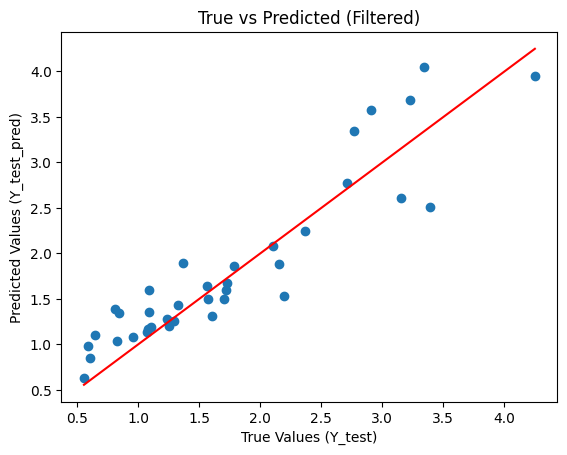

In [ ]:

import matplotlib.pyplot as plt

plt.scatter(Y_test, x_pred_test)
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red')  # 1:1 직선
plt.xlabel('True Values (Y_test)')
plt.ylabel('Predicted Values (Y_test_pred)')
plt.title('True vs Predicted (Filtered)')

r2_test = r2_score(Y_test, x_pred_test)
print(f"R² Score: {r2_test}")

#print(max(abs(Y_test - x_pred_test)))
#print(np.argmax(abs(Y_test - x_pred_test)))
#print(Y_test[8])

R² Score: 0.9740771077513148


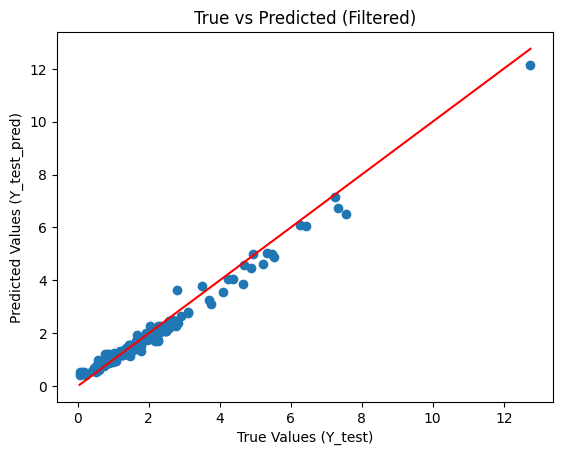

In [163]:
plt.scatter(Y_train, x_pred_train)
plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)], color='red')  # 1:1 직선
plt.xlabel('True Values (Y_test)')
plt.ylabel('Predicted Values (Y_test_pred)')
plt.title('True vs Predicted (Filtered)')

r2_train = r2_score(Y_train, x_pred_train)

print(f"R² Score: {r2_train}")

R² Score: 0.9655065741932598


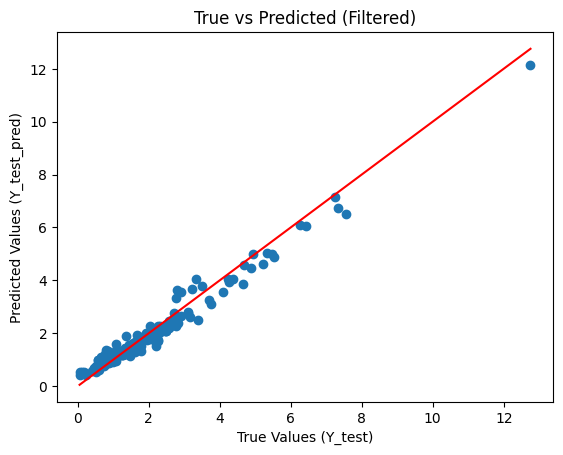

In [164]:
plt.scatter(final_y, x_pred_final)
plt.plot([min(final_y), max(final_y)], [min(final_y), max(final_y)], color='red')  # 1:1 직선
plt.xlabel('True Values (Y_test)')
plt.ylabel('Predicted Values (Y_test_pred)')
plt.title('True vs Predicted (Filtered)')

print(f"R² Score: {r2_final}")